In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import folium
from folium import Choropleth
import geopandas as gpd

sns.set_style("whitegrid")
sns.set_context('poster')
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)

In [37]:
#Parameters
country="LU"

# Data

## Migration Data - Raw

In [38]:
from eurostatapiclient import EurostatAPIClient

#Set versions and formats, so far only the ones used here are availeable and call client
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In [39]:
countries_names = {'AT':'Austria', 'BE':'Belgium', 'BG':'Bulgaria', 'CY': 'Cyprus', 
                   'CZ': 'Czechia', 'DE': 'Germany', 'DK': 'Denmark', 'EE':'Estonia', 
                   'EL': 'Greece', 'ES':'Spain', 'FI':'Finland', 'FR':'France', 
                   'HR':'Croatia', 'HU':'Hungary', 'IE':'Ireland', 'IT':'Italy', 
                   'LT':'Lithuania', 'LU':'Luxembourg', 'LV':'Latvia', 'MT': 'Malta', 
                   'NL':'Netherlands', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 
                   'SE':'Sweden', 'SI':'Slovenia', 'SK':'Slovakia', 'UK':'United Kingdom'}

In [69]:
countries_names.keys()

dict_keys(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'UK'])

In [40]:
df = []
for sex in ['M', 'F']:
    for age in ['TOTAL', 'Y_GE65', 'Y_LT15']:
        par_df = {
            'agedef': 'REACH',
            'sex': sex,
            'unit': 'NR',
            'geo': list(countries_names.keys()),
            'c_birth': list(countries_names.keys()),
            'age': age}

        df.append(client.get_dataset('migr_imm3ctb', params=par_df).to_dataframe())

In [41]:
df = pd.concat(df, axis=0)

In [42]:
df.sample(10)

,values,age,agedef,c_birth,unit,sex,geo,time
2321,0.0,Y_GE65,REACH,HR,NR,F,BG,2013
664,0.0,Y_GE65,REACH,CY,NR,M,HU,2012
5098,5.0,TOTAL,REACH,MT,NR,M,FI,2018
376,NaN,Y_GE65,REACH,BE,NR,M,ES,2012
5247,0.0,TOTAL,REACH,MT,NR,M,SK,2011
1654,7.0,TOTAL,REACH,DK,NR,F,EE,2018
3617,52.0,Y_LT15,REACH,LV,NR,F,SE,2013
4169,NaN,Y_GE65,REACH,PL,NR,F,LV,2013
1892,5.0,Y_GE65,REACH,ES,NR,F,SE,2016
2889,436.0,Y_LT15,REACH,IT,NR,F,BE,2017


## Migration Data - Processed

### Ballast Drop

In [43]:
df.drop('agedef', axis=1, inplace=True)
df.drop('unit', axis=1, inplace=True)

In [44]:
df[(df['geo']==country) & (df['time']=='2018') & (df['c_birth']=='BE')]

,values,age,c_birth,sex,geo,time
430,639.0,TOTAL,BE,M,LU,2018
322,27.0,Y_GE65,BE,M,LU,2018
322,76.0,Y_LT15,BE,M,LU,2018
430,507.0,TOTAL,BE,F,LU,2018
322,25.0,Y_GE65,BE,F,LU,2018
322,98.0,Y_LT15,BE,F,LU,2018


### NaN Handling

In [45]:
df = df.pivot(
    index=['c_birth', 'geo', 'time', 'sex'],
    columns=['age'],
    values='values')

In [46]:
df.sample(5)

,,,age,TOTAL,Y_GE65,Y_LT15
c_birth,geo,time,sex,,,
DK,DK,2019,F,7007.0,297.0,1083.0
PT,HR,2015,F,3.0,0.0,0.0
SK,SE,2019,M,143.0,0.0,9.0
SI,HR,2011,F,142.0,NaN,NaN
NL,LV,2014,F,8.0,0.0,4.0


Replaced NaN by zero (0)

In [47]:
df.fillna(0, inplace=True)

In [48]:
df.sample(5)

,,,age,TOTAL,Y_GE65,Y_LT15
c_birth,geo,time,sex,,,
RO,LT,2018,F,10.0,0.0,0.0
UK,SE,2013,M,1111.0,25.0,265.0
HU,LU,2016,M,72.0,0.0,7.0
NL,IE,2019,M,0.0,0.0,0.0
LV,LU,2009,F,33.0,0.0,0.0


### Age Classification

- children: immigrants listed younger than 15
- elderly: immigrants listed 65 and older
- working-population: Total number of immigrants minus children and elderly

In [49]:
df['children'] = df['Y_LT15']
df['working-age'] = df['TOTAL'] - df['Y_LT15'] - df['Y_GE65']
df['elderly'] = df['Y_GE65']

df.drop(['TOTAL', 'Y_GE65', 'Y_LT15'], axis=1,inplace=True)

In [50]:
df.head(5)

age                   children  working-age  elderly
c_birth geo time sex                                
AT      AT  2008 F         0.0       2489.0      0.0
                 M         0.0       4373.0      0.0
            2009 F         0.0          0.0      0.0
                 M         0.0          0.0      0.0
            2010 F         0.0          0.0      0.0

In [51]:
df = df.reset_index().melt(
    id_vars=['c_birth', 'geo', 'time', 'sex'],
    value_vars=['children', 'elderly', 'working-age'])

In [52]:
df.sample(10)

,c_birth,geo,time,sex,age,value
42203,RO,SK,2013,M,working-age,190.0
23576,LT,LU,2012,F,elderly,0.0
31326,CY,FI,2011,F,working-age,1.0
13064,SE,NL,2012,F,children,45.0
36798,HU,LV,2011,F,working-age,0.0
33972,EL,FI,2014,F,working-age,51.0
35520,FR,ES,2008,F,working-age,4153.0
39806,MT,FR,2015,F,working-age,0.0
5008,ES,HU,2016,F,children,8.0
38506,LT,SK,2013,F,working-age,4.0


### Name Mapping

In [53]:
df.rename(columns={'geo': 'country of arrival', 'c_birth': 'country of birth', 'value': 'immigrants', 'time': 'year'}, inplace=True)
df['year'] = df['year'].astype('int')
df['country of birth'] = df['country of birth'].map(countries_names)
df['country of arrival'] = df['country of arrival'].map(countries_names)
country = countries_names[country]

In [54]:
df.sample(10)

,country of birth,country of arrival,year,sex,age,immigrants
21185,Croatia,Bulgaria,2016,M,elderly,0.0
29399,United Kingdom,Luxembourg,2019,M,elderly,2.0
38393,Lithuania,Latvia,2016,M,working-age,0.0
34377,Spain,Bulgaria,2012,M,working-age,50.0
40313,Netherlands,Finland,2016,M,working-age,58.0
17002,Czechia,Denmark,2013,F,elderly,0.0
39815,Malta,France,2019,M,working-age,31.0
29682,Austria,Denmark,2017,F,working-age,87.0
699,Belgium,Finland,2009,M,children,12.0
35274,Finland,Romania,2017,F,working-age,38.0


## Geospatial Data

In [55]:
import importlib.util

if importlib.util.find_spec('google'):
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    dir = os.path.join('gdrive', 'MyDrive', 'Eurostat', '01 - Intro to Python for Data Science')
else:
    dir = '.'
    
data_dir = os.path.join(dir, 'data')
os.makedirs(data_dir, exist_ok=True)
data_dir

'.\\data'

Place the content of [NUTS_RG_10M_2021_4326_LEVL_0.shp](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts) into your data_dir

In [56]:
nuts0 = gpd.read_file(os.path.join(data_dir, 'NUTS_RG_10M_2021_4326_LEVL_0.shp'))
nuts0.dropna(axis=0, subset=['NUTS_ID'], inplace=True)
nuts0.set_index('NUTS_ID', inplace=True, drop=True)

In [57]:
nuts0.sample(10)

,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
NUTS_ID,,,,,,,,,
PL,0,PL,Polska,Polska,0,None,0,PL,"MULTIPOLYGON (((18.95003 54.35831, 19.35966 54..."
ME,0,ME,Crna Gora,Црна Гора,0,None,0,ME,"POLYGON ((20.06394 43.00682, 20.32958 42.91149..."
IT,0,IT,Italia,Italia,0,None,0,IT,"MULTIPOLYGON (((12.47792 46.67984, 12.69064 46..."
AL,0,AL,Shqipëria,Shqipëria,0,None,0,AL,"POLYGON ((19.82698 42.46950, 19.83939 42.46950..."
CY,0,CY,Kýpros,Κύπρος,0,None,0,CY,"POLYGON ((32.27423 35.06608, 32.29189 35.09423..."
UK,0,UK,United Kingdom,United Kingdom,0,None,0,UK,"MULTIPOLYGON (((-0.24042 51.49011, -0.22283 51..."
FR,0,FR,France,France,0,None,0,FR,"MULTIPOLYGON (((55.64788 -20.91533, 55.68341 -..."
LT,0,LT,Lietuva,Lietuva,0,None,0,LT,"POLYGON ((25.82139 56.05218, 25.86938 56.00199..."
IS,0,IS,Ísland,Ísland,0,None,0,IS,"MULTIPOLYGON (((-22.00740 63.83599, -22.13087 ..."


# Visualizations

## Immigrants by gender and age

In [58]:
_df = df[df['country of arrival'] == country].pivot_table(
        columns=['age'],
        index=['year', 'sex'],
        values='immigrants',
        aggfunc=np.sum)

_df['<65 cumul'] = _df['children'] + _df['working-age']
_df['total'] = _df['children'] + _df['working-age'] + _df['elderly']
_df.reset_index(inplace=True)

In [59]:
_df

age,year,sex,children,elderly,working-age,<65 cumul,total
0,2008,F,0.0,0.0,6108.0,6108.0,6108.0
1,2008,M,0.0,0.0,7614.0,7614.0,7614.0
2,2009,F,0.0,0.0,5459.0,5459.0,5459.0
3,2009,M,0.0,0.0,6518.0,6518.0,6518.0
4,2010,F,0.0,0.0,5558.0,5558.0,5558.0
5,2010,M,0.0,0.0,6876.0,6876.0,6876.0
6,2011,F,0.0,0.0,6428.0,6428.0,6428.0
7,2011,M,0.0,0.0,8077.0,8077.0,8077.0
8,2012,F,0.0,0.0,6707.0,6707.0,6707.0
9,2012,M,0.0,0.0,8266.0,8266.0,8266.0


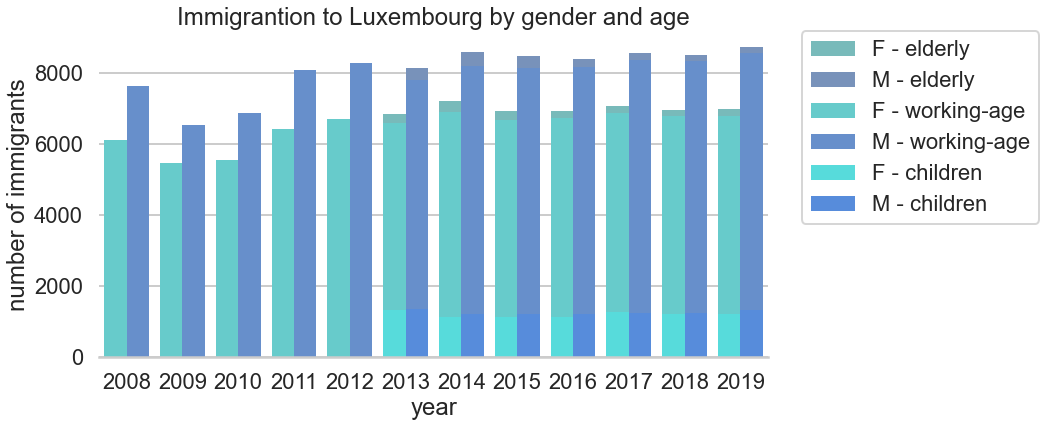

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))

__df = _df.copy()
__df['sex'] = __df['sex'].map({'M': 'M - elderly', 'F': 'F - elderly'})
sns.barplot(data=__df,
            x='year',
            y='total',
            hue='sex',
            saturation=0.5, 
            linewidth=0)

__df = _df.copy()
__df['sex'] = __df['sex'].map({'M': 'M - working-age', 'F': 'F - working-age'})
sns.barplot(data=__df,
            x='year',
            y='<65 cumul',
            hue='sex',
            saturation=0.75,
            linewidth=0)

__df = _df.copy()
__df['sex'] = __df['sex'].map({'M': 'M - children', 'F': 'F - children'})
sns.barplot(data=__df,
            x='year',
            y='children',
            hue='sex',
            saturation=1,
            linewidth=0)
sns.despine(left=True, top=True, right=True)

plt.title(f"Immigrantion to {country} by gender and age")
ax.set_ylabel('number of immigrants')
ax.set_xlabel('year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

## Immigrants by country of birth

In [61]:
_df = df[df['country of arrival'] == country].pivot_table(
        index=['country of birth'],
        values='immigrants',
        aggfunc=np.sum)

_df.index = _df.index.map({v: k for k, v in zip(countries_names.keys(), countries_names.values())})

In [62]:
_df.sample(10)

,immigrants
country of birth,
HU,2000.0
DK,1175.0
RO,6253.0
NL,2392.0
FI,1038.0
LV,759.0
PL,5289.0
AT,833.0
CZ,1050.0


In [63]:
m = folium.Map(location=[49.63321762577624, 6.169436798146017],
               tiles='CartoDB positron',
               zoom_start=4)

Choropleth(geo_data=nuts0.__geo_interface__, 
           key_on="feature.id", 
           data=_df['immigrants'],
           fill_color='YlGnBu', 
           legend_name=f"Immigrants to Luxembourg by country of birth (2008-2019)"
          ).add_to(m)

m

In [64]:
dominant_country_of_birth = _df.sort_values(by='immigrants', ascending=False).iloc[0].name
print(f"Most immigrants to {country} were born in {countries_names[dominant_country_of_birth]}!")

Most immigrants to Luxembourg were born in France!


# Table

In [65]:
_df = df[df['country of arrival'] == country].pivot_table(
    values='immigrants',
    columns='year',
    index='country of birth',
    aggfunc=np.sum)

In [66]:
print(f"The following tabe holds the annual number of immigrants to {country}, by country of birth:")

The following tabe holds the annual number of immigrants to Luxembourg, by country of birth:


In [67]:
_df

year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
country of birth,,,,,,,,,,,,
Austria,58.0,65.0,66.0,55.0,67.0,52.0,95.0,76.0,77.0,74.0,66.0,82.0
Belgium,952.0,955.0,1059.0,1071.0,1216.0,1384.0,1490.0,1424.0,1203.0,1245.0,1146.0,1180.0
Bulgaria,162.0,108.0,101.0,144.0,122.0,98.0,172.0,179.0,211.0,189.0,187.0,180.0
Croatia,9.0,9.0,32.0,34.0,68.0,72.0,121.0,98.0,124.0,107.0,123.0,143.0
Cyprus,3.0,6.0,8.0,14.0,11.0,17.0,22.0,9.0,19.0,17.0,14.0,19.0
Czechia,114.0,95.0,92.0,108.0,80.0,62.0,83.0,101.0,77.0,83.0,79.0,76.0
Denmark,125.0,116.0,87.0,95.0,107.0,131.0,92.0,84.0,81.0,85.0,91.0,81.0
Estonia,69.0,34.0,56.0,49.0,56.0,50.0,42.0,39.0,38.0,54.0,43.0,42.0
Finland,80.0,59.0,76.0,115.0,60.0,73.0,88.0,107.0,98.0,84.0,103.0,95.0


# Convert Notebook to HTML Slides

jupyter nbconvert <notebook> --to slides --no-input

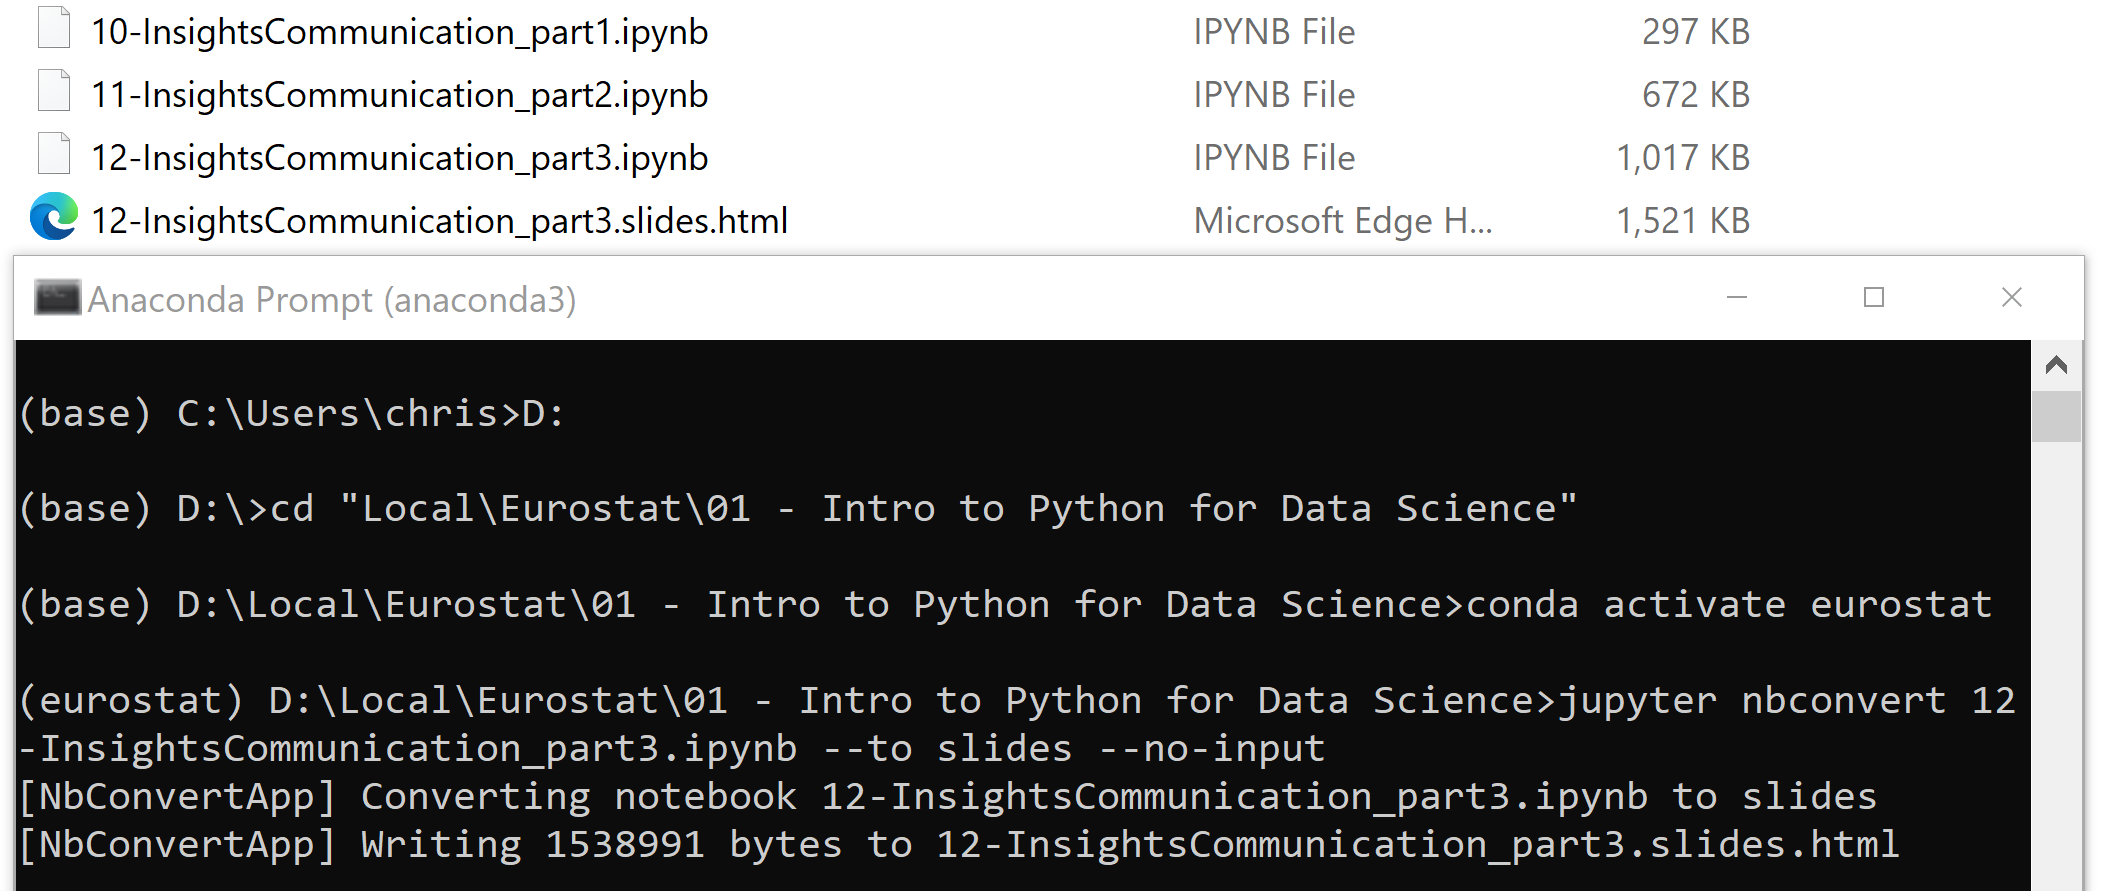

In [68]:
from IPython import display
from base64 import b64decode

base64_data = "iVBORw0KGgoAAAANSUhEUgAACD0AAAN7CAYAAABMSHNAAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAP+lSURBVHhe7P0PdCNZftj3/tDdM7vaXc3M/rHZhGM5loBJMm5zMk1Z0QGkOM4fuolh/CYnzjw9e708cx4f+OScJSnndcKYHcnOG3oYd84x0Os4IR7jHsjWSmnnvEy8bKCX79nHkUw6L37scfO1J/IAiv8p7IZ3JXlXu/Ovm8S7t6pQdQHiTwEoAAXw+9muRqFQqD+3LurO9v3V70aqigAAAAAAAAAAAAAAAIyZC84rAAAAAAAAAAAAAADAWCHoAQAAAAAAAAAAAAAAjCWCHgAAAAAAAAAAAAAAwFgi6AEAAAAAAAAAAAAAAIwlgh4AAAAAAAAAAAAAAMBYilQVZz5UfvEXf1Fqh6ZfrTn9as8Yr03WafJqrqcXfOazn5H5a9fki1/8orUcAAAAAAAAAAAAAACMl9AGPXz961+Xn/qpn3LeNXfmwGsLImqy5vVf+o1mf3jhwgX5pV/6JUkkEvLLv/IrMn9tXr70JQIfAAAAAAAAAAAAAAAYN6Ef3uL09NSaTmrTiTmdGFP9+6fOsqdPn1rzT57ay/S2tC984Qvykz/xk1IoFuTb3/62tQwAAAAAAAAAAAAAAIyP0AY92Akoalkammv/aXuRSEQ+//kX5CeSSblbIPABAAAAAAAAAAAAAIBxE96gB+PvQdAZH3RgxQsvvGANdbG7e5fABwAAAAAAAAAAAAAAxkh4h7ewMj20109IRC3oQU/PP/ec/PiP/7h84xvfkG8R+AAAAAAAAAAAAAAAwFgI8fAWzqsz9UZ9M2IPguG8uHTQw8nJiRv88Pzzz8mP/diPya4OfPgWgQ8AAAAAAAAAAAAAAIRdeDM9NAt1qFtkvomot857Y7b22kwt4MGcnnvuOfnRH/1R+cbuN5y1AAAAAAAAAAAAAABAWEWqOs1BCP38z/8V+fKX/7icnJ42BDvYqj6CHqwZN8WDvfDSxYty584dOT4+tt43c+mZZ2V15avOOwAAAAAAAAAAAAAAEEYhDnr4efnyl78sJyenzhJPy4AHzXmrQx2sU4tErFcr9sFZ7Tvf/Y6cnprbUPP2H3nm0iX5q1//BVlbWbE/AgAAAAAAAAAAAAAAoRTa4S2ax2LocIdmyx1G/EMt4KGZ5557Xl544YWWU7tdAAAAAAAAAAAAAACAcAht0INHRyDYwQ5nYxGMKAdDY6hDi9gHx9nvtw2swAQoS3E5qepFRJLLWfVuSMpZSap96v1GkkPcLxAKI/rdDc2knx/Chfrmom0FAACYIBU5ym/JysqKbOX31LtmjiSvPtfrrKzk1TsAAAAAkPAOb/H222/Ln/jKV+Tk5MRZ0qgh4MF8a2R5aBza4uzJqiX2H4se3uJrf/Fr8jNra86SIdP/eB9X+86UZH815iz0p1wuys3FN+XhwYEcOMskkZD06zfk+uq8dLc1/8rZpMTX7D2mC1XZnrdmw6u4LJFUznkzxGN2rq1VUomMlPZXB3ZNhqssxexNeefOw/q650ioOihXXpfXX3tVXp2PTcg5o2uj+t0Ny6SfH/rXR/t+BvXNM7FtKwAAqOxtyebusTU/u3RLFmes2TOO8iuyc+i8aSEajcr09FV55dqczEw5Cw3mvtTeZOnWorTYXVPm96MLG7I+5+2k8fjanUtLR3lZqW1kdklutdiAn7JQhSFRVRapFmXRq/oy9KexrOrOU2leVjroYUfstbq/VgAwTiqVI7l3uyCPjo/Fu8Oq+3h0WlJvXFP38W5u5BWpHN2T24VHcqy2VxONzsrV1DWZa9coNNyfuxZdkI31Oeml2fHatqgsbKyL2Ww0Z7YTimo3N1RjYn5tlO0lAGBwwju8hfN6lo5uUC91AQ9V923E+KYb8NAlc9PD4zy1WfuH+66UJau+G4+nJNfY6aze59ZSEo8kJcvjjwhSuWjVu0gkLqm13Nm65zjQy3NrspZalLvUQQDnTj/tOwAAAIKgO3cOD3dlZ7N5BoGpuZTMOvMih/JuN+kDKnty2wiYSHXojTncGXF2At1x1qYsAABhUJG9rRXZ3NyRw7qAB029Pz5U9/FNWdnyeR9XbdXWyqZs7hzWBTxoelu7O3pbk5A9R5ebEfCggy0aAh58o70EgLET3uEt3MgDHbXgTHpRY0SCXly1Ixv039bHTqSDG/DgfKXhm4pacnah0nThwJSLy5LUHce5XrpDdGdKXNbc7yYkkc5IoVCQTCatEz04DmQtTuCDZf66FNJ2weiyus7T2F2z6mw8ZdQ7h6pwiURa0mld9/S8sxyY9N8d9xU00V/73gb1DQAAoKno7KzMmpN+SjPqfOjQHRibZzp2ZuTagrfiYcF/58bRvV23Myq6cM1H1oFD2ckPvltJP7nrryyC78g5s+8W09XLzhdqZq7J0qx9kNHZBblGCgcA55LOVLApXvIcdf9W98SFpSVZWliw7ueuYx/3cZ2lYdNrq3RjMLugtqW2t6Duue7WdCBFq21NTTe9j7ebzMOcTfWW5aFbR3mz3GZlyUd2iVG2lwCAYIV2eIu/fPu2LH5lsfXwFk5AQ+3o7YAH9aZxWAvrTd2LQS2x/7j08BbZW7fkP/pTP+MsGRR7SIA313JNn/xM+Ex/bQ4t0Tytsx0U4WbBHkDq57Eb3mJUBpSCu1zMyt137sia3JDqEAq/rs5pibRkblyX1fnWZ6OHXrl78x2R69vSb1Z3YJiG/ftC+HRfB4Jp3+ETw1sAADCxuh/eol3a64oc7d2WHXP4hTPDROinQ73OEl/DUOgnZ92OpOZDLbRKod3VMBc9DG/RevuqLPKqLA69sujqWFrwe736x/AWACac27bo4ISUXJtrkqmgrv1RLWDjcEGu+qEeZpc21P25cb369q/1trpgHl8fQ1tofoe3qB9mqf26o2wvAQCDMwaZHhroQAY16Y+9gAc9vIV6023AQwtqa87cgOh/oHeGBHA7RBJpKWTSzhu/inLT7XxW32/6D/0xmd8uSab2xP3BmtwsOvMYf6ouLabWzmZcGJDGgIdEpiCl/e22AQ9aLDYvq9sEPGDMDPn3hRDqtg4E1r4DAAAgWFMyM7cuG0veIBZyWJC9ukc2p2QuZQxy4SPbQ3dZHqIy62Qx0LrJJhEsVRaL61JXFF2N5wEAGDy7036xWcCDNjUn68aN/Pj+g6ZtylHeC3jQwQxnAx401f6tb0gt4dHx7r2+h7nw2kd1Hm8MIcvDUd53wIN/tJcAMG5CG/RghR04AQ5uoIN6qQ92UNQb631XAQ8OvS1ntk7LLwxCQtJOx/H8i84iv4rviJfA4bq0fv40Jqs3vA6X3DtEPaAHuvOvLuBBP608zxO1ANBUH+07AAAABmJq5prbqSNyLI8ae4jMz4935V67vo3KnhRqPUkyKykfvSvT196o2/7t+qiLoZp5xejFefR4RAEYAICzLkvKT6d9XZt1Xx6cuZEfybu+2ykz8O9QCv20T2b7OJsKIPigA51VwkipNLsURMCDh/YSAMZHuDM96D/GVGPHQBjZHboOeNAbdGZHJZGQdKEkpeq+bPfYcVx8xw15kNdf7bCF+dfEDXt4+L6UnVnAn7JkF5304Vq6QHp2AGgmgPYdAAAAgzIlL191ox7k0ePGrgv/2R7MLA+zS36HWFDbf2NBvLiH2w3ZJgAA597UjDRNyHDGlFyedmabqTyWR86szL7SuZ2aeUVqLeDxmahA/+qyPFwb9FgQR5JvGOaD4ScA4PwKd6YHxQ5wqE06WMEOdqjqJW6Eg17sBTzoWAjr1X5p4C1t/rm9rYGKrcr+/r5sz8f66Awpihfz8Lp0inkQictL7hAXd+QuUQ/oRvGmeEke0lLwNa49AJwzgbTvAAAAGJamnTp+sj2YT7FGF6SrPp2pOfHiKo5l9/aohrkwTF+WQT+ICwAYssojLxhg2s9dfkqma+3f4bu9DXEx1CwPFdnb8obvkNklWR90WgnaSwAItfAGPViBB06AQ22qBTo0BDvo9cwMD3q2bdiC+rD153o/bb8dDuX35aEzK1de9NG5EpMXrzizciDvlZzZYbHGOY+o66SmZNbNNFEuF2U5mbSXO1MyuSzZot+ojLIUs8vqO/XbiKj3yeWsNN+M2qe77rJ611m5mD1znHofy9micy5lySZrnyUl20VQSbMysLatDr754S9768WN7Au5VP02Wh5H92XmZRWRDkOp9Knc4tjUufivF8b1NevamWvY+nybXW9/+x/dvstZ7zvLPip1cdnbftP1A//Ndv+7U3tzy8M9Fmvy6kO7vervZpf1uuZ3veNt+t2ef189nF8Q9X1g99YetDgW6zz1dTCOpd1voJWerqfLvEcb18cqJ2N7+rj7vscOg4/6FuD1MO8vET83GM0sR/M7w6qzAdU7AAAw2Zp3AnXK9lCRvdtGlodU92OVzywuuU/TdhxGY0COvJznMvtKWB6LPZL8yoqsWFO+7zHlXZUj2ctvyZa7bT2p91t52Tsi1QaAcVWRx24qh3Coy4I04LblKL8pu+7OlmRjQCkewtleAgCaCe/wFhYjyEFPjloQhA5QcBfbb93Z5tQn9p/2Oq4QAqX33I6YxEtxZ669uJvqIRx0Z0Q8npLcgdulZDk4yMlaKm51krTrl9AdU8lIXFJrOfWd+m2oBXKQW5PUTZ+dM604HWLx1NqZ49T7yK2lJJ7024F7VqsysLatyiBudlQFoLcyK8v7boSNj6FUemJ3TkXiLY5N1Xa3XuhOsK4Kxd722WvonG/c7Lhsta4uHq9e+jfKfQfPOr4+frPdqNXVWnk07NHdZ9OfuPVd+3e7ltPrOssdte8G/fvyb5D1fbjXqZOyDurQ56mvg7PMpt5bv4GIJDvV60FdT71dq5yc9+dAr9cj9urr6u7vyL3jq80rGkNwZa63D5ULus76Os/RRawAAIARqzyq9ZDoBzZbhCu0y/ZwdM/rZOk2y4NrRhaXjMCKnQA7+H2oHOXFHf6853MYBxU5ym/JyuaO7B4eux1xNvX++FB2dzZlZSsE2TYAoGsVcZu06FV5uU0EXvfDVTySMyNAddJPFqQuVfa26toxHfAwiAwM56e9BIDJEOpMD9b/nOCG2que6mIgaosdxmwD9Yn9pzVrn3qdtmuFQtnrhfYt5qV6kIfvj/Yf+0vZpNUZoTtD0pmMFAoFKWTSeih0Ty4li606JYrLEk/l3M6MRCItGb0NZzvpdMLroOmVfhq1oUMskfb2k1Hz1j4OcpJK3pT3rDX8a1UG6tA9B2sSb+yAil+313XWd1dPONtwpxv1w570Wmblu3LHLYMr8mLgMQ86sMTunKrRx5bO1I4tYx2bS3eC1QULtHd32dm2Pl9rmxl17cxzPVDbswNXirV11aeJdItrouql386yUe47aH3/ZrtgB394ddXaZ61MzpThWbqztfG7dl23v+sK8vfl22Dr+zCvU0f6nqODOtSsdb9xzjHTcDwHHep1X9ezFX1/r6tjhoHXgRHp53rEXpXX3XVy8k7HYvY/BFfgddbvea7FCXwAAOA8MjtkJCqts323yvZQkT1vAz1leXDNLIoX93AoO/nBhz1UnIwHm7UeHN1RtN7HOYSaTnu+KTuHbo+gRGcXZGFpSZaW1Ouseu98ogNbNgl8ADBmKnsFb2iHZsMuTE179zlfw1UYQRQ9qDy431cWJN+O8rLppXiQpQG0Y+ervQSACVINqe3tXPXp06fVjz7+uPn0Uf30Ydvpo+qHH9rTBy2nD6vf/+DD6idPnlS3/os/7xzFkBXSdsyFmhKZkrOwuVIm4a6bLjgLO+li+93wdSylTDXhrOMeg1q52VGY2xNJV89uslTNJGqfJ6rtTqXU9LNCNd12+5q5DzUlMk2PVa9XSJvHq6cWx9SkDKTnMnCY22xbEfooM6PetC6HXjWWszrXljtoWLdluZjX156a1vdS/XqJhFPm+hicVUx116RlOYxu375+h4ZC2tleq/UD/c1qfn53jdtKqGNrXtJqzWohk65mmmzIOjdVlplW3zXrdLvfg+/fl+bn/AZQ3wO/Tn1odo9rc46N17rVdQjmeprlma6mnfpfX1a6TjX8vrqqA20E3v76qG9BXw+znDuVRbvzDbrODqjeAQCA0Xv8zbeqX/3qV63p7QfOwiYevG2v89WvvlX95mNnYTOPH1TfdrZnTe02anlc/eZb3vrW6g/e7uL7tvbHV39MLTfpc7/evjpNb1Xf/uYDdYbB8Xu92jPL4231rhk/69SXxVvqgJqfa/01fqttBQKAMDHvha3av+7ucfVtSIc29Qx/9+Ze1LWjD75ZfavnY/SMsr0EAAxOeDM9WP8ebc00nxwNbxs4nzortF5PfWZ8OA6ZHsZeIiP57Xlp9vBnbDUvmYTzptkTpWbmgQ5PkMZ6fQq3eFPW3H1kpLS/2vRY1R5kfntfCmnnbTf0dnstg24FVWZXXmxRDj0yy1nSUtjflvmWO4jJ6n6prlze9POUbrog+6tNNhqbl23jwtlDDCQkk1fHYC+qE1u9oY7QcXBH7vp5QHiU+w5aP79Zv8pZWfR+eJIp7ct2ywqhfnur27LarMBe0r9Z/VmL785vG7/ZA7kzrAIdRn0fxnXyrf05xlb3peQe0IGstRqOKPDrmZNcThdVSfbrykrXqVb3+knQ5/WYf827D7Ud4qIs2Te9oS06DokUeJ0NqN4BAICJUanYQxxsbe54T8TqJ0M7jv19NtuDl+UhKguB5LiekWvuOBpmRolBO5bD+wW5d1QZyP4Od1ZkZaXDNMjMCmY68tklWW+Z9lxd4/UlVRtsx/cfkO0BwBjQmWy8Ni268IbMNb3J1bdjx7ubsrXX7C5nt5PufbMHZtaJ6MI11boNwrHs7uy62SRan3eQBtteAgCCFdqgh3ZxB/qj2tSa86l66biuGfGgNLxF4HTnbruOpZi86uXRHsFQHGaHjUj6RudOsPnrGXVW3Qh7GQxDQzkXmnf414vJat4r64M7dzuM867Kud1Y8mYnnpLI5KVZjIJtXl4zOlbfKzmzLY1y30EbTn0t372jzs7Wvjza89NxPe8V6JAMqb6H6L7i5xzrAnpadKQP5HrqjvZeK9iY6v96mPehNgEIZpBd+kaH33HwdTaoegcAAMbRsexunu1c39y0hzhwM3ZHZ2VpY9Ffh8zMNXFjEo53xcumnQqso2Vq7o26fdxu2iHVvag6z9lZc4qqZV6AhRwfy+HOpmxu5eVownpyjt7tJjhlRl7xoh7kAb1aAELNHrrHa4+WZL1dgzRjDqWkm5lN1TZuyVY+L3lr2lLva0MBzcqCEYjnX0Ue3HdDEeTqy4OKRIhabVnN8e5tCaLJPM/tJQBMmlBneqgFKzRO7TlrGS9tVZvldej4LfSjQ6YBLfbiFWdO5KCxh9ccW/xgTRazxQ4dgd0qyXtez6u067d21Y137kO/ZdCtoMrs4fsBlnUP5azVnUunrAdX5MW25RyXl4zrdqX9yhI3Vu7c+TbKfQdsKPW1LHe9nlK5McQO6b5/X74Mob4P+77SVlpe83WO5u/goQRRtf2cl59gtskSzPUwg0tyLaIezOCldKedBl5nR1fvAADAOIhKdHZJNtYXZcZ3f0z9U7K2oLI81Kh9vLGgtmoLqhNnOrUoi4vmtC7r6+ty69Yt2VhaELff6PhQdjbzPsZ69+9sB1KT6eplZ+2gHYkX83BV/PS9TU27hSGP6NACEFaVPdla8QIedJt2q2PWIh33sCFLRrCAvtcdHx7KoTV5wQoLG4ty+VHtfRcqD8SNeQgwKLCZ6WvrRhCHDnbsv/0aZXsJAAjWWGZ6aE5/wflS/UtrTQMelI5fnDzlbFIikUiHKSl+sqsPXkxWb3gdLwdrKYknk7JcLAfTIV9+Xx46s4EP5zAyAy6zXvRczjHx+sA6ZD1IvCRxZ7azhLzkf+XORrnvcVQ3BEs3ZdeJquPFohSLWckuL8uyqvfJpLqfpbysC0MxjPoeJr6vYbfnF8T1PIe/t6Cux/x1b7iJphkS6oOX/AUgBGhg9Q4AAIyLaLPO9YUFWVrakFu31tsMc9CGme1BG0SHztScvOGle5Dd24Md5mJqZk4W1zeM8zqUQkAZJrSzHUhNprkeroUflcfyyJnVmTM2GzJ/NJs23UemRR49JuoBQPhU9rZkZdMc2mHDatP8mZKZxXW5tbEkCzqLgbPUEo2qdnJJNlQbWd+2Tctlnzfpo3vecc2+EmRQYHM6iMNsv3YGOFzSoNtLAECwQp3pwR+9nrOuM2ssaa1VwINSHYPxLcwnH/0+9V1+3+1y6/hUeejNb0upkBb3Qc2DA8ml4hKPRCS5nJViPz35pffE63udoJ6xXsss/pLxnfcksL6hPsrZzHqACdR3sFFZitllSVrBWqqOp1KSSq3JWi4nOVXv1Z/ho7631Pn8gr6enbKwnG/tr4c53ESTIS6M4KVE5rqPIVxGh3YEAIBJFJWr15p1rs/JjP/UDk1MyctXvS6iQXXoTM2lxHt4dVfuDfxR0oax3u8/mIzxyiuP3M43ABh/FTnKb3nBWdFZWdi41X5Ii1amZmROZzG4dcvKYmBN6+tGEFpFHteixqLTPgPTjOw6qhUbQsyDotqv9aW6NnMzfzTANmxC20sAmEDhDXpoGXdQC2lwpiazHbUJeNB8bSNE/KYoL3m51c885RpbzUupVOow9T7G/iDE5rdlv1qSQsboyFcOcmuSiuuO/KCHvRh/PZVZ3dAdbcZxB8KgXJTlSFxSazk3yEBLJBJqSks6nZFMoaB+A3R4hoXXNjXB9Ry6ttdDib36utt+NA5x4Q1tkZDXO41bMWKdzhMAAGD4ZmTRGHj9cGcIKbRnXjE6jR5NXidOVGf5WOpqSg1sLHoA6FZF9rY2Zac2BIW6p+khmgY3fERF3NEtpi/7C3o4ele8mIdXVEs2LKrN3PCGhlKNphX4MDCT3l4CwIQI7/AWbuhBLZTBmdq87Ux/wUcOiTHI9CDm0/cP3/fRuV8WL9FDs6dcYxKLdZ7CJybzq7ojvyqlUkHSCa/j6yCXkvhyfz30wxnrf9i6LTMzDbhI7s1s4MEk3ZZzuwAenGdlyS6mpDbQQSKdkUJJ3fNVXd/f31fTtmxvr8rq/LzMm5V6yKjvrTSe33hcz8nVor7FVsUdLaluiAtjaIvE6xLymAcD7QgAAAiRmUVjrPJD2RlkB84Zj2QiRnaYmvY6waYvy8zMTHcTMQ8AQsEOeHATPCxsyK31OZ/ZF3pkBDD4zWp05KV5GMrQFnWm5mTdCBbUgQ9bQxl6YkLaSwCYQOHO9NBkalzkm9qg3qaf73S13VExn773NeRASdx+s/RroU453atYbF629/elVMiI242fS0nXcQ9dB5RoRvmOEb9lNn/d+PxgTW72F0ti66mctU4BPOg85I1ZhiERe1FdTUddR2oXijdlzb3PFWR/e1Xmw1I/qO8tFOWdWlRD4/mF+XpOrDbXwzD/mhv14GX/MYa2SN9YlXBfKn/nCQAAMAozi0bK7sOCDLT/pvJYapnMuxm/PdSmLqszcTx6zNO4AMbSUd4LeJhd2uhtOIsueQEMfoepGMXQFg1mFmVjwRuC6nh3UwYSLziJ7SUATKDQZ3rQf5tT99S3dMCD884XK+Ii7DqMq92o+I77tGz6tUkMefDE5lclb6Q679wB3MDsfD24I3f9fN0o33HUsczMJ3uVXCop2S6L9Yy6wJ0uAimMjjVJvCQ8oGuLGU+6d84kEMYgnbh4Q+z3NoxK2YjkSHR4dNtcdyjOW33v5d7ZcH6hvp7jJoDrUWf+NfGSPdiV2RvaIi0j+8+MoM8TAABgJMxhLo5l9/aeVMzsBUGqPFJ7cPgevz3spmS6VljH9+UBUQ8Axs1RXnacYAKd4WFxGClo6vZ5zd8wFebQFiNsQ6bm1o0sSTrhw1bwAYMT2V4CwOQJd6aHvjjBDvrFWeLXOIQ8aHXjarcdcqAs2TfdkIfRdUYMkdkB3L15cR9ilQNZ69g7aZbvCHX19PhZncpsfrvgdnJZ5RLvN/DBDNzpVIdrdLr7NXds//A/TTxEZiaBDpkSytk3QxikE5NVI7Iml1ruLduDL0W56aYQ8KnP39f5q+/d3zt7P78ermcv+q4DoxT09TDaSet+Y1yDkWaTGma9AwAAGKCZa+I+uHq8K7fvec+XBudI8rUeLiV69eWJCXp4+apbeHbQiPMOAMaBmXEhNYQMD/Xtgf99Vh57bdOo25CZxQ2v3dT3/s28OqugTGp7CQCTJ/SZHrrXe7CDq/+Ii+Ewn74/WJP4crFJh0xZistxN0V4InN9/Ie2KGclmVyWbLlV91N9h8aVHvJW1w3nkEtJsmnZKuWiZJNe+Q5dXVaKNsOcBFJm87JdMspFdy7FI3bZdOgJLKtyWrb27yxwxFbz4iaY0HVYrVNsua36uqwqs1w/BwE8vpmZBCQnqRZ1tlxclvjIKmwH89e9+qDPoVN9yKo6ZfRv1mW7WLvZ/LtWXUz5C/rw+/vy6dzV93b3TrW07t7Z5PwCv569CLgO+Kbv2ZGIRCLJ7odoaqXP69HIaydz8k72fbFzbSQkM+qKGvB5AgAAjMaUzL2x4GZ3OD489J4wDUDlaE/yWzveE7pD61gbjqm5lDojx/GubG7tyVG7yIdKRY7y+cEOJQIAvhhDRgSSUeBI9vJHLYO/dHuwteK1B7NLi/6yPKgtPrjvtUzTIx/vQbWb68bwUOqMdtS9v9/b+qS3lwAwaSYk04Md6NB3sIOj3+8PU93T97mUxHUHyXJWskU1LS9LMhKXVK03SI+JvjohzzMe5GQtHpdI0j7fYrFoTbVz7rtDI1Y/3MOBUbb2vrJqPimReMraVyJTMDprh6l+SICULo+sVxZ1QQZBlJkql/26wAenbOJ251zS2vayNen5ZFIvj6jPU5I7aJZ+Piar+0YdVseY0oEUSbUN5zzcsjbrciIthX2ezq1XnynBvR9knWudVWWqrkdcF6K6xhlj1fBw6kOtgjn1IWLVh4bfnq4Pazl5z1nVYqTct34PcVUHm/xmcwcJyfgqgC5+X76co/qujllfx9q9U1+HrHN+Wef83HuOKpGm5xf49exF0HXAj7KR4eNA/ZQDyHoSxPVoZARa5dac4028Lq+OsqIO4jwBAABGZWpO3jDGKe/Wo0Je8vn6aWtrS7ZWVmRzZ1cOvTzdsrDht5NrXNhDhLild7wrO5sr6vzzsrd3JEdHetpzymRFVjY3ZedwENk0AKBLlcfi3Y3uy72G+3j7qXmA16PDHdlU9/4VdQ/M76l11P1vT62v73+6Pag1B/ZQGs6bjiryyG1HZuWVUDQi5vBQihP01inw4Xy3lwAwWcY004Md4NAY6KCnQOgNjg399L3RSag7SHJrspZSUy7ndJrofoCClLYn8HHGA/t8U6mUNdWfc0ZKfXRoxFb3pVQXyWDua03N23tKZEqyvzqqEcFjspo3ghB0eazVyqLFGPf9lpkOfKiWpOBVOseB2rTeds6a9Lz644Oqw2p7GWN7BwdqG855mGWtWXV5f3v8M5YMwvx2w3XR9cG51muqTHUxOh3oL9orhJCqD/v19UEHB7jn0VAf6p3NRnJw5jebkHRhX1Z9FUAPv6+Ozkt9f0mu6+tonaZ9Hdac81szr5+uj6VW5xf09ezFIOrAKARxPRrVD9miJV5/tX37MXCDOE8AAIDRmZp7w0jX3Z3j40M5PKyfjo+P6zNGRGdlaWNdJvKh1ZlFWd9YkFmj/HSZ7O7uyM6OnnadMnE+jE7LZWcWAEJB3aAa7+Ptp/vy2PlqU7pd2N217n+7an33/idRmV3akPVuGgMzOCOQjBQBUff+DbPh1IEP+fYDXZz79hIAJkjIMz3oaIb6qWpN1ifBBjoYBrHNgYrZnYSlQloSdf0PCfVe/8N+Sfa350fcEREgK9tAwXqyt/58FbVAd9wXSlV1zv0/wakDH6p6X2m1XWeZzdjPqLNnOOWRbiiMROKK17EdeJnFZH5blY0OfshkrH03blZLWNtOS6ZQkFJ1X1oXVUxW1fZKtbJucoxptR/7GCeoLg+Avi66HM9cE6sMx6UD3a4P7m+voT7oemWdi6oPZ2K5jKCc+u/puqi/s3/2O+34+X117bzUd3We+9UmbZM+RX1fKElV18d2Jxj09ezFQOpAO2aghQ7qUGVkzfcrgOvRILZ6w8jGkZYbocgmpc+z2X8T9X6eAAAAozMlcynjqdVARCU6uyBLGxtya31RZia5A2dqThbXN2RjSQc/nI0eiapls+elLACcUzNybWNJFmbVvb/hNhiNzsrCkrpH3lqXxW5vgJVHgQ67FKSpuXUxEz7I4Y5s9TR+0TlqLwFgQkSqOooghLJf+5r8yZ/+aXny5KmzZDieeeaSbP65t+TP/Ox/5iwB/CjKcqQ2rnxaCtWgOqkAYEyUs5KM14Y56C/TDgIwjOth7iNdkOrAI1AAAAAAAAAAADgrvMNbjF26BZxr5ffFTXSeeElGNdgFAADDUr57xw54UNKvEfAAAAAAAAAAABiN8A5v4UQ96MwLw5y0kCa/QIiZHT+jH9McAIBBK8rNNTfkQYh5AAAAAAAAAACMSmiHt8hkb9mBD+rw7CO0X+1l1ipWcELtvflaW9/6Y61jrdz2tVYMtdc/+3M/a70CHZnpvSUhmdK+hGJYcwDwxRyep1vGcD4MbxEuA74e5WxS4k7QQyJTkn0aPgAAAAAAAADAiIQ26AEYqXJWlhffk9fy12U+1rojp1xclsVUzs3ywJjmAMYPQQ8TaZDXw9y2WQcAAAAAAAAAABiB0A5vAYzaw4OcpOJxiUQikkwuy/JyVorFomSzej4pSbU8bgY86E4lAh4AjJ152dZZj3qa6Ow+F3QgoNUO2u1fxA140LF+1AEAAAAAAAAAwGgR9AD4cHCQk1xuTVKplKyt6fkDL9hBSaQLPNUMAJhYOhAwl7Pbvxo9rAWxfgAAAAAAAACAUSPoAWgmtir71ZKUChlJpxOSSDjLXXpZWtKZgpSqVdnfnifgAQBwLuj2r1BSbd8qLR8AAAAAAAAAYPQiVZ2fGgAAAAAAAAAAAAAAYMyQ6QEAAAAAAAAAAAAAAIwlgh4AAAAAAAAAAAAAAMBYIugBAAAAAAAAAAAAAACMJYIeAAAAAAAAAAAAAADAWCLoAQAAAAAAAAAAAAAAjCWCHgAAAAAAAAAAAAAAwFgi6AEAAAAAAAAAAAAAAIwlgh4AAAAAAAAAAAAAAMBYIugBAAAAAAAAAAAAAACMJYIeAAAAAAAAAAAAAADAWCLoAQAAAAAAAAAAAAAAjCWCHgAAAAAAAAAAAAAAwFgi6AEAAAAAAAAAAAAAAIwlgh4AAAAAAAAAAAAAAMBYIugBAAAAAAAAAAAAAACMJYIeAAAAAAAAAAAAAADAWIpUFWc+VH7xF39RaoemX605/WrPGK9N1mnyaq6nF3zms5+R+WvX5Itf/KK1HAAAAAAAAAAAAAAAjJfQBj18/etfl5/6qZ9y3jV35sBrCyJqsub1X/qNZn944cIF+aVf+iVJJBLyy7/yKzJ/bV6+9CUCHwAAAAAAAAAAAAAAGDehH97i9PTUmk5q04k5nRhT/funzrKnT59a80+e2sv0trQvfOEL8pM/8ZNSKBbk29/+trUMAAAAAAAAAAAAAACMj9AGPdgJKGpZGppr/2l7kUhEPv/5F+Qnkkm5WyDwAQAAAAAAAAAAAACAcRPeoAfj70HQGR90YMULL7xgDXWxu3uXwAcAAAAAAAAAAAAAAMZIeIe3sDI9tNdPSEQt6EFPzz/3nPz4j/+4fOMb35BvEfgAAAAAAAAAAAAAAMBYCPHwFs6rM/VGfTNiD4LhvLh00MPJyYkb/PD888/Jj/3Yj8muDnz4FoEPAAAAAAAAAAAAAACEXXgzPTQLdahbZL6JqLfOe2O29tpMLeDBnJ577jn50R/9UfnG7jectQAAAAAAAAAAAAAAQFhFqjrNQQj9/M//Ffnyl/+4nJyeNgQ72Ko+gh6sGTfFg73w0sWLcufOHTk+PrbeN3PpmWdldeWrzjsAAAAAAAAAAAAAABBGIQ56+Hn58pe/LCcnp84ST8uAB815q0MdrFOLRKxXK/bBWe073/2OnJ6a21Dz9h955tIl+atf/wVZW1mxPwIAAAAAAAAAAAAAAKEU2uEtmsdi6HCHZssdRvxDLeChmeeee15eeOGFllO7XQAAAAAAAAAAAAAAgHAIbdCDR0cg2MEOZ2MRjCgHQ2OoQ4vYB8fZ77cNrMAEKEtxOanqRUSSy1n1bkjKWUmqfer9RpJD3C8QCiP63Q3NpJ8fwoX65qJtBQAAmCAVOcpvycrKimzl99S7Zo4krz7X66ys5NU7AAAAAJDwDm/x9ttvy5/4ylfk5OTEWdKoIeDBfGtkeWgc2uLsyaol9h+LHt7ia3/xa/Iza2vOkiHT/3gfV/vOlGR/NeYs7FGQ22qjnE1KfO3Amk8XqrI9b82GV3FZIqmc82aIx+xcD6ukEhkp7a/K4K7KMJWlmL0p79x5KA8PDuzzMyQSCZErr8vrr70qr87HJuSc0bVR/e6GZdLPD10pl4tyc/HNhntiQt0Pr8iN/HWZj/V5J6S+eSa2bQUAAJW9LdncPbbmZ5duyeKMNXvGUX5Fdg6dNy1Eo1GZnr4qr1ybk5kpZ6HB3JfamyzdWpQWu2vK/H50YUPW57ydNB5fu3Np6SgvK7WNzC7JrRYb8FMWqjAkqsoi1aIselVfhv40llXdeSrNy0oHPeyIvVb31woAxlWlciQP7hXk/uGxmHfbWht3bXFO6m7rDffUrkUXZGO9YZsOfSz3bhfk0bF5LKp9iU5L6o1rqn0JroHx2raoLGysi9lsNGe2E4pqNzdUY2J+bZTtJQBgcMI7vIXzepaOblAvdQEPVfdtxPimG/DQJXPTw+M8tVn7h/u+BLktoIVyUbLWk8ZxSa3lJNck4EE70Mtza7KWWpS7PIILYKKVJZuMSDyeanJPVO8PcpKKx8lIAAAAMGTHx8dyeLgrO5vNMwhMzaVk1pkXOZR3u0kfUNmT20bARKpDb8zhzoizE+gOqjZlAQAImcqR5LdWZHNzR3YbAh40u427Lw+GckOvyJ5zLId1AQ+aen98qNqXTVnZGlX7oo/PCHjQgRsNAQ++0V4CwNgJ7/AWbuSBjlpwJr2oMSJBL67akQ36b+tjJ9LBDXhwvtLwTUUtObtQabpwYMrFZUnqjuNcAOEOAW5rYs1fl0I6Yc0m0hm5ztPYXbPqWTwla431LKGfZE5LOp22MjzoJA+AZdJ/d9xXIEVZVu2vk/hIUfdAVRcyhYIUMhlJmzfEgzWJ9xP4QH0DAABoKjo7K7PmpJ/SjDofOnQHxuZWY+DBjFxb8FY8LPjv3Di6t+t2+kQXrvnIOnAoO/nBhz1Eo37LIviOnDP7bjFdvex8oWbmmizN2gcZnV2Qa6RwAHDeVfZkywowcN7rbArq/rmwtCRLelrQ91O1zPm0ztT0mftup8lsJ2ZTjVkedAaFTfGS+uhjWbCPZWHBamdcx4NpXzo5ypvHNytLLTJVmEbZXgIAghXa4S3+8u3bsviVxdbDWzgBDbWjtwMe1JvGYS2sN3UvBrXE/uPSw1tkb92S/+hP/YyzZFDsIQHeXMs1fTo+0dWQFEFuq3tjN7zFqAwoBXe5mJW779yRNbkh1SEUvnm9LYm0ZG5cl9X51mejU73fvfmOyPVtGWBVBAI37N8Xwsd3HXDv8QlJZ27I9dX5s/d4sx1QBt0+nwsMbwEAwMTqfniLdmmvK3K0d1t2zOEXzgwToZ8O9TpLfA1DYXVG1YIemg+10CqFdlfDXPQwvEXr7auyyKuy8HrQujuWFvxer/4xvAWA86J+mIbowpK8Mddj1gI/zDat2dAW7udRmV1IybVmx1LXLurNNAxj1AO/w1vUD7PUft1RtpcAgMEZg0wPDXQgg5r0x17Agx7eQr3pNuChBbU1Z25A9D/QO0MCuF3HibQUMmnnTReC3BbGj7r+i6m1sxkXBqQx4CGRKUhpf7ttwIMWi83L6jYBDxgzQ/59IYS6rgMJyZT2ZbtZwIMWW5X9gtc+H9y5yzAXAAAAQzElM3PrsrHkDWIhhwXZq3tkc0rmUsYgFz6yPXSX5SEq+mncmm6ySQRLlcXiutQVRVfjeQAAhuEo7wU8zC7p4IEBBjwoXpsWlYU3WmVIsIMJFlsdy9ScrBsNzPH9B8Np647yvgMe/KO9BIBxE9qgByvswAlwcAMd1Et9sIOi3ljvuwp4cOhtObN1Wn5hEPQToXbH8fyLzqKeBbktoIHu/KsLeNBPKLfo2AOAc+dFuVHa7xzcNX9dMrWRLg7uyF2iHgAAAIZmauaaeKNYHMujxp4Y8/PjXbnXrm+jsieFWm+UzErKR+/K9LU36rZ/uz7qYqhmXjF6cR49HlEABgCgqaO8m4lAZpdkcWaQ4Q6K2abNploEDFyWlJ9ggrq29L48GHQDo7NLuIWliyuIgAcP7SUAjI9wZ3rQf4ypxo6BMLI7dB3woDfozI5KIiHpQklK1TZPhPoV5LaApsqSXfRSsqsKR0p2ADDF5qVD0htHTF684swCAABgyKbk5atetoVHjxu7LvxnezCzPMwu+R1iQW3/jQXx4h5uN2SbAABAtTHvuhEIsjSE8RTqsjxca7G/qRnxF3sxJZenndmBO5J8w3AaDD8BAOdXuDM9KHaAQ23SwQp2sENVL3EjHPRiL+BBx0JYr/ZLA29p88/tbQ2UTm+9vy/b87H+AxSC3BbQSvGmeEke0lJoN649AAAAAABj4PhMqgfFT7YH84nY6IK06h9qampOvLiKY9m9PaphLgzTl2XAzxADAPyqy7rwis+guj74yvIQRhXZ2/KGANEZMdYHffC0lwAQauENerACD5wAh9pUC3RoCHbQ65kZHvRs27AF9WHrz/V+2n4bvShnJakuUkRPyaw7hnm5XJTlZNJe7kzJ5LJki37zfZelmF1W36nfRkS9Ty5npflm1D7ddZfVu87KxeyZ49T7WM4WnXMpSzZZ+ywp2S7SlTcrA2vb6uCbH/6yt17cyL6QS9Vvo+VxdF9mxXdyzpwe1uK6DCzkodzi2NS5+K8XxvU169qZa9j6fJtdb3/7H92+y1nvO8s+KnVx2dt+0/UD/812/7tTe3PLwz0Wa/LqQ7u96u9ml/W65ne942363Z5/Xz2cXxD1fWD31h60OBbrPPV1MI6l3W+glZ6up8u8RxvXxyonY3v6uPu+x3ZSlvcfOrM981HfArwe5v0l4ucGo5nlaH5nWHU2oHoHAAAmW3S6WddFp2wPFdm7bWR5SLUa97y1mcUl8eIeOgyjMSDeU8S6Ty0sj8UeSX5lRVasKa/eBaRyJHv5Ldlyt60n9X4rL3tHpNoAEDKVR14bM4T7c13mokD2V5HHj5zZATrKb8que+BLsjGgFA/hbC8BAM2Ed3gLixHkoCdHLQhCByi4i+237mxz6hP7T3sdV0AQdGdEPJ6S3IHbpWQ5OMjJWipudZK065fQHVPJSFxSazn1nfptqAVykFuT1E2fnTOtOB1i8dTamePU+8itpSSe9NuBe1arMrC2rcogbnZUBaC3MjM76BLy+quDyClid05F4i2OTdSx1eqF7gTrqlDsbZ+9hs75xs2Oy1br6uLx6qV/o9x38Kzj6+M3241aXa2VR8Me3X02/Ylb37V/t2s5va6z3FH7btC/L/8GWd+He506KeugDn2e+jo4y2zqvfUbiEiyU70e1PXU27XKyXk/NCV5r7bPxOsykFtqC71ej9irr6u7vyP3jq82r+gGyyUkc719qFzQddbXefYWsQIAACZA5VGth0Q/sNkiXKFdtoeje14nS7dZHlwzsrhkBFbsBNjB70PFHCu+53MYBxU5ym/JyuaO7B4eu516NvX++FB2dzZlZSsE2TYAwGEObTHwPvZ+Mhe1VBG3qY1elZcHkBqhsrdV147pgIdBZGA4P+0lAEyGUGd6sP7nBDfUXvVUFwNRW+wwZhuoT+w/rVn71Ou0XQsBKGWTVmeE7gxJZzJSKBSkkElLwu1VUXIpWWzVKVFclngq53ZmJBJpyehtONtJpxNeB02v9NOoDR1iibS3n4yat/ZxkJNU8qa8Z63hX6syUIfuOViTeGMHVPy6va6zvrt6wtmGO92o70zrtczKd+WOWwZX5MXAO+h0YIndOVWjjy2dqR1bxjo2l+4EqwsWaO/usrNtfb7WNjPq2pnneqC2ZweuFGvrqk8T6RbXRNVLv51lo9x30Pr+zXbBDv7w6qq1z1qZnCnDs3Rna+N37bpuf9cV5O/Lt8HW92Fep470PUcHdahZ637jnGOm4XgOOtTrvq5nK/r+XlfHDAOuA+Xsm+Lmzrny4vCGpurnesReldfddXLyTsdiLooX89A+sCPwOuv3PNfiBD4AAHAemZ07EpWmiR4srbI9VGTP20BPWR5cM4vixT0cyk5+8GEPFSfjwWatB0d3FK33cQ6hptOeb8rOodvzJtHZBVlYWpKlJfU6q947n+jAlk0CHwCEgpElITrt3J8rVuf71taWka1mxc1W08+9q/Lgfl+Zi5qp7BW8IScGMRyEKotNL8WDLA2gHTtf7SUATJBqSG1v56pPnz6tfvTxx82nj+qnD9tOH1U//NCePmg5fVj9/gcfVj958qS69V/8eecohqyQtmMu1JTIlJyFPQpyWx2UMgl3X+mCs7BRKVNNOOu4x6VWbnZk5vZE0tWzmyxVM4na54lqu9MrNf2sUE233b5m7kNNiUzTY9XrFdLm8eqpxTE1KQPpuQwc5jZbFr7WR5kZdal1OfSqsZzVubbcQcO6LcvFvL721PQ3UKpfL5Fwylwfg7OKqe6atCyH0e3b1+/QUEg722u1fqC/Wc3P765xWwl1bM1LWq1ZLWTS1UyTDVnnpsoy0+q7Zp1u93vw/fvS/JzfAOp74NepD83ucW3OsfFat7oOwVxPszzT1bRT/+vLStepht9XV3XAD7OetL8Xt+ejvgV9Pcxy7lQW7f4bJOg6O6B6BwAARu/xN9+qfvWrX7Wmtx84C5t48La9zle/+lb1m4+dhc08flB929meNbXbqOVx9Ztveetbqz94u4vv29ofX/0xtdykz/16++o0vVV9+5sP1BkGx+/1as8sj7fVu2b8rFNfFm+pA2p+rvXX+K22FQgAhsG4x731TXWXUu+N+1TT6S11L+zp9uXvftodc5sd2mWf6trRB9+svhXA9kfZXgIABie8mR6sf4+2ZppPjoa3DZxPnRVar6c+Mz4k08MQJDKS355v+oRrbDUvmYTzptkTpWbmgQ5PkMZ6fYS2eFPW3H1kpLS/2uJp3JjMb+9LIe287Ybebq9l0K2gyizop5LNcpa0FPa3Zb7lDmKyul+qK5c3/Tylmy7I/mqTjcbmZdu4cPYQAwnJ5NUx2IvqxFZvqCN0HNyRu34eEB7lvoPWz2/Wr3JWFr0fnmRK+7LdskKo397qtqw2K7CX9G9Wf9biu/Pbxm/2QO4Mq0CHUd+HcZ18a3+OsdV9KbkHdCBrrYYjCvx65iSX00VVkv26stJ1qtW9PghlySZTau+2RCYvzW4Pg9Pn9Zh/zbsPtR3iQp3nm97QFh2HRAq8zgZU7wAAwMSoVOwhDrY2d7wnT/WToR3H/j6b7cHL8hCVhUByXM/INXccDTOjxKAdy+H9gtzr8wnhVg53vCeRW06DzKxgpiOfXZL1lmnP1TVeX1K1wXZ8/8GQyh8AfJgWebCl2i4rqUF9tprZWa/tkOND2dnsfpgkMyNDdOGaapH6pTPseG1tdOENmQs0NcKx7O7supkpgt9+M4NtLwEAwQpt0EO7uAP9UW1qzflUvXRc14x4UBreInC6c7ddx1JMXvXyaMvD94fdw2t22Iikb3TuBJu/nlFn1Y2wl8EwNJRzoXmHf72YrOa9sj64c7fDOO+qnNuNJW924intOyHn5TWjY/W9kjPb0ij3HbTh1Nfy3Tvq7Gz9dAj76bie9wp0SIZU30N0X/FzjnUBPS060gdyPXVH+1AjDnTAQ9wLemkVEDVA/V8P8z7UJgDBDLJL3+jwOw6+zgZV7wAAwDg6lt3Ns53rm5v2EAe1ThKJzsrSxqK/zp2Za+LGJBzvipdNOxVYR8vU3Bt1+7i9F0y3SlSd5+ysOUXVMrOT7FgOdzZlcysvRxPWk+ONh+8nOGVGXvGiHuQBvVoARqnyWGqjW8ih0+7ooRVurcv64pzMzczIzMycLC6uy62NJfFiH7odJqkiD+674QNy9eV+GzV7SCGvnVyS9cAjEqJ1wR7Hu7cliCbzPLeXADBpQp3poRas0Di156xlvLRVbZbXoeO30I8OmQa02ItXnDmRg8YeXnNs8YM1WcwWO3QEdqsk73k9r9Ku39pVN965D/2WQbeCKrOH7wdY1j2Us1Z3Lp2yHlyRF9uWc1xeMq7blfYrS9xYuXPn2yj3HbCh1Ney3PV6SuXGEDuE+/59+TKE+j7s+0pbaXnN1zmav4OHEkTV9nNefoLZAlPOSjLiBTwk0gWpbvutAEEJ5nqYwSW5FlEPZvBSutNOA6+zo6t3AABgHOinZJdkY31RZnz3w9Rne7AFleWhRu3jjQW1VVtQnTjTqUVZXDSndVlfX5dbt27Jhn5K2N1hb08It3O2A6nJdPWys3bQjsSLebgqfvrxpqbdwpBHdGgBCBMd8LA+1zxbzdSMLBrthxwW/LcflQfixjz0G8hX2ZOtFS/gQbe1tzpmU+rN9LV1WXKbZR3s2H/7Ncr2EgAQrLHM9NCc/oLzpfqX1poGPCgdvzh5ytmkRCKRDlNS/GRXH7yYrN7wOl4O1lISTyZluVgOpkO+/L48dGYDH85hZAZcZr3ouZxj4vWBdch6kHhJ4s5sZwl5yf/KnY1y3+OobgiWbsquE1XHi0UpFrOSXV6WZVXvk0l1P0t5WReGYhj1PUx8X8Nuzy+I6zm835vVtsbXjAwm9pAaQxfU9Zi/7g030TRDQn3wkr8AhAANrN4BAIBxEW3Wub6wIEtLG3LLekq21TAHbZjZHrQAszy4pubkDS/dg+zeHuwwF1P6KeH1DeO8DqUQUIYJ7WwHUpNprodr4Yf5lPTxrmw2ZP5oNm26jyaLPHpM1AOA8JhNtQh4qFHthxeb5z9w6+ieN0zE7Cu9ByhU9rZkZdMccmLDamsHaWaxvv3aGeBwSYNuLwEAwQp1pgd/9HrOus6ssaS1VgEPSpXxLcJvfltKhbS4D2oeHEguFZd4JCLJ5awU++nJL73ndVBNUk90r2UWf8n4znsSWN9QH+VsZj3ABOo72KgsxeyyJK1gLVXHUylJpdZkLZeTnKr36s/wUd9b6nx+QV/PTllYgqCOeTkpcS+9g2RK1aEPadGL9tfDHG6iyRAXRvBSInPdxxAuo0M7AgDAJIrK1WvNOtfnZMZ/aocmpuTlq17UQz+dQ+1MzaXE67falXsDf5S0PovF8f0HkzFeeeWR2/kGAGNn6rJMO7OqxRE/Tc6MO0aP38AtIyOOz32cVZGj/JYXNBadlYWNWwMY0qIZ1X6tL9W1mZv5owG2YRPaXgLABApv0EPLuINaSIMzNZntqE3Ag+ZrGxMmtpqXUqnUYep9jP1BiM1vy361JIWM0ZGvHOTWJBXXHflBD3sx/noqs7qhO9qM4w6EQbkoy5G4pNZybpCBlkgk1JSWdDojmUJB/Qbo8AyLkjvuRxNjeT3Lkk2qY865vf9S2t8OVfvZTtvrocRefd1tPxqHuPCGtkjI653GrRixTucJAAAwfDOy6OXslsOdIaTQnnnF6DR6NHmdOFGd5WOpqynV97j2ABCQ6HT7LA9NHPtJ9XD0rngxD6+o1qdbFdnb2pSdw1rAgx6CYzH4LEhtqTZzwxzaY8cKfBiYSW8vAWBChHd4Czf0oBbK4Ext3namv+Ajh8S5zPQQk1is8xQ+MZlf1R35VSmVCpJOeB1fB7mUxJf766Efzlj/w9ZtmZlpwEVyb2YDDybptpy9ziqGhYCpLNnFlNQGOkikM1IoqXu+quv7+/tq2pbt7VVZnZ+XebNSDxn1vZXG8xuP61nPDnhwEzxkSlLdX1V30XHUor7FVsUdLaluiAtjaIvE6xLymAcD7QgAAAiRmUVjrPJD2RlkB84Zj2QiRnaYmvY6waYvy8zMTHcTMQ8ARmpKpms3sQF1rh95aR56yF5kBzy4CR4WNuTWeochOAZlak7WjWBBHfiwNZShJyakvQSACRTuTA9NpsZFvqkN6m36+U5X20VoxGLzsr2/L6VCRtxu/FxKuo57MIdzePi+zw7+kozjQ6N+y2z+uvH5wZrc7C+WxNZTOWtlef+hMzuUNPXj5+H7nUrTLMOQiL2orqajriO1C8WbbmezpAuyv70q82GpH9T3ForyTi2qofH8wnw9WyguewEP6UJpLIazqNfmehjmX3OjHrzsP8bQFukbYQ/08HeeAAAAozCzaKTsPizIQPtvKo/lkTMrMi2XJ6HD30wN/+gxT+MCGDPmkErdd65HpzvdyPsb2uIo7wU8zC5tDGk4izZmFmVjwQ11k+PdTRlIvOAktpcAMIFCn+lB/21O3VPf0gEPzjtfrIgLjKvY/KrkjVTnnTuAG5idrwd35K6frxffcZ9GHkcdy8x8slfJpZKS7bJYzzCHzegmkMLoWJPES8IDuraY8aR750wCYQzSiYs3xH5vw6iUjUiORIdHt811h+K81fde7p0N5xfq69lMcVlSzsnoDA/bYYrQCOB61Jl/TbxkD3Zl9oa2SMtr89bM8AV9ngAAACNhDnNxLLu396RiZi8IUuWR2oOjhzTq4WQ+JX1fHhD1AGDMTL181bnnH8t9HzcxL3NDVK52GqLHHNqi2/v+UV52nC/rDA+LIUmNMzW3bmRJ0gkftoIPGJzI9hIAJk+4Mz30xQl20C/OEr8IeRh/Zgdw9+bFfYhVDmStY+9kWbJvhiDkoaunx8/qVGbz2wW3k8sql3i/gQ8xedXtBRafw2bodPdr7tj+4X+aeIjMTAIdMiWUs2+GMEgnJqtGZE0utdxbtgdfinLTTSHgU5+/r/NX37u/d/Z+fj1cz150qANFN3VAWm6ELsND0NfDaCet+41xDdKvqU9HZZj1DgAAYIBmron74Orxrty+5z1fGpwjydd6r5To1ZcnJujBe0raCRpx3gHAWJh6WWq3sePd2+078Ct7UnBjHq5Kp5iHymOvPen2vu8FV8xKatQZHhrMLG547aa+92/mVSsXlEltLwFg8oQ+00P3eg92cPUfcYFBKmclmVyWbLlV91N9h8aVHvJW1w3nkEtJcrnYvLOrXKwbv33o6rJSvCctn+8PpMzmZbtklIvuXIpH7LLp0HtbVuW0bO3fWeCIrebFTTBxsCZxtU6x5bbKdanjJZGR66PrWQsfM5OA5CTVos6Wi8sSH1mF7WD+ulcf9Dl0qg9ZVaeM/s26bBdrN5t/16qLKX9BH35/Xz6du/re7t6pltbdO5ucX+DXsxe+64AxXEIQmQP0PTsSkUgk2f0QTa30eT0aee1kTt7Jvi92ro2EZEZdUQM+TwAAgNGYkrk3FtzsDseHh94TpgGoHO1JfmvHe9o3hB1Y/ZiaS3lDhBzvyubWnhy17TSsyFE+P9ihRADAN9UGpIyMP7oDv9n9qbInW5u7bvswm5rr0BlfkQf3vdZkuqsxGoxhMUKZ6UCV2boxPJRq4XbUvb/f2/qkt5cAMGkmJNODHejQd7CDo9/vYwgOcrIWj0skmZTl5awUi0Vryi4vSzISQIdGrH64h4NcSuK688ndV1bNJyUST1n7SmQKRmftMNUPCZDS5ZH1yqIuyCCIMlPlsl8X+OCUTdzunEta2162Jj2fTOrlEfV5SnIHzdLPx2R138ggoY4xpQMpkmobznm4Za2OsZY6XhJpKezzdG69+kwJuuPPqrNZ51pnVZmq6xHXhaiuccZYNTyc+lCrYE59iFj1oeG3p+vDWk7ec1a1GCn3rd9DXNXBJr/Z3EFCMr4KoIvfly/nqL6rY9bXsXbv1Nch65xf1jk/956jSqTp+QV+PXvhsw6Ua53+2h256dwH/U3qnOrqUtnI8HGgfsoBZD0J4no0MgKtcmvO8SZel1dHWVEHcZ4AAACjMjUnbxjjlHfrUSEv+Xz9tLW1JVsrK7K5syuHXp5uWdhYlC6HdQ85e4gQt/SOd2Vnc0Wdf1729o7k6EhPe06ZrMjK5qbsHA4imwYA9Ghm0Riy4bD+Hran7unqfr5iBDzYw004b1qqyCP33j8rr3Rz4688Fu8ueV/uNbQv7acOgWeBMYeHUpygt067Pt/tJQBMljHN9GAHODQGOugpEHqDGA8HB5LLrUkqlbKmtVzO6SjSfR8ZKfXRoRFb3ZdSXSSDua81NW/vSY/dvr86qhHBY7KaN4IQdHms1cqixRj3/ZaZDnyolqTg9kzXHKhN623nrEnPqz8+zMu22l7G2N7BgdqGcx5mWWuJdEEd4/YI06eH2Px2w3XR9cG51muqTHUxOh3oL9orhJCqD/v19UEHB7jn0VAf6p3NRnJw5jebkHRhX1Z9FUAPv6+Ozkt9f0mu6+tonaZ9Hdac81szr5+uj6VW5xf09exFr/dY+z7ob7oj7ztfHZwgrkej+iFbtMTrr7ZvPwZuEOcJAAAwOlNzbxjpurtzfHwoh4f10/HxcX3GiOisLG2sy0Q+tDqzKOsbCzJrlJ8uk93dHdnZ0dOuUybOh9FpuezMAkAYzCzekiXjJubew3bVPd27ecnswoas+7mRm4EL/WRrUPtubF/aT/flsfPVgVP3/g2z4dSBD/n2A12c+/YSACZIyDM96GiG+qlqTdYnwQY6GAaxTQTIyjZQsJ7sTdT3t4heoDvuC6Wq7G/3/wSnDnyo6n2l1XadZTZjP6Meu90pj3RDYSQSV7yO7cDLLCbz26psdPBDJmPtu3GzWsLadloyhYKUqvvSuqhisqq2V6qVdZNjTKv92Mc4P+JOtXDT10WX45lrYpXhuHSg2/XB/e011Addr6xzUfVBVYd6RlBO/fd0XdTf2T/7nXb8/L66dl7quzrP/aqUCmfvO4mEvi+UpKrrY7sTDPp69mIgdaAdM9BCB3WoMrLm+xXA9WgQW71hZONIy41Rt4cWfZ6lQM8TAABgdMwU50GJSnR2QZY2NuTW+qLMTHIHztScLK5vyMaSDn44Gz0SVctmz0tZABhLM4vrcmtjSRZm1b3bWWbR96+FJdnYWJdFvz3xlUf1HfkTampu3ciSoRzuyFZP4xedo/YSACZEpKqjCEIo+7WvyZ/86Z+WJ0+eOkuG45lnLsnmn3tL/szP/mfOEsCPoixHauPKp6VQDaqTCgDGRDkryXhtmIP+Mu0gAMO4HuY+0gWpDjwCBQAAAAAAAACAs8I7vAXpFjBOzPHcEy/JqAa7AABgWMp379gBD0r6NQIeAAAAAAAAAACjEd7hLZyoB515YZiTFtLkFwgxs+Nn9GOaAwAwaEW5ueaGPAgxDwAAAAAAAACAUQnt8BaZ7C078EEdnn2E9qu9zFrFCk6ovTdfa+tbf6x1rJXbvtaKofb6Z3/uZ61XoCMzvbckJFPal1AMaw4AvpjD83TLGM6H4S3CZcDXo5xNStwJekhkSrJPwwcAAAAAAAAAGJHQBj0AI1XOyvLie/Ja/rrMx1p35JSLy7KYyrlZHhjTHMD4IehhIg3yepjbNusAAAAAAAAAAAAjENrhLYBRe3iQk1Q8LpFIRJLJZVlezkqxWJRsVs8nJamWx82AB92pRMADgLEzL9s661FPE53d54IOBLTaQbv9i7gBDzrWjzoAAAAAAAAAABgtgh4AHw4OcpLLrUkqlZK1NT1/4AU7KIl0gaeaAQATSwcC5nJ2+1ejh7Ug1g8AAAAAAAAAMGoEPQDNxFZlv1qSUiEj6XRCEglnuUsvS0s6U5BStSr72/MEPAAAzgXd/hVKqu1bpeUDAAAAAAAAAIxepKrzUwMAAAAAAAAAAAAAAIwZMj0AAAAAAAAAAAAAAICxRNADAAAAAAAAAAAAAAAYSwQ9AAAAAAAAAAAAAACAsUTQAwAAAAAAAAAAAAAAGEsEPQAAAAAAAAAAAAAAgLFE0AMAAAAAAAAAAAAAABhLBD0AAAAAAAAAAAAAAICxRNADAAAAAAAAAAAAAAAYSwQ9AAAAAAAAAAAAAACAsUTQAwAAAAAAAAAAAAAAGEsEPQAAAAAAAAAAAAAAgLFE0AMAAAAAAAAAAAAAABhLBD0AAAAAAAAAAAAAAICxRNADAAAAAAAAAAAAAAAYSwQ9AAAAAAAAAAAAAACAsUTQAwAAAAAAAAAAAAAAGEuRquLMh8ov/uIvSu3Q9Ks1p1/tGeO1yTpNXs319ILPfPYzMn/tmnzxi1+0lgMAAAAAAAAAAAAAgPES2qCHr3/96/JTP/VTzrvmzhx4bUFETda8/ku/0ewPL1y4IL/0S78kiURCfvlXfkXmr83Ll75E4AMAAAAAAAAAAAAAAOMm9MNbnJ6eWtNJbToxpxNjqn//1Fn29OlTa/7JU3uZ3pb2hS98QX7yJ35SCsWCfPvb37aWAQAAAAAAAAAAAACA8RHaoAc7AUUtS0Nz7T9tLxKJyOc//4L8RDIpdwsEPgAAAAAAAAAAAAAAMG7CG/Rg/D0IOuODDqx44YUXrKEudnfvEvgAAAAAAAAAAAAAAMAYCe/wFlamh/b6CYmoBT3o6fnnnpMf//Efl2984xvyLQIfAAAAAAAAAAAAAAAYCyEe3sJ5dabeqG9G7EEwnBeXDno4OTlxgx+ef/45+bEf+zHZ1YEP3yLwAQAAAAAAAAAAAACAsAtvpodmoQ51i8w3EfXWeW/M1l6bqQU8mNNzzz0nP/qjPyrf2P2GsxYAAAAAAAAAAAAAAAirSFWnOQihn//5vyJf/vIfl5PT04ZgB1vVR9CDNeOmeLAXXrp4Ue7cuSPHx8fW+2YuPfOsrK581XkHAAAAAAAAAAAAAADCKMRBDz8vX/7yl+Xk5NRZ4mkZ8KA5b3Wog3VqkYj1asU+OKt957vfkdNTcxtq3v4jz1y6JH/1678gaysr9kcAAAAAAAAAAAAAACCUQju8RfNYDB3u0Gy5w4h/qAU8NPPcc8/LCy+80HJqtwsAAAAAAAAAAAAAABAOoQ168OgIBDvY4WwsghHlYGgMdWgR++A4+/22gRWYAGUpLidVvYhIcjmr3g1JOStJtU+930hyiPsFQmFEv7uhmfTzQ7hQ31y0rQAAABOkIkf5LVlZWZGt/J5618yR5NXnep2Vlbx6BwAAAAAS3uEt3n77bfkTX/mKnJycOEsaNQQ8mG+NLA+NQ1ucPVm1xP5j0cNbfO0vfk1+Zm3NWTJk+h/v42rfmZLsr8achZ2Vy0W5ufimPDw4kANnmUhCEokrciN/XeZj/rfVrXI2KfE1e6/pQlW2563Z8CouSySVc94M8Zida2uVVCIjpf1VGdxVGaayFLM35Z07Dxvqny2RSIhceV1ef+1VeXU+NiHnjK6N6nc3LJN+fvBNt8d3b74pdx6q+6F5Q1T3woS6F964vqraZGdZr6hvnoltWwEAQGVvSzZ3j6352aVbsjhjzZ5xlF+RnUPnTQvRaFSmp6/KK9fmZGbKWWgw96X2Jku3FqXF7poyvx9d2JD1OW8njcfX7lxaOsrLSm0js0tyq8UG/JSFKgyJqrJItSiLXtWXoT+NZVV3nkrzstJBDztir9X9tQKAgajsydbmrkjjfS0AlcqR3LtdkEfHx+LeZdW9fPZqSq7NzUhfe/N73A33565FF2Rjfa6nY/Xatqg6zHXpXLxmO6GodnNDNSbm10bZXgIABie8w1s4r2fp6Ab1UhfwUHXfRoxvugEPXTI3PTzOU5u1f7j3rSzZZETi8ZTkznQ46w6XnKTicZ5+RPDKRclaTxrHJbWWa1L/bAd6eW5N1lKLcpdKCGBiee3xWq4h4EFz7oWpeESSWW6GAAAAw3R8fCyHh7uys9k8g8DUXEpmnXmRQ3m3m/QBlT25bQRMpDr0xhzujDg7ge40a1MWAIBuOBlqNne9gITAVGRPbXtzc0cOzYAHTbdruzuyubIlez3dyAd53KOkymzLCHjQwRYNAQ++0V4CwNgJ7/AWbuSBjlpwJr2oMSJBL67akQ36b+tjJ9LBDXhwvtLwTUUtObtQabpwYMrFZUnqjuNcd+EOIkVZVt9zkiwoCUmkM5IpFKSQyUhaP2Ffc7AmcQIfbPPXpZC2y0aX13Wexu6aVWedjr06+knmRFrS6bSV4cGsgjjnJv13x30FdRLqPui0x2rKWPdE5yPlYC3eX+AD9Q0AAKCp6OyszJqTfkoz6nzo0B0Ym1uNgQczcm3BW/Gw4L9z4+ie12EUXbjmI+vAoezkBx/2EI36LYvgO3LO7LvFdPWy84WamWuyNGsfZHR2Qa6RwgFAiFWO8rK1sik7h4MIG9BBCZuy625b3cPVfXFpaUkWFmaN+/mx7G52F/jQ03FPTTe9j7ebzDZnNtVbloduWWXmntasLPnILjHK9hIAEKzQDm/xl2/flsWvLLYe3sIJaKgdvR3woN40Dmthval7Magl9h+XHt4ie+uW/Ed/6mecJYNiDwnw5lqu6dPxCT/DW7gpnROSztyQ66vzZ1M6m2mfFV/b7dLYDW8xKgNKwV0uZuXuO3dkTW5IdQiFb15vSyItmRvXZbVNvnY73fs7Ite3JeDqBwzUsH9fCB//daAs2eWb8qK6z7W6HdbfPxOSKe1zT+wXw1sAADCxuh/eol3a64oc7d2WHXP4hTPDROinQ73OEl/DUDhpwZ2jbDrUQqsU2l0Nc9HD8Batt6870lRZGJ1dXR1LC36vV/8Y3gLAKOn25J4Udg+bZkg4M2xPj+qGDGo6NIQdFOG2Lx2HjxjOcbvM9rGPoS00v8Nb1A+z1H7dUbaXAIDBGYNMDw10IIOa9MdewIMe3kK96TbgoQW1NWduQPQ/0DtDArhdx4m0FDJp50037E6T7WYBD1psVfYL3nYP7twl28MkUXVpMbV2NuPCgDQGPCQyBSntb7cNeNBisXlZ3SbgAWNmyL8vhFBXdSBm3efa3Q5jq/viNckHcocxfwAAAIZkSmbm1mVjyRvEQg4LDU/GTslcyhjkwke2h+6yPERl1slioHWTTSJYqiwW16WuKLoazwMAzindka8zJJiBA9FZWVowbqiBOJJ7bud9q2wF+l6+IW6SouNdudfqVj604/Z47WNUFt7oPeDBt6O874AH/2gvAWDchDbowQo7cAIc3EAH9VIf7KCoN9b7rgIeHHpbzmydll8YBJ2lwe44nn/RWeTbi3LDz1Oi89clU0urfXBH6GNBT3TnX13Ag84a0iLYBgDQ1PxrvQQ4AgAAIAhTM9e8DiI5lkeNUQfm5+06kLTKnhRqT9jKrKR89K5MX3ujbvu3exuIPRAzrxi9OI8ejygAAwDGVVRmF5ZkY31RZhqH6unX0btONhu1l7YBdQ3Ber465Ad43DVm+zibCiD4oAMd1OGmvNDZGIIIePDQXgLA+Ah3pgf9x5hq7BgII7tD1wEPeoPO7KgkEpIulKRUbZOloZPYfNsnSj0xefGKMwv0pCzZRW+YFFV5Ax8mBQAAAACAwZqSl6962RYePW7suvCf7cHM8jC75HeIBbX9NxbEi3u43dU47ACAEYtG1T1/QzZurcvi3Iy6qwfv6F035EGuvtxhDzOviNtqteuQH8Jx19Rlebg26LEgjiTvDjOl9riwwfATAHCOhTvTg2IHONQmHaxgBztU9RI3wkEv9gIedCyE9Wq/NPCWNv/c3tZA6SEn9vdlez7GU/IYD8Wb4iV5SEuh7bj2AAA/rrzIfwUAAACM0vGZVA+Kn2wP5lOs0QXpqk9nak68uIpj2b09qmEuDNOXB9oBBgATQd2/19fXZXFmaoD3zCPxYh6uSqeYBx1MN+22WfflQbMGZSjH7RhqloeK7G3tuFkxZHZJ1gedVoL2EgBCLbxBD1bggRPgUJtqgQ4NwQ56PTPDg55tG7agPmz9ud5P22+PobK8/9CZHZVyVpLqIkX0lMyqI3IWl4uynEzay50pmVyWbNHvGBxlKWaX1XfqtxFR75PLWWm+GbVPd91l9a6zcjF75jj1PpazRedcypJN1j5LSraLIUSalYG1bXXwzQ9/2VsvbmRfyKXqt9HyOLovs+I7OWdOD2txXQYW8lBucWzqXPzXC+P6mnXtzDVsfb7Nrre//Y9u3+Ws951lH5W6uOxtv+n6gf9mu//dqb255eEeizV59aHdXvV3s8t6XfO73vE2/W7Pv68ezi+I+j6we2sPWhyLdZ76OhjH0u430EpP19Nl3qON62OVk7E9fdx932Pb8+6nCXkp7sx2zUd9C/B6mPeXiJ8bjGaWo/mdYdXZgOodAACYbNHpZl0XnbI9VGTvtpHlIdX9WOUzi0vek7mdhtEYEO9JYnUOr4Tlsdgjya+syIo15dW7gFSOZC+/JVvutvWk3m/lZe9o5CEnAOCpPJZHzqy/DvYpuTztzKqWqVks3zDVZUEacNtylN+UXS/lkmwMKMVDONtLAEAz4R3ewmIEOejJUQuC0AEK7mL7rTvbnPrE/tNexxXGTUneq/XaJF6XV0PyYKnujIjHU5I7cLuULAcHOVlLxa1Oknb9ErpjKhmJS2otp75Tvw21QA5ya5K66bNzphWnQyyeWjtznHofubWUxJN+O3DPalUG1rZVGcTNjqoA9FZmZtBMQl4fSAWyO6ci8RbHJurYavVCd4J1VSj2ts9eQ+d842bHZat1dfF49dK/Ue47eNbx9fGb7UatrtbKo2GP7j6b/sSt79q/27WcXtdZ7qh9N+jfl3+DrO/DvU6dlHVQhz5PfR2cZTb13voNRCTZqV4P6nrq7Vrl5LwfAl2vU07MQyKTl2GPEtTr9Yi9+rq6+zty7/hq84pGcEfmevtQuaDrrK/z7CViBQAATITKo1oPie5PatGd1C7bw9E9r5Ol2ywPrhlZXDICK3YC7OD3oXKUF3f4857PYRxU5Ci/JSubO7J7eOx2xNnU++ND2d3ZlJWtEGTbAACt8si9VzUPzDtryk31MGL9ZEHqUmVvq64d0wEP3QYg+nF+2ksAmAyhzvRg/c8Jbqi96qkuBqK22GHMNlCf2H9as/ap12m71tgpZ98U9zn9Ky+GYkiNUjZpdUbozpB0JiOFQkEKmbQk3F4VJZeSxVadEsVliadybmdGIpGWjN6Gs510OuF10PRKP43a0CGWSHv7yah5ax8HOUklb8p71hr+tSoDdeiegzWJN3ZAxa/b6zrru6snnG240436AJdey6x8V+64ZXBFgs/GrgNL7M6pGn1s6Uzt2DLWsbl0J1hdsEB7d5edbevztbaZUdfOPNcDtT07cKVYW1d9mki3uCaqXvrtLBvlvoPW92+2C3bwh1dXrX3WyuRMGZ6lO1sbv2vXdfu7riB/X74Ntr4P8zp1pO85OqhDzVr3G+ccMw3Hc9ChXvd1PVvR9/e6OmYIvA54GUt0vdYS6YLsDzvioZ/rEXtVXnfXyck7HYu5KF7MQ/tgy8DrrN/zXIsT+AAAwHlkdshIVFr3J7XK9lCRPW8DPWV5cM0sihf3cCg7+cGHPVScjAebtR4c3VG03sc5hJpOe74pO4du96FEZxdkYWlJlpbU66x673yiA1s2CXwAEAKVx26eB9+mvFQP8ujx6O5klQf3vSwP/bSPnRzlZdNL8SBLA2jHzld7CQATpBpS29u56tOnT6sfffxx8+mj+unDttNH1Q8/tKcPWk4fVr//wYfVT548qW79F3/eOYohK6TtmAs1JTIlZ2G/CtW0s02RRDWwzRpKmYR73OmCs7BRKVNNuMdhTwm1crPDMbcnklZn0KhUzSRqn7c/p1LTz8wyabZ9zdyHmhKZpseq1yukzePVU4tjalIG0nMZOMxttix8rY8yM+pl63LoVWM5q3NtuYOGdVuWi3l97anp76lUv14i4ZS5PgZnFVPdNWlZDqPbt6/foaGQdrbXav1Af7Oan99d47YS6tial7Ras1rIpKuZJhuyzk2VZabVd8063e734Pv3pfk5vwHU98CvUx+a3ePanGPjtW51HYK5nmZ5pqtpp/7Xl5WuUw2/r67qgKPueBqmdufRFR/1LejrYZ5Xp7Iw1j1zDwy6zg6o3gEAgNF7/M23ql/96let6e0HzsImHrxtr/PVr75V/eZjZ2Ezjx9U33a2Z03tNmp5XP3mW9761uoP3u7i+7b2x1d/TC036XO/3r46TW9V3/7mA3WGwfF7vdozy+Nt9a4ZP+vUl8Vb6oCan2v9NX6rbQUCgBaMe3S/95Ge7qW97j/A4/Z7b+5FXTv64JvVt9z9dGj32xhlewkAGJzwZnqw/j3ammk+ORreNnA+dVZovZ76zPhwcjI9lCWbTLlZHkaRSrulREby2/NNs07EVvOSSThvmj1RamYe6PAEaazX8y3elDV3Hxkp7a+2yJARk/ntfSmknbfd0NvttQy6FVSZBZ0pxCxnSUthf1vmW+4gJqv7pbpyedPPU7qtnqiOzcu2ceHsIQYSksmrY7AX1Ymt3lBH6Di4I3f9PCA8yn0HrZ/frF/lrCx6PzzJlPZlu2WFUL+91W1ZbVZgL+nfrP6sxXfnt43f7IHcGVaBDqO+D+M6+db+HGOr+1JyD+hA1loNRxT49cxJTjWMiUxJ9uvKStepVvf6YNTOdhQ/4b6vx/xr3n2o7RAX6r893nT/y6PzkEiB19mA6h0AAJgYlYo9xMHW5o4YORpkqePY32ezPXhZHqKyEEiO6xm55o6jYWaUGLRjObxfkHtHlYHs73BnRVZWOkyDzKxgpiOfXZL1lmnP1TVeX1K1wXZ8/wHZHgCgB5W9gtvGRheuqdZtEI5ld2fXG/5j4Q2ZG3jqhcG2lwCAYIU26KFd3IH+qDa15nyqXjqua0Y8KA1vx5QOeIh7HWyjSKXdku7cbdexFJNXvTza8vD9YXcPmR02quhudO4Em7+ecTuz/Al7GQxDQzkXmnf414vJat4r64M7dzt0HqpybjeWvNmJp7QPDJqX14yO1fdKzmxLo9x30IZTX8t376izs/UTpOWn43reK9AhGVJ9D9F9xc851gX0tOhIH8j11B3tg2oTzeEx9LAKaT1MjV3uB3q4klRc4hH/Q5YEpf/rYd6H2gQgmEF26RsdfsfB19mg6h0AABhHx7K7ebZzfXPTHuKg1kki0VlZ2lj01yEzc03cmITjXfGyaacC62iZmnujbh+394LpVomq85ydNaeoWuYFWMjxsRzubMrmVl6OJqwn5+jdboJTZuQVL+pBHtCrBQBdqsiD+24oglx9eVCRCFGrLas53r0tQTSZ57m9BIBJE+pMD7VghcapPWct46WtarO8Dh2/FW56rPKIF/CQSBekut25e21oOmQa0GIvXnHmRA4ae3jNscUP1mQxW+zQEditkrzn9bxKu35rV9145z70WwbdCqrMHr4fYFn3UM5a3bl0ynpwRV5sW85xecm4blfaryxxY+XOnW+j3HfAhlJfy3LX6ymVG4PqkG6i79+XL0Oo78O+r7SVltd8naP5O3goQVRtP+flJ5itZ7GYzM/Pu9Pq9rZs7++r/9woScHMMBAfZuBDMNfDDC7JtYh6MIOX0p12GnidHV29AwAA4yAq0dkl2VhflBnf/TH12R5sQWV5qFH7eGNBbdUWVCfOdGpRFhfNaV3W19fl1q1bsrG0IG6/0fGh7Gzm5ch5G4SzHUhNpquXnbWDdiRezMNV8dP3NjXtFoY8okMLALpTeSBuzEOAQYHNTF9blyW3WdbBjv23X6NsLwEAwRrLTA/N6S84X6p/aa1pwIPS8YvhVc4mJRJfM56WttN3d2J9LxLpMA3/ydTmYrJ6w+t4OVhLSTyZlOViOZgO+fL78tCZDXw4h5EZcJn1oudyjonXB9Yh60HiJYk7s50l5CX/K3c2yn2Po7ohWLopu05UHS8WpVjMSnZ5WZZVvU8m1f0s5WVdGIph1Pcw8X0Nuz2/IK7nqH5veviMfam6Y3EcyNpidjj34KCux/x1b7iJphkS6oOX/AUgBGhg9Q4AAIyLaLPO9YUFWVrakFu31tsMc9CGme1BG0SHztScvOGle5Dd24Md5mJqZk4W1zeM8zqUQkAZJrSzHUhNprkeroUflcfyyJnVmTM2GzJ/NJs23RQeIo8eE/UAAN04uucNOTH7ymAGtjDNLNa3XzsDHC5p0O0lACBYoc704I9ez1nXmTWWtNYq4EGpjuX4FmUpLicl7qV3kEypGqIhLQI2vy2lQlrcBzUPDiRnpQyPSHI5K8V+epFK74nX9zqSnrHB6LXM4i8Z33lPAusb6qOczawHmEB9Bxup+2F2WZJWsJaq46mUpFJrspbLSU7Ve/Vn+KjvLXU+v6CvZ6csLANmBg50zFYzfO2vhzncRJMhLozgpUTmuo8hXEaHdgQAgEkUlavXmnWuz8mM/9QOTUzJy1e9qIdBdehMzaXEe3h1V+4N/FHS+iwWx/cfTMZ45ZVH3lAmADBmpi5PO3P+g7Aqj91QL5m+PMA0C00Z2XVUKzaEmAdFtV/rS3Vt5mb+aIBt2IS2lwAwgcIb9NAy7qAW0uBMTWY7ahPwoPnaRqiUJZuMSyrn9jRIaX+7q/HwY6t5KZVKHabex9gfhNj8tuxb6cKNjnzlILcmqbjuyA962Ivx11OZ1Q3d0WYcdyAMykVZjqj74VrODTLQEomEmtKSTmckUygYwwxg1EruuB9NTOT1NAMHwpdloO31UGKvvu62H41DXHhDWyTk9U7jVoxYp/MEAAAYvhlZ9HJ2y+HOEFJoz7xidBo9mrxOnKjO8rHU1ZQa2Fj0ANCdY5/j7VQe1UK9ojI99JiHd8WLeXhFtWTDotrMDW9oKNVoWoEPAzPp7SUATIjwDm/hhh7UQhmcqc3bzvQXfOSQGKtMD3bAg5vgIVOS6n4vY5XHJBbrPIWPTheuO/KrUioVJJ3wOr4OcimJL/fXQz+csf6HrdsyM9OAi+TeDD4de7fl7HVWMSwETOp+uJiS2kAHiXRGCiV1z1d1fX9/X03bsr29Kqvz8zJvVuoho7630nh+43E9+/Xw/bCG57Wob7FVcUdLqhviwhjaIvG6hDzmwUA7AgAAQmRm0Rir/FB2BtmBc8YjmYiRHaamvU6w6csyMzPT3UTMA4BRMu9hjx776FyviJfoYVqGnejhyEvzMJShLepMzcm6ESyoAx+2hjL0xIS0lwAwgcKd6aHJ1LjIN7VBvU0/3+lquyNWXPYCHtKF0uQOZ+FDLDYv2/v7UipkxO3Gz6Wk67gHcziHh+/77OAvyTg+NOq3zOavG58frMnN/mJJbD2Vs1aW9x86s6NOUx9SnTtRzTIMidiL6mo66jpSu1C86d4P1Q1R9rdXZT4s9YP63kJR3qlFNTSeX5ivZ4CuhOqitrkehvnX3KgHL/uPMbRF+kYvwZfD5O88AQAARmFm0UjZfViQgfbfVB6LkRR96J1lAzF1WZ2Jw1eHIQCEyNTL4o6o5CujQEXcRA9DzbSgjWJoiwYzi7Kx4IaJyPHupgwkXnAS20sAmEChz/Sg/zan7qlv6YAH550vVsTFGCguS8r5R3ud4WF7EnuDehCbX5W8keq866dozc5Xv+OtF99xn0YeRx3LzHyyV8mlkpLtsljPMIfN6CaQwuhYk8RLwgO6tpjxpHvnTAJhDNKJizfEfm/DqJSNSI5Eh0e3zXWH4rzV917unQ3nF+rr2RcjI4IMKctAANejzvxr4iV7sCuzN7RFWl6bt2aGL+jzBAAAGAlzmItj2b29JxXzyd8gVR6pPTii0zIZfThTMu12GN6XB0Q9ABgrU/KyG/VwKO926sA3hpcYeqYFc2iLEbYhU3PrRpYknfBhK/iAwYlsLwFg8oQ700NfnGAH/eIs8WtMQh6k6D6mmJYb5zjDQzNmB3D35sV9iFUOZK1j72RZsm+GIOShq6fHz+pUZvPbBbeTyyqXeL+BD+a49uJz2Ayd7n7N6Vgbh6eJh8jMJNAhU0I5+2YIg3RismpE1uRSy71le/ClKDfdFAI+9fn7On/1vft7Z+/n18P17EXfdcBhZrAY2jAQQV8Po5207jfGNUi/pj4dlWHWOwAAgAGauSbug6vHu3L7nvd8aXCOJL/jpSWPXn15YoIevA5DJ2jEeQcA42Dq5atuoNthod09rCJ7BTfkYeiZFireuBojb0NmFje8dlPf+zfzqpULyqS2lwAweUKf6aF7vQc7uPqPuBgCIzXzeXtKsZyVZHJZsuVW3U/1HRq9pA6vG84hl5LkcrF5Z1e5KNmkN8TI0NVlpXhPWj7fH0iZzct2ySgX3bkUj9hl06EnsKzKadnav7PAEVvNi5tg4mBN4mqdYsttleuGc5FERq6PrmctfMxMApKTVIs6Wy4uS3xkFbaD+etefdDn0Kk+ZFWdMvo367JdrN1s/l2rLqb8BX34/X35dO7qe7t7p1pad+9scn6BX89e+K4D6nyWdX1seUEt+veXrKVoUnfTTL5Fh7u+Z0ciEokkux+iqZU+r0cjr53MyTvZ98XOtaHOadQVNeDzBAAAGI0pmXtjwe30Oj489J4wDUDlaE/yWzveE7oyK6m5yenCmZpLeUOEHO/K5taeHLWLfKhU5CifH+xQIgBQc5SXlZUVa2o6FMPUnKTchD/qHqZWOnt70vetTdl1GofowrUhD21RkQf3vZZpeuTjPah2c90YHkq1cDvq3t/vbX3S20sAmDQTkunBDnToO9jB0e/3h6Jc62DQ7sjN5WVZ9j1l23S0jYmDnKzF4xJJJu3zKRatSXc6JSMBdGjE6od7OMilJK47n9x9ZdV8UiLxlLWvRKZgdNYOU/2QACldHlmvLOqCDIIoM1Uu+3WBD07ZxO3OuaS1bbue6flkUi+PqM9Tkjtoln4+Jqv7RgYJdYwpHUiRVNtwzsMta3WMXl9hWgr7PJ1brz5Tgu74s+ps1rnWWVWm6nrEdSGqa5wxVg0Ppz7UKphTHyJWfWj47en6sJaT95xVLUbKfev3EFd1sMlvNneQkIyvAuji9+XLOarv6pj1dazdO/V1yDrnl3XOz73nqBJpen6BX89edFEHHqp7bErdY9U9z7qmtWNVdVcfqw5i0L8/71abl+ZJmspGho8D9VMOIOtJENejkRFolVtzjndomStaGMR5AgAAjMrUnLxhjFPerUeFvOTz9dPW1pZsrazI5s6uHHp5umVhY3HInWWDZg8R4pbe8a7sbK6o88/L3t6RHB3pac8pkxVZ2dyUncNBZNMAgLOO3q11oUdlukX/+cyi0YF/uCObK1vqnrUne+retafvXSv6vuV8Prsk60PviK/II7cdGX6WiebM4aEUJ+itU+DD+W4vAWCyjGmmBzvAoTHQQU+B0BscJwcHksvlupjuyPvOV8eede5rkkqlrGlNnZ/boZTOSKmPDo3Y6r6U6iIZzH2tqXl7T4lMSfZXR5VrIyareSMIQZfHWq0sWoxx32+Z6cCHakkKbs90zYHatFcX9bz648O8bKvtZYztHRyobTjnYZa1lkgX1DFujzB9eojNbzdcF10fnGu9pspUF6PTgf6ivUIIqfqwX18fdHCAex4N9aHe2WwkB2d+swlJF/Zl1VcB9PD76ui81PeX5Lq+jtZp2tdhzTm/NfP66fpYanV+QV/PXvRWB6xrWjtWVXf1sbpnrc45U9DtxjC724O4Ho3qh2zREq+/2r79GLhBnCcAAMDoTM29YaTr7s7x8aEcHtZPx8fH9RkjorOytLEuE/nQ6syirG8syKxRfrpMdnd3ZGdHT7tOmTgfRqflsjMLAINTEXdUiOhVebnl/XdGFjeWjHvYsbpn7cquunft6nuXszQ6uyQbiyPohq88FjdUTN0/Q9OMqHv/htlwOpky2jn37SUATJCQZ3rQ0Qz1U9WarE+CDXQwDGKbCJCVbaBgPdmbqO9vEb1Ad9wXSlXZ3+7/CU4d+FDV+0qr7TrLbMZ+htpx1YRTHumGwkgkrngd24GXWUzmt1XZ6OCHTMbad+NmtYS1bd3BV5BSdb/FU81aTFbV9kq1sm5yjGm1H/sY50fcqRZu+rrocjxzTawyHJcOdLs+uL+9hvqg65V1Lqo+qOpQzwjKqf+erov6O/tnv9OOn99X185LfVfnuV+VUuHsfSfhdPxXdX1sd4JBX89e+KoDtXNV98Nm11Qfr3HOq+1P2gi00EEdqoys+X4FcD0axFZvGNk40nJj1O2hRZ9nKdDzBAAAGJ0pmXNznAclKtHZBVna2JBb64syM8kdOFNzsri+IRtLOvjhbPRIVC2bPS9lASAkvAwJ0asvtw8WmJpx7mGz6n7lLLOo+7jVCb8h64szowk4qDwKdNilIE3NrYuZ8EFnytjqafyic9ReAsCEiFR1FEEIZb/2NfmTP/3T8uTJU2fJcDzzzCXZ/HNvyZ/52f/MWQL4UZTlSG1c+bQUqkF1UgHAmChnJRmvDXPQX6YdBGAY18PcR7og1YFHoAAAAAAAMMaO8rJijUuhh0ogcwAAAEEK7/AWpFvAOCm/L26i88RLMqrBLgAAGJby3Tt2wIOSfo2ABwAAAAAA2qnUxrZoO7QFAADoRXiHt3CiHnTmhWFOWkiTXyDEzI6f0Y9pDgDAoBXl5pob8iDEPAAAAAAA0F7FGdui49AWAACga6Ed3iKTvWUHPqjDs4/QfrWXWatYwQm19+ZrbX3rj7WOtXLb11ox1F7/7M/9rPUKdGSm95aEZEr7EophzQHAF3N4nm4Zw/kwvEW4DPh6lLNJiTtBD4lMSfZp+AAAAAAAaONI8is7csjQFgAADERogx6AkSpnZXnxPXktf13mY607csrFZVlM5dwsD4xpDmD8EPQwkQZ5Pcxtm3UAAAAAAAA0V9mTrc1dOY4uyMb6HJkeAAAIGEEPQDN1HToiiURarlx5SV577UV5//135L33HsrD3IEX7KDRyQfgPCPoIVyCvB5qWzoQUK7oNw8lp9q/mnShKsT6AQAAAAAAAABG6YLzCqCNg4Oc5HJrkkqlZG1Nz9cHPCTSBTr4AAAT66HVDtrtX40e1oKABwAAAAAAAADAqBH0ADQTW5X9aklKhYyk0wlJJJzlLr0sLelMQUrVquxvzxPwAAA4F3T7Vyiptm+Vlg8AAAAAAAAAMHoMbwEAAAAAAAAAAAAAAMYSmR4AAAAAAAAAAAAAAMBYIugBAAAAAAAAAAAAAACMJYIeAAAAAAAAAAAAAADAWCLoAQAAAAAAAAAAAAAAjCWCHgAAAAAAAAAAAAAAwFgi6AEAAAAAAAAAAAAAAIwlgh4AAAAAAAAAAAAAAMBYIugBAAAAAAAAAAAAAACMJYIeAAAAAAAAAAAAAADAWCLoAQAAAAAAAAAAAAAAjCWCHgAAAAAAAAAAAAAAwFgi6AEAAAAAAAAAAAAAAIwlgh4AAAAAAAAAAAAAAMBYilQVZ37s/MKvfyB/8zc+kF/93ol8//QjObFORU+n9mvkVCJq0q+fuxSRLz4rEv/sp+Qr079T/tUf/JzeBAAAAAAAAAAAAAAAGFNjF/Tw9V//WH7p+AP59Q8+lmpEhzecSFUHOURO7Vf1t/2+KhH1mfUaUa9q6YULOgjixJqeuXgqsc88I//xD/2IvPy5561tAwAAAAAAAAAAAACA8TE2QQ+/+OufSO4ffyC//VQHNdiBDvbkzEd0WMNTtWYt6EEHQDiZHqxXOwvExYtPJWK9PrGCHy5d/ESee+ZUli7/sPzRL/1etQ4AAAAAAAAAAAAAABgHoQ96ePCdU/lP3/tAvv1JfbDDqTy131tBDfoU9DI7wME6ISu7g361gxzsoIdTK9vDBfWdyIWn8uylj6xlly4+UdPH8qVLl+Tnfs8fkCs/8CXrqwAAAAAAAAAAAAAAILxCHfTw5/7BJ/LXH30spxH9Tgc92FkcdLDDaeSJWqbDHHRwQy3jgz4Ve7LmncAHne3BzPhw4cJTa7roTM9e+sAKhnj24gdySW33D3/+h2VlKmF9FwAAAAAAAAAAAAAAhFNogx6+cvixvP+9WmYHL9hBv+qhK3Swg7esNqyFPhW9TK/jBT/oQIeIWqaHs7CDHk6sIIdnLn5gZX3QQ1w8c+kj9V6/fmB973d9+tPy3/wLf0zNAwAAAAAAAAAAAACAMLrgvIbKv/+/fCTvf09nZqixAxishA9OMIM32dkc7PCGWiBELVDCpuM6TqvWIBdqXm+lKhciT9X8Redz62+1jp6PqM9O5FtPf0MW/+nX5Nsn37HWAQAAAAAAAAAAAAAA4RK6oIc/+r98Io8+dN5YasENp1K1hquohTLoOTvDg/7MouMZ9DAWVnSEXqYnb/2a09ML1uTluLC+oFTrln0sn8j1Ss55DwAAAAAAAAAAAAAAwiRUQQ9fOfxEjj/UWRpqzgYsWIEJVnYHM8ODF+Cg/1cf8OBtQwc6aBf18BZ6qAvrnT3sxala/dKFj60MEBF5Khcjn1ivJ/KB/Cff+i+tNQEAAAAAAAAAAAAAQHiEJujhrX/wVH7te84bN1ChFrRQH7wQUf+zAh30UBfWpBfagQ76EzvgQfO+41HfPNXDXOh5O1OEnr904RNruU0vs/ei579V/U35S9+9bX8EAAAAAAAAAAAAAABCIRRBD0ffqcrdR7XMDE4Mg5XJwQ46sFjxCHr+VP3PzvJgswMV7OwPxvqu2rLa8ohEIlU5rV503j2VSxc/tub1OhcvfKLefyjPXPy+eq8DK05VIT2Ro48fyK89/TV7NQAAAAAAAAAAAAAAMHKRquLMj8wf+TtP5Dc+sQMT7OEp9N96mAs9ncgH3/2efPTPvyMnn3xixzjo7A7VE7n0uWfl0vOflouf0TkZnljf87ZxVkR9Vwc1XIg8Ua9P5ZlLH8ili59Yyy5Gnsqnnvmeev+RtcyaLnwsz6p19HTpwkfyxQvPy//98zedrQEAAAAAAAAAAAAAgFEaedDDnV8/lVu/duIEKtjBDtp3v/Wb8lvlknzw6NflVCdxuPSMXLh4QSIXL1mfWwurT0WePpGLF6vyAz8clU//7i/KM1+wMzg0cyFyKpHIiVy8oIMePraGtLh4Uc1HPrYCHi5ePJFnLn4kn7r0XXnmkv78Qysg4lPPfGS96swP/8FnX5c/9Ok5e4MAAAAAAAAAAAAAAGBkRh708If3n8j3n+r0DXaGhu//89+Wf/K3f1mefPiRRJ75tEQuXZLIhYt2sMOFiJrXw1Ooyfq2PvRTiZyeSvXkE5GPvycXPyXy/E+8JM/8YP3IHXpIi4gOepATK2uDFfBw4WN55pKd6UEPZ6GHuXAn67OPrCCIZy5+qHatM0ScyOef+QH5cy/8V85WAQAAAAAAAAAAAADAqNRHBgzZnV+vygdOwMPJyYn8k/sPpfz/+pvyyclFkU8/L/Kpz4o8q6ZPfc6aj1ivatLLPv05iahJPvWD1vyFzzwnF56fkurF5+W3/sZ78p3/7/8u1VM7NEKrVnWghM4ioUMrdDYIO6NEpPpELX9qzZ+e6uVVuRB5qpZ9IheqH6ttnKjlaj0dYFE9ke88/Y782tNftdbHuCpLcTlpBc8kl7Pq3ZCUs5LUATt6Sg5xv0AojOh3NzSTfn6YHEVZrrVFkWX1rplB1OeyZJO1/SYlO84/knPdnvupPwAATIKKHOW3ZGVlRbbye+odRqpyJHvqemyp66GviX1djpwPJ01F9rZq57kle1Q+AAAAwJeRZnr4qf/lRP73D8UKePgHf+tAPvrub9uZHXRWh0vPqlc9pMVFEfU+ooe2uKCmyAUdgaBerRf1eirV6qk6kROR06cSOXmqXj+R6offk4ufPpHP/+sx9T2d5UFtJvKRFdBwIfKx2ENcPJFnLn7Pyuqgsz/o4S0uqtdnL32gln9gZXx45pJaTz6wsjzo9xcunMrLn74q6R+8bp9E0PQ/pMfXRDIl2V+NOQs7K5eLcnPxTXl4cCAHzjKRhCQSV+RG/rrMx/xvq1vlbFLia/Ze04WqbM9bs+FVXJZIKue8GeIxO9fWKqlERkr7qzK4qzJMZSlmb8o7dx421D9bIpEQufK6vP7aq/LqfGxCzhldG9Xvblgm/fzgm26P7958U+48VPdD84ao7oUJdS+8cX1VtcnOspHQndYpsWtrWgrVbTlTVQdSn3XQQ1zs/1xIqP/M2Zcu/jMnXCa2PffDR/0BACAgR/kV2Tl03iizS7dkccZ506vKnmxt7sqx81ZtVG412+hRXlaMnQeyb/RGXYstdS3ca1bT6toFRgcfbMrumR23MytLtxalv6My9xuVhY11mZuyPphI5u+8p9+Z8VuNLmzI+iQXFsLNaV/UjzagetjlPcjHPbFSOZJ7twvy6PjYuKdGJRqdltQb12Rmqs/jDrwMbN59wu898UjyKzvituKqbDZU2Zhfa/xvjKaiqmymr0rq2pwqG2cZACDURprp4fgDO8PD+7/yd+XD738k1Wc+raYfsDM5PPMZNen36vXSp6SqJmvsikvPWu/tZc9K9eKnrWEwrPWfVZOTHSLyuc/LydMfkN/a/0dWxgc7m0NVdIxHVZ22zvwg8sQKmtBZHfTnOhjigujsDk/sbA/Vp2rezgihnartnJxU5R8/+V+dJUFynqqs/SO6b/aTk/F4SnJnOpx1h0tOUvE4mQUQvHJRstaTwHFJreWa1D/bgV6eW5O11KLcpRICmFhee7yWawh40Jx7YSoekeRYpzkAAAAYjcNC/xkXju4ZAQ8IP92BZgQ8RKOzsrC0JEsLsxKddhYCwEg5mYHMgLrQsTPIbG7uyGFdwIOm3h8fys7mpqxs9drOhqkM9LkaAQ/RhTMBD77psjrcVWVD1icAGBcjC3r4a79etdI1lP8/f1++/9sfilx8ViI64EFN1UufFrEmHejwjPWZRC5J9cJFqUYuqvkL9uuFS2rSr+pzvZ7+jg6AePYHJPLsZ6whL06ffEp++6jiBDboYAZ72IqLkQ/EynFx+kT9pYeueCKnT0/Vqw6COLGCG05PT6V68rEV7FDVmSScITF+6+PvWK9BKReXJak7jnPdhTvYT9vVnprUEpJIZyRTKEghk5G0fsK+5mBN4gQ+2OavSyFtl40ur+s8otg1q846HXt19JPMibSk02krw4NZBXHOTfrvjvsK6iTUfdBpj9WUse6JzkfKwVo83IEP1GcAABBGx7tyr68RDY7k3U5PddbMXJOl2ag1G51dkGtkeRgJM0jFeop/fVHmZmZkZm5R1ueGe1Gis7My23Ga7q1jDcBYquhMNCubsnM4iK7+ijxyb4DRJvebhmm61d1HZz0wM0ZErXbNDiBbkFm1bZdqZze7DHwYbBl07yhvnuusLK3Pdbwv64C6urLUGR6MYtF08EO3ZQMAGL6RBT3sHT+R33j0m/Ld3/yOFdSgMza42Rx0kIMOaNCBDjrAQXRWBjs7g57XmRrUh1bQgpW1QX8euSifffai/LErX5A/+2/8bvnZP/R75D94+V+Qz/3gC/Lxb5zIx9/Sa9lZHURO1OsT9U0d8KDpYAa9saf259VPrOwQen8nJ2p6+lSePtVBEHqdE7W2l/2hd3pIAB3sEJF4KtdldgdH+X15aM0kJJ0pSKm6L/vbq7I6Py/zq6uyvb8v1VJGfeo4WJNFni5VYjK/rcpGVSBdXuOekrpczNoZF5aHM7K2NZyJWWcTackUSlZ5VlWd29/flu3tbfWq5+3sKqWS7vS74nwB59N4/u78/74m674CT1f32CtpKZT0fW9f3Qed9lhNq9Y9Ud0LM17kw8HaooS3SaY+j8Kw23MAAMbR4bu9Rz1U9grek58dTcnM4rrcunVL1hc7d5hgEMwglVlJdchnXjnakz39pHG+r8iYFqJy9dqiLC52mqgrwOSryNGe7uhfkU0jE81ATaea3G8aplb3yMpjeWTNRGV2YUk2bq1b7ZodQDYni+uqrdtYUJ86jnfl9l6nrv0RlIEPlb0tY8gKPRSGv+GGplMNZanKZH39lvpvgA03ANLSd/AlAGDQRhb08Ku/+VT+6a/+U3UEz0hVTdawFTpjgxXsoDM6GMEO6lUnZXADHdRf1quzvPr0RH73b/5v8g+Xf0T+wr85Jf/Xf/Xz8ievfkm+du2H5Nf+1I/JH539Efnur35HrfiRXll9S2dvOFVb/sBedvKRldlBL7c3fCqR6ocipx+pZbUMD6dy8lRNp3YGiL7osaCdIQHMjuNCJu286YY9Lvb26nzzTonYquwXvO0e3LlLtodJourSYmrtbMaFAbECHrzUIpLQwTb727LaYYD6WMzu9Bvb8dtxPg3594UQ6qoOxKz7XLvbYWx1X7wm+UDuMOYParjfAADQhn7y0pk9LEjHvpimKvLgvtMto5/itOcwLqIdMihU9uT2zq7shuRJYwATSg+5o7Ma7Bod/dFZa8idcNMBAOuyONdimIepOVlf8s7h+P6D1hkNwloGR3nZdFM82OfbIVbOBzsA0iiavoIvAQCDN7Kgh+985wP5+KNPrKCHiJXZ4Rk12cNXVCMR0dEMVlCDHd3gBjs0zp8c/2P5ye8eyeHP/tvOls/6S/9uTP7Iv/x75OPfelZtUWd7sLM86JAJO6jhxBr2Qm/y6dNTOT2pysnpJSvLw+npiVRPP1bTE/X5iZw+Ve/VesFxsjTsb8v8i84i316UG6X9zh3J89fFfbj04I7Qx4Ke6A6ZuoCHkuy3CrYBADQ1/1ovAY4AAADn2SOZnq71OBzL/Qc9RD0c3XPTXetnNu2nXhFq7tPJABBGTuaE9UWZuewsCpJxD4y2HLrCj8uS8hMAMHNNFmpJDY7vi7+mdsBl4JcOxPBSPMjsUhABD56ZV4yoh0ePGeICAEJsZEEP3/3ux3ZGByvQQQ9joV7lovpEhyJcsAIf3IwO1qs3Xwt8OPm1h/Kph39H/oef+/ftjbax/e/9K3L6z3Vmh0+sDA/Vqh7aQgc6VOW0ekkiankkYmeB0KEQVjYIZz92hgl7SA1r5/1metASCUkXStaQFC2zNHQSm2/7RKknJi8ysgD6Upbs4pqXmSRdkH3SNgAAAAAAhuHlV9zsDMe796S75ywrsleodYbMSuratDMPAECXolGZXdqwholomTkhTKZmZMbXQU7JZb/NY6jK4Ejym7tu1onowoYs+hnTAgAwkUYW9PC973wo1dpQFhf0YeigBx1SoLM82AEOdnDD2XkrUOHxP5GTf/CupP6g/1bsxec/5wQ86KAGJ3ZBB0FUvysnJ6dSPdXDXzxRH3woJzqjw4kOjNCZHvROn6pX9YWqzvTQZ9CDHnJif1+252M8JY/xULwpXpKHtBS25515AECvrrzIfwUAAAD4MyPeg5aH0lV26coDqY1sIbOv+BrfGwCAM/QwEOvrsjgzNfiO/sojb/iIMBlmGXRUkb2tHfVfBY7ZJVkPMsVDM9OXwx/oAgDn2MiCHp6e6MCBiJXhQR9G1Ypq0BkV1Iua9F/2q55tmP/nvymnf+9viTzzafn9v9d/M/PK5efV3/bwFhH5UCKn31PTh2rRU7XhJ3KiXk5Pq9akgyF0cMPJUzWpYz21JrXOSVU+ffoD9gbHRlnef+jMjko5K8lIRCJ6SmbVETmLy0VZTibt5c6UTC5Ltuh3DI6yFLPL6jv124io98nlrDTfjNqnu+6yetdZuZg9c5x6H8vZonMuZckma58lJdvFECLNysDatjr45oe/7K0XN7Iv5FL122h5HN2XWfGdnDOnh7W4LgMLeSi3ODZ1Lv7rhXF9zbp25hq2Pt9m19vf/ke373LW+86yj0pdXPa233T9wH+z3f/u1N7c8nCPxZq8+tBur/q72WW9rvld73ibfrfn31cP5xdEfR/YvbUHLY7FOk99HYxjafcbaKWn6+ky79HG9bHKydiePu6+77HteffThLwUd2Z71ksb6Ef39bnZvau+neyBuj7WNTe32c3vwzKoMjpreO25cX2G3NYAADBKM9cWrKEptMPCnu/00kf3ak+ARmXhmt+QhyPJr6zIijXlfWaWqEjlaE/yW1uy5X5XT+r9Vl72jtTnzpoe3WHTZD8VtX93uZq22pxvpSJHe3m1jy1vfWvy9utfi23pc8rvia9N9XM81ljxzvrGk7tyvCubddtSZXWU996b6x7uGOvpaUv2uimCAavVkbpjVO/ze0etr3EHnbdp1jOf5aHq4F6+dV0GMDzTl4fRzV6Rx2M2ptBRftMdukoHPGwMKMXD0bvG0BmvEDoJAGE2sqCH73/3I2toC3s4C513Qb8qToCDNen/6YXWe2f+6VM5+f/9TyLPflYiFz8lFy9d0t/y5d/7ly5LpKqDHb6vNnhiLTs91Zkb9LyedCYHNZ0+sbM6WEemIyHUe2vn1iL5l35g3Bq3krxX+5f0xOvyakgeLNWdYPF4SnIH7j/zWw4OcrKWiktkuX1Hie6YSkbiklrLqe/Ub0MtkIPcmqRu+utabcnpEIun1s4cp95Hbi0l8aTfDtyzWpWBtW1VBnGz4zAAvZWZGTSTkNcHUoHsTtFIvMWxiTq2Wr3QnTJdFYq97bPX0DnfuNmZ1GpdXTxevfRvlPsOnnV8ffxmu1Grq7XyaNiju8+mP3Hru/bvdi2n13WWO2rfDfr35d8g6/twr1MnZd3ZrM9TXwdnmU29t34DEUl2qteDup56u1Y5Oe+HQNfrlBPzkMjkpZ9RgobSBvrht53s6uLUfiMp+5o7S226DtR+H+2v+TDLqNXvziqDgd9vJqutAQCgpak5SbljXPgdb/xI3L6K6FV5eUD9RpWjvGytbMrmzq4cHh83PJ2r3h8fyu7OptzzEz2ht7W5o7bjvG+polbdkpXNTdnZPVT7aPyCt98V3VHdobxq59B0W/qcDndlp+0JBHs8E8cJZKnVkTrq/eHujmyqcukuRsXnNp1F/tSu447sqkpYv1XzGvoPPAIwDiryqPaDH2B7GZTK3pbsuO37ghXwMIhD1m2juR/fsZMAgJEYWdCDneFBZ3rQAQ92eIH1agU5GMEO+n+1eb3818sS+eSpRC4+K3LxGblgBU74s/v4PYlUP7bf1IayUKpWpoeqXNABEdVP9Id6qXr5WE5OdPYJPfSFne1Bx0f8n764bH1vXJSzb4r7nP6VF0MxpEYpm7Q6wXQnejqTkUKhIIVMWhIJ+3NLLiWLrXr7issST+XcjpBEIi0ZvQ1nO+l0Qm25T/qp5YYOsUTa209GzVv7OMhJKnlT3rPW8K9VGahD9xysSbyx8yF+3V7XWd9dPeFsw51u1Ae49Fpm5btyxy2DKxJ8NnbdYWZ3itboY0tnaseWsY7NpTtl6jpw2ru77Gxbn6+1zYy6dua5Hqjt2YErxdq66tNEusU1UfUy6XPno9x30Pr+zXbB7pDz6qq1z1qZnCnDs4rvnP2uXdft77qC/H35Ntj6Pszr1JG+5+jOZjVr3W+cc8w0HM9Bh3rd1/VsRd/f6+qYIfA64GUs0fVaS6QLst9PxMMw2kBfVH32204u+m0ny5Kt+43Y90Tzmrvnpq95q2CCIZbR0NvzBpPU1gAA0MmMO8bFsez6iCCo7BXctNezqbmBdIjoDuLNnUOjczgqs7MLsrS0pKYFWZiNuhkqOtKZDuq21Yru7N6UHSMyIhqdldkFvU81LSyoYzD2qjuqN9s84X+UrzsHva0F6/j1ttR2O55DQMcz9bKkjP263zCPx5quydTUNe993bq1sq9NqRB03qnyaQhkic5657Sg5q3jV+Wyc/ue+HrYWtcVv9vc8rlN0RkhzOuorruqy/Y2G+qyzr5B4AMwMBUj7cLhjplxRU1bXWTf8clsL0M/hINus7wUD7K0Hnz7XnGy3ei20aIDKwawHwBAsCJVN4XBcF26oR8dj0jkgp3lwYp9UH85MRBN3tvz1f3/p1y8+Gm1gWfUwkvyE1d+lxT/7IK9Ugf/1q/k5Pun31f7tDM4XIx8JBciT+SCfKy2earmP5ZLFz6QSxdPrICIixeratlHat1TuXjhRE1P5ff94BXZ+KGbzhYDVlyWSK1DJFPqr0PEVZTlSMoJekhIprTf15Olzei0+vE1u1shXajKdrOxD6wAAiN1s6I7ffJq5cbDMbentiiF6nbDcAp2h4i9SvtzKpdFYmc+M8uk2fY1cx9KIiOl/dUmASP6iclFo3NGa3FMTcpAFZiUeioDh7lNta1q08LX+igzo162LodeNZazOte8OtemO2hYt2W5mNfX1vT3pJ9O1p11zttEImE/CayPYf/sduuuSctyGN2+ff0ODXp4i9plbbp+oL9Zzc/vrnFbCXVseXVsZ0tarSnF7E15/8VtWW3YkHVuD9OSuXFdfdbku2adbvd78P370vyc3wDqe+DXqQ/N7nFtzrHxWre6DsFcT7M8dYd3TnLqK/VlpevUXYmvGr+vruqAo+54GqjyaHkevpnn0uX93OKnrvZSn9u0k1nVTrorah2ut1N8repy477P3mf7LaMOmtV1dazDac818/rYRtPOtTkfAAACcJRfcZ6ujMrCxrrYw3TbnbJ2X8esLN1alNYPXRrrmp0VVmexMxzC7JLcapoO+0jyK7VxwlvvRz9p6nW8RNXm3rDGOT9LD/lwTx5fXpS5ug3Vn8/s7KEcqp1G1XG94T61qr/7QKbmap0t5neUqDq+N9TxNdtt47pNz8VcxyzrsyoVkakznwV9PA7zOnXqbPJ1TbvVeKydtCq7xvJpdS76Ot+WnbodBrDNvNqmGRnR5hp7vzm1Vl0dNNXvO7qw0dcY+uY++9XvsQA9O8rLilORg6qH9e1Lazow6Y3FNvdHX8w2r3070NIAyqCm7r8Hlq7K/Z3akEY9Hqvi/96j2vaFlFxTjXdwZwQAGJSRZXq4GFG71kEMVTuqQYdeuENYOO/1X957Nf9b/0yHR6ijvmRNkQsX5f6v/Ya9Qgf/1f92IN87+UjNVSVS/b5cUJM1lEXVHt5CTzoQQu/n9PRU70V9pDNAqPmIfRDPXPjU4AIeBkL/o7/xj919ptIOVCLToiNDJLaal4z7xGFO3ml8cNfMPNBhuI6uOzJqijd9dORoMZnf3pdC2nnbDb3dXsugW0GVWdCZQsxy1p0nuhOm5Q5isrpfqiuXN/08iZpu8UR1bF62jQtnpz5PSEZ30NqL6sRWb6gjdBzckbs+dj3SfQetn9+sX+WsLHo/PKujsnnAg6Z+e6tnAx4sL+nfrP6sxXfnt43f7IHcGVaBDqO+D+M6+db+HGOr+1JyD+hA1loNMxD49XQCHnQncV1Z6TrV6l4fjNrZ9lXjhtEG+tFNO6muta92sugN/2HdP1vUZb3N1f2Ce188uHO3vkyHXUbDbM+bmaS2BgCAjqbk5au1Z80PpdBujISje17H7NWXg++sqOzJba/X2ep4aR7woE3JzFxjwEMjJ+BBdxbVdTbr7xodWsZ5WUED660CDLQpmVvfkAX38fwmZVZ5IPfd02if0vxswIMS9PFMGrN82gZv6Ou8Lku1ZCbtdLPNRb/bNFK4zy411EGTvoZL6krbju8/kAm/gsBIVGRaZmd1MFzj5N5ALXrooc2VboexMelAplrAg76lvNFTEMFwHMuuG/AwrGM9lsP7Bbl3VOFeBwBjYGRBD5975qLYAQ9eYIM7hIX1Wpucz/X0rX8ikUufErl4SSJ6eIzIBfnwyan8nV9t3+Q8+ui78vP/6EBt40M16WEtTtRSnc3hY4mIHs5Cbcpa/sQawuL05EROT+1hLk7VaqcnVbmo/vdf/kjtX+LHQcMTmK3+QXwk9D+4t+tYismrr7s9BPLw/WH/q7squze9a52+0bkTbP56xu3M8ifsZTAMDeVcaN4JUy8mq3mvrM90dJ2hyvl6m63Ov+Z18CjtA4Pm5TWvN0jeKzmzLY1y30EbTn0t372jzs7WT5CWn47rea9Ah2RI9T1E9xU/51jXyZp7R5r1Bw/keurgkEG1ieaQBWrSQzykE3a5H+jhSlJxiUf8D1kSToNpJ/VQJrYO90+LcV8caQf9qH93k9TWAADgz9RcykeHa0X2Cm4PrqQG0CtSeXA/+I6X6IK80XZD5nnpvukWWRLqTMncGwtS6yYLtpM6bMczOHroiOYdkLXpqlx21vU0lI+PIVZmrnll09wgtily9G5tm1FZ6Dho/Yx4I83clwcBXUBrSJSmZdtminY6M2A86UC5xcVm07rcunVLNpaMYX3kUHbyvYQ9qPuJmTVGBzyFN+JB0cNHeWd9vHu79bBNXTh774mqZca95fhYDnc2ZXMrH+iQIgCA4I0s6GEm+imxgxz0OyfQwZ61Ah2sWf3ivNezkd9SrcoFPayFzhKhD93OErH8F3/Zem3nQuSp+tvO5mAFPegsDzrwQb2/IB+InD6xltc+t4bSsLI8iDx/6fOS/Zdy8jue/Z16U+GnUyRHjLTPaZ8puYelw1OXWuzFK86cyEHjv7rHXhW3/+BgTRazxQ4dgd0qyXtez6t07HfRzGPyo98y6FZQZfbw/QDLuody1urOpVNH1xV5sW05x+Ul47pdab+yxI2VO3dcjXLfARtKfS3LXffR7LTcGFSHdBN9/758GUJ9H/Z9pa20vObrHM3fwUMJomr7OS8/nfQ9i8Vkfn7enVa3t2V7f1/9N0VJCmZmi3iPgQ8DbwP9GEQ7WRQv5qFzXda8+2JDB/0wy2jkv7sJamsAAPDN7HDdlXvN+nnM7AWzr/joiO9WRR54OwgsqKJzB3ZFHnmRFtKxb7pm6mVxE2Q0dlLXfbYrt/eO1F78GsDxhFJUrl5r1vloTnNNMlz0UD5m2TQ1iG0eiRfz0D7bR83UtHsB5VFA12861axcO0ypaefbwPkyNbMo6xtGQNNhobsAAD0s0IoxVM1sUEMDDdb0NTN7zbHsbvaT5cJ29t6zLuvrteCSBXHjLI4PZSeA/QEABmdkQQ//h3/lOSPIoTZj/XGWWXP2Z7X3n3ykjviiRJyhMeyYh4j8o3/2PflLd/++ftPU9Kefk//89/0RuSh62IpPnMAGHQShN/xEveoAiFM5PbUiHaz56umJXFDzP/b8j8lf/v35sQl40OMxR4xxpmvpuzuxvheJdJjC8mRqTFZveM8tHqylJJ5MynKxHEynRvl9eejMBj6cw8gMuMx60XM5x8TrP+rwJGriJYk7s50l5CX/K3c2yn2Po7p09N2UXSeqjheLUixmJbu8LMuq3ieT6n7m5tAfkmHU9zDxfQ27Pb8grueofm/2MA9Vd7iBA1lbzPZwDw7B/XwQ7aS5zYM1iTf975D6Ke6NF9PQQR/CNm9QaGsAAOeU+eT64btnux+O7hnjffvuie9C3ZAQ0x2ftPcnKtOdNlR5LI+cWZm+3MV+p+Sy2zfc2Ek9JXMptwdJjnd3ZHNrS/J+UnkP5HgmSM/l08agt3msU+WvyEqHadMb00QePZ7UCwiE3NSceLfvY7nvM4KssrclK5vmMBH2sErjYmaxfpikna29LoL1ujM1MyeL521YJgAYYyMLelhLfkEiYmdwsIMa9KT/sv44y/ScnQUi8snHVsCDl+Wh/tBv/NW/K//0W99z3p317/zOl+TgD92QP/FD/7pEf+Dz8qmI2kxVbdPesfoTUcejsz2IPHfxC/LvfOnfku2Xc7L+I3/a2ULYlaW4nPQ6ABJpyZSqIRrSImDz21IqpMV9HvHgQHJWyvCIJJezUuynV6P0nhc0Mkm9A72WWfwl4zvvSWB9rn2Us/kkKiZQ352o6n6YXZak1TGq6ngqJanUmqzlcpJT9d4a1n7YqO8tdT6/oK9npyfjB2z+ungJH3oclmGQbaAfg2gnjW0GYtRlBAAABst8cv3M063dP7Xel6A6nmVaLnfaUOWR10nVMUKinvdkfhMzi/Wp0mupvFdWZCu/1zqd96COZ1L0UT4tDXibAMbLjJv6SN26O0aQVeQov+UFLUVnZWHjVsiHtGhmSubWl9yhrqxgrXw3WYq61RAcOCbDMgHAeTSyoAfthz//rBVkoEMb7L90/IEThGC9sWatmerHHzoBD26KB+NV5OnJqfzoz/z3bQMftJ/+4Tn5a//afyx/4w/+efnlP3hL/ta//pfkb/5kTv7GT/63spf8K3Iv+QvyS3/gv5GVH/4P5Xc++zucb4VdWbLJuKRyTndBIiOl/e2uxsOPrealVCp1mHofY38QYvPbsm+lCzc6NZSD3Jqk4rpTYxQpv8OtpzKrS0mek3eaDboPhEW5KMsRdT9cy9V1oCYSCTWlJZ3OSKZQMIYZwKiV3HESmpjI6xmTV72xF3rO3jHRbaD675iCvq5dTDeajDHBfycAADDJzA6I+qdbK3sFqcU8dB4uAjVWqvRbG7K0YI4Tr0r3cFd2NnXwwyA7lBAa0QVZWlrqakoNPLIIQEtT03X37NYqsre1KTuHtYCHBdlYX5Sxi3dwzchi3fAeO1bgw8DMvGIEWTyiPQSAkBpp0MObc3rICB3ZYP1x/lIv+tXKvqBf7ffVT3/OmrcCHcy4B8OHn5zKH1jtHPgwWeyABzfBQ6Yk1f1exiqPSSzWeQofnS5cd2pUpVQqSDrhdWsc5FISX+6vh344Y/0PW7dlZqafF8m92Us69va6LWevk5RU3TCp++FiSmoDHSTSGSmUdFtSlf39fTVty/b2qqzOz8u8WamHjPreSuP5jcf17Ff9sAzdGmwb6Edg7aSZVejKizKvr2s3U8v/RBl9GQEAgAGZueammz7eveeMsX0k99y0+7Pyyvhk6+5a5yd661UeufkB2gyjMSUzczr44ZZsbCzJbNTrSjvu0KE0mOOZHN2Wjx+BbdPsNJ2+LDMzM91NxDwAIWcHPLgJHhY25Nb6BAQFTs3J+pKXgUEHPmwNZeiJR8KoPgAQTiMNevg/zjwvz3/qopqzIxusmAbrL+ut/tt+1R/roS2qT60xnJtGPDg+fHIiv/8//EX5M7/wd50lk6247AU8pAulyR3OwodYbF629/elVMh4HSe5lHTdn2F2vDx832cHf0naPawcVn7LbP668fnBmtwMoo+op3LWyvK+N5j8aNPUh1TnTlSzDEMi9qK6mo7cO9JTFSvedO+H6oYo+9urbTpCh4z63kJR3qlFNTSeX5ivZ4CuBHRRA2sD/RhEO2neA7r6jfg31DICAABDMCUve2NcyLu6P/7oXTfLQ3Thmgws5mHqskw7s3L4rhNwMQRm5/Sjx108aVqRx4+cWT/DaChTUzOyuL4uG0v1T9LWxT0M8XjGUk/lUxE3HqSZgWzTqM9dXUcAI+djyJujvBfwMLu0MYbDWbShh2eqRUAqx7ub9e1UUCqPxW22JrndAoAxN9KgB+3n/u3fUYtzsCIdnFgHy5nAh8++oP461QvbqlYj8hf+h78nv3vxbfk7/+tjZ2lv/uf3/nf5r//H2v9lDpnisqScziKd4WF7EnuDehCbX5W8keq866dozY4Xv+OtF99xn0YeRx3LLLYqN9LOvJJLJSXbb4+UOWxGN4EU5btyp9ZxlnhJSPRgixlPund+8jqMQTpxecnrhexpGJWyEcmR6JASwVx3KM5bfe/l3tlwfqG+nn0py13vogaevaPvNtCPgbSTxj3A7zZ7NJQyAgAAQzE1l3LTTR++eyRH77oDW0hqoJ06UzLt9rE4ARfDMPWyuHEex7tyz+9+Kw/kvtcr1tXTvVMzc/KG0aH0yHy8dQTHM1bMYILj+2KMwtKaEbjT1CC2adZnv9sEEApeu6cTtTS5mx7lZcdZRWd4WJzA1CxTc+tSn/BhSwJP+GAEl0x0uwUAY27kQQ9ryS/K5c9ddAIclDaBD9XnpqR68tR678d3v/9Ert346/K7v3JbvvqX/pb802/9tvNJZ382/7flavq2pP7j/042/h9/S/7zt3/F+SQ8iu7jsWm5cY4zPDRjdgB3b15eczv4D2StY+9kWbJvhiDkoc8nYzuV2fx2QdW0GlUu8X4DH8xx7cXnsBk63f2aO7Z/+kYvQ7lMKPPJ6w6ZEsrZN0MYpBOTVSOyJpda7i3bgy9FuemmEPCp7yfPz1t97/7e2fv59XA9exFU9gEzg0XidXl1ABe1vzbQj0G0k+ZvRG1zMfihlEyDL6M+DCjTBQAAk2lGXnGjHnbcjh2ZfWVwWR4sUzKX8npYDnfyQ8r2YGa3UPst7Pl4Kr8ie7d33c6a2VT3Kc2nLrvd7A1GczxthSpTgVE/1RnvdowKUWVTaB+eMJhtmtdRbfO2n+sIYOSMgAYd7NdsSKfhBQOO1szihjvklXUf2wyyXT6SvFfQEr36crDtFgAgMCMPetD+2h/7IYlEnIwOWovAh6df+N1SPfnEXl5b14fvfv8T+Sv/71+V37/8C/JDX/7L8hN/6o68uvE/yH/9jQf29Nf/nnz5rbvy6p/+7+Vf/Kn/Rr7wR/6CZP77vyv/8NE/t76vj23uD/ywNR8eRkrw8/a0ezkryeSyZMutugTqO1d6SR1eN5xDLiXJ5WLzDohyUbJJb4iRoat72vY9afl8fyBlNi/bJaNcdKdUPGKXTYfembIqp2Vr/84CR2w1L+7DtgdrElfrFFtuq1w3nIskMnJ93pmHKkwjk4DkJNWizpaLyxIfWYXtYP66Vx/0OXSqD1lVp4y+1rpsF2s3m3/Xqospf0Effn9fPp27+t7u3qmW1t07m5xf4NezF77rgDqfZV0fW15Qi/79JWspmtTdNJNvEeih79mRiPrvj+TZoReG0Ab6MYh2MrZ6wwuus34j2Ta/EUWVQVGXe+M6/ZZRu/IflIDvNwAAnCcz14zhFyxRWbg22JAHy8w1o4PlUHa28nLUsqe4Ikd7edkLoAdmau4Nb7/Hu7LZab9GWnOJLsiZoqnsyZbaxl6l1UbqO80bnyQO/Hh6UZf94FGoOuzr6qcebz5/1Pz4Kkd1Y+63M4htmllT7Ou41+Y6Kqq+HOV1vXHeh5mu4ysrsrKy1Tztfb+fA906yqv6pOvUSss6l8+3/w1W1Da2jI742aXFJsF+R+LGPEx8doIpmVtf8u5jVrvcfwBX5Uhdi60dI1vOZAePAMC4C0XQw0/8i5+R/+QP/g5rvjHwofZev1Y//RmpXlSHfKqzPVhLnVf/vvv9j+XhP/y27L93LP/pf/u31fQr8qfVdPd//jU5eHgs3/ngY7WviLO27Y//OzPy47/vdznvQqL8vnjJvO/IzeVlWfY9dehEGAcHOVmLxyWSTNrnUyxak+50SkYC6CiM1ae+PsilJK47P9x9ZdV8UiLxlLWvRKZgdNYOU/2QACldHlmvLOo6goIoM1Uu+3WBD07ZxO3OoaS1bbue6flkUi+PqM9Tkjtoln4+Jqv7RgYJdYwpHUiRVNtwzsMta3WMXl9hWgr7ZHmoV58pQXdCWnU261zrrCpTdT3iuhDVNc4Yq4aHUx9qFcypDxGrPjT89nR9WMvJe86qlvnXjGwk+ruqDjb5zeYOEpLxVQBd/L58OUf1XR2zvo61e6e+Dlnn/LLO+Xmd4C3OL/Dr2Ysu6sBDdY9NqXusuudZ17R2rKru6mPVnej69+fdavPSPElT2cjwcdA868mg20A/BtJOzst2Ie21MQdr7m8kW/cb0W2MujeoMkjlWgxt0nMZ+Sj/gQj6fgMAwDliDrGgRa/Ky0Ppj3A6WNwO/0PZ2VyRla285Pf25OjoSE2642pLVlY2ZWf30BgPvB8NHTvOfnXgQn5P77Nhv26H16wsrbfIqqC2sbu5qY59y+5os7ZxJHv5vGypbbQPUhjA8XStfriRHX0ezr71OfTfMX8s9++p81Hb6jTtNfZSTtUPD3J8uCObuvPcLWenbDZ3rHKOLiwZwTQtDGKbMiOLS7NeMMXxrnsd9+quo6oTW6qeq/qycxhMjR4sM7PIcZOsLP1+DnTPy74QlekWN8FHh/Zv0Aq20fcW/TtUbYv+besgnE11M7Xrpf6N62ErnDemymOj3bkv94x7VeepfdBFONn3MZcTwNXpNB4Vzp7/lmpH7HLelcNaQeugyo1mwSUAgLAIRdCD9tYfnpJ/dfpT1rwZ+KDjGszAh6c/9LJUn3yo3p3aCwfs9//w75BbK3POu5A6OJBcLtfFdEfed7469qxzX5NUKmVNa+r83H6MdEZKfXQUxlb3pVTXQ2Pua03N23tKZEqyvzqqXBsxWc0bQQi6PNZqZdGqI6jPMtOBD9WSFNye6ZoDtWmvLup59ceHedlW28sY2zs4UNtwzsMsay2RLqhj3Fbfwhnz2w3XRdcH51qvqTLVxeh0oL9orxBCqj7s19cH3XnpnkdDfah3NhvJwZnfbELShX1Z9VUAPfy+Ojov9f0lua6vo3Wa9nVYc85vzbx+uj6WWp1f0NezF73VAeua1o5V1V19rO5Zq3POFHS7EUAYi3XPrZVJsG2gHwNpJ9V9TAfX1d0CdABD3W9EtzHOh4kr7e9nIy4j/wZxvwEA4LyoH2oi8OES2pqRxfUNWXAjH5TjQznc3ZWdnR017cqh11sSILXfW/X7Pbb2q/d5dr/R2SXZWPfRUXN8rL5XO/Yd2T00OtVmF9Q2WpXtgI7HN1UH3jCyH+jzcPa9G1DH/LEqi0Mf0/3HzhcMerz5jbqoA7OcvbLRHZfrPp8gHsQ2ZWZR1jcWvEAeRV/H3brrqOqEWymm5bIzC8Cvijyu3ZZ8Benp37bzO1Rti/5tG3dTmV3y+Ru37u/N71vNp/vS5HYWfuo+Vndv1IEPHVK0WO1Vw/kfq/LyylnRgXob60KSBwAIt9AEPWjvrsTkR774rDXvBj5YUQ/OezWdfO5LcvIDP6hmnlrvnb8G4vdOvyD/060/4bxDaFjZBgrWk70Js69FUwt0J0ahVJX97f47MnSHTlXvK6226yyzGfsJouOqH055pBsKI2F2BAVeZjGZ31Zlo4MfMrpzqrF8bAlr27qDryCl6n6Lp5q1mKyq7ZVqZd3kGNNqP/Yxzvd9XSeZvi66HM9cE6sMx6UD3a4P7m+voT7oemWdi6oPqjrUM4Jy6r+n66L+zv7Z77Tj5/fVtfNS39V57lelpJ/cP3MN7Y7/qq6P7U4w6OvZC191oHau6n7Y7Jrq4zXOebX9SRud3zqoQ5WRNe8I/H7en4G0k+ocdfCTVZ5nC1OdpioXa9st6lBfZdSh/AfJV10DAABNuUNNNB/TfLCmZG5xXW5tLFmd/lGzH1qJqgWzC0uysXGr+ZO4PbP3u9Fiv3rB7MKCLKn9rqsdt+ynmZqTdb2Nhdmm29DBDvY2OgWTBHQ8vXLOY7Zhx9GQdMzrIAW3jjjLbEYZd9mbNoht6nLUgTwbSzr4ofEi6vJU19Ha9obc0oErgV/IoJkBMbqDuDHYpt/PgW5V5JHTmx69+nLze6HO5tLqXqrqYTQ6KwtL6nd6a121K6H/EQ6dvjeaCR+sYYB6SvlTu5eOy/0OABCpKs58aMT+y5L82m98Yr+JWH/cGT0fefqxfPpXf1kuPPtZ9eai9Wkt+EGdkD1fOy3nvb3ce29N1qLaZ957vc7vnX5e7ufe0AsAH4qyHKmNK5+WQnWInSQAEAblrCTjzrAAiTA9QQ8AAAAA59mR5FdqY9LPytItOu6BkTnKy4o1zo8eKoHMAQAABClUmR5qyv+3uDvUhRuL4Mzo+eqlT8nHLybk9OmH6s2J/VmAfv8Pf4mAB3Sn/L64yacTL8moBrsAAAAAAAAAXOa4/tHp4LNsAPCtUhvbwtfQFgAAoBuhDHrQ9FAX6//GlyQS8YIdajN6/vTZz8rHP/Ljcvr0I/UmmMAHva+1P/qj8svZLztLAH/Kd+94Y4S//ipPNwMAAAAAAGDkKg/uu2PTt0ynD2AoKs7YFvwWAQAIXmiDHrS3/vCU/HL6h+XyD150gx1qM3r+9FM68OFfk5OLEZGTJ2qhXmqv1a3f+fkfkMJb/4H83FeSzhLAp3JWFtfckAd5/VVCHgCMEz08T0QiPU3L6tsAAAAAgFCq7MntXTfkQa7yaDkwQkfyrjXODL9FAAAGIdRBD9pP/IufkUd/+l+Wv7BwWV741EUj8KHqBj58FE/IJ1/8XXJ68rGd9cENfrDXbue5z3xK/tz/+SflH7z9f5EffynqLMW5V87KcnJZiuWys6C5cnHZG8NeS9+QVWIeAAAAAAAAMAiVPclv5eWoUnEWNFc5ysvW5q6b5UFmUzJHPyswOrWhZhjaAgCAgYhUFWd+LPx3R9+Rjb1/Jv/wtz6WajWix6QQ9bd6VX9OT+TSd78lF7/7z9Trt0UuXLK+Y33mBEJUIxel+qlPyw9/rirL/+4r8tP/7sv2OoCpnK0LZkgk0nLlykvy2msvyvvvvyPvvfdQHuYOvGAHLZGR0v4qQ1sAOJ/M+yb3QwAAAAAYjMpeXTBDNDor09PT8sorl+Xx43fl0aNH8ujw2At20KILsrE+Rzp9AAAATKyxC3owZfZ/Q/7Hv//b8uDxx/L9T07lqZPZIeJEQVz85AN1gk/lwpOP5bMXT+ULn74gM7/rs/LXfnrWWg9oqSHooZNEuiD57Xk6+ACcXwQ9AAAAAMDgNQQ9dBKdXZI3FmcIeAAAAMBEG+ugB2CwylIu3pWb79yRhw8P5KA+rYMkElfkyuuvyfVVgh0AgKAHAAAAABiWilSOHsi9d+/Lo0fHclyf1kGi0WmZvvqKXJsj2AEAAADnA0EPAAAAAAAAAAAAAABgLF1wXgEAAAAAAAAAAAAAAMZKz5keSBABAAAAAAAAAAAAAABaiUQiztzg+Ap66CXAgaAIAAAAAAAAAAAAAAAmVy9BDUEHQrQNemj1UbuABoIdAAAAAAAAAAAAAAA4P9oFMrT6LKjgh6ZBD80CFxqXdXoPAAAAAAAAAAAAAADOj8ZAhk7vtX6DH84EPfgNbmh8rWl8DwAAAAAAAAAAAAAA/v/s/V1sXFe+IPYu6qul7pkcS31mMj6E3W1zEDHd5wZw+/hOGGkAST4OAvEAFwFsPkgKBBi4DsWnvPCBAoQJIEB84EueJKJvXoSIeqD77YR6sI8l4UYKR/Cx/ZA5jpRAVlsOe/oCOZY96m7b+uLda1cVuXexSFYVaxdrU7+fe3ftoshdu9Zea+2P9V9rbV2rBTfUv9as974VuaCHtQIYauvxNbuefY2y6wAAAAAAAADA1pYNWqgPdIiv9T+LsutR/ftmrRr0UFtv9Fpbsu9rVlsHAAAAAAAAALaG1QIY4nrtfW09+77Ra5Rdb8VS0EOjYIXsa/1S//Pa++wrAAAAAAAAALB1NQpkqC317+t/nn2NsuvNWhH00Oi1maX2u9lXAAAAAAAAAGDrahTE0MxS+91Gr61Igx6yQQq19fjaaHn27FnDn8el9nfZVwAAAAAAAABg62kUtNBo2bZtW8Ofx6X2dzXZ9Wbkgh6yr42WGPCQDXpYLQCitg0AAAAAAAAAYGvKBi00WmrBDvG12cCH2muz1g16qAU21AIesu+fPn2a+93sUtsOAAAAAAAAALC1ZIMUVltqwQ5x2b59+9LPs+txqW0n+9qsNOghrtQHK2SDG2qvtUCHDz/8MP09AAAAAAAAAIDVHDlyJA1yiEs2CKK2ZIMdWg14iPqePXu2NBxDLfChtjQKeIjLRx99FN55553qXwEAAAAAAAAA5L3//vvhX//rfx127NixtNSCHepHe8gGPLQS/LCt+rpCDHaovWaXGPwAAAAAAAAAALCeJ0+eLC1xkIVsLEInNAx6yH5IbamN9iDoAQAAAAAAAABoxqNHj5YCHuJSizuoxSJs1JojPTRaBD0AAAAAAAAAAM2oBTzUgh06GfAQrQh6WGvDnfxgAAAAAAAAAGBrywY9NIo52GgMwqojPdTUPjS7AAAAAAAAAACsJwY7rBX0sFG5oIfaxmsflP2w2vu4IwAAAAAAAAAA68lObZGNRagtUe21HU2P9AAAAAAAAAAA0IpOBTesZinoYb2N13akiJ0AAAAAAAAAALaeZmMN2o1FWHOkBwEOAAAAAAAAAECnNBMA0Yp1p7fI6vSHAwAAAAAAAABbV9ExBi0FPQAAAAAAAAAA9ApBDwAAAAAAAABAKQl6AAAAAAAAAABKSdADAAAAAAAAAFBKgh4AAAAAAAAAgFIS9AAAAAAAAAAAlJKgBwAAAAAAAACglAQ9AAAAAAAAAAClJOgBAAAAAAAAACglQQ8AAAAAAAAAQCkJegAAAAAAAAAASqnv2bNni3FlcXFxaUl+li5Pnz5dWn/y5El4/PhxePToUbh161Z455130g10yrfffpu+xs94/LjyWcvSXWygr/raCY0/I0mOJX19y5+3c+eOZNmVvkZ/9md/lr4CAAAAAAAAACG8//77YWBgIOzZsydddu/eHXbu3Bl27doVduzYEbZv3x62bduWtsXXlijbNr+engl6uH//q/T1u+/+FP74xz8lr9+l7+P+5MUvWl3NqP/Zij9rQ2UbtQ3F1+UP2bPnx+HHP96TLD9O3//sZy+nrwAAAAAAAADAcxb08L/9b/8ufY0jPvyH//BwaeSHStBDLfAgWv5y2S9a/50rAQutWP6D7N9mP3/58/rSkR3+o//ony6N8PCf/Wf/j/QVAAAAAAAAAOhO0MO26uumqwVXxC8Uv2T8wvGLbt+xvRLRUFtqktXF6n/p2uLy8iy7Xt1u/fL02dPl5WlcKkEe2eXJ0yfL60+eptvbtm17ul+1hK/9OwAAAAAAAADQXT0Z9LBr187wk5/8OPzoRz8KO7Zvz4ztkKi9qQ7AUAtyWFqSbSzGbS1Wtlcf+FALcniWDXJIf/YkPEnWY3BDuv7kSXiarMfAh9rPkk0tBWXEiJOotl0AAAAAAAAAoLt6NOhhV3Wkh51h+44d+REeEovZ/xaXl3Qb8bW23miJwQ65ER4qSwx4iEEO6Xot2KEa/FBZKiM9xGCHdASKatBD7e8BAAAAAAAAgO7qe/bsWRwzYWXwQLLExvzaemz4f/z4cXj06FG4detWeOedd9INdMrHH/99+vr99z+E73/4Pvzw/ffhj3/6U/jTH5Mlee3bVpm/IwZFxH2sqe1f/BrpDBjxv2Ql/qz2XaLa31S/bOU1DZqovFb+V3lNf1L7/fi76RLCj3+8J1l+nC4/+clPwj/5J/8kHZEiGhr6z9NXAAAAAAAAACCE999/PwwMDKSDHsRl9+7d6cwKcaCBHTt2pIMNxBiA2MZfW6LaazN6Jujh3/7bW+nrH//4x/DwD38IDx/+IV3/4x8rr/HL1r50FPczqo3MEKef6OvbFrbHBNnWtzR9Rdz32u9G6XesrCXrldf0/+Ob6q/Vfj/+5mKSPOnfJMuePTHY4cfp6969L4R9+/aGF154If3dAwf+i/QV1vYgfPab98PHX8f1feGNd94Or+1N/wGgR6m3AAAAAACA9jxXQQ/z8/82fX3w4Jvw4JsH6esf/vCH8IeHD9Oghx07d4RdO3eFnbt2pvtYU9mnx+n+xcTYkSRKTJjKlBRP0u+Q/f30O2bWY2jD0nr1H7K/X/n+taCHPekID3Gkh3/+z/9Zsvzz9DX61//6YPrasgefhd+8/3FI25I0Jj0HerPx8N5Hvw4f3q2+WcW+ffvC3r0D4dVfvRZekUe3tnsfhV9XM8TAW++FN19JV3ludb/eevDgXvjtp5+Euw++Dl9XTpAVST20L6mHXl+rHsqcV+VfAAAAAADYXM9V0MONG/9r+vqPX/9j+Mf/+x/D//2P/5hOaxGnt/juuz/lgx5qoy8k/z1+XNmvuH8xUeKyM1nifsafxyX73apfNv8a/z/9X+U1/Unyb1ElHSppkD0QL774YviLv3gxef0X6e8dPnwofW3Vg89+E96vtCSl9r3xTnhb1MMWVt6gh6x9A2+EN998LcipW9G98NGvPwwxO6iPqOhmvZX9rLWtlT+Xz62CCQEAAACAlX79619X1zrjvffeq66xlfzjP34dbt36t+Gv//qv0wb6dsQ267/7u78L/+pf/efhpz/dV/3p86UbQQ/bqq+b7tmzGGDxNDx5/CT88MMP4bs/fRd++P778OhxJXjh6ZM4jcWT9N8fP3mc/Pxx8nuP0ozyJHmfjuqQLLUgjfpAjbjN75MlbrPyuvy+sl55TX8v/qz6+98l6999/1347rvvKlNvPHyYLjEgo/LZlek12nMvfFrXsvP1x58mP4XNsy+pdGLFs7TEntV1dfDXdz8O7//mI3l1C7r3USXgIex7I7yppZhNtS+pg94Ib7z1VngrWd5I6qNsXfT1x++H33z2oPoub+9rb4Y30t/9Onz80Weh8W8BAAAAAMDqYsDD7/79vw//89xc2i7cqvg38W/jNuK2KE7PjPRw/fr/N339/e9/nyz/v/Q1Bh48ehSXR2m0Ry3iI+7X08x+pe+TZVf89x/9KPwo+Z0YuBADFeI2sr+fjuCQG82h8qayXpGmQ3W9EkxR2X78/B8l24/78LOf/Sy88srP09fov/qv/sv0tSWZIeTj1AFfV8fwNhz3VtbrIz2stU8Pwr3PPgofZgN1Bt4K78msXfXg3mfht1/cDR+H1zuf9qa1oKEuj/Tw0afhhV+9uer0FfkRktbYn8w0F0YtAQAAAACyaiM9bHSEhk5th95UC1qIbbixLfdvhoebHvFhI3+71TxXIz3UAhdiBojTWTz8w8N0ZIU//em7pQCGuMQRFv74xz+FP/zhD0sjLsR/j3+Xjs5Q/Z1asEMMYIivj5N/j7+XW36Ir5WRHeKoDsv/trxeG/2hEoBRGVkiBn/Ugi1qQSHtuPdFpXExNtoMvD6Q/H/F3S/0n6cX7Q2vvPZ2eOetger7xN1PwiodrSnCg8/CRx9+HD6+mwk86ZgH4bNPqnXSvjfCrwQ8sCn2htfeXD3gIdqb1EPL1dDX4e5vV6mE9r4WklNryihKAAAAAAC0KjbKx2CFWuf1Zkd8iL8j4KG7eibo4cnTJ+kSM8Gfvvsu/OHhH8If//THNAAiDXj4/vv053+MQQ/Jz//4hz+mv/OnP/4xfP/d9+FRNTChFhgR12NgQi3oIU6HEX8vncoiE9CQBj7Ev40/S17TgIfqVBfp78X16rZrQQ9xWRph4tmzdGndvbAc8zAQfv7Kz8PActSDxhl61t5XflUdNj76Onz9TXWVcrv3abUnfwgDr78W9Imnl73yaib4ag2v/OqNakDh3fCJCC0AAAAAAFrUauBD/DcBD93XM0EPtRETHj2OIz18F/7wx0pAQwx0iAEHcQSHpdEe4kgPyb/H0R5qIz3E0RfS30vW4+/E9RiUEFVGelj+9/iarmcCGiqBD5X1WjBE7d/iUgt2qI3ykAY9JPubToWRmRqjWQ8++6Qyb36i0sC4N/x8OepB4ww9LJtXk7z8jby6FSyNPGOUB7aS7GgPd38b1FYAAAAAALSq2cAHAQ+bp+eCHipLZaqLx4+fhEc/VKaliOuLzxbTuTu279gedu3cFX70ox+F7dt3pH//5En196vBDXE9/ixur69vWzovSJwf5Mc//nH4yU9+Ev7JP/kn6ZwhcTu1OUKipSCG+L/aa/a/5GfPFivBDtl9bs2D8Nul4ekHwqvVBsa9P1+e4kLjDGXxtaEeyu/BZ2FpZouBnxvlgVLZ+8LaOXZpVIiv74bVZsIAAAAAAIC1rBf4IOBhc/U9e/YsHaag1tifbcyPgQe19TiyQRzlIB6wW7duhXfeeSfdQKf87f98JX29d++LcPduXO6mn/c4+bwYyBCDFX78kx+Hn/z4J5V9ioEHya7H/Uqnxkhek6+T/Be/Tl/YsWNH2LlzR/K6szoNRSWQYvu27WmQw/bt23MjOaS/U12y4t89e1r5vB/t+lEaaBGXVwdeDf9y4F+GV6sRC//1f/3/Sl+b8uCz8Jv3Pw5p2MPAW+G9N2vdqh+Ez37zfnWI+X3hjXfeDq+t1/qY3da+N8I7b1eGpX/w4F749KNPwt2kYNXs2zcQBl7/VXhtrcnSMx7c+yz89ou74e6Dr5MCWv1horadnyfbab5x9EGyvd+GTz+5Gx4kG8vsVbK9vc1t78GDcO+3n4ZP7j5IK4xly9tY97sVmF5RTLP4HbPbSTYUBgZeD7967ZXks1o7xp09Bqu799Gvw4dpo3dz+e7BZ78J71fnQtj3xjvh7dwfZL/jQHjrvTdDmsOTNP7oow+TtIlvEpn0X6ETxzokn/fr5PPiavZYrzhGyTYHBsLrv3ot1G+y0fFsKl+sks/S7/XpR8n3qisDq3x+6t5H4deVg7OOJuuMBpaPZ/Pb2FDeVG8l1Fsb0VqdtVwXrKyvAAAAAIDn0a9//ev09b333ktf29Wp7VAejYIbIgEPq3v//ffDwMBAOiBBXOJABXHAgphGsU0/ttvXBimoLVHttRnb/82/+Tf/fXV9STYAolEgxMLCQvjlL39Z/e3OuHPn/0hfv/660jAUl3RKikc/pKM91L54TIRa0EL8WRqQkexTHNkh3b8ny4EL27ZtT38vJkjt93f9aFfYs7uSoLXvFX+/th5fs2rfP/4XtxFHmYjL3r17w75kia/Rf/qfDqavzXhw+2b45HffpesDf/XX4dWl9pfkIP9wL3ye/tt34fufvBp+8eKeyj+t5vvfh88//13y24k9/eGXv3gx/P6j34S/vfEP4cF3lc+o+e67B+F3X3wePvlmX3g1+dBVt3zvo/Cb9/8ufPLF78LvHsQpRao/r6pt5/N728Kryeets4fhQbK9ufdvpNuL+1S3V0vb+2Hf65m0yHqQ7NJceP/GJ+GL3z1Ipy/JW97GJ/e+CdtefDWsmmxFpFcUG/Tn3g83/qHyHXOS9w9+90WSXt+EfS++GL6/93moHP49of+Xv2i8rx0+Buv55l6StmkP6DX2KeP3n9+o/n4If/HLg3XH7fvk32vfcV8YeP3VsDd+n7/9++rPqqrpn/+oDh7r8E2498kXyRYT6WftTo71XPjbv79bd4ySbT74Xfji83th26u1717Zj5W/m88XrzfOsA3z2fefJeXgwxvhH+LxTH+ppvb5n4R7yTZ/Ub/Nb+4l+aCZ7unNHbtGlo7nvr8MB15fJz91Im+qtxLL21BvtSYem7/9+0qZ2PfG34Q3X1l/S99W9/+773/SkToTAAAAACi3Tz75JH19/fXX09d2dWo7lEdsL44N+F/9X/9X2p4dX/+P//P/FPCwhs8//zxNm9hWH5daoENcYrt/fcBDLdih9tqMngl6+N9v30k/pxbwEJd0FId0moon6ZeOXyz+ToygqS1xlIb4+jj5nbhvtf2s7Xf8WTpiRHWJ26uNWBEboSpTYTxe+tv4N1lxNInatrKJv/eFF8Le5OC8kLzGf/vFL/7T6l+s50G4ffOTauPRQPirv3411+N1z+4fwr1q41ZTjTN1jWH9P9wMH/672LV2Xxh44y/DXyXHaeCnfeGb72OjW/ylxIMvwu+3rR5Qce/Tvwv/sNTGGnv7/mX4l3/1y/DLgZ+Gn/Z9nzZmpb77Xfh8rYbfxL3YMPf31f1LVbb3V8n2Bqrb+77aCLxvoFHj4b3w0W/+Nvx9prU89hb+i7/8q+S7DSTf7aehb8/34cHSPj0Iv8s1XtcpIL3SffyfPgx3l3cx7bn/l3/1V0maDSTfsS/5jnF7D8IXv/8hOZ4PQmV3V2887OQxaEZLQQ8PPgsf3agd033hX75e//t1QQ+vfhs++tt/l+klX1VtvF3+0w4f67qgh5/8+w/D/xIPUrLNN5Jt/vKX+fyXbDDZ3jdh3+uvhm8++p/Ch+kBjaMw/GU4GPNrki/6knxR+/iYL+6tli/qG6n3fB7e/1/upu/jd/rL9POTvJFs8/tMXvuu4Tb3hn39/ekJNM2bsQE9/njfG+Gtg7EcJT9Pl78I/+LFdRq5G7oXPv27ajr9xS/DwXXyUkfypnpLvdVyvRVH3bgd/tePbqZBGtG+gbfC2//Fi+n62jIBhd8l+x8Dsar/AgAAAMDWFHvfx8boTi0atLeeeFwjQQ+0I7YXZwMfYpuzgIfVPV9BD//77fjBlSHE4/LgwVLAQ1zil4r7UQtiyAY+1H4nu4+119q/1YIe0r99vBwwEd/X/jZuv142DbZtr4wwEZcXqiM91IIefvnLX1T/Yh33/tfwt7VWoYG/Cn9d3+izZ3f4odaj9rvfrdGLuCrbGJb8/hfJH8aGoL9550D4xYsvpiNR7H3x1fCLXyTb2VYbRSL+6g9p426jTacN4H0D4Y2Dfx3+5q+Tv3v1xfBiOqpF8vrqL8Lr+75Z7nn+4JtVG+rikPl/mzbMRfvCwFt/E96pbi/dr+r2fpHsx75tP4S+3a8mn1P99VQcUv1vw/ImBsJbf/NOOJD8/qvJL1a+24vJ9pJ9Sn62bakn8nLj9Yrv1/H0qu5j5deSfXwjvPPf/E14/dX4XSr7+GKyXvmOvw9f3I09qqu/u0bjYaeOQbOaDnqIPcPf/19CpckxMXAw/M0v6lMlH/TQ98O/C79Ltl1J578OB5MTfzxe+374JuxO0rzyUQUc62zQQ3Ks0314453w37yZfL90m9X89+q+8M3n1d9L/v+be/fCP8SNx31IjuWBWn5N8sWr9flitcCkunz2eUzczHeqfH6SNxrmtd/nj+eePZXPj8vub5e3+xe/DH/9q1eW/y1Z2soCD34bPq1uc9+/fH2NRvKKjuRN9VZrefl5rLfufRR+HUeNWLqx/DwpR9URKZI0jZ/x5q+aCXio2PP9v69+dl/46VqfCwAAAMCWUGuI7hQN2luPoAc2KrZDxxEeYsBDFGcZ+E/+k/8kbUcmrxtBD9uqr5suG1yQXZ4tVoIRYnDC999/H/74xz+GP/zhD0tLzEgxeKEW3BCXWmBE/Hn89z/96U9LS/r3D/8Q/sN/+A/p+/g7tSCJ+DlrSv55ad9igEVtfb2/y7j3xfLc/AOvvlJdy9obXnt9oLoewt0v7lXXmrTvjfDmm3EO9pX2vvZmeGNf9U24G1bddDpn/Jurzwn/ypvhraVd/Drc/W21ESsrjgZQmQA+UZlz/c1V55jfG15J9u21+uS492l1DvloILyV7NPq09Qn6fb2O7nv98lnDfar3kbTK7uPabpV5tpfKX7HtzPpto5OHIMOevAgDtX/m/Cb9yvz4lckxyRJu7XdDXeTP0jn0c+lc0yPTFp141gPvNV4Lv+9r4Q3MwcmBl2lefbNZB8qP8rZ+9rryR5WfX03NJf0a3+nvUneeGfpC30dPv60xXLfIXtfWDXRlxWRNzdaDqNO7Jd6q05v1lu1r9fSX7+wr/p3X4evv0lXAAAAANjC3nvvvY4uAFmxc/3/PDeXtinFxvy4xPX4s/hvdF/PBD3URmlIl8XKyBJpMEH6v1pQQXzt9hJV1tP/0n2LwRjLo1/EpTn3wnLMw0BoGPMQvfLqcqPq3S+Sv2pWbKhdrfEq2ht+PrDUGhYefNO4ySjXGL2KV15duxXswW/vhuU2tTdDo7bmtT0In32SaV5/q3EDdN7e8Nqbbyw1iH1997frNIptNL3q9vH1JtLtV8v7t5ZOHIP2fB0+fv/X6dBf2eX9998PH979eumYpr3X32nmmCRiA+2aGaBLx/pXa2w1W+YSa+fZV8Jy0jfXgNrMd8oFU7RU7jfom9pxTU7KL6Qra+p83lRvqbcaeOFX4a233lpa3ohTuCQXjdHXX98NH3/4fnj/178JzcSIpPa+sLRvq+UhAAAAAABYT33AQ5zSIi4CHzZXD430EIMcKoEOcRSFNLggvk8DDiohB5sj87nJarp/cb9i4EOyn3GUiLg05d4XYampaeDVNRrDso2qa/RsrrdvIPx8nRanbE/urzvU3XXldh6E396tNR0OhNdbbzlMfJNst7q6742wVnt1zt6fh6X2vvV64W84vdrYx+z+dVCnjuX69qXD6sfe3Kv3Xs9bv1G1C8c62YO1BzF4ITkZVVcT64148ELml9dvQF0jwCknuw8PwlZpl103b6q3WsvLz0u9tXdveOWVV5aW1958M7z59tvhvffeCW9lR0V5v4XABwAAAAAA2IBGAQ+7du1KF4EPm6sHp7eoBj4kS+3nvSINvEgDH0IlIONZbZ+b28f1p7ZYlu0Ne/eTz9bp+VukB+HBvXvh3r3PwmcffRQ++s1vwm9+8+vw6w+Xv8sKD34bltoOk8LdROfxlR58s/ydMz1015dt3C54GPO297FVbRyDDdgXe1TXL2+8Ed56653w3ntv101TsZ4mRg/oxrFuKR82N+JB05r+7C7m3YyN9Xrvbt5snnprVaWvtypTbry3NE/G1+Hjj1o7R3YqcAYAAAAAgOfHagEPNQIfNlcPTm9RGeEhri8FE1RfawEG3Vyyn5v8X2U97ltmP+OyrgefhcyI4uHuh79eMYVAbsk2DK3bi73THoR7n30UfpPuy/vh/Q8/DB9++HH4+O7dcDcppMn/mtduo9rSkPux/bG15sdsL/xCbWAf19fBY9CSfWHgV2+GN2Ov6uzy2mvhlWaHdshZb4SFRBmOdZeU4/tsVt5cj3qrKVul3nrlV2F5wIdunyMBAAAAAHierBfwUCPwYfP0UNBDnC6iFkiQCS6IwQZR7bXLlj4/EVfj+2fpEgMfkn2N+5ss68nOFd+6r8PdbrXoPLgXPvr1++HDj/P7Gwvnvn2x1/8b4Y04x/pSaxMd5xg8t77paKtwAXo1byozm6/rx2Bv+PnynCBdGxkFAAAAAIDnS7MBDzUCHzZH701vUQt4iEvlH9J/7w2V/Yr7tLSP1WVt2bniQ+PpAxouy41DX9/9bbKVoj0In330YaiNMbFv4I3w1jvvhffeey+8/fbbyRJ7/b8WXotzrK/bfb9zWh2KfLnheF9npylYQ+eGS+/NY9AtZTjW3dG977O36XzUq3lTvdWurVRvtTJNS+dHuAAAAAAAYCtqNeChRuBD9/Xe9BYxiKA26kP1Z0+fPk2XJ0+edH2pfXZlyexjsqQjPlT3cU25ueLfCCumDlh1eT3UZi0P3Ri++96n4ePafg68Fd5+87XQ3owGmaHh734R7lVXW/LCvrAU8pGdg35dD8Jy21cTUytsRFv7+E1SuVVXG+nUMSiTMhzrrrgXvqi1Gm/K91mnt3yv5k31Vmu2aL21bvBOS8cDAAAAAHheNJyCvoWFre3v/u7vWg54qKkPfIjboji9E/RQnSaiNmXEYnyfBjw8C0+exICHzQt8qH3+UsBDGuhQC3ioBGis5d6nHy8N971v4OfLDWvreiX8amko8K/Dx5+21QzXtGxP2fV6wq7dq/aF5O+rq+Fu+KKd3d7787A8cvnHoemvngsw2ZfsSYGyjaTNBqXc+2KpN3QjnTsGJVKGY70R7eSNbn6fTCP4WnmqV/Nm5/ZLvbWqnqy3siMoJXl4vUT75uul83Dzo5sAAAAAAPA8+1f/6j8Pf/Hiiy0HPNTUAh/iNuK2KE7PTW9RG0Uh+V8msGB5tIfNWtJ9SJYY8BBDHGr7W1tWl+29vS8M/Ly1xpa9Px9Y7pXbbu/jjrsXPl3q1tvI3vDa60tjVIS7H37Uxn5n52tPtvHJZ0300o1DrC8HmAy8/loLASbteCW8ujwURxNBKcn+fbJW02Er1jsGZVKGY70RreeNpr5Pp3quZxrBOzPdQa/mTfVWxRapt7KjS+wbCOudWpeDLZoIkAAAAAAAtrw4PW8nF7amn/50Xzh69GhbAQ818W/jNuK2KE7PBD08jSM5JEtfsr5z586we/fudPlRsuz60Y/Cj5IlZor4bzt3Jq9xPVnizzq9pNuOn1H9rPRnyXrch7g/u/fsSX5nZ7KnfWkgRFxWleu9vX7DzArZnsPt9j5uUrb369cffxruNWqte3AvfPSb5bnbV/XKr8LSIBXJb3/4m48aby/1INz77KPwWd132/vam8vb+Prj8P562/jo/Uwj2BvhV69U1wv0yq/eyASlfBh+89G9xo2cSbp99pvM/q2io8egRMpwrDdkrbyR/DSXN9b6Prle+l+HToQo5BrB1wik6NW8qd5qXe/WWzEAJKbpqgmWenDvo/CbD2tb2hfeeHP9QJFvavNztHMeBgAAAAAAetr2f/Nv/s1/X11fUj+KQVyyIy4sLCyEX/7yl9Xf7oyP//7v02ktHv7hD+GPf/xj+P7779Of9/X1pYEQ23fsCDuqy/bt25P328OO7XE9WeLPduysvm582RG3nyzb4ra3bUteK+9j0EMMeNize3d44c9eCP/0n/7T8OMf70nT5V/9q/9nur/17n36d+GLavvNvr88EF5/cU/lTdP2hN0/3Auf/+679N2Dvn3h9VczLTbf/z58/vnvQvqve/rDL3/xYvIXa/jmXvhkaYcG8tva2xe++eSLauPXg/DF5/fCvW9+CHv6vg/ffPPb8OmnN8Pf3fiH8OC7feGNN/4i/O53q2wntSe8+It9yccl24s7913c3ifhk3vfhG9++Db0Jcd3aZt/90n4ItnWnoHXQ34z1W3U9qm6jXvJNv79D0m++D7ZVnYb1d2J+/PW2/9FeLH6NqeT6RXteTG8uG35+Hz34Ivw+Sf3kv36Icm7+XSLv7LvjbfCX37/Rboev1//L38Rclmio8eged/cq6Vfg31q2ffh959/Xv2O+8LA66820XO9gGMdvgn3attb91hn93n9NPj+958vHfM9/b8Mv6j/5Ww+S/ZxYM+D5FhV8kY8nj8kx/P75Pv8Nvk+f5t8n+qmEsn3+W9W+z4V396r7WeSRveSvPbDnjR9fvvpp+H3e19t79h9W83D330ffvLqKt+9k3lTvdVaXn5u6q2kHH56I3z8D5+HTz6pptm/T9I9bue3yXY+vxk+/bsb6Xer7Hnct78Jb76yXqa/l/xddf/+4pfh4IrjDgAAAAAAFOXzzz8P+/btqw44sHO5vT+2x8e2+GRJYwIyS1R7bUaPjvSwK+yJwQXJUhtdoTbSw/KSvI8/S39eGQmiU0vcZm0UiexoEvHf4ugTe37847AjOSB929Yb6WFjU1vU5Ke4+CR8Vmsk67hXwpvvZHoAh6/D13c/Dh9++GGyfBzupvOnJ9/jrbfDa00ND55s7+13whuZ4d7jHPJ3P67f5lqSbbyX38bX6Tbi36/cxr6Bt8I7b7+Z/FX37H3t7fDOcvfwxNfJPq38jvveeCe8vW7CdfoYlEnvH+v27Au/iuUg/VqV4/lx9ft8nM3/sdH7nfW+z97w2puZ/PF1kteq6fPx3fYrhuU6Jtneb1fbTq/mzU7vV7I99dbS/m1mvZWmWW07SfrH7SylWlJe3ngr7lsT59XMiEsDr/Z+jQEAAAAAALSmZ4IeatEccdqIGFzw4x//OB1JYe/eveGnP/1pZfnzP196/fM/r/wsvv55/Hl836Elbu/P/9k/qyz/8b8If/4vXgx//mJ/2PvP/nn4j154IfzkJz8JP96zJw2E2BFHnEiWRh589snyUN77NjCkdm6Ki7UaJTtg72vh7ffeCW8lH7gv2x4WkvexYe6dt8ObLbUZxUbat8N777yVNgDmt5lsNfnBwBtxu++tsd3KNt5ZZRvxBwNvvBHeSrbxdrKRzejDGxsQl75j9WcVMd2q+9ZM41zU8WNQJr1/rNuTfK+33wvvvDWw4jvtqzbevhcbvZv5QjF/JOkzULehffv2hrZjDTJ1zNd3f1vtsd9Ar+ZN9VZbeq/eqpWTN8JAozSL28qUl9eaKjAx5mEp5CGIeQAAAAAAgK2n79mzZ4txZbWpLGrrT548CY8fPw6PHj0Kt27dCu+88066gU75//yP/2P6+uDBt+Gbb75JXr/JfX5lKIvlYSyyQ1vE4SGSd5X1VHa9WWkypOLa4mJf8pos27aFxb5k2bY9bFt8mizP0tcXXnghvPBnfxb2Jq/Rf/vf/r/TV4Dw4LPwm/c/rvRK3/dGeOft1zalUbsl9z4Kv/4wNg7vC2+883Zotq0belqmLFZGrZCxAQAAAACgm95///0wMDCwNNNDnFkhTnNRGWCgMtVF/RQX0VIsQBN6bqSHXauM9BB71i6N+NBoaTBiQ/vLn4ef/rPaaA//cfhpbaSHP//n4Z/+2Z+lIz3s2bM7/GidkR4ASuOVV8NAuvJ1+PjTe+kalN29T6vBR0nufl3AAwAAAAAAbEk9M9LDtevX09c//em7ZPlT+C55DbVojvgP6XocwyH9v1Q2uqOVSI/1VMZ8qIz0ELZtT0d5iEt48jgsPnkUFp8+Dnt2704jUX68Z3f620eOHElfAUo50kNktAe2EqM8AAAAAADApuvGSA89E/Rw716lZ/GTJ0/Tz3mcfF7ta8QdXPpKyUo1DKJixXdd8YMWVMIdlrfRFxZjYvZtS5Zk/dnTkCRGsjwNO3buCLt2Vg5E9MorP09fAUob9BAehM9+8374uNJKXKL9hpXuffTrUInhkZcBAAAAAGCzPFdBDwBbRmmDHhJ6x7MVGLUEAAAAAAB6QjeCHrZVXwEghL2vhbffGkhXv/74o/DZg3QVyiMG7qQBDzFw500BDwAAAAAAsMUJegAg75U3w3vvvZcseshTQjFwJ82/7xmpBAAAAAAAngOCHgAAAAAAAACAUhL0ANBpmZ7m7739WtDXHAAAAAAAAIoh6AEAAAAAAAAAKCVBDwAAAAAAAABAKQl6AAAAAAAAAABKSdADAAAAAAAAAFBKgh4AAAAAAAAAgFIS9AAAAAAAAAAAlJKgBwAAAAAAAACglAQ9AAAAAAAAAAClJOgBAAAAAAAAACglQQ8AAAAAAAAAQCkJegAAAAAAAAAASknQAwAAAAAAAABQSoIeAAAAAAAAAIBSEvQAAAAAAAAAAJSSoAcAAAAAAAAAoJQEPQAAAAAAAAAApSToAQAAAAAAAAAoJUEPAAAAAAAAAEApCXoAAAAAAAAAAEqp79mzZ4txZXFxcWlJfpYuT58+XVp/8uRJePz4cXj06FG4detW+sfRu+++W10DAAAAAAAAANrx8OHD8O2331bfldsHH3xQXQthYGAg7NmzJ112794ddu7cGXbt2hV27NgRtm/fHrZt2xb6+vqWlqj22gwjPQAAAAAAAAAApSToAQAAAAAAAAAoJUEPAAAAAAAAAEApCXoAAAAAAAAAAEpJ0AMAAAAAAAAAUEqCHgAAAAAAAACAUhL0AAAAAAAAAACUkqAHAAAAAAAAAKCUBD0AAAAAAAAAAKUk6AEAAAAAAAAAKCVBDwAAAAAAAABAKQl6AAAAAAAAAABKSdADAAAAAAAAAFBKgh4AAAAAAAAAgFIS9AAAAAAAAAAAz4H/7r/776prW4egBwAAAAAAAADY4moBD1st8EHQAwAAAAAAAABsYfWBDlsp8EHQAwAAAAAAAABsUasFOGyVwAdBDwAAAAAAAACwBa0X2LAVAh8EPQAAAAAAAADAFtNsQEPZAx8EPQAAAAAAAADAFtJqIEOZAx8EPQAAAAAAAADAFtFuAENZAx8EPQAAAAAAAADAFrDRwIUyBj4IegAAAAAAAACAkmsmYOF/+B/+h+ra6soW+CDoAQAAAAAAAABKrJWAh60W+CDoAQAAAAAAAAC2sPpAh2YCH8pC0AMAAAAAAAAAbFGrBThslcAHQQ8AAAAAAAAAsAWtF9iwFQIfBD0AAAAAAAAAwBbTbEBD2QMfBD0AAAAAAAAAwBbSaiBDmQMfBD0AAAAAAAAAwBbRbgBDWQMfBD0AAAAAAAAAwBaw0cCFMgY+CHoAAAAAAAAAgJLrVMBC2QIfBD0AAAAAAAAAQIl1OlChTIEPgh4AAAAAAAAAgFIS9AAAAAAAAAAAlJKgBwAAAAAAAACglAQ9AAAAAAAAAAClJOgBAAAAAAAAACglQQ8AAAAAAAAAQCkJegAAAAAAAAAASknQAwAAAAAAAABQSoIeAAAAAAAAAIBSEvQAAAAAAAAAAJSSoAcAAAAAAAAAoJQEPQAAAAAAAAAApSToAQAAAAAAAAAoJUEPAAAAAAAAAEApCXoAAAAAAAAAAEpJ0AMAAAAAAAAAUEp9z549W4wri4uLS0vys3R5+vTp0vqTJ0/C48ePw6NHj8KtW7fSP47efffd6hoAAAAAAAAA0I6HDx+GTz/9tPquvAYGBsIHH3xQfVd5v2fPnnTZvXt32LlzZ9i1a1fYsWNH2L59e9i2bVvo6+tbWqLaazOM9AAAAAAAAAAAlJKgBwAAAAAAAACglAQ9AAAAAAAAAAClJOgBAAAAAAAAACilTQt66BscDpMzk2G4r6/6E3pVX1/lWI0NOlYAAAAAAAAA9I5NCXqIAQ/npsfDUP9QGL90TuBDD+vrGwynLlWO1cj0JYEPAAAAAAAAAPSMrgc9xFED0oCH6vvQnyz7K6trGZ68Hq5fry4zY2FQoER37D8SDsRjlOoPI9OCVIqQy9+Tw9WfQl5Z88lWq7/7BsfC5Ezt+xgFBwAAAAAAYDN1NehhadSA6vsQ5sPU6Okwd3ux+p5es3j7fDgxOhsWqu9DcvTGL50SdNJhVy5m0njomEZUGpJPNl8lcG8kDNWCwdJRcASDAQAAAAAAbJauBj0cPTcdRpZGDVgIswIeSiENfJiar75L9I+E6XNHq2/KYXBwOIxNToaZmZnlHufpMpP8bDKMjQ1vaiBHTOPLS0ncH0ZOdiZ92+1hHwOUxmo92eNi9ImeUFQ+oQX7fxZerq4uGwoHn4NDkatPVl0qderk2FgYFpQDAAAAAAB0QdeCHvqGJ8P48hAPYWH2bDgv4KE0Fucmwujs8ngPYWg8TA73foPW4HBlGPrp6fEwMjQU+vuXom6q+pOfDYWRkfEwfe1SmJncvOCHKzcygSVDB/UcpyH5ZJPd+TLcr64umw83rlRXn3uVOnVoZCSMT19LgyAmhwer/wYAAAAAANB5XQl6SIcDz0Y8zE+F4+dvV99QFncunA35uIfeHdI9jlQwPDkTpsczw9Cvqz/0D42HTes8f+ViJn2HwrFT+6vrkCGfbKrFxblwenQ2zNeOwcJ8ZdSiRUF8jfUn54rplkaaAQAAAAAAaEVXgh6OnhsPyyEP82HqtC6xZbS4eDtcODsbluMehsJ4D05zEQMe4lQq43XRDguxcXJqNIwePhwOHTqULocPJ+9Hp8Ls/ELme22OmL5Xby7vRf+BIxoJWUE+2XxxmpGJ45U65NDxiedz1KKF2VxdWltGR0fD1GwmKKQmTot06ZS8CgAAAAAAdFzhQQ99g2PhWG5ai4t6xJZYbOw7mxvu4VgY67F52/efOpObSiXJdWmww/HYODl3O9zO5L/YgHz79lw4P3E8nDgcG+vmw1fVf9sMdy5cDkuTF/SPbN6oE/Q0+YRmxPPv5MxkGO5iHX379u0wd74SFDI6lQ2SS8TAhx4MlAMAAAAAAMqt8KCHoydHwnJ/+/lw+cKd6jpllWtwTY7uSA+1uMZGvjMj2REeFsLs6Ik02GE9MQBi7nwMjNi8oJw4dP6N5cQNQwc1ELKSfMJ6Yl14aTpO7zMUxqcvhcnhweq/dM/tufPhxGhd4EMPBsoBAAAAAADl1vfs2bO0hXdxcXFpSX6WLk+fPl1af/LkSXj8+HF49OhRuHXrVvrH0bvvvltdW6nW6FJrgl6YHQ3Hz6/f+NzI8OT15d7781Ph0MRcuhqnMth/9Eg4eexAGOpfbuyOUxncvHyxqcbumsHB4TBw5Gfh4EsHwssvJz9Itlc3QUKy3fvpdq9euZMbMaBZfYOD4eiRk+HYgZeTzee3nmw8LNxPtv/VjXD1wpWWt59O63Cq0baT7c7fDDdvXG0pPdYyODYTppeCC6qBBT0wxHsunyTmpw6HiYKDGGI+P3cmNi4mb+IUGmdPbygt8uVmY2mbS484HP2JC03lq5iXTl2aDkuHOFPm1lKW/F3//erzSawLTp45VlenLIT7l8+Giy2W/aLSpJP5ZC2Dw2PhyMED4cDLSX2Y2/1k35P68P7NG+Hi1WTf1/js1fLh8jEdym27lfq7yGO5ohysYiPntppO55PB4clwJkn07JY2up/t1if580WiyfqkptN1LAAAAAAA9KqHDx+GTz/9tPquvAYGBsIHH3xQfVd5v2fPnnTZvXt32LlzZ9i1a1fYsWNH2L59e9i2bVvo6+tbWqLaazMKHelh/5EDmQaXzo/yEBt1Ll2bDtPjsTEk30jU3z8URsanw/WZsabmEE8bZabHw/hIsq2h2LhXH/AQxZ9Xtjt9rbWes7HxbGxyJlybnk4+Izbwrdx68sPQP5Rsf2Q82f65MNzCgRwcq6RF423H7Y5U02OyI71s71y9GZZ77/aHA0f2V9c3T2wYy06lEhvlLl6prhek1vCcNsZFMX9MX9pQGscpRC4vz13QUyNprGar5O++weEwOXM9rQtW1in9YSiW/UunmqpTik6TovNJDHaYiWmR1K8jaZ1Y/Ycl8WdDYSju+3QL+37/y7ShvFZ/V9Km+m9VS/X35HBTad1IJ49lkYrKJ7fnJlaMstA/0vw5sZPyowMlhg42nV+KqGMBAAAAAICtpbCgh9iQc+RApvFm/kaYa6JHaLPSIIW6XqwNxTnEC2nYqjSaTQ6vv92+vuFwLvYWXmq16azhydiLtom0iKoNRs3s95ruXA03M61p/QeObHrjYT7IJoSFm1eb6oW8EfWfWbHxIJAr+bkLWmoM77atkr8rjauxgbz6g9XEOuXc2gEGRadJTVH5JE3z8ZEVwQid0nT9PTS+blo30sljWaSi80kMjDlxeDTM5iMfknPiuTDcxaCB+ulYQng5/KzJKrKoOhYAAAAAANg6ChzpYSC8lGmpWPjqbnWtA2JDWGao7IX52TA1ejgcOnQoXUan6uYQ7x8JzXSCjkOqz88m25oaDaOjo0vbW9ru6FSYnc9tOdmV9XvdHj2Xb3yr7G+j7SefOxU/Yz6//2uIjYfjmY3H71C/7ZX7HQM2WutVXm9x8Xa4mot6eCk54ptrIJvhkhS8ebWzI4t01ZWLmYbKoXDsVO828G2F/P3ywXOZqSISdZ9zOPmMfE/18TUDK4pMk5wC8kl9mkeN0v3w4VhPToWp2WTfW9n5FfX3VLKdbP1dlxZDx1rq1d/JYxnrufPHl7/z0jYO122jTd3IJ/E7XDgxGqayZaR/KIynwUHNj1a0UXe/yu55f3hps08YAAAAAADAllFc0MPRg2F5poGiGqAXwuzUaDg+cT7MZeb3vj0Xe7fmG6WGjq092sPt88fD8eMTYeJ8sq252+H27ZXznt++PRfOTxwPo7lus0Ph4BoBFbEn78HMlAvpnOrp/jbafvK5c/EzJsLxQxPrjowRezOfyTYexm0n36F+27X9Ppwb6nwojG+wh/OdL+9X16K106FocWSRn71cfZO6H77sQsxDfpqPmo3n9/qgkl4YSaORrZK/49QBtU+Kn3Oo7nMWk884XTdVwNAqGb7INKnX6XxSn+YxL8/HOrZBusfPjmk/dz7Z9/jvLY+qktTfo4eTtJlLtpOtvyfCials7d1ar/5OHssidTufzMVzVy6gpDJa0cxYdwIf8ueLEF5ucqiHoupYAAAAAABg6ygs6GF/rgW6iAbo2GB2IpyfW9lAFMXhtC9mgxP6D4ROjYZdPz/5mo03+38WcinRwYQ4ejLTm3l+Khw/3zgtauJQ52ezabLR4fCv3Gg+HQqXH1kkLHwVOji2yKrS4eNHZ8NSJ+qF+Uq+zDTitiuXz5ocraTrtlj+ThueV/ucuildkgzfOMCgwDRppFP5JAYOnTqTSfPE/NSJMLFKHbsx1fp7tXJSV7f0tzEsQEeOZZG6nE+iNKCkLuCjf2Q6XJ8Z6/r3b/aYFlnHAgAAAAAAW0NhQQ+5qQY63gC9ToNZVb6HaCeH074bciN1r+XOlyE3HsI6I040q76X8PyNK9W1teXTpLOjM7TTMLkVxEa5idoQ+McnOtYYVx+4sxm90de1hfL3mo3kidhbvq6zemMFpclqOpZP9h8JB/IRD2FiroiG5Wbq7xbq2AY6diyL1OV8UpMGERwezUyLkugfCdOXzoXhFqYRadndrzJlszVF1bEAAAAAAMDWUNz0FkVauBmaGtm6rlFpM0YiiA2SN3JdlmPjUgfmUs9NHzIfmmwTXpEmG7OxhknWl2vEHzoWxopslGzDlsnfTYwkEd3NZvj+l0KjMJ/C0mQNncgn+48cyI/y0HSit6jZ+rtdHTyWRdqMfFITgz4unBgNU0vDJyT6h8L4dHc+HwAAAAAAoJMKCXqIw6TnZ7f4Mtxueb73Tsg3yjczEkHc9+GxsTA5MxNmZq6H69dXLteuTYfctPfruHJ6KjdUe+ivzKUetzUzMxnGhgdb7uGbnz5kKIxfu7ZiPxst166NZxqTN3tKCtYTezhfXso8/WGkB+e4eJ7y9+3zxyu9zdNlIsytUq8VkSZr6UQ+yY3O00qgSUk1eyyL1O18khUDH+YmjofRqfnMCAyVz58ZKyDwYeClXFDNwlfdmIAIAAAAAAB4HpRzpIcCpMEOkzNpQMP4yEgY6u+P7U8dEXv0no7DiWd71Vb19w+FkfHpMB0bdWdm0l623RjifMvbhJ7bRbmS7Q4+dDAM91j+kL9X2ow06fV8wkq9UHbu3P2qugYAAAAAAFBOhQQ9rJgv/eWf9XRDZwx4OHVpOowPdSjKoYGYJucnjofDo1MNG7hS1V6+09cMMd66+qk2Xg5bZhCLKxcz8+8PhWOneu+Lyd8rdT1NSpBPWGkzy87g2Ey4Nj2SGYFhIcxPjTY1PUir8qO3xAGgipzjBAAAAAAAeJ5s8ZEeBkJ2xPbVhtPef+pM3XQVC2F+diqMjh7ODH++vByOPXNXaZtaz+LtubSBK25nNDZyzWaHFq9pdYjx+TB1uPG+rrd0snFrM4crXxFok6RhE7OZlEL8bldvLueS/gNHejaIaCvn73YVkyYrlSmfsFK38kkUA/3GZq6H6eyJbyEpZ6MnwsRc58tM/LwjB7In2a0/fQoAAAAAANA9hQU93M12u9+sqQb2/yxk+5Y26lna1zccTuYiHqoNP+fnwu3bxc7xfjs2cp2fCMcPHWrYy7d/5OSqQ9Tfybfwb5J8UMlmyw3vnxg6eLS6Vn53Llxenvu/fyScLPyrNRcwtJby5+/O20iaNGMj+SRXZ2+lkVJKqMh80jc4HM5dms4H+i3MhtETp8NcUee8/UdCLuZh4auweSFyAAAAAADAVlNY0EO+0XJzGtD2HzkQlttZFkLDdtu6wIiF2YvFNfysodbLdzQ3hMRQWLXd/u5XmV7Aa/xekZoIKumqKzeWG3yjoWNhbHBr9HSPc/9fzOSNoWOnmurF33bwUYePbSnzd8FaTpMmtJtPonyd3R8OHBH10As6mU8GhyfDpenxkJ3JaWF2NBw6fj7cXizmvJdOH3UmO4VGCPOXLxT2eQAAAAAAwPOnuOktco2W3W9AWzGCw8LNcLVDbfL7j9b1Wu2gO1dvNhjSvIE7V0NmJPuWGjc7JR9UsvnDlccG3/xgD/1hZPrchnrON6NvcCxMzlwP168ny8xkYYEWubzRfyA0U6TyDdnNN5QePZltpOzcsS1T/u6WptOkSe3kk1Rd0NBGR52gszaaTwbHZsL0+FCmXC+E+anRwqeAWTF91MJsuNhifdKtOhYAAAAAACin4oIe6hotuzm/fOxZevTceBiqvo+a7Vna/9LqfeHjdocnY8NRvtdqRw28lGuUWm1Wgfr5++NQ9tOXutswPJCf/6Anhiu/cnoqP9pDkgvGL50LwwU1ksXGuEvTI8s9p/uHwsj0pUIa5RZvnw+Xl+cuCCPNzF1Q15A9NL5+WvQNT4bxXOG5EeY61Su7RPm7a5pMk2a1lU8SK4OGii07tKjNfBLPW2Mz18N0LgiwOo3TXHEBD0vny3zEQ5g929ooD92sYwEAAAAAgHIqLOhhZaNlCz2O15Ns68y5U2F4cDDXCBobWdLhuy9N1zXaToWJuVUaWeqCM8LQeJiZHA6DmQaVOAf62ORMuHQtbjfbgLO+2IB8fWYmTE6OheHhuN38PtcM1j4ju+PrjE5x58LZkBvxPDYMX7sUJscqn1Mv/exkH4bHJtNes5PD7TcaxYaoY7ldvdoTw5XHhtvTU/MhmyyxkWx8+lpyXJNj0CD9++LPkvRvJ13yo13UFDeyyZVsq/TQwXV74tdPd5A2ZE/X8kj+b2t58Fq+8ISp06t3y96q+XsjikyTZrWaT2pWBA2lZefSUtnJSuvbarmZmZk0KkSLupFP0oCB5LxVP9LC6InThUzjVMsT6f42OF/OT50I51v83G7XsQAAAAAAQPn0PXv2LG2BWFxcXFqSn6XL06dPl9afPHkSHj9+HB49ehRu3bqV/nH07rvvVtdWqvXQrDVYxLnD2x1Ke3jyej6QoVnzU2H09JU1G+Rj41O+oXc9C2FhoT/0V7/YWt+r9W3XLITZ0fUbiGJAxrk4R3v1fSvmpw6vHgyyjnSo9KWWtPkwdfh050YD6ICY7rGRcGVj2fpaSZd8OizbSF5fS2xUPHVpuRGzmc+Jf3P0XF0gUFPWz4Nlzd/16RjriUMTc9U3G1N0mjSjnXxSU19vN2ftOiBXf6eN7mv39m/l+BR5LFcr383azHNDDAA8k2w/u/cbrZfaPg9vIG93u44FAAAAAIDN9PDhw/Dpp59W35XXwMBA+OCDD6rvKu/37NmTLrt37w47d+4Mu3btCjt27Ajbt28P27ZtC319fUtLVHttRnHTWyTyw6zHjtrtzxF/96tc3/0mLIT52dG08Wu9EQgW5ybCaK5L+eoW5mfD6OET4WxueIjOip8Rhx5vpoFo8fZcOH14NMzOF7c/9fr6hsPJbCNUJ6c/6JB4TE+MThWeLo3n2V8INzvRXb+B+hFUmpk2Jv7NldOjYaqVtKgOf9+JBvh6vZ6/N0MradKMdvJJTay3u1F2aF0r+eTO3a+qa1FyPpzajCCBeB6eSs+Z7ebtbtexAAAAAABA+RQ60kPUydEeojh09pGTB8NLL78cXu7vr+uNHEdguB9uXr4Yrl650/J0C7FX+amTx8KBl5dHcYgWFhbC/ZuXw8WrV8LtasNNtvfpet8pbvfokYPh4EvJPr8ckm3n97q23/dv3sh9RqviNA1Hj5wMxw6kH7Kip3b8HuF+kj5f3QhfJp/T7vDm+Z63neudXpR0pINTR8LBAwfCy0mq1Cd/mi6hkv432kiXmMfPnanOOb8wH2bPni40PWLQyblry6MftDIyRSUtTiZp0aD8JOmwcP9muHzxapIGzZfRMubvIkcHiLqVJmvZSD6pyab5iu8Q80tSbm4m3+HqOt/BSA+NFZ1PKnXTS+FGUid1YjqL9Ud6iPubFMObN5O6tLV6ZC3drmMBAAAAAGCzGOmhvZEeCg96iPINJb3fSM7qOh3EQntyjbFNNCLzfJJPAAAAAAAAykPQQw9Ob1Fz5eJsWB6euj+MnDnV9FDr9JajJ7Nz/c+HyxcMMb4ZckO+9x8IR/ZX1yFDPgEAAAAAAGCr60rQQ5wj/uzscthD6B8JZ05pfSub2Gs8O7T5/NTpMKfX+KaIZeryfPVNDCQ6ebS6DsvkEwAAAAAAALa6rgQ9RLfPHw9TS41vMe5hOkwOG+2hLPqGJ/Nz289PhYk5AQ+b6cqNTIEaOhiGjZ5CA/IJAAAAAAAAW1nfs2fP0pbrxcXFpSX5Wbo8ffp0af3Jkyfh8ePH4dGjR+HWrVvpH0fvvvtudW19fX3D4dy18bA8WMBCmB09Ec7f1njey/oGx8Kl6cy0FguzYfTEhXDbKA8AAAAAAAAAHfHw4cPw6aefVt+V18DAQPjggw+q7yrv9+zZky67d+8OO3fuDLt27Qo7duwI27dvD9u2bQt9fX1LS1R7bUbXRnqIFhfnwunRqbDc77g/jExfCmODeh73qr7B4XAuG/CQHL0pAQ8AAAAAAAAA9ICuBj1Ei7dj4MNsWKi+Dws3w9U71XV6T+7YzIepw6fDnIAHAAAAAAAAAHpA14MeosXb58OJGPhgmoSel47OcXgqzC/Mh6lRAQ8AAAAAAAAA9I5NCXqIYuDD8ePnBTyUQAx8mDg+EeZuO1YAAAAAAAAA9I5NC3oAAAAAAAAAANgIQQ8AAAAAAAAAQCkJegAAAAAAAAAASknQAwAAAAAAAABQSoIeAAAAAAAAAIBSEvQAAAAAAAAAAJSSoAcAAAAAAAAAoJT6nj17thhXFhcXl5bkZ+ny9OnTpfUnT56Ex48fh0ePHoVbt26lfxy9++671TUAAAAAAAAAoB0PHz4M3377bfVduX3wwQfVtRAGBgbCnj170mX37t1h586dYdeuXWHHjh1h+/btYdu2baGvr29piWqvzTDSAwAAAAAAAABQSoIeAAAAAAAAAIBSEvQAAAAAAAAAAJSSoAcAAAAAAAAAoJQEPQAAAAAAAAAApSToAQAAAAAAAAAoJUEPAAAAAAAAAEApCXoAAAAAAAAAAEpJ0AMAAAAAAAAAUEqCHgAAAAAAAACAUhL0AAAAAAAAAACUkqAHAAAAAAAAAKCUBD0AAAAAAAAAAKUk6AEAAAAAAAAAKCVBDwAAAAAAAABAKQl6AAAAAAAAAABKSdADAAAAAAAAAFBKgh4AAAAAAAAAgFIS9AAAAAAAAAAAlJKgBwAAAAAAAACglAQ9AAAAAAAAAAClJOgBAAAAAAAAACglQQ8AAAAAAAAAQCkJegAAAAAAAAAASknQAwAAAAAAAABQSoIeAAAAAAAAAIBSEvQAAAAAAAAAAJSSoAcAAAAAAAAAoJQEPQAAAAAAAAAApSToAQAAAAAAAAAoJUEPAAAAAAAAAEApCXoAAAAAAAAAAEpJ0AMAAAAAAAAAUEqCHgAAAAAAAACAUhL0AAAAAAAAAACUkqAHAAAAAAAAAKCUBD0AAAAAAAAAAKUk6AEAAAAAAAAAKCVBDwAAAAAAAABAKQl6AAAAAAAAAABKSdADAAAAAAAAAFBKgh4AAAAAAAAAgFIS9AAAAAAAAAAAlJKgBwAAAAAAAACglAQ9AAAAAAAAAAClJOgBAAAAAAAAACglQQ8AAAAAAAAAQCkJegAAAAAAAAAASmnTgh76BofD5MxkGO7rq/6EXtXXVzlWY4OOFQAAAAAAAAC9Y1OCHmLAw7np8TDUPxTGL50T+NDD+voGw6lLlWM1Mn1J4AMAAAAAAAAAPaPv2bNni3FlcXFxaUl+li5Pnz5dWn/y5El4/PhxePToUbh161b6x9G7775bXWtOHDXg3LXxMFR9H8J8mBo9HeZup7uxquHJ62G89kcLs2H0xIVwO9lXitU3OBYuTY+E/ur79HgdTo6XtO+oXP6enwqHJuaqb2hWJUBnOoxUM+vC7Gg4fv525c0mGBybCdO1nYnq6q3cMY8c955Tn6dW005eU+ahPcoOAN3kOUTvGRwcDkdOHgsHXu4P/dnr9IWFsHD/Zrh542o4P7d594HAxsVnkefOjIShWMYX5sPs2dPh/DrPjekNnoUBQGc8fPgwfPvtt9V35fbBBx9U10IYGBgIe/bsSZfdu3eHnTt3hl27doUdO3aE7du3h23btoW+vr6lJaq9NqOrIz0sjRpQfZ9c2TQV8MDmWbx9PpwYnQ0L1fchOXrjl06FQaNzdNSVi5k0HjpmRI2t6P6XHpCyRJmH9ig7APB8qkyRej1MT4+HkaG6gIco+UH/0EgYGZ8OM2OD1R8CZZN2lpuuBjxE6cizRgkuLc/CAIAu6upID/lozoUwO3qi6UhdPSw2V9/wZLiWDcXtwUjcFdHCDS2EhYX74f7Nr8KNqxd6KuAmt/8inVvW8yM91B3T+n9vdn/rR1+ZnzocJubUhUUocqSHqKgy3+x+N2Y0n16W9mw8cjAcODAU7l8uT9nv9H5363zZNzgYjh45GY4deDn0Z1tWqj1JL1/c+HVEbMA5dfJY2nhTo17fuBXXrS3qlWNQ1jJfVtK72fupWA0uhPtJPfhVj/ao7+SxzKWJ5xCbZuUIlGvb7HvBMmiuvPfu85Ms9fdKtevYg8l17MsxIKj684rqcb2fHNekHr975U5P1WurlXfXyOVQ1LMwAHjeGOmhx0d6iA8fszdUC7NnDU1WIotzE2F0dnm8hzA0HiaHyxhlHXuEDIWhkZEwPn0tXL8+k3yP3ugFcuXGfHUtMXRQFHvJ3fnyfnWNslpcvB3OHz8UDh3KL4cPT4VMaW2bMk8r4sO/M7Fn48jQyp6NPayI/S667MTAoeHJmXBtejqMp/tdt+PxwfFQ5TpiZnKsrdGvYrDDWPoZld6qUK+sZb6spHdrYr04VO1R30v3U5FjufWkAb1n6hpAF+KooaP5a/Tk/ejUbJidzzy3YIN69/lJjTKfVxsRpXYdO5QkyspkqR7XeD2b1OPTvTaa650vw8qnKfPhxpXqKj3NszAAYDN1JeghHZosG/EwPyWKs4TuXDgb8nEPW2F4uf7ke0yH6zPtNVp01JWLmfQdCsdO7a+usxUsfHW3ulbhRhBlHtpUYNmpjZQy3mQgQgx+mL7W/PVQ5UG0YAdgK6ncT81MDpsCkWLsPxIOZE+Zsdfw8Ykwdzv/TGkxeX977nw4P3Hc86bC9NDzE1YYHJ4Ml5JrzLJfYi4uzoXTo7NhKX5pYT7MxqmRjbJTSp6FAQDd1JWgh6Pnkovu6nqMzp06LTy3jGKv5wtnM3NpJ0d1/NzR6nqPiUOPHj6c6/kRl9HR0TA1m7l5qukf2fTo9pi+V28u71j/gSMeJDxH7n95p7rG86JrZT4+GK6rC1dfJjxMoucVWXaOnqubGiY+ZJ3K9ySNvUjz1xHJ9dA61xBx2OVKr7v4IHr5AxaS8jmVjSilI+IIZdljVlsOT2XH6YlT7a28VoyLoZMhscr9VK03ff39VP/QeDgjgJMC7D9yINNTPam7L3qe1HElfH5CXjrixfhQpqwkh7V6HTtad71z+HD8WXJsY12eHNxevBJdvH0+TNRGXTw+YaTgLcyzMACgkwoPeogX3sdy01pc1KBSYvHG42xuuIdjYWywPDe6t2/fDnPnKzdP8WFd7uYu3rhvchDHnQuXl4fNT/bnZAd3J5bFyZnJMFyi41Vqd7/K5S83cjRSZJmHrayIslM/FVvaAHDi9Ir56mMv0tMnRkOu/XyNfYijRxw5U9frLu2xdjgcn5gL+b5PAL2t1ps+vZ+qC9rqHzlTqntDymHgpcwJdOFmuOq2qmt6/fkJFY2mgJmfGg3HY7BAch17uy5gIAYQp8c21uVxZJTj58Ntz2npFM/CAIBNVHjQw9GT2Qvv+XD5goudsss1NCRHd6SkrXTxYd2J0bob900O4ojD+OWnKu9M2saAh0vTI2GofyiMT1/quXk4n0t1N4I8n4oq87DVdbrspA+Ls1G6yZXO1IkLqz4Ajg+Lr5wezU/7daxxj8f8yBQLYX52qhJMoccaUHK3zx/PB4Al94YHjhjtAbaiXnx+QlWDKWAm6oJ2oWd4FgYAFKjv2bNn6RPXxcXFpSX5Wbo8ffp0af3Jkyfh8ePH4dGjR+HWrVvpH0fvvvtudW2lWkNr7dp7YXa07bkVhyevL/e+i0N1T8ylq/Eh9f6jR8LJYwfywwUvzIebly+u6J23ljj08MCRn4WDLx0IL7+c/CDZXva+IT6oXli4n2736pU7bUVC9w0OhqNHToZjB15ONp/ferLxsHA/2f5XN8LVC1da3n5Mi6OnGm072e78zXDzxtWW0mMtg2MzYXpp/Oc4PPCJTX94n8sjae/M1RsrsvLfJZHJX82I+fzcmRhQkLyJPTfPbqwhI19uOpO2cW7HFUMdbqA8rmdweCwcOXggHHg5KUPZD62Wofs3b4SLV5M83sL3ypb1l+vLZrXshKHl71jk92tGX99wOHdteWqf+anDueGy2z3O9fVq/XY7Jc47f+rIwXCgUX2ywXqwppP5pBv1d039sd1oXut0mU8bby9lhuhvsU5bS6v1bCv7Uv+79Xk7HuOTZ47VnesXwv3LZ8PFFo9pkfl7o+f5FWm2Ac3UD50qO93e76iTZae+bm22XMfRIa4tF4pV9yGtNy4dDDeSa4S5un+vvw4pql6n+eO1lmw9mD1Wy2U/uRbJlIP17km6VXa2Sh27UZtRV0W9nCZZ7dxP1def9X+34t9bvC7J7VOm3HbrWK6WJvHzK/ferZX5tXQyn3S6rtpM7eTLZnQyvbtZx3ZKu+na6vOTsl5rdmq/uyF/fRMPZ3eehXTifr7Z49qJ77Rcbzco8y0+M92MOrao52ydfo5c1LMwAHjePHz4MHz77bfVd+X2wQcfVNdCGBgYCHv27EmX3bt3h507d4Zdu3aFHTt2hO3bt4dt27Yl1xN9S0tUe21GoSM95Ode7PwoD7Eh99K16TA9Hhucc1d8ycXaUBgZnw7XZ8aammcwvXGbHg/jI8m2huIFZP0NTRR/Xtnu9LXWesvHC8mxyZlwbXo6+Yx48bty68kPQ/9Qsv2R8WT758JwCwdycKySFo23Hbc7Uk2PyY5E4t+5ejO5NK0pd4+e/MgViaGDTad97WJ9acjqmD+mL20ojeMUIpeXdqgzI2ncnptY0Sujf6T58tGseBM2M3M9LZMjaTmq/sOSShkainl8uvk8XsvftbK+crOVstOgVG2a2At5IjNvZv1DlXicjy/9+/GeucmLD/8qddV4UhetUp+0WQ/WdDqfFF1/F62IMr+VxDw5GfNLcoxXnuv7w1A8pk3OKVxk/i76PF8EZWdZO9es6UPa3OgQq18PpeeE4xMrAh4ot5d/Vjne6XXKUtlPf7SkVn46fc3VKWWpY8vquUiTO1+G+9XVhu5cDUuD3USt3Gv1DYeD2Wp2/vLmXjPf/zJt2Kw9h1izzE8ON13mi84nW6Gu6qRulstO1rG9opXnJ2W91iz7NXL/SwPVtWIU9dynSEU+My26ji36OVun06Ssz8IAgK2hsKCH+CD4SHZ8tfkbYa6Dkc/pTch4cmFWfb+qOM9gITeRlRvUyeH1t1vp3TedXpwWYTi5YZ+OF6nV92uKF9rp9AYbTI+6h1f9B46U9uFI/RDZyS1LqN6zrCvfSFKz8SCQK/kxuztykxhvLE4czg/FXSkfyU1RBwJh0nyY3IStvAFrX9qIGG/ums3fbEgliGe8hbqqUg/OjDX/gKeIfNK65uvvbimizG8FtTy5bpZsYk7hIvN30ef53rE1y86Ka9aFr8Ld6upq0vx0bWWvtKIfMtNrBtKefk1dp/Tg3OdlqWPLSppU5Kf4iYbCsVNN3isdPbjUUzSav3GlurZ5mn4OMTTeVJnvTj4pd13VSd0sl52sY3vJRp6frK/3rjWbs8n7XT9dQIHTjvTG/Xxrin9mWlwdW1R6F58mAACbo7DpLeqHs9roUGS5offqLMzPhssXLyz1notRsGfiRWH6rmK94eviw4szB+JwYF+FG19eDXfvhnD7dn5/4/B2R04eq7tBnj81QCsAANb3SURBVA9Th0+vGdBRv++V/b2a7G/99pMb6YGBcOTgwXAg+f3L62w3Sh+6ZJ64xyHTLp+9mNt2u/u9nvxnb3x7G5VL5xaHvaxPx2aGO4zq/65mw8Pdx96jmSH+Ojk8Ydz20XNnkrTK7vdC8p3PJt+5vc9olA6N8mL87P37B8LAkYPh2IEkj59oreyk04fUDR9Z22bM4weS71Tbi24N6dhtlYdny/Vbs3l1PfV1dtSormpcnzS3H0Xlk7jdourvRjp9fos6Webrt5UcnFJOb7EwPx9CdgSXJK9MZfJK7Dl3Lj5ITt9VrJYPi87fRZ7na4oo+90oO0XVWTWdKDutlulGU0YtaWPY7fq6sdNpxLJOT29Rb2F2KpzNTF2zMq80/5mdLjtlrmO7ofPpXc40aed+asV3bfB3zfxOvRXXEM3uT4eP5ZplPrmuOXtxeSjxVst8kfmkW3VVp9QPz78hq+SVItO7yDq2KO2U95pmr13Keq3Z7fvLjVpRX6Y29oynkfrjHnXifr6R+vLa7v1x/T536plpN+rYotK7qDQBADrL9Ba9Nr1FrlfGQrh5tbNTW1QkF4pTyYXvxPnk4mz5ouv2XOzRPpVcji0bOrb2aA+3zx8Px49PhInzybaSm4L6G5ro9u25cH7ieBjNdZUfCgfXCNKNF+rZITnTC/V0fxttP/ncufgZE+H4oYl1LyTjzd2Z7IVq3HY6dHJ+27X9Ppyb3mAojG+wN8GdL7MDma6dDr0u/12Wh6dbT36aj5qN5/f6HlGdHEkjbnsu5uOp+cy+b6wHSzYfxu8/H8tlg7wYPzvmx7nzSR6P/75GHo8PvrI3kfGh4mhy8xbnE8w+jKlt88Lps/mhc2nJ0XP1D90a11VL9WCSf7KGxtceRrGofBIVVX93U5FlvqyyU9bE89uhuryymBzT03XT9gytckCLzN9FnueLpuy0Jj5QrPS2yjZizIapbNr0vxSM9fA8ig+vD4fj5+dy1yjp9GK5+qR3poQrSx1bVs9VmtSNxrBw8+qKhtMVPcP7D4R1i8L+IyE3CE+D7W6eapmfSMp87jlEa2W++/mkfHVVJ3UzvTtZx/aiZp+flPVas2z7Ha+HL5zN56dYjuMznuszMyFOvbHR6+Mi7+eL0v1npp2rYwt7ztb1NAEA6K7Cgh72/+zl6lp0P3zZ8ZiHeDF5Im0AbSQ+WLmYewjdxIOVJtXPYbhmA/n+n4VcSnQwIY6eXI5mT65+1416jtMbnM2myUaHUL9yo/l0KJlmh6dOp4xIbgLma8m6MF/Jlx3oFZPLZ/0jodPT/Kc3XnUPWvpHWptjMO1RcCaTDxPzUyc23Jsg3W52nvSF2XD29HKkPJ0Vb3zzyT267jGM+afZBzxF5ZN2tFR/d1lhZX5oPFy/fr25ZXK4+ke9I30Qs9r5rX6e8Jd/tqL+Kjp/F3me7yVbuuw0cQzTeuzSdMiOkhTz0qHj59edCoOtrnpPstq1X931cq9NgdLzdWwJPW9pcjQb+ZeUh9WCv69czN53rN/gk59GsKhOFO3oTJnvfj4pd121UZtVLjdax5ZFJ/JLL19rrqVX9rvybGpq+dlUTX8l+GH62rUwMzkW2pnatJfu51vR3Wemnatji0zvTX+ODABQsMKCHgZeylyeNTE3cmvWuZisyvfC7w+du2+/G76qv5FYzZ0vQ248hHVGnGhWfc/SZuc3zadJZx+mlfrBSP0ciC2INwETxw+FQ4eS5fjEuvmyWfWBO0X0/EhvjA+PhtyznDjH4KVzzd0M1/XAijdNHRmSs26785ebH2qT1uUfKs+Hyxeae6hc/4Bn1TxaVD5pSwv1d5d1o8yXzZoPihOxV0tdR7MVCs/fBZ3ne8/zW3ZiQ8mla9khg6s9rap5M9/bsZPzWtP7mrkn6d2yU4o6toSelzSJjTJx9Jvc8N7zl1cvD3UNvP0jJ1dtOInbPpK/GejYPdbGdK7Mdzef9H5dtTg3UbmfbrDkOkjHaRgOH274e0vL8fMr7h03o1x2oo7tWRt4frK63j1frq139jsdQeTEaJiazY7quax/aCSMT19rffSHnrqfb053n5l2uI4tKL178TkyAECnFTe9RZEWboamOnrUNURsRsT1yqE8Y4PypfQGY0Nyw4jOhyavVVekycaU9aa0PHI3F0PHwlgbUfnriQ9bLsQb42yXgP6h5GZ4/Xyaf3jU/E3TeuofSnVoszSw8qHyjaaHn1xRv63SO6mofLIVdaPMl0YTPU+iu9kTUd3UAt3I34Wd52lJUWUnznl7LTNPdDon92jv92yjS5q9J+lFJaljy+Z5SJPBwcEwPDYZLtWNfpN82TB1evVrvHjPkZ2OaM2Gk/oA6F65duxQme96PilzXdUBm1IuO1DHQjtiXRunOYidW+IULQvZardmafSH5u5ZSnk/381nph2uYwtL7554jgwAUKxCgh7iTWV+dosvN6mXdr5RvpmRCOK+D4+NhcmZmTAz02Do72S5luvtt74rp6eSy8mM6g1G3NbMzGQYayXCuio/fchQGL92bcV+NlquXcvPY1mWIQMLN/BS7qZi4aveGKw6jsRweSnz9IeRTs9xUZXeGFfnLV0uMpV8OjO2+k1wbkSXDgYnFDtSDHkDIZ/craV2Mw/qison9Yqov7utkDI/P9W4F1yjZWKu+kflEefcXf4O9XOYFp+/oyLO892k7KyUpsnkTJjOznk7PxtGT5wOc2v24ipiSrfNNzzZOF+stkwO925+pzW9UMeWyxZKkxjE1+Aec3p6OoyPDMVT3bI0ICypH9e552+213yuwWdhNlws6Npx8yg73dW76b12HdvDWnx+UtZrzTJfI8dnPHGKluPHD4XDo1NhdsW8F9H6z3yibt3Pd1KZn5kWld6eIwMAz4NyjvRQgNrD7XjDMj4yEob6+/MPcjYg9g44HacQaHCT0d8/FEbSCOs2hpjjuXAl27Wk4Pnz7tz9qroG5VFk/b0Zulnm6YyynueVnVX87Gg4V9eDOR2iemLlcNlR/gEiwPNkIczPTjUREFaxotd8g7o6npuyvfIXbl41zR2UVFmvNbfaNXKc9uL8xPFwuDb6Q/XnNf0j6wc+AABAGRQS9BAjivPTG/f2cKXxhubUiuE5OyumSXqTsWqEdSK5i2pliDk6p77B4n4vddO8cjEsT1U+FI6dKiaqesUQ3vEhZmbOcuhF3ai/u65LZZ7OKtt5XtnJqBuydWhkPCwnS5yj9/Ca50KjEwHPlYWFsDA/H2aT+4TRwyfCxPm5loISrlyczTS4NZji4ujJTK/p+XD5wnM8LwP0qGaen5T1WnNLXiNX1UZ/iFNfTGUD0BL9IycF2wMAUHpbfKSH5oYx3H/qTN1wdNUeK6OHM0MNLi8xOnr5oXprahHWcTujsWFkdmWUdXK70dQQc8vmw9Thxvu63tLJBu1Wh4nsFfGmNjfHZ48N1xdvTLPz3/YfONLRIKL4/cdmrueG8DZnOWXRzfq7W4ou8xSrmPN85yk7Wfnp0JZUz4Xn1+i9HM+huef+mzalW7HmJlbmibWWiTm9sqH0FmbDaKN7zOPHw/GJiXA+uU9oq767czVkquowdOxUrq4+ejAziPb8jfIM9w/PiWafn5T1WnMrXiPXi9fMV07X73eDILQtozeemfYWaQIAbE2FBT30xDyT+38W8s+hG0WfD4eTuTuaamNv7LHSxBCdG3E7NoycnwjHk4vGRj1D14q0vpMbSmOz5INKSmv/kZC7Z+/BXpq5+W/7R0InpvmP+gaH0yG8c0UgPuBscojaXDlPSpup/coo39jX/1JrtXUzPZyLyiebWX8Xragy//wpPn+vZSPn+SIpO3nxwW/9ZdXC/FRz58K6a4iyBoBCeza3ju1N0mQ99QFqof9AOFK9Noznp3zMQwkmjm+LfNJd0rujmnh+UtZrza18jVxvRV2ceHmVG/UyPvfpjWem7SkqvcucJgAAzSos6CF/MbU5F8X7jxzIDdXf8Dl0XWDEwuzFphp7O63WM3Q0F2q9RqT13a8yPUc3KSK7iaCSXpcOXXgmO6VDclt7+ULP9dKM899ezOSN+h5R7RgcngyXprNDeMf8PxoOHW88Z3kj+XLeHw7UnlhuUD5oavlB6FqOnqsL3qApKxr7WpgHv/7B9GpzLheVT3ql/i5CEWV+U9Q/FO2ybuTvZrV8ni+SsrPCldwk8wvh5sUrTR3v+mvNm1cNw87zo5fq2F4hTZqTC1DLXhsePZicGasWZkNSFW9J8kl3Se/Oafr5SVmvNbfwNfJGFHY/X6ReeGbapsLSu8RpAgDQrOKmt8hdTHX/ojjenOYitBduhk49h95/tLhGnDtXb2bSbQ3rDAvaDfkH/b01JUSzVgxd2MbDtb7BsTA5cz1cv54sM5NhbLCY45DLG00GAqxmcGwmTI8PZY7fQpifGm19mLorNzIPLJPd6lCv5Xw5WL/+iN8n+Tq0Kd/Y1/w8+PtPHVt+MJ0csVUb+wrKJ+0osv7utE6W+UKsM4pTrBsvTecfim6GwvN3i5o+z9e782XIP6/v7lOqtsvOJux3W2UnV0/1h5Ez619XrbjWnL+85lQY0JJNLvPN6rU6tm0dTO8tkyYFigFq2WSqTUeUndqi7cZlZYcGpHdndOL5yWrKdK2ZVab7y3q5UUwSq3Zk6qH7+ab1wDPTthWV3mVOEwCAJhUX9FB3MdXNOclj9PnRc+OZm9Pme++vNdRh3O7wZGwsLrARZ+ClXEP0aqMkx94K+WFBR8L0pe5esJZ5mMelY5m/Yw+zZ1sb5aHWqLc0WkL/UBiZvlRI4MPi7fPh8tKdT38YaWO8+/i9x2au5793dc7yibnW5+Wrf2AZHyCNXzoXhjf6/evrj1Vu8hofR1q24qZ6OkwOD1bfNRZHCsml+xqNfYXlkzqbXn93WCfKfKflh9pcvXdIrwQ8pArO3y1r8jy/Un5o5jB0rGPnmmLLTnH7vZp2yk79CBHxuurMGg0iMV1OXcpeaybXEFu1SzKbpPtlpy29Vse2rYPpvWXSpFhXLs4mNWdVOh3R0UyP+vlw+UK7jcvKDg1I7w1pfN/d/POTsl5rbrX7y6yYv/MdR1bvyNSt+/lO6oVnpu0qKr3LnCYAAM0qLOhh5cVUB3upJts6c+5UcsE3mLs4izcd8cL90qXp/MX7/FSYmFvlRqyucTUMjYeZyeEwmLmY7BscDmPJzcyla3G7rd3O9CX7c31mJkxOjoXh4bjd/D7XDNY+I7vj64xOcefC2ZAbJTtesF67FCbHKp9TL/3sZB+GxybTkQkmh9u/sI0NWsdyu9r7wzym+WONYzk/daLlhxj50S5qihvZJNdDpYVhOaO0ETL53vnnFLPNzVm+hiunp3IPkGLgx/j0paQcJXm+Lh/WjkHMgzMzk6vu/4r6o3qTN5bZ3uDwWDiXlvXaF5oP87kdoVnxpvr0VD7xhsanGx7DWhmKI4Usmw9Tp9du7CsinxRdf/eCjZT5ItSPUjA0npxzMg+Maw//rvVKwEOi6Pxd5Hk+a2W92J8G2cX0z10Lxc9P6sf4Waue57tYdjq63y1op+zUX1fFBpE4glM2n1SuNSvnn9z5VMMTHbZZZadV3biG6IZOpvdWSZPC1Z2LhsYzgWTzN8Jcm/eWyg6NSO/Wbej5SVmvNUt6fzk8eT29bx4bS+6h4/esy9M1tTSYTO5d8vk7Hs/Ta9a7hdzPF2wzn5luVFHpXeY0AQBoRt+zZ8/Sq9rF5OK2tiQ/S5enT58urT958iQ8fvw4PHr0KNy6dSv94+jdd9+trq1U39NzYbaN4fOr4kV83TV5c+anwmhyc7pWg3xssLjW0sYXwsJCf+ivfrG1vlfr265ZCLOj6zfCxxuuc9P5US2aNT91ePVgkHWk0yMsPe2fD1OH175B6oa280iTad1IPh2WbSSvryXezJzKNLQ0+zkxGOhMkjjZPe3kPrbXq3vtfFP/XdeWbGv0dAgnry3lgaKOwWbbUA/6NMhl9d44q+XntTVffgrJJwXW3+2lx7JO5MF2ynxrZafe+vV5K3XtQnIOvvzVsTBe25nk/aGJucp6nRX7vcbvtqOo/F30eT4rTqdw7lrz5/y1zvNFlp16ndzvZrV7vmzruqqQa8167V+rPI82mt5r5cFcHbjOeTXaSN3W0TJf0jq2mzpdV5UxTVrN3xu1Whpt9DzQyWNZdJkvKp90s64qWifzZWHXgz2cfqvJpWtLmqunynqt2c397pT2j2VF89fJnb+fb69MLltv34t6ZtqNOraI9I426zkyANCahw8fhm+//bb6rtw++OCD6loIAwMDYc+ePemye/fusHPnzrBr166wY8eOsH379rBt27bk2qlvaYlqr80obnqLRH544RhA2v48ZPkhtZuxEOaTi994EbneDfHi3EQYzYW6rm5hPrmYPXwinM2Ff3dW/Iw43UAzD7sWb8+F04dHw+x8cftTL95Q5uewbr8nzuaKeWQqPZ7tPlhsPDd7cXN91vdiaHbamDt3v6quRcn3nursjXgs6ydGpzqaD+N3vXAiydvrbTK5wYwBD3G0itbrCbJunz8eRqfmG+Tpxlqpq6JC8kmP1d+d1m6ZL9KV002Uy7R+TeqZ5BzcK1MfFZ2/W9HuttNeikkZ6kQR6mbZ6eR+N6vdspNeVzW9r81fa0I7NqPstKuX6th2dTq9t0KaFO3Ohcsh3/c+kVzbb3S2IGWH1UjvjWjt+UlZrzW3+v1lTjrV6eGmnw0VcT9ftM14ZtopRaV3mdMEAGA9hQY9RLm5OsNQOLbG/MhriTenhw4dCqPpBd98cjOz0OBGNUZYz4fZqdH0xmOihUbduP3D1YvJZNM5C8kP0pu7eDMwcb6lB9vxhilud2o2Dr0ft93oorKy39nPaGW6gfhg//xE3P/R9HPiZzT8lPjzJO1mk8+JNzbtRufuP3UsExG8UKI5rCvpPz8bH1yMJvnpeJJHNtZQUbkJmV2+uY75r+CHIrmHg/1x/tvq+hqW9zPe1CZlY65zAQ818capPh+uEPNgTKM0r68dfR6left4Uu7jg6m67dXK+qHjrZUX1nY7qbNOJDfAo1Mxv6ysS5bLUOt1VVREPimq/u4V7ZT5Ii2Xy0oeyVlK79bOwd1SRP7uxnk+K5ahiUz6r/i0+LP52bR+XO88382y08n9bla7ZWdpX9dLmxavNaEdm1F22lX0NUQ3dDq9t0KaFCk2VObnLU/SpEPTJio7rEZ6NytJm6W0aO/5SVmvNct2fzk3Ubluzd6PrPj+Ufz50n324XDo+ETL+Tumc6fv54vW7WemnVRUepc5TQAA1lLo9BY1+aHWNnfITjamfni1zRi6j7ohADc4xCfQ+5R5aI+yA9Db8s8K1h+WGwAAALY601v04PQWNfnRHvrDyJlTmz48N+05ejI7n9x8uHyhmGkcWFtuWo3+A+FIewOoACWhzEN7lB2A3hUD6o9lJhVfmL0o4AEAAABoS1eCHuLQ+mezc+L1j4QzbU5zweaJvSWXe+GEMD+lF85miWXq8vKY3WFks8e7BwqlzEN7lB2A3tTXNxhOnRFQDwAAAHRGV4Ieojgn3lRmvs7+kekwOWy0h7LoG55cHh46mp8yl9smu5KdAHfoYBg2egpsaco8tEfZAegtMeDh6LnpkL+9FFAPAAAAtK/v2bNn6ZOFxcXFpSX5Wbo8ffp0af3Jkyfh8ePH4dGjR+HWrVvpH0fvvvtudW19fX3D4dy18bA8WMBCmB09Ec7f9nCjl8VhRy9NZ3rhmBMbAACAFg0Oj4WTx0bCUCbgIQbUH5qYq74BAACA59vDhw/Dt99+W31Xbh988EF1LYSBgYGwZ8+edNm9e3fYuXNn2LVrV9ixY0fYvn172LZtW+jr61taotprM7o20kO0uDgXTo9OheX+dv1hZPpSGBvU465X9Q0Oh3PZgIfk6E0JeAAAAGAdcYrE69evLy3T43UBDzGg/vSV6hsAAACA9nQ16CFavB0DH2bDQvV9WLgZrpq6s3fljs18mDps2FEAAAA2ZmF+ygiCAAAAQEd0PeghWrx9PpyIgQ+mSeh56egch6fC/MJ8mBoV8AAAAEB7FhYWwvzsVBgdPRyOT8x5FgAAAAB0RN+zZ8/SpwyLi4tLS/KzdHn69OnS+pMnT8Ljx4/Do0ePwq1bt9I/jt59993qGgAAAAAAAADQjocPH4Zvv/22+q7cPvjgg+paCAMDA2HPnj3psnv37rBz586wa9eusGPHjrB9+/awbdu20NfXt7REtddmbMpIDwAAAAAAAAAAGyXoAQAAAAAAAAAoJUEPAAAAAAAAAEApCXoAAAAAAAAAAEpJ0AMAAAAAAAAAUEqCHgAAAAAAAACAUhL0AAAAAAAAAACUkqAHAAAAAAAAAKCUBD0AAAAAAAAAAKUk6AEAAAAAAAAAKCVBDwAAAAAAAABAKQl6AAAAAAAAAABKSdADAAAAAAAAAFBKgh4AAAAAAAAAgFIS9AAAAAAAAAAAlJKgBwAAAAAAAACglAQ9AAAAAAAAAAClJOgBAAAAAAAAACglQQ8AAAAAAAAAQCkJegAAAAAAAAAASknQAwAAAAAAAABQSoIeAAAAAAAAAIBSEvQAAAAAAAAAAJSSoAcAAAAAAAAAoJQEPQAAAAAAAAAApSToAQAAAAAAAAAoJUEPAAAAAAAAAEApCXoAAAAAAAAAAEpJ0AMAAAAAAAAAUEqCHgAAAAAAAACAUhL0AAAAAAAAAACUkqAHAAAAAAAAAKCUBD0AAAAAAAAAAKUk6AEAAAAAAAAAKCVBDwAAAAAAAABAKQl6AAAAAAAAAABKSdADAAAAAAAAAFBKgh4AAAAAAAAAgFIS9AAAAAAAAAAAlJKgBwAAAAAAAACglAQ9AAAAAAAAAAClJOgBAAAAAAAAACglQQ8AAAAAAAAAQCkJegAAAAAAAAAASknQAwAAAAAAAABQSoIeAAAAAAAAAIBSEvQAAAAAAAAAAJSSoAcAAAAAAAAAoJQEPQAAAAAAAAAApSToAQAAAAAAAAAoJUEPAAAAAAAAAEApCXoAAAAAAAAAAEpJ0AMAAAAAAAAAUEqCHgAAAAAAAACAUhL0AAAAAAAAAACUkqAHAAAAAAAAAKCUBD0AAAAAAAAAAKW0aUEPfYPDYXJmMgz39VV/Qq/q66scq7FBxwoAAAAAAACA3rEpQQ8x4OHc9HgY6h8K45fOCXzoYX19g+HUpcqxGpm+JPABAAAAAAAAgJ7R9+zZs8W4sri4uLQkP0uXp0+fLq0/efIkPH78ODx69CjcunUr/ePo3Xffra41J44acO7aeBiqvg9hPkyNng5zt9PdWNXw5PUwXvujhdkweuJCuJ3sK8XqGxwLl6ZHQn/1fXq8DifHS9p3VC5/z0+FQxNz1TeUTSVQaDqMLBeahhZmR8Px87er75ojn0B7lB0Ausm9a+8ZHBwOR04eCwde7g/92ev0hYWwcP9muHnjajg/19q1OdBb4vOrc2dGwlAs4wvzYfbs6XB+nWeNwOrqn2+18xyLrUMdC9BdDx8+DN9++231Xbl98MEH1bUQBgYGwp49e9Jl9+7dYefOnWHXrl1hx44dYfv27WHbtm3JNUjf0hLVXpvR1ZEelkYNqL5vNuCBzbN4+3w4MTobFqrvQ3L0xi+dCoNG5+ioKxczaTx0zIgaNCSfQHuUHQB4PlWm1bwepqfHw8hQXcBDlPygf2gkjIxPh5mxweoPgbJJO1hNVxvjonS0UiPLAnSCOhaAsujqSA+5Hi9hIcyOnmg6IlBvmc3VNzwZri0fvJ7sKZvPX6tZCAsL98P9m1+FG1cv9FTATZE9ketH7JifOhwm5pSfIhQ50kNUVD5pdr8bMwJML0t7Nh45GA4cGAr3L5en7Hd6v4usY7P6BgfD0SMnw7EDL4f+bMtKtSfp5YsbP/fEBpxTJ4+ljTc16vWNW3Gt06JeOQZlLfNlJb2bvQaP1eBCuJ/Ug1/1aI/6Th7LXJq4d900K0ctXJserOtrrrz37j13lvp7pdp17MHkOvblGBBU/XlF9bjeT45rUo/fvXKnp+q11cq7a2Ron5EeyqPoc5o6Ns81BFtZWfP3ViyXRnro8ZEe4oPk7M3xwuxZQyCVyOLcRBidXR7vIQyNh8nhMkZzxt49Q2FoZCSMT18L16/PJN+jN3r0XLkxX11LDB0ULVtSi4u3w/njh8KhQ/nl8OGpkDnCbZNPaEW8MT0TezaODK3s2djDitjvostOfCA0PDkTrk1Ph/F0v+t2PD44Hqqce2Ymx9oaMSkGO4yln1HprQr1ylrmy0p6tybWi0PVHvW9dA0eOZZbT9pQc6bu4fxCHGlyNH+NnrwfnZoNs/OZe102qHfvuWuU+bzaiCi169ihJFFWJkv1uMbr2aQen+61EUDvfBnuV1eXzYcbV6qrAFtUV85p6tglriHYysqav5VLsroS9JAOgZSNeJifEhlaQncunA35uIetMIxVf/I9psP1mfYaoDrqysVM+g6FY6f2V9chQz6B9hRYdmo9YMabDESIwQ/T15o/h1YeRAt2ALaSyjX4zOSwafMoxv4j4UD2lBlHeTo+EeZu559DLCbvb8+dD+cnjntGUZgeuudmhcHhyXApucYs+yXm4uJcOD06G5bil+J883E6XaPsAGyYOhaAsuhK0MPRc8kNVHU9RgFOnRZqXUaxB/uFs5l50ZOjOn7uaHW9x8RhZA8fzvXiicvo6GiYms1cpNX0j2x6T4WYvldvLu9Y/4EjHgqxQtfySXwwXFd+Vl8m3OjQ84osO0fP1U0NEx8ATOV7ksZepPlzT3IOXee8E4dmq/S6iw+ilz9gISmfU9koRDoijmqVPWa15fBUdpyeOD3byuuLuBjSEhKrXIPXetPXX4P3D42HMwI4KcD+IwcyPdWTuvuiZxAdV8J7bvLSXnHjQ5mykhzW6nXsaN31zuHD8WfJsY11eXJwe/FKdPH2+TBRG3Xx+ITRZQE6SB0LQBkUHvQQb6KO5aa1uKhxrMTiBc7Z3HAPx8LYYHkeWty+fTvMna9cpMUHr7kb9fgQZpODOO5cuLw8BUKyPyd7NKaEzSWfQHuKKDv103elDQAnTq+Yrz72Ij19YjTk2s/X2Ic4esSRM3W97tLeFIfD8Ym5cLf6I4AyqPWmT6/B64K2+kfOlOp+gnIYeClzAl24Ga7eqa5TuF6/56ai0RQw81Oj4XhsyEquY2/XNWbFAOL02Ma6PI6Mcvx8uO3ZHh0Snx1PzkyGYdcDAABsQOFBD0dPZm+i5sPlC542lF2u0Sg5uiMlbXGND15PjNY9hNnkII44XFh+2nkPhFhJPoH2dLrspA+Ls5Gdydlx6sSFVR8Ax4fFV06P5qeKOta4x2N+ZIqFMD87VQmm0JsCKLnb54/nA8CS+4kDR4z2AFtRL95zU9VgCpiJuqBd6IYY8HBpeiQM9Q+F8elLYXJ4sPovAADQmr5nz56lT88XFxeXluRn6fL06dOl9SdPnoTHjx+HR48ehVu3bqV/HL377rvVtZVqF661+6iF2dG258kcnry+3JMyDrs+MZeuxgaH/UePhJPHDuSHfl6YDzcvX1zR03ItcRjpgSM/CwdfOhBefjn5QbK97D1gbHRYWLifbvfqlTttRbX3DQ6Go0dOhmMHXk42n996svGwcD/Z/lc3wtULV1refkyLo6cabTvZ7vzNcPPG1ZbSYy2DYzNhemks7zjU84lNb4jJ5ZG0p+3qDU9Z+e+SyOSvZsR8fu5MvEFL3sReuGc31iiVLzedSdv6sjg/dbiQYbjjvPOnjhwMBxrlwQ2WnZrB4bFw5OCBcODlpHxmP6L6Gfdv3ggXryblp4k060aZr+nrGw7nri1P9bOR+jDqdD5JG28vZYbob7EcrKXVstnKvtT/bn3ejsf45JljdeeHhXD/8tlwscVjWmT+3ui5YUWabUAz9UOnyk639zvqZNmpr1ubLddxdIhry4Vi1X1I641LB8ON5LwyV/fv9eeuoup1mj9ea8nWg9ljtVz2h3LntPWuY7tVdrZKHbtRm1FXRb2cJlntXIPX15/1f7fi31u8LsntU6bcdutYrpYm8fMr92utlfm1dDKfdLqu2kzt5MtmdDK9u1nHdkq76drqPXdZrzU7td/dkL++iYdzY/enzerE/Xyzx7UT32m53m5Q5lt8zrYZdWwnn5/UdDJNosEkL66YZqXA/FhImpT0XByPZe2Z+svJRvPJkez7/fshDC0fm2aOS5nqwaxu7ne7ebBb57Qi6tiiru0bKes1RE2n69hu6eR+t3q9ueJYeY7sOXITWimXm+Xhw4fh22+/rb4rtw8++KC6FsLAwEDYs2dPuuzevTvs3Lkz7Nq1K+zYsSNs3749bNu2LTnWfUtLVHttRqEjPeTn0ez8KA/xwvjStekwPR4bnPM5vb9/KIyMT4frM2NNzRmZ3oRPj4fxkWRbQ/Gio77gRfHnle1OX2st+jgWyLHJmXBtejr5jHiB2qBkxs9MLiZHRsaT7Z8Lwy0cyMGxSlo03nbc7kg1PSY70qviztWbSVVUU+7eWfmRKxJDB5tO+9pF29Lw4zF/TF/aUBrHKUQuL+1QOUbSiCfxSv4eT/LvKnmwzbJTE28KZmaup+V9JC2j1X9YUvmMoVh+ptcvP0WX+aKVMZ90U8yTkzG/JMd45fmhPwzFY9rknMJF5u+izw1FUHaWtXOdk16g50aHWP0cGkemmDg+sSLggXJ7+WeV451euy2V/fRHS2rlp9nr2G4rSx1bVs9Fmtz5MtyvrjZ052pYGuwmauX6vG84HMxWs/OX2w5u64j7X6YPbWr3rmuW+cnhpst80flkK9RVndTNctnJOrZXtHLPXdZrzbJfI/e/NFBdK0an7+e7ocjnbEXXsUWldxFpcntuYsWIMP0jnT+3FJEmZT4X145l7Zn6yuSIxzP5vOrbZqi/11bGerBjunRtX/ZzcZHnnSKVdb+zOnn9XeS5wXNkWF9hQQ+xAB7JjpU3fyPMtRG1tJq0sNRFAjcU54ws5IFApbKbHG6iokt7ak6nFzRFGE4quulYyVXfrylWHulwcRtMj7qLlf4DRwpI4+6oH+48ua0I1fuKdeUbvGo2HgRyJT/+ek9f6FYCP5KTeNP5u1J2ZsaaP3mleTy5KWh0Hu+e5st8t5Qpn3RTLU+umyWbmFO4yPxd9Lmhd2zNsrPiOmfhq3C3urqaND8lN4L1EclFP2Sm1wykPReaunbrwbnPy1LHlpU0qchP8RMNhWOnmry+PnpwaWStaP7Glera5mn63nVovKky3518Uu66qpO6WS47Wcf2ko3cc6+v9641m7PJ+333q1wjc5HTjvTG/Xxrin/OVlwdW1R6F5kmMTD9xOH8NIDp9750Lgx3IF8WkSZlPRenDWaxYa/ZY1mo56f+LmM92EmNru2bnm200Gv73smDxZ93ilHW/c7q5PV3kecGz5GhOYVNb5EWwg4O5Z4b1qbOwvxsuHzxwlJPyBg5eSZeSKTvKtYbriQ+iDpzIA4h9VW48eXVcPduCLdv5/c3DsNy5OSxuoplPkwdPr1mQEf9vlf292qyv/XbTyq3gYFw5ODBcCD5/cvrbDdKH6BlWk/isGaXz17Mbbvd/V5P/rM3vr2NyqVzi0OY1qdjs8Pb1P9dzUbze9oTODNUz4a3l55wl8tEp4bvqS/nUaP83TgPNrcfjdK4UT6PabZ//0AYOHIwHDuQlJ8Ta+fHuN2iynwjna4To07mk/ptJQenpaHm1tJq2WxlX1akwfx8cu+UudhO8spUJq/EaNtz8UI2fVexWj4sOn8XeW6oKaLsd6PsFFVn1XSi7LRaphsN27qkjWG32z1v0bpOT29Rb2F2KpzNDDm4Mq80/5mdLjtlrmO7ofPpXc40aecafMV3bfB3zfxOvRXXEM3uT4eP5ZplPrmuOXsxKfNL966tlfki80m36qpOqR+ef0NWyStFpneRdWxR2invNc1eu5T1WrPb95cbtaK+TC0kaXE2SYv8fm9E/XGPOnE/30h9eW33/rh+nzv1nK0bdWxR6V1UmtSL+3X03JkknbLb2Fi+LCJNynwuXrH9JC1m64YTr6VF3PcDyb7Xtr/uPW+S1mWqB2uK3u+iymVN0c9PajZax64oN+1c26+T5t3Ig0VdQ3Sjju20ova71evNFfnEc2TPkQuqB7vN9Ba9Nr1FLgpvIdy82tmpLSqSi7mp5AQ7cT4p3MuZ+PZcjBCeSorFsqFja4/2cPv88XD8+ESYOJ9sK7mQri940e3bc+H8xPEwmgs9XjsyMVZ22SGY0guCdH8bbT/53Ln4GRPh+KGJdQt0LMxnsieWuO10GOz8tmv7fTg3XNxQGN9gz5A7X2YHpW0hQrMH5b/L8hBy68lP81Gz8fxeHwHbqyNpHD1Xf9JvnL+Xys5UtlQmuWZ87SGW6vN4TNv0Mxrk85hm8XPmziflJ/77OuWnqDLfTWXJJ92UHX4x1omH6vLKYnJMT9cNnTm0ygEtMn8XeW4omrLTmnhDVenVkb2Jmg1T2bTpfykY6+F5FB9KHg7Hz8/lbuDTIX5z9UnvTCNWljq2rJ6rNKnrsbVw8+qKB1kreob3HwjrFoX9R0JuEJ4G29081TI/kZT53L1ra2W++/mkfHVVJ3UzvTtZx/aiZu+5y3qtWbb9jtfDF87m81Msx7Fn3fWZmRCHFd7o9XGR9/NF6f5zts7VsUWldzfTJO7XXLUuXd5G871g6xWVJmU9F8dgwXyD2VQYPXE6nWc/u91aWlw4fTY/JcE61N8rlbEeLEpHru1nL66ZLmXMg90/73RGWfe7nufIxSvruYHyKizoYf/PXq6uRffDlx2PeYgXfCfSC7NG4on0YraQNHMibVL9fJRrNpDv/1nIpUQHE+LoyeXopaQWXTe6Mg4XdzabJhsdDv/KjebToWSaHWo8HYIvOfHN15I1Rkh3qIdTLp/1j4QNTDtfiHhxk52WPp5s14u8jzdkzZ680sjLM5k8npifOrHuZxShpTLfZYXlk6HxcP369eaWyeHqH/WO9OJvtTqxfi7Bl3+24oFe0fm7yHNDL9nSZaeJY1iLIM/2VKrcRJ1fdyoMtrrqdexq1wt111i9NgVKz9exJfS8pcnR3MS8qwcMX7mYfcC0foNPfuq5ogLv29GZMt/9fFLuumqjNqtcbrSOLYtO5JdevtZcS6/sd+V5xtTy84ya/koj8/S1a2Fmciy0M71AL93Pt6K7z9k6V8cWmd6b8ewx1qXxWVs2a/aPxICcsabrvKLSpKzn4jQ98jsezp5eHjWi256H+rus9WCRclONJimzmdf2vZIHN719p01l3e/VbPT6u/Bzg+fI0LTCgh4GXsqc0puY57o161zwVeV74feHzj2DuRu+ytZHa7nzZciNh7DOiBPNqo/uanY+q3yadPbBaKkfctXPZ9mCeNKeOH4oHDqULMcn1s2XzaoP3Om1Xjz5C8/5cPlCcyfb+pPXqt+rLpo3XkBt3rBELZT5Luv1fLIZ1rxQTcTo+bqOZisUnr8LOjf0nue37MQbnkvXssMwVnt0VPNmvrdjJ+e1pvc1cx3bu2WnFHVsCT0vaRIf/sbRb3LDKs9fXr081D1g6h85uerDsbjtI9mLx7W221WdK/PdzSe9X1ctzk1U7sEaLLmOU3FY3MOHG/7e0nL8/IqGn80ol52oY3vWBu65V9e758u19c5+pz0YT4yGqdlsz/pl/UMjYXz6WuujP/TU/XxzuvucrcN1bEHpvZnPHuOzthOHR0OuPSjOp37pXHOBOAWlSWnPxXXpMX+5+emJivEc1N8lrAcLd+VirkyvNepm8df2m58He7F9pxll3e/VeI7cS8p6bqCXFDe9RZEWboamAvvqKoPNiAxaOXRTvEC/lN4sbkhuSNj50OS5ZUWabIxKqGi5i4GhY2GsjR4WRVh54Xmj6aGSVpSJVXon5S8Wmr+Aeh71aj7ZFMlN5FoXqjV3s5VX3dQC3cjfhZ0baElRZSfOV3ctM5dcOifg6PPdo4OMZq9je1FJ6tiyeR7SJM4rOjw2GS7VjX6TfNkwdXr1a7z4gCk7HVFSWa/+cKz+YX6vXDt2qMx3PZ+Uua7qgE0plx2oY6Edsa6Nw6nHBuZ0WoFstVuzNPpDc/cspbyf7+Zztg7XsYWl9yY/e4x580IMyskOR9I/FMan18+HRaRJmc/F9Q1yZSiSZee55korru3XGpm7V6/tO6kn2nfaUNb9bsRzZNhyCgl6iAU9P7vFl5sUPZpvlG9mJIK478NjY2FyZibMzDQYxj1ZruV6bq7vyumppPrPqN4sxm3NzEyGsaRyavXhZH76kOSC/9q1FfvZaLl2LT+3kCFiqgZeyl2ILnzVGwOPx8j2y0uZpz+M9MwcFwMhP5hLa+nVzIO63GgxBd6QFVHmu62QfJJc9DXsBddomZir/lF5xPnElr9D/fxmxefvqIhzQzcpOyulaTI5E6az8xrOz4Y4T+rcmj0SipgGbPMNTzbOF6stk8O9m99pTS/UseWyhdIkPnxpcF8yPT0dxkeG4qluWRoQltSP69wnNtv7JfdgeWE2XNxyz0WVne7q3fReu47tYS3ec5f1WrPM18ixMSoOtXz8+KFweHQqzK6Y9yKq3LPMjK39kL1b9/OdVObnbEWldy+kSRqUU537fDlHrp8Pi0mT8p6Lix2ROU/9XVHGerAb8r39V5/iYiOBOmXJg2U97zyP7VKeI29cma+RKZdyjvRQgLTQTc6kBWt8ZCQMJZVG7qHcBsRIrNNxSLYGN4z9/UNhJKmc0oeDSYGP0Vm9XDnRfbn5znpsvqsyK7LMbwb5pHzKem5Qdlbxs6PhXF0P5nSIvImVw2VH+ZtEgOfJQpifnWoiIKxiRa+WBnV1PDdle9cs3Ly6yUM2A+0q67XmVrtGjtNenJ84Hg7XRn+o/rymf2T9wAfopDt3v6qu0avU3zQj3/kkOZ80mOJixbX97MWmgjwdS7Yyz5GhOYUEPcQo3PxU1b05zGpNLHinVgy12lkxTdIbxlWj5RNJaY/RWc0OF0jn1Dc+3e+lLre5+c6GwrFT5YmC7FXdKPNdJ5+UUtnODcpORt2wfEMj48mFe/VNiHOvHl5ziLxu9rQB2HQLC2Fhfj7MTo2G0cMnwsT5uZaCEq5cnM00uDWY4uLoyUyPkObnUAW6p5l77rJea27Ja+Sq2ugPceqLqWwAWqJ/5KRge7pixfSBMYAyuaZoZkhyukP9TStynU/6R8KKQTdz1/YL4WYT87w4ljwPPEeG9W3xkR6aG1pm/6kzdcOmVHsfjR7ODFuzvMRI9+UGktbUouXjdkZj5TS7MmI+qZnWHaYtbz5MHW68r+stnbxBaHXonl4RK9/cvEs9NuRYPJll5ztrFAFLa7pZ5rtFPim3Ys4NnafsZOWn0FqSDtd+Ipxfo/dyPO/knvtv2jRgxZqbWJkn1lom5vTKhtJbmA2jje5Ljh8Pxycmwvm52+3Vd3euhuz0v0PHTuXq6qMHMwOltjCHKtAdzd5zl/VacyteI9eL18xXTtfvd4MgtC2jN56z9Zbup0msO8ZmruemD6zdb00k1xT0DvU3LblyI6lRltVPX5e7tl+4GZqIedgCx7Ks5x3ny83gOTKsrrCgh56YM3T/z0K+TaFRT4LhcDJX8qoXz7H3URPDrW7E7Vg5nZ8Ix2OBbhCdtVbU/J3cUBqbJR9UUlr7j4Tc85ce7HGbm8u4UQRs1+Ub+/pfaq2EN9PDOVeHJCW5U9N8bWaZL1rv5ZOyKj5/r2Uj54YiKTt58cFv/al4YT65cG9muPa6805ZgwahPZtbx/YmabKe+gC10H8g1Kb/jeenfMzDVp0wWT7pLundUU3cc5f1WnMrXyPXW1EXJ1abj7uo+/ki9cZztvYUld6bmSZ9g8Pp9IG54hWDK5ucHquYNHFuaET93VgZ68FuicP0X8y2bGamr1txbX/5wrpB02XNg2U975T5fFmMzT03eI4MeYUFPeQrv805se8/ciA39FnDNoW6wIh0jqhNKHS16KzRXCjTGlHzd7/KRG9tUnR9E0ElvS4dYudMdoi85i6muq3+YrC+d1u3rWjsa2Ee/PqL19XmXM7XIf3hQO3J9kb1SJkvQq/lk7bVPxTtsm7k72a1fG4okrKzQm5IxuSsfPPilaaOd/31STNDNcJW0Ut1bK+QJs3JBahlrw2PHkzOjFULsyGpirck+aS7pHfnNH3PXdZrzS18jbwRhd3PF6kXnrO1qbD03qQ0GRyeDJems9MHxrI1Gg4dP990fVpEmpT53JBrgM8Ej67l6Lm6oJPVqL8bKmU92EV3rt5sXL9kr+2Tq/+m4pnLmgfLet7ptf32HHmJ58hQ5PQWucqv+yf2WGHkIomaHAqpGfuPFleR5k/4a1hniNduyDfa9NaUEM1aMcROGw9K+wbHwuTM9XD9erLMTIaxwWKOQy5vNHmDUqR8Y1/z8+DvP3Usc/G6RmNf3VBnmzlfaJFlvtN6LZ+ssM7IP7E8XcrN1bk5Cs/fLWr63FDvzpchf93d3avctsvOJux3W2UnV0/1h5Ez65+LV1yfzF9ecyoMaMkml/lm9Vod27YOpveWSZMCxQC1bDLVpiPKDn/b9kMiZYcGpHdndOKeezVlutbMKtP9Zb1cb8TEqp1feuh+vmk98JytbUWl9yakyeDYTJgeH8o8E1gI81OjrQ+DXlCalPXckH+msP5z+ngcksNQmLLWgy3td7fqwZJcx9ZbvH0+XM4kUG2/uzVtXU9cQ5T1vNPN/fYcuS2eI5ejHqQYxQU91FV+3ZxfPvYkOHpuPFNhrNKToIG1hp+J2x2ejBffBVakAy/lLuxXG/E6RpDlh3gdCdOXuntiLPOwbEvHMv/0JcyebW2Uh9qJdSn6vH8ojExfKiTwIX8x2B9GNnvughUX79NhcnjtOaJitH4uzddo7Kt/sB0vGMYvnQvDHU7bTS/zHdZz+SSRH9Jv9ejSXrlQTRWcv1vW5LlhpfwQa8mdSMfqp2LLTnH7vZp2yk79CBHxXHxmjRubmC6nLmWvT5Lzzlbtkswm6X7ZaUuv1bFt62B6b5k0KdaVi7PLD2/S6YiOZnrGzIfLF9p9SKTs0ID03pCN3nOX9Vpzq91fZsX8nW8EXb3zS7fu5zupF56ztauo9O5mmsTyMTZzPV9nLFSHwp5rfd73wvJgWc8N9c/pV2mAb1x3t6as9WCn97t79WBJrmMbyDUUp73js73e239eUpZriLKed4reb8+RO8Bz5NLUg3ReYUEPKyu/DvY4TrZ15typ5CJhMFeZxsIRK4tLl6bzN2LzU8kF8ioVRt1FXxgaDzOTw2EwUyjiPHJjSaG7dC1ut7Vi15fsz/WZmTA5ORaGh+N28/tcM1j7jOyOrzM6xZ0LZ0NupJp4grl2KUyOVT6nXvrZyT4Mj02mIxNMDrdf8ONJ5VhuV3t/yM40f6xxLOenTrR8YsmPdlFT3MgmKy8GN6/yjhfvp6dyV+9J8ZlOyk+S1+vyXy3dY7T+suTm9fTaF69XTk/lLhhiUMn49KWGn1E7vjF/z8xMrp42BZf5XtBL+SSqjy4dGk/qqcyFX+3C5lqvXKgmis7fRZ4bslaci5MUjoFZMf1z58/0/DCWftaq54Yulp2O7ncL2ik79efieGMTR/3J5pPK9cnYyjlpNTzRYZtVdlrVjWuIbuhkem+VNClc3bloaDwTSLaBnmDKDo1I79Zt6J67rNeaJb2/HJ68nt43j40l99Dxe9bl6ZpaGkwm9y75/B2P5+k1691C7ucLtpnP2TaqqPTuRpqkDVdJ+cjdKy3MhtETSR7bwP1SEWlS1nPDynqv0gA/ltnnWNbjPetyPTUf5vNftbGyPmfrwn53ox4sy3VsQ7mG4qFw8FR22roWRu0u6zVEoqznnSL323PklTxHXlup60E6ru/Zs2fp1eNicqNSW5KfpcvTp0+X1p88eRIeP34cHj16FG7dupX+cfTuu+9W11aqj7aK86+1PBxZVbwhq7u/as78VBhNKoy1GuRjpXGtpY0vhIWF/tBf/WJrfa/Wt12zEGZH12+EjxXDuTjPXfV9K+anDq8eDLKOdLi5pbuRpFI+vPbNbje0nUeaTOtG8umwbCN5fS3xpH4q02jW7OdsKPIxvdFcvTfOammwtubTvL19XztPFlnm20uPZZ3IO+3kk/q/ac36dUAr5XMhqbcvf3UsjNd2Jnl/aGKusl5nxX6v8bvtKCp/F31uyIrTKZy71vx5Yq1zQ5Flp14n97tZ7dexbZyLC7k+qdf++e15tNH0XisP5urAdc6r0Ubqto6W+ZLWsd3U6bqqjGnSav7eqNXSaKPngU4ey6LLfFH5pJt1VdE6mS8Lux7s4fRbTS5dW9JcPVXWa81u7nentH8sK5q/Tu78/Xx7ZXLZevte1HO2btSxRaR3VOSzx9h57UySMNl97mSZKCpNynguXvG7a0rSYPR0CCevLe3PWseljPVg1I39LioPZnXynFZ0HVtvtc9br+6oV9ZriGiz2nc2qsj9buU6xXPktTR3DZ5V1mvkTpfLXvDw4cPw7bffVt+V2wcffFBdC2FgYCDs2bMnXXbv3h127twZdu3aFXbs2BG2b98etm3blhzPvqUlqr02o7jpLRL1czNtZO6q/LA2zVgI80mhiJXWeg83FucmwmguNG11C/PJBefhE+FsLnKos+JnxOHbmqmMFm/PhdOHR8PsfHH7Uy9WIPn5yIubX6tYMY9MpcezlYo/q/H8SMXNzVcftdbNaWNWc/v88TA6Nd8gHRprJX9HsR45MTrV0Tzea2W+03oxn1w5ndRT6yZhpd4+ntTbvTJdTtH5uxXtbjuNNk7KUCeKUDfLTif3u1ntlp30XNz0vjZ/fQLt2Iyy065eqmPb1en03gppUrQ7Fy6HFZ0OF2bDRmcLUnZYjfTeiNbuuct6rbnV7y9z0ukGDjf9ALqI+/mibcZztk4pKr2LTJM7d7+qrkVJnTHVWoPpeopKkzKeG+L97oUTTTybSa6rYsBDHGWj2efxZa0Hu7Hf3agHy3QdW6/xs/XVp09aTZmfV5X1vFPkfnuOvHHtbrus18hlrgfprEKDHqLcvKthKBxbY67rtcQK49ChQ2E0vUiYTzLvQoPKI0YCzYfZ5AI5FpCJFi6S4/YPp9uO26j+sGoh+UF6ox5v7CbOt9RIEQt23O7UbBwSLG67Uamr7Hf2M1oZvi1etJ6fiPs/mn5O/IyGnxJ/nqTdbPI58Sa13Uim/aeOZSKmFko0H3kl/ednY4U/muSn40ke2VijU+XCdXa5Mo35r+CbmNyD3v44l3F1fRPdTvL5ieQiZ3QqpsXK/Lec7q3n7yheRNXn8RXi58b0T8vR+tHQRZX5XtFr+SStp44ndXg1j+QspXdr9Xa3FJG/u3FuyIplaCKT/is+Lf4subiM58/1zg3dLDud3O9mtVt2lvZ1vbRp8foE2rEZZaddRV9DdEOn03srpEmR4sOM/PzISZp0aKo9ZYfVSO9mJWmzlBbt3XOX9VqzbPeXcxOV69bs/ciK7x/Fny/dZx8Oh45PtJy/Yzp3+n6+aN1+ztZJRaV3UWmy/FwtBtQk90pznb9XKipNynhuWH42szId0u+f1HeHjre3r2V9ztaN/e5GPdjJc1pX1Q+BH7XZwbLMz6vKet4p7NywVFdV0jcneV85lp4j58Wfe45cynqQjip0eoua/HA0rQ+pQu+oH5Jrs4Yfe97lhkra4HCtbF3yCbRH2QHobfn7y9aG/wUAAADoZaa36MHpLWryoz30h5EzpzZ9qHXac/Rkdg6y+XD5QjHTOLC23NBf/QfCkfYGUGGLk0+gPcoOQO+KQdjHMhN1LsxeFPAAAAAA8JzrStBDHKrsbHbulv6RcKbNaS7YPLHn63KPqhDmp/So2iyxTF1eHn89jPTCHBf0HPkE2qPsAPSmvr7BcOqMIGwAAAAA8roS9BDFuVumMnOv9o9Mh8lhoz2URd/w5PJQ39H8lHlvNtmV7GTGQwfDsNFTaEA+gfYoOwC9JQY8HD03HfK3JIKwAQAAAAih79mzZ+lTosXFxaUl+Vm6PH36dGn9yZMn4fHjx+HRo0fh1q1b6R9H7777bnVtfX19w+HctfGwPFjAQpgdPRHO3/agqpfFIWQvTWd6VJnfHAAA6JLB4bFw8thIGMoEPMQg7EMTc9U3AAAAAFvDw4cPw7ffflt9V24ffPBBdS2EgYGBsGfPnnTZvXt32LlzZ9i1a1fYsWNH2L59e9i2bVvo6+tbWqLaazO6NtJDtLg4F06PToXlvpP9YWT6Uhgb1HuyV/UNDodz2YCH5OhNCXgAAAAKEqfVu379+tIyPV4X8BCDsE9fqb4BAAAA4HnX1aCHaPF2DHyYDQvV92HhZrhqGtbelTs282HqsCFkAQCAzbEwP2XUOQAAAAByuh70EC3ePh9OxMAH0yT0vHR0jsNTYX5hPkyNCngAAAC6a2FhIczPToXR0cPh+MSc+0cAAAAAcvqePXuWPjFaXFxcWpKfpcvTp0+X1p88eRIeP34cHj16FG7dupX+cfTuu+9W1wAAAAAAAACAdjx8+DB8++231Xfl9sEHH1TXQhgYGAh79uxJl927d4edO3eGXbt2hR07doTt27eHbdu2hb6+vqUlqr02Y1NGegAAAAAAAAAA2ChBDwAAAAAAAABAKQl6AAAAAAAAAABKSdADAAAAAAAAAFBKgh4AAAAAAAAAgFIS9AAAAAAAAAAAlJKgBwAAAAAAAACglAQ9AAAAAAAAAAClJOgBAAAAAAAAACglQQ8AAAAAAAAAQCkJegAAAAAAAAAASknQAwAAAAAAAABQSoIeAAAAAAAAAIBSEvQAAAAAAAAAAJSSoAcAAAAAAAAAoJQEPQAAAAAAAAAApSToAQAAAAAAAAAoJUEPAAAAAAAAAEApCXoAAAAAAAAAAEpJ0AMAAAAAAAAAUEqCHgAAAAAAAACAUhL0AAAAAAAAAACUkqAHAAAAAAAAAKCUBD0AAAAAAAAAAKUk6AEAAAAAAAAAKCVBDwAAAAAAAABAKQl6AAAAAAAAAABKSdADAAAAAAAAAFBKgh4AAAAAAAAAgFIS9AAAAAAAAAAAlJKgBwAAAAAAAACglAQ9AAAAAAAAAAClJOgBAAAAAAAAACglQQ8AAAAAAAAAQCkJegAAAAAAAAAASknQAwAAAAAAAABQSoIeAAAAAAAAAIBSEvQAAAAAAAAAAJSSoAcAAAAAAAAAoJQEPQAAAAAAAAAApSToAQAAAAAAAAAoJUEPAAAAAAAAAEApCXoAAAAAAAAAAEpJ0AMAAAAAAAAAUEqCHgAAAAAAAACAUhL0AAAAAAAAAACUkqAHAAAAAAAAAKCUBD0AAAAAAAAAAKUk6AEAAAAAAAAAKCVBDwAAAAAAAABAKQl6AAAAAAAAAABKSdADAAAAAAAAAFBKgh4AAAAAAAAAgFIS9AAAAAAAAAAAlJKgBwAAAAAAAACglAQ9AAAAAAAAAAClJOgBAAAAAAAAACilTQt66BscDpMzk2G4r6/6EyDq66uUjbFBZQMAAAAAAABgLZsS9BADHs5Nj4eh/qEwfumcwAeo6usbDKcuVcrGyPQlgQ8AAAAAAAAAa+h79uzZYlxZXFxcWpKfpcvTp0+X1p88eRIeP34cHj16FG7dupX+cfTuu+9W15oTe7GfuzYehqrvQ5gPU6Onw9ztdDfgudY3OBYuTY+E/ur7tHwcTspHUi7pnOHJ62G8VgnNT4VDE3PVN5RNJVBoOowsF5qGFmZHw/Hzt6vvmiOfQHuUHQC6KXfeWZgNoycuhNvunzbV4OBwOHLyWDjwcn/oz16nLyyEhfs3w80bV8P5udauzYHeEp9fnTszEoZiGV+YD7NnT4fznu2yhvj85ui5M8k5u3JiWEjuFc+evuKczXPNdSywmocPH4Zvv/22+q7cPvjgg+paCAMDA2HPnj3psnv37rBz586wa9eusGPHjrB9+/awbdu25Jqhb2mJaq/N6OpID0u92KvvBTxA3uLt8+HE6GxYqL4PSWkZv3QqDBoNpaOuXMyk8dAxI2rQkHwC7VF2AOD5VJnG9HqYnh4PI0N1AQ9R8oP+oZEwMj4dZsYGqz8Eyibt0DZdDXiI0tFKjeTL2vafWg54iPqHxsOZU/ur7wAANq6rIz3kItfCQpgdPSEKmEovkCMHw4EDQ+H+5cNhYq4ceaLI/e4bngzXlgtLT/aUzZfn1SyEhYX74f7Nr8KNqxd6KsCpyJ7I9SN2zE+VJ1+XTZEjPURF5ZNm97sxI8D0Mue0iiLr2Ky+wcFw9MjJcOzAy6E/27JS7Ul6+eLGzz2xAefUyWNp402Nen3jVlzrtKhXjkFZy3xZSe9mr8FjNbgQ7if14Fc92qO+k8cylyZ6yG2alaMWrq3d6/PnSXPlvXfvubPU3yvVrmMPJtexL8eAoOrPK6rH9X5yXJN6/O6VOz1Vr61W3l0js5aGdVoPPu8sI3VsebmOpdeUvT7p9DO8+Ax//9Ej4eSxA3XXa5VrtZuXLxZ2v22khx4f6SE+2Mxe2CzMnhXwQHqjdCb2AhkZWtkLpIcVvd+LcxNhdHZ5vIcwNB4mh8sYMR979wyFoZGRMD59LVy/PpN8j97o0XPlxnx1LTF0UI+EklpcvB3OHz8UDh3KL///9u5dp40ljAP4R25KnsFKTkGBX8EiBVDi3gUgIaUy7l0YiSoSLtyDWyRM4d4UKSBFkJU3gCJFEvkBonS5ceZb79oze/OuPbPeWf9/OtYxJFmvZ+fyzezszPZ2h6QrPDfkE0gDbdqU6bLDnY5qu0e33S41nfP2nbj4mZ8k5ban127MtWISd5QazmeMn1YF8LO1zNsK6Z0O14sV94n6PMXgDNeyeJwJvSe+G6AjXtmzrsbo4ud6p0/9odTXhQXlt8/tQZlXeSuieHFsRSRKMFnc68rxrKjHu3lbAfThK31z304N6dO1+xYgxJfvwbp/9P2L+w7mhToWAHSxuT4xMYZXrrbp8lbEYU1e3cofr41jNae/3WtjldscyWTSg7PsmTzjYdjBjH6AGR7O35M676EISwWWxPfghmC+G1BaXV9I6VuhPSypB2GQTwDmY7DseCulyEujxuHJD93b5G3oeCAakx0AoEjGMXivXcW2eWDGxg5tyk0mP7m736LBvTru8yh+vh+c0VlrH2NCxuSozw0BzuC5iDFtDzEfHwd0XO/TZP7SaEh93r4YTydDDB7n7EiT3kairXh//uD+BAAAkJ6JMTzvQatus+Kb6BDB2ebrEhMfciKTSQ+7pyKgd9/zzN/OMab+AszCT7Cfv5f2RRelqHm6677PGV5+a3tbeYqHX/V6nTp9qSPsKdWW/qQCp+/N3fTESps7GBSCgMzyCQ8M+8pP9KuFwSTIPZNlZ/fUtzUMD7J21CdJ+SlSte0RbeiMdoeX8Bs/dccD0dMP4MG4jjwLEbTgVa3ka+a9tjvyOj28HV4wvuAXlmwFECJicO9pen8Mjr2zwZSNnU1pQFDU3RcY89HOwj43qJynJ32D5yM3jq374p3tbf6duLZcl4uLm8dI9PH+jFreqov7LazmCzNxH3HQ2p/k8/3WAMv4AwDAXEyO4fG4o/KglRevSbF4sL9dolq3CA8t28/4pAcO6veUbS0ucLMGICHuRL6XK+nKnlUzxu7vRYfmbNwR5oZAbQdq1F3yJI6H86vpFgjifA5zOqcElgv5BGA+JsqOf7s05wbAwXFg/zx+ivT4oE7K/fOYc+BZ3DsnvqfunCfWtp3BOCy6CgA28Z6md2Jw34BPqXaCJ1BAu/XX8qDgHd3gwd3M5L3PDWNhW8AMO3Xa58kCIo69900Y4JvDzrXlupxXRtk/w81h0IbH6tu9NlURDwAAgIVMj+FdX0xjap5E4Y07yrGYN+6odrcr9Bah99IZn/SweygH9UO6wrJVAKkoN414xpild1y5ITio+wZhljyJg5dkVLedR6sEQcgnAPPRXXacwWJ5Jq1oHTsH55EDwDxYfH2sdkAqe+FPPKorU4xo2Hc7NXhiDQAsd3+2r04AE/2JzR2s9gBQRHnsc4MrZAuYlm/SLkAWeMLDZZf3Jq9Qs3tJ7WrZ/RMAAAA7mB7D4weRD0Qnetivx65KxOdxfqV0tnHfIAfW/v3751yxR3HhvJf4nfP6+/fv5P2fP3/o9+/f9OvXL/r8+bPzj9m7d+/cd0FeIOXF9SPOJJr2beSB792jQ9rbfEMlafkSzuSj4R3dfboJPPUXpdr+OH1q0HliMHoAnTmD7pfS0sq8LLnI/GH8f3fY2VaW4+VlWA5P9tQlWEYj+nb1ni6uH1LN5Ob9a4523tJmWJqMvtHd1QXdpDymZ60s0nsnLL0Fcb6jb+L43z/Rzfl16PEDabYAfxqG4XRd3/mP3r7epDdvxC/EOasfnSxNsj7vKOVGj7qTk+Clng+WfiMmbbnxqN9FiCk/YbheOT3hDpr4gWfwvV+sQVPrKT1p66/7Frn2cUyWeU+52qCdt5u0+UaUIfkj3M/4dveJLm5EuU+QZrrKZRJra1U6vZ1urbRo+6M7n6RpR9JCmzYb2jT3FwtIWq/pLDv+ujVpuebVIW6nhSLyHJx64/ItfRLtysD35/62y1S9DsmvVxy5HpSv1bTsV5Q2jZeW5vIT1XfIquwUpY5d1DLqKpbnNJHNE4P760//vwv8ecq4RDknqdxmdS2j0oQ/fzxmkK7Mx9GZT3TXVcs0T75MQmd6Z1nH6jJvuqbtc9saa+o67yyo8Q1fTn3jo3F09OeTXlcd32lab4eU+QXGerOqY3WOn3h0pgkri7wY2GZFw7UL1DuJJIv109aFgTwbUwfKx5bTISrdk+QT2+MqP5150P8dbGiLmcn6RLneUl7htNrY3aHDvU1feuS0rtIYs5lIb1PlMk6ey47/eItIU5/olJcxPP89iCTtVFI/f/6kHz9+uD/Z7cOHD+47ovX1dXr16pXzevnyJT1//pxevHhBz549o6dPn9KTJ09Euq5NXsz7fxJGV3pQ93XUt8pDudGmy9suNWtcwflLpqisKzWqNbv0sdfO7Yx2bgh4z5mub88Zxt+pIs4/6f6LfKxGu+fsX1OLSpNSxUmT7m26WbxcAY6PHZXegvhdqSKOX2uK4y9/3xqnUhNp0azVqFLh7y5e7p9NzZ8my/BwcyeaQ4/dT2epK1cIlbeJ84wXoEyWLuJr2L1cqJzzzL3phDw7VtIwWeY9HAD3uI5qivrUKUfuH0yMP6PC5T7BflW2l0sb80mW0KaZg7IzNU9c6XTklNUhottQXpmitd8KdJbAbm/+G19vp/8wKfvOrya88vOx18jl3ue21LG2Wok0efhK39y3oR5uaPKgDEsTn69V6a1czQ6vUk9U0urbV2eAiW/qTMcM3D9zTcp8u5q4zJvOJ0Woq3TKslzqrGPzIk2f29ZY0/YYufR63X1nhu7+fBZMjvWarmNNpbeJNLkftAIrwpRqq9G2JBWX7onySYHiKpPlUmZTW5xFzObFsVynBNMjX3WVNTFyxuUSZce83I7hlV6T2SgPZjE26YEHmXfktduGn2igYXZLVVSiXa4s3J9jcYXnLNWVr0I9vnHLFZH7iygJ9l/0jsUNVTLjyq7XmN3AjGdLdVMc21bjNMlbPlH4GubS5o61jZV/uXMRvpAbv8yk3vDyLD4J5Fpdfz0XHf4oJsu8x6lnRQAciMkylb9yaVM+yRLatLwpZtkJxJWj7zP36HPyk+hk+meumx5khrxZd57KSNR/yOHe57bUsbZCmoypy4OyCu0dJYyvd99On2oRhp+u3XfL49wMbSYo85VmojKfTT6xu67SKctyqbOOzZNF+tyz5S/WTGbJ5/3lu3KT2eS2I/noz6djfqzXXB1rKr1NpomzbPe2bx9y/t6Xp1Q1lC9tkTjdnfQKv5FYlLjKfLkcs68tNhuzJY5jY/JgGBN1lU0xcli5TLwLQcpyibKz4hKMV4JZxra3cG4uaFxanDmVvjRyzUvXXL2/oMH99Li8lMvO4Z6vsh1SZ/s4ctIFV5yT5Wk0L5Pl/7ujoeh5VqRKT3yHjvQdeHbWKVdWzk9jUcuv+NOYjYZ9urq4SZAm0cf1KOkihB2blcuioVpfp523b2lT/P2rmLT2G1fO06WFdCw1w/nkZJOXYvpOn77e0BdRy9wHzjl9PpGZOO9Z1Pyf/FxNSVtuZP6ynDT9/P/Os2j9Eiinix7PUP4wXeZZWBqH1bWcZhsb67S+85b2NkW5P4jPj1mUS5mJNkhnPknTjqSFNi0c2rRopts0HWUnbZkOW7Z1Yo6l5uZttyA93dtb+I36HXovbV0TzCvJP1N32bG5js2C/vS2M03micED3zXk3yX5O36BGCLp+Wi+lrFlXsQ17y9EmXfLdNoybzKfZFVX6eJfnn8hEXnFZHqbrGNNmae8e5LGLrbGmln3LxcVqC8dI5EW70VaqOe9CP91Zzr682H85XXe/rH/nI2M9froqmNNpbepNPHj89o9PRHpJB9Df76UzRPrp60LA+UtZowjPobg9udcpPv4s/gp+RO+aez8NBZVn9kcVzFTedD/HW1oi5nJ+sRUHpSZqKtsjJG1lMsZedz2smOiPlkG/3Uw+T38aSY+TNsYP7a3yNv2FsoMqBHd3Sy2tQVnnhO5wuBg2lm+ZFphsPv7AZ219mlbWaqrQs2czGbiJbO9b8HfYcv3HR7F+R/7lhmrREw72z31V1wiTVpnkWlS74jKUFJpRi9TxI2AvGyPk94hx2bcsbwf8Ge0aH9LfJ+YhiIL92f7Tt5onYnzFUG6v+PLJmmiTGtOMcNvCR6+yovS5vtcZ1G/y3SpqlnUbT48i9cv/tmeeV1Jw2SZZ/56ltPW+YyQupbTjD9ncCbKPf/5jHJfhHJpSz7JEto081B20uGO4PgJBrnz16eOnDZYam5F8eDHNu2fDZRBDWeJX6U+yc82YrbUsbZaqTTxPZ00ursJDO4FngwvbdLMorCxQ8oiPCHHXR63zLdEmZcGPdOW+ezziX11lU5ZprfOOjaPkva5bY01bTtvjofP36v5icsxP/H6sdcjXu570fjYZH/elOzHevXVsabSO8s04fMauHXp9Bjzr55THCKfTNofOZ/wChkdknNKZS9qtQd746os86DdbbHJmG3xPOgxVVfZGCNrKZf9i8h0QdlZTf6VyUffv7jvYFmMTXrY+O+N+459o6+L3ZOk3UN1tsys2cO8VNd7uWOTs6XInUov6jv49xh681+g8eJKVN6imo83axYuNwKJO3sb/5FyBRe9gDnl3+sy6c33pbj+ZM+5ppR0qXFnCT7RYA+9bDwaioBHzxNOSl4o1WiBbeeNMF3mnRmjJ/7ZwgczP8OEPJdLY/mk0qSPHz8me7Wr7j/KD7Rp+VDospPgGnoz3+UnlTgvbe2fYWm5lccDJDHxgi/GytsWKLmvYy20ammyq2xCGz1h+PpCHhibPUCrDvAsPhFZHz1lPvt8YnddtahllctF61hb6MgveY414+TlvMfjGZ3peIbH23P79pZ67QbNs71AnvrzaWQ71quvjjWZ3ssY/+a6lMfa5KxZqs3YH7+w3HwScS35pumFnN4xN01tjauWkQfta4tNxmz68qCpusrmGFnZflVzuUTZWT38kN2hMqloSFfneekTry5jkx7WX0sXe8F9TPxPaCbdz0p9Kjw/g1KxlZHAs+p8k/ID1Ao3eWHyd/YiZ3g9fCVlXYEZswbt9YW+y5W/Rawe5PLvZ5kCBwSt/S3a2hKv/VZ0wJOSP2jM2+xH42XeN3OVg7PlLV+V33KZ93yyDGjT8mR1yw53ui9v5SUH3acX3LypPu2oc19ryL8ZAySO/JYdK+pYC61KmvBAJ69+oywPO7yKLg++gbFS7TBy4I2PvSMHj3HHzZS+Mp9tPsl/XfU4aI37YCEv5QE7Xip4ezv0701e+2eBp1eXUS511LG5tUCfO1p+28t4+Tlv58nLgzp1+vKT9VOlSo2a3dv0qz/kqj+fTLZjvZrrWEPpvczxbx5rO9iuk3JPkveBvzydayKOnZLkE396lyhyeNbCuGoZedC+tthkzKY5Dxqqq6yOka8vlHoubiXSNOUSZWc1+Vc8iVsJBLJjbnsLnZTlOIeUsM4QtYZ6kyMXEszyYl/kmtq3DHOwwv2UuDDxTQdlQlvEDK/A33MC3Uun0wXLYusAgz2UQKOyR42cdOyyKPNqwJo8OFtFec0nS4E2DVIwVXZ4r75bef883stQdIrz/mQbZGR0R7l5+DwtS+pY26xCmpTLZao22nTpW/1GfFnqHEfHeDwwJm9HFDvw5htEzU3sqKnMZ55PbK6rNFhKudRQxwLMg+taXjqcbzA72wrI1a5nsvpDsj6Llf35LMd6NdexxtJ7yePfnDfPeVKOvBxJqULN7or0nZPmE196R60eY2VclXUetLEtNhmzac6DJuoq22PkQLmM2+IiTblE2Vk5PBapPFww6tP7hBOAwCwjkx648lN3t/i60B5U6lYZIti6vQ1f8tv3ur1VZ9rYsvQe4/0Jp09C+PdQWid1IY1062gkreyuj9U9orxOF6dtr9emRppZ50vA+bDaaFC71xPnG5VH5KdCITPrr5WgKy97HfHM9qtJpi9RLTd7XJgv88rqPGmCs5SKUC6N5BMRrCpPv8W9WgP3H9kDbdriUHaCnDRp96grfenRsE/1g2Nl38ugxbddy6NqOzxfRL3a1fzmd0gnD3WsXQqUJjyJL6Rv3O12qVmrcFM35UwIE/XjjH550iewlEHUUZ8uDMWOy4Oyk638pnd8HZtjKfvctsaaNsfIfOOFl/ve39+i7XqH+oF9L9i4z9JrxN9wzqo/r5PNY72m0jsPaeJMynH335/myGT5cHWoD6XFrcRrW1yV13JpbVtsTLI8aKausj9G9q+UEbXFhTppJD79UHZWS7naVsYiRUmg/vvzhe6Bgz52rPQAS8Gz7455abOQjlepVKGaM+tcVOCic5lq2T3DvJsg3LFt1mpUKZXUAT+AGMreXnPspQXhilYukU/sgzYtH7SVnf926dT3BLOztF8ruFw2UzugAACrZETDfifBhLCxwBNYIXU1t03yE16juxsM8ABYytZYs2gxMm97cdbap21v9Qf3955SDTecIVsPX76772ARiKsA8kd9IEe0sSFbXATKJbYtANcaT3hQl3hItC0NZMfIpAeeFapunVyMpVBXEV9Lp+MVOetcED3LNMvumcQN0lFgGVfIG//Np295euRW2durQntH2T81UDSFLJfIJ1ZCm5YD85Yd35J/lVqTpsnCHYzt2KX9lCccRt8p3bMIAACWGY1oNBxSv1On+vYBtc4GqQbPry/60g23kKWYdw+lp6aT7+MLANlJ0ue2NdYs8riPt/oDb33RkW+UCqXaISbbQyYC2wfyBEoRUyRZSh2CEFcB5I/yQE6pRoGFSJVyOaI7Y3uagE14wsOtb8LDsIMJD3lj4UoPQ+psb0vLsiR/ITibnzfrnNOxzjeL+sGZ56KFWPpyZxtHJ75lC90nm+rheYZn0U9vvtgl7fJRecEDFMreX9qW19KDBxnkvb3CZntCOkUsl8gndkObtjzzlx11+cYJZ7n2+A4GtzvKuP+C267l1aAVzBNxr9YAnTIA6436VA/rG+/v036rRWeD+/nqu4cbkre6rewdKXX17ltpoCfFPr4AkI2kfW5bY81VGPfhmPn62H/eITdLCwNjvUHZpwnXHY3eR3XJbre/1RIxBXhSLu9vbVyFcplfi20xAcL1J5HDp/xbzyjlcnRH6eY8oOwUUdSEB4yt5Y+xSQ869+d5UJaNgDR7h4VZ9GnHe75ZdNaifVERhz0tu6zZ52trVTpUer5uYM5PNhVitpUa0FhrY4eU8ZccPnGr7LkXNtszc+bLvFJn0xvStYVYkctl/vKJrdCmhUHZUfHArz8cHA07yZZr97U7GBCA1bLcOjafkCaz+CeoUWmTvK1uuX1Sx+ZzNHtZK+STbCG9tUrQ57Y11iz+uM9UoC4Wovb6NtWfN8nmsV5T6b3MNFkrV53tA5XixZMrE26PtVI2/hNXfWrW6rU2xVW4B2OJhHnQTF1VjJiNt565kGcWSlvPBMrl1fnMieQoO8XGEx4uMeHBGsYmPagFfcFK9ct3kY08OZjZ7O9AZiww8J9iT2x/pb3oPmHe07J1Zfr5kq6Rr8F39loqUmCeMqjOI2cZyhN5ibxkgUPW/IGPfxZ21rIo82qdXaJNrwe2qAKXy7zlk7mhTZtAm5aNecuOsvygiAzvLq4TXe+NnU1laVYsSwirJE91bF4gTZJRJqjJseHuW9EyukZ9ElVxISGfZAvprU/iPretsWbRx33mZKw/b1LexnpTMJbeS0qTMt/M6crbB3LZqtPW/pmd9anhMQ5//zLJnHpr4iqLy+UqSZoHTdRVRYrZHm7uwvO7XC5FyU00Fwllp7C8CQ9ymevzhFtMeMgtc9tbKAV9wUp1xjJQWs1YlWKt3BCBoNqBXAZ14D/5ntgbR3tSpa1v4F9tJFLw79GdcYuwsTtnILyE81YDmnxtCZFUYBnKOQJ6LoPt3kf6+FG8em1qlM3UBUqelmZhL4vxMu9b1muZ+4XOXS6XIG/5JABt2lzQppk/77nKjlJPlah2Mjse5E618jTg8Ap77YE+Sy7zSeWtjp2bxvQuTJoYxBPU5GTytiOSl3qde6ASZQdCIL310NHnjmJTrCmzqX/ppzwRK0Q+/JKj/nxiWY716mYqvZeQJuVGj7q+mznDTj2/S6wveYwj0L9MuOy9NXGVzeVyRaTKg4bqqqLEbI/3Z3QlfRWv7My15UxRyo4l/bSsRE14wLhivpmb9OAr6Ivsd84zyNRloGrUvdRXcahL/UTPxMrLzSFHoNHqUrsav+84z9xV9mXTOfC//lop/MlXjlaXRBItgrab2HHLK/HTD9U2B/bzXk9z5x3F5iU7J+mtjr5Q/326VR68MjiZfV6qUK17aSTt1cCnRLVl711guMz7O2BcFzYvT6mqOW3Nlsvs5S6fCGjTNECbZrxNm6fs+FeI4HjwJKZz7TzpeNlUOtX9oj6SDEuSfdmZS97q2LlpTO/CpIlZ1xd9UXO6nO2IdqWns4Z0dT7vQCXKDoRAei9k0T63rbFm0fqXMs7fykrKooREPfySVX9eJ9NjvSaZSu8s04TLR6P3Ua0zRu52MYN8TXjIyxhHsH/JzU7ycU0b4iqby+Uq4Dy4e5o8DxprGwoUsykTOJxVK+TVKJKPIRWn7FjST8sAJjzYy9ikh2BBX+wJ2Ifz96SsNs0Vx+0ltRtVKpeDlSr/rlytUrXRdp4Kb1ejC6f/ic5KUxxXqqi9jtJtXm4OCdxoHXeUVkucd5d67YZouNT0KJer1HA6ekqTSJ3j6EqbC/XHXo/afDyRjk56hlTS3rGVPW0SznJlgXwiUphvYnP6y5+35lzPhvNZkdfSN9FGJIhIDz53+Tju+d52Redx/qup9bwT4MB9T0ni/C/ZyeVmkj9C0pv3PUrbSKirXXjMLd0YDHzmv4aLMl3m2fVxRwlaeVJJU+TrsM/wri/Xsb1eOzptMiyXy5KnfMLQpgWhTYuXdZvmmafs+ONB7lzzqj9yPnHqJ3GegT1pceMJNFtW2UkrixgiCzrTuyhpYpz/iaWmNMia9KmnECg7EAbpnd5CfW5bY01L+5fV9ken39xoiD40f09fnvZ4adAWfRc1f/P1PI6td4305w0zOdZrmqn0ziJNnMkBonyoc6T6VD8QeSyH/aXMxjhKm3R4dDQuo3Ld5PQv23QZ6F920i1vbklcZXO5tJ7Igyen8XlQDX1m50ETdVWhYjZlAkeF3h7JW84kHw9kRSg7tvTTTMOEB7ut/fv3z7lSj6Jh9V7id87r79+/k/d//vyh379/069fv+jz58/OP2bv3r1z3wX5Z1jyfmCLLI/FHZdT3mPM/TmNYWc7thHgDoivPxFpJBqUq+971PQiHfHzVmswfu/DjcWRHBTF/N15OMuQKRFXErMLKRfs26QJokhfAfCyTKe3ya9r3LVMf94jGo1KVHKTME0e1Xnes6jXWQQG2/Gd3SykKTOq+RuJqPy+aN0SxV9+k37OQrPLnY5m9CxdU2XeM9+5x+dJk+VyvvSY0pF35skngbYhldl1ANo0Fdq02bJs0zzz17FzxIMir9ZFpzpuwuD8+cQzf/u2ihZN77g8qNSBM9pVtkjdprXMW1rHZkl3XWVjmqTN34uKSqNF2wGd19J0mTeVT7Ksq0zTmS+NxYM5Tr8oSrqmkqyesjXWzPK8dZn/Wo4lj5P19+fnK5NTs87d1FhvFnWsifRmJse/+cbpiUgY+ZyzLBNq+U0eU6UpQ2nGOOYum+KYs/qXYWyIq5ipPGhjW8xM1idZ5EFTdVVRYmSd5bIIZUd3fWKKqTG8tN8/io50+fnzJ/348cP9yW4fPnxw3xGtr6/Tq1evnNfLly/p+fPn9OLFC3r27Bk9ffqUnjx5Iq7D2uTFvP8nYW57C8G/L86i+wY93g/oeLtO/aE820iP62Nx3JmHHdGQA0FRoeRla4H7s32qd4bizJIZDfvOUmVJAsq05j22Mzuw3iEdl/Vx0KL67Avp4POtbx/Qe2X2WnI6zzsOV7TqfuTzz/5dLi4/IiATaT5v/gvfZ9/cHmD+2Y2LbNOji+kyz/X2gcjXOuvZLMvlMuQxn6BNWxzaNPPmLTtOPJj4XMf5nDuDaQekAJJYRtmZV57q2HnpTu8ipIlpD+dXpD7HJYz6tOhuQSg7EAXpvYh0fW5bY82i9y8VznYD24lvSJvoz5tmcqzXNFPpbTJNHr58d98xUWd0spvwsIj8jHEs1r+0Ja6yuVzaRt2+JYn0edBUXVWUmC38fkP0llJxilB2bOqnAYQxOumBKftVUYX2YvZeToIHyM9a+7Rdr1OnLyrV0Si0YnV+PxxSX3T4uIMwa1aNc9z9LVFR90WB9h1R/Ox0HEWl3MphIHgvOnwHojL1zt2fHpwWwz43KqKj1DpLtFQZdyK3ReXGaTwUNRwfI4h/L/7cSZvkxw7DDUJLSv/Ap/HvRMPYF8H4rGvJDS6fOzcu/tMep8X0fBe9AaLzvKNsHO1JM8tGFu1Hzunv5T0RjG3ti/Kz2E2ncZDGae3+QuS/pLPC56V0SEq85577folMlHkZ52t/PRvAn8vp75Sn+Jm/LMtyuQx5yydo01Ro05LJok3zm7fsTM51Vtps5zOfQ7Eso+zMy3QMkQXd6V2ENDGJB73UvYBFmmjaag9lB6IgvZMSaTNJi/n63LbGmrb1Lwetcdwq90cC35/x7yf97G3a2m+lzt+czrr786aZGuvNgqn0Njb+PRlX4wk1oq80sKOvlNUYh//QY+71E3XTov1Lm+Iqm8ulTbg929oatxF9kY6h105DHjRVVxUiZvNvncUW3HLG9rKjuz4ByJLR7S086jI9yZeuAlh1/uWnlrEMI/iWuUqwrBasJuQTgPmg7AAA5Jvan5+91C0AAABAGHU58uXHFGmX0dcBcRUAACSB7S1yuL2FR13toUS1k6OlL/0NYIPdQ3m/rSFdnZvZxgHiKctclTZpZ7EFa6CgkE8A5oOyAwCQXzwJe28yMM/3Ay4wMA8AAABz2fjvjftuNSGuAgAAMCuTSQ+8dNZ7eeOtUo1OFtzmAqDo+MnX6cxfomEHM3+Xheuwq+n661TLwx4XkDvIJwDzQdkBAMintbUyHZ1gEjYAAAAsjuOKnc1pVLHI8vE2QlwFAABgXiaTHhjvT9SR9qwq1brUrmK1B4AwvNzbZKlvNuxgf6Qlu5Y33au8pSpWq4EQyCcA80HZAQDIFx6Y3z3tktolwSRsAAAAmM/G0YkaV3y6dt8VH+IqAACAbKz9+/fPaV0fRSPrvcTvnNffv38n7//8+UO/f/+mX79+0efPn51/zN69e+e+m21trUqnt02aPrw+on79gM7u0cADeHips8uuNPMX+5sDAAAAAEBGytUGHe7VqCINzPMk7K3WwP0BAAAAYIwf3LrcI7q7+0Rfb77Ql4cHZQyzXK7SzuEe1eTAIidjndX2x+kqu4bOCXEVAADM4+fPn/Tjxw/3J7t9+PDBfUe0vr5Or169cl4vX76k58+f04sXL+jZs2f09OlTevLkCa2trU1ezPt/EplOemBrItA57WLiA0CYYPkYUmcbM38BAAAAAMAM3lZPWWXOD5OwAQAAIAJPeriV9+edKT9jnSYmPSCuAgAAHTDpYb5JD5ltb+F5vB/Qcb1PI/dnGt3RDbavAhhTygImPAAAAAAAwPKMhh0MzAMAAIAWo2Gf6is81om4CgAAwKzMJz2wx/szOuCJD5jZCKB4fBzQ8XaHhqMhdeqY8AAAAAAAANkajUY07HeoXt+m/dYA/XUAAACI9DhoiZihQ/3h0Ikh/MZxRZ86TlxxtnJxBeIqAACA7GS+vQUAAAAAAAAAAAAAAAAAAACosL2FJdtbAAAAAAAAAAAAAAAAAAAAAOiASQ8AAAAAAAAAAAAAAAAAAABgJUx6AAAAAAAAAAAAAAAAAAAAACth0gMAAAAAAAAAAAAAAAAAAABYCZMeAAAAAAAAAAAAAAAAAAAAwEqY9AAAAAAAAAAAAAAAAAAAAABWwqQHAAAAAAAAAAAAAAAAAAAAsBImPQAAAAAAAAAAAAAAAAAAAICVMOkBAAAAAAAAAAAAAAAAAAAArIRJDwAAAAAAAAAAAAAAAAAAAGAlTHoAAAAAAAAAAAAAAAAAAAAAK2HSQwGtlRvU7n2kjx/Fq9emRnnN/ZN8qLbdc3POr0HltXydH4Bt8l7miwbpDZA/KJdmIGaDIltbK1PDqzdiXr1G2f0Xi1tGXeX/njq/D0ARIIYAAAAAAAAoBkx6KJi1tSqddmtUKbm/KFWo1j2lKgapAQoJZT5bSG+A/EG5BAAboK4CyB+USwAAAAAAgOKwZtLDWrU9eTplnle7uiKd1o3/6I37dqpCb3fdtyumXK5So9GmXs/OPOCcf5vPv+fL0z3xu7b4blU8dbnqUOYVxss80huWSHf+5qd/q9UGtdvcpvjbGfESv+u1G9So5vypYJRLKCjb41jwQV0FkD8ol5lBmwYAAAAAAKZhpYeiefhK39y3U0P6dO2+XSG8TOVJt0m1WoVK3pMblijzTajeR+ry+Vf4/P1foCR+VxHfrUnd20vqtTH5YWWhzE9kUuaR3rAkuvO382TjbZeazRpVKtymhBxU/K5UqVGt2XUm2+V28gPKJRSQzXGsLR4f7+lsf4u2ttTX9nZH1CAGoK4CyB+Uy0ygTQMAAAAAgCxg0kPBPD4O6Ljep+HI/cVoSP36MQ0eH91fQJ45T922e9Tlm1CJBwP4plSTDvE0ykpCmc8W0htWV8mZ/JDHJ/NQLgHABqirAPIH5RIAAAAAAKA4rJn08DhoBZ7CcZ7E6cjP4YxEB3U79O+1BqvTaX28P6OW99TSfovO7tFhtwFPeNg97VLTN9thxAMvnTrVt6d5e3tb/FzvUH84ErkeVh3KfLaQ3lAcIxoO+9ThNqZen7Qxk3amI90EcFWa+dznGuUSAGyAugogf1AuAQAAAAAAigErPQDkxMbRCTUr7g+OkTPZYZ8HXgb3dC89bcLL8d7fD+istU8H23Xq9If03f0zAACAWfjJxtbWPrVaZzTgNub+3v2TMaedGYxvAijzS6lCe0cb7nsAAAAAAAAAAAAAgOXDpAeAHHD2uKzJKzzwqiUHzmSHWfjG1OCMJ0bgiRQAANDv+qKvrCpUer3uvgMAAAAAAAAAAAAAWL61f//+OXdKHx8fJy/xO+f19+/fyfs/f/7Q79+/6devX/T582fnH7N3796575Zjrdqm28nj8e6N4pTLEVbbHydP2A8725OtMNbKZdrdOaS9zQqVpPvRvN3A3dVFohvSftNjvhHHVLcxEAem0bdvdPf9E92cXytP9ofh7RCOLruk3CsPMerXaf8s/bnKyuUq7Rzu0WalRDM+TiGnp0dOb3FyVD84d76rs73DUfr0TpoOSYSdbxSd11JJEyHNeaS1Jq7l0c5b2gyctzjnkThnkdY31w+x58yTNC67NScvePlrvD0Hr1bhHpO35Xh/PCmPs/7cY/LYnqg8GCWQx4Yd2moN3B9UJuuTwHlE0FHmPeVqg3bebtLmG1H2lc8d55dvd5/o4kbk8QT1Ltcj6zv/0dvXm/TmjfiFOKD6VZLlwaTpkERcWcsyvXWUS0+WbZpO8nnLaeqUb6dtUNNmnvPWlQdl/nziz1P8mYcne1RRzn1E367e00XIZ2SVv9NYW6vS6W2TJs1UTB1omslyaSIPym2aI2XaKe2VyJ9hca7JMq98vnTunCYbuzt0uLfpy9v5qE9ssqwyr7PdyZLO+DuKv86bpz4xWVf5yeXxjUgT5SPdNKGKqAe8X6X4zKj6TxxFhNt3dPfpZu7ynsW1XGUm2wY/W+oTk+Uyq7ZYV3ziUdp5Df3ipGmchK44FgAAAADARj9//qQfP364P9ntw4cP7jui9fV1evXqlfN6+fIlPX/+nF68eEHPnj2jp0+f0pMnT0S/Ym3yYt7/k8BKDz5v/hsv2VxutOmy26VmTe2cslKpQrVmlz72GlROmNjc+Wu0e3Q7OWZIL1D8rlQRx641qXubjz2zeQCj3ftI3W6TaiknPCTy7avTqS5XRXrfzkjvdjVxepuk+1ryDZE9b6CBjfp0ce2+14iv5fi8xbUMPW9xzm5ad28vqV0tu7+Px0/8eoMbk0kHjI/VvaRGmSun+D+PYvLYWTBVn2SBJzv0uOw3a+Oy7ztvcebOuVc4j3dn11flRs+pR5q1GlWc44mX+2dT8+VBm5kqlx6b8yBzznvSNqgnnva8s86Dcvsp3xRm/NkV/ozLo9yleaiN/4jniHhG37+474pv4Tz4cEN38jIZlbeJ4zu+8fpWjg+GV5GT+TxZlHkvZuP2IZi381ufwJjpdscU3fF3UXh1lFceA6nipklIas0UV/85+aQiYkSnvLdTxdy4ltkzNsZhaX1iWiZtcUz5RFsMAAAAAACrCpMeAtad2e5d7jy6v4lUqlH3dNf9IZrztBDPdpdvylpg/HQi36xxf2GIcyOqmSC9K81E6W2SiWu5sbOpfPfR3Y32p2C8a5n8vMc35HqNZANTG0cnEU9zlGhzZ4N2T6Oe9ihR7TD+mpo8tnn665MsVNtcJmuBwblsjfNgu1rcgTrT5XLMzjzInHyY9LyNTB6YPw8mbj9zluaR1l9L12FEdzcP7vti05EHeQuqG3XWA+0djW+GzLT7drq6hjD8lGRGpNkynzhmM1YuYRHZtDv62dqXMsmZOMAT65KU9Tkkrv8Y32Dt8g3t2eUd13JZDIxxWFqfZMNsW7z8GBkAAAAAACCfsL2FwB3SySF8Rv0OvZeW1OSn206Uwd7Zn+k//mjYp6uLGxrcq8sNlstl0T9ep523b2lT/P2r7WMazHHz2xlMMrEk62hInfcXk/Pmv+Msp+jrcM9ahjA2vYcivS+mS+XPk96e8UDMdElpHcsjmriW6jHny8Nx/PmBhZ23t4WJf+AqLN2UtOXlZ0vjJ8u8vObcFHEzz2g4nCyp65UnOjp1BmrGRL6S0sfksT1Kmhvc3sJPR30SRkeZ98jp6+ElUq+kss84TTY21ml95y3tbYo8fhBfX/FxTzZ5O4zv9OnrDX35QqKc+8tNWB4Mv4ZhTJT5MHrqWP3l0rOMPKhD7Hk7aXMu0sY774Y47+m1ZrOut6k86K8f5HrJ4W87xWec8oQI56exJHk1q/ztFzjflNszZEVHuTSVBwPlfZ52J+bfmCzzpsslRNNd5k22O6b582HYebM89aWi6Dp2oGyKtqbv20LAi9X4espbFM76TH8sGBYHzhuzZX0tV5nJtsHm+iSMjnJpMr1jj71gW6wcW3O/WLasOBYAAAAAwFbY3gLbW2jGHc9t0dkdKJ2++0GLDjpD9yc2fto8Cneg5aWJnQ506ywwsMP45sv9YEBnrRbtb7WWO7Cze6hOeODO7L44J+m8+enFwZlIj3pfpNZUZW+epwnc9BYdZm/CA0ub3iaZuJY8aPCfvGY4faOvmh+g3T1VB6SGnfDzvr/n892nupLe4no2Zywp605K4DziDQ493NxN8sRkSV3nz8fl6eHmu5Rn3pC7AmiQyWNnSk99YhoPRp0oBX80zi++ss+4/HOe4TrA+fMZ9dX92b7z91pnIu8N+N+GlRs3D/aVGoXeWvAgfFrGy2WAHXkwSJz3JG3k8z6jg+0OyWc+q+3JKg/Ky4hzOxFoO8VnHPvbzRxmct6DuuosyyzlVR4MPzaw/1KuLZ4HHx8H9EkpZps0s5ht7NCmVB2nXwXKZJnXVy4hO9m3O3pY25cyiCf9yzdAedJ4/eDY2b9fLu9erHZ+/F7dZieGPxZ00jskDvTyybbSnlWoGfPEOq5lHuhpG2ytT7KHthgAAAAAACBLmPQQijunMU+6Xn9SOpGl1+vuuxC+fbC/6b6jbciuuok0dWJucjzen9F7+QZR6TXFpEgIjeltkpFruU6vlXvM30nnTuk8cLnnG1xsDYIDizIehEl/w09cw4u4G2G+P3/4St/ct7OZPHYW7MjfzlM7J/6ngg5m5hcTHs6vlDTx9sUtiuzKpceOPBjknndE2vCN5Aul7UlwIzkhHXnQuZkT9ZTgw416A+rNf0sdjOanej9+/Ki8JnutO39jREPxfbb2z1LeeLedvjx4fSHfGJx9c0Pd+irtliImy/zyyiXML/t2RyNL+1KmOPGaejHpvein6aqbdw+lWFCadBwl0A+svI2+mY1ruWR62gar65NMoS0GAAAAAADIGiY9BMzonDq+0He5zx7HdwPWhln2gdUHhp9mPl3z8FX+lmmertec3iZZeC3VmyZDujpPNrjov+E36ynkUf99/DUcXs24xtFMHts8i/K376liHuhe3pKjOUkTQ7Iql2MW5UFFkvMWaSKt/EIiVfXN11gsTWInPAj89K3SbFrgjUjccnmVnhLUnAd9E11KtcPIG4Mch+3IFXKqds5kmV92uYR5ZdvuaGZh/G2UL14bXsUvRZ+GfyWG4ae4ScdTapmPuZmNa7lE+toGq+uTzKAtBgAAAAAAWAZMevAb3VGqh+lmCC5pXKPu5SW1q2X3FytOc3qbZNu1DN40mT15xRP4rrFPIc8a7IpfKSSeyWNnwKL8rQ5gcnbJcbpaLLty6bIoDyqSnrfvBkouVgVJ8GQs+yKPdKdeISlrJSpVmtTt3lKvXXV/V3Ca8yBPdLlRlveIuTHov6mZpj42WeZtLpcrLPN2RzP0pVT+G85aw7Xdt6Jm8qQ4tq/MR8G1XCJNbYPt9Ulm0BYDAAAAAAAshZFJD9W2ukTyrFe7WuwnPK6P1T0VqVSiSrPrfPder02NajlXHf7AE6hxy5S6NpSlIb5RUVcrtetaqltnjL6n2zjDrhtysKh1ZZ8VzYPoEh4srTYa1O71RJkJbxNub7skbSddMCiXeqlPySVZGjgvefD+bJ+2trbc13L3K1fPZfza3q5Tvd6h/nAkPSko0rjSpI+rMvEhkeR5MOlTrspNzVGfYnd4yqX05dIUk30Se/o79rc7tvWlTFLiNc3b4qn9uQo1b28D+TjsdXvblCZLxN9ctflaoj5h2dUnGFNaVH7aYgAAAAAAgKxgpYcM8FMNx9t158aBX6lUoVqzS10eVOr1RGc9HwM918pjGBVqnkYvP8n7ep7Id4c0D8DlifFriZuYUFDOjeZ2z7mZ3KzVqFIq8Tg3QGaQB9PhCZD39wM6a+3TAU9+kJu9ShM3F+YQeMo1ZFKp/yna0d2NtqXrAWxlY18KwuFaAgAAAAAAAIApmPSQEb55wDcOtt2nJkO5T7p0b3OwzOf1ReAGR6/doGp5el7jp2XbdNmtqcvia9xbNo/0Xkv/Xp5vCCtPQtFwXXF02aVmBXeYYTmQBxfzeD+g8wP16dxi78VtzvVFX1o5I2SLi91DaZWR5HulAxSddX0piIRrCQAAAAAAAAAmGJn0MGipSyTPerUGq/MEG9844EEe/t7OstH9obJs9Nh4kKfXWN4ADw9GnV8pi49SqVKjZne8/Ci/xk/LVpQJD6N+fWWup45ryemsbCUi/j5WnoSi2Tg68W0VMKJhvyPKzbbSFngvXlZfmXQFECnZMsvIg4sLrFJQ5L24U0m51PfDDd1Jeauyd6Sk4+5baZH4FHul58tiy5/rZLJPgv7OctjSl7LfkDrb4W3krNf+2b17jHi2XUvUJ9lCmiwqP20xAAAAAABAVrDSwxI5y0aftWhfdNLDnnQp1Q4Dyx5nZW2tSqdNeXfWWUY07NQTD3IVzSLXUt1KROfTs4vt42lyz2DIH2WPXY0rjnBdcqjcbR5Sp35ArbOBKDerODiJcqnVxn8it059+xp8Kh55UB+1ngBHgjwo48mON/Ksh9Im7bj1LedVdc7DtfvOMinTBEwrbruT576UjR7UmdiZwrW0BeJYa6AtBgAAAACAFYRJDznhPelSV/eUCC57nJHd06b4dNeQn4YdDz6pw09Eo9GQ+vy07PYBtQarOeHBL/W1vP6kLBlOlT1qlBcf1AusIhGyd3gU/42Xld9TfGOHpC3WC0kd6C7RpncXblG+AbdR/4IGK3yjGeVSr42dTZFbPSMKfYgNeVAb5WbFt6+p81+52qaeu1rUx16bqhraumVLlAd9Hs6vpHZfqm93305jr1GfLmyd8zBHmoA5q9Lu5K0vZYoy+UyaNBVn97TrW+0owpfvUl9veWm3KtfSRohj7WGsLV6BfjEAAAAAANgLkx5y5uHmThpsWg51QGJE/Yvr8dM3rX3n6Rt5Gcn9/Rad8dOyeRywePhK6phMtiNlSa9lYMlwKlGte6rlaSZ1FYkK7R0lu5G9cbQ3vfEivsXdTYGfDCm9prhnlNbKDbrs1qRBo4LyTb5Z5hN1G7tzDqYtucwnhXKpB7dVygoOozvSlSRz50GTlpy/uS7ck29WpBw9X6u2qduUtsQqVaipqa1blnnzoL/dL23uOFtcyFtb2HozyGS5XDkay/wqtTt56EuZpH6/2ZNUy40eJV68b8b2O1kr+rW0FeLY/Ju7LTbZL7aknwYAAAAAAHbDpIe8WX8tdSKX9HSc8lTsN7J3JUR1+U1dKygkluJaXh931NUeqELNy9PFn4IN3MjuUrsavycuP4nblQdJhld0VrCnotUl2qOfHFuZCQ9CcPKNpjzoE7cM7tpamartHnWb86b5kst8UiiXC+O8cnQprUgkDK/OE90kNpsHTVpe/l4rV+n0RE6TIV2dJw8OnOslz5iYSH6zJG8WyYPs+qI/vZlXqtHh7q404TRd+uYFp4myUpiQJk3AT2OZX6V2Jw99KZN8ExOiJqlO2jP5Gs4Q3H6nRt3LJU58KPq1tBXi2FxLG59k1y+2pJ8GAAAAAABWw6QHw/jJxo+9HrXbDapWq1Qul0MHjsrlKjXaPbqUH8XJxdNx4xufDe/c5dcSn/xJIjBwJ7rote6lMygjn/saf5dqw0n/djX6O5m8lnzD+bgznN4AYc5TsLfU488L+SznvMVnVRttavc+hp67d1xZpdmdHFPmnTc/iTs1pM6xpetrx/A/OVZpjvOFxxsovl2RCQ+ewOQbJw9ehuYXTiMv//V4mfqo+sA3OC8SWxyPy8/07/MNVafM3HapWZk/xXWXeVNQLhMobdLh0VGg7nPynaiLLy99S3UPO9QaRAyeZ5gHTco6f3vHaYt277bbpGmyjKhfP6ZBqhvZ6yTvjCFLux94ZnTmwTD+J6qb0g2K4aeU6ZsRkSYnp/FpolZVKdMEFDrLvM3tjv19Kb2C+cLtq0nXkfPDqVMevUpqSEP18kd6OH9Pyq4SPPHhVuS7xjjt/ZzrIa5LXH/Eg2tZDIhjl0xzfJJVv9iWfhoAAAAAANht7d+/f04P6PHxcfISv3Nef//+nbz/8+cP/f79m379+kWfP392/jF79+6d+84sHiS5VTrL6Qw725GdvWr743SQdtSn+kH8U2nc8TuSO5OiI7nVGrg/qOY/b76pcBD7BAQvV5rm6R2/Ub9O+2f37k8qJU2SGo1oeHdHn27OY/dLN5nefry04+mt+qRDnLh8YvJaevgzeIBvnqsad+7z5ZXo81af9BhSZ1u9ATbzz5Xron6OyWPL0uTxkchzV9/3qOmlYUweNJm/TZZ5z3xP8QSvgyx92RmJ6qREJfckkpy3R2eZN53eusulJ8s6Vqe52h0mzrd+fB3/HQ3mwSzTT2f+ni+9k7dnskAaSdKUb5a72IclyINhor5L3HULY7LMZ50moNJZ5pmpdsckW/tSJo8dV6cGiRitfkx0eDspy7PqXWd1H57s5v6cRlwezKIvBVMm2wZmY31islza3BanOX6afrGf7jYNAAAAAKDIfv78ST9+/HB/stuHDx/cd0Tr6+v06tUr5/Xy5Ut6/vw5vXjxgp49e0ZPnz6lJ0+eiL7D2uTFvP8ngZUecmg07FNnyQM718d19SmfJEolqtRq7uoE1dAnd7LmPIlS79Aw7XfRJO21fBy06ECcb1/zCd+f7VPdv5JEjDzkQdOS5fERDXlwqzWgVVlR9/H+THse5HxdT1ihcN6rbx/Qe+VJoOSWXebTQLlc1Lh88kDrrMHcLPOgScvM3zzIzekyT/7jp/vOr8IeM7ZzG4ep5HkwzMP5lUgBn1GfLnL0AKy67HUSi6UJqHSX+VVpd4reXjp16kGCOFbUJzzhgSejpynLj/ci322L4+cgmELsk1+IY/MsXVucVb/Ypn4aAAAAAADYCZMeDOMbLduiY9fp87Ki/ORoWA+Pfy/+vN+hen1bdCTPYldKyMTGDm36HoLgc/e/opQqTeqeRmwImTEeuGvtb1G90xcdbHHe7u8n+HfDPvU79dgnCbK6lny+Z6192t6ui89yzznko8bXYPxZHfFZs56CuOcJFeKYUenAxxuKz+Nj5SIPGsYDxmdSvlA4acHX8IBaMU/CFdUkD9Y5Dw6dvBHAeUjkv76TTtGrPHh4YJTLDw+gB5PbS+9x3lv0RpmuMp8FlMto4quHcPOduHZ8Az5N+cwyD5qUVf7mNPGOs7W1JdJlsZvYzsQT+eaIuI7Ozbgcp7U/n4zNnwf9ePD/k2/Ww+juJlf5j8sNX/+6U3ZEzBGW5zSmCQTpLvO2tTvW9qUMm8axwTjNK49b+/Ong3N8XywYmvL8e1E3cDw4qz+Ca1k8iGOXI7TouGVnnrY4y36xTf00AAAAAACwjzXbW0B2Asvb81NC7+O3rOC9F3d3TqbLHDqwFCkAACSTdllgAN2WkQfVJaXjtwoCAACA1YMYGQAAAABg9WB7C2xvAZrsHsr7+Q+pIzrVs57KeLy/pwEvcamsi1ii1+vuWwAAAACY4Emme9LG1qP+BSY8AAAAAAAAAAAAAMwBkx5AsbZWpbfSADyNvs+9ZyMAAAAABK2tlenoRJ1kenX+4L4HAAAAAAAAAAAAgDQw6QHilV5T0sUa1spVOlS2txjSp2v3LQAAAAA4Ex52T7skh0zDDra1AAAAAAAAAAAAAJgXJj2Azxf6Lu9QQRVq3l5Su1GlcrlMZd/eKTxwXy5XqdHu0W23Kf72FJZpBgAAAJgqVxt0etmd7s3Nhh1qDRAvAQAAAAAAAAAAAMxr7d+/f84o6+Pj4+Qlfue8/v79O3n/588f+v37N/369Ys+f/7s/GP27t079x0UxVq1TZfNirTk8hyGHaofX9M9Jj0AAFiLtzw6vVUntOky6tdp/+ze/Ymo2v44vRE86lP94BxtCGTKRB4sN3rUVVbB8kFeBwAAgBiIkQEAAAAAVs/Pnz/px48f7k92+/Dhg/uOaH19nV69euW8Xr58Sc+fP6cXL17Qs2fP6OnTp/TkyRNaW1ubvJj3/ySw0gMEPA5adFDv01BZ8SGpEQ07ddpqDdARBwAAAIgw4gmiuHEBAAAAAAAAAAAAsDBMeoBQj/dn1Nrfou16h/r9IQ1HIxL/heDfj2jY71OnXqetrX1qDaZP7gIAAADA2Dhm6lC9vk37mCAKAAAAAAAAAAAAoAW2twAAAAAAAAAAAAAAAAAAAFgybG+B7S0AAAAAAAAAAAAAAAAAAABghWDSAwAAAAAAAAAAAAAAAAAAAFgJkx4AAAAAAAAAAAAAAAAAAADASpj0AAAAAAAAAAAAAAAAAAAAAFbCpAcAAAAAAAAAAAAAAAAAAACwEiY9AAAAAAAAAAAAAAAAAAAAgJUw6QEAAAAAAAAAAAAAAAAAAACshEkPAAAAAAAAAAAAAAAAAAAAYCVMegAAAAAAAAAAAAAAAAAAAAArYdIDAAAAAAAAAAAAAAAAAAAAWGnt379/j/zm8fFx8hK/c15///6dvP/z5w/9/v2bfv36RZ8/f3b+MXv37p37TrW2Vqajyy7VSu4vIg2ps31MA/G5AABZWlur0ultkyruz9FQTwEAAAAAAAAAAAAAAIBZP3/+pB8/frg/2e3Dhw/uO6L19XV69eqV83r58iU9f/6cXrx4Qc+ePaOnT5/SkydPaG1tbfJi3v+TwEoPQrX9kT5+dF+9BpVTJCAAAMCqWys3qN3z2tE2NcpoR8E+iAeD1qrtaZp87KFsw0rIe5uGugpAL8Sx2UJ6A+QPyqUZiNkgCX5wuOGVv5hXr1F2/8XillHm/d9T5/cBAJBh0gMAAADMzVkxpVujireyU6lCte4pVdGhBwAAy6BNA1gtKPPZQnoD5A/KJcBqQZkHgKLLbNLDqF+nra2tkFdr5pLx5UZvMgvMe7WrsytirsTb0r/J0wyycrlKjXabej3/d+uJ37Wp0ahiBugKc/JHg/NHsryeFs/o7Cn5jl/tlQtwHh8H1Aqtl7ao3h+5fyv/UJ9AHNP1CW38R2/ct1MVervrvoWVZzwPAiS05rSXalu5SJ7kp1XKVX5KRrS30jEn7W81P30PddWO9K+VKbto0xS219+IkWEmlHkF+g1QZLrzN8eBVY4DRWwZbGfEi+PDdiNX8WAolEuYAf35gkGZB4CCs3alh8rekZUDFOOB0Y/U7TapVqlQqeRNq/OUxO8qVKs1qXt7KQJkDMSsGp6QcML5o8b5w/2lZhs7myKn+SHAsQ3qE5gli/qEHr7SN/ft1JA+XbtvYaVlkgcBZvAmO9w67aWejFiutunytkvdJj8lI9pb9/djbvvb7GKJYNugTZuwuf5GjAyJocxPoN8ARaY7fztPSos4sMlxoIgtg+2MIH5XqtTG8SBvE5fXyQ8olxAD/XnzHh/v6Ww/+DDe9nZHlEQDUOYBoODs3d6iVKNDi27QOjOA2z13YNT95UwcIDet+p6Qf5wXdzbDM2EFsx6sgPoE8oRXTDmu92noLY4yGlK/fjxzFScAANN4sgOvwqBzssO0Da74JjpEcJYLvcTEB0ugTbMbYmRIC2U+W0hvWF0lZ/JDHp+SR7kEWC0o8wBQdPZOehBsWe2BB192T7vU9I28jLhR6dSpvr0tzeITP9c71Bctj9f2AGi1sUPTOQ8iD8rbOFTeYg+vnEN9Ann0eH9GLW9m+n6Lzu7RWQKA5eElWPkpb57swKsweEbDDnUW3L4q0AaHtL/1jjSI5CgtfZ/Ux0Frcn7ya7sjPz80on59+j3kV2uwOvU62jQ7IUaGeaHMZwvpDcUxouGwTx1uY+rqls5OOxOIB4kqzXzum49yCbBaUOYBoMgsnPQwopEXNJY2aWfDfZ9jG0cn1Ky4PzhGzsDLPjcqg3u6l2bS8ZJG9/cDOmvt04EIkjv9IX13/wxAh93D2vTJxOEnOr+5kwb7sMVF3qE+AQAAiMY3PndOeLKD+wvmPL2yTfutAX1xfzWv64v+JG7iSRT1g+NA+3s/OKPjgzqp8ysQYwGYhBgZAACywk9Kt7b2qdU6owG3Mff37p+MOe2MiAf5pqIyv1TEg3tHFgxkAwAAAFjKwkkP3+jubjLrgWo5X4fS2fuqpoy6Ur9+4Ay8zMJB8uCMB2kw2w704H0H30qDgUPesOvhhiZFSsAWF/mF+gQAACAet3c3k8BmRMO+OzFB09Mr/FTMQWcojlt3JlHIN1JlfB7nV+ourIixAMxAjAwAAHklT5hlpdfr7jsAAAAA0G3t379/Tu/+8fFx8hK/c15///6dvP/z5w/9/v2bfv36RZ8/f3b+MXv37p37TsVPWR1ddskbexjxwODZ7EGHMOVGj7qTQYwhdbY/0dvbJo3v3boDGiEDmXyD93Ty96LPodr+OH0qZNihrdbAecvfYWN3hw73NtWlcUdDuru6SDSIohxbGHa2jS0Py/sWH+28pc3NN1SSzpfTaDT65pzzzfVD5OCsTD5v+ZzXymXa3Tmkvc2K+AznV44kacKDUZddeZWBaVonoaZl9HWXOcucHvH5hqTJ8I7uPt0kuo7Mn6f915KXUj482fPllRF9u3pPFyHp7j/eIpLmq7Vqm26nmV2UpfGeXcEylmwvL/mayOUrKt3nLTu6j53EvGliEuqTKdQn6rlmVZ8k/Zx52nwT+SQKp+/O4R5tVkrTPJSAyTIXJss0WbTMZ5UH/XSWS6Ve0BwP+umsY/10HluNG2bXlU7sfamussCrIfDkgCyNz+MtfXov2m7f+artu9ly7e+LiMqR6gfnc11XU9Je4zDZ1lXeMf35WxDt5OibyOPfP9HN+fXMdDbZpvnpbHeUukrKU9P6MF16L63+1ngtlTQRjJZrDXWsHMd6+cu5fqe8WoV7THHd+qIO88rjrD/3mDy2JyoPRgnksZi43WR9EjiPCDrKvKdcbdDO203afCPKvvK54/zy7e4TXdyIPJ6g3uV6ZH3nP3r7epPevBG/EAdUv0qyPJg0HZKIK2tZpnfe+65ZkM9bTlOnfGsaP9GVB2X+fOLPU3ntF6cRiAdTjl3oZLJcmsiDWYz7mCzzyucb7l8ualllx2S/2CSdcWyUpPe14pgs835yvn4j0kT5SDdNqCLKk/erFJ8ZVY+Io4iwNd24j18W1xJgXj9//qQfP364P9ntw4cP7jui9fV1evXqlfN6+fIlPX/+nF68eEHPnj2jp0+f0pMnT0S5X5u8mPf/JCxc6YFd06fJg1NmVnsoV9t0edulbrOmBCCsVKpQrdmlj70GlWMSm4OzvUlwJYz6Iih332vEAUKj3XP2La7VOBjzVdAijbxz7t5eUrtadn+fzJv/xkuvlRsiTbpdajqf4fxqIlGa+FYUoMrbxHvZcUMvr1BAw6vIQRiPc77iGo7PNyRNKjX3nNvUKCcvNH6c/rxvdNe3bzTjz61wul8exeaVrOyqyzxMbuI/aNziIi7dk5adKCaPnXeoT3xQn7i/LSZt+cRHTt9ayhtPy2YyTUyWeZOyKJc64kGZyfRe9rV0BmX8Ex54IGMJg7rOksP7rcCEh6UrvaaiP9tnrK5aK7v5O6rMC+J3pYo4dq0p8ng+9sw23u58++oMvnl1VWx6t6u5iB90X0vbY2R+4tcbkJ5MOmB8rO6l037N+vMoJo+dBVP1SRZ4skOPy76IH5yy7ztvcebOuVc4j3dn11fOhD2R95o1EY84xxMv98+m5suDNjMd+9icB1lcrJz2vLPOg3L7aX2/eOM/4jkintH3RTdbs8fCeTDjcZ8syrzu/qWtlt13nZfuOLYovLLu5etAqrhpEpJaM8XVI04+mXPcB9cSoLgsnfTgWx4sRdCThBPMNxNUxKVabJC9sbOpHGN0d6N9Rth41ut4EC2Zceeg10gTLKw7s1O73AC4v4nEaXIafsdcXW6Ypbi5vvt2OitacLZliFEVjVai82UcRHU5gEqfh7z0n5n8MemSFX/Ar6Thw1f65r5l8y6/nDjdZ5SdMCaPbQPUJyrUJ8utT8zTk09kidM3t8ylidkyb0YW5VJXPOgxmd7LvpaREx4WfFqkcEbfqfjD3AbqKid/dVPk73zIqt1JXFdVmkuPH0xcyyLEyBtHJxFP4JVoc2eDdk+jntCb/QCIyWObp78+yYITozRrPE6+ROM8OE+fxBbZxD525kG2/PGT+fNg4vYzZ2keaf21dB1GdHfz4L4vNh15MGzcZ+9oPDFhppTjPmNmy7zu/qWtlt13nZetfRKTnIkDPEEtSZmZg6lxH1xLgGKzdHuLY7qmjZnHdyqwtNtb+IyGfbq6OJ88KcYz9k+4A+v8NBa1bJN63PmWi43j/35sfL434nyn39NbTtVfkcctNxWbJv0OvZeW9OFZqidK0Bb9XQPnPM9ymDO2GlDzi/iI0ZCu3l8kSJP44wby9HAo4m3pe4vP6Uifw7NWT7mj5vw0lmSJr3HwN81jaZYFixO1tYVHvebxaeExVXaYyWMnEVbvzEoPk1CfBI+N+mR59Ylf0vY2jql8woLXXfCnsfg7znJ5vg6VqTRLwmyamCvzMhN50FS5NNnumExvo8dWYofwPBX6+Tme8ODPPzryZBR//hcftrTljKPo3t7Cb9G6ivmPH5a/WblcJlpfp523b2lT/P2rOWM3HW2ayXYnvq4S6X0h0ntSV6VPb4+J+tvEtVSPOV8ejmOijlXSlpfN5afI+K2b1+R6So4RvfJER6fiz70zUts2k8f2KGk+T/wdUxfG5m8N9UkYHWXe429jWFicwmmysbFO6ztvaW9T5PGD+PqKj3uyydthfKdPX2/oyxcS5dxfbtLHPjITZT6MnjpWf7n0LCMP6hB73k7aLDZ+YioP+usH2/vFfoHzzWEsyHSUS1N5MFDe52l3Yv6NyTJvulxmQXfZMVl/m+a/nmHnzfLUJ4mi69iBPC7q7L5vSxIv5uHrKW/1N+sz/TGVrnEflvW1BJgXtrdYqe0txrM9z69EMOwq1Q41LzEjApeOqHxbZ5MAhN0PzuhguyOqz6nKXnD2JVfo/8nrl9E3+qp5Mu/uqRokDCfnq1bQ9/cDOmvtU70jn7U472baZXk4mNsWDdJACRTvBy06UI49fmokDC83PN2aRChtUsRfndrYoU2p7Rr1RQMX0cBwMHYiN4jcgDrLG4enyXZdWjFEpGYzxSxdeVkm/pwt3+c8is84Vo4vPmGRfSMWFLW1hedauTCLbHGxWNmJZ/LY+YX6BPVJ3uqT7CyeTxy7h+qNJx5s8qexiCsGZ+K4/nTOXV2iJ02yL/N6ZFkux/S0OybTe5nXMmzQyvl8TYMxtgs8gb5Cyxnrqqs4j8khrFPmQ/I345sv9wPO5y3a3xL1QkT7nonM2x03vVsivZW6KmV7aZCJa1mIGNmdlMB5xKs75a0HJzGi8+fj8vRw813KM2/IXY07yOSxM6UpHjTMH6PweTv5JSRO4fLPeYbrAOfPZ9RX92f7zt9rnYm8N+B/G1Zu3DzYV2qUhbauzCsb+67LoSeOZVnlwaL0i3mP+KqzRYKUV/nG+3GS1QaKZPE8qGXcJ/UqUCbLvL5yaSNrxyFs7ZMYxJPn1YkDHaofHNMZtxHSd/ZinvPj9+p2NTFMjvvgWgIUn7WTHhzXFzSNpVMscTUTBzcHTiUdhgOuCzmIDw241um10t/Vu5wtV/7y3qVcQbciztfDwdn8nQ83TaSATHH9SQnMeP/QKOrN9dkBojpgHL8U3O6hNCtWGtyJ8nh/Ru/lNJljqxSncYz6HP/+c2/+W0rAGmjQwwbdfddwvo6jjrITxeSx8w71SRTUJ8XqAKv05RNl0pf4V52YwabAdczVHvx60iT7Mq9PtuVST7tjMr2XeS3X+Mk1ZcID39zhJ2/iP39VcOx1qN71pqtzzXdjc0tf/e3fB/ub7jvahmTb7mhMb5OMXMuixMjiGl7E3Qjz/blva8J4Jo+dBTvyt/NU8Yn/Cd2DpbSJD+dXSpp4e9QXhc1912y55x2RNibHT3TkQb6utvSL+Wnkjx8/Kq/JHvHO3xAxsvg+W/tnKW+8205fHlS2uBapqnPcJ8hkmV9eucwDm8chbO2TmOLEPerFpPeiv6OrjjM67oNrCVB4Vk964Jli8t5epc0dDYHujODGJT8hwQFX1v0aNYBLPojq73wku7GdJE2+0Hc5BomjTFaJv27ciO7I03OHV5Hn4b+xn2y/Nv+1TBc8xXbEBM6jX/MwaqTsZRce8HNwrS72kPaGrcmyY0e5tBXqkyDUJ8umL58EngINWenG70FJ6Dw95agnTbIt8/pkWy71tTsm03tZ19KZ8KAsLTxOr2Uvv5on/qeY4lYWKhbN7bzvBqwNT7xl2+5oTm+TLLyWWdWxo/77+GsYE7POYvLY5lmUv31PFfMA/fLaxJykiSFW910zk+S8RZoYGz9ZLE2K2C9+IxK3XM53m6eX5jzom+gSt9pzmnGfIJNlftnlcvlsHYdwWBjHGuWLe4ZX8VvOpGF83AfXEqDw7F7pQVAavlKNDhdt90Z3lGgCqK+CzHL2fDCAmz2Q5gnc2E4yIzppmiTkn6wSO3PV34jGNXTKjf0hJWwTA9cysQQzDdkXORpe0hPDytNmMddzoS0uTJYdC8qlrVCfREB9slya80khaEqTzMu8TlmWS03tjsn0Xta1jJrwkHwwsfj4iT91b9M+vU84qGc97e28L6+K/l738pLa1bL7ixVnUXtp27XMro6dNegfv1JIPJPHzoBF+Vu9kcPZJcfpajHb+66Z0RTHLkUh+8UlKlWa1O3eUq9ddX9XcJrzYGDcJ268Ms24j5/JMm9zudTA6nEIAX0SlX8Ci9awx/C4D64lQPFZP+mBKyp56afsZmepMzuzXcJOXcYz7f7Aeegc+GeuRi1NlqYR3VAeqapQ8/Y2sMRc2OvWtxe17oCS9z7c2tpyX9nv/+SfIRm7l51vmTYzs2dNlp1llktboT4Jg/qkOAJPAiVYxUa9/vr3B18ue8t8PsvlrHbHZHov4Vqu72LCwwzlapu6vj3d++/TPflSbYfn5ahXu5rtoF/Wro/V/Y2pVKJKs+t8916vTY1qOfOBzzhod6LZdS3tj5EhO+tyZpnRz1gE3zSqNhrU7vVEmQlvE25vu6Q0Q4WCcqlX+vGTvOTBPPWL1XMZv7a361Svd6g/HEljFSKNK036uCoTHxJJngeTPu2vjPuM+hS7w1MuFXVc0/7627Y+iUlK3KN5e7ksxn1wLQGKzfpJD0z7ag8moEOl4L2WrqTWJWxJev8s0NVZFlizBFtbeAKzHVNvcQGZQH2iQH0Cs/hXsWmeRgcKvM/kiTxKp7kDB2CzzT11IGHmsukrZo0nPKhLPGBSiAYcnx5v150bB36lUoVqzS51eTCs13Oe0MnDABXanXDGryViZCgo50Zzu+fcTG7WalQplXh8HiAzyIPp8ATI+/sBnbX26YAnP8jNXqVZ+AmrJiQZrwyM+8Q99AWQko19EgiHawlQbIWY9OAPfJayt1OAOjOTcrMneH4og4Fhk1V2D6XZ4fE36yFa0q0tPMrsWUq5xQUYgvpkFtQnEOv6IjDQ1Gs3qFqeLl/nDOQ12nTZrUkrgpDWvQkBbHf3vk4dpbrtUq+BZSAZT3i49U14GHYw4UEXvnnANw623acmQ7lP6HRvc7A8KdqdSHqvJWJkKD6uK44uu9SsyDUFQHaQBxfzeD+g8wP1qeJ8jFvb5/qiLyJsT8h4pTLuM2uLJ4D0rOuTQCRcS4DiKsSkB6YEPpU9apRNz8CKX5aJK05lWVMqEVba95mxlULam/WqIXW2twNLzCV5Jdk/0Bb+rS2cfapmLAulLslsojO22JJm8Uwee3lQnySA+gRicBk6l5cDEUqVGjW74+Xr+DV+aqmi3Hga9evUGuCGZT7lpVwWs92J9kDXx3XlZi4mPkRPeJi3/hi0wvNu1GuV6im+ccCDU/y9nWWj+0Np8NszHpxaZr5EuzObjmuJGBlWwcbRiW+rANHG9Dui3ITHQbysvjLpCiBSsjgWeXBxgVUK3vyHJ4cdKftSDzd0J+Ut/xbXyrjP8JOlq3uuWv/STrb0SexnftwH1xKgeAoz6UFd3jx6T3dtNv4jZefVkI1X1WVNdd48Xmx/L5P7LqXBQf+F3BOSlibz36xP8sTTgzriBUzZ2mJOure4SFB25mby2EuG+iQe6hOIw3ngVLkhOQvfsKwXdNKKvWU+l+VyZrtjMr2Xcy2dm7n8tJr82bXuyj75wBMeLjVOeIDknGWjz1q0v7UV+oROqXa4tG3a0O6ks8i1RIwMeaCulqhvxRGuSw6Vu81D6tRFG3M2EOVmFdsZlEutEoyfIA/qo9YT4Eg5hsf9kBt51kNpk7zh/8C4z6dr951lCjuuWdz6O899Ehstc9wH1xKgGAoz6YHJqz1wJaT7+XTZxs4mTZvbEYVOvPQ9eaxrBYrAEy0pbkr7g8Bl72/2cHM3uWbii0yXJlNu1g8pUaz65Xv4sVaYMst5bnrTMlHZmZPJYy8d6pOZUJ9AlN3T5jQPDPmppHHnZXqNx0ajIfX5qaVtvmFZzBtPVpf5HJbLWe2OyfRe5rV09sD0L9PbXL2JD96EBzkP9PlGACY8ZM57QqeuPFq6vHoC7c78Ul9LxMj5t7FD0hbrhaQO0Gt8CMd382vUv6DBCt9oRrnUK9H4CfKgNspN229fU+e/sog7e+5qUR97baoaX+HYvHnG8B7Or6R2X6pv5XGfUZ8ubJ3zUNBxzVWpv/PWJzFFmcQlTT6Ks3va9a0aFCEn4z6rci0BiqhQkx7UZa4qtHf0n/teL25slZnOEUulB5YvE2FLrXuauFGPoz7Rwt81Wad642hP/G3P8ve1V1foEN/EbTnmWpJsxjJn1nj4SmocOF9r6g8KecDVv9RT1Gu7Lu+TN/85+CUtO/Mweew8QH0yG+qTEJrqE5updeGI+hfX49nbovPCs7flum9/v0Vn/NRSwQdAMy3zOvNgzspl0nbHZHovs/52Jj744wVn4oOFdeUcoiY8nOFGwFKpEyCXozDtzpJjiKTXEjHykpVeU9yzmmvlBl12a1JdWVC+yTfLfBJwY3fOSSaW9BtQLvUwOX4ydx40acn5m+vCvWkGpLRbFnDc2ZXjzlKFmpraumWZNw/62/3S5o7TJ5THfWyd1GSyXM5NY9lZpfo7D30Sk9TvN3uyZ7nRo8SL4OVs3Kfo1xKgiAo16YFnDcp7p5Y2N5UZyTqsrZXVJ3eEuKXSr4/Vp+C4UW9eisB00Rm5gU717KfreFZwVw6ehle5GJhVgh5npmdwoDAJvv7qMmc16l7aeKNSXfJr7qeVfFtbpFrazRdgjK/LYunIZefoMnnZScPksfME9clsqE/8NNUnNlOeTvpGBdr1Zn6Zlnl9eTBP5TJVPGgyvZdcf/Nks4PAxIdbcQ7Frmcw4SHH1l8r12UpT8cVpt1ZcgyR4loiRs6WukR79BNvKzPhQQhOvtGUB33ilgPn2KTa7lG3OW+aW9JvQLlc2CLjJ2bzoEnLy99r5SqdnshpMqSr8+TBgXO95BkTE8lvGufNInmQySs9c5/wcHdXGvdJl755wWmS5n5DdjSWnVWqv/PQJzHJd98garLnpF2Qr+EMuRuPLfq1BCigYq30wK4vaLLqTKmUPtAubdLJ6ZHonJaVypQraW5oLy+76sy0YSd2CVvnKbjOcBqMMWdG7i312o3A57A1/p0IiquNNrV7H0MHjr3jyvjpOu+YMj5Ww+l4KCdOneOcrPWlBD0VenskL0mWblbrw/n76fVn3DDeXlK7URXpEAyk+HflanxaZy3QuItcXOuK7yACQSVPOufecK5t2HmrW1skXNLfFTyHBPuSirJzeBRfdpQYZ0bZUZg8tkVQnySA+kShqz4pjvEAdENcJ+d6yS9f2SmyLMu87jyYWbnUGA+aTO881N/OxIfAOfA1LmaZwoSHbHF6f+yJeoHztFd3h9TXXv7mazORh6fjLG53dNffJq8lYuRs+Z94G9f50/TwBrhvV2TCgycw+cbJg5eh+cWJJ9z81+Nl6qPqg8DDCE1xPC4/07/PN1SdMnPLscn8KW5LvwHlMgGd4ycZ5kGTss7f3nHaot277TZpmiwcNx4nW31yYp3knTFkcZNQlsr0GJ7/SfCmNFkg6eqeWdPYv8ySzrJjc/1tf59Er2C+cPs80nXk/HDq5GuvsA9pqF7+SCbHfXAtAYpv7d+/f04L+igCAu8lfue8/v79O3n/588f+v37N/369Ys+f/7s/GP27t07952KG+0jKYgZ9eu0fzbfPqW8BM50Rpho4LbjA0SuvG6VRnEs6hyq7Y9qYJGUCEDqorFNMuuSz0kdIE1u2NmODHTUtElq9uCskiajPtUP4meX+q83p81Wa+D+MFvU94j77lGcWdTcqXB/TiPu8xb9jmnwkmant8m/g/+8A/9+jnP1l6Ow8mOy7GRRLuOkrXeyhPokHuoT1aL1iWy+PDIVFwuYzCdz1SejEQ3v7ujTzfnS9q01XXZMlXk/nXmQmSqXptsdk+lt6thqLBD/93mwTh2UEmWoc5C63tUhqi+QXPh3TZuXo8zTHi1q0TRJXHY011Xzn/fs/J1Zm5ZUwnbHdNsg01l/m7yWHv4MG2JkdQWEYD9j5p8r10X9HJPHlqXJ4yOR566+71HTS8OYPGgyf5ss8575VreI72umLzsjUZ2U+Bmg8U8Jztujs8ybTm9TsU+WdaxOc7U7TJzvrDjWZB7MMv105u/50jt5eyYLpJEkTflmuYt9WII8GCbqu8RdtzAmy3zWaWKKzrLDTNXfJtnaJzF57Li6KUjEOvVjosPbSZmYVX8ZG4/NoE8CoMvPnz/px48f7k92+/Dhg/uOaH19nV69euW8Xr58Sc+fP6cXL17Qs2fP6OnTp/TkyRNRx6xNXsz7fxLFW+mB+ZZLmkVdnjGJEQ1FxcxBTdIA5HHQooN6h/rDtJ8V7/5sn+r+p1pijIZ90cjkr4IO3x8p3eoEnsf7AR1v17WndZac2a8iv8z9FRbZ2sLjX3bM3SdvMenLTnImj50vqE/ioT5RLVyfFMD1sbiGab9/qUSVWs19SrSqof7Ln6zKvO48aKpcmo4HTaZ3Hurve9E21dXHMYif/s3l0thQaHmIT4rS7iw7hkh7LREjZydZHh+3k/uinVyVlYDH2z7pzYOcr9X2NRrnvfr2Ab1Xnr5MzqZ+A8rlopLHsVnmQZOWmb958henyzz5j5+oPpe2cp6ycxuHqcXG8B7Or4Jj/6M+JdzRNBNZ3G/Igu6ysyr1d9HbHaduOkgQD4pyyRMeeFJ3mjKRp/FYxBAAdinkpAdujC9SjDJxY7u1tUV1p3M6FI34KKTh5ZnKQ+p36k6g2koxk9bDlfVZa5+2RYXd6ffHnxNymiPn9+I8+h1Roc6eocqDzAfimPWOe0z39x4+3lB8Hh9rv3W2tCdWY/mXzGMLLEnGDa+T1nVOaxFIhaQLc34vrnk/YVpnifNLa1/ky4jrKk7eaXQ5T/rPe5GtLTxcjpR9SUubtDNjiwtxSiHEeS5YdpjJY9sI9UkM1CcBi9QnhbCxQ5u+2efjsqG+opQqTeqeRmxYbbmsyrzuPGiiXGYRD5pM7zzU384AlhKDl5zlTzHxAebFN1q2RZnkcj4ccvkLLelOueRYp24wf6dSoHZHV/2d1bVEjJwNpx2W8oXCSQu+hqvVP/NM8qAUowRwHuJ4wkmn6FUePNy+cvnhgf9gcnvpPc57i94os6nfgHIZTXz1EG6+myOOzTIPmpRV/uY08Y7D/Que/LVIujgTT+SbxOI6OjcRc5zW/nwyNn8e9AuMWQqju5tc5b+s7jdkQXfZsa3+trZPYtg0HgzGO16+3tqfPx1MjPvgWgIUnxXbWwBAPqVdBi4Nk8dOQl0CLH7JUQDIr8AywzzL/H380uG8H+Xuzsl0GWYHlrIDAIDZ0O4AAEDWlj1+ArCMPKhuH4FxOwAAKBZsb4HtLQAAAAAUu4fyvspD6hzE33hij/f3NAh5Yv31uvsWAAAgAtodAAAAALN4kuneZMIDz7O4wIQHAAAAwKQHAAAAKKa1tSopu/2Mvq/MntIAAJA9tDsAAAAAZjmrS5+ok0yvzh/c9wAAALDKMOkBAAAAVkPpNSV9aHatXKVDZZnxIX26dt8CAAAkgXYHAAAAQBue8LB7Ot1Omw072NYCAAAAxjDpAQAAAArqC32XVwqnCjVvL6ndqFK5XKaybz8wHkApl6vUaPfottsUf3sKy2UCAMBsaHcAAAAATChXG3R62aWmHDANO9QaIF4CAACAsbV///45kcHj4+PkJX7nvP7+/Tt5/+fPH/r9+zf9+vWLPn/+7Pxj9u7dO/edyllqSgQiysMqoYbU2caMTAAbVdsfp52NUZ/qB+d0r6ksmzy2h5cgPr1VB5jDoZ4CsNVatU2XojKZGY7EGXaofnytvQ4CAIDiQbsDAAAs+XhDeqN+nfbP7t2fshk/AYhjIg+WGz3qxt1YQF4HAIAC+/nzJ/348cP9yW4fPnxw3xGtr6/Tq1evnNfLly/p+fPn9OLFC3r27Bk9ffqUnjx5IuLotcmLef9PAis9AAAAQGE9Dlp0UO/TUHnyNqkRDTt12moNMJACAACJoN0BAAAAMGvEE0Qx4QEAAAB8MOkBAAAACu3x/oxa+1u0Xe9Qvz+k4WhE4r8Q/PsRDft96tTrtLW1T63B9AkqAACAJNDuAAAAAOg1jpk6VK9v0z4miAIAAEAIY9tbAAAAAAAAAAAAAAAAAAAAQDLY3gLbWwAAAAAAAAAAAAAAAAAAAMAKwaQHAAAAAAAAAAAAAAAAAAAAsBImPQAAAAAAAAAAAAAAAAAAAICVMOkBAAAAAAAAAAAAAAAAAAAArIRJDwAAAAAAAAAAAAAAAAAAAGAlTHoAAAAAAAAAAAAAAAAAAAAAK2HSAwAAAAAAAAAAAAAAAAAAAFgJkx4AAAAAAAAAAAAAAAAAAADASpj0AAAAAAAAAAAAAAAAAAAAAFbCpAcAAAAAAAAAAAAAAAAAAACw0tq/f/8e+c3j4+PkJX7nvP7+/Tt5/+fPH/r9+zf9+vWLPn/+7Pxj9u7dO/edam2tTEeXXaqV3F9EGlJn+5gG4nMBALK0tlal09smVdyfo6GeAgAAAAAAAAAAAAAAALN+/vxJP378cH+y24cPH9x3ROvr6/Tq1Svn9fLlS3r+/Dm9ePGCnj17Rk+fPqUnT57Q2tra5MW8/yeBlR6EavsjffzovnoNKqdIQAAAmM9auUHtnlf3tqlRtqPutfW8AWB5EGsCAGQv7zEb2gYAvdBPyxbSG6CY+EHWhle2Y169Rtn9F4tbRn3i/546v88qQBwbtIyyAwBBmPQAAACZc1bZ6Nao4q0GVKpQrXtK1ZwHybaeNwAAAMAqQcwGsFpQ5rOF9AYAXVCfAACATpltbzHq12n/7H78Q0rlRo+6vn0yhp1tag3il5p3Gk1p6fqoc+CZac3pX6L6wTndG17Gvlyu0s7hW9p884ZKJfm7jWg0+kZ3d5/o5vza+HlAPjn5Y0fkj80KfbuandfT4hm0lyKg9JUqbOEgUeud5aVN0npsFvWaL/9ah+fBZHV7nOWUncXPG6KtiWt6dLhHtUkPOH16+8tRGknKHMc8u7s79PbtJolm3deuCyPRtn+7o7tPN3Q2mC8WYuVqg3bEZ2y+KYnPcH/p4NiB6NvdFV3ciNjhPn1enBxbpLN86JE4sHPcBWISk8f26MgnJi0j1jTBdB0LKqR3NN1lnuvxDVGPH+6JelxUsNOjun2zq4uF6m+d1qptup1UKOmtSsxiQ8yWZdtge33inD/GTyAG+mkq9IuhyHTn76z687bw39OJssi9Htmy6hOd965WEeLYoKzLDhQftrdYse0tKntHVi6bwwP/vFxTt9ukWqUSDKREE1/iGY21JnVvL6nXrmJ5oBXDwd4J548a5w/3l5pt7GwGgklRqujtrvsWcuQLfR+5b4vk4St9c99ODenTtft2DlmUHRPnDeH4hlaj3aNbp700dUEXN55Q0aVms0YVvqkflvnE70qVGtWaXfr4sUeNarql7Caxg/gMTovgR4w/t8KxQ/dWxA7JlxbkcqMc2/29Z3JcEZO0Uy7BZ/LYHlvySRFkUsfCBNI7nIkyX6626VLU41xXVURiq0fl+lX0zbj+xtLddkHMNmFzfYLxE0gMZX4ikzKP9IYl0Z2/s+jP2+bx8Z7O9rdoa0t9bW93RCk3APUJxLApjs287ABAKHu3tyjV6NCiG7Q806va7rmDae4vZ+KgqmnV94T847y4sxmeCSuY9ZB7pdfr7ju7PT4O6Ljep6E3oWM0pH49/yuN2HreNuEbWu1ekW9il5zBknY12YC8s+pMqthBfEKlRt3L2ZND+di33aTH5gkK3cR7D5o8Nit+PgEAmYkyP+2fVUQtlICz1O4lJj5YAjGb3TB+AmmhzGcL6Q2rK11/HmZDfQIAADrZO+lBsGW1B+6w7552qenrrY+4Ee/Uqb69Lc38Ej/XO9QXLb3X1gNotbFD0zkPIg/2pZxWeYs904pq/fV0QH/0nb64b5fp8f6MWt4M2P0Wnc2xJP8y2HreecfL1fGTfHxDi5+09YyGHerI9ZQGvEyi1+7OeiVbcm5Ew2GfOtym1+vKv3fa9Y7UgXdVmrP3qHRmtCvr4onP6XfEZ6jnvy0+s94Z8qqbU6UanRxtuD8E8fLo6tZhwWOPz109bqk2e4DH5LGzzCcAsHwmy3ygfxbSNwvW36Wl7zH8OGhNzk9+bYs6dWpEfV9b4b1WadlxxGx2wvgJzAtlPltIbygOM/15SA71CQAA6GLhpAfes9F9W9qknejx/NzYODqZ7nHkGDmd9X1uxAf3yn5HvAzO/f2Azlr7dCACq05/SN/dPwPQYfdQ2idt+InOb+6kASJscZE3XCd8Da7zBlAozgo0J3xDy/0Fc2b3b9N+a5CLSTpR+KmE1tY+tVpnNOA2/V6dJOG064NxB165HyXq272YSQlMqa9pSJ3tA2qdDcRnqAMAj+Iz7wctOjhQl8wrbe6ETg51lvBUAhO+ORY89vjc+bh1UubHxUw6NXtse/MJAKRnusxfX/QnMTBPoqgfHAf6Zlx/H/vqKcTLAGZh/AQAALJisj8PAAAA2bNw0sM3urvzRp1KVMv52oVhT2ny4D931mfhwGpwxh179eYGwLz4ZtRbaQBpyBukPdzQpEgJ2OIi5978t/gKN9++KoOFAMvG7d3NpCJyVwXgm08Fm90v32BjcdvV8M2+/964Pwij/sXM5R15wOZCvjNXek2hn7D7luR7CcOOiEti0pqvz/l76dzjthgzeOxVyScAMGa6zPMTZQedoThu3ZlEERUbOfXUlboLK+JlADMwfgIAAHmVpj8PAAAAy7H2798/p0f4+Pg4eYnfOa+/f/9O3v/584d+//5Nv379os+fPzv/mL179859p+LB+qPLLnn91REPJiVaIjrI2c960vHlJx0/0dvbpjuo7naCQwa/nKcNJ38v+hyq7Y/TJwmGHdpqDZy3/B02dnfocG9TXU51NKS7q4tEHW/l2AIvqW1qSVHe6/Zo5y1tbr6hknS+nEaj0TfnnG+uHxLd7JTPWz7ntXKZdncOaW+zIj7D+ZUjSZrwAMZlV15lYJrWSahpGX3dZXwNd4/4fEPSZHhHd59uEl1H5s/T/mvJy+8enuz58sqIvl29p4uQdPcfbxFJ8xUvOX47zeyiLI33SAuWsWR7p8nXRC5fUek+b9nRfewk5k0TE5RzGfWpfnCeetKCcoyQsqc7f8uS5vWk7URWZUf3ectM1LFR+NrtHO7RZqUkrRowW9J6RRenzb58S5/ei7Lmq9vV8pj+3PzxQNbfzeM/D3Eike1g0hjGL0ndpbanyeq3QHmIOHeTx2Ym84lJSrpI34+/+7yxpqm4Kqs61o8/V1fM5jetW/3HFkRbNvom4uTvn+jm/Dp1+7qopaW3xn6DSXkp84H6e854zCQ1zk/WV/LLMj7RWS6TlqN5YjY/nXGVUg9LeWpaH6ZL7+XVJ/qupdo2GS7XGupBuS328pdz/U55tQr3mOK69UUd5pXHWX/uMXlsT1QejBLIYzGxh8n6JHAeEXSUeU+52qCdt5u0+UaUfeVzx/nl290nurgReTxBvcv1yPrOf/T29Sa94UnO4oDqV0mWB5OmQxJxZS3L9M77uGYW5POW09Qp35rGwnTlQZk/n/jzVNoxpazydxpp+vNZ09kWR5l3jEKWaX0iPsvra7/x53E3Tagi6gHvVyk+M6o8iqMUuu8qi4ohpmmTrzg2i7gqio6yA6vp58+f9OPHD/cnu3348MF9R7S+vk6vXr1yXi9fvqTnz5/Tixcv6NmzZ/T06VN68uSJKDdrkxfz/p+EhSs9sGv6NHnYxsxqD+Vqmy5vu9Rt1pSAjJVKFao1u/Sx14h94por071JJCSIBuDi2n2vEXcKGu2es9dtrcYNir914E7Z+Jy7t5fUrpbd3yfz5r/xcl3lhkiTbpeazmc4v5pIlCa+FQWo8jbx/mfcOMgrFNDwamYD45yvuIbj8w1Jk0rNPec2NcrJC40fpz/vNdz17TXM+HMrnO6X0ct1Z2lXXeZhciPqQeMWF3HpnrTsRDF57FUy+p58QWib8rettNWxPvK1q4kA3XfI3HGWldxvBW5qFcrGfyQt3jCjLH6h71KbGbVVhd/6a+lKj74Hln/nTpu8gkTY3wmjPnEthKw6Y/LYniLlk4VjzYzjKpNMxWycJ8cxctSxBfG7UkWkd60p4uTi781rut+gW27LfNRKOgViLD6xtFwaj6vcldi8tiE2vdvVxOltku5rafv4CT/xy2nCA/aTwXHGx+peOu3XrD+PYvLYWTBVn2SBJzv0uOyLeM0p+77zFmfunHuF83h3dn3lTNgTea9ZE/Gfczzxcv9sar48aDPT8YnNeZDFxcppzzvrPCi3n9aPKaXqz2dDd1tcFF6Z8fragVRx0yQktWaKK49O2VnFvqtlcaztcRUAxLN00oNvSakUg7xJOAFgM0HDV6rFBmYbO5vKMUZ3N9pn4I1nqY0HXpIZB5S9RpqAdd2ZvdflBsv9TSROk9PwO+aBmxppbq77l8vmbRliVEWQkOh8mdtgtavp85CX/jOTPyZdsuK/waGk4cNX+ua+ZfMu2Zs43WeUnTAmjw3hbMrfdtNTx8oSXzvI1vpr6RqP6O7mwX0fFGgzxbU/mXHt+SnfyUx7ITzuWCd5XkQaD1+lliL0hp/JYxeLjlgzLK5KvK9syrjKJFMxm/M0xWU3RYxcfNn0G1ZEwklddjMQn1haLrOKqxK3DZVmLvqWuq9lEcZPNo5OIp5QLNHmzgbtnkY9wTj7YR6TxzZPf32SBSdGadYCN26yNc6D84xX2SKb+MTOPMiWPxY2fx5M3H7mLM0jpejPZwH9nSBn4gBPsknav0wJfddoNsWxzO64CgDiWLq9xTFd08bM4zsNRoKlYzjwlW8SyEbDPl1dnE+eLuJZ3ifc6XF+GotaJks97nxLjMbxfz82Pt8bcb7T7+ktwelvOOOW94pNk36H3ktLKPEsvhOlUUu+5Qg/vZF6CcUZy2Wr+UV8xGhIV+8vEqRJ/HEDeXo4FA219L3F53Skz+HZzKcc3Ds/jSVZUm3cKZjmMW3LsInrFLa1hUe95vFp4TFVdpjJYycRVu/MSg9TZl07tVyFn6ucnuH1ZTb5W5a0jk7KVNnx03HepupYFqwzBf/1E3/HWW7O11kzlWaL8tfri+a1ZXzPQJlJsBRmoM1kot3svJ/Wfx5/GvHfC2tfA/kjQTvsmbV0usljJ7FoPjHJVJsWyCPzxFUJr5OJOtZUzMb8aR4WI7NyuUy0vk47b9/Spvj7V0ts72W60zusPtHVb1iWLMu8/3qID8vNcsYeHfWoyfiEZV0udcRsJuOq+LZBpPeFSO9J25A+vT0m6m8T11I95nx5OI6JelBJW15ymp/A5LduXpPrKbl/5ZUnOjoVf+6dkdq2mTy2R0nzeWKIhNtb+OmoT8LoKPMefxvDwuIUTpONjXVa33lLe5sijx/E11d83JNN3g7jO336ekNfvpAo5/5yM1/s4zFR5sPoqWPNxSfLyIM6xJ63kzaLjYWZyoP++sG2MdNZ5unPm+bPKzbEVVF0HTtQfkS+6/u2afHqbc7j8nZlsz7T3y6set81vq7KXxybRVwVxWTZgWLD9hYrtb3F+Om28ytRAblKtUPNS/qIyrcjKqDW2SSYZPeDMzrY7oiqbaqyF5xJyw2ossQzfaOvmieA7p76g0PvfNVK8/5+QGetfap35LMW591MuwwSN0jbolIeKB3h+0GLDpRjj2fEheElaqdbkwilTYr4q1MbO7TptWzCqC8CiohGhRuwEzkA4UbEWRI3PE2269KKISI1mylmGsrLYPHnbPk+51F8xrFyfPEJi+wbsaCorS0818qFWWSLi8XKTjyTx7aY8sTu7Gv3LUFlZFv+LobF61jH7qE6MM+dcf/1E23o4Ewc138NV6TcVJq39PHjR+XV6/Wo125To6F3qT3ej7HqLKMqtdk8qHw8+8l6bjP95Yyfgml2b8W5ivMsrzkDXc5yofJF5wGliEFrvvbyogqJ2mHPl+/SuZTotW85BpPHLqbF2zQtcZWBJ2mTMBmz8aCCHPY4xw6JkRkP8t4P+DNatL8lPn8JaZGF7PsNxRJ4Aj0HyxlnR098Ym25zDyuctO7JdJbaRtSxoMGmbiWhRg/cQfPOY94A9nyNpKT/pXz5+Py9HAjxz9vyF2BP8jksTOlqb9jmD9G4fN28ktInMLln/MM1wHOn8+or+7P9p2/1zoTeW/A/zas3Lh5sK/UKAttQ5pXNo5rLsfi/QZPVnmwKGNKi/TnTUJ/J4gnAKsTBzpUPzimM87n0nf26u3z4/fqdpEx0HdNKv9xrKMwcRUAhLF20oPj+oKm8VeKJX1n4gr6wGkUw/AA84Uc+IUOMPuWeNa8BCo3tvJ+l9wgtiLO18MNzPwBq5smUoOluP6kBNm8N1IU9eb67EZOHWSMXz5s91Ca4Sw1XFEe78/ovZwmc2yV4gQjUZ/j3287Zp9ykwIBVNhAre8aztfZ0FF2opg8ds4pNwODlAktgs6Oog35uxj01bFqfhhSJ6YzHqgDV2BbgSjOXqaiYzPeG5EnFaTfy5VnhvsnU0z2Y3T+xoiGokxt7Z8pne44fI0O6h0a+iqBEi8J2L11ltyVHyLwOvZxnV9/O1w7mX1TZo2fbDlRnyIKY/LYxaKvTVO2fBOpqDOuMslozObbbzfJZL8iy77fUCwcRx+qd73p6nxV8pS++MTWcpltXKUxvU0yci2LMn4iruFF3I0w35/7tpmMZ/LYWbAjfztPq/vi0mHnYGZ+MeHh/EpJkzcFu8Ni87hmttzz1tBvSEtHHrRpTMlEf94Y9HcUTt2tVij0XsRsuq4T+q5J2FbH+uKmAN+f5y6uAoAoVk964Jl58l7Gpc0dDcHRjAraJc/+Ep+c+ROJ6oB18oE3f8Ca7OZokjT5Qt/lQDWOMlkl/rpx0LIjP444vIo8D/+N/aT7U6vXMt2AbmzwLgSeel0WZSWA8Bsc3FFSF3tIOwHEZNmxo1xmQ51NGnwqSvBdO/XvjCjpw4nW5G/r6atjA/khZFUXvwflImK2sqdUqVH39pIa5UXjCtUbUTHxCg1p8FMwrf0tqveHUh0X5JRZnlE/q2Pv62yO9389pUa1rLTH/FSLt5LELT/ZIo/+RjF57MLQ3Kb5BgvjVj9LE1eZZDxm8w1IrNTqTyGy7TcUj/8p1LhV54pFcx/QwnKZbVylOb1NsvBaZlUPjvrv46/hAu2uyWObZ1H+9q2IxTe3slg6P1xO0sQQq8c1M6O535DaYmlSxDGlefrzRqC/o/LV3cOrZNtsJoG+axL21bF2x1UAEMfulR4EJdgt1ehw0bG40R0leuDN1yBlOeM6OGA9e/DFE7ixnWQWbdI0Scg/WSV2FrI/aIkLLJQb+0NKGIMErmViCWZ2si9yi76kp6iVJ5RirudCW1yYLDsWlEuj4vKof1DGkfLahbEof1tPcx0LQdz2tba2aCvitV2vU73Tp75/OQUqUa2rc0l3Xk1ivEIDb0+RFLf7vKTmyeQJk3ClWpc+9tpUnTEIw+kR3DajQrVm11nlQn6qxb+SxFT4BCqTxy4MzW1aIK6KawPSxFUmGY7ZAvGuM/nmktrVsvuL1ZF5v6Fg+Ik/dV/gPr1flVUeNMcnKJczWBQP2nYts6sHZ920jV8pJJ7JY2fAovyt3ojn7JLjdLWY7eOamdHcb8hUIceU5uvPm4C4SuWfRKW16kbfdTbr6ljL4yoAiGX9pAduGORlvLKbDafOTst2SR516ce0e8rmIaD0z0KOWoo5TdCyoTyGU6GmdHMl7nV7qz69pbtzwPvlTW+uZb/fVmBri7i9u31P6Jp5os9k2VlmuVyOaRkRAZm0P1pWT2MuO3+DKvCkRIIVW9S6U//+yTZ4dPZFPHP3XlT3ROX2JOn2WWp5GL+2t+tUF8fkCRVS9eQMlnxMMFDibP1wKS+pKYyGzp6ufOxOcN8LanZnd5DH22b0A9tmRBKfyXVMkr9u8tirJXmblvSJNyWuGvUpdjVHg7KI2a6PfWW5VKJKs+scp9drB1YfKS77+w3LUq62qevb073/Pt1TY9V2eF6OerWrxc6TtpVLxFXR7LqWqAchuXVlnxXNN84k40nNvOpZT5SZ8Dbh9rZLSjNUKCiXeqUfC8tLHszTmJKJ/rxJ6O9MKXW35i2y0HcFALCL9ZMemPbVHkxAEK7gGyJXUmsetsWFf+b36iwlq1mCrS08gdmlqbe4APOmSxUqZWT4ia7lSSvKtZMHFFbzpvYq8a/Y0jyNbhR5H9UTeRRDc+fQRryVxLE0gYgtsn0W3zC5F8fkCRUHPFgij5RUmrE3uHjS2qlv64fRsEP1g2NnT1c+9sCdqKEcV9QT3EGedfOM22Jn24wOT1BQB3HYSPxu2O9Tp75NW/st4jHf6anE1yUmjw1BSdrvQFwVNwmyADhNjrfrISu4iLwmrz7S6zmThDCIBLI1nvCgLvGQaHlpiGdjuURcFc74tcT4CRSUc6O53XNuJjdrvOpZie9tAWQGeTCdRfrzpqG/Uxy4lgAA+hRi0gM3DPJYRFZPOMdTZ9kS9kkPUAaQwiar7B5KM4rjb9ZDtKRbW3iUGfOkYZsE0MBfn7ikZcr5yQi1LsS1W1nXF4GOeK/doGp5+uS/M9DRaNNltybdaCat+x5azbfqja6Bd55QcX6gzuCPi1mC+8jXab81CFwjPu4ZTzBQZz6IS59saw5e5aK1v0/7vqda9sXvWmdnNHBv8ilPOCS8kWPy2KC6vpC3FQlpA5S4Kvm+yTbjQUpvBZewASSH+xRN9xbL7MMYT3i49U14GHYw4UEX68ol4qpIeq8lxk+g+LiuOOIV3ML3dwMwDnlwMWn781lAf6c4cC0BAPQoxKQHpgz0VvaoMWM/68XFL8XGDZWyFCZNn84G14ytFNLerFcNqbO9rdxgSfpKsuecLfxbWzj7gvHMUN+SW/JLXcbXRAC/2DKG8UweO3+my5RPJwXJk4lCrx1uJhYetz/n8lI6QqlSo2Z3vDQev8ZPdUjbJQh8Q701wA2dsYiJRhr4J2pG7UHLT4vuqTMeZu4jz8txqotU6J38JC8ZqXuVAJPHtlfKNu3hhu6kfOvf8k2Jq1Lsm2ye+ZjNmRjUGi9X6yxP2w/bTmU8gNRrYPBolUVNeJi3fRy0wvNu1GuV2mFbyiXiqtl0XEuMn8Aq2Dg68W0VwCufdUS5CY+DeFl935xmgAjJ+g3Ig4tL2p/PGvo7WUHfFQAg7woz6UHdLqFEmzuGHwvY+I+U3TpD1mFWl8LUefM4/V5tMpP7XKXBgeKFHD1LSzH7b9YneUrmQR0lAaZsbTEn3VtcJCg7czN57CXyDwLyPnA8Q3+yTLk8KShsiwtfukCxOVsiKDdsZuEbOvVCTfjKO3VFnXDTSU1jSScC+GOPuH0j01AnYehdfcnksa2Wsk3jtuJGnvVQ2iQvHA7EVaY2qE5omTGbszztWctZfSTsKZpS7VBv3LN0xeg3ZIEnPFxqnPAAyeW5XCKuSmeRa4nxE8gDNU7Xt+II1yWHyt3mIXXqoo05G4hys4rtDMqlVgn6DciD+iTpzy/T6vV3zELfFQDALoWZ9MDk1R640tf9fLpMvRkxotBJtP7lsTWtQBF4CiLFTWn/oPeyn6Z8uLmbXDPxRaZPpCo364eUaGz+y/fwY60w5anOuelNy0RlZ04mj5078tYWUjn2b3Gxd4R1YVeNsiXCkJ/aGHeM1K6RyDejIfX5qY5tvqGDCQ8KqXw5ND8VrwzSffuaqB2edxJX2gHEKLuH0pLdqVdfimfy2Dabp017OL+SYk9pErAcV436dLHcOQ+5idm8p2jUrWGKFUMWqd9gkjfhQS5zfb4RgAkPmctbuURcNb/U1xLjJ/nnj5ELSL25pfGBKt9N6VH/YrLN2ypCudQrUb8BeVCbefrzsrKIO3vualEfe22qGlytehX6O0yZiCJN/o+ze9r1rXwSoYB91yzzIABA1go16UFd1pdv9v3nvtcrMDs2YoA+sOSVCEFr3WT7a8+iPgWR/MbmxtGe+Nue5T9Nqa7QIb6J21LPtQTzjGWdrfHwldS+33zRlL8jyIN0/qW1ol7bdXlf8PnPwS9p2ZmHyWPngX8m+bRTGyzHcv1Q2twhpXaYo0NmDU1lx2ZquR9R/+J6PDNcdIx4Zrhczvf3W3TGT3Ws+ABRGOUmvKDzqXj/thVJt+GZd8UGHdv8lBs9kh9y1blHuclj22zeNs0fe3IbwLGQHFfNPTCss47NWcymTsLNCY3pXZR+gylREx7OcCNgqfJQLgsTVy05Rk56LTF+smSl1xQ3VZZj2MuuGiMXkm/yzTKfot3YnXOSiSX9YpRLPUyOhc2dB01acv6etz/v4bizK8edpQo1NbV1cXLZ39FI/X6zJ6z5xyFiFazvuqw8ODdL2jQAyI9CTXrgmcLyfpulzU1lFqsOvKS88rSHEDdAf33cUZ9WEP+yeSkakkVn0AU6Yl1qV+P3ceJZfF05EB5e5WIwT+noOLO7g4NLSfD1V5d1rlH30saJD7695Od9wsW3tUWqm3a+gG58XRZLRy47R5fJy04aJo+dR6XXO+FbW3jk+kGUg8Md933haSo7NlOe3vhGBdnhJTNcl1Tbvs6vxqfi18pVOj2RB4uHdHUefpH8SyiWaicz87NzfPXkFxoE5OM1eh99sUNHy5PPJo9tu7Sxpp+88pnTBuzuSnFVdJ6bTV8dm7uYbf21VC7zslKUxjatQP0G3TDhIcfyUC4LE1ctOUZOcS0xfpItdWJ99NOiKzPhQQhOvtGUB33iVmPz+iTd5rxpbkm/GOVyYYuMhZnNgyYtL3+n6c+Hca6XPGNiIvmkn7nlsr+jkW8cO2rC2iRvy/XIDEXquy41D87NkjYNAHKjWCs9sOsLmqzyUyqlD85Km3RyeiQ6NGWl8eJGgYPry8uuejNkxgA9d5iOO0PRBEmcGXS31Gs3Ap/D1vh3IpCqNtrU7n0UQX+wIveOK6s0u5NjyvhYDSdYVU6cOsfLXtvYpXR0REf7SF6COd0M5Yfz99PrzzgQub2kdqMq0iHYeeLflavxaZ21QDAlcnGtK76D6PwpedI594ZzbcPOW93aIuEWIa7gOSTYy1KUncOj+LKjxJRpbm6ZPLaNKrXJ9w17YpfrhwupIFQ2N9134u8XrmczpavsFMd4gK4h6jinrpNfvnan6HgWP7ePDc4L4vv7Oe2kaAcub7mNVyoT6hwsNoHKy2/tXo9uu02aHp5vrB1Hr2QkxzOOcX7utYPtGX8Gt2OXfHz3d46Ug4BOneoci8/3o3O+/rq1PmfsYPLY1tEcawb4n0RpSvliga1adNexJmM2vpH9UZS5NsfFXh0YUu95MTLf9J7IyUpROtO7UP0GjTDhIVv2l0t74yrd9bfJa4nxk2z5nxatNMf5wsOxCd8cul2RCQ+ewOQbJw9yHB7ML+MYd5z/erxEeFR9EHiwpOnG9dO/70wK5jIT6JOkY0u/GOUyAZ1jYRnmQZOyzt/ecVL350Otk7wzhizttpRF6O/oFMwXbtwm1SV8HU+dvrZ3EYY0VKugSMXpu+rLg1mxpU0DgPxY+/fvn9M6P4pG2nuJ3zmvv3//Tt7/+fOHfv/+Tb9+/aLPnz87/5i9e/fOfafiAOxICr5G/Trtn823tyXfrJjOwBNB7XZ8UMGNxa0SCI9FnUO1/VEdXE7KHaBPcjOEz0kdVEtu2NmODFrVtElq9oCekiajPtVn3PTxX29Om63WwP1htqjvEffdozgzb/03fhKK+7xFv2MavDzd6W3y7+A/78C/n+Nc/eUorPyYLDtZlMs4aesd08LrteiyHPU0TlQ9aDJ/z1dPTaVpPxYtOzKT522yjp2r7IxGNLy7o08350vb1zOq7U4uujzMdS0TXBc2X12V7MbaQk/VzTj/tOmdqhzm6NhBydJet6zbNJ1xlUxnHcuMxWxz55Pl5I8outN7vnZtuWliqsynTdsoi5apeSyaJnHnbDI+MVkuM4vZkkoYV5lMbz+d9UkWdSx/hg3jJ2qsFuwzzvxz5bqon2Py2LI0eXwk8tzV9z1qemmYtE+iOX+bLPOe+eLw+HGD9GVnJKqTEj/PNf4pTcysscybTm9T8UmWdaxOc7U7TJzvrH6DyTyYZfrpzN/zpXfy9kwWSCNJmvLNbI2rTB47Ln2DRH1dPyY6vJ1c/1nXoAh9V515MMs6VkeZzyKuyiI+gdXy8+dP+vHjh/uT3T58+OC+I1pfX6dXr145r5cvX9Lz58/pxYsX9OzZM3r69Ck9efJElLm1yYt5/0+ieCs9MN8SabP498qfbURDUQlxxRxXmcseBy06qHeoP0z7WfHuz/ap7n8SIsZo2BeNevrAzLTw/ajSrU7gebwf0PF2XXtaZ8mZ8S7yy9xfYZGtLTz+pQbdfcEXk77sJGfy2DkVN6PXP4vf9a3g+x0sXHYK4PpY1H9pv3+pRJVazX2KrqqhrNtM1CUdUZfsnxmpS3iwuL6drB1+vD+bI3YYiY6S+IwZHc6kxnHDtpGOl8lj500Wsabs4fwqGAuPFt+qRXcdm6eYLY8xsu70Lkq/AVZHHvJgUeKqZcfIaa8lxk+ykyyPj+OSfRGXFHfdQNV8cXg8ztf1hBUK5z3uM7wP69QnYFO/GOVyUcn7DVnmQZOWmb/T9Of9+In1c2lb7qlFtiBMruhlx0nfgwRtmugX84QHnpiapp9ehL7rsvPgvGxq0wBg+Qo56YErQnlp91k4wN7a2qK606EZigp0FBJs8+zWIfU7dSe4ac0xQM+N41lrn7ZFA9np98efE3KaI+f34jz6HdGARc8E9NzzgIA4Zr3jHtP9vYePNxSf59xYaJ0t7SneWGE3aBdcgtlJ6zqnteg8haQLc34vrnk/YVpnifNLa1/ky4jrKk7eCXI4T/rPe5GtLTxcjpS9LEubtDNjiwtxSiHEeS5YdpjJY1vhy/dg2Q7Z2sITXP5rdSxSdgphY4c2fROLx+2K+opSqjSpexqxoa+lxgNp4zY++N3H6eG1k1tb+yJf6KtLnPR28xvHGjxYnOYm9iR2iGvP+HdSXbh/Nu/kLzctuAM9OV9dcYPJY+dfVrGmJ9CGC3FtRhq661gTMRsP6G6LtObjDYecrqFHdNKb4+16jmNk3eldiH4DWMnaclmguEpXfZLVtZzEQBg/Mcpph6V8oXDSgq9hwfvaEcLi8ADOQxy/OekUvcqDh2NCLj980yyY3F56j/PeonGb7hjCJJTLaOKrh3Dz3Rz9hizzoElZ5W9OE+848/Tn/ZyJJ/IkH3EdnRvwKY9ZpP6OTtM2LVhne2WGH3CZNx2K0HfVlQezZlObBgDLZcX2FgCQT2mXskrD5LGTUJekCi5rBZBHgWVYeQb7+/illXnfu92dk+kytY75lmsEgPxQl2pFOwYAkBbiKgAAyNqyx8IAAAAgH7C9Bba3AAAAWGm7h/K+s0PqHMQPzLPH+3sa8EoIygpJJXq97r4FAOvwjbo9adGnUf8CEx4AAFJCXAUAAAAAAABgD0x6AAAAKIC1tSopO9uMvq/MnrsAMOWstnai3qjL8/6cAAB5hLgKAAAAAAAAwC6Y9AAAAFBEpdeU9KHCtXKVDpVlmIf06dp9CwDW4AkPu6fT7eXYsINtLQAAFoa4CgAAAAAAACDXMOkBAACgEL7Qd3klZapQ8/aS2o0qlctlKvv2vuKbo+VylRrtHt12m+JvT2EpfAD7lKsNOr3sTvcAZsMOtQYoywAA6SGuAgAAAAAAALDJ2r9//5ze96PohHsv8Tvn9ffv38n7P3/+0O/fv+nXr1/0+fNn5x+zd+/eue9UztK6l+qTZuGG1NnGE2gANqq2P05vroz6VD84p3tNZdnksT28bO3prTooGQ71FNhhrdqmS1FwZja9cYYdqh9fay9vAKBXudGjblygbajtBABYFYirAACAJR87Sm/Ur9P+2b37UzZjYQAAAJB/P3/+pB8/frg/2e3Dhw/uO6L19XV69eqV83r58iU9f/6cXrx4Qc+ePaOnT5/SkydPROy1Nnkx7/9JYKUHAACAgngctOig3qeh8mRiUiMaduq01RpgUAXAciO+yYYBUgCAhSCuAgAAAAAAALAHJj0AAAAUyOP9GbX2t2i73qF+f0jD0YjEfyH49yMa9vvUqddpa2ufWoPpEyYAYJdxee5Qvb5N+7jJBgCgBeIqAAAAAAAAADsY294CAAAAAAAAAAAAAAAAAAAAksH2FtjeAgAAAAAAAAAAAAAAAAAAAFYIJj0AAAAAAAAAAAAAAAAAAACAlTDpAQAAAAAAAAAAAAAAAAAAAKyESQ8AAAAAAAAAAAAAAAAAAABgJUx6AAAAAAAAAAAAAAAAAAAAACth0gMAAAAAAAAAAAAAAAAAAABYCZMeAAAAAAAAAAAAAAAAAAAAwEqY9AAAAAAAAAAAAAAAAAAAAABWwqQHAAAAAAAAAAAAAAAAAAAAsBImPQAAAAAAAAAAAAAAAAAAAICVMOkBAAAAAAAAAAAAAAAAAAAArIRJDwAAAAAAAAAAAAAAAAAAAGAlTHoAAAAAAAAAAAAAAAAAAAAAK2HSAwAAAAAAAAAAAAAAAAAAAFgJkx4AAAAAAAAAAAAAAAAAAADASpj0AAAAAAAAAAAAAAAAAAAAAFbCpAcAAAAAAAAAAAAAAAAAAACwEiY9AAAAAAAAAAAAAAAAAAAAgJUw6QEAAAAAAAAAAAAAAAAAAACshEkPAAAAAAAAAAAAAAAAAAAAYCVMegAAAAAAAAAAAAAAAAAAAAArYdIDAAAAAAAAAAAAAAAAAAAAWAmTHgAAAAAAAAAAAAAAAAAAAMBKmPQAAAAAAAAAAAAAAAAAAAAAVsKkBwAAAAAAAAAAAAAAAAAAALAQ0f+QE6C9VlQDWAAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data), height=400)

# Convert HTML Slides to PDF Slides

append _?print-pdf_ to the url in the webbrowser

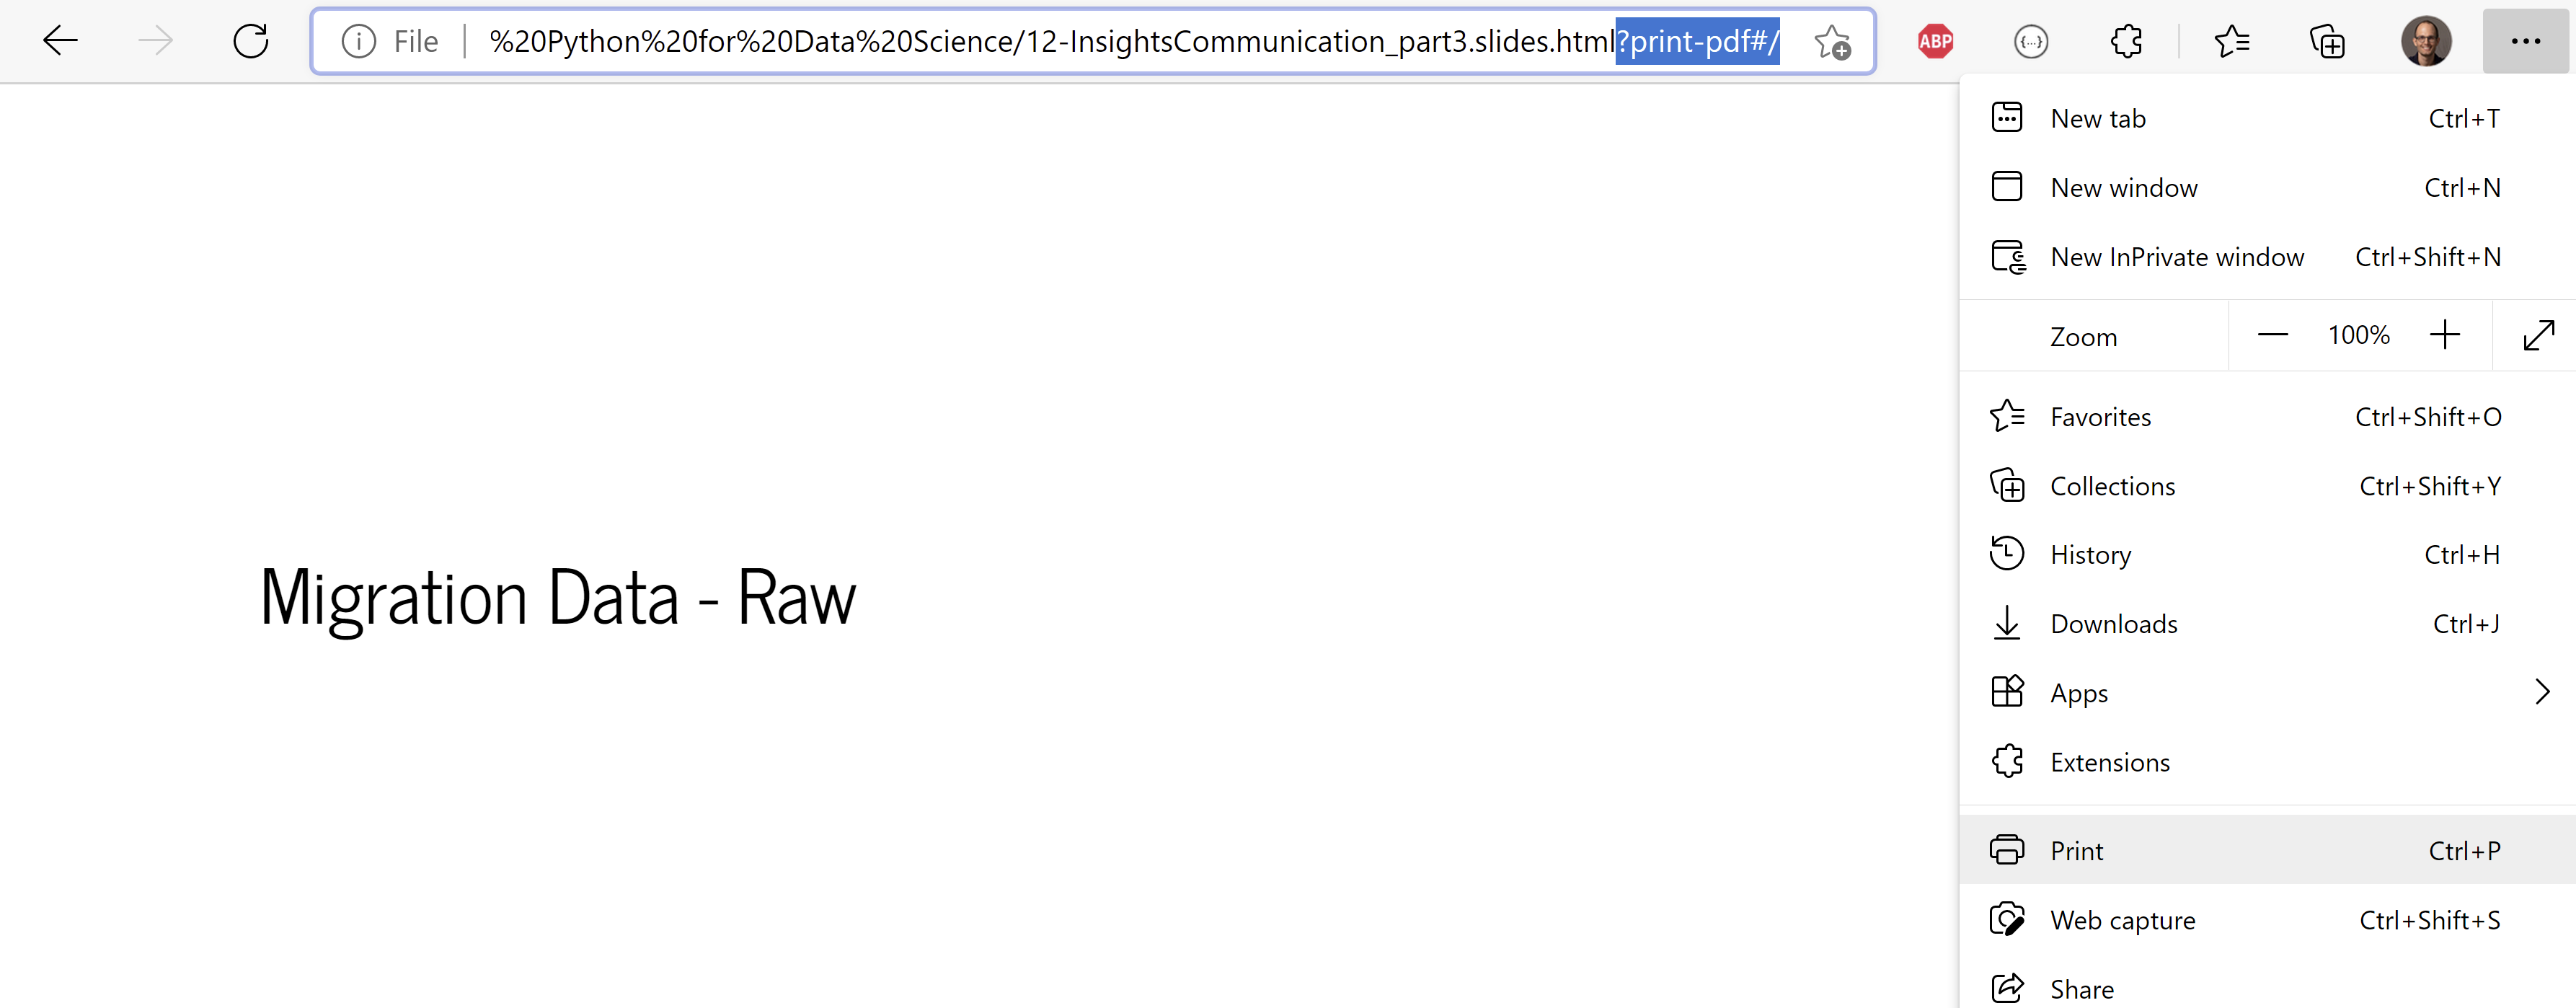

In [70]:
base64_data = "iVBORw0KGgoAAAANSUhEUgAADfUAAAV2CAYAAACJObezAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAALEoAACxKAXd6dE0AAP+lSURBVHhe7J0HYBRF28f/d5fLpScEQuih96rSRKoCKsUONuxdrIj6Wj71fbFjxwZ2EAs2iqIgXZAuRXpLaOm9Xi53+eaZ3b3bhJRLcpdcwvMLw8322dvZ2Wf2nv88hvz8/GIwDMMwTAOhuJgfawzDMAzDMAzDMAzDMAzDMAzDMAzDMAzDMLWNwWBQcwzDMAzDMAzDMAzDVAaL+hiGYZh6T3WFfCwAZBiGYRiGYRiGYRiGYRiGYRiGYRiGYRiGKZ/qCvVY4McwDMMwDMMwDMMwFcOiPoZhGKbe4o4oj4V7DMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwnscd4R6L+xiGYRiGYRiGYRimbFjUxzAMw9Q7KhPqVUXIx6I/hmEYhmEYhmEYhmEYhmEYhmEYhmEYhmGYM6mKIK+ydVncxzAMwzAMwzAMwzAlYVEfwzAMU68oT4RXkTiPhXsMwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzCeoyKRXnnLWNjHMAzDMAzDMAzDMC5Y1McwDMPUC6oq5mORH8MwDMMwDMMwDMMwDMMwDMMwDMMwDMMwjGfwpIiPxX0MwzAMwzAMwzAMw6I+hmEYph7grnCvrPUqE/CxwI9hGIZhGIZhGIZhGIZhGIZhGIZhGIZhGOZMKhPflbW89DwW9jEMwzAMwzAMwzBM2bCoj2EYhvFp3BHqVTZNuCvec3c9hmEYhmEYhmEYhmEYhmEYhmEYhmEYhmGYhoS7QrvqiPnc2YZhGIZhGIZhGIZhziZY1McwDMP4LO6I8/TT5eU1yprHMAzDMAzDMAzDMAzDMAzDMAzDMAzDMAzDuEdl4rzy8kRl2zIMwzAMwzAMwzDM2QSL+hiGYRifpToCPmuhA6npdiSnFSE71y6nrYXFYh3lJTAL+xiGYRiGYRiGYRiGYRiGYRiGYRiGYRiGYaqOJsAzGIoR4G+ExWJEWIgJkRFGREX6wd9slMuJ8sR9pUV8LOpjGIZhGIZhGIZhzlZY1McwDMP4JFUV9NlsDhw8Voi404VinpzlpCwhX1nzGIZhGIZhGIZhGIZhGIZhGIZhGIZhGIZhmJKUJbw7U5wHtG3pj05t/WFWxX3lifnO3LbkNMMwDMMwDMMwDMOcDbCoj2EYhvE5SgvuyhLxEVo+IdmG3QcKUGireD2GYRiGYRiGYRiGYRiGYRiGYRiGYRiGYRim5pQn0rP4G9G7qwVNG5vldHnrlRbylZ5mGIZhGIZhGIZhmIYOi/oYhmEYn6O0CE+bLkuodzjWigPHrDJP0Hx60Ws0GuHn5yfz/OKXYRiGYRiGYRiGYRiGYRiGYRiGYRiGYRjGc5B/hsPhgN1ul5+av4ZGt44WtG9tkXn9fC1f2peDfTsYhmEYhmEYhjmbyczMRE5ODvLz81FUVKTOZeoDpFkIDAxESEgIwsPD1bnuwaI+hmEYxqfQC/cI/bSW1z7/PVCAuNOFMq9BD0VKDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwTO1ATqelHU/btvRHj84BMl+WmI+FfQzDMAzDMAzDnO3YbDYkJCQgNzdXncPUZ4KDg9GsWTOYzUr0+sowqp8MwzAM43NUJOg7esJaQtBHL3YDAgJY0McwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDFPLkL8G+W3ohXmxpwqlfwdR2u+D0OcZhmEYhmEYhmHORk6fPs2CvgYEXcv4+Hh1qnI4Uh/DMAzjM5R+WVv6ha72mZhiw9bd+TJPlBWdLyzEhKaN/REZYRLJDIs/j+bGMAzDMAzDMAzDMAzDMAzDMAzDMAzDMAxTU6yFxUjLsIlkR1KqFVk5DnWJQumofef1CkB0E3+Z10R/pT81Sk8zDMMwDMMwDMM0VDIzM6skAGPqD82bN0d4eLg6VT4s6mMYhmF8Br2or6w8fdrtxVj5dw4Kbco8k8lUIjyt0Qh0bR+Ijm0Dwe95GYZhGIZhGIZhGIZhGIZhGIZhGIZhGIZhvAe5dByOzcf+o/lw6LR9NpsNdrtd5v3NBowaHAKTyVCmmK+8PMMwDMMwDMMwTEPmxIkTHKWvgRIcHIzWrVurU+VjVD8ZhmEYxifRC/qIYycKnYI+epGrF/SFBBkxYmAEOrVjQR/DMAzDMAzDMAzDMAzDMAzDMAzDMAzDMIy3If8M8tMYPjAcIUEmdS6kP4cm0CM/j2MnrDJf2g+EYRiGYRiGYRjmbMVqVfpJTMPD3WvLoj6GYRjGJ3DnZS2tE3uq0JnXC/pMRgMG9QtDaAg/2hiGYRiGYRiGYRiGYRiGYRiGYRiGYRiGYWqTsBATBvULhVHntkF+HZo/SOwpm9u+IQzDMAzDMAzDMGcDRUVFao5paLh7bVn5wDAMw/gcpV/QatOZ2Q5YC5U8jeZm1L0J7tYpAMFB/FhjGIZhGIZhGIZhGIZhGIZhGIZhGIZhGIapC8hvo1vHQHUK0q9Di9ZH/h6Z2XaZL88vhGEYhmEYhmEYhmHOJlj9wDAMw/gs+pe2lE9IVhTrlDeZTDJPREb4oUMb10thhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmEYpvbpGBMo/Tg0yL9D8/8gv4/SviAMwzAMwzAMwzAMc7ZiyM/P554xwzAMU6eUfkmrTes/KW3akYfUDLvMWywWZ6S+c3sFo1Uzi8wzDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwdceJeCu2/5sr8w6HA1arVUbsa9LIhAF9gmRei+BX+lOj9DTDMAzDMAzDMN5B76+t+WbrcRTZUWDNR0FBHgryrcjPz0N+nkjiMzcnR+RzQda7JTAYIaGhCAwKUlJgEAICAhBgCYQlwAKTn2vwDw3qL+j7B2cb+/fvV3NMQ6Rr165qrnxY1McwDMPUOZoxSJTO6w3FNZtykZvvkPnAQFdkvuEDwxER5orcxzAMwzAMwzAMwzAMwzAMwzAMwzAMwzAMw9QNaRk2rNuSrU4B+fn50kk3JMiIYQOCnQ67pZ13y8szDMMwDMMwDON5NB9tve1dLP7EAhRaC5GdnYWM9HRkZYiUlYXc3BxY8/OQJ+z7QqsVNpsN1gL6LJT7MJvN8Pe3iOQP/wALAgODERgUiODgEISFhSE0IgKNGjVCSEioWNcfhlICwrLK09BhUV/DhkV9DMMwTL1AM8IILa//1PJ/rMtGUZEyHRQUJOcR40ZGoozBGxiGYRiGYRiGYRiGYRiGYRiGYRiGYRiGYZhaprCwGEvXpKtTQF5enuLk62fAmKGhch5Na866pT8JfZ5hGIZhGIZhGO9Cvtm5uXnIzspAdkY6UlNTcerkCdis+UhLS0NqSgpysrJQQII+mw1F9iIZZa9YJIejWNjvig1vMhqlWM/Pzwyzv7/09w4NC0XjJlGIbNwYZosFLVu0QkRkE5EaITQ0HAGBgWet/c+ivoYNi/oYhmGYeoEm2iO0vP5Ty/+2Ots5rRf1XTY6Us0xDMMwDMMwDMMwDMMwDMMwDMMwDHO2MvbxHWqOYZi65o/X+qo55mxl4fI0NecS9VG6dASL+hiGYRiGYRimLiE/bL29bSssRFpqCmKPHcGJuDgcjz2GlOQkFAg7noR7dhLwkS83bUcf6rYO8ScsdxjEh+LpDVDwPW3f2nEoGcUCo8kIk8mEoKAQNGkajZj2HdAmJgZt2rZHWEQEzH5muR1RuowNFRb1NWzcEfWVjFfJMAzDMD4KGWcMwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzBM/YX9PxiGYRiGYRimbtBscRLLUa6oqAjxp07iny2bseL3pdi2cQMO79uDEyTqS0xEZno6cnJyUFhoU0V2JMzzk8I8k58fzGZ/+Pv7wxIQgACLReb9xHxaZlTXERvB7nCgwGpFTnYOMtLSkZiQiOOxR3FQHGvzhvVYuex37P5nG5ITE1BkE8dSy0hw/4Fp6LCoj2EYhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmEYhmEaKJpQzl5UJAV7+//djb/XrsKWDeuwYe1qbP17Iw4fPIiCgnwEBAbK6HmhYWEIFHmKokfR9iB2QUK74mKH8ukoht1ul8I9it1HFIu8jOwnoG3MZrPYRxDCxL7CwiMQEGBBXm4uDuzdgy0bN8hjb9v0NzauX4NDB/YhKyNdCg714j6GaaiwqI9hGIbxWUqPrqAYgTziAsMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwTH2iLJ8P9gFhGIZhGIZhGO9DdrdDiu6AwsJCJCXEY8vf67F08S9Yv3YN9vz7L+wOOwKCgmTUPaPRJLchsZ6DBHtqIiGfItKjKH1m+JlMFIhPzrfbiyAOIiP10TKTWI+OKfdBIj/aR5G6H1EOk8kPgQGBsPhbYBNl2vXPdqxfsxp//v4bdmzbjOSkRNhshbLM3G9gGjIs6mMYhmHqFL2hxUYXwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzDM2Qn7kDAMwzAMwzCM56FodyTGy8vNw8F9+7BmxZ/YtX0L4o4dRXpaKoqKbDCZTDD7+8OPBHkiT5AQr8hmo+B8UqhHiUR52dnZSEpIwOkTJ5Bw8jjiT8aJfR3GwcOHERsXh/T0dBSTSDDAgkASCYrjk6BPRt8Tdj5Nm0xGeSwSEdLxbLYipKam4NjhQ6Js2/D3utWIO3oE1oICjtbHNGhY1McwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDYxi8ZeZkY4De/7FP5s3YeNfa7F75w44HHaEhUcgKDhYCucoMp4WlU+L7KcI/GiZDTk5uchIS0Vy/GkknzyBtPiTyE5JRE5qEjKTEpB06qQUCh49ehQnT55Eelo6rFar2DcJ+PxgMBpAUf3ouBQZkI5DQj86dlBICEJCw1FQUIAd27dj84a/RFk34sihA8jJzpJlYZiGCIv6GIZhGJ+DR15jGIZhGIZhGIZhGIZhGIZhGIZhGIZhGIZpuLBvSCkcdjhsNo8m2ifT8KD7RZ/I4Z5S6fkMwzAMw5zF6OwBkUNaSjK2b9mEdauXY/26lcjLy0VIaCiMRpMU1lGUPILEdZRoW7IvSNBH0fRsRTakiH0knYxDbmo8TNYcRPgb0KZxCNpHRaB9dCO0b94EbZs2Qri/EVli3f1792Pnjl04evQY8vPzYPYzwSj255D7prIZ6IAg6WCxoRhFRYXCfC2C2eyHkJBgZGamY93aVdiwdjX27t4pIwpqsL3DNCRY1McwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDFPbkDMyJaMJRrPZo4n26dw/Uy/RHNb1Tuuas72WjEajTKXnE2VtzzAMwzBMw4ee/WQPkAmQFB+P3f9sx44tm3Bo/z7YCgth9jfDbPaX6ygR+RR7gabtRUUwis/AgADYxbKUlBRkJCUiDFZ0bxGO/h1a4NyOLdGnYyv07dwO/bq0Q58OMegS0xKtohqhaXgwoiOCEB0WCH9HIRJOncTBg4eQkJQk9xtgsUgRHwn7KGqfUZgtDrtrgAKDsGvM/v7w8zMjPz8f+/fuwfbNG3FQfCYnJqBYlEk5N7Jv2MZh6j8GUdG5JjMMwzB1hmJUKWh5/ac+/9vqbOd0UFCQ/CQuGx2p5hiGYRiGYRiGYRiGYRiGYRiGYRiGOVsZ+/gONccwTF3zx2t91RxztrJweZqaA/Ly8uQnOd9eOiJUfmrT+rz+k9DnGzr23Fw4snPlOWu+MdVF24cxNBim4GB1LtMQISd8iq5D19zPz0+dyzAMwzAMAyl3S09NwT9bNmPn1k3Yv3evjNoXEhoGG0V2FnYEDQygodmgZIFTRD0xA+npabBmpqNleAB6to1Gu5ZRCAkIQIHNDquwQSx+JA40wVZoR3J6Jk4kpSIlMwe2oiKYhW2SnVeAY/HJSMjIgX9IGGLaxKBJkyZi/wZhwyjRhknoR4c2GJW+gVYOihJoNIl9ZGXIffXuew569jkH3Xr1RmTjJnId5Szrd59h//79ao5piHTt2lXNlQ+L+hiGYTzMunXrsHPnTuzatUsmymvExMTIRAwbNgy9e/fGhAkT5LS7zJgxA++//z5uvPFGvP766+rc+ov+RaSW139qiTibRX07duzAyZMnceDAATlNL7xpmmjVqpX8Pii1bt1aTvftyz+QMO7x4Ycfqjng3nvvVXMMwzAMwzAMwzAMwzAMwzAMwzD1Dxb1MYzvwKI+piJRn5bXkjat/yT0+QYH+b8UO2Q0PYe1AOkLlyLrt+Uwidl2cd4UgaQ6UGQTk9i3XeTDLrkIEZddAlNgIIpJ+EVO2w35O20gaL5RhP4esFqtKCgoQFFRkXTEp/VycnJk9JyAgAA0btwY/v5KxB0S+FksFjlNeXLYL2+/TMMiLi4OL774ItauXSvzmr/ilClTpL/h2c6JEyfUHKSfHcMwZUPtB/lCU1uitScE+TxPnDhRtieaLzTjg9AzXzzrs7OysHXT39i1fQt27fgHZpMf/IXNQEI6zS7Q2wQ0j5ZRJL0iYTsmJyXCkZuFrs0jcEHvzmjTrJGwKQwwif0YDEYY/ESeBHVkv9odyBN2SlpmHpIzspFBA1Y4isX6JmTl5mPvsVPYezwe+cUmtG3bFjFtWks5Hon/tBKQrarlNcGhLJ/4Zy2wwiHKdG7/geh9znno0bsvQsPCxJq0F22r+gmL+ho2LOqrJUiw8/XXX+OGG25Anz591LkMA9mJzs7ORmhoqOw4Mw2XefPmYe7cudJ4rQ5k5A4dOlQauhEREercsgkMDJSftF58fLzM12f0L4y0vP5TS8TZJOqjF9r0fCExH6XqQMI+SvRs0n9fDKOHRX0MwzAMwzAMwzAMwzAMwzAMwzQUWNTHML4Di/rKZvHixdizZ4/M9+jRo8oDQdcnWNRXAeT7QslohCMnB+m/LUf+H6vgn5AkTtoolpGgTz13d78CxZ1GIDLqPgqbRSFozEhEXDoaxlDxvas+N+KLVT4Zn0LziSpd7+n+SUtLw7Fjx3Dq1Cnpj0hiPvJNzMjIkKI+Eu+RqI/8FMlHKCQkBNHR0VK01KJFCznfbDY33HuKkcyaNQvTp09Xp86EghDMnj37rBbisKivcqgOkb1CkJ3SEAJPMO5B110T8VFAk4oIDw/HnDlzGrQtWx8hW0J71hcWWLFn9w4sW7oEJ+NiUZBfgEBhI1D0u8LCwjNsAhLlkWCPIuLZHQ5pX2QkxaN3myiM7d8DHVo2hb/FDJtYZvIzw0/YFbQ+HMJ+KVIiB1utBcgvsCE7z4pMYb/kFVqlaVpQ6EB8ajq2HziGnUdOoNg/EB07dEDrVi3l4AMFoqwUuY8MX+0ctPIVwwF/swVFtiLk5ecgLDQcMe07YsRFF6Nr9x4w+5vletLOrad2Dov6GjYs6qsFSHBx8cUXy84RGbp8UzF6Dh48KEfFoQcgdQCCg4PVJUxDgcR8FDlPG4WippBQ7+mnn8bUqVPVOWeiifoI0YarufqL9kKK0PL6Ty0RZ4Ooj17ErVy5En/++afHri/VmYsuugijRo1icR9zBizqYxiGYRiGYRiGYRiGYRiGYRimocCiPobxHVjUdyaLFi3C+vXr1SmFIUOGyIGgGyIs6isH8ntRz6uIxFlr1iN17ncIyMpFvp9JRugrFn/VPXfyqxHfKoxiX5ZCG6yhIYi8cRLCRl4AEwn7lJWcZWB8Ey0CX1JSEpKTk3H69Gnpn0bzyB+REkWwIad8EvnRdSffRIrOR9Bno0aNpKCvVatWaN68OZo0aSITzScRINOwqEzQp0FRtpYtWyYFOWcjLOqrGKpDVJf0kC8rC/saJiTcIwGfJuarDlQ3KvJ3ZuqCYtiL7Diwdy82b1iHzX+vF7Z4LiIbRwn7oVCK7zQ7U9qNap7sChnpV9gIp+LjkXz6FGIaBWLiBX0xsEdHGbmv0FEMS2CAFNmRrUmR+EjURxGhi4TdWZCfB6u1EDZx/HybSPkFyMnPR0auFVYx71RKKrbsPYK9safhHxKGc/r2RvPoaLk+laW42KFEltZjoGNARgf08/dDmrCFQkPDcf7QEeg3cBDatmsvBy6oz7D+qGHDoj4vQ1G57rrrLnUKaNOmDQ4cOKBOMYxL1KfRsmXLSqOwMfUDClFPbUBZYj7q+NLoE1roeprWrjutT4mEwFpo6rJGtKDtnnnmmTJD3rOoT8k3RFHf33//je+++67M60ov2Dp37owuXbrIOkDnr71YoJcN9AKctqPnELU9J0+elMv00IhcVDcHDx6szmEYFvUxDMMwDMMwDMMwDMMwDMMwDNNwYFEfw/gOLOorSXp6Ol555RV1qiRPPvmkFNk0NFjUVwbk80JR+IwmOKwFSF+4FOk/LIQxMxt28o+haCeqX0yNoe/WUQyT+HSEhaLRVRMQcdmlMJHfkcMulhvlOkzdo/lGUX2nz9TUVBmVb9++fdLJ+8iRI1LkR/5nJNLTR+QzGo0yYh99KpFuCuS61ObQfshHjZz3o6Ki0K5dO3Tr1g3du3dHs2bNpPCPtiEa3L12lkH+iHqHcfJXJN9DisxHy0hUTv6OGmezSItFfeVTuh7pobbobI7w2FCga0x+y9QmkO9yZmamuqRshg4dKtsRGoCC2hWC9qGP5khw/fANNFuiyFaIlOQkLP/tN2zd9Dfy8/PE894sAxSJtaRdoEexAYqlLWEUNmqh1YqDhw4hoCgPk4afi/P7dEZISJAwHYWdYvKD2Rwg15N2i7qt3WaDvcAKq7BDCsT2NluRFPHl5xciJ49EfQXIyCtAalY2TiQmY9uBYziVniN1FT1EuxPVuAkKi2woshdJ20TzE5eQeUw2rSi/cn7iWOIcwiMa4dyBgzBs1Gg0bhIll2vfQX2DRX0NGxb1eZHSgj4ateKPP/5Anz591DkMA9lJjo2NLfEAZGFf/YZedNx9993SqNVDol7q7JLxWlXjlPZJbQqNcHL8+HF1rgK1KR9//HGJtoVFfUq+IYn66OX1G2+8cYYQLzIyUkbY69u3r3whVxXoxdyOHTtkxL+0NNeLcoIEgtOmTeOofYyERX0MwzAMwzAMwzAMwzAMwzAMwzQUWNTHML4Di/pK8v3332Pbtm0yT8IagkQ7xLnnnotJkybJfEOCRX2lIH8XSkYjHCS6+m058v9YBUN8AvLsRXCQo7LmY0auMdqpK24ylaNfX80Xi30axT6DTH4obh6NoDEjEXHpaBgpYp/qfyO+ZOWTqRMoKg450RMkriDB0d69e6VzN0XnIz8xiqpHnyTEI58fEuiRvypF5qNl5EtF9wr5KJKgLzc3V/qjUYQ/iuxHifJ0H4aFhaFDhw5S2NepUydER0dz1L4GwJ133ol58+bJPAlvNm3aJPN6SICjf9YkJCScldH6WNRXPvp6RGIuggRgBAWnmDNnjswz9Qd6rpB4T4vGR4K8iqD2g0R8lCh4REXo6wutTxoKpm6RvtXCHshMT8Xm9euxc9tm/LtrN0LCQsWz3gKr1SrNPrIZyP4gKK/5aAcFBqDAWijqyXFkp6Wgf8fmuGH0YLRu3gS5YtuAgAD4mf1hNJlhMPpJm7aYBokQ29ptVtjz88UxXKK+QpEKCmzIzs1HanYukjNzkSVskWwKXnIiAf/GnkZ+YRG6dOmKnt26wuRnkqI+0TuQZdOjlZMwC7vFJo5B9k7fc89Dn3NE6ncewhs1kuvUx/4Di/oaNizq8xKlw1TTQ4weRizUYsqChH2nTp2SnxpNmzaVnWumfrFz504p6KNPDRLz0ag2U6ZMUefUDBILUvuiF/dR2/L77787hX0s6lPyDUXURy8KSNCnv5Yk5qNO0fnnn6/OqRkbNmyQnTK9uI/qEQn7+OUEw6I+hmEYhmEYhmEYhmEYhmEYhmEaCizqYxjfgUV9LkpH6dMGkp89e7b8JBpitD4W9ekgXxf1XIqys5GzZj1S536HgKxc5PsZ4Si00Uryn4RW1fJVRb+tPKQBRn8zAorssIaGIPLGSQgbeQFMJOwjdGVj6o7ExEQcOnRIDuBNjt0k0CPfHhLg9ezZU/qokQCLoutRMpvNUgxIUWk0UWBRUZHcTkvkr0j+SCTeOnjwoEzkk0bzKTAB+aLRvsl3KCQkpOHcb2ch5CyuiXVIRF6eGGfgwIHYtWuXzFe0XkOGRX1lUzpKnybQGjt2rPwkOBpb/YHEfDNmzJB6h4qgZ4sm4qOAJlUR+pauM1w/fAO7sAX27dmNpYt+xqnjJ6TIzuTnJ5/xmpCPcD3zyT+bzEFF1Jecloadu3ajQ+MwTB7VHwO6t0dwoD/ybTYEWALh5+8v7EoLjOYgUteJHRlRXGSDoyAHhTkiWfNhLSyUNgkJ+yhSX6awd5OF/Uuivuy8AuSJ5ckZOdgTexqHTiWiSVRTnNO7J6KjmwJGg9hHoSwf2TdamaWtQ2UW5aR8sZhfKMpEgxW0adsBo8Zcgk5duwi7SIlAXN9gUV/Dxh1Rn2LNM25DL1VY0MdUBVKmt23bVn5qJCUlSaEfU38gsd3FF19cQtD39NNP48CBAx4T9BFkGNM+ad8aNHISHZtGy2AaFiS2o86TXtBHIyK9/PLLHhP0EbQv2uf48ePVOYoglMSEVAaGYRiGYRiGYRiGYRiGYRiGYRiGYRiGYbzD8uXL1ZwSpY9EOpS0iH2Efh2mgSE9pRWHZIe1AJlL/0TKV9/CkJElI/QV21RBn9colsfIt9thyMySYsKMX5fJaCrKYlE2KiNTq5DzvOaofvLkSWzduhWrVq2SgiuKnNetWzfpL0aCGormSW1GixYt0LhxYynA0wv7NPz8/OR8Gig9NDRUBh0g8V6PHj1wwQUX4JJLLsGFF14oo/3Fx8djzZo1WLlyJfbt24fs7Gx1L4yvQKIc8lcmR3ASeFaU9NG3KhLqkXBHg3zUytoXJTomHbuyqF5Mw4F8GDUoSp8m9NIi9hH6dRjfZe7cuejSpUuZgj4S7VEb8frrr0sREfkqUwRG8oGuauROEvDp2xv2b647tEApRHJiIg7v34v4U6fEcyQD/sIuIPkeif01aH25Df0Tn6SVIxuCRHLZWVlwFBWhTVQEOreORoC/CTaKnkcr0Y6MZsA/BMaQJvALawpTSCSMgaEw+AWI5CeFd0ajSCajtFGkDk85rDgW2T3F8DMYERxgQURwIALEZ6Y4ZkJikjh+IUxiu/KsUjq8Jk6kz8CAAKSnpeLEiTjEHjtSIuiJ/jthmPoAi/qqABmp9LDTIGOFBX2MO9CIOKWFfSTUYmFf/YDu+8mTJ8trRtDoFBs3bpQR+rwF7ZuOQcci6Nj0kkbfBjH1GxLTffnll+qUEjmPrju9PPMW1ImiY9CxCBL2URlY2Ae8+eabMhInpSVLlqhzGYbxdYqxDU+0CJYddUqfbShSlzCMd0iOW4437r8K57YzyzpnNETj3OHTsSlN+cGNYRiGYRiGcQ+25RmGYRjG9/Gl57U18SeMDlFGFQ80TMCfpxvuuxi2k9yDvyemvnHFnd1l1DpKS1/ohL5uemsZYMb5Y9vgvWd6YrG6PaXfX+yOe/qxy1d9gaL0bdu2TZ0CRo8ereZK5mkdWpdpYEiHaZGMJjhycpC+cCny/1iFwJw82MUTzeFncjkd04f0Vlbz1aWM/dAx6Fh0zMDcPOQvX43MRUvhICGXKJu6kvLJeB3FgV6JQEPBAf7++2/8/PPPOHbsmBTcUTS1kSNHYtCgQVJc1aRJEyn005DX0+FwfmqJpinpIb/F4OBg6YNGASzI55XanvPOO0+uu3r1aixdulRG8csRdZTxDUhMR6Ic8hX0pLDOXdEOHZOOTXWRxIVMw4au97x589QpxXdVQ5+ndbg++DYkDCetg/46UbtPQUY2bdokI7dSlM6pU6d6JKqeXijMor66g2wKgqLjHT18CCfjYlGQnw8/YQPQMmEdyOWlofkOh2KTmP38kJeXj5zsHDQKDkTr6MZoFBoo17ELe4Ei4Blof2Z/mAJDYAoOl59GP7OY70eqQBSL5WJnYp+Q+6VoenZKUsxnhKHYCAfZKqK4Zj8jQgMtCAsKFOW2ITUtDbnCRi22i2OpUfnITqGyaeeg2Tnin5giE1axYfNyshF/6jhOxMbKfTmhFRmmnsBveNygLDHNjTfeiGXLlrGgj3Eb6iDTiDn6OkN1K1Y8RPQKeMa3oMh8jz/+uDqlROck47ZPnz7qHO9Bx6Bj0TE1yOBm6j8Uxl8v6KMXcs8++2ythPSnY9Cx6Jga1FGjMjU0SLSoifWeeuopObIZwzAMw1SPTPzyzMXo1m4MHvvgJ2yPVZyEipGEvWv3I7tATjIMwzBlkLbrM4ztaEFgdBc8/MFWFKrzGYapfYpxHN89NhZNjAb0G/sg/jrKAxMwzNnOnmVPYnBLMyJixuDV346oc88u2FZhmJrDNgbD1D0k/Lr81i6q6Ks3PrqjKVxu/0x9JTCiEZ5+ogueuzASncP8SlxTg9mE8FDFcZPxfcqK0qdROlrfunXr1BzTICBHYoO4V41GFGVnI2v1X8j4cREMpxOQL6OQGGAgnzHyN6akifA84X9cxj7pWHRMOjZEGdJ/XIzMVX/BTsI+Kicldn6uFaRzuviuKVre5s2bpaiPggOQ4GrEiBFyQHCKrkdR+cjnkNYl/0JKlNf2oX1qScPl9K4kLaINBSQgvyESalHUPhINUmSe3bt3yzIcOnSIhX0+AkVE8wXxFJXhscceU6eYhkpZUfo0Skfre++999Qc42vQ/TpmzBh1SgkAQdH4SOtA4ky9H7Kn0NeVxYsXqzmmNtHsAvpMS0mRwrZDhw5L8y8gMBA2m00sk6sIlIwSQU+1HeQsGtTcgLz8fBRaC9EsMgzRkRHCBhH2arEDxWKZUdgLUtSni8DnKCqEw1YgPm1wiP0UQ6yv7pN0fHa7QyYS8tFs2s5oENsa6diAxeyH0EB/mEQ+Oy8Pmdk5srwk6qOyKdsp5dTbNXQAsm1shTZYhG3jcNhx6OB+nDwei8yMDLmOPDeGqUewqK8SSHRFYcz1CnIS9FG4WYapDhTSXi/sy83NZWGfj0L3P4mB6JMgo7a2o3PSseiY3jCombohTxifb7zxhjqlCPqmTZsmX8TVFnQsOqYm7CPxG5WJylaX0MtBLVpeVROJ90pDLxwpRDyRmprKEfjqLZnYu2wupt56ITo2V0aPISerMZfdhblLjyBH6Wu6zfHlj0rnEtrPtK8Pq3Pdx5Z5EAu/fAa3XTHKGamLUnjMQIy7+SF8/fN2pFWxTHqU/U/HdaMGo6XoBOvP96NvNlRp33/M7OYsX0Wp68DhzrKn5Neg8IwP41v3UeKB5fjwqfswfqSrnmt18a6HPsWyf06ra1YPT95HClZxP12FK178A6nqtgY0Re9hwzF8+HD0bFvfXgRxfahOfSAB54eTmjvLV1Gi/dMPrtfe/QQ+/WYp9hyrWxurfsD1smbtlIvsxF1YoNoqQ7q1cJadEtkrI0dchgef+EyeQ204rBfjX7x69UNYdqQQBUkHMev+2/DDdn7/4askrXveee8MuumHKt97iQe+xjWdAjDhxb/UOVXD27Z2dcja8pazHFGGGdhPv0jVYw4tfgHXvrFM2jQ7lr2H/7zyW5WvM+MprDi+cxnmfvyYeB6MLFHnKbXpMly02TfhmQ+/wapaarOZsw9r4q944uo3sPF0ETKPL8eL414566KQs63C1AZZcZvLbO81G+dT0Qeo7+/k2MZg6gOhzSNw/XXt8XGpaGckgFv4Qne8eFNz9GxRfx2+WvZviSldA1XRlxHtOkfhnnPYHag+Y0QI7rmtJYY29lPnKBTbHLCK5E4fgcSeTzzRW43s1xkj1UBcGiZE48NX+sjlix/xzOCzgyZ3cd5fv/2fS7h2NkO/xZcXpU+jdLQ+2oZpAJDDsYxKAjisBchc+idSvvoWhows5NmLxP1MUUTqwmgqlsfOt9thyMxC6tzvkPHrMti1ekdlls7SjLdQnNGBxMREec//9ddf0n/wggsuwGWXXYZ+/fqhRYsWCAoKkoI+rQ8hHeFFqira9to+aJ8kHmzfvr08JvnGNm/eHHv37sX69etx+PBhbod8AL3ImyJs0TVxN1UECXvK2qZ0omNqsOC8YUNCsPKi9Gno582aNcsnBKfMmSxatMh5bUjQR4EePBGNryLIr1mLAErHpkiBTO2i2RUUmS/u2FGkp6ciS/q8F8NE0fPU5WQHaGjzJLpXISToMwhbsHlEBBqHBdEuxLpiBYOwPyiJ7YqFDemwWWHPy4QjLxuOwgIUk6iPNBDasej3ZhL4if9JmCfnGYrh52eUQj4/ozJgAQkJgy0W+It5VnFsGliARH2l7R39OejPg4R9ZrNFrGBAWnIKMtJSEH/yBKwFyrNQd5YM4/PwW7wKoJDC1GmhSF0aZKyyoI+pKSTs0wt4CgoKWNjng5BQSLv/yfCsbUGfhibsczf8PePbkHiOXn4QgYGBuO++++SLuNqGjknHpjIQVCa92JBhfAFb5hY8NboPeoy9Ce9/sRJHEpQfPcjJavmiObjp0o64YOxMHHLT6cVuXY/n7/pQOpf0GD0Hj1/fUV1SOTTa9FePTUDbyK64/JYX8fkvq5yRuois45vx21fv4sYrz0WbZsPw5m+n1CXukol1c65T9z8T367aiNOqw7B2vvdePwQxzcbgsw2pcr6nOLB5rbPsTYPa4p43V9S6szTjPXzpPso/vgR3X9oZzbqOwX0vf4hfV7vqOUF1cc67d2DsOS3RY/h0/H26qs6k3rmPcnZ9hieeWiXzJOabNH0xUhyJ2LlmNVavXo0txxbhohb1o2vN9aHm9cEdaP9r1qzBd7Nfwx3XX4qe7YNl5JMnP/gNp9Ld+27PJrheeqZeJh5Ygmeu6oqwZn0wSbVVNuyPV5cqkL2yes0ivPfa7fIc/vM1R7Jm9GRixfdfyHuHuObmixHipj8rCZ+XvHctzuk+BT8ctqpz3cf7tjbD+A50v/w2+y4MbhmCmL5jcdM9b4jnweoSdZ44cXCtaLPn4sX7rsco0Wa3iJlSjecOwzAMU5dkxin9i/C2A8ts7zUb5w7RB2jbdjhe/unsjJbJMN4mMCIMt9/ZFfMfaYub+4WhbaloZ+QyExDoj/N6RuONh3vilasacYQ7xifoemk0RjVzCfry0rPw5Ns7cfHTuzBRpAmP78arayv2LzEiAs3Vzr0914b1pVZv3j8QTVWHyJNpNXfMNiIU4zoGqFPkc5Ws5s5uSKyjUTpKnwbNI0ENQf5D+m2Yeo7RBEdODtIXLkX+H6sQmJMHuhWLpYM1rUD3oOqcLJLewbpY/DmRqynrnJmUVRSUbUpsKzBQtBPpHE0r03GUMlBZAnPzkL98NTIXLYWDIvaJMjPeQe+QTg7rR48elfc7DTZPootRo0bJCHrkU0jO7LQ+OatTorzmyK53ZtfP0ydtmR7t+Nr+LBaLbH9GjhyJIUOGwN/fHxs2bMDGjRuRlpbmXJ+pG8h3WaMskZW30R9TXxam4aGPvFc6Sp+GPlofCbc4Wp9voo+UV5vtBgkINfQBlJjaQXve5wg77tjhQ8hMTxV2hCLkVx7lLhtQSYpNIO0BkTTbgcR3RfYimE0GREUEI8jij0IaiIKWkwgPZD8Iu4QEfAX5IuXCbhWfhRStzybFgFQUaXeKDNmjxQ5FuEcDClB5zH4mmM1mGQGQjm8XyexnhL/JT06TsI8i+9G6VFLNFpFlLBb7FPujefI4zvMyCvPVJPUXGenpiIs9xlGHmXoJi/rKgYQ8FF5cL+ibPXt2nRjITMOkWbNmUtynQS/mKEoVfTJ1D3U8aOQKjboS9GmwsK9hQC+/Tp50Oc7WdoS+0mgR+zSobFTGhsLgwYPRpUsXmadzHT9+vMwz9QO7dSv+b8IYvPxnnOh+NcUVD3yCldtpNJlYbPr9Ozx9pXJtdy6fjptu/hqJlb5PtmLZjCfweWwB/NAfT71yK6KVfmqlWBP/xM1DeuLmN5aUcOwPaNpZRukaOrCdOkchN2kdHht3Dp5wOzJQJn555goMu+vbEvtv3XmY2P8gtBAdbY2cpOW4Y8g5+L8fvePkQw7VH0+7SBx3BvbmVfqlehx7wXFsXDQbt116M9aww2qN8aX76PDyRzC442WYvfSQOkdBqefDcU7bkqMN7107E5f0m4xlR90d9MJ799H6ZR9jp02pj91Hv4h3Xx2PSDfP25fg+lA37aoGRT559f5x6NJ1OGbM3+MTEQt8oc3leumJemnFlrn34JzuE/HiT0qUal/CgJ544od3MKaDv7SdHvt0Pq4+h51CfBFb5nr8MFeJQhkVNQ0XDQ6W+YqhKJuzcHHH1pjw4Hcl6ra7eN/WZvR0mvAcvp02Bo1Fk3PO6Bl455VL3RZv1ld8qY9xevMH8n4Zd/ccGRmtKuQez0CummcYT2GJHodXf5iGQS38EN5mNN5Y8QoGRtb3nw2tSDqwFl+8dgemvFG5IzTbKoy7OAoysWvN93jutqGYu8G9Njxh87dn9C+6DCi7f0E2ztNXnY8739xaL6Ozno02RkPgbHkXe/E1rTCpU0ApoV55kc5M6DewNV6dXHe/CVeXU1tOYe7+fPWcHNi/Jwkfba+76xoQEYShY1vjpUd74Kfp3o0M0RChCHtjuwQ7622xLQ/vzz6Gf05Xrd8d1TsQ0f5Kg5yRnntGnW/S3qK213bEHqt5j6NZv0boGKY9AAqxaT07UtLAunqBXllR+jQoWpYGbaMNFMzUYwwGFGVnI2v1X8j4cREMpxOQb6KIJYIiG4oddpnEf3DI6HgOcf+7jCglL92hxSJyulbWPzPRHrX2Qdm+9LYOe5FMYsK5HYoK5XIqE0TZ0n9cjMxVf8FOwj7ylGa8Comk/v33XynsI18w8lPt3r07wsLC5HJyWFec1sXVVJM2j9DmlYe2TNtOv76WJ+d3Eva1bt1aigl79uyJbHH9t2/fLqP2kdiQYZiGDQn0KPKeRkX+8VOmTFFzHK3PV9GL+iiCXm2hF4KyqK/2UZ7rQHpaKk6eiEVSQgL8Lf7i+S96ejLQkMt+KA3N1eyDQpsSbS/A7IfwkCD4+ZnEPGE/GpRIwYqgj6JNk4jPCrsU8yn54iKRHGKZ2I/RaBKbUJnItnVIoZKU6ImF0qaVti8JCB0oIrtULDeJ/dN69iK7FPpRmTS7R9ox0rZVhYIiJ6MHShR7hqDBCRIT4nHqxHFkpqfLedq5MUx9gEV9ZUBCPorQp++YkKBPb5QwjCcgoZZe2EcPF4rYx8K+uuell15Sc8Brr72GPn36qFOeZ8aMGXLUNYqYVlGiFzjcGaq/5OXlyZDmGpMmTZIvxqrLjh078L///Q9PPfUUlixZos6tOlQGvdiN9kVl9QUee+wxfPzxx26lRx99VN3KBd03NJ+W0z3dqlUrdQlTH/hrzlN4ZV2G6Ho1xfR56/HTu7djZL924tkZgwFjJ+F/Py7Dhzd2kutuWjANn/6WIvPlkbrrA/zn1b9lftKMD6rkoGU9vhtzN2TLfESbCXhn/nqcznMgP/GAjNK1duNR0VnMwD9/vCedwAiKvvDmjdfji+2V/wi6c97tuOJFVxSwm19cgqNpDhw/sEbs/2+csufjyJpZun0fx+tXP1wFEQFw4WOLkS46rGemBOzauBAz7xtXQkzw77pncfst7ognPIc18Sdc3KQ9Bl92N75ZmgabOp+pPr50Hx3Z+btTGNd/wgws3HAE1mJRm2U9X41tx2wozDiAH9+Z7KyLmUk/4N5rX3YrOpe37iNab+9yVzSgsTePcFsg5GtwffBsu/rgJ7vLaFO1FIstq3/HVx9Nw+TB7dUtFMhR89kbemLczT/UahtbGl9pc7le1rxe7lpwLy65+WOnGMqANrjqrln4bcNeJJaqm4d2rMb3X0zDxO4t5Lq1RWTv2/DHYau0nV65rSdHPPBR9i7+DD9lKq3B6CeuRZ+gih54mdi4aCYu69EdPcY+gGVHqu967m1bmykJtRGTZ/6BFNFmbFv2NM6p9+KdivGdPkYm1sy6Er0H3V/ifiEB0S0PfoIlK7fjRFrJNvvE/o1Y/O1H4jnTSwokGMZb9BjzCv4+ZUNG3DLcOaruBh/zFH/M7IvorsNx6xOfIsPNn1nYVmEqQzw18Z/2LdBnxGT89/O/qvQ8Idt//E2zsGZvquxf7N/k6l/Y8zOw/Y+ZGNZSEfiRjfPFtPswvx7aOGebjdEQODvfxdpx8Gganv9oL8Y+rkU624Hb55zEigT9N2BE93Nb4JaO9aseF4ur+MvnB+Q50fk99GVynYqE7721I565sDHObWbmZ2s1oAh7MbqR5VJPZuJPLbR+FWjcyeIcoO74qTQlo6NvpCYyt+PwhpqLQIcOCnUerzA+B/MP13yf9R0S52n+P+QfVFaUPo3zzjtPrkNwtL6GgV1cx4zfliPlq29hyMhCHkU6sSnPHINBPGfIyVhNmqPymahLdOvK9UslGEwiqfuUUJtR8bZyfbFGcZEdBeQsnZWN1LnfIX3JMmGrsqjUG8jvXZCQkICtW7diz5498r7v2rUrunXrhiZNmjgj2WjrehM6DhEUFIQ2bdpIAUiPHj2kb9r69etlcAJf8R9iGMY7UOALzR+1vCh9GuQ/T20FQdtwtD7fQ7s+tQ3VDRqQgpLeP5apPazC7kxJTkRyUhKysrLgZ/aXtoSDBnKoBM0eoD5IcVERggP8hW0QKMxLI2xkv8qBJ4rloBBFwpalZKf5DtHfo4EjbFYUFeaLRMI+irJngp+fH/zE9uRWIQeYEPu1FzlgE5+FtkIUFhaKPAn4lH4uFYFMH1uR2L/dRkeT88+gtHlkoPXscrZZnHNmRiYSExOQlpqKQqtVrsIw9QXlTmScUGQuvaCPRkKhkOIs6GO8BXXO27ZtKzvlhCbsy81lx6S6Yu7cuc42gAzdBx54QOa9xYsvvlit0Y04al/9YsWKFc7R9CIjI3HhhRfKfHWhDhBF1ksVBiiNskKf1YVCoFOZCNoPlZVh6ppv31J+qOoz4Q08cX1HmddDjiK3z3obV4abRTcuCUsXbiw36lEx/sV7D/xPOuq36vUYnn7k3Cr/iEzHu+/9v3AidhEevO58NA8s3UsMR98xU/HLyvkY31rZexG2YOaT31Qo2iDnicfu+UXmNUHDF0+NQ7tG+v1b0H7Y/SX2XYAlePmVpW5HegoU9gbZHGemaPQaOBHT3l+Co6eX4f4hysh/xMYFU/DBTxWLJxjfxW5d73P3ETnqf7M+BZsXPY2Jg9ufsb05vDOufPBbLP32Fqfj8tEtz+Kd+RVHqvLufZSMhN2uH6vaC7u9PsL1wfPtql9AWW2qlmJw3vCxmHL3THy74QiyEjZj1qOjSzjkr517DS6fPK9OhX11DdfLmtdL2u+0W7+C5tPVesAdWHHkGH74+H5cMrgbmpaqmx37DMc1N8/Ewj2nEL9zAfrWx7CjjFeg++fnWUo/0B+jcf0V/WS+NJlxf+Ll+8ajpakRBl82HYv2KpH9gpsOxQUDA2W+OnjL1mYY38CKP2ZehREP/Oxsr+me+e/XW5GccACfv3M7xo3sh1aNSrbZrboMxPjJd+ODb3YhPv0A5r9zAczK5gzDMEw9wRQ+HL/u2YfFX96PYd0iz+hfGAPC0W/MNPy+4dsSNs5Hb7vfN2UYxj3sOXn44NM9eOCj4/j7aEmp28lDKXj9zYP46JB+vj8GDglR8wxTF/ghRI2wR2RS1Kxq0DlS60UU4ti+kgI7I0LRQRX12XOs2Gav2cMnKKIZRsRoIkEHtuw6VafCUl+gKlH6NPTrcLS+eorqOG3PzUPGoqUo/HMNArJzxV0BFPv5yUgj9Dau2GiCyT9IpEBhOPqj2EAR/JQ/Wi7X0T5JsCfWMZoDlOQXQD9SiGQRSdiRBhLmFaDYJhJF45NbKW2I3Fasp21rMFlgMAeKJLY3URshthXb2R3knG1HoCh34Yq1yFz0uzgH1W/NDWdwpnK0CDkkkjt+/LiMhkcDO1F0vv79+6NZs2bSd5DWc5DzOznKC7Q8JU2Qqe2rMmg9Sto2dI31+9agZSTs69y5M0aMGCH9hw4cOID9+/cjLS1NbscwTMODhHn6KH3u+MjrI/lxtD7fIybGFSV9165dao45G6B7kYRs1oJ8YdfZnYMEEAYD2QIuG1OZ5+pvanaCzWYT2xkREhgIP5OwW4WdSKI7EuIVF9lgFOuY/UywBATAEhSKgOBQmMSnwRwkbAVhv4j1DAY/1e4U9ifZLaLnSSI/s9mMAH8LgsS2/mLfJOijKIAUlc8hjiEHvBDYxXHI7qAtNbtHlk8WVPRjRV7Zb8nzUoSEZhQW2pAvbNjsrExhc7EGg6lfsKhPBwl5Jk+eXELQ98cff3g1QhfDEMHBwWUK+6oj9GJqDonsNF5//XU15z2mTp1aLYEebcfUD+ilnF4oRyK6mlJaxJeSUjPhjb5MVFYebYupaxYcU36kuubui52jepbGL/w8jJ/YVOb3z9mBk6LzWBa75j2PF9amw4ReeOLD59G9wqgjZ2K0NMXcbdvx/n1DEFLJpoFtrsKs929Xp4CDy7/C1mPlveS2Yul7z+HPXGX5oGveL1PQoEH7fv/T+50igg1z3sWacvdddSzRF+H1+Z85nYiIHz/+hR2l6yn5B7b41H0U0vRebNyxENeeX3nkh97XvIWZt7uiq674cnUF9bB276MzNAb1BK4PZePtdlUjNLo/7n9jGXaseQ6DWmiOLYp4+rX5h9Wpsw+ul2VTlXq5ccG7zv0GYDw++eYjjGzv3qu+Zr2vxpRLWqpTzNlO8rofMGuz8g6q35S7MLyd8n6qNAmbv8BTH/7qjAxJ9J8wE6v/WY1nrnb9UFgVvGdrM4xvQBFVb3jc9U6o+7DHsHbfajx7/bmV1nkNEpVf8eATGN6Cf85hGIapT3Qccycu6a4MplcRZOPMeMn1fn7/3NU44kY0cIZh3CM3PQv/N+sQFh4o6byuh6LcLZqTjH1W173XKpIHV2V8B6sa2asqGBCEHqpoz5Fvw+YjJe8BA0LQPEzplOSlFyC2ho+e3mPD0Z7CMAjsObn4ZtXZ2V8ngc7Ro0elIG/BggUlovRRJL7KKB2tj/ZB+6J90r4Z36dYfW9WLO6DrF+Xw+90IvL9TCim+8NWiOJiA4zhTRDQtReCBp2PwIEindMf/jEdYCBxH0U9EXeoTCS8MhhhimgMS7eeYv0hyjYDBqv5IQjsPwiWnufAHNMVhrAmYh/iWPRHQjwSDkY2FdvSsdRtBw5WjilSkNiPpZeyrSm0CYrN/sgzGeAXn4jM35aLc1B8RrRzYmqG5jxPvj2HDx+WPoEBAQEyOh6J6fz9xfUvdonwCHLGJ19CvWM+oS2vDM0RXstr+6JE09rxtGM2btxYlociB9I8Kif5L2ptGcMw9Z+4uDisW7dOCvLuvPNOpyiPAl+4I+rjaH2+jV7Ut3btWjXHNHTomZ2emorM9FSpPSCbgeaVJeIX/+SnE2WGOq9YsTlMRhSJ/VBkPUOxsD+ELegosgs7Vawj7FWYLcJuEDanmG80+sEkbEijySznmUx+8PMPkJECi8W2NrsBhQ4DbMKmLaLl5kD4WwKljeugCIBSmEd2ilLmQtH3tdkoOqBiuygCPrJlaD2ykJU/WVr6T+ToNB1igtanfRUV2ZCbk4UsFh0z9Qz+FViFBH133XWXOqUYKSzoY2oT6qjrhX3EqVOnWNhXy1C0Tuq8EPSiYuLEiTLvTUg4mJCQ4AxB7W7Sj3zC+DY7duyQ14ygEa3OP/98ma8J+udTYGAgunTpok5VDyqTFq2PykplZpi6hCIYkFN+2+aN1DlnQpFuWvQOlfkcbMLJBNlbK0H+8R+dkXFGPvAm7hoSLPNVIaT3DbjhnMod/DVajbkBtza2yLwN67BzX9k/stky/8L3HxyUeTrXqU9eUa6gQaP16NswdYDyY14hlmP+z//IvKcgJ6LHHh+sTgFHl/+B/fHlOzswvsupA1t96j4actOD6FIiIlVFhOPSm25U8+Jc1m1CbHrZ9dAX7yNfhOtD+dRmfWg19Hks/vk19DG7XsV8cOMj+PP02dnOcr0sH3fqJUUu3Lv2gDoFnHfn3Ti/HCEWw1RMJn776lN5P9L9dv3NF7slNIrpfA0+X3ESmxdNw3k1EBp5y9ZmGF8gZ9eHuOmGL+X9RbTv/z8sWPoazonkn2UYhmGYknTofSG6+ilGmBVxSM44s9/DMEz1WPbDSWxNq/yeciAD8bowmQY/ttmY+g1F4mupvuuy5xRiR6lXVy3PD4D2Ri6phmIxI8IxrmOAOgXEHk3GoQb8ylMv3Pvzzz/x8ccf4+2338YTTzyBV155RU4vXrwYe/bsUbdAlfxO9OvSPmhftE/aNx2DjkXTdGwW/PkempO0dJouKhIPFHEfUr5YfDpsgJ8ZgX36oumtk9DqkdvQ+tHb0fLBWxEx7iIYQ8KUdWSkElrfDpj8YGnfAY0nTRTr3iGT3I7SQ7ehldi21aN3otmDdyL84jEwRbcWN6UfUGSV2wZ06YyoG65wbfuwuq34bPXArWj58B1i2zsQMXEc/Fu3F8UV28qy20ucC+MZ6LtMSkrCwYMHERYWhr59+6JDhw4y74qmo7Td3v7e9Y7+2jFJWNikSRPpL9e+fXvEx8fjyJEjyNWiNjIMUy/QC/couMXYsWMxcOBA6V9Iot0xY8Zg+vTp0sbQmDlzppqrHL3PKu2f9ludRGVgPMuwYcPUXM1FffPmzZOaCqozZV2/6iaqi7Rfff1jakahtRAZGelITU6W0faMOg2C2/aEFMQpwrqCQhtyxT4LhT1IGMUuCq1FSM+2ISWrEKeTsxF7/BROHDuC9FOxKMzJEAciu8IgzNci2IUNbCssQl5BEdJy8nAqLQfHkrMQl5qJxKw8ZFkdsIvVTTR4gUjSDDEUS5FffoFVng8NbqGI9BQbRUNYqeJ/uYGcdn0q52o0GsSxC2XUwsyMDJGv+gA5DFNX8JtIAT0g9II+6phs2rSJBX1MrUPCvk6dOslPDRL2JYuHLVM7vP/++2oOuPFGl5Mmw9QEvUDuoosuUnM147777sO9996Lm2++GS+99JI6t2boy8aiPsYXMCMGTZuV7JxVhWIcx5dP/0dGsImMugMznh8FVww672G0tEb/US5xQmpG2SPXxW/+Fd+kF8p86143YVDfyk1zA3pi5I0uG3X7wh0ej6TXb+BINQcUYC1i4737gwHjXerrfRQacx4uClZeNNmQgOxyBoD01fvIV+H6cCa1XR+aDHgEX319nTpF7ewSfP7NdnXq7ITr5Zm4Vy+TELsjR80DETERbkd8Yhg91sQV+PqbeJmPjnoAY0aWL4o1BIThqrtmYuGGU4g98D1uGVX70R7dtbUZpq6h59OcZ57HTpviIBXe9Gp8+O1/qhxJlmEYhjk7MEdHo5WFf7ZnmLrEgGBEBrhstcwc7msw9Zvm/QPRVHWATMpwvUPSaNnOX32XZEfsUaucV11anR+J7mrUPxqiavXv2Wq+YUCClu+//14K6UoL95YvXy5FdSR8KY9zzz0XPXr0UKcqh9albcqDjkXHpGOXFvxRnspKZWbqBsXRWCBuCYPZLP4ziqwSTYScnI2WQAR164DQXl3g37iRTEFtWiC4W0eYwsLF+ibaVDo3K1sZYAwORkCrZmLdCLl+QHQTWKIiYYlujMCWzRDcoQ0aDeqDqMtGI2zUMLGfRigutsudmEJCECDWOWPbpo3F/GiEdGyDiIF90HjcKIRfeiH8mrYAKIqbvx8dWuI8J6Za6J3pSRyXmJiIEydOIDw8HL169ULTpk3VpXTJDFJsR58UFIAG5P7333+xefNmnD59Wu6LUunIO+WhrUufFG1P2xf5IpKIUIvko61LkOCiY8eO0n/RarXi5MmTMhoXRf4htPUYhvEdSLxF/u8k3qN7WC/cmzFjhly+a9cude0zIR/ZCRMmqFOVQ9H6yMe+plDwDcazeELUR20+1SWK5EjBkrQAKZ6C6iLtd9KkSfI4nt7/2UiRrRDZWVlIT0snww1+fn7O5zbZFPTsVpIyrU/iP7nMIJIfCezENrQtCfOCLGYEBQQgJceG/fHZ2Hc6A3vi4rF1z0Gs2fwPVm38B39v342Dh48iKz0NhQV5sOblIDc9FUmJSTh0MhHbjpzCpgOx+OdwHA6cOI0jpxMQm5iCxOwC5NrF0Yx+ysAG4vh2YbNQoiDRxbJsit0hbY9isqhpBpVXFJIGzJClpfVoHWVbk8ksl6emJCM7O0sK/BimvnDW/zpAxgw9IDTI2KAIfRERyojoDFPbUKecIvbphX00Sg91qBnvozdm3QkpzjDusHPnTjUHOdKWp6B9UYS9oKAgdU7N0JeNRgZrCNx9993OdOjQIXWu50hNTcWCBQvkyEP6Y7355ptyPi1nqo8NcUgqIxpPWZjRDKGuR6fk0OIX8MzXh0T3rSnu/vA5DKy1aAilClIOe9a6Rh3qO3kE2hups1k5etFdRZGBqk+Y+in6wEiC3apcgwMLbnR26i2GMfj1qPICwF12zrvauX273jNxxJGIDyc1d84LaHaVFGQQJHIZ3dLkXKalaV+flMvdoSgzDgu/nI7rRvVAE/Hd0vbhMQMx7uaHsGDVKVS3256duAsLvnwGt10xCue2MzvLRvsec9ld+PCblTiW7l69JfTfa7+J86AfNDp28wK8fN9VzuMYDdHoN/wmPP/ZSqTku3eM+nofGS3u3Q/euI/018RoOA+vxeepS4Dbh7iuuZY+21CkLi0bW+ZBLPtuNqbeeiGGdGvh3C4wugtGjrgJz332M/bFKxF93aG8OkPHmf/aHc76QnVywfaS9ynXh7Lxfrtakl7XPInnBrreOax89XfspzeTFWLFoZ2L8eFT92H8yMFoaaIRy5R60KbLcFx395tY9Pdpdd0zofbck21ubkbZ9dpoiMEFol4//9lvOOVmW8j1smwqr5dhaNbO9WVkxGVAF1DAKyQdWIsv35laZh2k5+un32wo8/lU0bOuMrRnob6e6eu8O89za+JPGB3iJ7cNNEwoER3TmrhFntOlgzuU2P9dD32Krafdb5tLo9gLjwk7ZCQ6NnfdX5q98OLnv7ltLyTHLcf7027DsEE0UrZrP/Sdf7t0b42v+/7l853twagnLkbXCupo5wkf4IePp2Hi4BbqnLrAPVu7LvC2XeciEzuWfYXH7r2yxL2ht0fLa4OLsQ1PtAh2blOZHaMnW71f9G0A2TN0zK90dbGie85dqmvLe/p5R/bVQtX219/LXQcq7dAvq46Wew8mr/sMLy5JUqeEHfnmWxjTvnYiqtZenyUTGxe9J44zxFknXG1o2dfdUZCI37+ia+uqR1Su8Te/VKEto8fXyvPHzG7O8kx48S91buW4u52325bqlp/wxPOupnZl1pa3nNtQunj6fnUJsOSZoSWWUYoyzDjD9q6JreLp+63865GJvcvmyu9J+67pOxohjjH75+1etwP1VPR90bPiC9Ev1dstVbXdSlKzfpCe8spdXl9afy3ceTdQ1funNA71/RthQQyiItzrN7hDTZ5n7lITG4Ns8rkfU1typo3hqfrtaZu6Nr7T8qhLO6mi65yduE5+x1pbrrVRc37eU+53kbBrcYn+Hj3H+g6/DE9+4P47BU/SrF8Y2jgHYHDgwMEUNe/ChOb45NW++OM1Jb012awuAUKbR+CGGzvi6+d7OZdTWvRiL8ye2g4TznPvt7w257fDj85j9MITwxQbMjAiDLfe2hk/vOja94+PtJHLNB55pLdz2ZLpMercM7nizu7O9Za+0Ana+EOiZmDM1e3x8TM9sVhdTul3eQ5tMbh9+cMo9biqk3N9Shc3d72fMUc1KrFMSd1xlRqh1JOU9x3QuQ0d2wbvnXFuvfHdfzrjoUsaI7gaxdG+s3ef7CmutWu/f7zWG98/2w1PXOn+fvXX5bfXotFat133c3vo9q0krf5FtmuNr3T1UkufXuMaAKplp9ZnLH++T6CyUNTsCy8vWW8pvTzRT11eOYP7BDmPVRifg19Sav8e9hYUKW/27NnYtm2bFNJVBvn5tGvXToryaEDdhx56SDosVxXahralfdC+aJ96H6LyoDJSWanMLOyrG4wyyh61DwYZYUSmYgdNwUAiqqAgmKObSOfkopw82LJzUWy3wyTmmxpHwuAfKNeXzsvi+UhPYIfVClt6Fhy2IplyjxxH2t/bkLZhG7L3HoI1LQOOQhuCRHsQMWIQzM3Fs9Uonh9iH44CsW2Gui1FXRHbpm/aIdJOZO8/jIKkVNjzCxDYqhkajTwfAb16oNgSIstExya0c2KqB9k5GikpKVKYS2I5Et60bNlS+vvQ9dbEdwR9kqCPglLMnz9f+p7QPa3ZYVUV9dE2tL81a9bgyy+/xJIlS6QfIkXz0R+TICEARetr0aKFLCP5vCQkJKCIIk8KtPUY70GCbX2AktpCi8pFIhstMb4P1Re6VuQD746IiwTFQ4cOlUK+p59+WrYzc+bMUZe6z7Jly6QQkPZXXdg31/PExMSgTRuln0jivKoK+0hg16VLl2oLAqsKHWfgwIGyrEz1KbQVIj83B9nie6THNEXcIxQbxJVompYrSXmeGwy0AVQhnREFRQ5k5VqRKVJqng2nsqzYn5CFI0lZOJGYhr0H47Bx+x6s3roHa/85gDXb92PDjn3Ysf8Y9seewh5ha2799wA27jmEzWLd7YdPYIdIe0Q6EheP46cSkJCUgrTMPGQWOJAtzAurwwi7LKMRJmGHmPxMwpalaVEm+b/Ii38y8rVcT9jVotzy9FSxH+kCab5R2MB2ezEy0tKRk50lvpuaDWDDMLXJWdvrysjIwOTJk0sI+sjIYEEf4wtowj4Kr69BdZaFfd5Fb4xS54XbAsYT6CPetWrVCo0bN1anfA8qG5WRoBd6HK2vfOj7oRenTz31FP78808cP35cXaJw4MABOZ+W0wtRpnrYsRux8enq1JlQ5IOjmzNkvnGvLiWcXWyZK/DCA18jVfTu+kx4Aw9dqdTt2iEJicddo/g2jjjzRzYq+3617ET/vm3VXOVY2vRyRgbKwyYciVW6sN6m/ZjrcWW48iNxIZZj6apjMu8OdL4r565Rp4BxD13utqihOvy7+AkM7d4Rl98yE9+u2ivrAZF1fDN+++pdTBrVCkMnzsKhKjhQ2zK3YMYNfdCueR9MuuVFfP7LKmyPdTmu0L6XL5qD+66/EB0i2+LeN/+qtvOOLXM3XrumG9oNnISnPvzJeRxyvtmxdi5euP1CtGs7Fl9vz5Xzy6JRs9bys77eR7bERJy0Kj9IlSXiIXz9PrIXHMIn0yagbWRXjL32brz/xUps2O8arbcg6SBWr5mL/95+JXq0aIurHvwacVV26ldI3fUBLurRAzc88amzvlCdzC5Q9sf1oWJqu12lKGxXTL1QnQKSk7/H9h3l/QCbieXv3YyOzYPQue9E3Pfyh/h19Uac1jkinzi4Ft/OnobLzm+JgVVs26pK+sEfcPelnRHSqEuZ9Zquw3pRr1+4fRy6dB2OV38r33GE62XFVFYvDYhG296h6hSwdc7H2HBMccj0NIkHfsBdF8YgWlzTWx5+v8w6SM/XO64fglvfXK/OrRn5x5fIY2rPQn0909f5fsOnY3uaew4MJcnEujnXoX2LgfKclm50OWXR/ue8ewcGtGyLO9/cWiXnc2viX/jf1V0R1ozshTeEHbIaRxJc5dPshWduG4crb/66QtGAZg80bTsGU9/8HOs2uWwvzaa57tIeaNt2ChbtLd8mqIhi/IufZ62QeX+MxvVX9JN536ZyW9uX8IRdp4fs3MEtm6Df2Jvxxkc/l7g39Pbo+ErqV1Wgtuyrx8YKO3jAGW0A2TN0zJtFXew+6E6sOlqd+7Ek3rDlq4p2zs3F8+5y1fbX38sHNivt0BWjOuC5+WWJAjOx4vsvnGWP6fU/3H6F9yNb1mafhdrpm4a0xuDLHhTH2eCsE642tB3+78eSdsDJdc9jSIdWuORmurauekTl+vWrp2W7PuGuJdWKmuxr5fE2nm5bqoonnneetCvrgtq+3+66sDd6jL1Jfk/ad03f0RpxjLuvPFe2wX95oA2uLvpnxa2iX6q3W6pnu9VOP6iyvnRtknxgvVNg1W7CILQOrPl7s5o/z7yLVr6Wot7cdA+1JWfaGFS/yd5dVsXBxTQ8bVPX9XfqC3bSmWRizawrxf0/TH7HWluutVF3XdkTg4fPwN48V5nondm7d/RA8z4TS/T36Dm2c+0ivHr/OHTt6r3nWFkYEYLbxkQgUr317Dm5+GaVe/XOADOGXt4BXzzcFjf1DkGTIKUvr2ExmxDTJhxTJ3XGF1NbIboat3fjTs3x+sPtcG23IIS6dISweFAU16p3c7z3fBdMGxCGtmF+oo/owiDPIQLP39MFr1xV/34/187tmQsj0fmMczMiolEQLh3ZGgue7YzLurjvQtVleAw+n6F8Z10i/cS1VhdIjAgPtWDUINpvJwxp6blrVZrITmY08vjuC3Fsn3u2RVBEM4yI0QSADmzZVf1BFX0RioZXmtLCvZtuukmKIF599VW88MILuOeee6Qob/To0VIUU11oW9oH7Yv2SfumY9Cx6JiVCf7KKjtTh5DjtMkCU+PGsLSIhsHkJ/pWqSIlS6dqc5NG8G/VEsbAULGuS1BHTxrpsUyRU/zEM0bMztyyC4mzv0b8e58h4bPvkb5mExz5ygBl/hFhMEY2ksfSMPgp25JQL2PTP0j4eC7iZ32O+Hc/Q9KCX2FNUITs5rBgBPftDmNUM3E728SR666P0RDRot5RxD0Sy5F/TmRkJPz9XU8mEuBRtBqKqkcCvG+++QZ//fWXFNbJKDYqVRHWaevS9iTMowG+Fy5cKKN6kp+Ltl9NKEgO/6GhoTKCYFRUFHJycqTIo5Aj3Xgdil5FEdao3df7NHsb7bhaVC7yn9QS4/tQJL7SlBbu0f1OfvHk60YiXRLkkZDvmWeeqXbEPToG7Zf2R/utTqLjM55n4sSJaq7q0frIztQL7DThZ1nXr7qJ9kf71aDjVWcQDMZFgfheZRL2A+GyGcgGoEQdRn1ft6QdQVNGk1GJ8CfshrTcPBxJTsOqfcfxx+5YHElKA2w2GAvykZ6UiriTKYhPykB6ZhaSk1Kw78hJrD8QJ9JxrNt7FEt37MOKXQexNy5JrJOL/FyxXVYOUtKzkZOdC6PNioBim7BLbEjPtyPTaoddlM9i8ZfRAc2OIhgKhW0rykKDYjgLqUMbc0IRLmoUwyTOgygQZbWKVFjIoj6m/qC/S88aSBx18cUXlwjfSwYMGRks4mF8BRL2tW7dukSdpLobGxvrDI3LeBZ9KOc+ffqoOYapGSdOnFBzQOfOndVczcnLy5NiMXp2Ud5T6MuoLzvjgjqYFImPRHt66KUrjVZTOnIijYpEo50xVUNzYl/03epynZ4Kjv+FbxYny/z5N+sj31ixZMaDmB9nlc7JM96+rlo/lFeXosxEHDyo3Jcm9ELb5o1kXo/DegK7t2XLfHnrlId/dAzOCVN+iCEhRHx69aPIlEVGhuveD8B4tGqmfHnm8CG4eorrx8fV4tq469xI1+rbNaKTL6BrcsnIdjIf2aY3hg8fLtOw4d3QWL1OFG2p9zBlvj5Fu/HL9K4Ft2HEZa9h42nRydftp0Ozkl2fzYsfwE03f+3WOShOXufj2fm7nM4yRFibAXLf+rIT5LTy0bShuGDszCo70ditW/F/E4bhiR+U6ALaMYYOVL4zjZyk5bj/klvKdWoK79y/Xt9HaYmHsL9IKXRpEY+Gt+4jU0QrZ50bPnwQWugEqF0GDNMtU1JowJllyz/+J2698Fzc+eaSEk6HAU07q9uV3C85Lf303o0YOuKuKjti2jL/xIMTH8XaUy4H0tJwfagYb7erZdF52JUYYFHaJTrmtn1lC6WtiSvw2n++LuEkqG/bSrcNFbVtnmhzNy96FrOXlox+rLVTlPRtbW7SOjwz7jp8tqFsJzyulxVTeb20YMjEm5zXkSIrPH7PWx533ty14F6c030S5qwsOYhF685Ke1j6GegJUja/hVGDryhxTAPaYHAZx9u7diZGdZtcRSffAvwx8yoMu+tb2UZr+y6rbf502jg8+/VhdU7FnBLlHnHOSPzfjwfUOQque6Tk/iuCnPevP6+/0x4gXPdqyf2kHp+Hq3qMLPdeq4jkdT9glio87TflLgxvp9yTvow7trav4Cm7TsEqnaU1O1dDuxdL79NT0Dk8PXoYbn5jWQk7WLNp9Pfkic2f4IrBk7H0aPk2SWV4wpav6fPOXrAb/5swosQ567c9p23l0Srs1n+x/JsEdQoYcvPF6O6M+uIdarPPkhn3IyZdcBXmbsh2tqFl7X/G1efjjRU5cnrPskcw/sL/OeuvZleXvrZL5kzAIy//VSUnYF8rj7fxbNtSdTz1vPOUXWm0hDu3oaS/R/X701LfYRHCdqwZtXm/5R9X6rdmF2nt/vldm8tpDWqDb772pRKimdrjOD6ecpGz3ayozSTbbUy/mysVgXuyH1QelfWlA8M7ymMpqWS9LuvdQHQNBhqgOvLje1/LPJ3nNXdf7BQWVRdPPM+8SVVsDLJ3Jw2+tso2hqdt6rr+Tn3BTjoTq+xbjXjgZ/mdaG1U6e/i33XPYtLln8oy0ff44jVj8dCne+Uy7ZrX1nOsLCjS2lV3tsHQxtp3acMfS2NxyM1XdIOuaofHzw91RikDHLDaKKmTOpq3aYIPH4up0vsLA8Lx8KSm6ORFezK4Yws8V+IY5Z2DCf0GtsYTw85s8xxF2jZKKmk/lVymJHut2FhNOpU+N1Fz1TKUxhQShHtv6oLru5a8r8pi8FWdMXNcIzT3L31dlH3rz80UEoxn7uqIdiWcDc/EVmR3lq10+Yp1851JfS+VuDsJz8w7hsd16Yl58diRqyx35Ofh4/kllz85L9XZTuTEp5VYRmn6F3H4ws2boPfYcOf7uqoIYusLFFFLgwaKL0u416NHD3To0EFdy/vQseiYpQV/zz//vCyjxrFj7g/OyXgOTUDlin5CEVGUCGwUhc/ctCn8IyPEzSnu44Qk5B2KQ2FyGvyCgxDQIQam8EYotisR/ugpQNYi7UP+0b7E/EKxXeGRA7Ad24O8rZuQvfEfJZKfaEeKxTpGs5+M1EfHpD9qfrRtbfHJKDx6UGy7D/k7tyJ73UZRhmMyWp/BZEJA6+YwRYTDYbeLIpY8F6ZmkKN9UlIS0tPTpViuWbNmUtwnry9dJIEWVY98gEj0QIP/9+3bF5dddhnat28vl9P10Av8KoL2RevSdnSsYcOG4ZJLLkFISAg2b96Mw4cPlzg+Qfsnp37yVyRxMU1TuTlSn3ch4c2YMWNK+C7WBnRcipJV28dlPAeJMjVef/116dNWWrhH9gHd/8zZgf5aV0XUR/6N+vXpOVQT4Wd50P5ovyQ01aDj1qaYuaGRk50j7v0CFFIEXtV2pGe/IthXnvOuZ71qo4rnOT3T7cUGmISt2izIhD4tIzGoS1u0imok2pFEbN1zEAfiTkuBf152GnKy0mHx90d4RCM5AEBIgAXhIlmEDUnHDw/yR8eWTRBkNiEtU7RFqVnIysyRegeTyU/aF0XCvswvKERxkRUBwpwx+xlRJMpN0YODhA0bFWCGf34WcpMSYLdaFZtHRhOkcrsS2alkklAik5WO4RA2tHKukIMRkO2Vn+d93x+G8RTuWfgNCE3Qt3PnTnWOIuirTghhhqkNKNS+XtiXm5vLwj4voe/k0GglDOMJKGKbBr1s8xQURY86UytWrPBoRD0SpWmwqK9sSNCnj8xHLz9eeuklmR599FG89dZbeOyxx5zh7IkNGzaUsD2Yyrnt1k7yc/Pc+/G/+Wc6UpOzy5dPP491BXbpyK+PKpKy5RU89fY+mZ888yWMa1+7zsmn1/6Ib9KVn2yjoibhnL5nmtxFGYk4UaC8+DYjBk1V4Zx7RKHtBa5ovqcTXBGAao4V6xf9pOaBiKiBaNNWK384Lpx0i9PZ49Dy77HVzYhAmxfNxmY1mpHmME7OIpNn/oHVq1fLtOy7GeinjmJswQC88c1K5zItPX5pxdEtDqyZiZtu+BIFUUPx36+3IsuRiJ1rlG0Px+fhyJo3MKyly6lk04JpmLdSceosj9yD83HlpQ85nbyCmw7Fc5/+hdN5DmTGbZL7XrN6L1IcBUjYvwz/vcrVju5cPr1KTmVFiMO7t1+LV9ZloP+EmdhyKs95jLUbj6IwYxc+vt/1Ai4z6Qf83/M/lymEsURfWI/vo0ys/H6Bmgf6TB6kE/G48NZ91HH0K846t2r1LNwYHaguAR5/a4VzmZauOafkd2PL/AsPXn+ldComyLH4rjeW4GhaHvITD6jb/Y1TdlGHYjdh1qOjnfdVVR0xHSjAj689JEVNF0yZhe1Hc+WLt+LiApzeOc85sj/Xh8rwZrtaNgFtumBEpMsB6mCsy/G/LMLbjMYT7/+Kw6fz4Ch2tW1ltQ0bF0zBBz8pI+tqeLLNpX0NuWYGFm44gsx8V1tIqXRbW4Qt+N89H+Ko+uO/Hq6XlVF5vYwaehtm3KB8hwQ9dwZ3vQmL9ipC+ppCTqOjJn/kFCdHtJmAT37dI6/78QNr5DVXnoHFyE7Yjz++fQ2tXE1mtcjZ9SEuuuAxp8ii27CpWLItFQXFcdjgPF4B9opnvlbP6Hl437VvlVnPymLLV3fhhsdXyPP5fMVJ576Vtjkd6797EH3Miv1Dwr73b3wBf1USUYaEiON05S7LXtDa/tz0WPy98GMMaFe24zdFoLxj2NX44bAyciCV87MVR0Q5tXuf9pOP+J0LMOV8JVoj3WvTL38Ym6oUtTATv331qdP5/vqbL9Y5ofou7tjavoAn7TqCBCQPPbrQeb2umf6DsC1c9yLtk57/+zfOxV2XuNqFmkBt8Jw7rsfLfyoOHXTcKx74BDvEs0izaVz35CyM6eAvz2Paw286I5lWBU/Y8jV/3lmxbtajeG6J4vhI9/JrP/5boizbjtlQlB+HFV8+huHtS4TicJJ/YAsWpSn3MJXpwsGeex9UFrXZZynAWjx3w634/UQfPCuvk759zsA60cZqIglqQ2c98hF2x/6AJ+/4ADttDgydMgf7Rd3dv0mpu4fj7dJuvbqjK4LAgqcfxQ/b3etr+lp5vI2n25aq4snnHUH3R03typDetzm3ofTS/R3VJcCwu94osYzS8jVTy7Tb3KU277f0xLX474134NcTEbjygXmyrmrt/vp9p5GVsBZPjXNFgj665Vm8+OE2dap2sCMDC1+/FffOO1SGzaK0mVkJm0v0e0k89cA9n7n1PdS0H1Qe7vSlh925WB6LkjvvBj65/zx1adWg5+1XU6fg0cVJcnrQNe/jnkubyHz18czzzFtUxcY4orMx7rrnJbdtDM/b1HX7nfqGnXQmf301Tfateo+eIZ9JWhul3PvLMfVC128ke5bfifd/OoI/Zz0iv0f6Dt/49SQy1WtO97U9PwHfPT3W2V7QdX/5laUee46VBUXou/3eDrijkyb5tuOfTafwzhb3nv1BjWLw2IAgKRjPS8/F598fxoTHd2Hi05R24Oq3YvHVrrwS5xAc1QjP3+T+QNONejXFgHD6UmzYsS0ed729Exc/vgcPfpuEXWXW16rih5uvj0IbfwMc+Vb8uLjkOdwjjvNPpv77MGH4iJboVKortm/hEXUbJa2Md5XNlpxZYpmSDmCxKkrzFgazP6ar51ZsK8S6TSdw88s7nWW4+PH9mLEiDXG6d7EGswU3XNm2QuFl+/PbOa+7ggNxx9Pw/Ed7MVb97iY8vgM3fngcKxIUZaQxMBhjO1bcNiz5/ICzbFc8nYwTuq9n3659zmVaevJHxR7Jjs/Bzl2ZJdLuXUCY+uiy51jx046Sy1ND/BCsLEZickqJZZR27c11S3RpRDjGdXTZe7FHk90WxNYXKBKeBkW+O3LEtyJI69mzZ0+J6Hz6sjN1iWhQyNZ02GEKCYMlphX8QkOkk7L1dCLyDxxFwalEKcQL7BgjI/mRxUTQcGTa9jJLiE8p2vO3SJEgtVtGf38Y/Pxg9DOhKDsX9qxsFNsLXQ7cxcrGxeKTop1QlEAYTXAU5cOemiRFhRTFj6L5GQPFPS32pZWBqRl6ARw5q2dnZ8tPGjCahH3k3E7QenStlH5JsVwnJSVF+guSgJeiLjVv3twp6qNAAe5A+6R1aTuKCNivXz9cfvnl6NmzpxT+kMBQO6bi+K+UhVJwcDCaNGkiy0jlZlGf96AoVfroWORrRFGsSPCiJW9QOjoWRV6bOnVqiePqE+ObkO+7BkXtq4qIi2mYDNOJ+tatW1ci8l5F6IMkURvkaTFfaaic+oh9XHerT35uLqwFVqkpkNo3YTDS41raftK+oLw6yIQwC6V9KJDPf7FOsLEY7YNN6Nc8DJee2xUj+3VF40B/BDkKEWk2wF/st0AcwyZsgaZRjdGjQ2t0a9sc7VpEoVOb5ugW0wLtoiIwoHMbjD23G84R8xoF+MsBJ2igiGCLP1o0jkBMdCQiw0NgIlvWYESomB8pjhNoEHaK6FeH+fuhiZg25ucimwYUEPayLL9aVuU8aBAEUW67IlpU5tO0Ml+D7JbCgkIZwZDxLOSz/txzz8kIvzNnzpRRqN2FbMr58+dLH2vanvI0z13oWB9//LHclvZBZWlI+KbXgxeZPn36GU718+bNk6OR+HqisjOehUaS2b9/v3y55cuJxKh6SEFOI2ownkXfNtSXqJ3UGaMXN2WFUmcaNqmpqWquZL6m0PNGw5MRABsKFB1RL+i75ZZbMH78ePnSVU+nTp1kx1Mvkvzuu+/UHOMOl0+fgfGt/UXHLAmv3zgEE25+H0v/3ofTsTvx58LZuH7UBdJhiJwRHp73gdORn0b6fWPa2zJyTvv+/8Oz99XuD1Z0/I9e/0adAkY9cTG6luEsZj0ehz9zlR/CA9HFGQ3PPUo6xOWp4fM9QcrmD/Dqxy5Bb+nyNx4wGte0U9qJQizH0lWVj/JZjH+xap7rGXuNFx3GX3vqP4htdCXmr1qKZ68/t9RxLGg/7FH8vuFLDA1Q6gvVrwVf/l6uYwhdzxl33O901ms94A4s/ns1nr9tCJqrYikXFkR3GY1nf9iJ1e9d4XQ+ISead346qUxUwr+Ln8GM+Udw3YvrsHLhNJzXoqQywhzeC3fNWoT5U7uqc4B/5s7GmjLFleH19j5K3fUZ3v5S6fRTBJ5JlwyW+dL44n1E3/W8B27DJ+uVlw4hTUdj7rbt+PjRcWjXqOT1JMJiBuD+N5Zhze8POwUk0hHzrW1uOU3Ex83Ce6/vk3Vm6Zf3o187LVqsBc1734DR/bQf9bg+VIz32tXyaV1CsHVyUyzSymyLwnDdnJ04GbsMr9x3KTo0P7MeUdtw56y5+OCaZuoc4MePf3HbWbgqhLa5D5tPxeOv75/GxMHtEXZGpEqlrf3x52fQ1U9ZFrf7dSxZVVa0A66XFVN5vSTR8J2fzMeTQ139V3KSvrxHNwyd9Aa2nq7+S2oS15HTqBaBYuA1c7Bj/0Lcfmn3Mq67aO+iu2DM5On48NEL1DlVh67ri1OfkiILYtA1c7Fq9XsYd06kzlGOsKDbsGnimf6trD/EkS3T8eXPlfeLKKLhU//5GuHn/Q/r/lmIW0a1LLXvcJw/6R0s+vUh57M8F/Pw7c9HlYkyIIfhhyb9x1numP6PYe2+8uwFICgiBoMm3oWP37n6jAgsynPkXulgTlD9pnLeOqr9Gd9Bs95X4/OVK53XPy35E7z7+XaZd4f847/is3nKaPMxvaZj/EjNnc93oTrijq3tC3jWrsvEsjnvOOvYhQ98jXmvXSVsi9LnbkGXgTfi499246tpPdR51efggqdkG0xQOzx93nr89O7t6HPGs4juyfuxZNtfsj4e3bzJGcm0Knjalq8ONDjD7JeUH47pnF+Y/xumX9njjP6LKaANRt30Olbs2YMru5/5E8upA1ud7WcIJqKHG5E+qgvdF7XZZ9m/eA7mb2iLmSuW4r9nXKdwXDDlYyz99np1WrEDJox4AEtOFMp2fcGXd6BLqbpLdutXKz5zXlsSVfy66h+ZrwxfK4+38WzbUjU8+bwjPGtX1g61fb+tf+9pvLrOX7a/P757wxl1NTR6KGYsWYznhrmi1i5/9VvsrMVofQc3zcD0J1eiz+jXsVnYimfaLFTO/qLfuxi/fekaKIrEPRUL8LzbD3K/L+0dHAWZSInbie8+fgAjO3TELe8rz57xdy7Az9+Vfc9UBU89z7xFVWyM9sLG+G3PemljJO/a6ZaN4Q2buq6/U1+wk8ri848/Rsvxc7Dsj6fPeCaFRl+Et3/9Efedp4gmiTcfvRC3PbESfuiPd39eikcvLdkfMwZEY9KMhZgzrbs6B9g2ZyH2pCvPHk9Dgr6HHm2La9ppQisS9J3Akz+6P9hT2/Yh4no4cOrQaUx++RC+3ZpT4p1ednwGvp53ENN+TEN8oeuCtO/RDJdrjWKFmNA3JgDFNiu+/+YwnvguEXGni8U1tuHA9tN46tOaD85pDLQgJsiA3ORMPPj2fsxeV/IcjtFxXjyOzZmu8lPkuetGeret9AR+EcHoG2xAfnY2nnljH2b8mIqEdNd5FKMA6/44jofePo51qcrznfCLCMMjV5757CGMaIS7R4fp7kM7Vv1+RNhgx/H30ZJvdJOPpeG1N/fg+U15br3r9STN+weiqeqomZRx5sCGLdv5q+dgR+xRpb2sDm2GNUZfKTolCrBsqfvOePUFEtMEBCjv6chPZ/bs2di6dauc9iVIbLhgwQJZRoLKrI/ax9QtsuUptsPYOAqBXdrJtrcwJR3W2JMoOBYHW2q6XCegVXP4RUeJhkh7NrnaLCdGA0yhITCJfflFRiOwd1+EDe0P/yaN5Nr5sSdgS0wSnVnR8qjtgAvF6ZmSsu9iKfIzBvjD4C+eyuQYbbOJpoGevaW3ZWoKCfVISEfO6RQpj5Im6tOgayMjzegEdrQdRZvxFLQv6fSv1g/98QiaT4l8hyIjI2UZ9b5D2naM53jvvfeckfIoCAENHk9RrEjwoiVvQMfVxD4k6KOoXBTpTX9cfWJ8E6ordP0Iup5jx47liGdnOVQf9II8d8Vy+oAoJCavCuS7TM+Nqvow649DAkSmehRYC8TzvEhGZS7DetShLVU+6X96rIf7m9DYbEKIyYjWkaE4r3MMBvTsjCE9O6B326YICTAjLDgErYWd2rxRINpHBaNPTLQU83Vo2xLtWjdDTPMoREU2QnBQEAL9zQjwMyIwwA9RjULRoUVj9GgTLVO3VlFo37wJmjWJFOsGwiKOSftvFByIsJAAmP2VaH6FReJcpHkiCig+Ke+Mzkd/IqPYL3KGnKZlCsUoKrJLG6ewsPr9XeZMSEz3f//3f1IETP3ir7/+GuPGjXOrj0ziPVqXbI1Vq1bJbShP89wR9tH6tO5HH30k87QPKguVqaFQe2/ofQASRpGAr76iV8IzniE5OVk23PWR0kI/puboDcP60hl98cUXZV14//331TmMr0Ev5TSChNHq6+jLqC87o4gn9aM7TJ48GYMHl+3ArXHzzTerOWV7jtbnPoFtrsJXf34mR8cnJ4QlX03Fped3R8t2fTH68rvx7aoTotvWBo9/ugL/u8E1Cvtfn0yTI9aTg/0jbz2CTmU4lnkPqxxpmI5PREbdgQdvPUfmK8KEqgvJA1QHDeKkh4T+8bs+wFVXPu500Cur/CbLEFz7yAB1Clj93epKnaVyd63Dd9uUl8FRUdNw0WDvOYyTU83jn32Iid3LPwbVrUendVOngP1zV+NIftkn8e8PLzivJ0WI+vCbjzCyfWVdKAuGTf0Ir9+oREih+vvNC9+6HT2ox+g5eOs/F5zhFOSCRDDPOp10SFy58m/FIb809fE+slu3YubU/zrr4dA7X8JEN5zpfOU+Sl73AabrHNOen/8TbjinpPC7LHqMeQVvvzRKnQIWPvMONrsx0jY5tOV3+y+eeXhIBXVGgetDxXijPlSG/pjlYYm+CLddd6ajYGno2l31wC3qFHB8+SbEesHp7fxJD+C8FpW/Smrc/1bcNUqp+1TfNu3YL/Ol4XpZMe7US5PlPPx38Vq8erXLeZ++y78WPIYBLdtKoWRVxX0ycsYzzzvPkZxgP/vidsR4+XvWP3db9XoMn35xQ4Uj41P9mfGSyznJXSdueqa/++1/0LMCb+nWox/G0+ObqlPA+oUbyxHeWvHr6w87HYbDm16N2d++gnMiq/fKVf8cCcB4fFhJOen6P/KiS4BYFUf+g2u/lVEwiYsfurxGUYtqh+rZ2nWJp+y6YpzAjj9cotWLLxt0hmCiJBb0Gt6vRoIAu3U93n7SFcH7suk/lmiHy8Ic3h//N+8Tp9i2qnjalq8O1rjdWJahOEmF4ZpK+y6mgE4Y0q+FOuUiNs4VKcuCGIRHeO/+qos+y8gH3sS96nO+LHpd8ySeG6g892jfcXEJaBw1FR9V0K7TtX1kqiuaz/aFO9weoMDXyuNtPNlndB/PPu8IT9uVtUFd3G8k5K6o/TWgJ+6b8aDTFkhJnottO2rvNy9rUiLQZCq+/GVaJTa5Bf2nvID/Xe2eAM/b/aCq9KU9wR8zuzkdYymZAiMQ1bYvrr1nFtYctaHPmDsxb8VJLJ59dYX2r7t46nnmDUrbGNe+WLmNQTZvVWwMb9jUdf2d+oKdVBbUFr709q3l1lv6bh//P1fUiNzjcTIS/N2fzMdt55d3LhZc/MDTGGBR2tdsfIK//vH8AJSaoO/iZpojvQ0rlxyqkqBPI/tEKu6Zk1ShaCt283HM3q0frCcAYy5xCR4rY9+uU/j0H+85ohXb8vDBZ7E4pBO86XEgE5+uy9adoxFdOtc0qmjtQOc264Oj2Fp2p16Sn5GOj37KKPFc6tWlmbNd0DNgclMpFFRwYO+2E3hlZcWDDmz88Rg+O1RRDfE8Tdpb1GecA8dPnRmZo1ekFpnahp2bq287jOgR6OyfZp/Ixi/a6CYNiEaNGuHhhx+WAy1rkHjOHafF2qRDhw548sknZXQ+KiuVWT+YL1MX0P3guicoGolfVGMExLSSNiEJ+QpPnEQRRSHJzBbPe8AcFgJz08YwBgQrEfWkJ7NYIu1IuRsYTSaEntcbUTdfiyZ3TEHUDZcjfEBvOAoLkbJiA9IW/gF7IvUBlWPTsRQRn5I3iO1lpD4/C/wiWyOgZ28EtBVlEscrLrKjMDEVjpwcsa44vtbcMdWGvnMNcjwn4S3NI78cioSnj9RnFNfAYhHXRcwjYS5FmMkR1yI3N1dup7+OWr4yFAd3ZV36JB9J8gOifdInHZOOR9H8zGZFTKqtT5H9QkND5TKrVYn+Q7h7bMZ99IIbEmjVFvrjzpkzBzExMeoUU5+g60aCTL2IiyI/srDv7EY/uEN1RH36+uQO5MOs/3QX/XE0cTNTdXJzsuWzmmwNae+piZ7z9NgWWZmM9FuwGr1PzhAYDMUIDrAgMjwcocIWhUHso7gITcJD0bNdS/Tu0ALNoyLQLDoKbVtEIzo8BM0bh6FzTHP06hyDaGG7+gcGIDwkGIFmPxRZiwB7EfyMxQgJCURMy2bo1bEterVvhU6to9G5VRS6tGmG1q2aITQkCGaxXoC/GRazsFHVQQbI3jXQIBf0Kf7oHMj+cAjbWJ6jnKeI+uhTORPnKcn1aZnVWoC8vDMHuWGqB/WBy+sHk7ivMmidssR7NM8dfRSJ+cqCykQDIjQEqv+LWz2EIm/pww3XN6ZMmaLmGE9BkZXcDUnva9SXSHJM7cAiT9/l5EnXyMutW7dWc76Lvoz6stcFFJ757rvvdivVBn///beaU54fo0a5xBflQev169dPnQJ27Nih5hh3aNT5Bny3Ow5Lv3wM147s7vwBtXXnYZj60tfYcfoYXrmtp/MHw/zj8/Hs9JUyT059dw2p2LnC0+xacC9ueHyFzJOjxbTPX8bAGji4lQftu0Vv93/wr4i8jETsWvM9nr2hD3r1dY02T6Mlv/7L22WW/9xhk52j5B9a/j22VjLi/7a13zlH0R79xLXoE6R1pz1P56HPYsqllTkTWDDqstuc9SkPu3Ay4UyHL4ow+PMs5XoSV898yRkhqjLoGl0743mnEyVFE1i9sfIfxmm7u8R3VJkDV0CbC3DdhCh1StS9HeVHTKxP95EUkdxxfQln/VdeudQrDnaevI9cZGLF9184o7IMmPI+7h4VokxUigVDH3get7ZVRvylqFA/L1WigFXG+IeuRXc37yuuD2XjnfpQMd44Znjn/rgoWGl38rAJR2LVylgHkHNt99Gu9vj4gYRyIwRwvSybqtQRilLy+IKN2PL9dAxq4RrZl5zGSShJ4r4rH/wUu+Ird3Amcnf9itlLk2WehJP/++g/brcz1aX0c/e2555w65jdJ9yGK8MVZ4MjyxditxvnOPKxxzG6kmc61eELp4xWp8SzfPEOJNEvAKWgqEVzZ7leEj/0wYcY46a9cCYlnyNXznzOrX1FDb0aUwco74jcdeRXvm9lYCNyxB0/sp3M+zK1ZWt7Ciqj5+w6K5DjqtvWMiJ3eprUzUvw0VFFEByMGzHtyfOd7XBFkDP5Y49XPPhNeXjSlq8uDmux8x50iO+9oKDmz9JWE9qikfZLooepiz4LPRduvWVkhfWBREaDry7pBHTtyw9V0he0oMewkWoeSFy3H+lltLul8bXyeBvPti3u49nnXdWoil3pTerifqNn9MMPV1y/iaihE3BNE6UvSfbfnmOxMl9bVH4/KdC1vGH64842/ODyryp9p+QO1e0HVaUv7U0GTHwAd157Cc7pFqnOqTneeJ55itI2xn33eNrG8I5NXdffqS/YSWXRb8pdGN6u4u+32YCLnPcoQYO+3XldB3WqbALa9MaINq4BKE97ePAlA8y47M42pQR9R/Dq2urY2YVYsjS+QkGfxsbvkrAj11V3Yto0cV6viiBR2vwFWeqUdzi6LwF/apW8HI6vTcdeXfkjGgW5df/WNe6cG5Fy6CR+Puy6kn4RgbiqY8k+pwFBuKitJoYD7Dm5+GBB5b/RU2TFPxakuS3q9wR9I7X6XYTdy0q2aUZEoIMqdi7KKMTWaj6OgyKaYWCMdhwHdu2tnYHS6gIS9tHv0b4u7KNyTpo0SQr6KM/UNXSfUSqWjtMGcyDMUU1gaRwpnY8Lk1JgO3kS9pQk2FLSUGy3w2j2g390FExhkWIbk1hPPMvlblwPDBLfhXbviKhLR6Lp+AsRcU4P+EeEw1FoQ+HpBNjT0sVaor0x0vbFKKZjq5sb/UwI7BCDoP4DETxgEMIuGYvIy0YjpHN7uawoJx95ew+hODVFHMdPbO86LlM96BpokHO5FiWPBH0k7CNnew1alyLiJQjbZ82aNUhPT0fLli3Rtm1bKfYjpBO+iry+6v61vDZN6PPadnQ88mEhITAJf3fv3o39+/fL6F6aaE9bl0R9WjRBvaiQ8Tx6Ic2wWgxCUB+DHzBlQ8K+ZcuWsbCPcaK/p90V9TH1F2tBPoqKbMLWEM9qsv2c9gXZofJDQDahmC9mkI1nlAM4GGWA5iKDH/yCAhASGojs3BycOBWP/HwrAgP80bRRCNo2j0STxhEwC9vF3xKAQPEZIuzPMJEKbHakZ2TBbCiGWRyjyFYEkzi+MGulsM/fIuyJ0BBEhIcKuyJY5sPDwxAs8mZhf/oJe9dkJAGiAfYiO4qsVhhMRliChZ1k9hdlFeUUJ0BmKdnG0j5WbRK97UP2C+XpnOj8yO6i78RaULsD7DRkKur/btvmGuy0PCra3p2+dUXH8LW+eXXxXc8HL0GhGkuryEksR6OP+HqqzZE4zhaaNWuGrl27okePHj6dSgv4aEQeKjvDMAxTe+ij7J1//vlqrnJatWql5pRofUzVMAZE4+KbXsc3K/cgRXQ+qQN2/MAavPef69G7ue4lN47ji8emyWgjNOL+zFcuLPGDsjVxC758ZyouHdxBduQodR04HA+8PN9tB/fysWLNrCsxavLn0rmDnLUe+XQFHhtXmaNF7bHkmaHO89an4EbN0GfEZMyYv8vpmEKCvueXfFPuaMnBvcfhrksU50Aa8X/pqvKdA8npbdU85d4hZ8txI10iV28w8uaL0dr1W0a5WNrEoF+Q4kxiwzokJqgnr6Pg+C4s3aE4S5gxFNdfUbWykxPlFcOUH03JqW7F35WLemmk7+FuRDIkR7j2qqMRkXIgrpzoQQr14T6yF+zG/yaMwL3qSOoU+eHz1WULS30Vu/VfLP/G5bhwjaiPVRH60OjlE652OQVsXrOjUmdVGnF+YhWFGFwffAUr8hI9O8K6f3QMzglTfti1Y3edO262jTlXzQE5CRkVOrhxvfQE4Tjvmtew/shJLH53Mlrooq7Rc+jn9+5A3xbt8ORn/1batqxf9rFTkH/elP9zKxJhTdE/d8NxP668pPIop4RfeE9cMDBc5guwBAeOVX6dR19cWZQzhbZtXXU4Hwdwsgx74eiy+fgp0ybzbXu9jpuvcK/cZaF/jlTF9jCgE/oMddkc7jjyJ6/7AbM2K46H7jji1i2+b2uXhWftutboepHLGe/rd77FiUru45qybdkPag7oP/VmDKhCW3fusMvdck4ujSdt+epiadMZ40IVp1SKCvP5N3tlvqYo0mPPUzd9ljE4p2/l9aFtTE81p5TtEjds1mbNXNuU1+6WxtfK42281WesDE8+76pDVexKb1EX91v7oZNwnlvP6NboPcJ1vQ/G1p5DPYmyrr2ivTpVOaH9h+H2jsrgN9SG79xHDsc1ozr9oOr0pWtCYHhHDB8+3JnO76rr+y96D1NvuxLdWwRhwMQ3sPV0Td9Teu95VnOsWL/oOzXvHRvDWzZ1XX+nvmAnlcWQsX0rffelv0eJHpMvRrdKBbVN0bava6AsT7drzfs1x6SOWq/Qge1/Ha2moA8ojM/B/MPu3bcOpGPjaeV5SvhF+OM8N5r51JOZ2FLzpqECCrFjU+Uj11P5E7Jcdcpo8UN3X3klUi4FWLb0zFHgy2PbnnzdOxN/tOtW8gQbtWuMzrp2Ky4uGYfcvDZ5GQk4WEuhn40IRQdV1GfPsWKbveRxAyKC0Vy9DzPSc52/DVWV3mPDnVH/SeD4zaqai/V9GRK/1IWwj3zFyHnxq6++wscff4znnnsOTzzxhPyk6e+//14up/UYH0UK84wwhoTD3LwpTMHKgBxFaZlwiOtWbCuEPSsPRXlKZFpLi2iYW7UATGaxbdn3lS0jCwWnk0RKhDU1HQ6rDebwMDS+eAQiJ18Oc9uO4pDkVi0opptcuVcNZjMihpyDVlNvQeuHb0ezGy9HxIC+MIcGCxuoGLmHY5G3fReKM5LE8cVDihy/GY9BojmbjRzuHVIoR5Hx6DcMgj5p+eHDh/H222/j5ZdflkK7ESNGYODAgVLUR9tp69O6RUXKYL0aNK0J8wj9Otp2tA/yX7nooovQsWNH/Prrr7JNWbp0KbKylD6vtq4WMZA+aTvGe9C1rmvCw5XfWZj6C13D2hT2zZgxQ9pHNUnTp09X98Z4Gr2oj4TDHAWvgSOe3fT4Vh/hqv3n/HBC03rbwyB6j2Q6pObbkJBrhdWaD3tuLgqzC8Tz34xiYQuaxEbNG4UgKCgQ2UXFyHcYUAQT8grtSMjMw8mkVORkZSLUbBD2ihkOEw0KEIowi7B5bQVISU/B6dRUZGTnosBWhAKHSewHyMopEIsLxJ6K4WcyIFDsP0DYHNa8AjhEuQJCw2ES01LER0hBH1ms4lOZI3BF66OkzVMSQbas9qUw3sT1/TM14azrfZE46o8//ihhvJDhQgYMw/gip06dKhGFjUbqoVF46muEQV9G3y7Uh8h3emO7TZs2ao7xNfSCrhMnTqg530VfRn3ZGeD48eNqDujSpYuaqxoNJdSzL3Jo8Qt49ocE0RVrikc/f67ECOH/Ln4YA1sPwi0Pv4+lG4+qc8X12LwWs566Aee2GIQXfz2izq0a9oJDePeOczDigZ9LOBm/rIso5Hk8LwTR6D9hJv4+tRFPjyt/tGRyDhw1aag6Baz+bjXK+y06e8typ8N419EP4kIviwJ6dm2r5iqmtDNJWSQf2IrNVuXlQMteE9GtbdW6TvQ99RvtakfdiSbQbsIgNAt074WC3qnRU9TVfZR+8Gtc26s/nluiCERJKPPVqi8wsbs3o295/j7KP7ALf2cq7qWhuAMX9HONKO4eJaOBnNy4v8yoUHoiogaiYxXrprtwffAuxchEQlx1HS2sor8Sh61rVuOHL9/Ba/+5D+NHjkCn5gPwWrzyw39tkif6TicPbMLK37/DB2+/jam3Xohhg9qj66Sv1TU8B9fLyiGB5PgHvkVc2jH8+E5pcd9xvHp7L1x68yeIyy+7faF19i4/pU6Rk+Ygr0QiLM2JnSucz116HrZ283lILtkB4YqjGnG0EmdPcuDu1S5QnaoYcojVR5Q4Eyv2bt6g5oE+kwc5ndmqQ/6BLViUplzzcIxBB7fbdwuCol12TeUOr5n47atPnbbr9VUUodcmdWNrewZP2nV03qOumahOQdyjD2DsiAewdG+aOsezUDuwX7XhicEjulbp+zZHCztYdSavCp605auLJfoCXD3ZNZDa7KkX4qoHv8ax9EoM+QooyCiAy3Xbs9RFnyVmQl80df4yXD7NdcLoIPRGq2aVl63ydvdMfK083qZu+oyefd5VRG3alVWlLu63VgO7VBqVkaDnhF7EWZu0HjocnRpV5btoXUKocyKhKr/DeK4f5M2+dFkMu3MxVq9e7Uzr951GcXEBkmN34NuPpmJ4e0X+vWXxYxjRbwQ+25Arp6uLN55nnqAYh7BznUvI6Q0bw1s2dV1/p75gJ5VFj3bulEvc9xeEqXmga9+2lV53b7drYwaFQg1ShsL4DDy3qPpCmJNpVRObH0zTW4ZGxLSrvI4mpXnH7tdw5Nuw+YjqJFcJsTklxQO+DkWhW1eFkQ1ObSiAXm5O0Qj1NOnmr3s223HsUNXaa298f6HNQ9Cnd3iJ1Lt3GJqHKQXNzy5CeK+Sy88dEYBG6nlk5dlKLFNSKIIrsUGMopUd11ERJhGxR90XONZnyPm8toR9JNJbvHgxnn/+eSnc27NnD44ePSqjZRH0SdMk6KPltB6tz+I+H4L6qpRIiGX0g6lJlHhWN1EcqR3Fos/ZEiEjRyJ09BgE9ego7EOxjfjP0rwp/NvGkKIKxQ5qN5SoI3K5wFFUhIy//8Hpj+bh5Duf4+S7XyBhwa8oiE9CQFQkGo8YhLDhg2GKbIZie5FI4uZU+3AG8WluFI6AFlGwNBMpMgKmAAsKEpKRsnw9Un/5A4Un4sRxxfNKHI9cvRnvoDk+6x2gqW6QTyC1MWFhYXLA6CNHjiApKckp6FPqQnGZokCapvka+nVoG/qkRNEAyd+MEu2XggpERkbKdfXQMhIG0qc+oiDjefT+irUZUUt/XHqGMPWf2hT2vfjii2qu+ixatEjNMd5gwoQJao6j9TV0AgICpQiPIvTRM/8MoZswF7RpZxL2qAEOmAzFSC+w4XhGHrLzrAgOFLZIi5aIjm4Kk9kPhYU2BAmbollkGBoLO9Ig8jmiL5KQlIxjR47CnpeDlo3D0LRxBAKDgmGyBMBiCUSYsGmC/YVtYSsU/dJMpKWnIyklHalpGcjMyBTzsmVUPoouSPaJv8kEs9i3tHlMwqYJCFbPR9iy0oahyIIUs085F5GV2B3CVpHrKPPl9iJPtoufsG1ogALGM5x33nlq7kzc8aWu6fbnnlv+b17V9eX2Nc5Ki5uEfZs2bcKNN96ozlGEfZMnT64XQh7m7IA6xiSu0ddJqrvt2rVjQZ+X0I86ow9t76voRX0URp3xTejlvga9HPN19GXUl70ueOyxx+QIg+4kb3PokBKRRWPmzJnyRxt3Er/88j62zBV44YGvpaPvoGvexz2XuqJ27FpwG0Zc9g522hyIaDMB78z/DatWrRLpd3z+6jXS0b0IW/D8+Ouq7DCjOPj3wkOfKiMzBzcdirdW7MUbXnYyLi0E6dzWPaeOsiAHiT7DJuKxN7/Ghr2p2LxoGs5rUXkXofuE23BluPJi/9Dy77H1WNkjRf695kvnKK8jJo9wyxmtJrjt/+8G6YmH1RzQpGtbRGhvBKpA85geag5uRxMo+XNJ7VE395EVW+beg57dpuCHw4rDVfdhj2Hlvu+8LJTx7H2kkZd53BnZKjgqBlERVa8z+mggObsLKq0zzQZVr25WBteHmteHyklC4nHXKPCtBrZ1OpSVRXbiFnzx2h0Y0q0FDIYANGrUFv1HjMQ1tzyMJ175EL+uXoMjCbXlOZOJHcvm4LYrhqClyYjgRo3QuusgXHjJtbj/kUfw/hcrsW5T+VFcqwvXy6rVS7/wGFz54LeITduPOY+OLyHuWzf3Towf+yL25qkP6RIk4+A/rhH6e7RzOa56k/g4l+Byx+IpaCzKqzkZVJSMhmjct6BqURuMAZ5pN4uRWOIadahh25GWeNxpN6XgWXQT91dZ51xWunj6fmVDN8g//is+mxcv8zG9pmP8SO/W5epSU1u7GNvwRIvgMr+v0inQMAF/eiAqTmk8ade1mfAkPryxkzoF7Fs7C5f2aIy+Y+/CV0v3VioMqRol24GOzWunHfCkLV99wjH52bcxvrVSyyhSz0/v3YgOkW1x9d3vY+2+qjtUp6xLQHqxRy+Qk7rqs1QVM5qBBmX1FXytPFWltvuMnn7elaRu7MrqUBf3W0A1+pS1TUBEQJXqZGmhzsmEiu04b/WDvNWXrhoWNInpg8l3v4cVe/bgndu7y7m5Sevw6BW3YE2NbBPPP888gxWJR139YG/YGN6zqev2O/UNO8kzBNWxM5U+ghlxIjmlRvZPQYHrGekO2fFFOtvdhEbNK7u4diTE19b7nrrFhOb45NW++OM1d1IvPDGscn+JYpvd2Sa4QzEKkKp7VxIWVPJ30iA1YqeCHUc21/21uWh8G7x2Y7sS6dUbo5zRPUOaNzpj+TPnhzr71e17nLn9K1c1Q6dKqmabYaI/Gq6tVLWIiPWd2hD20b5eeeUV/PXXX+oc96D1aTtvRw9kqgYJ5AwmP/jHtIalRZScZxA2SqNBfdHqnuvR+oGb0WT0BTCHhaJY2CT+kREIaNcaxgC1DTIUi3/UNintU3GRHfn7DyNnzQrkrluO7GULkf7TYmRv/xdF+QXwCw5EWP/eMLdoiWIKveIQbZXYr9xW5PPiTiFDrJu+aSfSNv6D5GXrkLRwOVK+W4i8TX/DUZAjHamV47naRKZ6kJ2pQSI7f3+lBbZarU6RLkEO6OQLSAO6T5kyBffcc49sb0iEsXnzZrm+JqyjfZLQ79ixY3I+QZ80nZiYKKcJytO8wkLF2iFHd9oHBRdYuXKljApIkcQfEf3voUOHIjhYeU9MZSEoyl9ubq781AsIGc+jF954QijlLvrjzpo1yyciBjI1p7aEfVOnTi3ha1sdqL1jvIc+Wh+L+ho2wSGhsFgCYBTPasVuVOwFSooZqYjgFNGbspzi3dFys7BLKYLe6cwCpBXYERLZGDHtWqJxozCxnJaRQBBoFBSA1k3CEC3m+wuTpCg3G47sTDQNMqNV08a0N+TnFaCowIr8fMU+CQ2wIMTPBD9hSxgKrfB32GEptotPG/xECQi7Wi4qt9nPCIuwf0zksyzsJpovDFh5fHE2Ym1aWRmsQM6hkxJHdtD2cnGxmFL+jOK8KHIgRQBkPAOJ8soT1pHtWhk33HADQkJcA/5p0DxaVhnlHYPKVJFgsD5xVg+jMWfOnBLCPlL+X3zxxSzsY+ocEvTFxsY6Q9sTJOhr2bKlOsV4A/qONbgdYM5W9KP30ShgDOP7WLFkxoOYH2eVkVeef+UKpyiCnP9fnT5f/mjbvv//sO6fhXjwukswYsQIkcbilse/x86/30Afs1E6+r/5/DflRpwriRVbFzyEkT1vcjr4dxs2FYv/Xo2HRjWW01XBijhkZrh14DJxxxnxwscWIz093Zky85VReRzFidixZiFef+R6DO4Wqa5dOebwIZhwTbTMF2I5lq4608nObl2PXz48KPPBuBHXXtFe5usLCQkuMW+zPs0qFNu4w8nFsZVGXas7av8+osg7s6eOwYCbPsZpOQJUU1z1wAKsXP06zomseje1Nu6jykhPcEW79YSDYA424WRCXdQZrg+14eRdmBiHrXtdgole5Yy6T9/NnGlj0K75ANz6xKfYsF8R4pSmdedhuHDiWPnde5PTmz/A2I5N0W/sXfj8lw3yepWGopAMHj4co4f3Ved4Aq6X1a2X5vDOuOONxdi+93tMOT9UnQv8u+5ZPP38+jOcF6luHs5TIgfQd92mliKYFBS4nA3qD8mI/cv13qamAsj8jCQ15102L5qNdQXKgAzjHrrca9GWqo9nbe2GArWt98zdgp+fHovGuku2c9kc3HxpD0Q164Kpb/6KUx6IFlNX7YCvENjmKvy0ewWmXthGnUM/CR7Hj7OnYnj3xmjbZRI+/e1IhUJKfYQ0sumOx3rH2ffs6rMwdYdnn3cadWdXVg++32oXX+sHeRtTQCc88Ml3eG5YIzmdmfQDXn5rZY2ERp54nnma2rAxvGlT++J3ylQHP/jrdFlWmz5yHsNUTLswl5CQIhweKcN+qU0MCEIPnUjVU+Sm5GFHBV0YA8wY1yfEKQzMPpGJX6qinmwAeFPY9+eff8p96cU+VYG2o+1pP4yPQJFD/C0I7BgDS7Qi6iOMgQEwh4VIMZ8xwCLuLYFoV/yCAxDQoilMEcI2NJrJ4DiDYhJ3iWUUAZCEevbsDBQmpaAoJxcGinISEQ4D+XqU6rc4Cm3I3LANCR99hfhZnyFh1udI/OgLZP60EIWH9qHYVjWxOlM1SNRH7Qf9Rp+TkyMFc+QfSChO94rojqLmDRgwAF27dpVCOxLsaUI7Tdj32WefSZEO+RYS9EnTs2fPltME5WneyZMnndsRtD86FkXoIyfoTp06yXJpZdGg9iSbougUFTnFiIx3eOCBB5ziKBLeDBw4UIr71q1b50zeoPRxx4wZI8V9+uPqE1N/qA1h3+uvv46EhATpZ1jd9Mwzz6h7Y7yBXtTHAQkaNgHiOU5R6YxGV59VE/WVhzQxxXI/YTvai+zIyCtAQm6RfB9p8XOgyJqLvFwrCmzFsNqKxD2bI2xJKxqHBaJxsD8iLEa0jm6CxpGNkJtnxZGjx3H0yBEknjqFpKRk5JCdY7PJSH8k8jOJorRoHI7WUZGICBH9SSqvSdgnoiBFFFlaLLdY/BEYKuzjwBAZEVCK9+Q7dJLp0YcyrZwVCfkoKXI/F3JNmITtQ7ZXgLCzGc/xySefyEAtNDAA2ZHXX389fv31V7dEdaGhofjtt99kX5p8eWh72hfNo2WVQcf49ttv5fa0Le3jhRdekGVqKHj+bXk9g4R9NGqAxs6dO1nYx9QpmqBP/5IuKiqKBX21gL4jUx86o3pjW2+EM76FPrTvjh071JzvcuDAATUHtG7dWs0xpaHrWt3EeJakdc/jzjeU6B23f/IWxrR3dVD3Lv5QOv+b0AtPv/0IepbhcdVkwCN4582hMr9/+btY8U/ZEedcZOKXZy5B/0nvymhA5OA/afpi/LX6PYxs775pbWkTg4uClbLakIDsKv02d6KEQ507o1oHRkRI8bqWwmocoSYcl97kGhxj9XerzxBIpG5ejgXHlB9/+t05GX0bnfVdD5+ltu8jW+ZfeOii83D3+8poYBR5Z+av2/HDu1dXKZpjbd9HZwtcH2qnPmQe/Au/ZhfJPH2fPdu5HEA0yDlwzp3jcNeby52jioe1GYA7H3wfP/y2En9tP4r09Dz5MvP4gTVYvvBFjG3iPUViyua3cOkFD2DZEcW1lJ6B5465E//77CesWrUBh0+nSdG4ozgOG1avxnv3uyKR1BSulzWvl9FdrsbnK1fiyaGuwWyWvP4oftheme1T+1A9pxGCq5OiG1XhAvkwAU07l3l+7qToiPLbgWL8i1Xzdsq8bw664BlbWyEKg558CW+99Val6ZW3rkQzD0Vw9C7huHzG7zgWvxYz7xtXIgJnQdJBvD9tPLp0HY4Z8/fUSATAkCD6Arz350EcWTMHN1/SUZ2rEHdwAe4Y1xEDRjyApXvz1LkladnlPKf4sgBLsHVfujLBMIykLu1Kpu5xZCr9oPLwtX5QbWFAT9z62LXqFLBx5i/YV2Zkbfep6fOsvuMNm/ps/04bAg6kIyHLdW81jVTEtIwvUIhjifk4kljgVjqVXbM2siFQjDzMeHUXxj6+o0T68YSmyCvAm0+VXHbp4/E4qooRizIyMUG3TEtXv3dKLi+PwIjG6NlS64/asG5j7QxS5Gt4Q9i3fPlymTyBJ/fFVBPpgCwwGGEMCoZ/i2gp4iNhXc6hWKSt3oSk39eItBYpy9cja8c+FOXmy2h95sgImCIjYTBZ6GaXti85XSv70z6VRMI+U3Ao/MQzzeTvD0eRXQr9aDslqeUQUJS/wtNJsB7ch8Ije1B4bD+K4o/BnpUoGoVCsS+jTArqAZgaIa+dCjmdU9tBkFiOhH02dYABEt3Rupp4LywsTIpytPVpPW0Z0b17d1x44YVyPYI+abpnz55ymqA8zdMiotD+SaBHfonk5E7O0+Q3QBEC9WgCQIrwR+Wk4wYEBDjnVyQQYKoHXevvv/9enQJ27dqFGTNmSJGdlrxBWcedPn16iePqE1O/qA1hH+Pb0LWnekBQJE66x5mGCQXu8Pe3wOQnnumlntM0STYAmSRSACemSzzLRd7PTBH5bDiclIHkHCtCQ4LQpHGYsBEMyMrJR3ZevhTpZWakIz0lGcmJicjKzoUl0AKDOG5SZh4OnkjE1n8PYvPufdgfdwKJ6RnIogEChO2bkJmNkylpSMnMQkGhFTZhjxRYrSi0FQq71a4MLGAvgp84nl9gCIyBwcIgUQY8oCTLq+aVMiv/FRcr50H/K+uRPaXk/fzM8jsJCOCgJp6Gour997//lWI6shtatGihLqkcsj8p4h79Pk/b077cEfRpkO81bU/b0j4mTpyoLmkYsGetgEYN0I9UQsK+QYMGyU+GqU1IyHfo0KESgj4S8zVt2lSdYryJvhNTH+5/vfBQX3bGt9AL4w4eVCJW+TL6MrKor3wmTZqERx99tFqJ8Rx261a88Oj70sGnQ//X8eitHdQlooOGJGxftlHmW/e6CSMGld9JO3fY5dLh0o7d2Lav7JG/CRol/J0p5+GKF1fJaXLwf2vFXnz32vgqj9DuHx2DjkFmmScnz6pEbihMTMCeHMXxLRBXo0MdRc5oPGA87mmv/JBwaPn32HpMLwqwYsMfP8prQ85510wegZAqfkd1jejaqzkgIy6jxqNst5rQFk31L0Z8hNq+j9IPfo0re12I99crQpXuwx7D2n2r8eilVR/AwtfuI4NuhKeM2ARkaC+UqkkIBqJVs9qtM1wfaqtdzcRvX81T88r3OajvmcfcNe9R3DtPiQhCz5w3fj2J5LhNmP3OfbjqkpEY0q8dIiKUdtjbUPTVZ697WopsiKFT5mBfWgK2/jEbz9x6BUaMGIwOzRt5QDR+JlwvPVcvTZbz8PSsl5yRTChy4a+r/pH5srAhDkm1FDFU/9wdMGkmVq9eXa30eDWuk6dISK/ZAGH650jXgc/iu1Vln2Nl6ZP7yx8JL3ndD5i1WSlnzymX+dSgC560tQmK7nTFgw/h4YcfrjQ99PCtZQqCfZXQ6KGY9r5oU3Jjseq71zCxu+vHktykdfi/G0bhjpf+8oiwzy6eWdaC2mkHfA8L2g+7A1/8dgiZsZvw+as3okMz1z2zb+0sXDPyYny2IVed4yKwS39MjHTd04u+W+2VqD1nS5+F8S1q+ryrS7uyJvD95hnIfo894IpY3qrZmQNX+FI/qLZp2udC56AgediFkwnu9x/Kp/rPM2/iLRujNmxqX/1OGfc5nOMSFzeKCkWnWuwWhTb3070ntyM9/my1tc/EjlS8+OYB3PfGfjfSIcz7xxNtZEkM4nnfOMj1fM7KKz9ilcHPAF8cV8iICHRQ+7dFGYXYWmosp+b9A502SEZ6brX6jb3Hhjuj/ttzCvDbNt8bMKq2KEvYRwMzp6dXfWAXEgN6Oroe7c8T0QOZquF0khYfMmfyhykiAv6RjWD084MtNw/pazYhed6PSP5sPpI/n4+UL75F6tLVsFHdISfk0GCYmzeDMSAYxY4ixUlZ7EpzavaPbgL/th1gbt0Jli59ETR4IEJ6dYE5PFQut55Ogj0zU+TFNpTEdjJRsUi4Z/KTyWj2h9ESJFKIzGvQuoR2Ls5zYqqM/rsj8Ry1G2azWQaboEQiO0K7Rlo+Ly9PRvIjYR2tT8I8EtWR0zstJwfmJ5980tn+0CdNX3HFFXKaoDzNI59D2o62JzEfOf4TFCWLhIUk2tOOrYeWp6SkSEEhRQwsLf5jPAsN5r9p0ya0aeOKDF4b1NVxmdqhLGEfCTDi4uLUKaahQ9G0NCgiJ9MwoUh9JMAnm4Ge6PRsd8avkwagkqfHvWabFDtoMAFlQAELRcUT8+KSM3HwdBqyChwIDgqAyc+IjOxcpGflIjsnDwlJydi19wD2Ho5DSm4+iowmYVMaAT8zAoJDkS/MmqT0LOTmk3DPgUKbHYXiM6fQJvadjh1HT2Bf3CkkpaYiKztb6iRswkahclB5TeYAGAKFPUt2KRWIkkSJOmgUSbGZxCw10XkUFzvkMmkr0SAIwgC2WAKkoM/s73pXyDC+Ti2+ovRtpkyZUkLYR4YLRexjYR9TW9ADiiL0SdW5Cgn6aFQcpnaglx7a6BQkmPPlDgy93NG3Txypz3fp27evmgNOnjyJVGGU+ipUNiojQS8T9WU/22nVqpWaU6AXmExdY8W69/6DD7Zmww/98cxH9zp/RFQ4gf1/Kj+atRrUtUJHKXN0G/QLUl5CH41NkJ+l0UYJf3jeYTndesAdWPz3ajw0qrGcrjpR6D3C9Yzfsi9WzVWO9fhBbFQdD6J7DUTrWhb9aJgsQ3DtIwNkvhDLsXTVMZknSICx6CPFASs66gGMGRks8/WJ5jGuSAAnN+5HUhk/ZlRGfNweNQdExDTzQWFj7d5H+cd/xE0X3YYlJxRXgfF3LsDK1a/jnMjqdkt96z5q1sw1+mXq7gNIzqh6nUlI+FfNAU2GNkOjCr5zz8P1gaiNdjVn13y8/eVpdQoY99Dlpb5reu78i59nrVCngLvfnC9FZa6f1c/EYS1AcqF3nGhOrf0RHx1V7J+YXv/DRx/dji6VeC4VWF1R5qoP10vCk/UyuPc43DwyUp0Cjh9IKOGUTkLEc8KUl9skgIxPrx27V//cTTkQh7SqN6F1QGu0vUAZCZk4kVAzkYP+OXJycSzSq2F7VAwJij91Drpw/c0X+4xt4nlb++zAFNAGIyZNx8I9R3FkzSyM6aA8JUgw8c3T1Y/E6RcRjdYBfjJvwzrEVtHR2JaYiJNWzzvY1iVhMQNwy+NzcfDYaSx+d7IzSiKJKF96+ENnpAsNk6UnRl/nEqr8M3c21pQYBMUznB19loZLZdHKfAfPPu/qzq6sGXy/eYoTiN3hEvW1blby9y9f6wfVNkaLq1IU4QBSlK6Ox6jq88zT6Ac98ZaN4X2buiR1/Z0y1WPxnL3OiGSX/vcIDtWi6do5UrkHFByIO9aw7Ob6TsvzA6CP3ZiRXjLq5rEs1/PGYPZDyyqq+qLUfpY3CYgIRnNVmEiiPXoHoKdJe4vTBjl+Kk3JVAEjwjGuo2uwg9ijybV6D/kimrBP8+shv5+0tKp9t/S7M4kB3eGiiy7C888/X8JBuyJov/y7dt1RLNp6+AfBr0kU/CLCZAS9orRMFOw/jMKjh2BLOIGi+OMoPHEYBYfEvMRUFNsdwi70R0D7VjCFi1bJIdoeu+K8TJH2yD87vH8fRN91I6LvvxUtHroDza6/DIGtFXGXLScX2dt2oyjhlLhpqd0xyO1kIkGY2D85PksRFzk9a8nLdhMDWCwW2VaQQI7aCRLM6Qf916M53JPoj5ztyUmfKEt85w767UicR0I9mkfO707n/lL7pqhO8fHx0o8xMjLSWQbGe5Dw6sCBA9KH+cYbb1Tneh/9cadOnYqhQ4c6E1P/0YR9mnCT7m0W9Z09DNP5FFdX1EeBD8jmrSjpKWu5PtH+GM/iL2yMgEASsSl9NRm1We33lUT3rJfPf2VQASmIMxiRb7Njd1wC1u08hEPHEmSUvjxhi2Tm5SElOwcJwn45djoeaflW+AWHiGP6I1DYB80jG6F3t87o270zOrduifbNmiE6IhxholyhYnmov7+MRn1a2MEnktOQmZMDq82KQnsRikRZi40mmILCYA5rAr/AYGmbyHPQoZ0OzVeWiTm0nig/2UqE3E7YukRgUBAsor6x/cLUJ1jUp4OEfX/88YdT1EOiGRL2sUKd8TY0uo5e0Ecd6A4dOrCgrw7QG7K+HG5c/1KXXthyXfFt+vTpo+aAHTt2qDnfQ1+2zp07qzmGoE6lNmIZQS+0mLolZ9dnePiplTI/fvqbuP6c8kVjETERbjtKFaGsF+dWLJt5m3OU8Pb9/4ffV83GyPbVN6Upckj3YV3UKWDjwo1uO6//s2mh84fYPpMHnSEEqU3OHTYZXf2U46/XnUPq5iX4PNUq86OeuBhd67CM1aVll/NkRCfi9O5l2FeF6EoEOaf/s1wRShPnDGpboRNaXVCb9xEJPf974x1Oocx1L67Dj7OvRnQNqoav3UeWNp0xLlRxzMjBImz6p6TTR+VYsWetEp2IaDWwS42+n6rC9UHJe7tdJSfVmQ+4IpM0jpqKO69zRZ7TKEw8iPX/Zst8AMZj7GDXaM/lUZgYhz05NnXKs+zbuVTNAZ3GDkd33ajlZWPF0Z0ukWp14Xqp5D1bLwMQEO5yIstJyCg1KntJx/11G2un/9K8bSc1BxxbvBEn8t38ouoQEsa1HxCtTlXt+pYFCU+1yCyZWIYjVbQ9KiP/+K/4bJ4SpTKm13SM95lBFzxva599ULSY+/HLyvkY31qxOCkS54Kl5UfirAijJRxtOrp+hN1QxXbg1IH12F/k+/dwdTAGRGP8A99i6be3OPsKR7e8jnX/lL5fwzF6ykPOvhINgjLjyW+Q6OGv5Wzos9Q33I3gRt/9fjVyqq/j6eddXdmVNYXvt7JJ2BhbpSj1ubs2Y9ExJXqZGUPRp5teOuF7/aDaxmF1fZcWDEDL5pXdH9XD/eeZp4lC534hat47Noa3beryqLvvlKlrmkaWbMcqwohQnNPU5UxWVhQ1xrOYQvzRvQpdy86dXYI3suKP7St5D+ek23TvUPzR43ylvXEHIxo5I+h5kxYDLM4IgkllCMv6RmrvhM48P3doM6wx+oZr51GAZUuV5/bZDv2OrIliCJquCsuXLy9X2FOa0aNHy/2fe+656pyKof3S/pnaw1Gs3lvi0yCSqUk0Qs/thcC2LWGgSGcOO+xp6Si2Zov+lliXBHaFebCnp8MurpfRzyQj7oUP7Atzq1aybhn8zfCPCIPRTNH1zAju0AaRg/qh8ZBzEd6vOwJbt4ApKBAF8UlIW/U3cjZuhSMzRR6P5pvDQuW2tF9jUIDYp1EcW0D1Vk1S0CX+UZQUA0VdMRrFpGJ7Oc+JqRH+/v4yol5UVJSMkEdRPemTfAXldRZJE9mRU35MTAyys7PxzTff4O2338a+ffucyymCnybMI+iTprXIfwTlaT36pO3IN3HJkiV46623sGXLFinUa9asWYlja1itVjko+KlTp2R0Pyo3fRK0LuNdyId5zpw56lTtQcd9/fXXpQBMS0zDgPzh9fcu+5mePeh9ocnfuKqCThKBujv4hLvQ/mi/jOcIsAQgOCRE3OsRUqAno9WpkI2gPesp0bRiPyjzKU+R8sgOMAs7NDmnAJuPxGPdgVM4kZpDnVkU2h0osAkbw2iAJcAixXJZufnYtf8YDsWdQE5+LmwFhRCWJ4IsQSIFIsQ/EGFBIh8SiCJhe6Zl5SNDJDpyQKBFdNiNsBXZpajP7B+AoEZRsDRqLCNbk20kow1KM1Uts7BRtbLTMho8g5Yp56gkcYZymVGUMzyikYx07CdsYIapL7B3RCnoIVZa2Dd27FifFvcw9RuqY6UFfW3btnWq5pnaRT+i2bx589Sc7/Hiiy+quZJlZnwTfcS7FStcIw37GvqycZS+M+nSxeWQvWHDBjXH1AUyksczz0tBBIkhnn9+SIWOUO461RFhZTx/U3d9gCeeUoQ24U2vxoff/scNp7PK0Qvi9i7+Cn+7EbmBxCCr5imRWsmxbuLIQTJfV1C0n7vUCCr7F3+H7fH0YiATK77/Rs7zx2hcf0U/ma9vBHbpj2vaKT+8khPudz9XzSm64Phf+HmtMqQ6fQ+jBreTeV+hdu8jJdLWK+sUp9VB18zFW/+5oMLjuYsv3Uf+0b1w4Qgl+hVFyPn5u9Vuf2cECYoW/6CILahcEy6uvXuH60PttKv0PX/3wFS8oLYNdLxHP38Ofcp4pliPx+HPXKX8geiCNm0rf31zcO1P2OyFyEhUn4/qnM57963csZbq87Kfyo6G5y5cL71VL5OQeNzlJNSkSwz0PmV0vPMnDlGngHXvfIlNad532gjsfAGua6R845l4Hz8t9d0I53r6Dbzc6bT77+J38fs/lV/f8gho0wVDeobKPEUumV9F26MyNi+ajXUFSvnKihBaV3jL1j4bCWxzFR57fLA6BcRu2l8t4Y0BPTH46hh1SvR/v1ztdpQZart/m9vwnQV7XfMopg5QHB/oOblrv2LD6Wk84AY8eIVOCLVgCp55a6vOCbjmNPQ+S32heYzLmfbwLztwkn49rgT9d18f8NTzrq7sSk/A91vZJCd/j4073LcVt639zinKatlrIrqV6uf4Uj+oLkjaucJ5/hFRA9HKy1Hk3XmeeRI56MnoluqUd2wMb9vUlVHb3ylT9zSKCkUnNz1umvVrhI5hrvs6MTnzjChqjGcxBoqn7rnuCe8oAt3wlhZ1StggOVYsO1zy+XJ6c36JgTp6dmjh9rujNsMaoXuw9/u6bVv4q2Wy4dihkjYbCUs7qKI+R74Nm49U7flpgBnj+oQ4zzn7RCZ+4UrshMQ5Gi1atFBzlUNR9NavX69OuU9VhIO0f47WV3uQM7FCMRyFhRSeTYryrPHJsKVlIGf/UdizMqUTssFohsFkFhsZ4CjIQ97hWOTFnUahWK8or0BGBS02mODIzUX+qQQUpqbLVJCYAmtKGqxJqWJ+InKPnEDGpp1I+XUV0hctQ+GJY3A4bKIE4n7PyUXByXi5Xf6JeNgzsiAj9SmFFMUUOcULWiYp5KPlNhtNSFznxFQHxXEeMlIMiehatWol55FoLjk5uYSoV3Ncp2h+Q4YMQY8ePXDy5EksWrQIhw4dkj6FmgM77U/L0ydNa8I7gvKUyLmdtsvLy8OqVauwbt06OaA1RWHr1KmTPB4lvaiP2jSK0keiC/KhbdmyJYv6GKaeoxdzUXRG5uyABOL6qJt6n2N3oGeApyOH0v40fQbjGSwBAQgNC0dk48byOU1aBOW5Lp7Zusc2LdOe+4TyIezQYkXw52/yE59GpOXbcTQ1H6n5hWKp2A/tSywPCQlFq5bClmnaGMYiO47FJeBYfAqybEXIdhTDavaHISIMliYRaNQ8Co1bRCMgLBSZVhvSs3Nh8TOhiVhOdk6R2HOBsDcdohB+/gGwiHl+ZDeL8jocFKnYLsqnCPdoniwsZWh5sbpMGKuKXULn9f/s3QlgFPXd//FPLhLOhMsEQQh4EKWVpbUavAi1SPAi1FZCqxKeHsTWllC1hurzNP33MNRWQvWpUNsaW/sYaltD1Rq0lqBVg7U1eAYvgggkgBCOJJv7P7/Zmc0m5CYJOd4vO93fzO7OTnZnd367/D7zNZsZYv3tvvuMHT/eek5GkcNAv9LBnxgHF1NRKTDYZ3z9618n2IduZwJ95qw2LvMFm0DfyWUCcu5733yZMT+M9DXms8j9omW2lVBf32cCcu4P6+aHub4YCDPbZLbNMNtKqO94s2c3Do40z9U//uGrGoPe9/qj39N3Ht9nfSVrPQxhzvwc80lfdcWPCoq0z/lC2pKqD1/3D5iZERdrXzY6rMfvvcdfUen6n9yly6d1/OyrbRl+7iVafKFvkIcZEPbrdS+1O8Bz1zO/1X3OALhpn7lNCfHdsy1dZQbjfPaGOXbbqyf01OY9qjn8ih7/g2/AypnzrtN5Uzu/jVV6Wbv3tv6a9YaQ8IuUvPJ8Z0569NYf6OkPOjpw8bBy7/6hf+D8rBu+rjldeB56Um++j2oOP6t7f7TFbpvBi3dmLum2CnR96X1k3g+f/9q1zpz0/APfU/aLvgoEHfHPB36gB4t9/3DX2xWU2B96/nO15vA7uverC7TkPt/fbiT/+M+69cpxzlxTweER/iBYpbbrw3aqC5jBzr9a27UzZrb3mRukcEVFNw5qeq2w/UGJb/71fq374MQGirBftr1fmuDfb7P+3anwsFH+2vPa8O/Gsx+e6zl+QPk5V/+XPh/pqx5wcP+vlZn5YrvbfKLCIi/Wdd9orBb+8Op1equik3/cSTD+ki/4B+2aymh3Z3S9EpcJUi26+TJnTnryp6s70fdoW13VC8pZ87LdHq7rlbxomt0++Xqurz1YjY6e5LSk0BP4fTEwwLPz9bu1/pH3fTPtePfxH+jHT+xz5vqW7v2OMUrRkxufX+uwfRxz/Er52X3+6onGb265Ut+855VOf3a3ZqB/Z+kvYmM/7X+/lO6/V09vbu87QJXyH/il/7nvD7rreNfb/cqSbSUnVFUwEO+3ltXpdd2b2bH9ofLDP+tH6f905lo+yUBvfg86Ee/t7f6gaZ33da2723eSLOOztycqrsdPwtD+8ay7dbWPseuZrA71MXqyT90xvf+cdoe+8FtsfxUyYri+8UXfMbItwRqhGy6PCjipTrWe29x/Av4nqrMV87pPmOYkTOrQbzzxi2N0vr8CnVT8wX4VN3tbVJYd1rsBJz4aMiFSKy9t/41uAoNfuWSkPwzXkz7pnDDJhHFe39b0OBpk7YcTnGBpbZlXncjl20ZPjdYFk9wXskbPF/TN734nw/vvNx7PTDWrznjzzTedVs/qrceB9V6zBxYbwQoKC1f9x/t1+O/Pafd92dr5s1/p4GNPqe7QATWYIZv1Vj/FTMHWe7eyQkef2aLda3+jXT9/QKW/3aCqYjMuqEE1HxbrQE6udt3za2t6QLuyrNvc8xt9uOY32v2LB/VR1q9V8otf69Bf/qrqD7ZbnwFVCgq1vnvV1sr7zjva/3/Wfdf8WrvvfVDlhduszmet2VDfZgayB0pbU0ODdX8zqNt3m8a/CSfCDK431bFMsG/UqFF2aM58fpixgy5zGzPQ3owfPO+88/TNb35T3/ve97RkyRJNnjzZuZV1bDVVHzvIva0Zi3jhhRdqxYoVWrVqla699lp7W9yB/e5jm8p+Zkzajh077PuaoPIpp5xibxOA/um5555zWt0X6PvRj35kf4aYMYZdnW677TZnbehJd955p9PyjTs2RY46U33PVA41J4hoawrU0vWB08moRDrQDQkPV+To0Ro9bpx9vG6wq9x1vv9mV8cz/ZDQYIWHmxNPhKqmrkHmnFwNwaEKGzJEUZGjNHniKTordqJOP836vj0+RtGTJmma55Oa9ulzNfnc6Tp91tk605omTT1NEeFDFWStY9TQcE2MGaORI4epvLpWR7018tbWWT1dXx/EblgPZEKFwdZk+qOmi+L2U0wf1f2bzCJftb7Gfqq5nX1yCmsy1ZHHjR2rUZFR1nPTT36cAywn5aez/sAE+4qKipp0Ykywr7NJdaA1JSUlTQJ95svz6aefTqDvJDM/oNxxxx3OnPTd7363yQ8ofUHg59DNN99MSfR+wJzl6rLLGv8h+YknnnBafUfgNpltNduMpkzfYKzV4Xdt2LBB27b5Kqi0x9zupZdecuZwIqpKn9Qdtzxqt+d87Tf69hUthyECz/y86/XftXHW8Co9+8c/2i0zwPnS2b4qWy4TUHv6z75/mAzTJVowt/vOpG4GmfzXnSn+gSxP3P0d3f+P1qvSmMFP3/zK/9pn7zUDRG+6K7VPVFiJm/clfW647x8D/rEhX/8peEKPHPIN/b92eVKHQxFDoqfojGG+fwwwZ7L+V+EOu30yXfy1H2tZrK9vZkKLX12Sqn9+0N6/dFdpy33L9K3/LbLnQvUZfTttkUac/JfKr7ffR3tf/rv+crjGbk+7pGtBz9b0tffR5KvTdc/Vp9htM7hx1ecX6Q//aT/Y9+bTK7XiO76KuWa7vnZXSq+9v9kfevpz9bBe/ON3dek5M7TiN285y9qvBBc+5SzNGun7TDSfPw+3UV3Armj31S/pl68cdZa0r3OfuZE6dXpjCO4/D/2uzcptB15eoxu/3DgYtSvYLzuyX1Zp+08v1fkJ39KfX9zTodBdVenflf6NdH91lDHjv6rrFhx/5vCwyCv07R8lOHPSxruv7VAIxaw/56nG3zk6J1yfu+4bmhnm+6nyg3/9t76S8ocODRA3+/CTv1itLXvaO0Z3P/v1/eEy/+tb+PgN+uryP7W73Sbo+4fH/uPMNTrn6pv0pSm+sMPhfX/STcl36Y0OpREO65VHv6tH/9PygOWPX35Gj+7w/aPaxbcu1flj+sZPwj3Z1x5IGvSu8nLfb/d9bt4LLzzaWIH/rAtim1Ti7Izxl/yX7rjK16cx673n+i/pt+2crMB8/i9N/V2fqjbS2e8YFe88o80fVDhzrasufUV/+dt+ux2iT+oTU1setGmqJ675TeNnm9mGX9/yGX124c/1Sic+s8xnxmOtfM4N1O8s/cnwc8/3V3Azr/EvVq1rs/LUG4/fru9k9r0TfrWl+453Pd+vDKycuDO/QLsqu+9Difdby0wl0pV3/bPN41TN4X/p/13/Vf9JNqZ88of6xpLT7Xagnv4e1HXjFXvxKKdt7bsFRe0el59/4DY99dZBZ65t5m/59c1L/JXDI3SVli35lN1uycHXfquFMyZqRPSlWv2340Nx3X08605d6WOYys43LLu3w32MnuhTd+dz+ubT6Uo4fYhGT7lGf+zAb0Y9pS/+FttbhkaN0f+7/RPa9FOPnvrBdH0x7kS+HwXrnE+fptvbCHYFWe/qa782WZ8d2/g4B3Z8rOxmVeAGmuJjtU7LepaGhun8aSfne+jw8aN1T2p0m4G6uDlTdcunGque1VeW61f/d8SZa9SgCm189VjAMSBEc+dP1Zfa2IdMoDP1W5OaBAZ7SrBGK8YJ7dWV1+iFZh9nEy+MsG7h89HBxhM+ddRZ5w/3/3tPbVmFHn6l5d8gBqPAKn2jR7vPcsf0Vtjugw8+cFroaUHOb7nBI0co6poFqo2MUNCbr8u7tUCVr7ysmh3vWG+iKuuG1u3MTc1FSIga6mtVu3unKl79l8oLXlTlv/+luo/3mRHLqj9yUFVvv24vLy94SRVbX7IuX1CFNV/xrwJVvfZvVRcXqa6sxOp8V9mDm4OCQxXUUKe6g/t8933JWqf1+HX79lgP6VRlMyOinW1osLbBfJoNq6tX7YRoRV4xT0EjfGNG3L8JXRM4qN6MCYyOjtbUqVPtz47XXntN+/bts4N0hv3aOVN4eLjOOOMMXXXVVVq0aJE9ptAesG5N9uvXAWY9bljPBGjmzJmjL37xi3a4z3xeBVb+c5WXl2v79u12ZUAzHs1sqwkhurdrfnsAfV9glT5Tua07mPGrpprnieiLxTYGoksvvbRJtT0T8rzuuuvs4wIGjjFjxlrH9jFWvy3YF86z+wCmzp513DZ9PqcPYfUyfP9Z17v9CvNtt/F6KTQ4RGGmf2otrjHBO+sy2D7+W8vDwjR82BBNjBktzzlTNS16nIZU1SvMW6eQihoFV9RqWH2IohqGaER1kMKq6zUqIlyxp47XtEkxCg4N0b6yo6qorlFtfYPqrCnY6Y801NU52x1iOqD29tQ7/9ZiHt6+zgT+rK0022Rvl/kbQ3x/ix30sy5DzTaOGGUXzDH3AfqLjvXwBynzxcRU7AsM9pkzDJhwH3AiTJjPrYhlmC/tpkJfZ86kg57zrW99y3+GI/Olpi+Fee+9917/Fy2zjYFn0kDfZoJyY8b4Bg+b9/+zzzYOtOsKt5Ke+YJ1olX1zNlX3M8ks42BAUQ0tWzZMqfl88tf/lIPPfSQPvroI2dJI/OcmiCf+Qwxtwv83EdXHdZffnSrnthVrchTvqCMjCvaHAR10eXL7cGTJljz36l3tVjtZffLv9QP1voGVrU0wLlq5+t6usz3T7QhilR4RPd+2TttXpp+9OUz7bY52/3Kyz6l1Hue1YEmg84O69Wnf67EC5Ptv90wAYflnx1ht0+28OjL9OUlvgEq7z++Rf/31JN2e6S+qivmNg1NtCVIZ+jSxdHOnPTw91ZpU8BgmRMLCnSNORP/Tzf8xD8Id9fLv1bi7ARl/PYF7W1hYGDp9mf0wy/MVMK3HvOHMb7z8P/pS5/qS3283n8ffbBts9Oy+r1REfINF+o+fel9ZAJGqff90l+R5di+Z3TDp8/R8nue1I5Dx1eXOFr6L/3vLZdrTmKWv0pRW9Xbuh/7Q1f3h1pvmX3yj5amj7Zv1d83PqRbb7pSZ0wYo4sW362CPY0Dma762uPK3XB9m6HnsMjzdPm1voGOxsO3XqllP/n7cZVGSl77k5ZfdoluevhdXfKtb2uJczbu9nT2M/fTly72V8wwldu+uGD5cQNU672leuLeZM2cfYverrlM317xeeeazmK/7Mx++fZz9+kLF03U+CkX6OsrfqOnXnpb+6z98Ii3wXpNDtv75LvbHrc+a76gaaderv99wTcozRyjvrrmdl3QSrjr0pvv0V2X+wbdN4ZQfqynXz143ABmM2D/L79Ittf/rxMohzPi3P9S1k8+68z5Boh/Jv5G/e6pt1oMFB4r3a7cX31Lc0+fpC+s+Kd8sczeN3ne93XvNz/pzElPPPBFJSTcqD/844PjnivzPvnH726zg745bx0/KDgs8jJ9/94v+0MTJtw4++z5yvy/F5vtLz4VZTuV/8e7tXDGOfrMdXfrqPW6H++w/va73/j7JlckxvdKdYCO6Om+9sBxRJu/ca5mzrlR2Y/9p8V+qHkfPnzHDfrvP/kqB7UXBmiP6dPc+KN0fz/YfHYtv2iu7rD6wc33xTrvh/7P/617xuiWe9b4T/pxsnX2eFd7+A1ddvpUXb30f7Xp1R0tBjZKtz+hW7+80h9M+eTV31XirNb/3jPmrdHDf16uUwMGwP3r8Vt1/sQJunDxt/WHx17U+3sP2Z/X5rO7wulPvLdtix596E4tu+ITmjB6ur7UyufcwPzO0r80r+D2/r9u06LEn+iVPU37/25faX7SL7R/9Dd1c2rPh2e6U3cd73q6Xzlt+kX+9e/f/3NlZj0b0I84rFd+n9tm6LItvN+ON/7c8zVrQogeueMSXXyNCSw3/95bZfVX/1dXffpif2DNBBv/Z91KndNCJe6e/h7UVfbJRC6d7sxJz/7se3oo4EQdLZ2woeLwE7pyxtm6+Lof67HNb7XYlzPHUNOXSzzjTKX+xjeg3+wn337YOpae2nI/3VTs/sXXb9Ff39qj8n3P63+uvElPNqtE1xPHs+7SUh/jqxed08L3o8Y+xrmzbtbzuzvex+iJPnV3Pac1h/+m/7nuHm35oEZlHz6umxO/r20nqUJ5X/wttrdcs2SCLhgbareDhw7VjQsmdfk7UpX9e16IPnvVWVqfepo+cWrjZ1uQwjT9U6fqJ7efqa+e2fgIJjC2ZsPAr3D25u4qp2UM0TWLpvifn6FRo/TVm07Xtc4xu6c0WK+Peb+OmzpBG1adqeTzmp7QdPzUKKV+PU53XxkZ8NtTnfKf3dVqFbvtT5foHyWNv/OZKlxL/2uGsr58imJGB77+EfLMOU3rMk7XwtPML001ent3z/5yETV1hCY4x9eyQ+XHfVZNnDrE+TvrVLyjc6FiU23wyjMaw6s7P/y4w2HrwWDPnj1OS3ZFq84w1Up6w8GDHTvZALqBGYRsCRk+XJHXLFD45y5RZUSIgmqs19pbYQftzKeEPVjZvI+syQxOtt+eDfUKMlX0arzWZ5hXQfW11nLrA8lU86u13tXWMjMF1Vb5pjrrs9YEBM39QocoOGyodRlmr8sE9wz78cxtzDqty2Az7zyu70GtCzNAurbOus7aJ4cP05DLLrW2PdH+G2zO34QTYw+Ut55rcyLps846yx4raAK3b7/9tl0YwAxEd7kD0+vq6uzB8+PGjdPIkSPt+7tTRwTePjQ01F6PCei563cH/buOHTumd955xw4bms+NiRMn2qE+ChQA/Zt5T7u6q1KfKURhAjMn4oYbbnBa6GmmOp55zTBwjbSO71Fjx2nYsOF2oN+cMMA+1lvXmeO+2w+x/s++9M3bs/Zk5k3D3L7Oul9NXb2qaq3JujTBugZrsvsm1mVVTY1103qNGztcY0eEqv5QmQ69875KXn9b+956X4fe26OjO0tUWXJAdRWVGjMyQpNirD7IiGE6VlmtA0eOWX2cenudtXUNdgVAu8Kg9Z+1dXYw0Wyj21dpaPBts+nAmsvGYJ+1zb6mtV11qrW2yw4djhilEdbzMcztywL9RMv/IgA/N9h39dVXO0t8JWgJ9qErzJdtE+gzAzNc5ssygb6+J7DM83333dekDPnJYrbBVA503X333U4L/YGpfBd4LPnjH/+oXbt2OXOdd9ppp2nNmjX6yU9+Yre7ymxDYJU+s41U6WvdmWeeqZSUFGfO58UXX9QPf/hDLV++XPfcc489mfb3vvc9ZWdn68MPP3RuiRO17/lM/5nNv3LPXZrTyuAWlxkYvvonc+22Gbxx0dkL9YtHntIrbxfplS2blP3T63T+7FvsIM20z/xQ9/zgsuP+8b6+qsH/D5PmDOHzJvrODtPZ6eof/9O3kmbMQJav/fr/lH6Jr+qqOTP3+ls+p/HDghU55QJdGj/Nun+UPjX/Vj232/cPxTPn3a1frb2yzYBD74rUFTf6zup0VL/WL9a+a7cvvHWxZrUSFGhZpC67bol/wI05k3bi6cM1efoczUk4RxMnzDuhoEBXjTt/pf7wxLf9g43MgKkffOVineq8RgkJCdY0WxNDghUTd7n+58/b7duZQVhf+fmT+uGXz7Dn+4qT8T6qst49LlPRYWxwy++T9qbfvtg4WCJQX3sfmYos2U+s0aUTfYODzPb86parNG3MMA2Nnu7sMwk6Y0KIRsWcr5vvecb/OWPCXm1Vb+tu7A9d3x9+8dVP2mcxbWk6LS5e85JS9PN1f9P7JY3/CDv8lEv0kz+/p8d/dVUHqphGavF/Z/kDoiZUlX3HPI0LjtbMOY370ISZX9QD//jQfr5/mXm9Tovw7Xft69xnrh22uqsxbGUGMF8xY6z/c9A8ryFDY3T1tzdob/14pT38S33loq6d3Y/9smv75ZEPX9YDv/iqrrjwHEVb+2Hk0GDrNYmy98mzPNdYnzV/1h5nAHtHjlGmIs9tf31Uqz7XeMbOfz1+p+Z/aqwighr3w09PDdOQqOm6dsUG//q7Llxzbv2NHrl5jjNv9rXfa+kVMzTSek3M/mke0+yj46z5kTFxWrT8PntA7MkVqeR7n9CDX53hzEtFz/1e1192usKt/SLuAt92X3T2qfb75LKlP2sS9G3urKt/qT//YpH//WkC4qu+fJF/fzHrcvsew0fHau7i79qDultT+eGT+u3De+32lE/epqvm9p1/wOjpvvZAY/arZZ//tN0PDexTuO/DG3/ytBMamazb/pTVahigo8aeu1K/+8NS/75oBt3/xOoHm30xcL8OHTrF//l//Y//rO9/yXeirL6h898xzDH3id/drMRPTbPfw+5nT2Of/2rd96zve/7YydfrnqwvtVsR8RPW+/qVVx/Q5ac3HoHM47z0x3t1/ecv0hmnjrE/r81n93CnP3GmJ0HXpfxY2U+92e5g2YH2naU/uvhrP/Mf543XnrlTn5k4rMW+0r768/TT3ExddfqJDXrpfd1zvOvpfuXwc6/U1xeMd+akHKsPPSp4ii601v3pqeO04MY3WgzjdBTvt6YmTvmWHnrsp/bzYQLLZr93j1G+PluEzplzs55+3/esm+fBBBv/68LW+iM9/T2o686/5uu6JML373jmmPj1y8Y5r/lsxY6Ja/GEDWb7X3j0Tn3+szPs46fpt5j3itufNcdQ05drfH4ma9UfXtDqNvaT6tJ39MIbjdUJq/WMSkuOP1D0xPGsuzTvYwR+P3K380T7GN3dpza64zmtfGe7v0q8cXT/du0va+dA32P65m+xveFU573sCo0K1zld7Dp/8FaJCsvN8xSs2Glj9fO0mcr78bn6q5l+OkO/SD5Fnxrb+HgNNVX6/SPv65UB+twG+ujFo3rb+s7nGj4+0n5+zHPzx+9N0xen+ipq9qTasqP67bu+z9hho4dr2XVnadNPndfnxx49fFOsFp0REfA7Ub3e+vcurX6u8Xei5ky1vnW/3eO87q4QnT3zVD20qvH1z/tpnFZfOVZT7JCdWe9ubenhEO/BHbt04+2Fmv/dQn35/uODoy/9Ybt93fzvvm79jb4AckdNvnSsPP5qg149/VRvVMrtPwJDfdOmTXNaHbNjR8uVUj/3uc8pIyNDq1evbjIFan6dmQLHIwTau9f32xB6V0h4uKIWWP3ZG5eoIXKUhpkByqFupdzmnwlmifVfg6/CiPV//luYS7Os7aneupGZ3HuZ96y13Py/cxtznXttoyAFhYVpqKnGYm3j2BsWa/RVl1vfy6je01PMWFTzWWHGnpgB9//617+0bdu24ypeme8PHa3I11nu76oue/+wmJNZ//Of/7TDhuaE4HFxcZo0aRKhPqCfM58xLlO1rTuYcasmkGxOUNDViWIWvcu8ZkVFRXbVvksuucRZioHCVPgdN368Tok51Q7cmoCbOb6bSnbWQd83tcPuDzg3DbG6IFXW/NGaelXU1qmmrk61Vl/ThPGqq+pUXlmjiooKKbRB4SODVVVzzOrLHLSnQ4c/VtmxMh2uPqbqoBqNGBGh4cMidNRbrY+PlMtbYwKH1jflhiDVB4VoSMQwhYSG+gJ81n+mKqDpp/j6sGa8jVlq+irOaSvsP8VcZ83VBynEWoe5oqqqyupnRWrCxFM1euxYhQ5pPioE6Nt6puc/wJgvUyZ8EViC1gT75s+f3yScBbTFBPqKi4ub7DNm3zJhHAJ9fY/5AhPYef36179+Ut/vpjrf4sWLnTnZ23bNNdc4c+gvLrzwQvsHL9fPf/7zE6reZsJ3JxLAM49ttsFlts1sI9o2e/Zs3XrrrfYZ1Jrbvn27PTU3ffp0+37ourqqV/SD7/yvPZhxxrwH9N0vdWQQVLjm3/pnPXbHfHtwgjn78YovXaHPnHO2PpOQqGW3P2oPPj/n0lv1aN73WjxDuNfb82fMDQk/T//v8ee0+gtxzhIfMzj/+a2N/5hnBj5d+61HtWnTrTpz6PHbejKNPf8qpU5r/Mcds63XLUrodDDplEsy9IefNq0Wuuud5/TclrfbHcjak2Zcvkab39igr3226eAh8xpt2bLFmgqaBBmmnPVF5fz7bT3wnfN6LZzVESfnfVSlitLAszL3jL72Php77jf09zdf1P+7tvFM/oZ33zvOPrOlSdgrcvK8ToS9ugf7Q+/tD+b1Tf/fv+vDkue06vOnO0vb1zwgaphBhK8913QfMuGvv226QzOGde4nns595obr8lt/2yRsZbifg+7zaqpuZPz5RXsQaleGZrFfdny/DNKntTxnrZLndu4EH2dferOefLNjxyizzT9+5mU9/ovFTSpMBe6H/yluHKxv9vW4CSc22MMMZE6+d6Ne/l3TqlaG2T/NYzbfR83j3vGHTMVPOHk/c5rtTnngBf3rj7cp/tSmg8q3v+zb7heLGgdPRZxyls6JjXHmmgvXnJv/ooK8/zluXa31Pcz6vvnzvytp9vED2l/+66/0vNc3WO/KFUma1ux5PZl6o689MIQrYkzT1zawTxH4PoyafLUeeuE/Vh+k48ebtpz7xd+qcMv3292vzef/f//hH/r193rv5AQd1ZnjXXB4RKufPc3fd5+5+mfKf/V3mjutY589E879ivLe22V9pt6o02M693llPmMWfmupZgRU/mhuoHxn6a98x/nHdfNlLT//7rHenOThZ88+1UagqW/rnuNdz/YrzTYGVk83TGDoJWvdgZ+XJ4L3W1MTz/+Onnj2v/37hHuMav456ztGvdVmYM3o6e9BXTV08pd03+9u9AegDN9r3vT1dk2YMrvFz3vzXmnpGPSZq3+kZ6x++o/b+Q40JPosXfSJkc6cqX01T9ExTY8PPXk86y6t9THc7XQ/S8x7+ru/ebYLfYzu7VN313M69Kzp+nxkY234keOna3xU68f3ntZXf4vtaXuc70eu+qpa7eri39tQe0g//b9SvXm4cQVBYcEKt6bm+2zFoXLd/7vt+r+ixt8EB7KKsn36xVNHjqu839Jz03PqtfGBD/XojsDffXyvT3jjW9HWUFOt5/65Uys3tD8eoLLsoDLWfqjnPz6+b+G+/o1qVNDB9fZVpurklTNH+F+3o7sOK3cgf0h0QWBgzoRgusO8efM0tAuhqhkzGk/CEcjrbT2sih5UX6+QESM0MuESRX0hSTptkoZay8zRv8GMEzMNa/INoA72Vewzwb/gEN9k/efUK2m6/LjJdxvDvDt9k/n/xvsGh4Tak7PY97jWNphHGGoqpUyIUdTnr1bk3IsVMtLqb5ptQrdyQ3SmgkxMTIzOO+88TZ482a6g9corr9iBOvNebRzE7nsN7Ko4dXX+ZYHXtaf5fdyKN+76XCY8aCrzvf766yooKLCXnX/++fY4F1OsAINT86Ap+q/ASn1TpjSezLMtZqyqGS9rJgwc5vU3xU6efvppO1iJgcENw0WNGW1X2T114iRVOf3/wGyCuZ2vl9hCP8IJ0tlV+RqsPqzVv2ywvj8fqazX/kPlOlLh9Vf9q7FuU15dp6PllaqqMo9Tq5DQBoVFhCg4PFS1QTXWVKuhI4ZowvhITRo/RsOGhOlA2VEdsu5Tb9ZRa32ftvqxEcNGaUjEULvPav8d1nWmX+I7sYG1LfV11nJfpWmzfe7k9mPMhV0B22L+5lMnnaaJ1hQ1erS9rMH+m4H+oXd/oe/nzMEsMNhnqmYlJiYS7EO73EBf4A9lJtBnDqDou8zZKdwy4eaLysl6v5vHNIE+97HNNlGlr/+65ZZb/D/Amy9Hv/zlL31nrehl5jHNY7tf0Mw2mW1Dx5izppkqiaZq36xZs44L+Jl58wOnee+a233nO99pMQSIjqrS8/eu0i9fOWoP6vpe5rJOhF4ilfSjPL1R+Ff95KbP61OxvkEZZkDInGu+pt/97T1tzb9bn2qlotyhkq5X1OyMsMhP6ruPvq2923zbeWHcBOcaKe78q3XrPX/Qq3uK9adffKHXAj+dERJ+kZJuOsuZk10FJiG+KyctMMGMv+v9LQ9oWdKF/sEyoyafr+Sv36dlC05e32n0WV/Qr57dqZKip3Xfd5bp0jln+wdymQDGuZfO0de+/Wtt+s9uvbP9j7ruU93zD7fd5+S8jxp0WCU7e+fHwL72PgqL/Iz++09FOlLysrKzvqkrE+KbDACbfv6l1n79c/3lH2/qo+KnOxX2OnHsDz21P7ifB1fc+G3d99u/6I0PylW282nd9Y3LulT1wAREN7/3kZ566FYlz23ch8xgQ/MYf/zHR3r56Vs1vY1B/q3r3GeueY2T781v4zn9s944uFX/0+V9mf2ys/vltEu/qkf+8aGOHdquLbkP6ZbURU2OT4b5rAncH9/acq8WnNPxY5TZp6/6Vo6KDxYpN/sOa1+Z22Rw8mlnXarFX/+uHvmb77Psa5/tjj5vpD5zwzrtKt+rzRvW2o/pvqaG2f8T5lyjb333N/Zxd5/1HrvzSzP6QBXjSJ33xZ/qhfc/srZ7vb6Z8tkm223eW+a1+PX/vaBdxUXtDmg/4/If6KXdB/TqpofsdQXuL2bfnj3H9D3+1z6O7C/ZbvVPjv+cqat6QTlrXrbbw3W9khd17mzxPa23+tr9namc+YM3PtS2/A26Z2Vr/dD/1cYXd6t05191w4Xd+91z0iUZenH3bv/70f0MMPvhRXNu0Pd/86T1GbFVP7Deh30zrNLx492Ic2+yP+825fjew4HvO99nzw2645f/p8I9FXr5r7foE508uPs+Ux/Se3sr9I51zPrlqpusPuKc40If5rPbPNaqe36rvP98IG/DTuVYx4YJ7ZyEoP9/Z+nfwiIv1r1/f01vbvpdk2OAee49l/reK9uLtmhFtxwrT6YTP971dL/ShML+8vrr+sPqr/jX7b4OGX9e1C0Bd95vTZljxfNvvWf1F833lnP8z4W7P5i+4q7ijh+jevZ7UNeZINqbbz+u/1l2mf+z22zTlTf+WGmLPmXPu8xt39t70H/8njOn6W8C5rkxn/X/85u/6C37uHKHLjun/RP4mX7Bt3/1c11zzql2UPj/PXm/rpzW9De4nj6edRez3/g+S1rvY+w6WKzM//pEl/sY3dGnNrrrOQ2LvEL/74/f0ZxpYXbQ9b68H2hmCyea6z1997fYnvTXR/ZqqxPGqq+sVPZfdp5QiPHjd0t0y4+36+cvH1HxkdomFWEbaupUuu+YHnn8PS2+611t3D64BpN98OIOrfhDiV4qqTnuedn+zhH9s+4EnvgOqtcx/fr+t/WNP+3XKyVVOtqk2H+9Dh+t0j9f2a2Un72tH/+14wPXK8sO6cert+s7G1ter7eyWq+8Uaqb73pL3+/Eevui0VOjdcEk9ztLjZ4v4AQ9gcy/tQeOAzKV19vS0cHTplJWVwZa//vf/3ZaTVFl6yQJso6t9XUKGTFco5MWKOLyBFWOGCbTewuurbMHJPtuZ00NZgC187loLp22v6dgZt3lx02+mxjm9r7Jf0+bGdBsD2p2FpvHNttgYn2Vw4dpmLVtUQsXKNgE+szAafSoESNG6Oyzz5bH49GQIUPsE0eb968ZW2iqzNivjz2Y3ccdwB44mf3Fv8+0wFxnbmc0vzQD/E3bfYwjR46osLBQ//nPf+z2WWedpfj4eHtco7ltW4+DnmNCn6777ruv10N25jFdVPXqv8x+E7jvtBfqM7f98Y9/bFfqNIVv3AlAXxdk9S9GKvaM0+0qdUFBwU6Iz9cn8B/LzYU1BfYlAo/zpu3rIwTpyLFK7TtwRNXWd/iqulodqfRal/Wqs663erKqawhSdXWdamvqNSQiXMNGjbCm4RoROVwjI4dpbNQonTZurMaPGiVzPixTpa/cW20/htfq74SGDVHU6DEKD4+wl7mhPvuEFNZk/w12dUAT7DMnxvD1XcxtfLe3Vmr9z1xnbhMaGmZ9HxunyVNi7b5W094w0PcFVVZWNr4b0SH33nuvvvvd7zpz0syZM7Vhw4YOn8UAg4v5AW/37t1NfsgzX3pNqA99nyk/bqpyul9uzPs9Ly+v114/t0KfWwbdBPo2bdpkb8dAYTpYLrcdeOlOxt/yj/rbgRXqFs7rX4Midu3aZVfIc3+INxXyvvGNb/Ra6MtU6DOBPnOmL8MN9JnKoRh87r//fqcl3XTTTU4L6Kwq5d55nhb9+A17LvXX7+r+r3SkuhIAAAB6yofPfEdTLl9jt+ff+oz+evfn+mjoCgPJsdeyFOtZaQ+MjtQ3taX83pM8WB0A0J22P3q94q77g932XP17Pbvx+i6dwAQAetL87xY6re4Voglavzpapzmfe2/9+02t3NAkzYWTbOXKc5XoVPKv2X9IV929026j6z6XEqfbzvEFwmrLDuvGu3Z0Kgi76acepzUwvf/++/rVr35lt6dOnarU1FS73ZwZF/DCCy/o+eef1/Lly3Xqqafay9etW6cdO3zVqjti9erVTku6/fbbnVb72tq2nrbxmYNOy3fiYcMMFL4iwVd92LTdyZ0PvDQC2/2OGd/ibH/dsWM6uuUFffy7HEUcKVdlaLDqq81xxLqN+74yN+3Ee6xDAtdpb0qQgoeEKaK2TlUjR2jM9ddplFuhzwjYZvQcM/jchPnMGLSioiJ78PmnP/1pO0w3bdo0exxP4Hip5u+N5subM9eb69xLd2C/YQbEm3lzeeDAAb3xxht2Fep33nnHDifPnTtXF110EWMbT7Kvfe1revjhh525jrnjjjt05513OnPH60oVWKO99fY3Ztyea6CPlTOFa8zYV8OEM02FtpaYsbEmyGnGxgeGAI0//vGPuvrqq505DFSBnw+dPbnEybovfNxjvXHo4AFtfnqTXtiSr/LycoUEh1qdhcYx2CYYZ5ibm4p5dtvUB3NuY8J8ISHBVj+lQa++8b6Cq71a8rlZihoZpr0HDmtM5AiNHDZUQ62+5PCwMIVZfQkTpgsNHaLyiipVeCutdrBqvNX241fV1OqY1d5p9Tfe2rVHRyu9VieoXl5vlSLHjNGpk6dqZNQYO6BXW1Njn0zA7afUmQBhnTkpk9muEOtvCbG3uba2xr7ehP5CQ0Ot+Vprvk7jxo/XxXMu0yWfnWuHBY3A56avM/1BDFwmLN+exlN6oMO+9a1v+X+UMUzYxnyhckM3gMsE+ZpX6CPQ17+Y8JwJ0bkV+8z73JwtqTfe780/WwZioG+wMj8IXHfddc6c7HDdD3/4wyY/GvQU8xjmsdxAn2G2hUAfgBNRc/hZ/f6+7XZ7iObpqrlT7TYAAABOlsP6xx8ftVsh+qRuXDKXQB96xZ6dr/sHeI7+ZKxGUgwAAAAAAPqlYEVqzsRwZ056fXvJCVW2HIj27t3rtKQxY1o+EbGpupeZmalnnnnGHjsUOFi5q+GKzmpt29ALzCBiM2C6vl4hI0Zo5JyLFHntNWqYOEFD60zFkQY1hISY0dS+ybzH3PaJamGd5rHMY5rHbpgQo9HXXq1IN9BnttNM/WTgc39nBq2bcTomQGfGgR09etQO2+Tn59thX/NZYQahm4HtTavSNK386y5vPrmBPsO9j7s+w1weOnRIr7zyiv70pz/ZVfrGm8HwF1+sc8891w4Z4uT62c9+5h+veDKZ/WEgBfoGm9dee81ptV6lz1Tmmz59un70ox81CfSZEKAZq0qgD+j73GP+qMjRmhw7VWecFWf1+YLt/kRoWJjdB7DDbeZ/dr/QNx9sX/r6DiZEF2r1D8zyQ4e9+mjPfh05ekSjRw3XGZMmKGrEUO0u2a93P9yjg0crVVVv9SmGDFVtcKiOVlbp0JEjOlpRqboGa3lomHW99HF5hT48cFAf7j+kMqtdYX0fMo8zavgwVVv3+WhPqY5VVNj9IjOZ0J458YHbZzHBPbPRdsjP7s+YgJ+vb2QmE+qrrCi37zv97HOsv32KRowaZZ4K/3MC9BeE+rrohhtuaBLsKysrs6tpAYE+/PBD+wBjmIMGgb7+yfx40vz9bsJ2pmKnafcEc+YT8xiB67/77rsJ9A0gF154oZYuXer/od50oM2X4yeeeMKe7wlm3eYx3H8oMI9ttsFsCwCciLce/63+cth3RuJZN3xdc6aG2G0AAACcHJUfPqnfPuwbWHbaJ29UvIefgdEbqvTmc5udthQ7x6NJwQwEAwAAAID+aPKlY+WJdL/TebV5I5Uzmjt4sLEKnVt9z/Xvf//bDvM9/vjjTU4E/sEHHzgtacaMGU6rZ5mqXziJgpzR0/V1drBvTNIVGjp/ripHDJOJ2AXX+gYu+25rTWb8sZnct19XtLAee3C09VjmMSuHD9OwyxMUec0CBZtAn7Vtzo18l+gVI63n/owzztDs2bPtQI0J2ZmqnqZqnjkBfGlpqf/zI3AAu2Fez8Cp+bLAefd+pm3GMR47dsz+LDKPtXnzZr3++usaPny4zj//fH3qU59SdHS0/3Fw8phA39atW3X99ddr8uTJztLeYwJdpkKf2Qb0Xzt3Nlaubj7u1FSCNJWDmof5zP5mqvOZoPGll17qLMVAF/g5ExgG7Qg3+Gk+rzoj8HFMgBhdYx/3nQCbySlMPeNMnRYbq+EjhtsV7OqdDIMbcrO7iKZtN3wXZh2hob4qeRUVNSrdd1RHj1Va11n3b6jXhFPG68zTTlWQdb+du0v09o5d2v7hXn2472Pt2ndA73+0256KS0r0wd49+nD/fu0+eEg7Sz/W+3tKtXv/AR2r9Kqmpt5+nChr28wY5u3vFeuD4t122C88LEwh1uObAJ+7rW7/xd5cazsMM28mU1XQVO0z7cjIKJ06abKmTJ2m0JBQ+3aGuQ7oL+h9nwAT7CsoKPCfEYNUL1pjDpSx1kGSQF//dc0112jDhg1NzoBjyo2b4N1f//pXZ8mJc78s3Xbbbc4S35d089jmMwcDiwnT3XLLLU3OwGd+1P/e976nl156yVly4sy6zDrNul3mMc1jE+gDcKIa9IYeu+9ZZ06avzBBI/hODAAAcFK9/Ndf6Xmv7x9prlyRpGkEq9ALTAXvhx/4yJmT5iV6qBAJACfR0dLX7CoPJzJtyX9Lx/jnTwAABp0ghenKmSP83+mO7jqsTbXODPz27NnjtKQJEybYl26YzwyGNwEdlxkv9MUvflHz5s1zlvReqK+3HgdtMAOK7UojUvCQcEUt+JzGLV2ihqhRGhYSqqCwMHMj+/qeEWQ/xtCQEDVEjtLYGxYr6srLFeKOVTHbxqDnk8JUxDvzzDPtAJWZzOBzU+Hzb3/7m1588UW7ap8J29TU1NiBPHd8qhnw7g56dy8Dp8Bl7u2rqqrsoKAJDD711FP2Y5iCBeYz4vLLL9esWbMUExOjIUOGEOrrI0xltQceeEDbt2+3ww8tTYGFCtoK4jz33HNOyxfeaWldgZMJdFGhr/8z73eXG5pyx6d+7WtfaxL6M/uF2Z/M/kZ1vsEnMMDZ2fHQpt9bVFRkf151RuDjEOo7QQH9uNFjxugM6z0+afIUjRk7xj7+Wx0C69geYvUHfH0EUy3ProrXYNrWddb9h4YPkbeqWvv2H1XZkQrVWP2Ouvo6VVj3N/2J6HFjNX3KZIVZfdc33v1Az/1nm557ZZu2vvaW/lP0rl7bsVOvvVesl9/Yrn+/uV1vf7BT7+/eqz0HDqrsWIVqa+vs4N7IiKEKtfqkJqJ38PARvfH2+yreuUe11mPZ/Q9rW2rtPk+9rwvt/m12sM+3/SaTYVRWVOiU6GhNO+MsTT3jDI0YdfIr3AJdRe/7BJmzF5gSwzfffLN9YAICmY6uKU1vAn0RERHOUvRXJthnOp+BX1rMFxtTpdN80TGlyAO/6HSUuU9rX5bMY5nHNI+Ngem0007TT37yE02aNMlZIn388cfKzs62g3jPPvusPd9Z5j7mvmYdZl2B6zCPZR7TPDYAnKj9z/9J973sqyw75ZM/1OIFY+02AAAATo66qheUs+Zluz1c1yt5EWdjR2+o0hM/us1fwXv8+Ft05Vy+GwDAybTnuZ9q7ty5JzR9Ye5f9JEzCBQAAAweo6dG64JJ7pCyGj1fsM9pI5AJ27hMNa3169cfF+YzY4VMmG/VqlU677zznKU+5kS8F110kTPXcSZs0VFm/YEnGcZJZAYkm761GYg8YoRGzrlIkddeo4aJEzS0rl5BalCDGaBsxi2byXTD3XZHtXBfs06zbvMYDRNiNPraqxU592KFmAp9ZnvM5A6WRq8zA9VNxb5zzjlHl112mX1ibjP/zjvv2KGqvLw8+0TexcXFOnLkiGpra+0B7WbQu1u9JrDtTu68YT6f9u3bp//85z965pln9OSTT9rrNOszgUIT6DOfFRMnTrQDfehfAscUmuBea2MXA08EzzjEweP55593WrIDwhdccMFx41NNwQk3zEfRicErMNRnxkEHBoE7woSQO8Os3zyOi8+lE+Me800fIcjqA0ycdJo8531Gp1rHdhN8q7P6n6ZvYISFhmpYRLgiwocofEiYdRlmh+TKK7wq2X9EpQeOqNrqb5hKeCZYZyr9mbBfSEiwTptwis6eNlmnjI5UhbXed3cU6/Xt76uoeJd2luzXrn0f64PdJXp31x59sLdU+w6VqdxbZfVFgzQ0bIhGWo8bbj2+Ce2ZUF+dtb1Hy8u0/d0den/HLjt0ONT6/hTsnAwjkPnbTDDQBBINc8IDM51m7XszPzVLE06dqJDQEPt2hvucAP1FkPVF37f3AgA6zJwl4utf/3qT0uMuE/Y1YTzTUTWTCXe6nVbzhcic5cgwX5ZN5zTwjCgu98vSYOisup0ow20HXrqT8bf8o/72sGHD7Etj4bwxTqt/M2fZMvvFwYMHnSWNTBBv+vTpOuuss+y/3fzw7obydu3aZf9wbzrK5oc98yX7o48az4zvGjNmjL1vUp0Pge6//36nJd10001OC+iYuqpXdOe8ecp83hfq+87Du/TzLzeGlAEAAAD0T88/cJv2zVipay881VnSlsPa9LMl+vJ3n9LHzs8833n4Xeu7wRm+GQDASbH90esVd90fnLmuGacf6vm6OxTnVP0NXKfn6t/r2Y3XawzjIwD0MfO/W+i0uleIJmj96mid5nzuvfXvN7Vyg++kFugbVq48V4kTfIP/avYf0lV3d/6EvOhem37qcVoDU1ZWlvbu3evMNWXCfBdffLE9tRWqM//Obyr7mdBNe8y/9X/605/WCy+8YAdz2mO2IT09/aSG+jY+0zj2wYxnMMwA2ysSRvrb7uTOB14age0BwYx5aaiXTLWU6iod2viUDj2aq+DDR+2BzQ2m7+2Mizlh5rmtb1CIdVk/aqQd6ItaeIWvQl99nXW99Zk50J7ffsqMhSovL7cr6b355pv2WDJ3fJlbUMCMETrllFPsyp/Dhw+3xw6Fh4fbQbywsDC7co2pxmOm6upq+/PFnAC8rKzM/qx677337LFE5r04btw4e/yRGeN2+umna/To0QoNDbUfD/2PCWmZggKGGaN4991321WvTNtU77vvvvv0+9//3r7eMEVMAgM8g40ZZ+ca6CfENyG+1io4mvGpppjNt771LbsNmJB3YBDUVOs0/c/urKJn9kczPvZHP/qRs8TXxzUnxsCJM/0J03c2lx8f2K/8pzfppX8+Z49zH2L1FcKsPoPpL1RX+37LMEE9Uwn4yNFKHTxUoYOHy1Xprbe6qcH6aPcOTYgMVtqSRF00c7oduKuuqdOBsnJ9aPVXtu/YpY/2lujQkWOq8FbbIT23326CdyZIaMJ8svq2pjLfUKvPMsx6/PDQEJlI3/slB62pzNf/bQjRhLHjNMtztiZNOMUOIJq/wWyrmUx4z8yb9Zi+q/nuZLZ7woSJijffuebO1dhxp/j/9v74/cEU/8HAZYo+tYdQHwB0kfnRw5wtwgT83B9STpT5gmTOeHLHHXfYP8IMBqYT5XLbgZfuZAz0UJ9hfjwzFfbMZH5g6w7mR3pzRi8zBT5vgEGoD111tPR5ZX7lRv3kyWJ7fsa8B/Tspq8qmn/3AQAAAPq9TT87W4m3FWnKWV/UdzJSdWXCbJ0+oekgwHpvqV577q9anflD5WxuHAgR/8XfK3fD9Xw3AIABiFAfgP6AUN/gRaiv7xnoob5//vOfTSofGR0N8wV65ZVX9Oijjzpz3cdUCGxeHbC3EeprhRn34vxddceO6eiWF/Tx73IUcaRclabCSH29qdvX5b/djKsxg6iDrXWFV9eoauQIjbn+Oo1yK/T5buTfBvQdJoxnxqOZ0JEZ3P32229rz549OmbtJ+bzJTo62q6oZ0J5ZjLjzMwJvkeMGGGPMTLV98zA/aNHj9rV+UyIz5yA3qzThP/MfaZNm2YHNMylCQyayoAD8n02iJjX3IRxWgtvBbr++uv1wAMPOHOD02AK9ZlA52233ebM+RDmQ2vMZ4kpOtFSoZOeYvbBrVu3+oumoPvU1tXqo+JivZC/WQXPPy+vt0Ijo6K0p+Rj7dtfZh37gzVi2FAdOXpMJfs/Vk29qfRrqvaFKjQ4RCV7izVpdIi+sXieLjz3bDtc562qVaWZamr18ZHD2v/xIeu+B/RRyX4dOVZuB/nq6htUV2f1ca22yfSZ/mZIcLCGhIYqzF53kKqsbXt3zwEV7z9s3STU6vUG248ZM36Mzpk+TZMnTbDvakaKm36tCfWZvoqpLBgSGqZ9paUaOWqUPjtvgR3qmzBpUr8/OQGhvoGNUB8A9BIT7DM/1pqps51a0zE1Z5sw02AsI+2G9Ay3HXjpTsZgCPW5zA/ahYWF9mSq73U24Gf+gcCcVcvj8dgTYT60hlAfOqpB/1b6qZfqp3t9/+AWKPKUL+iPL+Xo8mkhzhIAAAAA/Zkb6mtu+vmXKnrofr353Nv+qnyBZs67W49uvEVnDmUgEAAMRIT6APQHhPoGL0J9fc9AD/UZpmKeCfcZM2bMsMd9dKUynlnP3//+d2fuxH3uc5/TvHnznLmTh1BfG8zYFzMFB9vBvkN/e0bep/M1ZG+p9Udbn2Wmmp89nLnxol3+32qshrOO6pjxGjpvrkZfOU/BJtDnjLmxnljfJfokU23PVNcrLi62K+zt3r1bBw4csMN6pjKNYQavmwp9JphnKva5YT63ok1tba3dNmE+U4lv8uTJ9mQq802dOnXQnGx+sDDhTVOxL7DKVnPmGGUCfYM9yDWYQn2GqYhmwn2G2Qd+9rOfEeZDqzryWdJdLrnkEvvEFuyP3cuMr3b7z3VWX6DozTe16ckn9eZrb+q9HR+qsrpeFVXVqq6qUUT4UFWUH9PR8iMKHzrc6k9EKCQ4RCFWP3JfyYeaODpYy78wTxd7zrbXWVVVq3JvtWrrG1Rr9TNr6xp09NhR7dpbot0l+5yqfVWqrpV1m3rVW9tin6jC+s9Ujg4PCbG6vkEqr67W9t37tfvgMeuaMIWFhtm3D7Yed8L4MRo3xuqjWOuPjIrUhOjxGjVimP34h+2TFxzRqadO1Dmf+KQum5+oaWed5Q/0Bf7t/Q2hvoGNUB8A9DJzZqPnnnvOPvONuTQ/mDQ/C44525HpiJoy9uYME+bL0mD+ocQN6RluO/DSnYzBFOprzoT7zI8KZjI/dpuQnzmjljFp0iT7HwbMc2J+bDCTCfIBHUGoDx3VWqhv7OTr9dun1umac4Y7SwAAAAD0d288nqab036pLR90bJDy8FMuUfqa+5W2ZIZGMCYMAAYsQn0A+gNCfYMXob6+ZzCE+rpTdwX7+kqgzyDU1w4z/sWE94JDVF9dpUMbn9KRJ59WiLW4zvq7TcW+rggKDrbW0SAT/Rq14HOKWrhAIUOHqqGuzr7OelJ9N0Sf446JMvu9CeaZcF95ebldga+kpETvv/++HfA7dOiQXb3PXG/GD3m9XoWEhPjHDpmQ3/Dhw+3KfibAZ6axY8fay0zFPzOZxzCPN6DfY4PQ73//e3sywZwPP/zQHqdophtuuMEeq4jBF+oDusIUNzGFTszY545UAe0oEy43n0VmMp9L6DnuMf7okaP69yuv6ImNeXr00b+qsrpG4RHhdvW8hnrT37D6EKENdh/B/PJRV9egsJBgHdj3kSaMCtbXrv2cLvbE2ScSqK2t19Fyr9X38KrKul2w1fcw3YijVl9lT+k+7SrZp/2HjtjBv6raOtXV19ndXetW9uNFhJnbN+hQhdeu1FdSVuGE+oZYnR+p3rptkOnD1teqQTUaEzla06edromnjleFt9L6/N6t4OBQLfr853V54nydFRenYSNGDIj+DKG+gY1QHwCgz3N/kDLcduBlYHswh/oA4GRr0BtaPX+JfvbMG3ZFjrjzr1bS0hW67abLGLwFAAAADEhV2rntaf1tw1N68qW3VFT0vN4v8Q0mC9Jkxc+Zqk/MvE4LkhI0L+EcwnwAMAgQ6gPQHxDqG7wI9fU9hPo675VXXrEHUZuATmeZkI45qfR5553nLDn52gr1uQNvzWVgO/DSCGwPdHXl5ao/Wm7/ze7YmK5y1xE8crhC7EHa6M9MdT5Tea+6utqezLypwhc4mdc8ODjYnkzbVK0xQT8T8DPV+kx7ML2fAAAYzEw/0D3u79mzV5v/8U89/tenlL/5OdXU1mj8+HFW36JOlV4TrGuwvksMU1BwkNWnkMJCQ3Ro/15NigrR0oVzNPvc6YoIH6I667rKimpVVFapvMIrr7WeIFN9z3qMw0ePaVdJqfbs+1iHjpSrsqZGNdbKzHWm8t+QEGsKC7Yr8u0/fEw7Sg5p/zGvHeoLCQmzOq/WDZ3ub3291c9RtXXfEI2JHKOoqEiVfrzX3t6rrkrSoqRrdPGlF2vcuHH27QP/1v6KUN/ARqgPANDnBf4Q6bYDLwPbhPoAAAAAAAAAAAAAtKanQn0AOo9QX9eYqlumat8LL7zgLGnfRRddZFfnM1W6+hJCfR3kjIOx/ljfZXfr6fWj3zFjrwbFewsAgEHKHWdtjvem+u+Hu3Zra8Er+tuTedblv3Tg44MaNWKUwiNCVVNdraDgULvL2GD9Z04GcPTQAU2MCtGXEuM1e+Z063tGhB34q66uU5W3WkeOVOhwZblqzYkGrDseO3pMe/YfUOnHh3W0vMpeXivfSQfCgkMUGmJOOBBsVwossW6za3+Zdf8a82h2MNDeVmsyJycwW95g3de0autr7BMVDB020vrOM1sLFy7S7NkXaMrk0+zqgYF/Z39GqG9g60ioL+TOO+/McNoAAPRp7xZXOy3ZHTJX3Ol964dpAAAAAAAAAAAAAL3v4WdKnBaAk+2GeTFOC51hxkJMnz5dF198scaPH28H9UwVPlO9z1TqMu3TTjtNp59+un2b6667Tp/4xCeajKHoK7Z/UOm0ZA8mNsyA2zNjw/0Db81lYDvw0ghsD1jmbzSTqUpSW6eG+vpum+ynLzjYt370S+5gdXPpVuUzlfqaz5vLwGXu5N7faOk9BgAABh5zrDeT6QeYar2joyI1btwYDR8xQpWVXn20a7cdzqutM330Buu7xBBf/7GhXiHBIXY1v6FDgnT6xPGaMH60wsPDrH6Fr0iLWW+daVu3r7G+n5RXVurjQ2U6cPCwjpV7ZV1l3SZY1hYo1OqHhoUEW+v09T0qqmt08Gi5jlZY323qTB8lxAn1mfUG2wFBe7utvk1dg+/7w6hRo3T5vEQtXnydLr5otiZNPFWhbqDP+Tv7uwMHDjgtDERuVcm2UKkPAHBSBf541LztzrttKvUBAAAAAAAAAAAAaA2V+oC+g0p9aK9SnzsAN7BttNYGAAAA0HUff3xI2159TU8/8w898Xiedu/doZCgcI0bN96ulFdZVaXQkDBVlB/VyPA6zTvvDCV8+hxNjB6v+rp6ex2mmp7XW6XyCmuyLg8fPao9+w5o776Dqqj0qra+wQ791dXXKyTEF+qz5lRdV6ePj1Rqz8eHrfuUq6ZOqmkIU0NwqLVWEyYMtddtAn41dZV2GHH8+Bhd+/nPa8EVCzRjxjkaO2a0guzbDCxU6hvYOlKpb+Dt1QAAAAAAAAAAAAAAAAAAAAAAAMAg5dRRsY0dO1rxsz+jpEVXaXHytbr4ojl2JbwDBw7q44Nlqq2pU2hIsCLCh6khaIj2HijTgUNHVFNdq6oqryq9lXYFblOcxYTuwkJDFR4erlEjR2jM6EjrcrjCh4QqKNhcH2RdH2xX66utq7cDg5VV1aqtbVBwSKhdaTxsyBCFhg3RkCFhqquvUV2DV9W1FYqKGq2EOXP15S99WV+87os6//zPaNy4sf5An1scBhgoCPUBAE4qzrAGAAAAAAAAAAAAAAAwsHVkTAhjSAAAAIDu43apTRDOTMOGD9OsWZ/U9Tck69ovJCl+9gWaPOU0RUQMVV1dncrLj6m2tlbV1fXaVXJIe/Yfkre6WjU1daqqqrHDeTW19aqxbmuq75l1hkeEa+TI4Ro2dKiCg4IVpAaZ/F2I9X/11uPX1NfLa93f3M+EAUNDw6ztClZdvbWOaq8qKivtan5mPdExp+qiiy7WokWf14033qAZn5ihoUMj7G1zw3x8T8BAQ6gPANBnNe94mXk6YwAAAAAAAAAAAAAAAP1PS+NAAAAAAPSswPHX4eERmjJlkq68Yr5uvnm5UlKu14IF8xQ1epSOlR/T0fJyVVbVav+RCn20/5D2lx1Vdb1U1xAsr6naV1OjqupqVXq9OlJRqYpKr6prqu3lJhDYUFev4Aaptr7eXmbCfKZCnwnyhYcPUYQ1BYUEW9dXKzS03pqkU8ZH66orrtI3bkrVN75xkxIXzFfs1Mn2bQ0TBuS7AwaqkDvvvDPDaQMA0Ke9t7PaackuveyKO32o0wIAAAAAAAAAAAAwWD38TInTAnCy3TAvxmlhsNr+QaXTkmpqavwDic+MHeJvuwNzm18agW0AAAAAJ66h3oTrfP3w4cOGasKEGE2cNFHjTxmv0aMjFR19isaMHqOqqmodOnRY5UcPKbShRpEjhmlIWIi9vK6hXtW1daquN9X7qlVe6dWR8kodLa+Q15o36w4ODVZ9fb3KTfDvWLmOWlOldX2NdX1VVZXV2Q9W5NhTNOOTn9B5nz5fc+fO1bx586zLBJ0dd7ZGjhql4GDf94F6Z5sHqgMHDjgtDETjxo1zWq0j1AcA6BdMh+zdYkJ9AAAAAAAAAAAAAFpGqA/oOwj1obVQ31lTw+1l7rzbDrw0AtsAAAAATpzpYzc0NNhtcxkSGqLIyFE6bfIknXHGNJ1yylhFRUUqdEiYdV2Y6hvqFD4kRNFjI+1gnxrqVWdX6qtSpbdKx8rLdfjwUR06VKYjhw+rrrZWocHBClKdvFXW9RWVqq6xllmPM3LEcI0eE6kxY8drwmlTNeOTHl10yaVKnD9P8y6fp0984hMaO3asXZXPeiB7Gw033DdQEeob2DoS6guqrKxs3OMBADgJ3A6iEdhZdC/ddt5zR1VX55sfNszqHDqumDtaYaH8mAsAAAAAAAAAAAAAAHCyVVU3KG/LIWdOqqiosAcQm/G5iZeOspeZeTe41/zSCGwDAAAA6FlmbPaRI0d08OAh7du3XyV79uud7W8ppLZcpwwLsqYQhdXVqKzsoPYdLNOho8dUdvioDh8+Yi07Yof4hg6L0IhhQ1VbX2ddX6Fy63vBqKgoxcRM0KTJkzU+eoKCIkbqlImxGht9ik6JjtYp48dp5MiRzlYMPkVFRU4LA1FcXJzTah2hPgDASeeG9ozmbXfeXG4uOKZKr29ZRESE/wfc2Z+yOnhjGyv3AQAAAAAAAAAAAAAA4OQoPVCjgleP2m0zxsPr9dpjPIYNDVLCBSOahPgCw3uttQEAAAB0P3ecdnBwsLPEp76+TtVVtTp46JA+3r9P3qOHFdpQoyENtarxlqvscJmOHDumyvIKlVuXFdaltSaNGjVSw4YNVVVtvSqtKWTIUDvUN3bMWEU508jR4zR8xEgNCR+i4BBT1a+x32+2xTVYvg8Q6hvYCPUBAPqFwE6Y4c4HXprpxf9UqOxInd0ODw/3dyLPOWOozpw61G4DAAAAAAAAAAAAAADg5Hnng0q9/X6l3a6vr1dVVZU9KHd0ZLBmzxput91Bus0vXc3nAQAAAPQcd6x284CfUVFRpWMmuFdXrVDVq7a6wlpWrmpvpY4dPqqqykoFhwYrKipSEUOHqrYhWEGhYRoxcqQ1P0zh4REKGzJUIWGhzhobme8LVu/fetzB2f8n1DewEeoDAPQbpiPoctuBl2Z6850q7dxTbbdDQ0MVFuarzjdsaLAuuzBy0HboAAAAAAAAAAAAAAAA+gIzJvfZF8pU4TWDc6WamhrV1tbaIb3YiUN0zpnhdrt5mC8wxBfYBgAAAICBilDfwNaRUN/xMVoAAPog84Pt+LG+w5Zp19XV2W2jorJe2z/wOnMAAAAAAAAAAAAAAAA4GYrer/QH+gwzvsMN6Z0yLpjwHgAAAAAADkJ9AIA+x/3RtvnluNFhcqs6m2p9vpLLPu8WV+roscZ5AAAAAAAAAAAAAAAA9J4jx+r03s5KZ85U7au3x3cYZrzH2Kgwu908zEe4DwAAAAAwGAVVVlb6vjUDAHCSuT/kGm67+eXb73n1wa5qu21EREQ4LWnEsGB9ZuZIjRoR4iwBAAAAAAAAAAAAAABATzt8tE7/eu2oyisaT8js9XqdlnTG5HBNPz3cbrd2smeDgN/AFjg2CAAAABjs3nvvPdXW1jpzGEhCQ0N1xhlnOHOto1IfAKBPa/4D7hlTwhUW2vgDbk1NjdOSjlXUa8vWw3p3h1f8BggAAAAAAAAAAAAAANCzzPiMdz6o1HMvH24S6AsczxE+JEinT2lapY/w3sBlgnutTQAAAAAahYf7TnyCgaejry2V+gAAfUbzH+/c+eaX+z6u1r9eazybm0mymynQqBHBih4XrqjIEI2NClX4EHLsAAAAAAAAAAAAAAAAJ6rS26CDh6t1+Ei9Sg9U68ixOucaH1NpIrDaxPkzh2r8mJZDfc3DfYT9+p+eDOv15LoBAACAk+3o0aPavXu3M4eBwnyvnThxokaOHOksaR2hPgBAnxL4Y1xLbffyg11Vevu9KrttmIMfZysAAAAAAAAAAAAAAAA4eaqqqpqM9zjnjHBNPc03nqOlIF9rbfR9ga9zWzp6OwAAAGAw2rVrl8rLy505DAQmzGdCfR1BqA8A0Kc0/yEvcN5tu5dvbPdq555qu+0aMmSIgoOpygcAAAAAAAAAAAAAANBb6uvrVV3ddAzHlFOH6BPTI+x2e4E+g1Bf39eRgJ65TfMxPq6O3B8AAAAYTMz3qOLiYvrKA4TJMcTGxioszFetvj2E+gAAfU5rP+gFLnfb7xV7tX1H44/CZrk5GIaEhNiX5gdffvQFAAAAAAAAAAAAAADoPmZ8hplMmK+urs6+DByfETctXKdPaVqhz3DbzcdyMLajbwscs9MSd39wb+fuG4HzLWltOQAAADDYHDlyRMeOHZPX61Vtba2zFP1BaGioIiIiNGLECI0aNcpZ2rom35EJ9QEA+prmP9gFzrfULtlfozff9cpb1fbtAAAAAAAAAAAAAAAAcOJaCuoZQyOCNePMcEWP81UlaO12gW2j+Tz6jtbG3bjLzaWZTIjPDfKZqhRDhgyxB7eak3IDAAAAAI5HqA8A0Cc1/0EwcL6ltrn8qKRGO3ZV62h5vb3M1da6AAAAAAAAAAAAAAAA0Lb2QnijRgQrdtIQTYoJ818XeJvW2kbzefQdLY2xCVxm2m6lRtMeOnSoXaECAAAAANA+Qn0AgD6r+Q+DzX8UdDVvV1XXa//BOpUdqdPRY3U6VlGvGqcKcfN1AgAAAAAAAAAAAAAAoH1u+C4sVBo5PFijRoQqclSwxo8O1ZAhQR0K8TUP8DWfR9/Q2viawOVumM9MphpfZGSkcw0AAAAAoCMI9QEA+qyWfiBsvixwvrW2q6VlAAAAAAAAAAAAAAAA6JiWQngnEuBraRlOrvbG3Ji2G+Yzwb7w8HANHz7cuRYAAAAA0FGE+gAAfVpHwnmdnW9LZ24LAAAAAAAAAAAAAAAwUHQ0YNeRcF5780ZHHw+9p6VxM+6ywMva2lo70BcaGkqFPgAAAADoIkJ9AIA+r7WgXfPlLd2utfsabV0HAAAAAAAAAAAAAAAw2LUVvOtIUK+1+xPo65taG4sTeGnCfCbUFxwcrNGjR9vLAQAAAACdR6gPANAvtBbA6+xyo63rAAAAAAAAAAAAAAAA0FRnw30Ggb7+pfl4Gnc+8LK+vt4O9Jlp1KhRioiIsK8DAAAAAHQeoT4AQL/SWiCvteVGW9cBAAAAAAAAAAAAAACgc7oz5IeTr/nYGnc+8NJMpkpfTU2NHeqbMGGCfR0AAAAAoGuCnUsAAPqFtn74dafmAq9rPgEAAAAAAAAAAAAAAOB4LY2zcKfm2rrOaG05Tr6OBPoMU6XPhPrMZXh4uL0MAAAAANB1VOoDAPRbzX9UbElHbgMAAAAAAAAAAAAAAIDO6UhQjzBf39d8bI2Zd5cFXprqfO40evRoRURE2NcBAAAAALqGSn0AgH6rrTO8udzbtDQBAAAAAAAAAAAAAACgdS2Nt3CntnTkNjj5Wgr0NWeWmep87mSq9VGpDwAAAABOHJX6AAADSks/LgIAAAAAAAAAAAAAAKBnEeLrfwLH2bjtwEt3csN8NTU18nq9io2NtW8DAAAAAOi6oNdee430AwBgQHJ/ZAQAAAAAAAAAAAAAAED3I8jXfzUfVxM474b53LYJ9dXW1tqhvurqal122WX2dQAAAACArgt2LgEAGHDMD8etTQAAAAAAAAAAAAAAAGhfS+Mu3AkDQ/OAn8sN9wVOJuAHAAAAADhxVOoDAAAAAAAAAAAAAAAAAAAYRExAz9W83XxyK/WZKn1VVVWaP3++c2sAAAAAQFcFWV+4CPUBAAAAAAAAAAAAAAAAAAAMAoHDRt124GXzyQT6ampq7ECfmaZMmWLfFgAAAADQdcHOJQAAAAAAAAAAAAAAAAAAAAaplgJ9LU0AAAAAgBNHqA8AAAAAAAAAAAAAAAAAAGCQaiuo515HqA8AAAAAuhehPgAAAAAAAAAAAAAAAAAAgEGmtYBe8wBf8zYAAAAA4MQR6gMAAAAAAAAAAAAAAAAAABgEWgvlucG9wOsDl5mpvr6+yfUAAAAAgK4j1AcAAAAAAAAAAAAAAAAAADAItRbSc5e7gT4XoT4AAAAA6B6E+gAAAAAAAAAAAAAAAAAAANAkxNc8zBd4HQAAAADgxBDqAwAAAAAAAAAAAAAAAAAAGKRaCuy57cDr3AkAAAAAcOII9QEAAAAAAAAAAAAAAAAAAKCJlgJ9ZgIAAAAAnDhCfQAAAAAAAAAAAAAAAAAAAINIW+G81q4j1AcAAAAA3YdQHwAAAAAAAAAAAAAAAAAAAPyhPTfAFzgBAAAAALoPoT4AAAAAAAAAAAAAAAAAAIBBpnlQryPBPcJ9AAAAANA9CPUBAAAAAAAAAAAAAAAAAADA1lJwjzAfAAAAAHQvQn0AAAAAAAAAAAAAAAAAAAADXGvBvNZCfO7ywOtbWwcAAAAAoHMI9QEAAAAAAAAAAAAAAAAAAAxirYX1CPQBAAAAQM8g1AcAAAAAAAAAAAAAAAAAADAIdTSoR6APAAAAALoXoT4AAAAAAAAAAAAAAAAAAAC0iGp9AAAAAND9CPUBAAAAAAAAAAAAAAAAAAAMEm0F8wjtAQAAAEDvINQHAAAAAAAAAAAAAAAAAACANhH4AwAAAIDuQ6gPAAAAAAAAAAAAAAAAAAAAxyHIBwAAAAA9g1AfAAAAAAAAAAAAAAAAAAAAAAAAAAC9hFAfAAAAAAAAAAAAAAAAAAAAbKY6nzsBAAAAAHoGoT4AAAAAAAAAAAAAAAAAAAC0isENCnwAAP/0SURBVIAfAAAAAHQvQn0AAAAAAAAAAAAAAAAAAAAAAAAAAPQSQn0AAAAAAAAAAAAAAAAAAAAYNHJzc7Vs2TLNmjVLQUFBvTqZxzSPbbYBAAAAwOAV1EBNdAAAAAAAAAAAAAAAAAAAgAHNHS4aeNl8qq+vP26qra1VVVWVqqurVVlZqRkzZtj374/Kysr6VKAuKSlJDz74oKKiopwlAAAAAAYLQn0AAAAAAAAAAAAAAAAAAAADnDtcNPCy+TSQQ30m0Dd16lT7si8xgb4dO3YQ7AMAAAAGmWDnEgAAAAAAAAAAAAAAAAAAABiQTIW+wEDf97//fW3evLnFcGPgFKil6zs7mcc0j+1yqwcCAAAAGFyo1AcAAAAAAAAAAAAAAAAAADDAucNFAy+bTwO1Ul9ubq4WLVrkzEmvvvqqPB6PM9e2oKAgp9X43HWHwsJCzZo1y5mTHnvsMSUlJTlzAAAAAAY6KvUBAAAAAAAAAAAAAAAAAABgwDKhPpepktfRQF9PMtsQWLEvcBsBAAAADHyE+gAAAAAAAAAAAAAAAAAAADBgbdu2zWmpT1XDS0hIcFpNtxEAAADAwBfU0J21wAEAAAAAAAAAAAAAAAAAANDnuMNFAy+bT/X19cdNtbW1qqqqUnV1tSorKzVjxgz7/v1JUFCQ02r8+zvqRO7bET29fgAAAAB9E5X6AAAAAAAAAAAAAAAAAAAAgBbMnDnTaUk/+MEPnBYAAAAAnBhCfQAAAAAAAAAAAAAAAAAAAEALkpKSnJaUkZFhV9brzgnobQWZ7v6XpJwSZyEAAAhQoEy3v5aUIw6X6CmE+gAAAAAAAAAAAAAAAAAAAIAWmCBfYLU+BIbCzBSjtHyvc00nFGT615FEsgwAgMHFW6LC3GylpyYpISFOMf5+hTXFxFnLEpSSlqXs3EKVdKGb0b8FBApPYKJ/1T8Q6gMAAAAAAAAAAAAAAAAAAABaUVhYqO9///uE+1pUqrVpGSoYdAPuAQBAp5UVKTczSbFDJ2jWomVavX6jtmzZbvUmApRut5Zt0UNrV2rZollKzSWchoErqMHitAEAAAAAAAAAAAAAAAAAADAAucNFAy+bT/X19cdNtbW1qqqqUnV1tSorKzVjxgz7/v2JqVbiMn9nX9KXt601plLf7FXOjOOCu15VfrpHEc58u0ylPmclCx/Zq9zkGLuNntf4+i3UI3tzxVMPAOgNZYXrlJJ0kzbudBbYojV9TpxiYj1K8sSquDBXhcVSSdEWbXeSfienn2Cq5c2W73D5iPbmJqv3tqBYeVm5KnLmmivKW6n1m0xrphbfnqL4VjYsKj5FKfFRzhz6KkJ9AAAAAAAAAAAAAAAAAAAAA5w7XDTwsvlEqK/39e9Q30zNnLlN27aZ9gVa82qB0jym3QGE+ixeFRfmKT87V+tiU1WQFu8s71mE+gAAva04L1XJC9ZrqzMfPX2x0rMylJIQp6hWzgjgLS5UXt465cdkKCvp+IOVt6xIBXl5yskuVGJ2tlq4yQk4maG+tnEcH1iCnUsAAAAAAAAAAAAAAAAAAAAA6KBYpaQsV7Td3qqV6dkqttvokIIsTZ21SMvWPqStXmcZAAADjLcgMyDQF635d72koqIcpSW2HugzIkz1vtR1LQb6pBLlppytuUtM1boycRhFf0WoDwAAAAAAAAAAAAAAAAAAAECnxSSlK2uhM7MpXem5Jc4MAAAY9MrylJa0yh/oW/xIgfLS4xVlzwMg1AcAAAAAAAAAAAAAAAAAAACg8yJilZz1oObbM6XakJqhvDJ7BgAADGpe5WekaH2pb27m7bnKTo71zQCwEeoDAAAAAAAAAAAAAAAAAAAA0DWxKcpcc4GvXbpeKRn58vrmAADAYFWco8y1TqIverky0+MV4ZsbJAqUGRSkIGvKLHAWAc0Q6gMAAAAAAAAAAAAAAAAAAADQZZ7UdbrLzfWtTVNGQffH+sqK85SdlqKE+Fh7gLyZYuMTlJKWrbzilssDFmcn+G+b2l4JwcIseZzberIKnYUta1xvgrKLnYUdUZDp356g2auchZZVsxuX21OSckqc65rwqqQgR+uaPQ9BMXFKSElTdl6xulYosUzFeeuUmpSguJjuWicAYDArzs/WJqc9Mz1ViVHOTJeVKCfJOUYFTdCSjc5ibdSSCe5yZ2qWoivJSfJf57+qrEg5aYnOcS9Gcal51iMAvYtQHwAAAAAAAAAAAAAAAAAAAICui/AoLet2zbRntml1WpYKuy3XV6zctATFTV2gZWsf0patO53l0s6tW/TQ2mVaMDVOCen5x4XPYj1JzjZJ6/MK26wgWJifbW25z7bcQutRW1OigtwtvubMJHlifc2eVlaQpaTYoZowe4luavY8qHS7tjy0VssWTFVcYief+7J8pSfEaeqCm7R+4xZtd4oqNVlnQqYKSPYBADqsuPFYaR2JUxI8TruP8BYoM/FsLVm7yTnulWp7CQc69D5CfQAAAAAAAAAAAAAAAAAAAABOSER8hrJWRPtmtq5S6rq2q911iLdI2cnxWrR2i+wx91Pma/maR/TU5s3avPkxPbhisabbD1mqLavnKjGzoGlwz5OgFDfVl1Og1reoUPnZbqTPsiVXBa2V6ymzbutUB4q2tq1TMYW4JGu7zbZb0/1LnYWWpfc3LrenDCU0qWhUorzMldro5PimXLBUK9Y8qMfs25rnYaGm+K5S6aaVSkzPbzPA6FdmQg1ztXpLqfXULtftDz7me/zHHtTty+c3rnPLKs1OzFQPFGAEAAxE3mIV+CvpJSq+WzJ9UUrIcI+Tj+n2Oc5izdHtj7nLnSkpzrmuJSXKTUnSqq3OLHASEeoDAAAAAAAAAAAAAAAAAADAoFZWVqZly5Zp9OjRCgoKsttmWaDuus3AFaGEjGwtd3N9K9OV3Xq5uw7wKj89Qcs2mDhftOaveVWHivO0Li1ZiQkJSkhIUkpWjoqK3taDi30PunVVqrKaJM88ik92Nqg0T0WtbU9xoXJNpi862nokY6PyC1t+3byFeVpvt6KVlhBvtzosKs7abrPt1uQJCBzEeRqX25NHMRHOdQGi56zQI28fUnFBtrLSUpRk39Y8D7kq3vGgFjq3K12bqZx2n/syZaclaVXxfN31krXOvHXKTEnyPX5SijLX5al471O6/QLn5ltXKS2r7WqHAADYykoaK94utI5pTvPERCjG4x4n4+Xxh9+j5Il3lztTXJNkfBNlBTnKsPoWFyx/RK8eqlRDQ4MaKvfqqaTW7wP0FEJ9AAAAAAAAAAAAAAAAAAAAGNRSUlKUnZ3tD+CZdlpamt12dddtBrSoRGWsW+wE4zZpWVpO46D+TvIWZCltrV2fTxfclavcNI9aHG4fFaeUdevkq3u3TavW5SkwjueJT3G2Z4tyWym/V5yfY11rScpQxmJ7kdbntRxgKyzIcVrJ3VR5qGOikjerKD9Lya0FFWJTlLHGLUu4SXmFrZUadG3Rpk2xuis3V+nxrawzJlGZOY/IyUxq66os5bWcdQQAoFFxsfyF+iwt5NRPmuzMTEXc9ZLy1yXLE+VsWUSMElMSuyl8CHQcoT4AAAAAAAAAAAAAAAAAAAAMahs3Bg4992m+rLtuM9DFJGUqyy0ZtzFN6bnthcta4lVBziqZ4nmKXqHMtPi2AwFRiUpZ4bQfyldhQBovIj5RyU57Y35hk8CfT4kKcjfZraWJyUpMnGO3lVOgQl8rQKG1Xb6goVYkKb7XUgoxSkxOaDnUGMBj/a2u/KL2n/foFZlKa++PiE1WerobFnxIeQWk+gAA/Vep1Stot18B9BJCfQAAAAAAAAAAAAAAAAAAAEAzDQ0NTqt13XWbgSVWyVkPar7dLtWG1IwuVHcrVN5ap5nckfBchGI9ThjPum9xYJ4twqPE5U57fV6TwJ+tJF85du5yoRLjo6z1JMmOsJXmqKB5qq+4SPl20lBanujpe4GAmDi5z0Jpi3UGm0pO6liowZOQ7FQ7lHILu1p7EQCAky86LVkJ3XYAL1BmUJCCWpxma5Vzq1WzW7reNyXldOXkBxgoCPUBAAAAAAAAAAAAAAAAAABgUFu40C0t1ygpKclp+XTXbQaF2BRlrrnA1y5dr5SM/A5EzAIUF6vIaWrtXA1tYRB882nqsi3OHbaopMn4+CjFJy512scH9coK8+XL9CUrIca69MQr2U6wbTsuwFZW5NxWC5Xgaa9uXs/xlpWp2Nru/LwcrcvKUnpqkhIS4hU7dZn113fUQsXHdTDVEBOreKdZWlzSQrVDAAACxMZaRxmHddzoS7G1hLhYpwWcfIT6AAAAAAAAAAAAAAAAAAAAMKhlZ2fbgbzIyEh7funSpcrKyrLbru66zWDhSVsnf65vbZoyCjoR6yspdsJz3SMqPtEJF5Qqp0mqr0wFuevt1vykeJlMn7Xlik+2G9qSWxAQRPCqMM93W38AsFeVKH9dqhLjYjR09GhNnTVXcxcs0U0rV2r1+o3asmWrdjq37FElZZ0LaAIABp+oGPmjc9sKmlbQPck8Md15AI9T0ubN2tzidL/cUwosvb+l631TRsLJO0kATj5CfQAAAAAAAAAAAAAAAAAAABjUoqKilJubq7KyMjU0NNjhPLMsUHfdZvDwKHXdXfLl+rZpddo6NSuS1yHTVzzY4iD4tqakOOfOrph4Jc33NbflFspff89bKF9Ob46SE9z4QYQ8ict9zY35KvSXpStUQY6vNccfAOwlxblKiZ2guTet16btpb5l0dM1Z84cLVx+u9asuV+PPGX97U+taayM1FNioqxnCACANkTEKd5/QNqg3IKBWuM1SnEJCUpocfLI7Y7EeVq63jd5YjiqDmaE+gAAAAAAAAAAAAAAAAAAAAB0uwhPmrJun+mb2bpS6dn+OF3bYmI0x2luj4lrcRB8W1PccTnKWCUkO2vckqsCp2KQtyBPdk5vZpI8/pJCsiv7+arrrFdeoVOXrrBAOXaebqaSAm/c4wqVlbxID9ll+KZo4Zqn9PahSjWUFCk/P1+56zKVlpaq5ETrb/f0UNSwpKQxCBkbJWoKAQDaFqN4N01veWhdbuNxBIAfoT4AAAAAAAAAAAAAAAAAAAAAPSBC8RlZWhHtm9u0LE05HRnVHxXjr26jguJuCQLEepLkixduVL5Tfq+wIFsmpzczJUEee4kjKl6JToWhnAJffcHiwlxtM42ZKUpocuOe5c3PUeZWX3vO/XnKTUtUXFQrVX0Cw3ftKpPXySu2p6Qo3/e3WxbH9WagEQDQX8UmpToBecumdGXmDdRqfUDXEeoDAAAAAAAAAAAAAAAAAAAA0DMiEpSRvVy+XN9GpaXnyimU17qoOMW7BX42Ziu/O1J9ngSlOEUD1+cVyqsC5WfZkT6lHJfSMxWGfJX9SnMKVKgyFRVsseejk+ObBgB7WElxgR08NBI9/qhjiwLDd+3bopwOPbHFysve6LTnW9vQQ9UAAQADS1SS0tZc4MyUan1KaseC/cAgQqgPAAAAAAAAAAAAAAAAAAAAQI+JSszQusW+WF/phlRlFETIKYTXilglJLupvk1KT8/phmp9HsUnOyUDTVCvsEA5Ji0Xnaz4FlJ6/sp+2/JVVFyovPVmJlppCfGmceIizNocbRQvKitrvLLNGkfeAmVluuG7jtmUnqn2CicV56QrfZMzszRVSRTqAwB0kCd1ne7y5/o2aEl8orKcarknKiKwaG0HK88CfQ2hPgAAAAAAAAAAAAAAAAAAAAA9KEZJmVlOkK9U61euVHvxs9jkTH8QoHTDEiWn5qiojRyAt6RA2WnrVOjMtyQ+Ic0XpCstUH6er6pddFqCWozpeeLlywBuVGFOgXLshS0HALskJk4JTlN5uSpoJZAQG9e4daszs1sON5YVKispSatLohuDgh1Rul4LEtOV10rpxJK8dCUv2eBUCrxAa9KSFGW3AQDogAiP0nMe09IpznzpJq2cZR3/0rJVUNJ2Es9bXKjcdalKy23pIBWjWI97xNuonAJKAKJ/ItQHAAAAAAAAAAAAAAAAAAAAoGfFJivrQbf6XgdEeJSWdZfmOGP2t65forPj4pSclqXs3Hzl51tTXo7WZaUpJT5WQyfM1rK1ZW0X6zFBPbuxUatWmVhhtHXf1lJ6HsWn+B48OyvLF2xbnihPYGWgExHjUaL7dGxbraTEFGXl5Fl/V66y0zLlZhiiEpJ1uz+3sExTY5OUti5Hee7fn5asuLhZWlmYoEdys1oOKLZoodasWa7orau1YEKsElPT/c9rbna6UhNjNWHBam21bxutxY/kKK27Ao0AgMHDOm5lF27W7e4B3Tqiblm7TLMnDFVQbLwSElKs432WsqwpLSXBmo9XbFCQhk6dpUU3rVdxKwf2uPgUf5B945IEJaVlK9c6huXlZCllXVsR/94Sp6TNm7XZmpLinEVAM0ENFqcNAAAAAAAAAAAAAAAAAACAAcgdLhp42Xyqr68/bqqtrVVVVZWqq6tVWVmpGTNm2PfvT4KCgpxW49/fV/TlbWtNQWaQZq8yrYV6ZG+ukmPsxR1UqKz4WVrpS4rZFj6yV7ltrMRblK3UxGV6aKezoA1TFj6i/NxkxTrzx/MqP22o5q51ZrVCmyuzlNBKUM+bn6ahjTfW8qcOaV1i99Wq8xZmKmHWKic4F6jpc+stzFJS4kpt8pXMO170fK3Jy1VaTK6SJizxVUG86yU1pB8f8Wv++sXnpyhhyUNq9emNnqMV67KVldT6swoAQPtKlJ+VptTMDdre2vGsBYsf26ucpJb6CSVW/8GjRRtaWFmzY2BJTpImLPHVCL7rpQa1cHhspkCZQbPlO1w+or1W36JT3Z0edGL9MPQ1VOoDAAAAAAAAAAAAAAAAAADAgDVz5kynJRUW9oXKLT6mIporcBsHNo9S192lC5y5joiIS1F28SG9/dSDWrF0ji6Y4lxhTLlAc+Ys1YoHH9OreytV3Gagz4iQJ3G507asSFJ8G5X3IjyJarz1QiV4ui/QZ0R40lWwd7PuXz5f091yQ9bftHB5kuICHirCk6a8oh166v7lWhjwBEy5YKGWr3lMbxflKa2LJQRjk7NVZG/DwoDndoousJ/Xp7SjKJ9AHwCgG8QoIS1HRSW+Y/rt1nFnzpzp/mp7tujp1rI51nHwdt3/yGa9faiylUCfEaOknCK9/dhdWuo/gEVrunX8uiue4xb6Byr1AQAAAAAAAAAAAAAAAAAADHDucNHAy+bTQK3Ul5KSooceeshuf//731dGRobdPtnMdvzgBz+w20uXLlV2drbdBgAAADDwUakPAAAAAAAAAAAAAAAAAAAAA1ZSUpLTkh2i6wvV+sw2uIE+I3AbAQAAAAx8hPoAAAAAAAAAAAAAAAAAAAAwYJnA3MKFC505adasWXagbsuWLc6S3mMe0zy22QaX2TZCfQAAAMDgEtRg6qUDAAAAAAAAAAAAAAAAAABgwHKHiwZeNp/q6+uPm2pra1VVVaXq6mpVVlZqxowZ9v37m7KyMsXGxurw4cPOkr4hMjJSxcXFioqKcpYAAAAAGAyo1AcAAAAAAAAAAAAAAAAAAIABzYTmTHgusGLfyWa2hUAfAAAAMDhRqQ8AAAAAAAAAAAAAAAAAAGCAc4eLBl42nwZypb5Aubm59lRYWKht27Y5S3vHzJkz5fF4lJSUZE8AAAAABidCfQAAAAAAAAAAAAAAAAAAAAOcO1w08LL5NFhCfQAAAABwsgU7lwAAAAAAAAAAAAAAAAAAAAAAAAAAoIcR6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAAAAAAAAoJcQ6gMAAAAAAAAAAAAAAAAAAMCgkZubq2XLlmnWrFkKCgrq1ck8pnlssw0AAAAABq+gBovTBgAAAAAAAAAAAAAAAAAAwADkDhcNvGw+1dfXHzfV1taqqqpK1dXVqqys1IwZM+z790dlZWV9KlCXlJSkBx98UFFRUc4SAAAAAIMFoT4AAAAAAAAAAAAAAAAAAIABzh0uGnjZfBrIoT4T6Js6dap92ZeYQN+OHTsI9gEAAACDTLBzCQAAAAAAAAAAAAAAAAAAAAxIpkJfYKDv+9//vjZv3txiuLEnJ/OY5rFdbvVAAAAAAIMLlfoAAAAAAAAAAAAAAAAAAAAGOHe4aOBl82mgVurLzc3VokWLnDnp1VdflcfjceZOjsLCQs2aNcuZkx577DElJSU5cwAAAAAGOir1AQAAAAAAAAAAAAAAAAAAYMAyoT6XqZJ3sgN9htmGwIp9gdsIAAAAYOAj1AcAAAAAAAAAAAAAAAAAAIABa9u2bU5LfaoaXkJCgtNquo0AAAAABr6gBlMvHQAAAAAAAAAAAAAAAAAAAAOWO1w08LL5VF9ff9xUW1urqqoqVVdXq7KyUjNmzLDv358EBQU5rca/v6/oy9sGAAAAoOdQqQ8AAAAAAAAAAAAAAAAAAAAAAAAAgF5CqA8AAAAAAAAAAAAAAAAAAACDgqmM15cmoEd5C5SVGKugmASl5RU7C/uaEuUkue+JJOWUOIsBAOhxBcp0+2VJOdYRCehdhPoAAAAAAAAAAAAAAAAAAAAAdEhBphvAMlOM0vK9zjWdUJDpX0cSKa4eU7guVSs37ZRKt2htSo4KnOUAAPQKb4kKc7OVnpqkhIQ4xfj7D9YUE2ctS1BKWpaycwtV0oXuxIAR0C8yU0xavjr/dBBQ7I8I9QEAAAAAAAAAAAAAAAAAAADoglKtTctQwWAeiA8AAJoqK1JuZpJih07QrEXLtHr9Rm3Zst3qNQQo3W4t26KH1q7UskWzlJpLDM1VujZNGXSuBgVCfQAAAAAAAAAAAAAAAAAAABgUGhoa+tQ0IGxbrbSswi5UlEFP86Su05r5U6ToOVqRnax4ZzkAAD2lrHCdkjxna9GqjdrpLLMORJo+Z47mLF2hNWvWaMVSq23NT492rkYz27Q6LUuFdK4GPEJ9AAAAAAAAAAAAAAAAAAAAADpppmbO9LW2rkrVukJfG31IRLzS8orVUJKvrMRYZyEAAD2jOC9VibNu0kYnzRc9fbHWPPW2DlWWqCg/X/nZWUpLS1NWttW25otKGlS541U9dv9yxUb47tOct6xI+TlZSk1M0WAo5jezsXOlVDpXAx6hPgAAAAAAAAAAAAAAAAAAAACdFKuUlOXyFdnZqpXp2Sq22wAAYLDxFmQqecF6q0dgRGv+XS+pqChHaYlximolsGdExHqUlLpOWUkxzpJAJcpNOVtzl6zU+k1lg6IqcGxKipY7FQy3rkxXNp2rAY1QHwAAAAAAAAAAAAAAAAAAAIBOi0lKV9ZCZ2ZTutIHQwkdAADQVFme0pJW+QN9ix8pUF56vKLseXRKTJLSGztXSk/PFb2rgYtQHwAAAAAAAAAAAAAAAAAAAIDOi4hVctaDmm/PlGpDaobyyuwZAAAwKHiVn5Gi9aW+uZm35yo7OdY3gy6IUGxylh70da5UuiFVGXSuBixCfQAAAAAAAAAAAAAAAAAAAAC6JjZFmWsu8LVL1yslI19e3xwAABjoinOUudZJ9EUvV2Z6vCJ8c4NEgTKDghRkTZkFzqITFquUzDXy9a5KtT4lQ/l0rgYkQn0AAAAAAAAAAAAAAAAAAAAAusyTuk53ubm+tWnKKOj+kedlxXnKTktRQnysPXDeTLHxCUpJy1ZeccsVbIqzE/y3TW2vyk1hljzObT1Zhc7CljWuN0HZxc7CDuj17SnJUZKzjqBWkgYFmc71QUnKKXEWqkQFOZlKSYhTjHP/mDjruc7MVVGnigWVqTgvW2kpCYqPdR8nVvFJqcrKLbKu7aKyIuVlpys1KUFxMe56fduYlJqlnIKSVoOl3vw0/+3be15VlqsU57ZBqXltbm/getNIXgAYRIrzs7XJac9MT1VilDPTZSXKSXI+e4MmaMlGZ7E2askEd7kzNTu2leQk+a/zX2UdM3LSEp3jRYzirM9z/+GuL/Okal1j50ppGQWcNGEAItQHAAAAAAAAAAAAAAAAAAAAoOsiPErLul0z7ZltWp2WpcJuG3lerNy0BMVNXaBlax/Slq07neXSzq1b9NDaZVowNU4J6fnHha5iPUnONknr8wrbHAxfmJ9tbbnPttxC61FbU6KC3C2+5swkeWJ9zY7oa9vTouIcpcRO0Owlq/TQlu1yai+pdLv1XK9apLPjEpTZkdBmcZ7SEuI0dcEyrX1oixpftp3aunG9Vi46W3EJmepc/rNMBVlJih19thYsW631G7dou7uBFrONG9ev1JLZExSbkKbcFp60CE+iljvttp9X69EK8vSQ07ZesDb36cKCHKe1XImewVWjCsBgVtx4DLKOcCkJHqfdR3gLlJl4tpas3eQcL0q1vaTLkfJeFiGP1Z+63ek4bFudpqzu61yhjyDUBwAAAAAAAAAAAAAAAAAAAOCERMRnKGtFtG9m6yqlrmunClpHeIuUnRyvRWu3+MJlU+Zr+ZpH9NTmzdq8+TE9uGKxptsPWaotq+cqMbNZFRtPglLcFF1OgVrfokLlZ7sROsuWXBW0VsanzLqtUzUo2tq2TsUX+tr2NFeco+T4JXpo5xTNX75GjzzlPM+3L9Uc56VV6RatSkpTm4UG7fUs0NotTuLOvG63P6jH7NftKT1y/wottl640i2rlJSS3cbzEMDeF+I0e+VG+fKBU3TB0hW6/5GnrHVa633qEd2/YqkumGJfaa17rRbFJx4fgIiKV+JSp93W82oChLnrnbaRo4JWN7RQBTnO37owQZ4TrlIFAP2Et1gF/kp6iYrvlkxflBIyzPHCdwy6fY6zWHN0+2PucmdKinOua0mJclOStGqrM9sfRcQrI2uFfIfgrVqVuq5jx0z0G4T6AAAAAAAAAAAAAAAAAAAAAJygCCVkZGu5m+tbma7stsqgtcur/PQELdtgwlLRmr/mVR0qztO6tGQlJiQoISFJKVk5Kip6Ww8udoa7r0pVVpPSbx7FJzsbVJqnota2p7hQuSZDFx3tDJzfqPzCllNr3sI8+aJe0UpLiLdbHdfXtidQsbLS0rQhdrke21GsvHVpSk50nufMbOUXvaS7LnBuWrpe6dmtxQoKlZW8RPbLZm3TnNuf0l7zumWmKMl+3RKVnJqlnKIivbpmvrRhlVb7AyGtCdwXrLXOv0ub9xarIDtLqcmJ1jqt9SYmKzUrWwXFe/XU7XN8z1vpJq1MyWhWDTBK8YkLnfZGFRS1UvXIW6g8+4m1XgPfypTTWqrPfb0sC5MTFONrAsDAV1bSWPF0oaebPv8iFOMxxwszxQcEpaPkiXeXO1Nc6ynqsoIcZVjHjQuWP6JXD1WqoaFBDZXWMSKpfyWvIxIylN3YubKOvyfUuUIfQ6gPAAAAAAAAAAAAAAAAAAAAwImLSlTGusVOEG2TlqXlNA727yRvQZbS1vpCXBfclavcNI9aHIYfFaeUdevkK762TavW5Skw/uaJT3G2Z4tyWynLVpyfY11rScpQxmJ7kdbnFTat+ucoLMhxWsldqkjU17an0TZt3RqvR3LWKSnWWRQoKl7p69bILTS4LTu/xWpBJTkZWulURZp5e67yMhNbCXlEyZNmva7+pGDrAvcFa2dQbm66ElpNjsQoMTNPOW7VyG2rlZHTdC+MiU/SfKfdWlDPW2CtwzRmpisjzbeubbmFLe7PJQW5vtdLc5QUT6QPwCBSXKzAXHaEc9kXZGdmKuKul5S/LlmeKGfLIqxjREprx6W+KkqJGevknL9Am5alqdlhDf0YoT4AAAAAAAAAAAAAAAAAAAAA3SImKVNZ/kJoaUrPbTm41javCnJWyS5+Fr1CmWnxbQcFohKVssJpP5SvwoD0W0R8opKd9sb8wiaBP58SFeRusltLE5OVmDjHbiunoIXQWqG1XU64bEWS4ruQXuhr2xNo5poMJbcU6HN5EpTiT/UVqPi4l9ZU+HPjHUuVkd7O62ZdG5+a7gQyWxOwL2im7spK68DfaapGukFPaVNWbtPnLjZByc7TWtri82rCktkyz+zMFOtvjndesS25Oj6HWabCfOdvnpOihLaePwBArym1jrbt9h/6i5gkZTZ2rpSWnmv1FjAQEOoDAAAAAAAAAAAAAAAAAAAA0E1ilZz1oFMJrVQbUjOUd3xyrR2FylvrNJM7ElaLUKzHSWlZ920SNovwKHG5016f1yTwZyvJV46dyVqoxPgoaz1Jvmp0pTk6rohbcZHyfekyLU/0dC0o0Ne2xy9aye2W+otVXLzTlPf4yoElBcr1layzNihZCS2WVmwmyno+3JxCiwL2hZkp1nPSwb8yKkFJbqpvW76KmqQfYuVJctKJ23JVeFzFowLlZ5lIn+85ifAkyveSbVR+YfOd2XoN1vtaM5M81poBAH1BdJp1HOq2RF+BMoOCFNTiNFurnFutmt3S9b4pKefEYnixyVl60CkzW7ohVRmd71yhDyLUBwAAAAAAAAAAAAAAAAAAAKD7xKYoc80FvnbpeqVk5B8fAGtLcbGKnKbWztXQFgbHN5+mLnPTZFtU0mTcfJTiE9101/HBuLLCfPkydMlKiLEuPfFKjjYLtim3WdqrrMi5rRYqwdORxFpL+tr2uOIV224iLUpRbd3Get1822NtUUKcdeuOaCdxEbgvJMarvdhhIxOIdMsKbjSracKTkOILS1r7S27z8nuFBbILIEanKcGEGKM8SnCCh+vzCpvuy9Zt8+xGR0KRADDAWAcOfy67uKRPVY9LiBtoMetYpWSuka93Var1KRnK71TnCn0RoT4AAAAAAAAAAAAAAAAAAAAA3cqTtk7+XN/aNGUUdGLkeUljOKw7RMUnOqGDUuU0SdGVqSDXV2ZtflK8TIbO2nLFJ9sNbcktCAgoeFWY55RkcwN3XdTXtqe7lBQXOC0pIqKbyiMF7AvRUZ1bZ0xMG4EOf1hS2phfaD3zjQrzs2UKIEanuCHCGMUnOZUgcwoU+IoVF+bat/UHAAFgMImKaaxQuq2gaaXck8wT050Hxjglbd6szS1O98uN6i+9v6XrfVNGh8rXtsOTpnWNnSulZRR07qQJ6HMI9QEAAAAAAAAAAAAAAAAAAADoZh6lrrvLqSizTavT1jUJQ3XU9BUPtjg4vq0pKc65sysmXknzfc1tuYXyF23zFsqXi5uj5AQ3lhAhT+JyX3Njvgr9aa9CFeT4WnP8gbsu6mvb0wNiorohvNBMTDflBH08ik9xUn3r81ToT0UUqzDXjukpOTHeX0cw1pPkq+xXGlhdsUQFuU6FyOTOVBEEgAEiIk7x/lJ9G5RbEBiRHkiiFJeQoIQWJ4/cbkecp6XrfZOnmw5intR1usvJ9W1bnaZ1Xelcoc8g1AcAAAAAAAAAAAAAAAAAAACg20V40pR1ux2FkrauVHq2P77WtpgYOXXRtD0mrsXB8W1NccflyWKVkOyscUuuCpxKQt6CPNm5uJlJ8gQUdTOV9HxVd9Yrz017FRYop9Q0Ziop8MZd0te2p5sEVOcrLummYEfAvrDN27l6RCUl7v4WbbKRzUQoPtEpgWg96/6gXnG+cuyc3nIlegLu5ElQir0rb1NuobPeskLlO2UElyd6jn8IABjwTCVTJ6VueWhdbmNQHT0jwqO0rNt9QXNt1cr0bJ7zfoxQHwAAAAAAAAAAAAAAAAAAAIAeEKH4jCytcAqibVqWppyOjDyPivFXvVFBcbcMVvdXWtNG5Tvl7goLsmVycTNTEppWWYuKV6JTeSjHSXsVF+bKrt82M0UJ3VCSra9tT3eIifWY+JytoLijr5r1+hY4zZYE7gt5RZ3YF8pUUuSruCc1DUm6IjyJ8tVALPU/ryUFudpkGsuTFN8kHOpRfLLvr9uSWyCTw/QW5skurGitJanpjQFg0IhNSnWC55ZN6crMG6jV+vqOiPgMZTV2rpTWoc4V+iJCfQAAAAAAAAAAAAAAAAAAAAB6RkSCMrKXO2GvjUpLz7UDUW2KilO8W/hnY7byu2Osur/SmrQ+r1BeFSg/y47QKeW4VJypPOSrD1eaU6BClamowC7fpujk+KaBu67qa9vTHWI9SnKapVm5yu9AYT1vQb5TcbAVUR4lOIFGbclSrltRrz1l1np9iTtpYYI8LWXuouKV5Ev1aZu14mJrz8zP8ZXeW5oYr+Z38cQ7lf025svkMIsK833zra0fAAaDqCSlrbnAmSnV+pTUjgX4cQIilJCRreVOrm9jWrpy2+1coS8i1AcAAAAAAAAAAAAAAAAAAACgx0QlZmjdYt/I89INqcooiJCb02pZrBKS3VTfJqWn53RDtb7GSmsywbjCAl+YLDpZ8S2k4vyV9Lblq6i4UHl2QCxaaQnxptEN+tr2dANTUdAt11S6WpntpTq8BcpKW+WrONiqGCWlrXBCodu0MjVTBe2GBb0qyMzQQ3Y7WstTE621tCRKHjcxuCVXBYWFyrczfQuV2ELlvcbKfrkqLCpSYa5vyxcmJ7SyfgAYHDyp63SXP9e3QUviE5XlVKE9URERTsPoQFh80IhKVMa6xb7jo/Wcp2YUKKLtzhX6IEJ9AAAAAAAAAAAAAAAAAAAAAHpQjJIys5wgX6nWr1wpXz201sUmZ/oDAqUblig5NUdFbeQDvCUFyk5bp7YKucUnpDmD3wuUn5dvh8mi0xLUYizOEy9f5m6jCnMKlGMvbDlw11V9bXtOXJSS0tbIzXVsWpaglOyiljMYZUXKTknSquILdIFTsbA1EdbzlOWEQrV1lZKSMpXfakWiEuWlJypptS9wF704S+mJrZfRi0lIdvbLjSrOK5SdlVyYrISWUnr+qoGlKsjPVZ5dLHGOkuKJ9AEY5CI8Ss95TEunOPOlm7RyVpwS0rJVUNJ2Es9bXKjcdalKa7HUXIxiPc7nv/U5nVNACcBAMdbxMMsJ8pWuX6mV7XWu0OcQ6gMAAAAAAAAAAAAAAAAAAADQs2KTlfWgW32vAyI8Ssu6S3PcLNf6JTo7Lk7JaVnKzs1Xfr415eVoXVaaUuJjNXTCbC1bW9Z2ER8TjLMbG7VqlRn5Hm3dt7VUnEfxKb4Hz87Kkimip+WJ8gRWDDpRfW17uoMnVev85Zp26qFlZys2Lllp2bmNr1lasuLiztayDdJi629Ji3Vu3qpYJVv394c8N63S3Amx1vORpnU5eQHrTVF87AQtWL3Ffn6i59yl/8/e/UM1df//A3/xHX6Hz1Q6QSfT4XNKj4NxMp2Mk+lEnBonwwSdiJM4fegkToapOBkn08k4iZNhapyaTqXnMzROhal8JtHj0V/+3AAiICpNAR+Pc94n73tJ3rm59533dcjTV61SaL96H2OZyJ/vda9fv959vJjP7FF5bywy+d4cftA+7nqncyYf6XceP8AnIJWPSvNxXOvfuNsr8fLCZHzzxb9iKJWJbLbYvq+Xo9xZ94vZ9nYmUkND8a8vz8al729Ha48b+Him2AvAtz24nI18qRK19rq/VC1HcXG/KP+gjEf+8eN43G758WTXwLTvj+U78R7/uuKIEeoDAAAAAAAAAAAAAP52qeJ83OrnvQ5gODMbS/U72yr//B4/LVyNyUsX4sKFdvv2cnx/dSHuPnna/fOpidQeYazEcCbyM0m/qxC5zF6puOHI5HqRu7W1boQupvKZ2Lvm2wc4asdzKIYjPVuPX36ciK3L9lMsTF7aumYLP8Xva+di6n4jqoUDJuLa52q2/lvcmzmfhDuexpO7C/H95W+3jXs3elNhNM7P3I9GfTb2PJ2bUpEtJqm+rvNRyO59TKlsof2MtvY16FyFM8VsHKliiQD/pJFszNeb8fjWd/FVP4nX8fRJLC/fjYWrV+Nquy3cXW5vP2mv5FuG91ivO9VaF/vVWtuveLAwGZfa6/63l6/G3fX9qwAOxkiMZzshxWyM/xM35VQx5t/nH1ccKUJ9AAAAAAAAAAAAAJxYZ86cSXoRzeZRqOjS06ku1rf9GE+2dEwv3oj3+en58HgxKq2/4reHd2Lmyvk410+KdZw6F+fPX4mZO/fjlz+fRav2jqpsncBZbirpt83k9w19DadzsfXsicimD/vX+kfteA5L+3NN16L1589x78aVOL/top06NxFTt+7Fz382YjH/niXuhsejUK73xr01FRPnv9qs3tQeOc6d74/dino5/465sCWVzsfmN/B8MfbJ9HWeHPnNJ49GYc/KigCfqrHIlqqxstq7d1+bmmjfq7ev122jX7X3nY+JqWvx473H8dtfz6Ka3yuWPxb56kr8dv9GXNm8n4zGV+37/43Me95HTqj09OJmNVuOl6HXbUkfAAAAAAAAAAAAgBOo/3PR7Y8726tXr95qL1++jOfPn8eLFy/i2bNncfr06e7rj5NisRh3797t9v/zn//E3Nxct/9P6xzHDz/80O1fuXIlKpVKtw8AAJx8KvUBAAAAAAAAAAAAcGLl8/mkF90Q3VGo1tc5hn6gr2P7MQIAACefUB8AAAAAAAAAAAAAJ1YnMDcxMZFsRZw9e7YbqFteXk72DE7nPTvv3TmGvs6xCfUBAMCnZeh1p146AAAAAAAAAAAAACdW/+ei2x93tlevXr3VXr58Gc+fP48XL17Es2fP4vTp093XHzfr6+uRSqXif//7X7LnaPjss8+i1WrFyMhIsgcAAPgUqNQHAAAAAAAAAAAAwInWCc11wnPbK/b90zrHItAHAACfJpX6AAAAAAAAAAAAAE64/s9Ftz/ubCe5Ut92tVqt25rNZvz666/J3sE4c+ZMpNPpyOfz3QYAAHyahPoAAAAAAAAAAAAATrj+z0W3P+5sn0qoDwAA4J/2f8kjAAAAAAAAAAAAAAAAAPA3E+oDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAADgk1Gr1WJycjLOnj0bQ0NDA22d9+y8d+cYAACAT9fQ67akDwAAAAAAAAAAAMAJ1P+56PbHne3Vq1dvtZcvX8bz58/jxYsX8ezZszh9+nT39cfR+vr6kQrU5fP5uHPnToyMjCR7AACAT4VQHwAAAAAAAAAAAMAJ1/+56PbHne0kh/o6gb4vv/yy+3iUdAJ9f/zxh2AfAAB8Yv4veQQAAAAAAAAAAACAE6lToW97oO8///lPPH78eNdw49/ZOu/Zee++fvVAAADg06JSHwAAAAAAAAAAAMAJ1/+56PbHne2kVuqr1Wpx6dKlZCvil19+iXQ6nWz9M5rNZpw9ezbZirh//37k8/lkCwAAOOlU6gMAAAAAAAAAAADgxOqE+vo6VfL+6UBfR+cYtlfs236MAADAySfUBwAAAAAAAAAAAMCJ9euvvya9OFLV8LLZbNJ78xgBAICTb+h1p146AAAAAAAAAAAAACdW/+ei2x93tlevXr3VXr58Gc+fP48XL17Es2fP4vTp093XHydDQ0NJb+vzHxVH+dgAAIC/j0p9AAAAAAAAAAAAAAAAADAgQn0AAAAAAAAAAAAAfBI6lfGOUoNPTatWjPGxoUjlF6O5kezkWNholCOXGoqxbCmWWsnOo2a1Gvn+GpuvxmqyG46uRsyfsDm7Ws1v/jtnvpHs/BgbjSjnUjE0lo3SARef1UY15ouZSCXHMTaei8pK8kc4QoT6AAAAAAAAAAAAAIADacwn4YNuG4tS/QOSWY35zTHy1U8xdrMa1Xz/HM7HYWQeDmR74GmPNjaejWyxFJWllVhPXnZo1pdi/tLd+H0t4umD72OuJnJ1fDRjcfpqPHoasba8EMXqwGYtfJyN1WjWKjE7nY9sdjzGtq95Y+PtfdkolspRqTVjVdA4sR4rS8k5y6TeuEdsnbPFqDYP/S6xq+bidFztLT6xUKy+4565HvXZbKS/uRzX7z6J9qu61n5/FKuDOdwPtP3fBZ2Wi8oHhKcPPVDJ306oDwAAAAAAAAAAAAD4AGuxUJqLhiDEibH2+3Is312IyW+/js/HsjFbP9IpCIDdra9EbT4fqX99EWcvTcbN2w9iefn39l1rm7Xf2/uW4+7C1Zi8dDamP/mg8XqsVEuRHfs8vv42OWdP+rG4xOY5+z4uLx290netSiEu3FzuXedTEzFz5348fvww7t26EiPD3accE49islSNo1oUlcMj1AcAAAAAAAAAAADAJ+H169dHth1bv96MUrkZcn3HzMWpuHXr1rY2E1fOn4/zX40mT2hbW46bF8ajUD2kWMFILmbvX4nOW5ya+DHm8mPJHzj60jG9eCsunooYPT8TlUIm2Q9Hz3pzMfLpr+PS9QebldraMze+6qxxV2a6a97MlXa/vb19yfu0tWJpOhdfX16I5c3k46k41z5HV2ba94hrUzHROX/n2ovAgKWnF+NWb/GJmUoh9lx9NuqxOPuo1x+diccrtSgXOxUac1EoVWI63fvTsfGgFLMq2p54Qn0AAAAAAAAAAAAAwHs6E2fO9HpPrk/HYrPX55jIFqNUKm1r5ajU61FfWY1nfz6OWxP94MZa/HS5EOVDur6pfCVWVl9HqzYd6eNSNWmjFc1aJUrFTJQbyb5P0HCmFEut17FaL0culeyEI6a1NB25s9/HgyTNN/rVd3Hr4W/x17PVWOmscZVyd80rV9r99nZnPXr2xy9x/8epSO2xJm2sr0S9Wo7pXDFOasaqVZmOb28/6W2MXowbD/+Iv163otE+R5Vy+x4xvxi1zvlrtOL1s7/it4c/xpVBlb4bzkRpqf2+q/Uo77f4NJfiZhJIPDNbjOy+h7cRrWYtKqViZI7awv5V+99X3bBp+/47PRdLCuaeaEJ9AAAAAAAAAAAAAMB7SkWxOBW9IkdP4upsJQ6pnhv/sOGxbJRq9bj3Xb+E1ZOYr9Y/2WqMjfKXcfbSZCzcfaIiJRxhG435KHx7u71idYzGxRs/x8pKNUq58dgvfzacSkd+ejHKu1YPXY1a8eu4cPlq3H60fjLXgPWlmJ9MKtzFxfixvhSzuVSMJHveMjwS47npqByx0nerrZWkF5EZf0fyuFGOL89eismFu/HkqF3U33NRnD3X66/djuLcp3v//RQI9QEAAAAAAAAAAADA32R9fT2uXr0aFy5ciM8//zyGhobi0qVLsbCwEK3W8Y7BjeVnozyRbDyajdmTWsLok5SKwtxcnE+21m4uhWKMwJG1vhSl/PXNQN939xqxNJvZO5jGlpV63E66MTMbxfGkf4ylRo7zlR+JzHQ5riXVkNcW2v/Waor1nVRCfQAAAAAAAAAAAADwN+gE97788ssol8tRr9e7Ab+OWq0WpVKp+7dKpdLddywNp6JQvhMXuxtr8dP0XCz1PiInwXgmcv1ifbESLZlN4EjaiPpcMW6v9bbOXKtFpfCOSm1s2l7hLsaGY5+ihgzKcCbmyjOb1ZCvTy8K1p9QQn0AAAAAAAAAAAAAcMg6Qb5OcK8f5NvL5OTk8Q72pYoxf+tcr792O4pz9VBP5qQYi1Qm6QIcVa1qzC8kib7RqZifzXxiwbRGzA8NdSsBzzeSXe9heGQs6bWtbriHv7fVqOZ75z9fPbz0+3B2LipTSbL+ydWYrRzv6s7sTqgPAAAAAAAAAAAAAA5Rs9mMq1evJlsRZ86cifv378dff/0Vr1+/fqsVi8XkmcdTenoxbvRzfQulmGscfiRgvbUUlVIxsplU94fznZbKZKNYqsRSa/fgZKuS3Xzu9LtKCDbLkU6emy7vXw9na9xs/J2/sW/M945naCgfWzmB1WhU56OYHY+x5HjHxtvnYb4WK4deJXE1Vvf7fKvVyCfHMLSZJFmPlWopcuNjybFNx9K2jMPun6lzTnPJ/qHIHvSkrteimLxmKFeJXV+1vhJLldmYzmdjfKz/3p25k4/pcjUae+Qvto5zKL65nuxsu/7N1v5uy1fbZ2lvq41qlKfzkU3Ox9DQWIxn93/vg2lFJds/jvY5fuf0TifPTcf+03vbuNk3z+lqNZ+MsXdw6G+ds+ut9rUstcfJRCoZZyiVifx0OWofMfk3VhtRXdwxbrttri/7jH3c15iTolWvxKOkf2Z2OnIjycYH2wppDQ19EZcfJLvjQVz+or8/aTu+DLt+T9rrULWUS9ag9howvbTvujFoI+OZOJ/0Y6H9ffpb5tx6tJYW22vxB3x/d73X9Gw/319sXai31+rO6xrzW9tvLuxvPnfH/emfMxK5ucX4Lsn1PZosRdV6cOII9QEAAAAAAAAAAADAIbp06VLSi5iYmOiG/PL5fIyMfHTS4GgaTkepfC3OdDd+jZulcjQPLdfXilopG+NffhuTC3dj+cnTZH/E0yfLcXdhMr79cjyys/XYGQtIpfPJMUXcXmruW32oWa+0j7zn11pz94BY12o0asu97pl8pFO97kC0qlFMfRHfXL4ed5d/j6QuVaz93j4P1y/F1+PZmD/MQOV6K5r9kzKaidS2Yk6724jGfC6+vrwQj37vHd3a76tvXZfdpLKFuJj0l8u12D/y1NOqLcbdpH9lOh9vXIqNTogmG2Offx3fTt6M2w+WIzmkrqdPHsTtq5fjmy8yMb30N6Qk1puxmE/FF99cjqu3H8Ty5puvxe/L/fdORbGy8oFVsVKRzm/O7lja9wvXjHplc3ZHrbnP511txNb0Tr95Tj/EIc3Z1lIpsuNftq/lQnucJ7G5Cjx9Eg9uX41LX7fXgPnG+53LZI6kvvgmLn+/Y9y2zfXl688jlV+M5i4T+cStMcdSa+t8ta9GMZtO+kfERiPmc1/H5YVHyRrUXgNWD7IqDlAqF9MTSb8TXCxMH26wb719DrLj8eW337fX4t2/v7ny/t+fT9ZYPubL/YvzIEqztSMVCOXjCfUBAAAAAAAAAAAAwCFptVrd1vHZZ59FpVLp9k+64cxclGeScjJPrsf04kFiWe+wsRKVQiYuLSz3wkCnLsbUrXvx8PHjePz4ftyZ+S6+6r7lWizfvBC5naGedDaK/cRNtbFPUGx76KltubZ3FbX19nOTYkCj7WMbWHykVY1C5nLcfXoqLk7dinsPk3Nw7UqcT057rC3H9XzpnVXbDmp7aG60+O7PulorRv76k2TrPaXyMX0l6f9aifo7p08r6tWkNtfotSjuLM3VrMXl/rwZ/ap9zq7Fj/cets/Z43h471Zc2TxpT+L2t9NvVUMbz3fOb6/92D+utis/bu3vtrlsvBXVXa/HbO5sfP+gF10Z/eq7mLlzv/f8h/fi1tTFONX9y9O4O9meox9YeimdLW4GyqqNfU5Ysx5vTu/GnqGQ9fZze9N7tD3fPnJ2H9KcbVULkfl2IZaTROCpi1Nxbdv5/LG7DrTXgOv5KFYOuO50rlG2E7R6c47cuZ9c1/t34lr7OvXWl/aVevB9nM1Nx1v5z5O0xhxXG61obBZoy8XHTtuekcjOJXOhPWevbZaxOx/X+nOk3/Ljyd92sxq1Yj4+dFkcnLEolO9tVoSLJ7fj0pepyJfrsfqxSbtOoC/3TVxfjvjqu5nkO/Yw7v04ExO9hbBtLR5dzcVs/f3fbCQ7t3kt7m9dqLfX6s51Gs9vbb+5sL/53MdzkT1C/wdDqlCOO0nqfe2n6Zg7rJs8R4JQHwAAAAAAAAAAAAAckk5Vvr5sNvtWdb6hoaE9W7lcTp51HA1Hdq4SU0ko4MnV2beCUu9nI+qz2Zj8qRO5GY2Lt36Jv1pLsVgqRK59XrPZfBTL1VhZ+S3uJEmEJ9eno/xG1a90ZArJAa0txcpex9NqRq2Ttxkdbb9Tx4Oo71aWq22juRS3u73RKGUz3d7frxXlUil+Sk3F/T9asbRYikIuOQfzlaiv/Bw3ziVPXbsdswcNNu1jvT4bhckkNBcXY346277C+1hvRHXup1g7NxX3fvkrnr1+Ha9fP4s/H+bfDr3taiSyhamk/2tU3pXqa9Wj0s/0lfKR3fXgTsXErcfx5+pK+5zNx3Qh1/1O5gql9vgr8fhaP431KGYX628EQkfGO+e319LbMjvj6a393ZYe23FeWlEpXIib3RDPuZi6/0esrlSjXGwfY+f5uUKUFpei9efDuNa9Zmvx0+VSVD+k9FI6E1vTe2XPym+tZq1bIW60Pb+7HtR3rTrX+c41l3qzu31S4+Om9yHN2WY5Cpfb86rTHz0f1x7+Ga2lxZjfdj6nu+vAL3HrYsRP128mocT9bL9G7as0dS9+W+nNkWI+ua75Ysy3r1N3fbmSJI+e3I5vS9Ud5/mkrDHH2Prq1jWZSMc7C4oeyHCMbX7XM5HeXMRG2l+7/v6kje+9wq03qjHXvod15tgvfz1rr4ntdfHZn/Ewf4QSY32pQlQb92Oq/72Mp/Hg6oX4IpWNYnt9/NBwX22uFNdbF+PWLyuxUi0n37FcFKbLUWv9Efc2k4RrsTC/8/v1bsNj6c1rkdm6UG+v1Z3rNDK+tf3mwv7mc7PtebTvDW/QUu1181b7jtKxFreLc/EB+UeOKKE+AAAAAAAAAAAAADgk20N96fT7lQxaXz/m1VdGcjG3+F0SWnkUk28FYA5uo1GO0kKvNNe5G7WoldK7h8NGxqO4uBi9mju/xvXFpdh+FtOZYnI8y1HbozRWq15t/7UtPxdz33V3xe2l5ptV/xLNRjXpFQ6pItRB/BpPnmTiXnUx8qlk13YjmZhdvLVZte3XSn2fimH72FjvBsAWi9kYv3Azepmn0fju3mIUd3vf7SrzMT98I36uL0YhPZIE3YZjLFeM3AFTNiPZQlxL8h3v+gzNWrl3zdqfeja3S/BpeDzu/LbSnjfZPUI+I5GdnUvmTcRapRErSf9jrFZL0ctCds5bNRZ3vWBtY7mY37xmD2K++iFXLB2ZYnLC9qz81qlo2DtT+bm56E3v27HU3HV2x9b0/tgKcYcxZ1ejOnc1mYdn4lptKeb3mkwj6SjValtBwX1sXaP2VfruXlQXC7FnLquzvrSPrV8lKx6UYnFHmuZkrDHHWKv1RpDzKGWxKvPzMXzj56i351h6JDmy4bHIFXOHFD48ZKl8LDb+iPsz/WqibWvLcff7Xriv1F6n3vdfKU+ebLS/u7UobQvcbUlFYfP+3fZoKZofEnD+FKSnY7G/wK0tRGluR2Viji2hPgAAAAAAAAAAAAA4JNuDfNsDfgexs6rfcTSWn4/yRLLxoBSztQ/5hf5GNKrXu9XFYnQm5kuZ/YMaI7koziT9u/XYnlcazuSikPQf1HcLJKxGo9ZL+FzJFSKXO9/tR7WxS8ioE3rqBQ1jJh+ZAaZHztyai8J+wbp0NoqbCalGtN512q9/83a1yH99Hl+evRTf312O3qfsVEhcisq+b5xov6AwX/q4czKcjXypn+qbj6VGr/u2ZtQr3dkRcbEU+d2CT+l8FMffcTAj6cj15+pa893n7J06FemSeNHF+Zh/13lrH2MpmW6/1trv3+u+h+HItOdszx6V31Yb0ZveVyJXyMXW9N5lbWo2Ymt6v+M7dwAfPWc7lTn7aa0rczH7rsk1nInp2c140B62XaOYiHK5EO+e3b0qWb1DXYub1fob68hJWWM4fGvtmfHO+9eRk4p8uVNN9HHc+u6rJLDatrYcC5fPxuepYlRW3iPa967v7kg2Nou0Rj1WhPr2MBzpUjn6BWZ/vVmK8q7hbI4boT4AAAAAAAAAAAAAOCTbQ33Ly8tvVd97/fr1nq1UKiXPOs5SUSjfiV5hq7X4aXoult7j9/89zVhaSLqFgwRbhiOVToIy7de+EQ4aTkeuHxi4vfRG4K9rtR7VbsZnInKZkfY4+V54Z60ab+WeWitRT7JkU7n0AIMao1F4Z8muVIxvFqzb+OgKPqcuzsS931ZiqXTAzzlaikL2489IJje7GZ4q1+q7f47GUswn1+HKdP4Aoay9jMXY5os//pxFqxG1XlG8OF/IHuC4xtrzLekut+ftBxzAcDoXW9P77cpvq/Vqr4rZRC4yI6lI55Ozu0ugrLVS7wVp2yPm0h97LT9+zq42akk1xvYRtc/nQSLPI+3z0c9p7mrbNYqp6QNXkXwjgHi7+WZVxxOxxvB3GC0V4hCWxUQj5ncGsTfbN3E9edb1b3b7e6/lq++RmBvrVOZbiZU/Hsatic26fRFP78bk1+ko1g4WQ55oz+P9v7sj7XWgf/9e6ywFR9RqVPO7n9ehoS/icpIVfnD5i13+nrT5PZPqBzOcibnyTBK0fBLXpxd3CQZz3Aj1AQAAAAAAAAAAAMAhSaVScepU7wfwnUDf5ORkt/9JSRVj/ta5Xn/tdhTn9ghn7aXV2grNLFyIf+324/gd7cvJflJnOVbfyC2MRCbXr971dohmvVlPQk+FyHYCPulMFLq/mP81as03QwvrK8lzYyKy6UFWVcy051XS3dNIjLxPuu3iVNy6dWtH+zHuPfw5fvvrWbSWylEYf4/PmB3/iHDdNtuq161VlqLx1sTZiHqt3Il+RIxei2LuIMe4EeurK9Go16NWKUe5XIpiNts+5FRc6IdHD8NqM5kf7Vk4+eWu8/TN9q9t79+K1fcOv7aNZGJreu8M6q1Hs57M2EI2etO70AuE/FqLN6f3eqwkz42JbHz89P74Odtq9c9m+/t20Ln4rgDVtms00Z6zB/+Y2wOIO6sKnoQ15hhrT7TNIGf7whylQm+dNea4G0nlolRrxV+/3YuZ8/26fU/j7qVsTB8gsZ9590IQw8Pm+kENZ+eiMpVchydXY7by/jVeOVqE+gAAAAAAAAAAAADgENVqtaTX6589ezYePHjwVtW+kyxdWozNXN9CKebeTmftbbW1Gbw5DCOZfvWutai+kbhZj0btdrd3MZ/php7aRx6ZQrcTy7XGtoDIRjSXes/dDOccZ9litzLkm206CrlMjI98QGmp9Fhy/j5Wqn1ovTqPsVaJpZ3zZqMRS5VupC9Gi7l9qziur9RivpiJ1NC/4vMvvo5vLlyIS5NX4+rVhbi7vBzLv/fGOSyrrTfqtw1IJ1CWRJp2Vn5bb0Rvel+MfCa5Op1AWbezHLXGtvjTRjO2pncvAPjPWu0U1UsMx/AhVTvbfo2G32vQ/QOI1ph/0MjYVqD4152By39WeuwwL+J45B8/jse7th+jHyu98uNuf++1ueyHh+dGxgtRrjfi/lRyY4+ncbs4F/UjW1nvsI1Edm738/r48f24loTRz1+7v8vfk5Yf7z3po4xEbr4S/Vzfo8lSVOX6jjWhPgAAAAAAAAAAAAA4ROl0ulv5rK/ZbEY+n4/PP/98l2pdQ1GpVJJnniTpmF68Eb2f//8aN0uLO6qIHcxXM3d2/3H8Pu2t382PZSKf5MR+rTVj8/fvm0Gm81HI9mMhw5HOTfW6D+rR3MxhNqNR7fXOb4Zz+Duk8tNJQGUtbtYasT0zsl6vxs1uFu9MzBayexRm24jGfDbGv74U1+8+iafJ3lPnzsf581diplOV8E4nePFz3Eku9WGbuPXwrXm5f5uLD83bjGXy0Zveb1Z+22guRW96F2Jreqdja3o3Y2t6N6I3vc9vBQCPjLEY+RsKeY0cVlKwwxrzzxkej8xmqb6fotY4qeH5kRjvVBjdtaWjf9sbT+/2915Lj33snE9FfrEad5K5HmsLUa4dpdqIf6fhGNvz3GY2q5uOpDO7/D1p71P9dj8juZhb/K5XdTUeRGl+aWst59gR6gMAAAAAAAAAAACAQ9apfNYJ9n322WfJnt3duXMnisVisnWyDKdLUb52prfx5GrMVg5YTmZsLJKiN/H72PjuP47fp739u/lUZAvJiMu16Bco22gs9YJMZ/KR3laFq1N1qxcqux1LzSRS1gk9JWGy/PYnc/hGspHvl51aaF+vzVTfetSrSSWzi6X2deh1d1pfav/t+nJ0Ltfo+Zm48/Mf8ez162g16lGvV6LcqUpYzLfnSibGD/FSjoxtG2ws/cacfHdLxwfnbVLZ2Jre/cpvG9FY6iXEzrRP1NaRdSr7JSf39lJsTe9q9Kb3m9+Ff9JW5q4Vq4eUWNl+jVbX36fE2Hqsby5fw7uESa0x/5yxyPQTlW13F2tboUr+BqnIFTdTlPGg5Wz/E8by81HuF2m9XYy5T6dk4okj1AcAAAAAAAAAAAAAf4NOsK/VasXMzEycP39+M+A3MTHRDfz98ccfJzbQ1zMcmblyzPTKycSjyVJUD/L7/5GxzapD0WgdSkAjlc5HL174IOpJaaxmo9INMp0pZuONfNhIJnLJj+WrjV59wVazFr92OmeKkd0jTMZhGYlc8VpShWghqvUk0bVej9rdXvfKdH5bUG27VtTKt3sBtZiKylI5ipnULiGsju1BrY83PJJK5lh7lm2rmPf3S0U6n7zzZuW3ZjQq3dkdxR0TthMo603vavSmdyuate7sfvu78I8Za39nk4UjGu11NOm+S/uJjaS7mzeuUWPljSqQ+2vFSn/gM5lI7VJGzxrzz9mq7tn2aDbmlw4pBcquxlKZpMc/JxWF8p2kSutaLJTmtgXgOU6E+gAAAAAAAAAAAADgbzIyMhLlcjnq9Xqsr6/H69evo1ardQN/qdQnUI1pOBtzlakkoPUgSrO1pJLYPkbGI9MvvPSgEvXDyEels1FM0jy3l5qdOmZRL+8eeupVfupV3VqrNqIZ67HSWO5ujxYyRyT0dLINZ3JRTDJdt6vt7077sVVbjF6mbyaKubfKMfZstKL5KOlPZCO9b/W7lWjWku5hGE9Hrp9Dq9RikIWT0tliEihLKr816tGb3rsExMYy0Zvea71A2fpK9Kb3aBQyR2d2d0JyPWtRrtUPEMBrf6vrScXBvaQzUehfo4VKHDj71axHpZd73HsNsMb8c0byUbp1LtlYi9vF6YMFyPkgq62t6OzoHpFpBiBVjPn+vP/1ZpTKnXWH40aoDwAAAAAAAAAAAAD424zk5mLxu16SZu2n6ZhrDCeVwvaSimyhn+p7FLOz1UOo1peOTD/N0wnRNBtR7eRtRguxW45ps+rWr/VYaTVj6XZnYzRKWRWKBmI4G4XZJCF1dyka662oV3tpvdFr+cjslSPZ2Hgj1LBfwKFVnY/r+ybAeoaTSGrHvhmw4Uzk+knEtZsxW24MLmCxLazWCeo1G71w2+4Bsa3Kfr/WV6LVXIre9C7FUZrenYqC/eprazfn3xnS2miUo3Q9Sd7tqX2e5vtry92Ynj7I2tKK6tzVXhW9OBezub1OkjXmn5SeXowbm7m+n+Jye/6Uk4qJH2t4+3pzAlNTq0uLUTvwTbYVS5UHST+ikNmsq3u8tK/p5sp+jAs7bp/3T65PR231mF6PT5hQHwAAAAAAAAAAAADwNxqL/Hw5CfKtxe2rV2MrErC7VGF+84fqaz9djsJ0NVb2+eH9xmojKqXFaCbbu8lkS70f8a81or5U74Z0RkvZ2DVCsxmSehDNaiOq3Z27h3P4e7xRfa5Wj6Vupu9MzBaye9eGGhmL8SQLGA/mY7G++6Rp1aajcLkRo5upjr2NjWeTXrSPY7+g3nBk23Mwya/Gk+v59ryv71uZcn1lKcrzB6he+U6Z9nv33nit0T5X9e7s3jMgls4Uet+FB82oNnqzO45ahbg3qq89isn2fKis7H7211cqUcxfj9a5c8mc2VuqMHfwtWV9JSrFbFxOFqxzN8oxvc9Jssb8g4bTMVu9H1dOJdtrj+Lq2fH296ISjdX9k3gbrWbUFqejVNvtmzgWqXTypW5fq2rjBJYAXF+KS1+ORba4GLVma881bmO1HuV8Nib71VDP3Ypi9phW6htrz42k217Yo3Fcw5rteV8qX0vWvSdx9erNbo/jQ6gPAAAAAAAAAAAAAD7S3bt34+zZszE0NPRRrTNGZ6wTJ1WI8p1+hawD6P5Q/UacT7IUT25fjq/Hx6NQKkelVo96vd2WqrFYLkUxk4p/ffFNTC6s719EqROi6XYexPXrnZTOaPu1eyVo0pFJqq5VyuVu1bOYykX6mOYXjqV0PkrJlKkvLka907lYivy+oad05Psvil/j5oXxyBZnN+dMrTIb07lUfHnpdsSNWlRKyVP3MZbOxeaIN/ORK5ajutQer1aJ0s5A3lg+5hevRC9XtBaPrl+IL1K5mJ5d7L2mM2/bryvPTkdufCw+//rbuHpIaZJOUK/rwfXoTe/i3gGx9nehN73bx1LulSucyqX3Dkv+Q96ovvb0bkx+nYrxQmnzei5VF6NUGI/xryfjp/iu/VlKkUqevqfhTMxW722FL5O1JTe9NU8612h2Ohfj41/H5N2n3eedunI/qrOZ/c+RNeaflcpHpfk4rvVvHO2zurwwGd988a8YSmUimy227yvl9jwpR6mYbW9nItW+7/7ry7Nx6fvb0drjqzieKfbCmm0PLmfba0wlat35V47i4n5R8kEZj/zjx/G43fIfXKitfa7ufh+Xzn4Z/xoai/FsNort++3muWqvV//64kJcfdD7PsTod3GvWjpaQeD3MZaO3NbCHvlcMcrVpfb3v3NfmI9d8517GonsXO/8z2VHkn2DM5yZi/JMf4Zy3Aj1AQAAAAAAAAAAAMBHmJycjGKxGM3mx/+4vzNGZ6zOmCdNqjgfm4W3DmA4MxtL9TvbKi/9Hj8tXI3JSxfiwoV2+/ZyfH91Ie4+SUI3E6kY6/b2MJyJ/EzS7ypELrNXgmY4MrlePGdtLQk95TMx+J/rf8pSkSv26jv++uRJN/R0ZTr/ztBWqrgYD6f6E60TVLm5OWcuTd6M24+exrmph92A1oGuZ6oQ85vJss54V+Pyt+3xLk3Gwi6BvFS+Es3H1zYDqfH0Udy++X3vNZ15237d1Zu349HvnU80GuczY4cSphvO5OPN6Z2Lvad3JnrTe609vzuPU5HPHMHZ3am+Vv8lfpzYXATi958WNq/nt5e/j4Wffo+1c1Nxv1GNwjsTfYn2Na2u/By3+uO215ZHt7fmSeca3bz9KLqXKE7FxI+/RLPy7rlnjTkCRrIxX2/G41vfxVfbc05Pn8Ty8t1YuHo1rrbbwt3l9vaTSCJqXcN7XKrhbCkW+ynQ9iseLEzGpe78uxp3149CibeRbggv227jHzCBhscyW+tVV/t7trwcd9v3281z1fsydJ2auBU/r7zH9+1ISkVh/kZsruztuXH18rft7/+lmFzYryLrboZjLN07/+mxw1jN39dwZOcqMSXXdywJ9QEAAAAAAAAAAABwYp05cybp9QJzh61SqXTbYeuMWavVkq2TIh3Ti1s/oj+I4fFiVFp/xW8P78TMlfNxrp/t6Th1Ls6fvxIzd+7HL38+i1at8I7QzXCkc1NJv20mv3foqW04nYutZ09ENi1uM2hjuWJcSfqd4FnhQFWQUpFbbMSfP9+LG+05sxnsGf0qzl+ZiTuP/4zGYu7dAa1N7Xkz2x7v8Y8xdfGrzYpdp85NxFR+fNcQ1kh2PuqtP+Pne7diamLbMbSNfnU+zk9Mxa17j+O3v1ajPps9nCDXcDrenN77VZXb8V2YyMaRnd7tzzVda21ez6014FSc657Hn+PPxmLk3zdgNJKJUnvcv357GHdmrsT57YtLZ65015aH7WvUitp0+oDXyBpzNIxFtlSNldXevePa1ET7em59d7u61/h8TExdix+738VnUc3vFQsfi3x1JX67fyOubM6T0fiqPUduZI51sq1rJDsb9dVn8ccv9+POrZm40j4vb91r29+1a5v32lIcxQzw+xpOz0bjz8fx49TFrTW6/VknpvIfFI78R43kYm7xuzfnOMfC0Ou2pA8AAAAAAAAAAADACdT/uej2x53t1atXb7WXL1/G8+fP48WLF/Hs2bM4ffp09/XHSafq3d27d7v9//znPzE3N9ftH5azZ89uhgWvXLkS5XI5RkYEMwAAgL0J9QEAAAAAAAAAAACccP2fi25/3NlOaqivU+3u0qVLyVbEL7/8Eul0Otn6eENDQ0kv4q+//hLoAwAA3un/kkcAAAAAAAAAAAAAOHHy+XxMTEwkW73Kej/88MNmdb3DJNAHAAAchEp9AAAAAAAAAAAAACdc/+ei2x93tpNaqa9jfX09UqlU/O9//0v2fJzO+errBPn64x6kUt/2yn4Hsf29AACAk0GlPgAAAAAAAAAAAABOtE7QrtVqvVGx72N0xupLp9NJL6JWqyW9w3H+/PmkBwAAnCRCfQAAAAAAAAAAAACceJ1gXyd0d//+/bhy5UqcOXMm+cv7q9frSS8in88nvYgffvihWxXwsGwfGwAAODmGXqvJDQAAAAAAAAAAAHCi9X8uuv1xZ3v16tVb7eXLl/H8+fN48eJFPHv2LE6fPt19PVs6Ib5UKhX/+9//utudyn2PHz/uhggBAAB2o1IfAAAAAAAAAAAAAHygTnivUqkkWxHNZjPOnj37RjU/AACA7YT6AAAAAAAAAAAAAOAj5PP5uHPnTrIV0Wq14sKFC91w3w8//BDLy8vdin4AAAAdQ6879dIBAAAAAAAAAAAAOLH6Pxfd/rizvXr16q328uXLeP78ebx48SKePXsWp0+f7r6e3dVqtSgWi/G///0v2fN+Pvvss27Vv05IEAAAOLlU6gMAAAAAAAAAAACAQ9AJ43Wq9M3MzHQDegfVee5//vOf7msF+gAA4ORTqQ8AAAAAAAAAAADghOv/XHT7486mUt/hWl9fj3q93m3NZrPb+hX8Tp06FalUKtLpdGSz2W4bGRnp/g0AADj5hPoAAAAAAAAAAAAATrj+z0W3P+5sQn0AAACD8X/JIwAAAAAAAAAAAAAAAADwNxPqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAEZet2W9AEAAAAAAAAAAAA4gfo/F93+uLO9evXqrfby5ct4/vx5vHjxIp49exb/7//9v+7rAQAA+HBCfQAAAAAAAAAAAAAnXP/notsfd7aDhPpOnz7dfT0AAAAf7v+SRwAAAAAAAAAAAAAA4BPx3//+N+kBcBxYt08WoT4AAAAAAAAAAAAAAAAAGBChPgAAAAAAAAAAAAAAAAAYEKE+AAAAAAAAAAAAAAAAABgQoT4AAAAAAAAAAAAAAAAAGBChPgAAAAAAAAAAAAAAAAAYEKE+AAAAAAAAAAAAAAAAABgQoT4AAAAAAAAAAAAAAAAAGBChPgAAAAAAAAAAAAAAAAAYEKE+AAAAAAAAAAAAAAAAABgQoT4AAAAAAAAAAAAAAAAAGBChPgAAAAAAAAAAAAAAAAAYEKE+AAAAAAAAAAAAAAAAABgQoT4AAAAAAAAAAAAAAAAAGBChPgAAAAAAAAAAAAAAAAAYEKE+AAAAAAAAAAAAAAAAABgQoT4AAAAAAAAAAAAAAAAAGBChPgAAAAAAAAAAAAAAAAAYEKE+AAAAAAAAAAAAAAAAABgQoT4AAAAAAAAAAAAAAAAAGBChPgAAAAAAAAAAAAAAAAAYEKE+AAAAAAAAAAAAAAAAABgQoT4AAAAAAAAAAAAAAAAAGBChPgAAAAAAAAAAAAAAAAAYEKE+AAAAAAAAAAAAAAAAABgQoT4AAAAAAAAAAAAAAADgyGm1WrGwsBDNZjPZAyeDUB8AAAAAAAAAAAAAAABw5Fy4cCFKpVJMTk4me+BkEOoDAAAAAAAAAAAAAAAAjpxOpb4OlfromJubi6GhoUNrnfH+KUOv25I+AAAAAAAAAAAAACdQ/+ei2x93tlevXr3VXr58Gc+fP48XL17Es2fP4vTp093XA3D8/fe//41///vfyRbA0dQJXvV1/s36KbNuvzkfDss/Na9U6gMAAAAAAAAAAAAAAADgSPvPf/6T9I4/oT4AAAAAAAAAAAAAAAAAjrS5ubk3qo2/TysWi8koR4NQHwAAAAAAAAAAAAAAAAAn0uTkZFQqlWTraBDqAwAAAAAAAAAAAAAAAODE2Rnou3LlStL7Zwn1AQAAAAAAAAAAAAAAAHCi7BboOyoV+4T6AAAAAAAAAAAAAAAA+DDrzSjnxmIoX43VZNfBrUdraTGm89kYHxuKoaF2GxuPbLEUlfpqbCTPOqj11lIsTucjO94+ns5YQ2Mxni1GqVKP1YMOtr4StfJ05DOpZIxUZPLTUa6ttI/2YFZrhRjrfpbpWDroi4BDdZQDfR1Dr9uSPgAAAAAAAAAAAAAnUP/notsfd7ZXr1691V6+fBnPnz+PFy9exLNnz+L06dPd1wNw/P33v/+Nf//738kWfJjV+nwUC9fj0Vp7Y+Je/NkJs/X+9G6tpSgVi7Gw3Hnx7k5N/Bi16nSkh5Mde2rFUqkYxYXl2HO0UxPxY60a0/sMttEsRz53tfd5dnHqyv2oV/KRSrZ3tb4U0+Pfxu210fjufjOq+QOfEXbRCVb2df7N+imzbh/cuwJ9R2FeqdQHAAAAAAAAAAAAAADAga2v1GI+n4ovLiSBvvfVqkYh8+1moO/Uxam4de9hPH78MO7dmoqLp7q74+mD7yNXrEart7mHVlQLmfi2H+g7dTGmbt2Lh48fx8N7t2Jqa7D4PleM6l6DrdaimAT6zk3di1/+6v/nB8/iz4fX4lz7KU/vXopCudl7/q42oj5XjNudA5kot8+RQB8M2lGv0Ncn1AcAAAAAAAAAAAAA7K8x361o8tGtUIvVZEgAjpuNaDUqUcql4vOvL8X1B0+T/e+rFdXS5fipm8A7F1P3/4jW0mKUCrnIZnNRKC3GUvOXuHVxtPvstZ8ux3Rl71hfq1qKy73B4tzU/fijtRSLpULkstnIFUqxuNSMX25djO5oaz/F5enKriHBZnWud0wT96K6WIj0SG9/xHCM5eajem+iu/XkaiXqG93uWzqV/mYXOoNcjDvlwv4V/YBDd1wCfR1CfQAAAAAAAAAAAADAAJyLG7O5ULMI4DhqxPzQv+LLbyZj4VES5js1ET/e/zF6UbeD26gvRulBr3/uxmKU87tE30bSUaosxne9XF88ml3cPUi3UY/FrcFisZzfJUg3EulSJRa3BovFtwZrxtL8r93eTGm3MSJSuemY6vYWorFrsb5mLE5fjyft3rlb81GU6IOBOk6Bvo6h151aoAAAAAAAAAAAAACcWP2fi25/3NlevXr1Vnv58mU8f/48Xrx4Ec+ePYvTp093X88nqLUU5dpKsnFQq9Go3IyfehmJOHfjl6jPpmO4twn8w/773//Gv//972QL3qUT6vsmrnf7p2LiViUWS9kYW61G/ovL0Y3VTdyLP2uFd4S316NW/Dwu3W13R2ficasc2X1uDM1yOs5e7d1Iph7+FYu5zfJ5Xeu1YnzeGyxmHreivP9gkT57NbqjTT2MvxZzsTna5ueYiHt/1KKwayCvFZXslzG53Pmof0at8OYnbVVy8eXko2648Jf6bKTd8A5Fp9JvX+ffrJ8y6/be3jfQdxTmlUp9AAAAAAAAAAAAAMD+UrkolUrv17Jj0UoCfd3qSSWBPoBj7avvYubOw/jjr1bUOoG+ZPd7WV2KSieD11HIR+YdN4Z0thhnkv7tpWa8WV9vNZa2Bov8uweL4tZg0dyt8l/HnsMMx/CbmcItrWqUOoG+9tFeK5cE+mCAjluFvj6hPgAAAAAAAAAAAADgkDWjPH01nnT75+KGgAPAMZeJ2ZVqlIu5SO0VbDuAjZVGr6pf21TuAGHvdCZySTfqzXijZuzGSjS2BjvAfSYdma3Bovm+BWhjNVZbvd7YyPY3W43abKn7uUZnyjH3rnAhcGiOa6CvQ6gPAAAAAAAAAAAAADhUrcpsXO0l+uLcjXKUBBwAaFtp1pPe+ciMHyQdmIr0RNL9dSVW15N+x0ozNkfLjMeBRtsaLFa2DzYy1n6njgfRWNmjhN96K5rdCrRnYnxs693Wl+Zi+qe1iNGpqMxlVaWFATnOgb4OoT4AAAAAAAAAAAAA4PC0KjE9+ajXP3MtyqWMgAMAbeuxutJNxbWNx7Zc3D7GIpVJurEa69tyeOurK7E52sEGi7GtwWJ1+2DD6chN9boL5VokBfne0Kotxt1O59x05NLdXREb9Zgr3o61GI3vFucid7DDAD7ScQ/0dQj1AQAAAAAAAAAAAACHpBWV6cnoRfrOxLXFuVCkD4CejVhfTbqRipEDBuCGh88kvQfR2nx9e7StwSJ18MHad6eeB9sHi5HITd+Kc53ug8tRmK3Fymbmbz2a1ekodAPr7XtbuRjj3f0b0ZgrxcJauztRjvn8WHcv8Pc6CYG+DqE+AAAAAAAAAAAAAOBQtKql2CrStxhz75Xo24jVRjUWS8XIZlIxNDSUtFRkssUoVZa2BSwObmO1EdXFUhSzmUhtjjkUqUw2iqVKLB1k0NVq5PuvnW8kO9u764sxnd8aN5XJx/RiPbbHRPpW65UoFbMxPpaMk8pEfnoxllof8KHgEzE3Nxeff/755vf2KLZSqZQcLe/WitaDpHtm+MBVXMfGUknvTa2twTpZvYMZG4vdR2tLl6J6/0qcanef3LwUX3/ev86fx9nLt+NJ+y9X7tViPrm3bTTLUbrZqRV4Me6UC3uP+4lptVpx9uzZN74nH9O22+3vH9K+/PLLaDabyagcJycl0Nch1AcAAAAAAAAAAAAAfLxWNUqXk4DFmWuxOJc5cGBjY6X92mwqvvjmcny/cDeWnzxN/tLxNJ4s342FyW/j689TkV9sxoFicBsrUS1lI/XFN3H5+4W4u/ykPdKWp0+W4+7CZHz79eeRyi9G872yda2oFtvHe+H7uP1ga9ynTx7E7e8vxBeZ2aj3x2sfR6X73MlYuLscv3cqOnU8fRIPbn8f3345HoVqK9kJbPfDDz/E+vrRDr7WarWkx3tJjcXh1bVLdbJ6hyKVr0Tzj4fx49REnOuk+zpOnYuJqR/j4R/NqBT60b1mLE5fjyft3rlb89Fe5kl0AlZHPTDXCR4K9R0/JynQ1yHUBwAAAAAAAAAAAAB8pFZUS5ejF+kbjZnyXBy0SN96fTayX1+OheVe2m30q4sxde1O3H/8OB632/0712Lq4lftUTuexoPvz0Zueqn9jvtYr8ds9uu4vLAc3VFHv4qLU9fizv3emI/v34lrUxfjq96g8fTB93E2Nx1LB8rWtaJWyMTluxtx/sqtuPewM+b9uDPz3eZ48eRmXChWY7Ub/svG5N2n7UP4Lmbu3N/8TFfO95+8Fj9dLkRZtgDeMjMzE5999lmydTQVi8Wkx0kxksrF9GItGq3X8fp1u7UaUVucjlxqJHlG+05QmY2r3UTfjVicTvd2dqy3Yqn93PxmxdlUZPLTsdi+wXwqdVnz+XycOXMm2TqaTp06FdlsNtni79QJUB6Gww70TUxMdB874/xThtoLzOukDwAAAAAAAAAAAMAJ1P+56PbHne3Vq1dvtZcvX8bz58/jxYsX8ezZszh9+nT39bBTq1qIzOWfugG60ZnH0SpnD1alr1WJ3JeT8ai7cS6m7lVivjAeW7GJLesrlSjlJuNuUhZv4t4fUdusmLRdKyq5L2OyN2icm7oXlflCjO8+aFRKuW7ormviXvxRK8Rbo65WI/9FElocHY3RtVSUfl6K2cyOQVvVKGQux0/dJOGZmJoaj9rtnyI19TCqi7kd465HYz4X31zvpELaw15rn7f5A543OAT//e9/49///neyBR9o+/rYXkP/bK+hexfNa8T80DdxvdN953O3rFbz8UVSCfbGz6/ba2+3215Dh9praKc3Eff+rEXhYINtHe+Nn+N1f7D30V7r8192xjgT135uf6Ykxb7Rvk8Vs5PJPeBtp67cj3ol//Y9hn11wpF9nX+zfsqO27rdCT3fvXu3G6D7mKqmf1eFvk7gMJX6576RKvUBAAAAAAAAAAAAAB+uVY3ZUi/QF6MzUT1wMG01qqV+oG80vrtXjcU9An0dI+PFqNTvxMVk+0FpMeobycY2q9XSZqBv9Lt7UV3cI9DXMTIexUo97mwNGou7Dbrd2lpk2sf6VqCvI1WIxcV+xZdf4/bt9nnpVHEq7wz0dYxEZno2+s9eu7kUivUBJ1v77tAvUvqgtX/F1W02Nvo17s7E8LYbzPDWYHHgYmAbG5sV885sH+zAVqM2W+qGAkdnyjHXL0u7vhSlJNB36sqd+OWvZ8l/nPBX/HJvKs61n/L07qUoKMvKJ6QT6Ot48KAXyv0Qf1egr+OfDPR1CPUBAAAAAAAAAAAAAB+oF27oVSUajanKXGQPmpFoLcVi/zfeE+Uo71p1b4dUMeZvnen1125Gtd6PZvS1Ymlr0CiXd6m695ZUFOdvRW/UtbhZrW8GPnY3E6X83qOOZPLxXdLvuDI7Hem9zslIJvKbT16J1mrSBTiRxiL1AYXxVleXk14qxrZV4xv7sMFic7Ttgx3Q+tJcTHdueqNTUZnbCrE3K7Nxu3MvvHgn6pVipEf6fxmJdGExqvcmultPrlZ2DaQDb/s7A31HgVAfAAAAAAAAAAAAAPBBVmulXrihbXSqEvO5vUriva3VqG0GK6amc3HQaEU6W0wCeBG3mytJL9FqRG1r0MgdfNAobg0aO0Z903fZGN8vuDg2Fumk235y5Her6LdpLMY2n9zqZE0ATrCRGNvMRDcOGGRejdXN4naZSG1b10e2BovGAVPRq1uDRWb7YAexUY+54u1Y61SXXZyLrVteM+qVX7u9qVJ+1zB5Kl+KmW5vIZYU64N3OumBvg6hPgAAAAAAAAAAAADg/a0vxdz0T9Er0jcVlflcHDzSF7Ha3Kqolx1/j1emxmOzNlOjFW/EOFabsTlqdvw9jicV41uD7h80SY8dOIDYfvIbVaX292tsqN4EnGjDkUqfT/oPotlKuvtqxUo96X43/kZgbjiVjs3RDjZYtLYGi/G9i67uYiMac6VY6Nz0Jsoxn9+2uK+uRL2b6dvnfjacikyvWF+sKMsK+/oUAn0dQn0AAAAAAAAAAAAAwHtaj6XZYtzuJfp2VCw6iNVobZbDG47h/Srf7TQysmsVpI7VrUHbY77XoDHyXuEOAD5EKp1r3zV6lhoHKFnXbES1VxA2LubSb4aqU+nIbQ0W7x6tGY2twToZ7QPbaJajdLOT3LsYd8qFPe9D7VvaHt7nngSfrk8l0Nch1AcAAAAAAAAAAAAAvJf1pdko9hJ9MfrdYpS3Vyx6byPvF+o7oJG/Y1AAPk46G6UkiPdrpf7OIF6zXoluEby4GIXszihdOrJbg0X93YNFpTdYXCxk9w7mvaUZi9PX40m7d+7WfBT3e+GeFVc3YmO913N7gt19SoG+DqE+AAAAAAAAAAAAAODgNuoxV7wdvSJ938ViOf9m5aQDGYmxzVDEaqzvGYLYxfp6tJLuzmTEyNagsfp+g8b61qDqKQH8bTKRmz3X6/56Neaqm4vv21rVmJ/vpfBGp0qR3yVMl8nNRm+0X+PqXHXr/vCWVlTn53sBwdGpKO022B5aldm42k303YjF6XRv53bte894t/MgGq097j3rzagvdzpnIpP6mCA8nEyfWqCvQ6gPAAAAAAAAAAAAADigjajPFmKhl+iL78rz8WFF+oZjJHUm6T+Ixsp7BPBaK9FIumcyqTcChcMjqdgctbGyd8Gkt7RiZWvQkLcA+Puki3MxlRTYe3C5ELP1pITdduuNmC9cjp+695uLMT+bi5HuH3ZIF2Nua7AozNbj7dHWozFfiMu9weLi/Gzkdh1sF61qlCYftTtn4lq5FOldU9/jkZ3q9RbKtV2Dha3aYtztdM4UI7tLLhA+ZZ9ioK9DqA8AAAAAAAAAAAAAOJCN+mwUeom+GP2uHPOFg1c62imdKUQSw4iFytIuIYzdNeuVXqWl9qsLmR3JiHQmCluDxtLBB41Kb9AYLWRC3gLgbzSSi3LtRlJh70ncvDAe44VSlCu1qC9VY7FUiPHxb+J6pzpeJ0B+bzGKe95uRiJXrsWNpPjfk5sX2q8tRKlciVp9KaqLpSiMj8c3vcHa9657sbj3YDusRm22FA/avdGZcsxl9qrj2j6G6Vu9z9MJFk5Xo7l5/1mPZnU6Ct1g4GjMlKfdY2CbTzXQ1yHUBwAAAAAAAAAAAAC820Yj5koL0Yv0TUR5vhAfHulryxRi/mLSvzsd09Xdahvt0KrG3NUkfXduNnKZXndLJgpbg8b0dHXXiklvakV17moSFDwXs28PCsAhG87MxtLja3G+G8Rei99/Woirk5fiwreX4/uFn+L3zs1m9HzM3G9E9V0B8uFMzC49jmu9wWLt959i4epkXLrwbVz+fiF+6g0W52fuR6N68HvX+tJcTHeq+41ORWUuG3tF+rrSpajevxKn2t0nty/H2c+HYmio0z6Ps5dvx5P2X67cqcd8dt9R4JPyKQf6OoT6AAAAAAAAAAAAAIB32IjG3HTcTPJ0E/fK8RFF+hKpKMz1KzWtxU+XCzFdXdmzYt/6SiWK2cvdikmd8N2NPaodpQpzmxWb1n7qVUxa2XvQqBSzcbk3aJy7UY5pJZQABmIkOx/1lT/i4Y9TMXGuE4frGI2vzk/E1I8P44+VepTzB7zZjGRjvr4Sfzz8MaYmznXDdR2jX52Piakf4+EfK1Ev5w8eRt+ox1zxdvvuNBrfLc5FbiTZv49UvhKtPx/Hj1MTsflxTp1L3r/Zvt+M7x8MhE/Ipx7o6xh63Zb0AQAAAAAAAAAAADiB+j8X3f64s7169eqt9vLly3j+/Hm8ePEinj17FqdPn+6+nk/PRmM2Mt/cTKrZnY8rN/KR/oBkwkimGMXMm8mIVrUQmcs/JRUAOwGMi5HPFyKXS0XnmeutpViq1qL26PfkOafiyv16VPYLerSqUchcjk6Bpa7Rr+JiPh+FXC5SvUFjaakatdqjXjWotlNX7ke9skfgY7Ua+S+SQOGNn+P17H7V/BoxP/RNXO/2b8TPr9vnrtvfXWN+KL7pPbk99OvYd2g4RP/973/j3//+d7IFcDR1Kh72df7N+ik7buv2XtdOoK9HqA8AAAAAAAAAAADghOv/XHT7484m1MeeNhoxn/0mrj9Jtj/CxL0/o1YYS7a2rDfKUSxcjQdPkx17OTURP9YqMZ0+QMmk9UaUi4W4+u5BY+LHWlSm090Q4a6E+jiBhPqA40Cob8tJCPUJ9G35v+QRAAAAAAAAAAAAAOAtq0vlQwn07WckU4pa66/47eGdmLlyPs6dSv7QNvrV+Th/ZSbuPPwt/mrVDhbo6xjJRKnWir9+exh3Zq7E+TcHjfPnr8TMnYfx21+tqO0X6AMA4KMJ9L1JpT4AAAAAAAAAAACAE67/c9HtjzubSn0AnxaV+oDjQKW+Lce5Ul+xWBTo20GlPgAAAAAAAAAAAAAAAAD+FgJ9bxPqAwAAAAAAAAAAAAAAAOBvJdC3RagPAAAAAAAAAAAAAAAAOHJOnTrVfTxz5kz3kePt7t27MTQ09EFtbm4uGeVkEOoDAAAAAAAAAAAAAAAAjpxarRa3bt3qPvJp++GHH5LeySDUBwAAAAAAAAAAAAAAABw56XQ6SqVSpFKpZA/HxX/+85+kdzgOe7x/2tDrtqQPAAAAAAAAAAAAwAnU/7no9sed7dWrV2+1ly9fxvPnz+PFixfx7NmzOH36dPf1ABx///3vf+Pf//53sgXAUWfdPllU6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAAAAgAER6gMAAAAAAAAAAAAAAACAARHqAwAAAAAAAAAAAAAAAIABEeoDAAAAAAAAAAAAAIBPzL///e+kB8BxYN0+WYZetyV9AAAAAAAAAAAAAE6g/s9Ftz/ubK9evXqrvXz5Mp4/fx4vXryIZ8+exf/7f/+v+3oAAAA+nFAfAAAAAAAAAAAAwAnX/7no9sed7SChvtOnT3dfDwAAwIf7v+QRAAAAAAAAAAAAAAAAAPibCfUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAAAAAwIAI9QEAAAAAAAAAAAAAAADAgAj1AQAAAAAAAAAAAAAAAMCACPUBAAAAAAAAAAAAwAFcvXo1vvzyy27r9AEAAD6EUB8AAAAAAAAAAAAAvEOpVIpyuRytVqvbOv3OPgAAgPc19Lot6QMAAAAAAAAAAABwAvV/Lrr9cWd79erVW+3ly5fx/PnzePHiRTx79ixOnz7dff2nphPi61Tn280ff/wRqVQq2QIAAHg3lfoAAAAAAAAAAAAAYB9zc3NJL+L8+fPd1rf9bwAAAAehUh8AAAAAAAAAAADACdf/uej2x51Npb7d7azS9/jx4+7jhQsXuo8dqvUBAADvQ6U+AAAAAAAAAAAAANjDzip92Wy221TrAwAAPpRKfQAAAAAAAAAAAAAnXP/notsfdzaV+t62W5W+TqCvo16vv1Gt76+//oqRkZFkCwAAYG8q9QEAAAAAAAAAAADALnar0te3s1pfuVxOegAAAPtTqQ8AAAAAAAAAAADghOv/XHT7486mUt+b1tfXu1X6Oo8d26v09W2v1tep0vfHH3+o1gcAALyTSn0AAAAAAAAAAAAAsEOn8l4/0LezSl9fZ9+ZM2e6/c5zVesDAAAOQqgPAAAAAAAAAAAAALbpBPQWFhaSrYi5ubmk97ZSqZT0ovuafhAQAABgL0J9AAAAAAAAAAAAALDN9ip9nUp8u1Xp6ysWi3Hq1KluX7U+PsRGoxy51FCMZUux1Ep2AvAJaMT80FAMdVq+GqvJ3uNstZrvfZ52m28kOz/GRiPKuVQMjWWjdMCb5GqjGvPFTKSS4xgbz0VlJfkjHCFCfQAAAAAAAAAAAACQ2Fmlb3slvr1sr+R30qv1NeaT8MGBWz6qJyGl8LdpxuL01Xj0NGJteSGK1cNIQADQtbEazVolZqfzkc2Ox9j2+9PYeDe0XyyVo1JrxupG8ppP3nqsLCXnLJPadj/ffs4Wo9oczL91movTcbV3k4yFYjX2v0uuR302G+lvLsf1u0+i/aqutd8fxeqx/KdZ+1rUq7FYKr41f8fGs5EtlszdY06oDwAAAAAAAAAAAIBPWqvViuXl5W4gb3JycjOU16nA16nE9y6q9QHAEbK+ErX5fKT+9UWcvTQZN28/aN/nf4+15M9da7937/13F67G5KWzMV371BPo67FSLUV27PP4+tvknD3px+ISm+fs+7i8dPRK37Uqhbhwc7l3nU9NxMyd+/H48cO4d+tKjAx3n3JMbLsWFy7H9wt335q/a78vx/Ld9r9b23P3i3+lIl+un4hKj5+aoddtSR8AAAAAAAAAAACAE6j/c9Htjzvbq1ev3movX76M58+fx4sXL+LZs2dx+vTp7uuPo05w7+nTp9FsNrvBu3q93n3sbO/l/v37kc/nk639VSqVbiDwY83MzBzpUGCnUt831zu9M/HdtWJkxrq79zESmWL7eSPJJm/ZaJQjX7gazdRMex6VI5dK/gDAe1tvLkYx/308eCOPNhpfnR+PsVQ68ulUtJq1aLYiVleW4/ckKTVx78+oFd55UztkjZgf+ia6t9WJe/FnrRCDPoKeVixNF+Lb20+S7Y5Tce58KsbT+UgPr0S9sRLrG62toN+Nn+P1bKbX32a1mo8vLj/o9m/8/Dp2ecr72WhEOV+Iq81UzLT/rVXe6ya5UY/Z1IW42bmeozPxuFWO7LEK8iXW25+j/XlvLr8RQY1T585Hamw8MtnxiJV6NFZWYmVH0G/0vH9HHDdCfQAAAAAAAAAAAAAnXP/notsfd7aTFurrhPbu3r3bDfN1+u/rypUr3aDe+0in0/Hrr78mWx+mU/Gvc8xH1VaobyLu/VmLgecfPmEb6yvRWFqKaqUZufbczDv3AG9oLU1H4dvb0Y+mjX71XcyW56KYHd+zUttGqxlLS4tRH5uL8i4L69+79h6NUF+rkosvJx/1NkYvxo3KYkznUrFrHn9jPVbq1ZhvZaIynU52bjn0UN9BNWZj6Jub3e6ZW79Es/T2sW3ZiFZzKeqVWiympqNRGtRBvkNrKaYL38ZWtvJUTNxajPliLsZ3uxgbq9Gozsfs7EJsZgBPXYn79fY8Few7Fv4veQQAAAAAAAAAAACAE6FWq8WFCxe6obyDBPo+++yzOH/+fDfI95///Cd++eWX9w70dXTea2JiojvehyoWi0kPtluNWvHruHD5atx+tB4byV4AejYa89sCfaNx8cbPsbJSjVJu70Bfx3Cnet/04q6Bvk9i7V1fivl+oC8uxo/1pZjdK9DXMTwS47npXQN9/6TV1krSi8iMvyPR1ijHl2cvxeTC3XhyZC5qM8rbA33npuL+H62olfYI9HUMj0WmWI76ys9x4/xob9/Tu3GpUG6PxnEg1AcAAAAAAAAAAADAiXL16tWkt2VncO/+/fvx+PHjbpXC9fX1biCvE+Sbm5vrVtz7ECMjI91AYWe8nZUQD9o67w8AvIf1pSjlr28G+r6714il2czewTS2rNTjdtKNmdkojif9YyzV/vfYcdMsT8fVzRKT38W96uLBq+2NZGJ2qRY3ziXbT67GbOXoVn1mi1AfAAAAAAAAAAAAACdKq7X1Q+Zbt251w3I7g3v5fD6y2WzyLADgeNqI+lwxbq/1ts5cq0WlcNA0FNsr3MXYcOxT1JC/y3otypuJvjNxrVaJ957Cw5kolW+0X93zaHY+ltaTDY4soT4AAAAAAAAAAAAATpSJiYmkF/HDDz90w3wAwAnUqsb8QpLoG52K+dnMJxZMa8T80FAMtdt8I9n1HoZHxpJe2+pGbCRdDmo1qvne+c9XV5N976dVW4y7ST+uzMVs5sNm8HBmOuauJBtrt2Nx6cOOh8ER6gMAAAAAAAAAAADgRCmXy/HZZ591+50KfRcuXOhW6OMIWV+JpcpsTOezMT7W+zF8p6Uy+ZguV6Ox6+/QN6I+O7b53FL9gNGDZjnSyWvGZut7Bxb2OKax8Wzkp8tRbR/Uu99xK1wxlK9G/2Os1stRzKR6+1OZWGwmf2hbreY33+vNQMZWUGBo6Iu4/CDZHQ/i8hf9/UnbN8mxGo1q+c3PNTYe2fx0lKuNzWN8l9VGNRZLxcj2P0entT/L5jiSIMA/oFWvxKOkf2Z2OnIjycYH+/C1d9f1vH1vqZZyyfo7FuPTSwdedwdhZDwT55N+LJSjtlXs+BCtR2tpsX0fykSqf+7a94/OvbW28o5ycqvVyPdfs8/5/mLrQsX1b5Lnb39dY35r+5vryTPbrn/z5nOH8vGB2bwP1Ip6tT+DR+NaMRcfPoVHIluYSvrtGVtvts88R5lQHwAAAAAAAAAAAAAnSiqVimazGWfOnEn2RExOTgr2HQUbnXBDNsY+/zq+nbwZtx8sx+9JgaWOp08exO2rl+ObLzIxvbQzWTAcmVwxRpOthWr9AD9W34h6dT5+7fbPxGwhu0sFp/VolPOR2uOY1n5fjge3r8blb76IVLb03oGHVrUQ6QtX4+6Tp70dT5/E+oACcOvNxcinvohvLl9983Ot/R7LD27H1cvfxBepYlRW9jmg9UaU86n44pvL8f3C3Vjuf46O9mfpjTMfdckBYOBa0agtJ/0zUcymk/4RsdGI+dzXcXnhUbL+rsXvq0dssUzlYnqzwPGDuFyYPtxgX/seMp8djy+//b59H3oSm3eQ9v2jc2+99PV45MrNT7dC4PpKNPqZvihE7gOr9PWNpLOxeTlv12Ml6XI0CfUBAAAAAAAAAAAAcOJ0gn31el2w76hp1uLywnJ0sw2jX8XFqWvx472H8fjx43h471ZcOd+P7D2J299OR2VHsGA4W4jZ/iW9XX13kGyjEUuVJMl2sRT5nXmPjZWoFMbjm6sPkqDBqTh3ZWbzmB4/vBc/zlyJc6e6f4y15YW4lMlFuXmw+MFGcz4Kl3/qfd73NhLZufYxdI7j8f24tllK6Xxcu9/fn7T8ePK3Lev12cid/T4edD/YaHz13UzcSV7XOddTF5MP9fRuTGaLUd0txNENpHwTV3uDxKmLU3Htzv3kfe/HnVvXYmriXPusAfwDNlrR2CzQlovMoWT6Pm7t3bIatWI+rj9JNo+ssSiU78V3m7ff23Hpy1Tky/WPr8DaCfS17yHXl2PbPehh3PtxJiY2bxxr8ehqLmYPWn13m5Hs3Oa1uL91oeLKj9uuUf86jee3tn+8kjyz7cqPbz738VxkP7ra43toNaOWdGMiE+Mfl+lrX85UZJJuxEq0jlJZSN4i1AcAAAAAAAAAAADAiTQyMjLQYN/c3FwMDQ19VCuVSsloJ9mpmLj1OP5cXYmlxfmYLuQim81GrlCKSn0lHl/rX69HMbtY31G9Jx3ZYv/vd6P2jlTfRqMWN5NE3UQxF6leN7ER9dlsTP7Ue8LoxRvx+M9WNCrlzWPK5goxXa5Eo/VnPLx2vlclcO1RXC3OReOd+YPVqJWvx5PRi3Hj8R/x7PXreN1uf/1y54A/2h+OsXT7GDrHkc1EejNkMBLpTH9/0sZ3JBBalShcuBndLMm5qbj/x2qsVMtRzPee3znXi0ut+PPhtTjXec7aT3G5VG0f8Zta1bnNQMrFW7/EytJizBfzyfvmo1iaj8VaI1rPKpEbZAgCoGN9NTbzyBPpGEu6H+cj1t5t1hvVmGvfX85N3Ytf/nrWXf9fP2vfS/JHcLFMFaLauB9T3RtCx9N4cPVCfJHKRrF9H/7QcF9trhTXWxfj1i8r2+5BuShMl6PW+iPubSYJ12Jhvrp1LQ9oeKz9b4LkWmS2LlSMb16/pHWu08j41nZ6WxhzfGuMXmvPo48N1r2HjfYc3gz+Z1KHMIdTkdos1de+Pwv1HWlCfQAAAAAAAAAAAACcWIMM9v3www9J78PVapv1Wo64B3H5i92DidvbfCN5et/weNz5bSVqpeweP1wfiezsXPRr6KxVGrGS9PvS+VJcTPp3a/XYO9a3HvXqQtK/EsXcm++40ShHaSH5Kf25G+1zPxvZPX9NPxa5+aWoziQBhF9vxtyupe22aczH/NJ3ca+xFLPZVPQzAiPp4tsVAw/ValRLk/Go0x1tv391MfJvphk3jeXmY/FW8t14MB/VZq/bsx4rje4obRNRLKQ3P8NbhkdiZIAhCICuVqt9N9pylJahyvx8DN/4OeqLhUj3F8jh9r2kmDuk8OEhS+VjsfFH3J+5uFV9dW057n7fC/eV2jeIdxXH3enJk4241v53TWlb4G5LKgqLi5v3+3i0FM1PMIC2vvq+Ucb30f43zsdWW+RvJdQHAAAAAAAAAAAAwIk2qGDfzMxMfPbZZ8nWhykWi0nvhErno/iuMnUj6cj1q8ysNd+uMpPKRbH/97uVWNorBLBej+rtXnf0WnFHJbmNaFSvx6/d/pm4US5F5p1pkOHIzm0FEB6Va/FGBm6ntbVIz89HYY9A3d+mtRSLScrl4gHevxOSPN/t/Rq15l7hgvXYEAwAOLC1KMR8KXOkgobvlop8eSlafz6OW9991atO27G2HAuXz8bnqWJUVt4j2ndlLmb3u7mOZKMwlfSjHiuqyvGJEeoDAAAAAAAAAAAA4MQbRLCvXC7H+vp6vH79+oPb3NxcMtpRdya+u3Yrbt3av6U/qBzRWIxtBtE2diky06l01I/WPYjK0u5BtNWlStzt9s7EbCG7I1jRjKV+Eb8zxci9O9HXM5KNfP+tf31XAGEiirlBJ/oiWo1aLHd756OQPcD7t092v3DgcrO17XyPxHimXxNxOWZnK/E+WQ6AT9loqRDZQ0v0NWJ+l2q4vfZNXE+edf2b3f7ea/nqeyTmxjqV+VZi5Y+HcWtis25fxNO7Mfl1Ooq1g1WXm8il23eS/XTuM71Y+dGuKrca1fzu53Vo6Iu4nATpH1z+Ype/J+2t0sWJ4b8z9jkRqSNZFpI+oT4AAAAAAAAAAAAAPgmDqtj3aUhFvlSK0jva/pm2jVhfXYlG+5rUKuUol0tRzGYjO56KC/3A3R5GcsWYSfqPqvV4O17QiqVKv1xdKfL91FpfqxUrSTdymc1Q27uNRCrdnz8POsPsbTQT4//Aj+lXm8nnjuWY/HKXYMHO9q8LsXm6W6uxPbeXKszFjXO9/tpPk/H1+HgU5qvRWFW2DzgCUqnoF27trF9HqdBb51523I2kclGqteKv3+7FzPl+3b6ncfdSNqaX3p3yzrSvz7sMD+8f+zvpxsa2/QukeRhzeDVam/nB4b83M8hHE+oDAAAA+P/s3Qt4XWd5J/pXwAEHCFFSwDJ0sAwEK7hgGShWuNTbFIgyZertDm1kWrDcy1hp4VjuPD2WaWkcaMdKZw6WOy2x2+lYpqVWDnQs00JkoLVcClG4RQHaONyscLOcpkTh5ksd6+jbWrIla29ZsiVZl98vz/fs71v7vvbaay3F33+/AAAAAAAAzBulgn2pwh7To+9IezTX10Rl2VVx7aIb4sbVq2Pths2xefPO2Hv4cBx+8Hh2yzEsqIn8lixgcLAtOi8M1/V0RtvBwe5NdbkYFSvo7Ymh6NvC8onNeK84X0ZwbDWVMf2Zvt7oOZdWnAQD67mp4764c6hS0/EH466t6+LGRVdFZW1D7OroGRECBJhW5RXn9+/3d6Vc34xRXTGZR4CqyB86FIeKtjtjqIDs+juLXT/YtuUuPTxXXlUXLZ1dsX9jlvKOh2J3/bbonDf57vLIbSu+Xg8d2h9bsmKDq7bsL3J91vJVgze60MA5xblg6l0D23DWvWQD5zfdQ6dRywfOtVTqm9GE+gAAAAAAAAAAAACYV4aCfYsXZ0GlAd3d3VmPqXMyuppzUXXD2ti69954KFu6eOWqWLVqfWzasSN27EkT4u+JPRuzK0taELm6phiMZh6M1gtSfd3tLQNLk/XRkB87hFcxZ6vYrIkddxcJFozVtuViVOyjvDoaUqWm+/bH9luWxrlaTQd3x603L4mqXGO0HVG5D7gCFlRFzflEVLR3zdWYcfnAvjYXuaKtOobiYlXVxa4fbNWXfbCrjPyutthzUzY8vjNa2mdSbcSptCAqSq7bmqjODpzl1TVFrs9aVYlQZWVV5M79zkRHdF3m6Whfd8fAN2HQwtrz2wYzk1AfAAAAAAAAAAAAAPNOCvaVlZVlo8ExU6uvozHyWw9HKiCzcNWm2HPP0TjR3x89XZ3R2dkaLY2N0VifjzRBvmo8xfCqc1GfTYQ/3No5rLpNd3S23l/oLdxSH7XFPtqKisgK68T9JycWSOvtHXqmhWme/wxTnor+nFM6hFCiVVeUfEvl1floajsSvY8+EIf2bY9zxfsO74x1ubpovezyQgATVRE1+aGUWcTeXe2XX+mMMVRGbf25FGUc6LG2L1915IZOZuL+aB44n7n0mHxfdLbtzvoLo762ZuadpjCCUB8AAAAAAAAAAAAA81LPsMno1dXVWY+p0RPtLbsjBfoiNkZrR0vU11SWmGzeF33jyglUR74xC3Mcbon2oeo23Z0xmOlbHk11ueLPUV5xvnpNx5EJhED6ovfIYGAwIh/V4wkfTqsFUV45FA44EN1TkbcorypUSWzvORZ3b1k5uOz4gdiwrX1g7QBMr8p8Q6zP+nGwKZo77ImmUkVlTdZjslTnG+N8AcSm2HWJ1fpOdjXHtr3ZYHlT1OVE+mY6oT4AAAAAAAAAAAAA5p3Ozs6sF7F8+VAI6vJs27Ytrr322kIFwEttjY2N2aPNMSd7ovtg1l+Ti+ox55kfie72rHsRlbm6bCL8/dHamWbBn4zOtuaB0YBVjZEvldUsr47cULGh4YHAi+nrjHNFcNL7mIEFHquqa1MNwYLW9sup+HMxFVHb3BLbh55s75GBTw5gmpXno3FHFjCO47G7viHaFJCbMr09XVkv1YITGpsUlXXRtGnoYHpvbG5ojq6JHrxPdkVL4x2D5z8Dn8zG5vrwcxUzn1AfAAAAAAAAAAAAAPPO8Cp9lZWTU27t9ttvj76+y6sQ1N4+zjTbbHPy5Ihw2Vhz1XvammPrYEm/i6vMR0NWoun+1s7oPtkVHa2Dd76pPhelP9mKyDduysJv949zAv3J6GreFoNFcBbGxobagUeZPguGZyfGeK0LamqjPssGHL+jKVomnAwYMvCZXfSuFaFoE3ClVTfsiu3ncn13xbqB/WBL9+RU7Bvvvne26u3YFe3jDkH2DBxjD2T9iLqaczVvZ5eBz3QoQjczSswuiFxze2wZ+o2Je7dGvrYpOsf72vo6oyl3Y2y9d3C48JZdsa12Bv7qAKMI9QEAAAAAAAAAAAAw73R3ny/NVl09ObVMNm3aFNdcc002ujT19fVZb44pr4iqocnqB5pjV4mZ6j3tDVG3risWnpttfzHlkavbONi9vz2627piMNO3PhryY4c1F+Qao+WW7InSBPp8c3T2Dg5H642OptrI35HVwLmlJZqmdcJ8RVRWD62UA9HWNUYCY0EuGnfdkgUW7o2t+Xw0l35jA/riSEdLNLdfeJu+aK8feKy2IyUzDye72+NcvmNjdczSeAcw2y2ojqa2/bF+cTY+fjA2r6iKXGNrdPWOncQ72dMd7bsaonHUPjCZwL53turriLVLKiJXvyvau3tK5hZP9nZGSz4XG4aq7q7cEfW5WVqpr2Jg28i60dE+8ap4U2FBTWxr2xNDpyXHD98Rq6sGjsGtXVFyEz7ZE5276iNXtTruGAr0rdoe7a35af3RAS6dUB8AAAAAAAAAAAAA887wUF8ud25q92VpaWkpVOrr7++/5LZt27bs0eaa6sg33pT17487VldFrr4pWts7o7OzM9pbm6KhtjKWrN0dsb09Whuzm45Dea4uthQmwR+OXbvaI2X6Fm6pj4tn7iqjrrX9XHWn4we3xupFlVFT3xi72joKr6uzoy12NdZHTeWiuPmOw4OPXZgwXzdGFcCpUVVTf66y0IF1uYH12RrtA6+xo60l6ned356Tinxz7BpKtxw/GFtXL4rK2oZo2tUWHel9FdZ5SzQ11EZVxbVxw82bi4caTh6OnetuiGsra6K+seXc59XZ3jp43xWbYzDfsTJ2DIzVBQKumMp8tHYfii2rhvaUx+Pwzg1x46KromxgH5bL1UfjwHE6Hasb63MD45qoLCuLq5asiLW37o6eEsGpiex7r4yqyB86FIcGWv6Sk9UD62rvrbF2xZK4qqwiqgbOi9I+/9y6qqqIqxatjs0HHhq8+cJbYl9b48CRfZaqqI7ac6ckd0S+tj5aCsf9dP7RHEXznSWVR27b4Prflru8o+CCqvpo7dwzLJw6cAzecGMsumrwM8k3NJ3/TGoqo+yqJbH61r1xOKtuvHj9noHzlqaomaVZy/mobODkvz/rAwAAAAAAAAAAADAHDU0XHX55YTt79uyodubMmTh16lScPn06Tpw4EcuWLSvcfy649tprCwG85OjRo1FZefGIVk9PT9x+++2F/p49ewqX801Xc1ncuDX11sS+Y+1RN6FSMD3R0VAXN+/OyskUsXLj3dG2qzZ6J/g8Xc0VA7fPZrXH8thxX3c0jjdtcPJItDU1ROPOwdBeaQtj1aZd0dqSHyPQ1xXNZTfG4EvfF8fa6y5aLae3LR+L1g2Wu9t+T3801RS6RfRGe111rL2ryKvcfk/0j7pjX3Q25aMuCyOOaeGq2N7WHk0jAgm90ZZfFNlLK23xmrizvS0aqqUIgJmgNzpbGqOh+a548KI7v/Nu2X9sYJ9XbI89/n3v+PfnQyZ+zJhsfZ3Nka/bei4YdjGL1+yIttbGqCmRX5voOrjo7XvbIr9oXRRuUfRYN2iiz3uyuzlyK7bG6DOSSzm/mWQD5yXtLU3RuPVAZDHKsS2+KTY1t8S2uirh+llGpT4AAAAAAAAAAAAA5pUU5hsK9CUXC/Sl26Yw35IlS6K1tbXQUqUUJqoyand1xbF79sX29ati6VDpo4VLY9X6TbHn0LHo2lV7SRXwamqbYnnWj+X1kZtI+aAFVVHX0hk9x+6JfTs2xppVS89VZYpYHCtXrYmNO/bFPcd6onPMQN9Uq4h825F4YP/2WL9yqIzPwli6an1sryn2qsoj11zqfaX7rYo1G3fEvkMPxKO9nRcE+pKKqGs/Fvft3xObBj6vc085YOHSVYOf2d0D9+1pF+gDZpCKyDW2xZHeR+OBu/fElo1rYtWI/d+AdNwp7AO3xJ37DsUDj54oEehLJrrvnV3Kc03R2Xsijt63P/bs2BTrB9bL8P19LF4Zq9ZsjC179sd9x05ET3vpQN9ssqC6KbqOHYo7N950/nxk4L2u2ZiPqiv9/gbOS/JN7dFz4ljcs+/OwjF41bkXmaRzk1WxftOdse+eY3GipyNaBPpmJZX6AAAAAAAAAAAAAOa4oemiwy8vbPOpUl9nZ2esXr260E+T+tO4mBTm27lzZyHANzwEmOzfvz/y+Xw2AgAAGD+V+gAAAAAAAAAAAACYV7q7u7Ne6Sp9Q5X5tm3bNiLQl0KAhw4dEugDAAAumVAfAAAAAAAAAAAAAPNKT09P1ouorq7OeoP27t1bNMy3ePHiQnW+VNUvl8tlSwEAACZOqA8AAAAAAAAAAACAeWV4pb6hUN9QmK++vn5E6C+F+fbs2VNYpjofAAAwGYT6AAAAAAAAAAAAAJhXDh8+nPWiUI1vxYoVo8J811xzzbkwX7oOAABgspT1D8j6AAAAAAAAAAAAAMxBQ9NFh19e2M6ePTuqnTlzJk6dOhWnT5+OEydOxLJlywr3n+0qKyvjoYceykYjpTBfY2NjoZWXl2dLAQAAJo9KfQAAAAAAAAAAAADMK/l8Puudl8J8t912W6Ey37Zt2wT6AACAKaNSHwAAAAAAAAAAAMAcNzRddPjlhW0+VepLUnCvpaWl0E8hv9QX5AMAAKaDUB8AAAAAAAAAAADAHDc0XXT45YVtvoX6AAAArpQnZJcAAAAAAAAAAAAAAAAAwBQT6gMAAAAAAAAAAAAAAACAaSLUBwAAAAAAAAAAAAAAAADTRKgPAAAAAAAAAAAAAAAAAKaJUB8AAAAAAAAAAAAAAAAATBOhPgAAAAAAAAAAAAAAAACYJkJ9AAAAAAAAAAAAAAAAADBNhPoAAAAAAAAAAAAAAAAAYJoI9QEAAAAAAAAAAAAAAADANBHqAwAAAAAAAAAAAAAAAIBpItQHAAAAAAAAAAAAAAAAANNEqA8AAAAAAAAAAAAAAAAApolQHwAAAAAAAAAAAAAAAABME6E+AAAAAAAAAAAAAAAAAJgmQn0AAAAAAAAAAAAAAAAAME2E+gAAAAAAAAAAAAAAAABgmgj1AQAAAAAAAAAAAAAAAMA0EeoDAAAAAAAAAAAAAAAAgGki1AcAAAAAAAAAAAAAAAAA00SoDwAAAAAAAAAAAAAAAACmiVAfAAAAAAAAAAAAAAAAAEwToT4AAAAAAAAAAAAAAAAAmCZCfQAAAAAAAAAAAAAAAAAwTYT6AAAAAAAAAAAAAAAAAGCaCPUBAAAAAAAAAAAAAAAAwDQR6gMAAAAAAAAAAAAAAACAaSLUBwAAAAAAAAAAAAAAAADTRKgPAAAAAAAAAAAAAAAAAKaJUB8AAAAAAAAAAAAAAAAATBOhPgAAAAAAAAAAAAAAAACYJkJ9AAAAAAAAAAAAAAAAADBNhPoAAAAAAAAAAAAAAAAAYJoI9QEAAAAAAAAAAAAAAADANBHqAwAAAAAAAAAAAAAAAIBpItQHAAAAAAAAAAAAAAAAANNEqA8AAAAAAAAAAAAAAAAApolQHwAAAAAAAAAAAAAAAABME6E+AAAAAAAAAAAAAAAAAJgmQn0AAAAAAAAAAAAAAAAAME2E+gAAAAAAAAAAAAAAAABgmgj1AQAAAAAAAAAAAAAAAMA0EeoDAAAAAAAAAAAAAAAAgGki1AcAAAAAAAAAAAAAAAAA00SoDwAAAAAAAAAAAAAAAACmiVAfAAAAAAAAAAAAAAAAAEwToT4AAAAAAAAAAAAAAAAAmCZCfQAAAAAAAAAAAAAAAAAwTYT6AAAAAAAAAAAAAAAAAGCaCPUBAAAAAAAAAAAAwBh6enpi7969sWHDhliyZEmUlZUV2ooVK+L2228vXA8AADBeZf0Dsj4AAAAAAAAAAAAAc9DQdNHhlxe2s2fPjmpnzpyJU6dOxenTp+PEiROxbNmywv3ngwMHDkRnZ2ehdXd3Z0uLKy8vjz179kQ+n8+WAAAAlCbUBwAAAAAAAAAAADDHDU0XHX55YZvvob4U3Dt8+HC0t7cXgnyXYseOHdHY2JiNAAAAihPqAwAAAAAAAAAAAJjjhqaLDr+8sM23UF9PT8+IEF9fX192TXGrVq2KXC5XqMZXXV1dWJYeI4X4UlW/IUePHo3KyspsBAAAMJpQHwAAAAAAAAAAAMAcNzRddPjlhW2uh/pSaC+F+FKALwX5UiBvLMuXLy+E+IaCfGOpr6+PvXv3Fvrp9ocOHSr0AQAAihHqAwAAAAAAAAAAAJjjhqaLDr+8sM3VUF8K891+++3R0tKSLSlu8eLFI0J85eXl2TUXlwKCS5YsyUaq9QEAAGN7QnYJAAAAAAAAAAAAAHNKa2trIWxXLNB3zTXXxJo1a2LHjh2FEF4K5qXbp6p7Ewn0JSnAlx5rSKoGCAAAUIpQHwAAAAAAAAAAAABzTnd3d2zYsKFQqW/IqlWr4rbbbov77ruvsLy9vT0aGxsnpapeqvA3RKgPAAAYS1l/qpcOAAAAAAAAAAAAwJw1NF10+OWF7ezZs6PamTNn4tSpU3H69Ok4ceJELFu2rHD/mS4F9lKFvqFAX6qil6r1TUZ4r5QUIlyxYkWhnyr9Pfroo4U+AADAhVTqAwAAAAAAAAAAAGBOSRX4hgf60ngqA31JdXV1XHPNNYV+eu4U8gMAAChGqA8AAAAAAAAAAACAOSWF+IZs27Yt6029fD6f9SI6OzuzHgAAwEhCfQAAAAAAAAAAAADMKQcOHMh6gxX0pksul8t6Qn0AAEBpQn0AAAAAAAAAAAAAzCmLFy/OetOrvr4++vv7C214tUCujN62fJSVlRVac1e2cISuaM6uL8u3RW+2dC452dUStZVlUZFrjI6ebCEAM9zcOz5d/Jg8QSe7oqW2MsoqctE4zgNcb1dbNNfXRGX2OiqqaqP1SHYlXAFCfQAAAAAAAAAAAADMKZWVlVkvoru7O+sxpU72Rnd7azQ15COXq4qKbMJ8oVVUFaoY1je2RGt7d/SezO7DFOuOXQ2b4+BDEccP74z6tslIUQDMAY5Zl6AvjnRk66ym8vz6GrHOdkVbd192+6nVvashNg8e4GJnfVuMfYTri86mXFTfuC627r03Bu5VcPzBg9E7PS93Qrpbas6t24qGjoFXPxF90V4/9NlUR3OXDXgmE+oDAAAAAAAAAAAAYE4ZHurr7OzMekyJviPR3pyPyqsWxYq1G+KO3Qfi8OEH43h2dcHxBweWHY69OzfHhrUroqF9LtbEA2DGc8y6BH1xpK0xchXXxg03Z+vs3qFYXObcOrs11nXMvNJ3Pa11sfqOw4Of8+I1sWnP/jh06O7Yt2N9lC8o3GRGqa7fFhsXDvaP726J9glU2j3ZtSu27R3sL9zYHA01M/ANco5QHwAAAAAAAAAAAABzSqoWM+RyQ3179+6NDRs2xJIlS85VTZmMtmLFisLjtre3Z880+/R174p89Q2xduuBc1VvIhbG0lWrYtX6TbFjx47YtH6gPzBemk1OZzpVR8OuHXHT4oFPZdWmaK2ryZYDzD+OWZeiJzoaauOGdTvj8Lnk4+JYObCO1m/aETu2bIw1af2tHDjQTLPqhl2xY/AAF5ta66LkEe5kZ+xqOjjYX7gpDh1pj5b6VKGxNuoaW6OhevCqGaW8NhqaVmaDg9HU0hnjq7fXG+3NW+P+Qn9lNA18duWFPjNVWf+ArA8AAAAAAAAAAADAHDQ0XXT45YXt7Nmzo9qZM2fi1KlTcfr06Thx4kQsW7ascP+ZrqenpxDCS8rLy+PRRx8t9Ceir68v1q5dOy2V/lIIcc+ePSMqDM50PR0NUXfz7rg3Gy9ceks0tWyL+lxVyao3J3u6o6NjV3RWbIuWfEW2dOr0tuVj0boDhf72e/qjadSM/65oLrsxtqbumn1xrL0upv5VXb6TfUeiq6Mj2lq7o7a1NaZhVQLMalNxzJraffHMOD71tNbGkg1DgbibYnvrrmiorSweFDvZF0c626K5pyZaiyTlLn5MniJdTVF24x2F7vId90V341gpvpPR090Rna3tsauyIboar2AYvq8jGqpujt2FMOVNsedoR9Rf5DTxZGdTVK6+o1CRcOGmQ9HTkgt1+mY2lfoAAAAAAAAAAAAAmFNSOG7x4sGqMSmcN9Fg3lAocDoCfUl6nlS5L73W2eBkV/OwcMTCuGn7PXHkSFs01pYORyQLKqsj37BrWgJ9c1dvtNffEKvXbY7dB/vGWbkHYP6ammPWPNgX93VE81CgL26KOzs7oqlUoC9ZUB5VtQ1FA31XUm/PkawXUVN1kVRcV0ssWbE2NuzcG/de6Q+1vDaamm/KBuOp1tcTbc2Dgb70eTU3CvTNBkJ9AAAAAAAAAAAAAMw5+Xw+6w2G5iZiw4YNIwJ2t912W9x3331FKxxeakuPlx53yFBlwBmvryMa81vPhSNu2dcVHU01pSf5A8CV4ph16Y50xu6sG5uaor4q689ileWz65OvrGuKTQsH+8d3Nkdbz2C/mJOdLdGUZTCXb98WdbOn+PO8JtQHAAAAAAAAAAAAwJyTy+Wy3sRCfe3t7SNun8J327Zti+rqya08kx4vPe6hQ4eyJYOvs7W1NRvNRCejc1t97B4sAxPLt7RHq1njAMxIjlmXY3iFu6hYoOrblbAgF43Dq/XtKlWtrzt2Ne3MqvStiab6Gp/XLCHUBwAAAAAAAAAAAMCcMzzUd/jw4RGV98aSQn1DUiW9yQ7zXSi9zuEV+yZaVXBa9bRF884sHbFwYzQ3mTQOwAw1749ZXdFcVhZlA625K1s0AQvKK7LegN6TJcJklNYbbfnB9Z9v682WTdyIan13FK/W19exK5oHy1HG8h3bom7YR8fMJtQHAAAAAAAAAAAAwJxTXl4ey5cvz0bjD8vdf//9WS8in89nvfFJlffS5O10ORHDnycFEGeqns7WOJj1lzc1RG15Nph0fXGkozWaGvKRq6oorNNCq6iKXL4hWtq6Ur7giujtaouWEa+rIqpy+WhoaYuuic7Z7+uJzraWaMjnoqYye48DrbImF/mGlmg794DngwFlZYti3YFscRyIdYvO36/QLkhu9Lblz103vlDH5Kz7rubsfmX5OJ9l6I2utuaoz1VFRfa4FVW5qG9ujyPjy9wW1llHa1NhnVVVDD1H+gwGHqexNdrH/UDAXDf5x6xJ3hf3HYm2xtpsXzawH2voGHiGmaO8qiZWZf3Y2RLtRcJkl68vejp2DezTa6JyaN1V1hSOgRfdn/e2RX7oPmOs70XnP6jYemN2++H362o+P75xa3bLAVtvHHnbEcezaXTRan3d0dq0e7BKXwqv1k/tj1EwuYT6AAAAAAAAAAAAAJiThoflxhvq6+7uznox4Sp9t99++4jL8Rr+PD09UzJrfhL0RFf7UOBwedTnpmbSeF9XS+Qrr40bbt4Qd+w+EIcfzKosJccfjMMHdsfmdTfGospcNE5NwqC4vu7Yla+MRTeui80jXtfxePDwgdi9eV3cuKgy6luPjKOaUV9078pH5bVLYvW6zbH7wOG496HsqgEP3Xs4DuzeHOtubJjWAMGUrvuetqivXBQ3rtsaew8/OBg+GHD8wcOxd+vauKEqF81dY625k3GkrTFyVUvi5g13FNbZ+ZeXPoOBx9m5Ida2H8mWAfPb9ByzLtnJrmiuvSHW7TyY7csG9mO9MyyUXFkbDWuyfgou1jVMbrCvb2Ad5Kpiyc23DuzT741zh8GH7i0cA9feUBW1Ld0qBA4Yq1pfb9u22Jz9HsVNzU1T+IMLTAWhPgAAAAAAAAAAAADmpFwul/VmdgW8WeFkT3SdK3ZTGzWTno84GUda66Lqxs1xIJvZv3jl+th05764+9ChOHTo7th356ZYv3Lx4JXHD8fOtTXTM+G/rzOaalfErdkLW7j0lti0Z//Aaxp4XXfvix0bb4rBV/VQ7N2Qi/rhs+1H6Yn2+upYceuBLMCwMJbesil2DHu8OzfdEkuzyfuDyiO3La2D1PbHlnOlk1bFlv1Dy7OWr8qum4gpXvc9bVFXsy72PrQ4btq4I/bdnR5zf+zZsj5WDb3Pgcfcmm+MjhKZlp62+sit2xmHU/hl4dK4ZdOd2eMcirv33Rk7Ng081siVBsxnU3LMmqx9ce/AcSAfW+/NhjNWRdS17Itbhnat9+6OtUsqI9/SefnVclOgr/bG2DpwapaOgXsK62/wWLMmO9SkoOPBzbXR1DnxJyvPbTv3Wew//0HF+juHfUZDn1NV/vz4zvXZLQesv3PkbQ9ti9yVCsxdUK0vVc0trJWTXdHanG3oCzdFU13lYJ9Zo6x/QNYHAAAAAAAAAAAAYA4ami46/PLCdvbs2VHtzJkzcerUqTh9+nScOHEili1bVrj/bFJWVpb1Io4ePRqVlWNPeB5++7ReJuJK3Xda9LZFftG6KEwdX7MvjrbXxWROHT/Z2RiVq3cOVnBbeFNsb2uNplxF4boL9XY0RV39HYMBr1geW+7piuaaBYXrhutty8eidYOT3bff0x9NNYXuMAP3K7sxtqbuwHs6NvCeRj9jT7TWLokNB1N/ZWzc31ao2DdKb0c05W+OOwohjTWx71h71I16sJPR1ZyLG4eSHCs3xv62VB1v9GtPoY/Oltboq2uK/IjH6Y22/KIYfFulnue8i6+DqVn3Xc1lA+8z9ZbHypW9cW/kB97rroH3Wrj6vKFgR7ZKlu+4L7obL0jfnOyMpsrVcUch0Dewzo4MPE6JYEVf38koLy+2PoF5ZYqPWZezL96yY0d0bN4cCzbui13N+ahO+6yTvdHR1h3V9bXZcWg8x6eLOf8Ypfb/49LTHg11a2P38BDiwlWxftu2aK7PRcU4d7nD18HKlSvj3p7y2NHRFo3VF+7Qe6KtribW3VU40ETctCeOdtSP/vyGf8bb74n+Em9wPMfBc7qao2zw4DXmY47P+W1kzb5j0T7WBjIew4+FsT72P9oa1e21sWTwBGVgNR2NjvrJ3cqZeir1AQAAAAAAAAAAADBnrVmzJutFdHZ2Zj0mrKdncOJ8ZlJjUye7oqUxC5XFytje3l4yVJZU1DZHR9umGCwedH/csa0txqqNdzl62xqzQN/CuGVfiUBfUlEbzbt2xPLC4EA0t3UXesOd7GqJhnOBvu1xT2cKuZVakxWRa7ww0DcFpnzd3x/33lsT+4oF+pLymmg6t94Gbt3aGaPW3JHu6MiyHdFYXzLQlwj0AQVTecy6TK3NzbFg+z3RuatuMNCXLKiI2nOBvhmmMh+7uo7G/k1DVWkHHD8ce29dHYsqc9E4cLwrUWS1pHvvPRlbBo43owN9SWXU7doV52rmHeyI7t6sP58tyEXDuWp9e2PXwHF1V9NgoC+Wb49tqvTNSkJ9AAAAAAAAAAAAAMxZuVwu6wn1zVQnu9pi6/2D/eXbW6KxSOW3Cy3IbYtdQzP+D7ZE++gM3SToiY5dWSzkpuZovtiE+ep8NK4a7N4/8IJGht36Bh5rawy+zZWxY1dTjONtTrnpWPfLd2yLMVdddS7qz6X6uqJnrPBG78k4mXUBZqPjURfNjTUzKmh4cZWRb+mInmOHYsctS7Ng94Djh2PnuhVxbWV9tB6ZQLRv/bZoGut4U56Luo1ZPzrjiFBfQWVdU2zJVv7BW2/Nqval1dkwI84pmDihPgAAAAAAAAAAAADmrOGhvgMHhtftYabo7tiZ9ZZHfe14gw7lkcsPJcvuj86pmPHf0xXthwe7q+pycfEaOBVRWZ11D3dHz/D0WV9XdOzN+msao27odlfY1K/7hVFXc7E3WxlVNVk3ioT2qqqjdihBsrMptnVIdwCz18LGushNWgCrK5rLyqKsaLsxtma32npjsesHW75tAvvUilSZ70gcOXp37Fhzrm5fxEN7Y8MN1VHfPr66uWtqqweOJGMpHzguZCn5VEt2xqa5e6MtX3y9lpUtinXZaeeBdYuKXJ+15q7BG43HiGp9mZU7onGsErbMaEJ9AAAAAAAAAAAAAMxZ1dXVcc011xT6fX190d09JSXd5r7KyliTdVMptcmLVfVEz5GsG7Vx0fzXMOWV1TFU4O1Az/iCBBPS2x1DMdDDG5YUn4w/ol0Vq4cycgPvq3d40aIj3bE7667K10RF1r+ypmPd16RN5yLKBx4v6xaTQgwtt2SVoe6NO25eFJW1DbGr40hMoC4UMJ9M2THr8uWqLh4Rn+nKK2ujsb0nHn1gX2xaNZS6fij2rh3YX3dcfM9cc/EDQyxYIKhWTGXdttg+dAAeODJu3FYfM+R3ArgEQn0AAAAAAAAAAAAAzGn5fD7rRXR2dmY9JqS84nyluvu7UkZikvRGz1BybmH5OCvFZSqGvaYp0Hs+8XbZenvPh0kryietRNNlmrnr/kKVdW3RtX9TDGVHHjq4O269+Ya4tqIq6poHrlO8Dxhuyo5Zl696YP85eaoif+hQHCra7oyhmqrr7yx2/WDblrv08Fx5VV20dHbF/o0rsyUPxe76bdE5YyvrTbbyyG0rvl4PHdofW7Jig6u27C9yfdbyVYM3Gq8FNZGry/ox0K8WfpzNhPoAAAAAAAAAAAAAmNNyuVzWu/RQ39q1a4tUZhvZhit2/fCWHm9WWVAVNefKHt0V7V1TUCOtYqaE3UZbs+Pu4pPxS7ZtMSIncfJ8wqF8wQx8nzN43Q+pzLdEZ8+xOHTnxrhpcbbw+INx19Z1ceOiysi3dKncBwyajmPWjFAeVQPnOOk8Z3SrjqG4WFV1sesHW/Vl7/8H9r+72mLPTdnw+M5oaZ8vSesFUVFy3dbEUN6uvLqmyPVZqxLKm8+E+gAAAAAAAAAAAACY09Kk6SEHDhyInp6ebDQ+fX190d7eno0mR3q89LizR0XU5Idm7Efs3dUeE1uLpVRERVbJJu4/GRMq7tPbe+41LJxYnblxKa8YVouuonr0RPwxW/WInNyC8vOVmXr7ZkoJo5m77ktaUBG5hl3R0XMijt23P+5cv2rg+ZOH4sDmG6O6qXNi7wOYo6bqmEVxlVFbfy5FGQcmeJ4F85VQHwAAAAAAAAAAAABzWmVlZaxaNZReirj99tuz3viUl5fH+vXrs9HkSI+XHnc2qcw3xLm1cLApmjsmI5RYHhVDpYSiI45MIAfQ13sk7s/6+ephAbxJsqC8MpZn/QPdlxdQKB94k+ceq+vIDAmezdx1f3GpOlI+Glo748gDe+KWwWRfPHRHY+zqHuwD89vUHLMopaKyJusB4yXUBwAAAAAAAAAAAMCct23btqwX0draGqtXry5U7RuvdJ/+/v4x23DFrh/e0uPNOuX5aNyxMhscj931DdF22cV4yqM6N1Td53C0tI83kdUXnW27s/6ayFVPQUCyqjpqs7BYtLZH5+Uk8aprom7osXa2xszIlszgdT8B5VX10dIy9D7uj84jvVkfmNem5JhFKb09XVlvmiu4wiwm1AcAAAAAAAAAAADAnJfL5UZU2+vs7Ix8Ph9lZWXZEsajumFXbD+Xkbgr1tXURkv35SXUKvKNsSkLvN2/uSGauy6enjvZ1Rzb9g72F25siNqKwf6kWlATtfXZCzt+RzS1dF1Ghb2Bx2oaWnF7o6GhLS41W7JgeFbiMkv+zdh1P9zJkxd9mxWV50oOApwzFcesIZO5L56Jejt2Rfu4D1Q90dF6/ocS6mpm6T554DMdyt+Hwo5MA6E+AAAAAAAAAAAAAOaFVB1v06ZN2YhLsqA6mtr2x/rF2fj4wdi8oipyja3R1Tt2quFkT3e072qIxvYLKqktyEVjyy3ZRPp7Y2s+H82dpaut9XY0RW3+jrg/DRbeEi1NtTE1teIWDLyvXXFLNsP/3q35yDd3xlh14PqOdERLc3vR21Q3tJwLlxy/a13UNbTFkZKhgd7obGmOC1dVREVUVg9FDg5EW9dllp2aset+mO6WqMq3ROmX1Rft5ypfLo9c1VSnDIFZYyqOWQWTvC+eifo6Yu2SisjV74r27p6SucWTvZ3Rks/FhoPZgpU7oj43Syv1VQxsG1k3OtpjHDl3uCxCfQAAAAAAAAAAAADMGy0tLXH06NFC1b5Vq1ZlS5mQyny0dh+KLauGAg3H4/DODXHjoquirLImcrn6aBxYz2ldN9bnBsY1UVlWFlctWRFrb90dPUUmyVfWtUb7ucTbwdi6elFU1gw8zq626OjsjM7Ojmjb1Rj1NZWx6OY74vDxgdstXBXb21ujrnLwblOiIh/Nu9bHYB7keBzcujoWVdZGQ9OuaOtIr2ugDbyGlqaGqK2qiGtvuDk2l0oBLKiJprZ950OCu9fFDddWRm1DU+xq6zj3WE0NtVFVsShWby5eGbBqYL2ci5Ksy0W+cWDdDdy3o60l6nd1Z9eM34xd98M8dGBzrF5UEVW1DdF0weuqq6qKtbvTixp4WRubo7660AUYNAXHrGSy98WTryryhw7FoYGWv+TCeQPrau+tsXbFkriqbGAfnMtFfeOwdTVw3Ltq0erYfOChwZsvvCX2tTXGrN0NV1RH7U1Z//47Il9bHy2F43N7tDYWC9qPpTxy2wbX/7bclMffmaXK+gdkfQAAAAAAAAAAAADmoKHposMvL2xnz54d1c6cOROnTp2K06dPx4kTJ2LZsmWF+89lZWVlWe/8+hqvK3XfKydVk2uMhua74sHBTNW43LL/WLTli1VTOxlH2pqioXHnYHBsDAtXbYpdrS2RHyNU1tuWj0XrDhT62+/pj6aaQneYrmguuzG2pu6afXGsvS5K1Xjr62yKfF0WaBvTwli1vS3am3KlK9j1dUZTvi7uuOibXB/7u1tj9Krqjfa66lh7V5H7b78n+oe90YuvgyGTu+67msvixsEVG/uOtUfdRYrnjXn7ruYoG7xyDAPrfVNrtLbUxjTlDIFZZ7KPWVOxLx4y/uPTVOnrbB447m0dx3Fv0OI1O6KttTFqShz8JroOLnr73rbIL1oXhVtcsL6Hm+jznuxujtyKrXFvNj5vfMez6TDRYywzl0p9AAAAAAAAAAAAAMAlqIhcY1sc6X00Hrh7T2zZuCZWrVp6rnJRwcKlhYqIazZuiTv3HYoHHj1RIhyRLIiqupbo7DkW9+zbERvXrIqlwx5s8cr0ODti3z3Hoqdz7FDZZCvPNZd8XQuXropVazbGjsL7643OsQJ9SXkumjt749g9++LOTetj1crBOoAFi1dmj3VPHOspFuhLKiLfdiQe2L891p+778JYump9bK+51JUyc9d91DTFo0cPxb4dG2PNiO1rcaxctSY27tgX9xzriU6BPmBMk33Mmop98cxRnmuKzt4TcfS+/bFnx6ZYP7Behh+uho5XW/bsj/uOnYie9tKBvtlkQXVTdB07FHduvOn8cXDgva7ZmI8qBfeYZCr1AQAAAAAAAAAAAMxxQ9NFh19e2FTqG6RSHwAAMNVU6gMAAAAAAAAAAAAAAACAaSLUBwAAAAAAAAAAAACZxYsXZ72I7u7urDc+a9asKVyuX7++cDlew59n+fLlWQ8AAJirhPoAAAAAAAAAAAAAIJPL5bJeRHt7e9Ybn3T7o0ePRmtra7ZkfIY/T3V1ddYDAADmKqE+AAAAAAAAAAAAAMgMD/Xdfvvt0dnZmY3Gp7KyMuuNT3r89DxD8vl81gMAAOYqoT4AAAAAAAAAAAAAyNTX18eqVauyUcTq1asLobvu7u5syeRIj5ceNz3+kDVr1gj1AQDAPFDWPyDrAwAAAAAAAAAAADAHDU0XHX55YTt79uyodubMmTh16lScPn06Tpw4EcuWLSvcf67r6+srVNx77LHHsiVT75prrikE/SZa6Q8AAJh9VOoDAAAAAAAAAAAAgGHKy8sLAbvhFfumUnqenp4egT4AAJgnVOoDAAAAAAAAAAAAmOOGposOv7ywqdRXXHt7e6GlkN/999+fLb18ixcvjlwuV2j19fXZUgAAYD4Q6gMAAAAAAAAAAACY44amiw6/vLAJ9QEAAEyPJ2SXAAAAAAAAAAAAAAAAAMAUE+oDAAAAAAAAAAAAAAAAgGki1AcAAAAAAAAAAAAAAAAA00SoDwAAAAAAAAAAAAAAAACmiVAfAAAAAAAAAAAAAAAAAEwToT4AAAAAAAAAAAAAAAAAmCZCfQAAAAAAAAAAAAAAAAAwTYT6AAAAAAAAAAAAAAAAAGCaCPUBAAAAAAAAAAAAAAAAwDQR6gMAAAAAAAAAAAAAAACAaSLUBwAAAAAAAAAAAAAAAADTRKgPAAAAAAAAAAAAAAAAAKaJUB8AAAAAAAAAAAAAAAAATBOhPgAAAAAAAAAAAAAAAACYJkJ9AAAAAAAAAAAAAAAAADBNhPoAAAAAAAAAAAAAAAAAYJoI9QEAAAAAAAAAAAAAAADANBHqAwAAAAAAAAAAAAAAAIBpItQHAAAAAAAAAAAAAAAAANNEqA8AAAAAAAAAAAAAAAAApolQHwAAAAAAAAAAAAAAAABME6E+AAAAAAAAAAAAAAAAAJgmQn0AAAAAAAAAAAAAAAAAME2E+gAAAAAAAAAAAAAAAABgmgj1AQAAAAAAAAAAAAAAAMA0EeoDAAAAAAAAAAAAAAAAgGki1AcAAAAAAAAAAAAAAAAA00SoDwAAAAAAAAAAAAAAAACmiVAfAAAAAAAAAAAAAAAAAEwToT4AAAAAAAAAAAAAAAAAmCZCfQAAAAAAAAAAAAAAAAAwTYT6AAAAAAAAAAAAAAAAAGCaCPUBAAAAAAAAAAAAAAAAwDQR6gMAAAAAAAAAAAAAAACAaSLUBwAAAAAAAAAAAAAAAADTRKgPAAAAAAAAAAAAAAAAAKaJUB8AAAAAAAAAAAAAAAAATBOhPgAAAAAAAAAAAAAAAACYJkJ9AAAAAAAAAAAAAAAAADBNhPoAAAAAAAAAAAAAAAAAYJoI9QEAAAAAAAAAAAAAAADANBHqAwAAAAAAAAAAAAAAAIBpItQHAAAAAAAAAAAAAAAAANNEqA8AAAAAAAAAAAAAAAAApolQHwAAAAAAAAAAAAAAAABME6E+AAAAAAAAAAAAAAAAAJgmQn0AAAAAAAAAAAAAzFnbtm2LsrKywuVEHThwIG6//fZYu3ZtrF69utDSYw21NN68eXPs3bs3uru7s3sBAACMrax/QNYHAAAAAAAAAAAAYA4ami46/PLCdvbs2VHtzJkzcerUqTh9+nScOHEili1bVrj/bJLCd0PS+xxLX19fIcjX3t4enZ2dhfFElJeXRy6Xi02bNhUuAQAAihHqAwAAAAAAAAAAAJjjhqaLDr+8sM33UF+qttfY2DjhIF8plZWVheqA69evz5YAAAAMEuoDAAAAAAAAAAAAmOOGposOv7ywzddQXwrzpfBdT09PtuS8xYsXFyrupYDeUEvV+JIU/uvu7i5cpvumyn4PPfRQ4brhhPsAAIALCfUBAAAAAAAAAAAAzHFD00WHX17Y5luoLwXx1q5dWwjmDXfNNddEPp+P+vr6QqBvItrb2wstBQUvlB5vx44d50KBAADA/CXUBwAAAAAAAAAAADDHDU0XHX55YZtPob4U5Fu9enWhyt6QFOZraWkpBPouN3iXHre1tbVQoe+xxx7LlkZUV1fH/v37C9X7AACA+esJ2SUAAAAAAAAAAAAAzHmdnZ2jAn1r1qwpVO5L1fQmo5JeeozGxsZCeHDVqlXZ0sEw4YoVKwqvAQAAmL+E+gAAAAAAAAAAAACYF1L1vOGBvlSdL1XOa29vn5Qw34VSRb4U4NuxY0fhuZL03Ok1pOcEAADmp7L+oTriAAAAAAAAAAAAAMxJQ9NFh19e2M6ePTuqnTlzJk6dOhWnT5+OEydOxLJlywr3n03Kysqy3kjLly8vBO6mIsxXTKrSl8vl4rHHHiuM0/Ped999heAfAAAwv6jUBwAAAAAAAAAAAMC8kqrmTVV1vlKqq6sLIcLhFfvWrl1b6AMAAPOLUB8AAAAAAAAAAAAA80YK1aVw3ZWokJeCfSlMOCRV79uwYUM2AgAA5guhPgAAAAAAAAAAAADmjRToS+G6KyWXy8WePXuyUURra+uIoB8AADD3CfUBAAAAAAAAAAAAMG+sWLEiysrKLtq2bduW3WNQGhdbfinq6+tj/fr12Shi8+bNWY/kZFdL1FaWRUWuMTp6soUAAJOqK5qHzv3ybdGbLYXpItQHAAAAAAAAAAAAABe4/fbbs96gofGFyy/V8HBgT09PoWLfbNDVPBR8zEfbJcx+v/j9u2NXw+Y4+FDE8cM7o76tK1sOAMwqJ3uju701mhrykctVRcVQgC61iqpC9eL6xpZobe+O3pPZfeajruZz6yV/aSdXl3d/rhihPgAAAAAAAAAAAADmrNtuuy3rTcyl3m+8KisrRzzH3r17sx4AwCzWdyTam/NRedWiWLF2Q9yx+0AcPvxgHM+uLjj+4MCyw7F35+bYsHZFNLQLozH/CPUBAAAAAAAAAAAAMGelinj9/f0TbsMr6U2VxsbGuOaaawr9zs7OQqM6GnbtiJsWRyxctSla62qy5QDATNfXvSvy1TfE2q0H4qFs2cARPZauWhWr1m+KHTt2xKb1A/2B8dKF2dUwTwn1AQAAAAAAAAAAAMAVUF5eHvX19dkooqWlJevNbwtqGqOjpz96O1uitjJbONlO9kR3e2s01tdES1e2DAC4ZD0dDVG74tY4kKX5Fi69JXbc/UA8eqI3jqQfL2htKfygQUvr4A8ZHOntjxNH74v9d26MygWD97nQyb4j0dnWEg219aGYH3ONUB8AAAAAAAAAAAAAXCH5fD7rRRw4cCDrMdW6WpbEirUbYufee+NktgwAuDQnu5qj7ubdcW9htDBu2n5PHDnSFo21VVFeIrCXLKisjnzDrmjJV2RLhuuN9vobYvW6zbH7YJ/jNXOOUB8AAAAAAAAAAAAAXCG5XC6uueaabBTR3d2d9QAAZoG+jmjMbz0X6LtlX1d0NNVEeWEMlCLUBwAAAAAAAAAAAABXUAr2Denp6cl6AAAz3cno3FYfu48PjpZvaY/WusrBATAmoT4AAAAAAAAAAAAAuIKGh/pU6gMAZo2etmjemSX6Fm6M5qaaWDA4mie6ormsLMoGWnNXtgjGSagPAAAAAAAAAAAAgDll27ZthcnVjY2N2ZKZrbq6OutFdHZ2Zr35q7ctX/j8xjNBvrerLXY11keupvLcfcoqayKXb4iWtq7oPZndcEBXc3b9QLtxa7ZwwNYbzy8vtHxb9GbXFXOytyvadjVGfa4mKofdr7ImF/WNrdFxpC+75Rh62yI/dN9zb7IvjrQ1Rm1VRWF5RVVDdHy2NWqHblfdEuONfHa3VGevqyKaOoetBACYRD2drXEw6y9vaoja8mxwyXqjLZ8d98oWxboD2eI4EOsWDS3P2gUnCUXPH/qORFtjbVRVpOUVUdXQMeYxHqaTUB8AAAAAAAAAAAAAc8rtt99euNy5c2fhcqarrKzMehH3339/1mNMfV3Rkq+MRTeui1t37o3D9z6UXTHgoXvj8IHdsXldc3SOI183bidTMCAXlYtujHW37oy9h++NYc868LSHY+/ODXHzDddGZX5XdE/ouU9GV3Nt3LBuZxx8cLDi0fEHe6PvP9RG/ZrCcGDjaI3OcaX6uqOzNduOljdFXW5+1UwCYLr0RFf74ay/POpz53+kYEY42RXNtTfEup0HY/DQejwe7J3MEwO4PEJ9AAAAAAAAAAAAAHAFDQ/19fWZbH5RhUn6N8bmA4ORusU3bYwte/bHoUOHBtr+2LNjS2xcszIWF649ryqfrh9sd67PFg5Yf+f55YW2LRejCg31dUZTLgUDDkchF7Bwady0cUvs2Z/dZ/+e2LLxpli6sHDreOjArbGitiE6egbHF9PbXh/5rfdmo+EqorZ+6MXeH80dFyldmHR1RPNQpq8+FzMsYgHAXHGyJ7rOVdKrjZpJOeCUR27b0DF5f2xZlS2OVbFl6Jg71PJV2XXF9EZ7fT6KHlphhhDqAwAAAAAAAAAAAIAZ4pprrsl6M92BWLeoLMrKJtZu3Jrd/TL0tG07N0n/ph33xZGOXdFcn49cLjfQ8lHf2By72rui50Rr1A5L55VXpesHW/WwHEBV9fnlhVZdESNr2/VEa93quCN7zpUb98UDR45Ex67mqM9n98nXR/Oujjhy5IHYsz6LE967O25ubBu490X0dUXbtrvi+MqNse++R+NEf3/095+IY3fnC+HC8tr62JKFBY+3dMbYsb6T0dneEoO1/m6KxrxIHwBTpK/3/DFuTXVUZN3LsyAqzh2Xa6L63HG8PKprhpZnrWpUBP+cvq622HbX8cIx+75HTwwcVweOrSeOxd350veZCQ6sW1T0/GnMNhknV1wRQn0AAAAAAAAAAAAAMAG333570bZz587o6RlnabZhOjs7s15EdbUQ1tj64kjXway/Jurrqi8I4A2zoDzKS145fr1tjbEhe8qFt+yLtl11UTJHUF4V9a2dseembHygMXZ1nswGJbQ2R/OC7XFP566oqy7P3s+CqKitj9qUkFiQi7qm5YWlcbwl2sd6vJNd0X7HYKQv1jdE/nwRSACYXAPnPOcK9Q2YhEPupGltbo4F2++JzoFjdvXQycCCVP22dpLCh3D5yvpT3BQAAAAAAAAAAACAOWtouujwywvb2bNnR7UzZ87EqVOn4vTp03HixIlYtmxZ4f4zXarecvjw4UL/0KFDhfHlSpVQxmP9+vXR2tqajcYnhfpWr15d6K9atWpEyG+m6Woeqra3PG7ZUh81E5wZf6Rjc+wuBOTWxL5j7VFX5P69bflYtG4wJrD9nv5oqil0M33R0XBt3Lw79VfFnqOdUX8JwbXz76PYcwzXE625JbGhsDmVfs2jdLdE9YrNcX/qb7w7Ht1VW6i6d05vW+QXrcvCEAtj06GeaMmNEYcY9ngLtxyKnuZc0fBEX3t9XLt270BvYWwZeMzmsR4TAC5HV/P5KnFr9sWx9rpJDsz1Rlt+UQyeElz8GDz8/CEWbopDPS0x9mGwK5rLbozCO7jk13/+McY+nxjDsPW4/JYtUT/xk6vYPHhyNfA2jkX7uE5UmAlU6gMAAAAAAAAAAACAi1i8eHHWm3x9fX1ZbzZV6quMfGNjNE6w1V92vrI8qmqGyuAdjqam1jhyfvVNvp6uaB/Mh0ZsbBisnDce1bmoz4rrxe7uOJJ1i1rYGHUXC99V56Mxe9vH72iPrqLF+vqisz0F+gYsrI/aGoE+AOanhY11Fwn0TUQK7pUVfuBhdMtCgQO23ljs+sGWb+vNbjW2yvzoc6eLtss/ueIKEeoDAAAAAAAAAAAAYE6prDxfuq27uzvrXZ5UPe+2224bs+3YsSO2bduW3WP8hlfmKy8fUc+NIirrtsX2lYP943dtiBuqqqKuuS26eosm3S5Pb3dWTS9iTa5qZLW9MVVG1blqPV3RM9Zc/oHHvXixwcrIN6zP+jujvViqr7cjWrNM3/KmukkMMwBAEQPnW2uybjrQjS+2Nj1yVZdQxhemmVAfAAAAAAAAAAAAAHNKLne+YsnwwNzlSEHBFNgbq6VqKcMDheN14MBQbGzka6eEBTXR1HFf3Lkmq554/MG4a+u6uHHRVVFZ2xC7Onpisor39facr7G3YMFEUnLlUT7eTaG6IsZTALA8l49zsb62zlHvsaejNQsg3hSN+dlS8RGAWau84nwo/f6LBNinWXXFeEvrjkdV5A8dikNF253njs3r7yx2/WDblvOjDYwm1AcAAAAAAAAAAADAnJLP57PeYGCur2+yIl6Tr6enp9CSa665RqhvvMqro6G9Jx69b39sv2VpLMwWP3Rwd9x685KoyjVG25HJrdxXPqFQ3xQor436Ldk73d0WnSM2657obD042F3fEHkFigCYaguqouZcqb67or1r5p5vXZ7ygfOKXOEcbXSrjqrsVlXVxa4fbNUVyucymlAfAAAAAAAAAAAAAHNKeXl5rFq1KhtFtLe3Z72Zp7W1NeuNDCMyPuXV+WhqOxK9jz4Qh/Ztj3PF+w7vjHW5umgdzEtesvKK8+m43r6JhAT7ou/ccy8Y+G8yLIhcXVMsL/T3RvvwVF93e7QcHuxurMuFekAATL2KqMnflPUHjky72uMyD7swrwj1AQAAAAAAAAAAADDnDA/I7d27N+vNLKmC4M6dO7ORUN9lKa8qBN7ae47F3VtWDi47fiA2bGuPy6kbtKC8MgvRRRzoOhLjj/X1xJGurLu8Jiorsv7lqs5FffaC9rZ3nntv3Z2tcX/qLNwSdTmRPgCmR2W+IdZn/TjYFM0dc7VaH0w+oT4AAAAAAAAAAAAA5pzhAbnOzs5Cm2laWloKwb7kmmuuiVwuV+hzOSqitrklti/MhnuPxJGse0mqa6Ju6LF2tsa4swrdndFaSNlFLKyrierB7iSojnxjVhVp78Dr6U2druhoHnyy5U11kZucsoAAcHHl+WjckYXp43jsrm+INuX6YFyE+gAAAAAAAAAAAACYcyorK+O2227LRhEbNmzIejPDhVX6UsCvvFyFtYs7GScvWi6vIiprsm4JC2IoqTfwWWSXxdVEXXMWoou90dDQFhfPKvRE27bNg5XzYmU01V7kxUzQ+apIB6K1oydOdrZHy/E0vika85MXHwSA8ahu2BXbz+X67op1NbXR0j05FfsWDA+qj79cLswKQn0AAAAAAAAAAAAAzEmNjY2FCnhJT09PITg3Uwyv0rd48eKor68v9LmYvmivz0Vj25GSYbyT3e3ReiAbbKyOqqw7XEXV+aqIHe1dY+YEKuu2nQsrHL9rXdQ1tMWRUk/edyRaB17fuuz5V25viYbJztmV56Ju42D34MBrb+9qjcFMX13kKguLAWD6LKiOprb9sX5xNj5+MDavqIpcY2t09Y6dxDvZ0x3tuxqisb1QevYCFVFZPRTCPxBtXUoAMrcI9QEAAAAAAAAAAAAwJ6XKd8ODfLfffvu5IN2V1N3dXXgtQ1pbW7Me43LycOxcd0NcW1kT9Y0t0dreGZ2dA629NZoaaqNqxeY4WLjhytgxMC5W/7CiujaG6u/df0c+autboq1j8DEam9tjRLRgQU00te2LW7Jcwb2718UNVVVR29A0+rmrbogNex8q3G7x+v3R1lQTw4sMTY7yyNVtGaw1eKAxGgfL9MX6hnzI9AFwRVTmo7X7UGxZNRTCOx6Hd26IGxddFWUDx+tcrn7geNVSOC9rrM8NjGuisqwsrlqyItbeujt6SmT/qmrqz9XWPbAuF/nG1mgfOO52tLVE/a7u7JorqSryhw7FoYGWL/YrAjAGoT4AAAAAAAAAAAAA5qxUAW/58uWFfgr0rV69+ooG+1KgL72GIatWrYpc7nzVOCbgoXtj787NsWHt6sI6Xb12Q9yx+2AUInWL18Sd93VGY6kqeZV10TxUfi8FD/ZujnU3Dz7Gzq4iyYKB27cduSd2rMnKEB1/MA7uvmPUcz9YyNctjjV33hfdrVMXsluQq4umwmZ9PI6n51y4Jepri8UXAWCalOeiubM7Du24JZYOJfGSgeP14cN7Y+fmzbF5oO3ce3hgfO/g8TqzoEQCfkGuMXYNpeoH7nFg54ZYO3DcvXnd5tjbN3YVwOlRHlUD53HpXK7KYZgJEuoDAAAAAAAAAAAAYE5LlfCuueaaQn8oVHclgn3pOTds2HDuudNrUqVvoiqirv1Y3Ld/T2xavypWZhm7ZOHSVbFq/abYc/cD8WhPezRUj1Ujb0FUN3XFsUN3xsablp6rArR45ZrYmK8qWt0vymuisb0nHn3g7tizaX2sGvnksWrV+ti05+544NGeaG+oLv4Yk6Y68o2rsn7E8qa6yE1+SUAAmKCKyDW2xZHeR+OBu/fElo1rBo6P54+zBYVj5qpYs3FL3Lnv0MBx80S05SuyKy9UEfm2I/HA/u2x/txxd2EsHTjmbq9Rn5bZrax/QNYHAAAAAAAAAAAAYA4ami46/PLCdvbs2VHtzJkzcerUqTh9+nScOHEili1bVrj/bJTCfCtWrMhGEdXV1XHo0KEoL5+esipDVQLT60hSoK+zs7PwOuBSdLdUx4rN9w/0lseO+7pLVyUEAGDGUakPAAAAAAAAAAAAgDkvhef27NmTjc5X7Ovp6cmWTJ0U3luyZIlAH5PnZGe0NqdA34CbGiNvUwIAmFWE+gAAAAAAAAAAAACYF+rr60cF+1L1vttvvz1bMvnSY6fwYKrUN6S9vV2gj8vS09YcO48P9tc35KNysAsAwCwh1AcAAAAAAAAAAADAvDEU7EvV8pIUttu2bVsh3DdUSW8yHDhwoPCY6bGHpOfcv39/5HK5bAlcgpNd0dZycLC/cEvU15YP9gEAmDWE+gAAAAAAAAAAAACYV1KwLwX4Vq1alS05X7Vv7dq1sXfv3hGV9cYr3Wfnzp2xZMmSyOfzI0KCa9asiZ6ensJyuHR90bmtMbben/oL45ZdjZFbULgCAIBZpKx/QNYHAAAAAAAAAAAAYA4ami46/PLCdvbs2VHtzJkzcerUqTh9+nScOHEili1bVrj/XNLS0lKopvfYY49lS85LAbzUKisrRwQAhzt8+HAhvNfZ2Rnt7e3Z0vNSdb7W1lZhPi5Rb7Q3bouuyqqoiJ7o2tUWdz14vHDNwlv2RVdbXVQWRgAAzCZCfQCzzAc+8IH4lV/5lWw0Ptdff3186EMfipe+9KXZkitjx44d8du//dvZaHyWL18ed911VyxdujRbAsBEpX9U2bx5c+zevTtbcvnSLxM+61nPKvRf+MIXFn5h8IYbbojnP//5hX/IuOqqqwrXATPXpz71qXjNa16TjabW1VdfHdXV1YV9Qzq/S/20H3nBC14QT37yk7NbAQAAAAAAMJWGposOv7ywzddQX5Iq6KVgXwrlFQv3XYrFixcXgnzpccvLy7OlMFG90ZZfFOsOZMPM4vV7omNXfVSp0gcAMCs9IbsEYA776le/Gl/60pey0ZXxgx/8IO67775sBMBsl/bpH/vYxwrtfe97X/zO7/xOvOlNb4oXv/jF8dSnPjVe9rKXxTvf+c7CrxD+6Ec/yu4FzFfpXPCTn/xkYZ/x3//7f49f/uVfLuwvFi1aFG9/+9sLAcP0j8EAAAAAAABwpaQfsE3V9Pr6+mLPnj2xZs2a7JqJW79+fezfv78QFExVAAX6uFzlFUtjYaG3MJauWh877j4a3a0CfQAAs5lQH8A88fnPf77wa1lXyne/+9344he/mI0AmOtS6G/79u2xevXqeN7znlcI7dxzzz2FX3EEGPK9730v/vRP/7RQMfB1r3tdfOITn7CfAAAAAAAA4Iqrr68vVOx79NFHY8eOHbFp06ZYtWpVXHPNNdktzkvL0nW33XZbIQyY7pPCgalCH0yOiqjddSR6CxU1e+NIZ2s01laGqCgAwOwm1AcwT6RwxSOPPJKNpt+DDz4Y999/fzaC2S9VE0r/E/bf/u3fRrUTJ05ktwKSodDOq171qsjlcvGRj3wkTp06lV3LWPr7++Oxxx4ruq9Jy9P1MFekSn5veMMbYsOGDfGtb30rWwoAAAAAAABXTqqw19jYWKi219nZWajil/6ddnhLy9J127ZtK4QBVeUDAADGQ6gPYJ5IlfqOHj2ajabX448/Hl1dXdkI5oavf/3rhQpkz3zmM0e1//N//k92K+BCKbTzpje9Kd785jfHF77wBaG0izh58mRs2bKl6L4mLU/Xw1zz/ve/vxDu6+josI8AAAAAAAAAAABgThLqA5gnfvCDH8RnPvOZbDS9UjWzVCkQAIb83d/9XaFq3+/93u8VjlEAw6Uqz7/8y78cd911l2AfAAAAAAAAAAAAc05Zv9lxALPKBz7wgfiVX/mVbDQxb33rW+NP//RP4+qrr86WTI9UJfA//af/FMeOHcuWjN/y5csLk7mXLl2aLYGZIYUNbrnllrj//vuzJef91V/9VSGIADPFiRMnYvPmzbF79+5syUi/8Ru/EW95y1uy0fj96Ec/igceeCAefvjhQkXW7u7uSwrorV27Nnbs2BGLFy/OljBkrM9u48aNhfV21VVXZUtgYj71qU/Fa17zmmw00vXXXx+33XZbPPe5z82WTFyq1pyOlz09PZe8j0jnrbt27Yp169ZFWVlZthQAAAAAAIBLMTRddPjlhe3s2bOj2pkzZ+LUqVNx+vTpwr9hLlu2rHB/AAAALp1QH8AsM1ao72d/9mejrq6uEM4o5koF5FIQoaGhIRuN9NrXvjY2bNgQv/qrv5otGUmoj5lKqI/Z5GKhvne/+93xrne9KxtduvQPOd/+9rfj7rvvjr/5m7+Jv//7v8+uubiVK1cWgucvf/nLsyUkQn1MpbFCfVNxDja0jzhw4EDs27cv7r333uyasaXA7969e2PVqlXZEgAAAAAAAC7F0HTR4ZcXNqE+AACA6fGE7BKAOeBJT3pSrFixIl71qldlS0ZK4aMURJpO6X/k3XfffdlotFe84hVRWVmZjQCYzdJxKO3Tb7311vj4xz8eR48ejdtvvz2uu+667BalpXDPr/3ar8U999yTLQHmmqF9xKZNm+LTn/50oZpzqsB3MQ899FD87u/+bqHiHwAAAAAAAAAAAMwFQn0Ac8zChQvjJS95STYaraurKx5//PFsNPUefvjh+NKXvpSNRksVmZ785Cdno8mRqhmWlZUVbbW1tfFv//Zv2S1h5kvba9pui23PqaXtHWaitH2m8M7v//7vx5EjR2LLli1x9dVXZ9cWl8LnqSrdAw88kC0B5qonPOEJ8bKXvaxwHPvsZz8br371q7NriktVBf/kT/6k8AuwAAAAAAAAAAAAMNsJ9QHMMVdddVWhWl8pqWreo48+mo2m3le+8pVCJZZirr/++jEDiADMDc961rNi+/bt0dnZGW9605uypcWlin1bt26N48ePZ0uAuSwFgFPl5g9/+MPxm7/5m9nS4v7sz/4sDh8+nI0AAAAAAAAAAABg9hLqA5iD0sToRYsWZaORUhWkhx56KBtNrf7+/kI4o5Tly5fH4sWLsxEAc1kK7qSqXH/9138dTU1N2dLiDhw4EH/8x38cZ86cyZYAc911110Xf/RHfxTvfOc7syWj/eAHP4j/9b/+17T+QAUAAAAAAAAAAABMBaE+gDkoBeVSYK6YY8eOxec+97lsNLW+//3vF0KEpaTX+IxnPCMbATAfXH311fGe97ynEN5J/VL+5//8n/GRj3wkGwHzwdOe9rTYsmVLvO1tb8uWjNbR0RFf+MIXshEAAAAAAAAAAADMTkJ9AHPQtddeGytWrMhGo913331x4sSJbDR1UkXAsUJ9K1euLFRuAmB+edKTnhSbN2+O3/3d382WjJYqcu3cuTO+853vZEuA+SD94MN//a//NW644YZsyUhp3/DhD384Tp06lS0BAAAAAAAAAACA2UeoD2AOeuITnxg1NTXZaLQvfelL8fDDD2ejqZOe56tf/Wo2GulVr3pVvOhFL8pGAMw3Kdh36623jlmR69ChQ/GhD30o+vv7syXAfLBs2bJ485vfnI1GO3z4cPT09GQjAAAAAAAAAAAAmH2E+gDmqKVLl8by5cuz0Uif/vSn4ytf+Uo2mhqnT5+Oz3/+89lotJe85CXx7Gc/OxsBMB+lilxNTU0lj1fJvn37hHdgnkk/UPGmN70pFi1alC0ZKVWCfvDBB7MRAAAAAAAAAAAAzD5CfQBz1HOe85x46Utfmo1Gu/fee6e08tEjjzwS9913XzYabcWKFXHVVVdlo8n1ghe8IJqbm4u2fD4fT3nKU7JbwsyXtte03RbbnlNL2zvMZlVVVbFhw4ZsNFo6Xn34wx9WrQ/mmfQDFa9+9auz0Whf+MIX7BcAAAAAAAAAAACYtYT6AOaoq6++uhCcKyVVOPn+97+fjSbf0aNHS1bqS1VXXvGKV2SjyVdTUxNbtmwp2hoaGuLpT396dkuY+dL2mrbbYttzaml7h9msrKwsfumXfile//rXZ0tG+7u/+7vo7e3NRsB8kI5/119/fTYa7Tvf+U6cOHEiGwEAAAAAAAAAAMDsItQHMIe98pWvLIT7ikmhvoceeigbTb7PfOYz8YMf/CAbjbR8+fJYvHhxNgJgvkth77q6umw02ic+8Yn48pe/nI2A+eCJT3zimOeL3/rWt4T6AAAAAAAAAAAAmLWE+gDmsCVLlsTLX/7ybDTSV7/61fjSl76UjSZXCvPdd9992Wi0VEHw2muvzUYAEPG6170uVq5cmY1Gu/vuu+P06dPZCJgPVFcGAAAAAAAAAABgrhLqA5jDnvnMZxYCdKV8/vOfn5KAxHe/+9344he/mI1Gq6mpKVRfAYAhz3ve8+KNb3xjNhrt3nvvjWPHjmUjAAAAAAAAAAAAAJi9hPoA5rAnP/nJJSv1Jama3iOPPJKNJs+DDz4Y999/fzYaafny5bF06dJsBACDUth71apVcfXVV2dLRvr0pz8dX/nKV7IRAAAAAAAAAAAAAMxeQn0Ac9xLXvKSuP7667PRSKlS39GjR7PR5Hj88cejq6srG4320pe+NJ7znOdko/nlzJkz8eijj8a//du/xYkTJ7Klkyc9ZnrsH/7wh9mS6XWln5/plz7r9Jmn7Tpt33PJ0Ht77LHHor+/P1vKVLvhhhvGDKOnan0+DwAAAAAAAAAAAABmu7J+s2IBZpUPfOAD8Su/8ivZaKSbbrqpcP1P/MRPZEuiEEj59V//9fjQhz6ULRnpve99b2zevDkbXb5U+e+tb31rdHR0ZEtGKvZ8n/rUp+I1r3lNNhopVfa76667JlTdr7e3N9ra2uLUqVPZkvN+6qd+Kn7u534uG02ddHj99re/HR/96EfjH/7hHwpBlIceeii79rz0vlasWBG5XC7+43/8j/GTP/mTUVZWll1b2o9+9KP47Gc/G52dnYUQZep/73vfK1z37ne/O971rncV+sWk2x8+fDgbnfeUpzwl6urqoqKiIlsytocffjja29vjb//2bwsVtIaeP/mrv/qr+OVf/uVsdGnOnj0b3/rWt+ILX/hCIYDa3d0dX/va1wqVIIe77rrrCttJCgO97GUvK2xLL3jBC+JJT3pSdouJG2sbGpLe71/+5V/GsWPHsiXnpe9o2tbG63nPe1785//8nwvVNYv5yEc+El/+8pez0XkT/cwuVfosvvrVrxa2t9RSlc8LP4ckVVirrq4ufAZvfOMb46d/+qfjaU97Wnbt5Dp9+nT8zd/8TXzzm9/Mlpx3sfV5obQtp+/pwYMHC1VG0/u7UPqepn3Hz//8zxf6l7N9XQkpdJv2vbt3786WjHSx/cZ0ScHw9Dq2b9+eLRkpHV/+9E//tGQ1v0uVgqnps0/7ms997nPR09NTNKBeU1MTlZWV8YpXvKLQT9v75WzjY23HQ/793/+9cExNx8oLvfrVr47a2tr4v/6v/ytbMrbJ2mdcyf0zk2uyz8Em244dO+K3f/u3s9FI6fx2586d8dSnPjVbcmmu1Pe/1LlGesx169aNOJ+fDOncNJ2zPfDAA9mS89I2kPYnky29tw9+8IPxne98J1ty3jXXXFM4X3r605+eLQEAAAAAAKbD0HTR4ZcXtvTvgRe29EO/6f/9p3/jTP/+vGzZssL9AQAAuAwDf4QBMIv81V/9Vfq/akXbTTfd1P/II49ktxx09uzZ/ve85z1Fb5/am9/85v6+vr7s1pfvc5/7XP+iRYuKPtfVV1/d/0//9E/ZLc9Ly4rdPrXly5f3HzlyJLvl+KTbp/sVe7x3v/vd2a2mxsmTJ/vvvvvu/je96U1Fn/9iLd3vH/7hH/off/zx7BFH+uEPf9j/3ve+t3/x4sVF75/axd5jqW1ovOv66NGj/Rs2bCh8nsUeJ7X0HJciba/p8dM2u3Tp0qKPPZ72kpe8pP9//s//Oer7MF5jbUNT0TZu3Nj/4x//OHv20dJnWux+l/L9mIjHHnus/33ve19hfRZ7/ou1tI2kbeVf/uVfCp/tZErrK623Ys97sfWZpO/Ypz/96f5169YVfYyx2mtf+9r+j3/84yW/pzPRWOsrtaneN07EWMe5V73qVf09PT3ZLS9P2r4/8IEP9P/sz/5s0ecaT7vuuuv6N23adMnb+MU+l8lul7PPmCn7ZybXZJ+DTaYzZ870b926tehrSy1dl25zKWbC9z+df6fz8Asft9T58uUq9Xypbd68uf/UqVPZLSdP2l+n/fZ0PicAAAAAADC29O8aqaV/704t/XvLv//7v/efPn268P/u07yX9O+YaX7K97///cK/MXzve9/rf/jhh/u/9a1v9X/961/v//KXv5w9GgAAAJfjCQHAnJaqvq1cuTIbjZYqkxSrIHepUoWTYpXLkpe//OWxZMmSbDS3nD17Nj7xiU/Ea1/72rj55pvj7/7u77JrJibd73Wve12sWbOmUAFp4FhdWJ4uUzW81atXFyrWTOZnNl7pF9f27NlT+BzT5Q9+8IPsmsmRKuP82q/9Wrz0pS8tVOoqVgluvL70pS/FO97xjnjRi15UqOqVXjvjl9bXX//1X8crX/nK+M3f/M3C+rwUaRtJ28qLX/ziqK+vL3zGM0F6HRs2bIhXvepVsW/fvmzp+H3yk5+MN7zhDbFly5YRFSqZHFVVVbFo0aJsNFLaD6YqqJcjVTpN1b/SviZVFP37v//77JqJS59/qhSWtvFUNSxV3pqL7J+5En74wx8WqsSWsnjx4njiE5+YjcZnJn3/n/GMZxSqIV4oHTs/85nPZKPJk15fqfWZKtSmatuT7Stf+Uphv11Mqg443oq6AAAAAAAAAAAAc5FQH8A8kCbOp/BKMWly76UGdi504sSJwqTgUlasWBHPfOYzs9Hc8a1vfasQEEohn89+9rPZ0suTwn25XC62bt1aCEn+yZ/8SdTW1k7a409UmgSfAky/+qu/OukhpqEJ9lMRFkyv9e1vf3v8xm/8xpwN20y2FBhdt25dIexwOcGdC73//e8vbMMf+tCHCiHYK+HMmTOFEF96Hen1XK7/8T/+RzQ0NMTx48ezJUyGFOhbunRpNhrt61//etabmKHw9VSFo//3//7fhW3rU5/61LlA9mxn/8yVNFYI7eqrr46f+qmfykYXNxO//2P98EY6n57sH09Ix/T0Yx7FfP7zn4+jR49mo8mR1sO9996bjUZKYcZly5ZlIwAAAAAAAAAAgPlJqA9gHnj2s58dL3nJS7LRaGki7+nTp7PRpXv44YfHDAimUMBcqsiRJiunydv/6T/9p0kJCF0oTea+44474jnPeU783//3/z3pk7vHK4U6/p//5/8pVKOZbGlS/Vvf+tbCBPvJDgsO95d/+ZfCV+OQ9gW33HJL7N+/P1syuVKgIAVD3/e+9xUCdtMpbV+bNm2Kt7zlLZMaVvzgBz8Y7373uwvfEyZHeXl5vPCFL8xGo33jG9+YcGguhc7/23/7b/ELv/ALUxqOToGZFIj9x3/8x2zJ7GX/zJWWqj+XCqFNpPrzTP7+l/rhja6urkkN2T3++OOFxywlnWNOdnXA73//+yU/v1QpMZ3fAgAAAAAAAAAAzGdCfQDzwFVXXVWokldKqgbyyCOPZKNL95WvfCU+/elPZ6ORrr/++jGDhbNNCpSk4FOavF1qwvJwaf3X19dHc3PzufaHf/iH8Uu/9EuxePHi7FaX7rrrritUn3njG99YCMRMlhS8SlUCUwhrPNJ7+Y//8T8WKm1dTApWpfU33gBZqtyV3t/v/M7vFNbf7/7u78bP/dzPjbltD3fgwAHhqzGkQN9v/dZvlayqM1xNTc25z2GopXX78z//8xfdnlNw4J3vfGeh+td0BfuOHDlSqD441nac3tNv/uZvjng/P/uzP5tdO7b0uP/rf/2vCQfNKC4ds5773Odmo9G+853vFEI645W+86nq6bve9a5xhaOH9qdD++y0r66rq4vXvva1hepgF5PCcKmy6QMPPJAtmX3sn7nSUiDsYx/7WDYa7cYbb4yFCxdmo9Jm+ve/1A9vTGYl7SStzy9+8YvZqLjJrg6Y1kWpc+S0bxjP+gQAAAAAAAAAAJjT+gGYVf7qr/4qpUaKtptuuqn/kUceyW450uc+97n+RYsWFb3f1Vdf3f9P//RP2S0vzdmzZ/vf8573FH381N785jf39/X1ZbceKT13sfuktnz58v4jR45ktxyfdPt0v2KP9+53vzu71aVL7/Vv/uZv+hcvXlz0OYbaa1/72v4PfOAD/d/73veyexb3+OOP93/961/v37JlS/91111X9LGGt3Xr1vUfOnSo/1//9V/7//3f/z17lPErtQ1duK7T+0yvP20fxW6fWloH73jHO/oPHjxY2PbSfcbjK1/5Sv8b3/jGoo85vKV1+P73v7//2LFjYz72j3/84/5PfvKT/W9729vGfL2p/dmf/dlFX2dar+lzS++pVPvMZz7T/5KXvKTkcxS7T6mWvhtjvaa03RZ7nkv5fhTzL//yL/0rV64s+hxDLe1fPvrRj/b/8Ic/zO5VXFp3X/ziF/vf/va3j/lZpOvS9jXebeZC6TPfuHFj0cdOy9P16bHT/qXU/iC9pwMHDoz5Hf3ud79b+G5ebLuarM9iqoy1vlKbjH3jZNq1a1fR15naWMe6C6Xt9Z3vfGfRxxne0r4srYN//ud/HnO/mq772te+VrjtxY4BaX/02GOPZfcsLm2j6ft/4T5hePv2t7/dv2HDhqLPkZan64vdr1hL2/rFjhszff/M5Jrsc7DJ0t7eXnJ7Scs/8YlPZLcsbaZ//4eU2t9t3ry5/9SpU9mtLs/999/ff/311xd9nqE22Z93qfPN9Pld7t8dAAAAAADApUv/HpdamquS2pkzZwr/DnL69OnCv02cPHmy8G986d9avv/97xf+PTP9O+PDDz/c/61vfaswv+XLX/5y9mgAAABcDpX6AOaJxYsXx/Lly7PRSKkqx2c+85lsdGlSBZCxKtal537GM56RjWa3VI3wt3/7twsVSIpJFYs+8IEPxMc//vF4y1veEtdee212TXFPeMIT4vnPf36hIsxnP/vZWLt2bXbNaLlcLv7H//gfhctnPvOZ8aQnPSm7ZvJ97Wtfiz/+4z8uWrUlVZVJ7zFVokm3SRWafuInfiLKysqyW5T26KOPFqo4jVWB56d/+qcL66+zszPe+ta3RkVFxZiPnSp7veY1r4nW1tb4h3/4h3j1q1+dXTPa3r17S352Q9J6TZ9bek+lWtqe02dXzFOf+tSi9ynVrrnmmnGtu6mQqhilaoylKvQNbc+pktbNN98cT3va07JrikvrLm0fabvo6uqKN73pTdk1I6XtKlXsSxUCp8LZs2ejo6OjaDXN9JrSd+2jH/1oobrgWN/RVHVy+/btcffdd5fchybpOdLjMTnGqjj6yCOPFPYjFzPwt06hguJ/+2//LVsyWqrK9d73vjf++Z//uVDJ68UvfvGY+9V03Qte8ILCbdM2lKo7lpKq3B06dCgbFZe+9+n7X2y/MNTSa3zyk5+c3WOktDxdX+x+xVra1sd6f7Nh/8zcl6px7ty5s+j5R/L6178+Xvayl2Wj4mbD93/IT/3UTxWtWjdZlbSTVPUvVf8bSzqOpSqdk+H06dMlj+8vf/nLY8mSJdkIAAAAAAAAAABg/hLqA5gn0kT+FStWZKPR0sThUpOnxyNNwh8r1Ldy5corFlqaTMePH4///t//e8nQQQq3tbe3F8J8T3nKU7Kl45fCfSnUcOutt2ZLRkohihQummqnTp2K3bt3jwp6pUnnKYj1qU99qvAeU1hjIs6cORN/9md/Fh/84AezJaM1NTXF3//93xcm7ZcKzZWStrFXvOIVcdddd8WaNWuypSOl154en8HQw1//9V/H+973vmzJSCl88zd/8zeXtD2nzyIFJNLjp8+0mPQ9+qM/+qNxBbQmIgX62tra4ld+5VdGfFeHAoof+tCHCtvJeLev9F7Suti3b19hX1ZKCvw+9thj2YjL8ZM/+ZNZb7QUIv/xj3+cjUr7x3/8x9ixY0c2Gi3tr9P+YPPmzRcNqxbzrGc9qxAIKhUaSsfUdDxIwdnZwP6ZmSB9b/7wD/9wzEBc2rdf7AcTZtP3PwXcUtDtQumcLwUOL9dYAbsLpTD+448/no0uXQojpr8tikl/j6QfpgAAAAAAAAAAAJjvhPoA5oknPvGJUVNTk41G++IXvxjf/e53s9HEjVUB5FWvelW86EUvykazV5rk/P73v79QsayYFFL43//7f0dVVVW25NKk4Nxtt91WMvSQQkmpis1USgHNFMYaLlV7/Iu/+It4z3veU7SizHikkOCdd96ZjUZKj5mq6lzO4w957nOfG7/zO79TeM3FfOQjH5n0INls9JWvfCX+9E//NBuNlMJrf/7nfx7Lli3Lllya9Fn+3u/9XsmKRilAlEJ2KWA4WdLr/vVf//X43ve+ly2JQgXMVEnvUgO3yQ033FAIcKTqfcWkCkfHjh3LRlyOtN1cf/312WikdKy5WAj9X//1XwuVvkoFsH/jN36jENK83P112pbStlaqwurBgwcnJZQzHeyfudJ6e3vjt37rt0puh8kv/uIvxurVq7NRcbPt+58CbqV+eCN9Ly/3+JiC0Kmy8nikIN5kfP+OHj1aMkiYKneWqj4KAAAAAAAAAAAwnwj1AcwjqUrV8uXLs9FIKcSVAimX4mIVQF7ykpfEs5/97Gw0e6WJ2Xv27MlGI6UA1Pbt2wthhcmwcOHCePe7310IEV0oVa/p6OjIRpPvxIkThXDi8HBSCl+kCoJpMv1EqzMNSdVqUiik2CT7FBJJ1eI2bNgQT3rSk7KllydVhCoVjEyVaL7xjW9ko/kpVeVKIdViFTZTaC2F14ptf5ciVUH6/d///ZKfR9q2SoUvJkOqLpaeI1XCvFypYl/6HhSTws3f+ta3shGXI4VlnvrUp2aj0S5WSerDH/5w7N+/PxuNlCqh/r//7/8b1113Xbbk8qSKXalyWDFpP5qqgc109s9cSam66ic+8Yn4+Z//+fjLv/zLbOlo6Vwkhf4uVqVvtn3/U8CtWKW+JB2jUyjvcqTv9VjVtIdLt5uM4/FnPvOZouHr9HfI5f5YAAAAAAAAAAAAwFwh1AcwjzznOc+Jl770pdlotDSR/mJBiWIeeeSRQmWPUlL1kauuuiobzU5pvaRqYsUqnaTAw9atWyctADUkTXp+61vfmo1Gamtrm7KKYCmYlCbED0nvLwW8fuZnfiZbcmlSQOcd73hHvOlNb8qWDEqPv2PHjqirq7vkwGAxKRSUAgLp8S+U1t3nPve5bDQ/pRBvqdBDCu9c7ud9oRRUTdX6in0eKfTw8Y9/fFKr9SXpue64447Ytm1b0ee9FGm7unAbHu7hhx/Oekyli4Un03d/y5Ytoz73VKHrD/7gDyZtexhy4403xutf//psNFI6Pl6ssuCVZv/MlZB+FOIf//Ef481vfnO84Q1viM9+9rPZNcWlQF4KVl/MbPz+px/AKFaddDJCdun7NN5zxnS79JlcjvR+S/1dkP4OSX+PAAAAAAAAAAAAINQHMK+kScwpYFdKmoD76KOPZqPxO3r0aMlKfaniV6rIM9t985vfjI997GPZaKT//J//c8nJ3JfjiU98YiFIkaoAXihVtLnnnnuy0eQ5depUfOADHxgx+ft3f/d345d+6ZeirKwsW3Jp0v1f9rKXxf/3//1/8d73vvdclZz/8l/+S6HKzWRVgBouBS1LVb9JobYUKJiPUnju4MGDRUOqqYrO2972tin5PF772tfGW97ylmw0Utouent7s9HlS/u7FEb97d/+7UKAaDI973nPK1n1VIWxyfHMZz4zKioqstHEpepZqXpqe3t7/PRP/3RhWQoDvfOd75y0Cl3DpWq0Q89zoa9//evxve99LxvNTPbPFPPjH/+4EAjr7OyctJbC5GnfnM4r0jniqlWrSgbMh9u0aVO8/e1vH9e2OBu//6kKYbHjyle/+tXLOt9L36OJVuK+3CDyd7/73fjiF7+YjUZKf4dMdqgSAAAAAAAAAABgthLqA5hnXvnKV5acTHup1UA+85nPlJz8myYop4nKs92nP/3puPfee7PRSCmk9LSnPS0bTa7nPve58apXvSobjfS3f/u38aMf/SgbTY40kfvAgQPZKArhrlQZZzIDHalq4+bNm+Pv//7vY+PGjYX+ZIeuhpSXl8cLX/jCbDRSqvR14sSJbDS/pPDc3XffnY1GShWOSq2zy5U++1/8xV8sug9KQdUvf/nL2ejyDAX6GhoapiSMdLmBM6ZHCqq97nWvi46OjkI11dtuuy0qKyuzaydXCmFXVVVlo5FS8D1VtJ0N7J8ZLgXKUqhz9erVk9Z+4Rd+ofBjAR/84AfHHXZNYbw//MM/nNC51mz7/j/jGc8oGRZP52aX+n0oVU07BSpT6L2YFMhLwbxLlUKE6W+KC6Vjc/o7BAAAAAAAAAAAgEFCfQDzzJIlS0pWxknV2VJFlolIYb5ik4WHpIoc1157bTaanVKVk1KVCHO5XCxbtiwbTb4nP/nJhecoJq33b3/729no8qWKPHv27DkX7ExVlP7rf/2vhYnmU6G6ujp27dpVCC5OlRRQKfX4fX1987YSVArPpRDdhdIk/ze96U2FgMJUSdXASlW2TEHDyfhMbrnllvjVX/3VKQn0Mfukylwp5PmGN7whWzI1SgWG0rF1sgPYU83+mZkgfXdbW1vj9ttvv+QfT5gt3/8UQixWmTn50pe+FA8//HA2mphS1bRTgDAFLIsFCVMgb6LV/YY8/vjj0dXVlY1GSn9/pL9DAAAAAAAAAAAAGCTUBzDPpApTKWhXykSrgaRKHqmiRyk1NTVTGhCaDmky9le+8pVsNNKLX/ziwoTxqZQmil9//fXZ6LzLmXRdTKrIc/jw4WwUhSpNL3nJS7LR7JQmyaegWjH/+q//Ou4qQXNJmnB/6NChbDRSmtz//Oc/PxtNjVSd6zWveU02Gintfyajolna56TPHqZT2raL7auTVHmOkexYJAIXAADFVElEQVSfGUuqFJzCaOvXr58VAe3J+P6/6EUvKlqdOVWLLnUeejGlqmmnH25I1QVf+tKXZktGSsG8dL4wUY8++mjJH/tIf3+kv0MAAAAAAAAAAAAYJNQHMM+kym+lKvUlE60GkkJlKVxWTAoILV26NBvNXml9lKqI98IXvjAWLFiQjaZGCj0sXrw4G430z//8z1lvcq1evTre/OY3z4lg1NOf/vSsRzLWhPtUJegnfuInstHUGKpGdPXVV2dLzksBjlRVCGajpzzlKfHUpz41GzEe9s8Ml851Nm/eHP/yL/9SqNBXqvrdTDQZ3/9nPetZhR+LKCaF8Scasks/0lHqxx9SNc50vC/1Qx/pPCGdL0xUqvZc6u+C9PdH+jsEAAAAAAAAAACAQUJ9APNQqr5WqprIRKqBpMnFqZJHKan6x3Oe85xsNHudOnUqfvzjH2ejkZ797GdnvanzhCc8oWS1w1R95VIqqVzM29/+9njuc5+bjeamNOl8MqrCzTapuubXv/71bDTSy172smkJcv7kT/5k0SqQaXv+8pe/nI1g7vjGN76R9RiP+bp/nq/e+c53xuc+97nC+ed73/veQhW5uVRtdbzf/xQKLBXqu5SQXfpRivRjHRdKPxaxbNmyQv+Vr3xl0ZB9+g6mgN5Epc/x2LFj2ei89EMfr3jFK7IRAAAAAAAAAAAAiVAfwDyUKqGkybWl3HvvvdHf35+NShur4leSqn8Umyg826Sg0Ve/+tVsNP3SJO9S1Wq+973vxenTp7PR5PjFX/zFQqW+ueDMmTOFSjWc19PTU3R7TkHf6aqKdN1118ULXvCCbDRSqio02ds0TLV0zEzh77Nnz2ZLuBj755kvncO99rWvjTe+8Y2X1UpVgxvyvOc9b1ZXcZvM7/9khuxSSDL9WMeFUqAvrfNkyZIlRSt4p2BeCuhNRPo+l/q7YK780AcAAAAAAAAAAMBkEuoDmIee8YxnjBnqSxOHv//972ej0tLk4nTbYlIVkFe/+tXZaHZbsGBB4f3MB2ki+S//8i/Htddemy2ZPdKk+hQ0/dSnPhV/9Ed/FDfffHMhPPYbv/Eb2S1I/vmf/znrjZQqMz7zmc/MRlPr6U9/ejz/+c/PRiOlEMKPfvSjbATFTUeV1LGk8MoDDzwQf/EXfxH19fWFYEyqdFmsKhb2z7NV2k//+Z//eRw8ePCy2l/+5V8Wqu+Vkm4z0Sp0V9JUfv8nM2RXqvJtqpR7zTXXFPrpuF8qdJkCehMJ3paqDJjMlR/6AAAAAAAAAAAAmExCfQDzUFlZWaxcuTIbjTbeaiBpcnGaZFxMCg2WCu3MNimAdCUDJCdPnoxvf/vb2Whq1dbWxs/8zM9ko5kthUT+7d/+LT72sY/Fpk2bCoGBFBJ5zWteE1u2bImOjo5ClUXOSxXw/vVf/zUbjfQf/sN/mLYJ92kfVCoo29vbW/hcmd8eeeSRwrZQSqpgOp1SsOXzn/98IZCWy+UKz//iF784fv3Xfz327t074Qpac539M8O98IUvjDe84Q3ZaLRPfOIT8YUvfCEbzTzT+f0fK2SXQrHj/d6k25WqmlddXX2uKmK6LBYiTFJALwX1xqtUZcB0bpEqEAIAAAAAAAAAADCSUB/APPWiF70oXvWqV2Wjkb761a9etNpImuBcarJwkiYkz8Zqb8Wkycil3stEJjtfqjNnzsSpU6ey0UiputpVV12VjS5fXV3djP7cUijtM5/5TLznPe+JG2+8sTD5/aabboo//uM/jgcffDC7FaWk7SiFpYpJIYUnPelJ2WjqlZeXZ72RUpXQH//4x9kIroyzZ88Wgjq7d++OtWvXxsKFC+MVr3hFIZB2+PDh7FYMN5f2z+nzT5XjUjBxKlt6jvRcc91TnvKUWLVqVTYaLQXQPvzhD5c815luV/L7P1bI7otf/GJ897vfzUZjS7dLt79QCtQvW7YsGw1Klfuuv/76bHReCuiloN54pCDvvffem41GSu8nVSAEAAAAAAAAAABgJKE+gHkqVZ5Lk3hLSRVJ0gT9UlKYbazgX01NTTzxiU/MRrNbCvWlKmbFfOtb3xpzPU2GNPH/+PHj2WikyawgmKorXjjReyZIAdLOzs741V/91cJk9FRl8vd///dLTh6ntLStlgqiTnZA9GJ+8id/MuuNlELFKniRwqepamwxaV+VAmOTLQV5HnjggfiDP/iDQhWuysrKaGhoiPb2dttkCXN1/5zCduvWrStsZ1PZ0nOk55oPUtDz9a9/fTYa7eMf/3h87Wtfy0bTbyZ9/0uF7NI+cbwB2W9+85tF96HpPO95z3teNhq0ePHiwn61mE9+8pPx+OOPZ6PSUiC/1D47/dBH2t4BAAAAAAAAAAAYSagPYJ5K4Z00ybaUVIWvVEWvJFXuSBU8ikkTg5cuXZqNZr+nP/3p8fznPz8bjZQmgKeJzFMpretSAcpSr2u2S5Prv/zlL0djY2Mh/LV69erYs2dPfO9738tuwaVIVZBmSiWkFPpNgdliUpCV+W2sao1Pe9rTYsGCBdno8qWg65/8yZ9EdXV1Iczzrne9S+XPMdg/cykqKiri5ptvzkajpfOpf/qnf8pG02cmfv/HCtl1dXVdNGQ3VtW8FBi85pprstGgZzzjGSWf77Of/ey4gqepsmGpUF+q1JcqEAIAAAAAAAAAADCSUB/APPaKV7yiUFmnmFSp7+jRo9lopLEmCycvfelL4znPeU42mv3Kysri1a9+dTYa6VOf+tSUTv5OE7fTBO5i0gTsC6utzHYpcPaRj3wkcrlcYeL5zp07LzkokibF33rrrYVKOwxK1YZKTc5P62s6XXvttSVDqaqicezYsaw3WgqDprD15UjHsRQiShXmXvjCF8Y73vGOMavPjiW9nnw+H+985zuLVteaK+yfuRzpXOqmm26KG264IVsy2sGDB6elcuFM//6PFbK75557SlZvHjJW1bwUXrwwYJc+m1Rls5j0OCmwdzFp/aVKuxdKn3d6TgAAAAAAAAAAAEYT6gOYx8aqBJJCNZ/5zGey0UhjTRZOUgXAUhW4Zquf+qmfite//vXZ6Ly0nj760Y/GmTNnsiWT65vf/Gb8wz/8QzYaKa3nVCVpLkiVnz7xiU/EG97whnjTm94Un/zkJ7Nrxu+6666Lt771rfGBD3wgenp64hvf+Ea8733vi9e85jXZLRhLqpwHM0EK3KTvbymVlZXx1Kc+NRtNXNo//Nqv/VohxJIqzF1KiPRnf/ZnY8eOHfG5z32uUNV2//798ba3ve2yXtdMZf/MZElB7p/5mZ/JRqOl7ewLX/hCNpoas+H7P1bIbqwf3RhSqmpe+iGPZcuWZaORXvSiF8WrXvWqbHReClin9zmW06dPF15XMekHRObaD1AAAAAAAAAAAABMFqE+gHksVcpKwbBS7rvvvqKTnUtNFk5SmO+Vr3xlNpo7Kioq4uabb85GI6WQQnd3dzaaPCnYkia4l6qKmMIQT3va07LR7JUqPaUKN7/wC78wobBI2tZqa2sLwZAjR44UKte8//3vj7e85S2FwOoTnuA0B2ajEydOxHe+851sNNpzn/vcuOqqq7LR+KXw9b59+wr7jYmGedKx8vd+7/fin/7pn+KHP/xhYd/c2NgYL3/5y0dVvZpL7J+ZTOl7+8Y3vjEbjZa+kx/+8IcLVSEn22z7/i9ZsqTw+BdKr7vUj24MScHFYlXzli5dWrJC97Of/exCBc5i0t8Dab9cSgo2ptsUMxd/6AMAAAAAAAAAAGCymE0JMI+lylw1NTXZaLQvfvGL8d3vfjcbnfelL32p6GThJE1AThOR55pUNeXnfu7nilY2TCHHP/uzP4sf/ehH2ZLJ8bWvfS3+4i/+IhuNlCq4vO51r8tGs1cKe6xbty7uuOOOcU2wT9Wefuu3fisOHTpUqB5z9913x6233lqYqP6kJz0puxUwm/X19RX2f6WkilITlfYv73rXuwqhsgcffDBbOrZUlS6FttO+JlWhes973hOvfvWr50SYejzm8/756U9/emzbtq3wXqaypedIzzWf3HjjjUUrHw/5+Mc/Pub3/1LMxu//woUL48UvfnE2GunTn/50PPbYY9lopMcffzy6urqy0UgpYPfMZz4zG42UApelfugjnfc//PDD2Wi0VDmwWKW+ufpDHwAAAAAAAAAAAJNFqA9gnkuT7YsF1ZJUje/Cyc+nT58uOnF3yFgThme7FCTZsGFDNhrpz//8z+NP/uRPCpVgJkMKCLa0tJSs0vdLv/RLUVlZmY1mp3/8x3+MfD4fH/vYx7Ilpd10003x0Y9+NL797W8X1nMul5s3wRqYb775zW+WPM6kKlMvfOELs9H4pCpxv/ZrvxbNzc3ZktLSMfGP//iPC/f527/920IIKFVqTcHu+WS+75+f8pSnFH70IL2XqWzpOdJzzSdjVT5OHnjggUJFvMkyW7//KRBXKmSXzs/TD0oU8+ijj5asmpfe31iVBV/xilcUreSXQoRf+cpXstFoX/7yl4sGf+fqD30AAAAAAAAkPT09hX8LSS31AQAALoVQH8A895znPCde+tKXZqPRUrWPVPVjyCOPPFJysnCSJvCONWF4NkuTum+55ZZCxb5i/vAP/zD27t172cG+dP8UjHjf+96XLRlp9erVhdcxm0Mmhw8fjre97W0XrZizdu3a+OxnP1sIjKQQQKokA8xtKbBSqjJcCqUUC52UksI5GzdujA9+8IPZkuJe8pKXFKpypePbO97xjnj2s5+dXTP/2D8zldK5SwqC3nDDDdmS0Q4ePFgIp12u2f79T1XuUrjvQqladqqeV0yqsP31r389G52X9psptDeWxYsXl/yhj/QjE/39/dnovBMnTpT8u2Au/9AHAAAAAABAa2trIcyXWuoDAABcCqE+gHlurEogSZqoO3xi9dGjR0tWULr++usLE6PnslSx5Xd+53cKE58vlEIomzdvjttuu61kIOViUoW+P/iDP4impqZsyUjp89q0aVM897nPzZbMPqkKz5YtW0pWmUl++qd/Oj7+8Y/Hhz70ocIk9Cc8wSnLZLjuuuviWc96VjYa6Rvf+EbWmx4//OEP4+GHH85GIz3pSU/Kesw3YwVEkomERNL+9N3vfnccOHAgWzJa+k68973vjXvuuadQlWu+B9Psn5kOz3/+8+NnfuZnstFon/jEJ+ILX/hCNro0c+H7n37VNf1YRjHpXDxVz77Q/8/evYDXldb14v9FEIogk0EhGW5NBZkMRZqRSzOgJj2izaic7iI6qQpN1UODB2x6vDQVPdPxQlM80vTxMq0iTfHRZoRDU444KeDTVC6TijCpB5kMoJMBjk0RaECgaf+1/e93ZaVN0uxcetnTpJ/P86xnv+/ae6/b3mvtnfb97l8K+6XQ31RzCUTffPPNM1YH/PrXv573Lkqf46UChov5hz4AAAAAAAAAAACuBiMwAShZCSRJg3gnDu7/h3/4h5KBtVTdY7qw22LzAz/wA/Hf//t/z3uTpWPz1re+NX74h3843v/+92cBlblI1flSSCJV4bvnnnvyuZd6y1veUrJS4EKQAqIp9JgqvpTyS7/0S9mxe9WrXiUscpWl4/m4xz0u7z22RkdH4/jx43lvsmc/+9l5ixvN5z//+axCbClzDYmkilLveMc7SlY8TV75yldmFcHa2triyU9+cj73xuX6TLmk8NyP/uiP5r1Lpe9S73vf++L06dP5nPlZLOd/CjCXCtml83TqZ2gK+ZX64Y25BKLT94P6+vq8N9nUvwfGfeYzn4mPfexjee+iG+GHPgAAAAAAAAAAAK6UkZgAzFgJJA0Y/sd//MesnQZZz1RBKYX6nvrUp+a9xSsNek7BhjSV8vGPfzx+4id+Im677bbscQcOHMgqIH3lK1+5MH3xi1+Mv/u7v4vf+q3fihe96EXZAPf0vFLSct70pjct6Cpm733ve+Pd73533rtUCkSmqjmlqslxZVKQ4jnPeU7em2x4eDgL2pVLOgemkyoJLVmyJO9xo/nIRz6ShUemk66ndXV1eW9mn/70p2PPnj1571Jr1qyJ++67L6s0V1FRkc+9sbk+U0533HFHFg4tJf3Qwec+97m8Nz+L5fxPAeZS389TkC4F6ib68pe/XPJ7eqrUN5dAdHpc+j4/Var+N7UiXwpPlgoBp3Bg+vsCAAAAAAAAAACA0oT6AJixEkiSBgininP/9m//Fv/0T/+Uz73UypUrb5hwRKrq8ra3vW3GYF+Sqprce++98ZrXvCZe+MIXZsd6fErhqjSg/Xd/93fj4Ycfzp8xvde97nWxbdu2BV1NKgVEu7u7896lfvu3fzv+x//4H/HEJz4xn8PVlo5tqUBOCu3+f//f/5f3rr1SVfqe+cxnxk033ZT3uJGkSnGpClwpP/RDPxTf8z3fk/dK+8///M8ssJOC1NNJ1U7/6I/+KJ71rGflc3B9ptyqq6vjzjvvzHuXSudvCvnO12I7/1O1u1T1bjopUJeCdePSeTzd98kUlk8BxrlIn8EvfvGL895kqVr3xOqJX//610uGsNPfFaWqgAMAAAAAAAAAADBGqA+AGSuBJKkyx5e+9KVsoHCpwbuveMUr4gUveEHeuzGkgF1HR0esX78+n3NttLe3xx//8R8v+OpIn/rUp+JDH/pQ3pssVc15wxveIDByjaUqk6XeRykMUK5KfSmEUCrUlwKvN998c97jRvLJT36y5DUiSdVMU7XJ2Zw4cSI+/OEP573Jli5dGr/2a78Wz372s/M5JK7PlFv6EYjVq1dnFThLOXToUBb2nY/Fdv6nbZ6ucl6SvpOnYN24VFl7us/WVH0vBfvmIgXxSv3QR1p+quo7Lv1wxXR/F6RlvPzlL897AAAAAAAAAAAAlCLUB0BmpkogH/vYx+LTn/509Pf353MulZ7/jGc8I+/dGIaGhuJNb3pT7Nu3L59zdaVB2H/1V38Vv/M7v7Pgq52kyjmHDx/Oe5OlfduwYUNUVVXlc7iWXvSiF+WtydLg/FJBu6vtG9/4Rvzrv/5r3pvsec973oKuSMnlSdVg3/3ud2cVI6eTqprecccdeW9m//zP/xx9fX15b7LXvva1UV9fn/dIXJ95rNTU1GRVnktJQdMU9p2PxXb+P/WpTy0Z6vvoRz8an/vc57J2uoamytrTSSG9FJifqxTIm+57Z/p74DOf+UzeG/vRj89+9rN576L0QyHLli3LewAAAAAAAAAAAJQi1AdAZqZKIMmWLVuygFkpacDwXCooLQbnzp2L97znPdHU1BTvete78rljVq1alc2/Ek972tOyIF+qNLNu3bp4/OMfn9+zcKUQ13QDv5M0oF9Fl/JJ4ZzpArzp9UlB1XL46le/Gv/yL/+S9yZ7/vOfH0uWLMl73CjS9W6mz5g777wzqqur897MUtW56aSQSlqOinOTuT7zWEkB7le/+tV571Ip5Pu+970vTp8+nc+Z3WI7/1NFwxe/+MV5b7IUxE/V85JU0TBV1J5O+pGIVJV7rlIgr1QF76NHj2bVds+cOROf+MQn8rmTzTdECAAAAAAAAAAAcKMS6gMgM1MlkCRV40iVvKZzyy23xEtf+tK8t7ilSihvfetb4+d//ucnDZ5Og8VTEO/9739//O3f/m020Pov//Ivo1AoTFvtZKr0mPTY/fv3xyOPPBK/+Zu/GU9/+tPzexe+kZGR+Ld/+7e8N9nLXvayG67K42PpOc95TrzgBS/Ie5P90z/9UzZY/1r74he/mF1TplOqkiCL17//+7/H7t27S1bpS8GytWvXZuGW2aSgyRe+8IW8N1kKqdx22215j3GuzzyWUgXOVImzlA9+8IMXqtHNZrGe/ymUV+o7eqrOl76bpu+O04Xs0vfLmb7fTycF8lIwbzrHjh2Lr3/96/HlL3+5ZGXAdKznEyIEAAAAAAAAAAC4UQn1AZBJYYkUnLgcabBwqvS32KXqYps2bYrf+q3fmhQ+SYOt//qv/zre8pa3ZNUK07FMFaV+5md+Jg4cOJA9b3h4OD7ykY/EBz7wgXj7298e73jHO+Lw4cPZvHRfekx6bHNzcxawXGy+9rWvZcGd6dTW1sbjHve4vMe1lt5f3//935/3JhsfrH+t/cM//MO0Aa5XvOIVJQOHLE5nz56Nd77zndn1r5Sf/umfjpqamrw3s1TRK4VNppOqQFZWVuY9xrk+81hK35dSBb1SHnrooejv7897M1us5/8zn/nMktX6UkD+S1/6UsnP1RSwe+5zn5v35iYF8kpV6kvfE9KPfJQKEaZKwN/3fd+X9wAAAAAAAAAAAJiJUB8AF6QwTQrVzFeq5nHzzTfnvcXpm9/8Zhbm+7M/+7N8zpgUaNy7d280NTWVrCL1+Mc/PqqqquKVr3xl/MiP/Ehs3rw5fuEXfiEaGxuzeem+9JjFLA00/+xnP5v3JhOyKa8U0PnBH/zBvDfZRz/60UkVKK+FFCD62Mc+lvcmSxU/U8CDG0d6z917771571LpGvma17xmTlX6klSpKwVcppMqVi32a+3lcH3msZTO7VSpL4XBSklVkE+ePJn3Slus53/a9lKV89LnabqOfvrTn87nTPbCF74wnva0p+W9uUvBvOlek3StSEHCUiHCG+WHPgAAAAAAAAAAAK4GoT4ALnjGM55xWdU16uvrF3Uln/Pnz8df/dVfxZ/8yZ/kcy761V/91Wz/uXzf9V3flbeujf/8z//MW+XzWKxzPl70ohdlIYqpjh8/Hn/zN39zTbc/hQZTAGE6DQ0N8cQnPjHvsdh96lOfii1btmRVn6aTgixvetOb5lylbzYpfJ4qUF0r6bPi3Llzea880rma1nutLMbrM9ef5z3veVmAt5QPfehD8clPfjLvXZ6Ffv6//OUvz66J09m3b198/OMfz3uTpQp/S5YsyXtzl4J5KaA3nVR1OlWank76cZCbbrop7wEAAAAAAABXzXB3FCoqsh9Orejoz2cuZsPRXcj3t6IQ3cP5bAB4zPVHx/hncqG7+IkFV0aoD4ALnvSkJ5WsBFJKGvB766235r3F6Qtf+EL85V/+Zd67KA1cThXP5lpBivL7+7//+3jrW9+a98qnVEjpepGq4aUA3XTSYP3Pf/7zee/qOnv2bBw8eDALD06VQoZ33HFH3mOxS4G+X/zFX4yjR4/mcy71ute9Ll796lfnvevbiRMn4n/+z/+ZVbAqp/T5dOrUqby3sDxW12euP09+8pNnPNdTRbj3ve99cfr06XzO9aUc5/+yZcviJS95Sd6bLH1uHzt2LO9dlEKApYJ5s3nqU59a8rnvete74r3vfW/euyitL4UPAQAAAAAAuDH0d4wHrkpP1bWN0djYEm2dXdHTPxgj+XMBAEoaHY6Bnq5oby0Uv0fURvXE7xfVtcV5jdHS1hldPQMxPJo/54Y3MQzfETdC/H8xEeoDYJKXvvSlccstt+S92aUKIM985jPz3uI0MDAQR44cyXsXpcHLT3nKU/IeM0lVYkq9r77yla/krasrBUbe8IY3ZJXhroXv/u7vzsJxC1H64v5f/+t/jdtuuy2fc1EKWXV3d1+TClrpXJouIJvceeedC/Z4MnepmlWq1PhzP/dzMwb6Vq5cmVXpS2Gf+Xj84x9fsprVyZMn48yZM3nv6kmBnje/+c3x7ne/O59zdaXA/bOe9ay8d/UtxuszC08KdU9XQXbcBz/4wfjc5z6X96a3GM//cek7x3x/eCOFAJ/73OfmvflJ3xPSdXg+0vpS+BAAAAAAAADGnXj4SBw5si92bd4Qa++4LW6uqImmtu4YlO4DAKYaGYyejkLUPOmWuH3thtix52Dxe8TDcSK/O3Pi4Ww8975dm2PD2tujtUedPBY+oT4AJlm6dOm8qnqkAcalBlAvFv/8z/+ctyb713/91/h//+//5T1mkgajlxro/U//9E9Z0OdqSctKFWRe//rXP2aBkeHh4Rgdvb5/AiRV2PyxH/uxvDfZnj17or//6v5Wxze/+c340z/902mrGKZrzo//+I9nIQIWr1Rlq6urKwuUTldValz6HNqxY8e0odPZpADcc57znLw32UMPPRRf//rX897V8dnPfja71lzrQE8pX/7yl7Ow0pW40a7PXJ9SqDuFu0tJ5+9sn0uL+fx/whOeULJSXykvfOEL42lPe1rem78XvOAFWVXquUp/E6TrCQAAAAAAADeaFXHXlp2xc+fEaUtsXNMQDQ0rY2n+qDGPxqFd6+K22sZo6xnK5wEAN7qRgd1RqLst1m49WPy2MK4qbm0ofp9Yvyn7frFpffpu0RC3VuV3wyIh1AfAJDfffPOcK4GkMN/LX/7yvLd4nT17Nm9NlgZzp/BTCisxszSo/HnPe17emyz9akYKwV0NKTT0R3/0R9HS0jJteOxqmik8kAKf3/jGN/Le9emJT3xiFkaYLjiVjt3v//7vZxWIroYU5Dlw4ED82Z/9WT5nsrvuuiue//zn5z0Wm/T6f/KTn4zXvva18fM///Px1a9+Nb/nUulz5a1vfWv80A/9UD5nflLwJQVWp5MqBM4UJpyPtE9peT/1Uz8VH/jAB/K5104KOk7nM5/5zBWfp4vx+szCk0Ld6R/dZqoW/f73v3/GEOtiPf/Hfd/3fV987/d+b96bXaqmnSpxXq5nPOMZ2TrnKoUO02sAAAAAAADAjaYmCm1t0TZp6ojdPX3R19cfQ+fPx6lHHoj92++6OAj/xJHYtbY+mjoH4vr+yWwA4Fob6m2NptvfGAfzIWVVt94VO+9/KE6eGo7BvuL3ia7O7PtFZ1f6btEXg8Ppu8WDceDejVFTYmjM6Mhg9HV3RmtTSyjmx/VOqA+ASR73uMdFfX193ptZGrxbqrrPYvLMZz4zb13qT/7kT+Inf/In4/777xfum0EK6rzyla/Me5N96EMfir/+67/OBslfiRQ8+aVf+qX45V/+5fiP//iPbF5a78/93M9l7astheKe/vSn573JUnAgBfuud8uXL48NGzbkvckOHjwYb37zm684MJRe1/vuuy82bdqUz5ls1apVWbgwXXtYXM6dOxef+tSn4hd+4ReisbEx/uZv/ia/Z3rjgb6f/umfvqKqjXfccce0wZd0XUhB7CutbJfCaenaP7Xi4E/8xE/Mq9LtfJQKOqV9Onr06BVdPxfj9ZmFqba2NlavXp33LpXejykgPJPFeP6Pm0817XR+Xen2pB8vmOsPfaRjPp8AIAAAAAAAADeWJTX10dzeHYODD8Xe9eM/ansiDm1uirbekbwPANxoRvs7ovnOPXE061XF6u0PFL8vdEdbU21UzvBb1ktq6qLQujs6C9X5nImGo6fltli1bnPsOTTiBwS47gn1AXCJVOVkLgOB00Df7/7u7857i9cP//APlww8JIcOHYof+7Efi6c85SnZYPJf//Vfjz//8z/PqrikQNSpU6fyR97YfuAHfmDaqnDJb//2b8f+/fuzENB8pUqKqXpPCg29853vzOeOectb3hK/+Iu/mPeurhRCSwGE6Rw/fjwLxZWq8ni9SPuQAnVr1qzJ50z27ne/O7t/cHAwnzM/45W53vCGN0xbnS2FDtrb2+NZz3pWPoeFLr3nh4aG4t57783OyRTy2Lt374UgVynpvZBK5Le2tsbjH//4fO7lSVXnSl2z03v67rvvnnV7ppOCbalC67p16+JNb3rTpPd0Ooc6Ojqiunq6fyS4cqkqaKnATApL/tu//VveuzyL7frMwvTkJz85Xv3qV+e9S6Xz9n3ve1/22VLKYjz/x6XvmXOt1Jd+eOO5z31u3rt8L33pS2esnjgu/d1QqqIoAAAAAAAAXFBZGy1dfbH/rgsl+2JPS0f0GW0PADeekd5oK2y9EOi7a39/9LbXR2XWhxuHUB8Al0iV6V784hfnvdLSgOEnPOEJeW/xSoOUU4WhFDqZTX9/f/z+7/9+FlRIIYk0wPs7vuM7sqpT41MK/qVKNGnasGFD7NixIw4cOBAf//jH4ytf+cplBScWghSAe+1rX5v3JkuD41OY5zd+4zfi3//93/O5M0thkb/7u7/LquOk6eGHH87vGZNeszTw/koDQjNJle5KDXb/wz/8w9i3b991H+yrqqqKX/u1Xys5GP8DH/hAFpBI7+v0/pyL9B7+yEc+kr3eEytzTZVCPf/lv/yXvMdjaXR0NHt95zKlczRdr1Ip+zSlEPNv/uZvRlNTU/Z+ShVc0/n34Q9/OF/6zNJ7r6urK37+53/+qpyvKRiUKsCVumanc/NnfuZnsopfc6lAlx6TKm+m93L63EvX64lWrlwZ27dvv6aBnnSdSYH76Rw+fDjuueeeaYOzc7UYr88sTOk70qte9aq8d6kPfvCD8bnPfS7vXWoxnv/j5lNNO10vbr755rx3+eZaHfAVr3hF3HTTTXkPAAAAAAAAZlITzV09sWX8v6FO7IiO7qG8AwDcGEajb1tL7Dkx1luxpSe6mmvGOnCDEeoD4BJpIHSqwjeTVCmkVNWgxSYF8X76p3863vrWt84p2DebFPxLQak0pSBLqlT2mte8Jl7+8pdnlQ8rKyuzAe3btm3LHpNCFIsh6JcGo7/uda/LBsBPJwW/UsDxZS97WfzO7/xOfOpTn4pvfOMb+b2RVTxMlQ9TiOi3fuu34kUvelF2nFKlxKnSetLxS4P7Z/LFL34xb12e7/me7yk5wD7tTwp3pkp3aZtTGGr8dUy3J0+ezPYnVXQ8cuRInDlzJrvvsZAG48/0/k6hnlSB8gUveEG2P6lSUjp2aR9SeCdte9q/T3ziE/G2t70tW94P/uAPZhXEShHqub6k1z9df+YyPeMZz8iuV6tWrcqm9D7/vd/7vexcnG+wLAW+ent7s2tgutZeLek9uH79+rx3qfTeTNXjWlpaLjk/03s6vbcHBgayioM/8iM/klX/SlUnpwZUU9glVRgsVeVu3PDwcBacvFxPfepTs7BTKX/2Z3+WhSr/4i/+Ijs3J15P0nU07V/anw996EPTBvMW4/WZhSmF4+688868d6mHHnoo+x41k8V2/k80n2raT3rSk/Le5UvBwNn+JkjfHdJnAgAAAAAAAMzZkvpo33bx//QOdfWFWB8A3ECGuqNjV57oq9oYHe31sWSsd4Poj468UEzHzEOhuAEI9QEwrTQ4d6YAWxpQXKqy12KUgkcphPTOd76zZLWkqyUNGk8VjlLlpVTNLwVoUngsVYlJAbDrvfLbTJ7//Odn+zHTe+vRRx+N//k//2cWGk2PG69wmCoepsH+KUT0u7/7u5dUfhr33/7bf4vOzs54+tOfnvVTWKXU+lL1nSuRApgzhQ+S/fv3Z9ucwlBpW9K+pNunPe1p2f6kio7pMf/5n/+ZP6P80jatW7cudu/ePeNrkwJbKTS0Zs2aeM5znpPtw7d/+7fHE5/4xGz/XvrSl8aWLVvi6NGxguilzDXUw+KV3jtvf/vb46//+q+zKnFXWwqzpGt2qZBakq6173rXuy45P9N7Om1fCrKkZaTr8XTSslOVwvGw3bd927eVDKmm61oKvl2utF0pJDdTeChVT0yh23RupnMyPSdN6ZxO+5f251d/9VdLBi8X2/WZhSm9n9LnYqkquMn73//+LHhXymI7/yeaSzXtdE6lYO3VkI7LbNUBUwXDVKEVAAAAAAAA5qOysTk25u040hsDw3m7pJEY7O2K9tZCNNZWX/j/6orq2mgstEZnd38Ml/qtzdG+aBt/fF1nDOSzpzcSPS35Yytao3cknz2dictt64uJq+/vGF9GIbov7Ntw9Hd3REtjbVTnz6uubYyWjp4YnGk9l2U0hvu7Y3dbSzTW1+TbkqaaqG9sibau3vmtczRt++5oa2mM+prxZeXb39YVvUPzWdhIDBVfy8nLKm5Xeh17Bov3ztf021ZT3xiF1s7o7h+e9NoA8Ngb6uuK8Z+LX9HeGk2VeeeyDUd3Yfwz4JZYdzCfHQdj3S0XPxuyaUqKbri7cOG+C3eNDEZ3W1PUVqf51VHb2ltcA1wbQn0ATCsNzk2DdEtJob5UOehGkgZsv/a1r82Cdf/rf/2vsoYa04DwP/zDP8wGuqcKNP/7f//vOH36dH7vwpG+9Kaqh6mS00zBkcuRlpcqSO3atSsbkD8uVZlJocjppNDIt771rbw3f2l/fuzHfiwLBSx0aV9SsO++++67pu/tN7/5zfHHf/zHF0I93FjSufkbv/EbWaW3zZs3X5VKUqWkAFyqHHktgthr167NzpWJn5NLliyJZz/72Xlvss9//vNZJbsr8cIXvjBb77Wy2K7PLFzLly/PftSglFRx8pOf/GTem95iO//HpXNptsp5VztkN1t1wLQ9KRgJAAAAAAAA81JZF41r8nbcF4MzlOob6e+MQs3NcdudG2LHnoNx5OEJ//924uE4cnBPbF53R9xS0xhtPdMsaEldNI0nCI/1xMBMZQFH+qN3X96OPdE7MEMcbKA/uvPmxqa6mSsMDXVHS80tcce6rbHvyMMxvgcnHj4S+7aujdtqG6Oj/+pEz0YHu6OtsSZuuWNdvHHXvjhy9NH8nuTROHpkX+zacGfcdnNNFHYPzBKiG4n+zkLUPClt+xtj174jMXFx2fbv2hB3LquNps6B2cNzQ73FbauNZcXXcvKyituVXse1t0VtY0fM9VCMvTem37ZHjx6Jg3s2x7qOvssICgJw7QxFf8+RvL0iWhrr8vZ1YrQ/Oppui3W7DsXYV44T8fCwTxKuHaE+AKY1XtWnlFShJAUAbkTf9V3fFb/yK78Sn/vc5+L//t//G5s2bcrvKY9UjSmFC1MAK4X9FppUySaFeVJIcWK440qkAeep2l0KC00NCaV1lAqQpddwZOTKvmw/61nPirvvvntRVK5M53SqPNjb2xs/8RM/kc+9OtLxSVX+fv/3f/+qB4a4/qXKbumcf+ihh+L3fu/3ZqzCdTX90A/9UPzVX/1VvPKVr8znXJn03v3t3/7t7L089ZxPoZ5UrW466bPiC1/4Qt67POnamSrppUqZ18piuz6zMKUqrq9+9avz3qVSlb33ve99s/64wWI6/yearZp2OudSYPZqma06YAoRPuEJT8h7AAAAAAAAMFfVUVOfN4v6h6arfzMag13NUXvH5jiYD5FaunJ9bLp3f9x/+HAcPnx/7L93U6xfmf//3YkjsWtt/TThssqob1qft49ET3/pWjsj/T2xJ28n3f2l6/oN9Hfn4bw10Vg3Q4mhoe5orl8X+x5dGqs37oz996dtPxB7t6yPhqr8McVt31pom7ky4ByM9LVH423rYteRsS2runV1bNyyNw5kx+twHNi7JTauvjXGVvtoHHzj7dHU2hslc47DvdGx+WDxkcnSWLl+U+zceyBb1uEDe2PTmvH/Oz0RhzY3RXvfDGm87DjceWHbYunEbRt7Le+6tap4KLZGoaVrloqKKXPREU0X3hvp2G6JvQfG9jNt284tG2PN+HsDgOvH6FD0X6ik1xT1VyXTVxmN2/LPgOJn7JaGfHY0xJbxz4bxqVCb3zed4ehpKcTWo3kXykCoD4BppcG5pSr1pUpxL3jBC/LejeuLX/xi7NmzJ975znfmc8rrwIEDWbjjgQceyOcsHCk48vrXvz4++MEPXlF4LAVCUlDkwx/+cPz4j/94Vk1xqptuuikLFE3nE5/4RDzyyCN57/Kl4MDb3/72RRHsS2pra+M973lPNr3sZS/L516e9Bpt2bIl/v7v/z5+7ud+Lp74xCfm97DYNTQ0xI4dO+LTn/50DAwMxJve9KZ4xjOekd9bPt///d+fXS/T+/BKAqWpOldfX1/85m/+ZhY6miqFYtO6Sjl69GicP38+712eqqqqLBj7oz/6o/mcq2+xXZ9ZmO6444541atelfculd6fKfg5m8V0/o+brZp2+lGOq1kFNR23Uj/08b3f+70lz2EAAAAAAACYTU3NzD9qO5oCahvuGwvOVa2O7YePx1B/V3S2NkdTY2M0NjZFc2tndPUPxfH7t+QBuRQua4ltU0q9VdY3xfjaDvYPlqgoNxoDvWORvvT/88mJ7v4S4bKhGOg5NtZc0xyN0/8GaNFQdLa1xX01G+PAI0PRu7stmpvStheipaMr+gYfiO0r84ee2BPtXbNF2WYw1BXNq3bEWA5hZWzc/1AMDvbG7o6WKGTHqzEKLR2xu3cwBh/aG+vzYU5H99wZbd0zlS+sioZN++Ohk0PR39UZbS2FbFmNhZbo7BmKR/aOH9kTsauju0RAcCA6m9fFfWMvZjRsuT+OD03ctrHXsntwMB7cuTrivq2x40LgYzpD0b1ta76vq2Png4PFY9sRLYWx/Uzb1taxO3qK741TXU0xQ+QSgHIbGb74WbGmLkp+hM7Lkqiuyz8DGuvjYta+Murqx+fnU23pT4WR/u7YVvywWrlxfzx48lQ23uf8qeNxf8EnCdeOUB8AJaVBummw7lRp/mMRzLhefP7zn49f+7Vfy6qW/NEf/VFWMWaqH/zBH4x3vetdMTQ0FP/wD/9w4Rce3vGOd0RHR0dWqaq5uTkLZqSKKpfr2LFjWcW+I0fGS1EvHOMD4A8ePBgf+9jHYsOGDXOuDJXegxOrfpWq9JSkgGoKP04XuEuvXXpdrnSgfdqX17zmNdmA/1S5ca77kaSqlym8cL1VuUnhu5/8yZ/MXpuPfOQj8eY3v3leocUf/uEfzkKv6TVK7/nnPve5+T0sJun6la5j6XqWzsX3vve9WYjvW9/6VnY+/Pqv/3rcdttt0wa6yildI9L78FOf+lT8zu/8zpyvu+lcTud0qrSVQq7pmpXO91LS+Vyqkt5HP/rR+MpXvpL3Ll/6XE7H+U/+5E/mFaZJ5+/q1auzSryzWUzXZxamVPUuVY4tJb2/+vv7897MFtP5n8xUTTsF8F70ohflvaunVHXAFStWLJofNAAAAAAAAG5caWzPPffck91ea+kHccu1roXm4NRjMtofnW27Yqym28rY3tMT7aWTc1Hd1BG93ZvyCnTHYse2KeGy6voorM7bpYJ6xXX2dqfGimjf1ja2rGM9MTDdyzXcHz35cK2GQv0MgYRjcfRofezv3h2FmnzWRJX10b57Z3GNY4519c1aoW56w9HdtiEOZe2quGt/d+xuri0ZZqusbYmuvr0xfkgOtu2O6YvsVUbz4cHo62yOUhmImpZtsXN8Bw71xsA0hRCHu7fF5rzq0YotPdHb0VTimFVGXVtP9FxIOpYwMhj9YzsbsaYlmuuW5J1LLamsjNL3AlB2xc/8ibnt6+ka3dXREUu2PxB9u5ujrjLfsiXV0dRS6nMLrlzFeaMkAWBOvvnNb8af/umfxu/+7u/GV7/61XzuRWnw9+te97r4xV/8xXjhC184rxDLuXPn4mtf+1o8+uijWXWiVNkoBWJSfy7SQPK9e/dm4ZmF7OzZs1kFxM9+9rPZ4PszZ87k94yFP1KQMu1jGuz/WIeEZvL1r389PvnJT8aDDz44aR/GpQH5aV9SxctUqWqhSK/P8PBwVj3rM5/5THz5y1/O7xl7fVKQ4NnPfnbU1NRc1SpBcLWlP4HSdXxwcDCbJr6Xk3RupoqVz3ve8667wO1E6Zz853/+5/jHf/zHS/YhuZrXzcVyfYbFcv4DAAAAAABcjvHhohNvp05pDMvUKf1/4enTp7P/Jzx16lQsX748e/5ikH5QMYXtKisrsx8eraury+8pbdu2bVk4L7n77ruz/mzSOlatWhUjIyPZuIo09mIh6++oiDu2ptaa2H+8J5ovY6T7cHchblk3Nqy/Ye8j0ddyMfU22tcWT1q1K2uv2P5A9LfXz2HQ/0j0tNwca/el9orY+eBAtE14OYe6GmPZhpTEu/S+TH9HVBd36sSKnfFgf110PWlVpC1Ys/949EzZwZHe1rj5zlTVryH2PtIXEzY9c/H4FNe288EYuGRlEw1EZ93tsTkr/HdXHDjeHYWpx3O4OO+WdWMhiOLxOF88HpMMdUXjsg2R5QzX7I/jPc1zCh8MdNbF7WMrjo33n4zdTZdXiai/vbi/O1KrKrY/OBztk3Z3KLoal0V26GN9HDjZFbMWPBrpiZab10b2Uk73Hhvpjdab74ysrmLD3nikryWmy0wCcB0qft5WjH9IzuMza+6Go7twS4x9xZj9e8rE7yNRtSkOD3VG44xfOvqjo+KOGPsadLnbf3EZ2x84H1M/1udv4j5vjwfOt8cVL5KyEeoDgDlIg75Tdb6/+Zu/yedclCqUpCpmLS0t8V3f9V353CuX/lH0C1/4QvT09MSf//mfZ5ViZvKmN70p3va2twlTAQAAAAAAAABwifHhohNvp05TA31pWsyhvhSwG//R7bkG++Yb6psY6EvSWKOFXq3vaoT6JgbKpgbnLobESgTwShjpaYmbx1J9l4bxBjqj7vbNkdY4NUSY9HdUF/fpRFRtfyCG22ujt/XmyHJ7G++Pk7ubJlW9u7B9KQA40BaX5gPHj09VbH9geJbB+iMX11XqeM4S6hvqLsSyPJAwr3DehGMybVhwji4GJqcJJ0zc9mmO5fSGoruwbIZAxlB0NS2LDVm1vqq4a29f7G4pXZkQgOvIdRzqG/sOMNtn4VxDfRMed5mm+2GB6Qn1LWRKKADADNI/Vh44cCAKhcK0gb5f/dVfjY9//OPxK7/yK1c10JekSkfpH/E2bdoUDzzwQLz97W/PqgGWsm/fvvjYxz6W9wAAAAAAAAAAgJmkH9u+6aabsnYK3aXwXQrhXS1TA31pXWmdjMbI0FigL6mtmThgfSiGBvNmNEX9HAN9SWVNXazI2wenBifrGqMlv/NIT38MjzVzA9HffaJ4WxVtjWkYfGXx4Wuye2JPbwyMjjXHFB/bO9aqaq6/JNA3WX3UzFpCrrK43XnzMg0PjIURUnihsXYe0baa2ouD/vuHphyTqYqv2chQDPT1RW/37ujsbI/WQmM01tdcCPRNq/g6XNi6xrkG72ary1gTzdu2x8qsfSLu23Bb1NY2R0d38XWd9FoBcN0pfjDmn7DFz4jhWT57yquxVt1Xyk+oDwBKSIG+/fv3x/r16+Phhx/O5475zu/8zviLv/iL2LFjRzz96U/P5147T37yk2Pz5s3xgQ98IFauHPvniKn+4z/+I973vvdlv4wGAAAAAAAAAADMLFXl6+vruybBvukCfWlds1UCvDEMxkBf3ow1UTdpDP1wDI2nwKoqZ413TVJdHaWH49dFfXPVWPNgXwyMvSxjihvTlTKGVS0XQoTV9YVoyFrd0T/x7TA0ED1ZHnE8APhYKx6vCyHIJbFkPgessnKG45Ub7ovdrU1RW/2kuPnmZXF78T1957o3xubNO2LPwSNx5OhYpctShof681Zx6+a1cTNbUt8evQ/eG2uWjvVPPHxfbF13R9zypJpoat0dvUMTX2AArhuVEz6rj/WnXN91o674PeLqqY3C4cNZFehLp3tjff6o9fdOd//YtK1RDdobgVAfAJSQqt79xm/8RhaWm+oP/uAP4md/9mezanrl9JKXvCQLEqYKftP5x3/8xxgevp5+twIAAAAAAAAAAK5f1yLYJ9A3i/EQXbK6EPWlxtBXX70QWFJX3xJjsb490Tuh/N7QQE9km9PcFPXjq6ypi0JW2e9EdE9I9Q3398RYXbrmeVURLI/K+YX6ZjHU0xI1t6yKN+45FA+nQoZFVbc2REPDmti4ZWfsvHd/3H/4cNy/80LNpRlVV17dcEJlXWv0DJ2MBw9sj7tuzQOb8Wgc2vPGuHNZbTS2dcegyn0A15cltVF/4WPjvujpX6wh7MqobWyMxmmnuqjNH1VbN939Y1PdVf4exPVJqA8ApvHNb34z3vGOd8Sjj176S0I/9VM/Fa997WujoqIin1NeP/ADPxCvf/3r895kKYg43TYDAAAAAAAAAADTu5rBPoG+2YxGX1fHWIiuaHVz45RqcdVRPVYiL+LYaPHR8zA8HEN5s2qaGn9L6puiOW9fDOoNRV/3WExvY1PdhGfVRWNLluqLYz0D+XJHYqAvLyO4sSnqroux9pVRfeEADsfIfA5Y8T06frwuSQMOdEbz2n2RjURbuiZ23v9QnDx1PoYH+4rv557Y3dEWba3N0ZSFDrJnTG/CcoeGr0VwozLqCu3RPTgcJx86HPu3r4mxn8s/EUd2rYvG5q6L+wjAdaA66gur83bEvt09rtNXbOhileMVS+ZX5ZjHnFAfAEzjX/7lX+KjH/1o3ptszZo1cfPNN+e98nvc4x4Xq1evju/8zu/M50z2hS98IW8BAAAAAAAAAABzcTWCfQJ9sxvt3xZtu/Kybyu2x7bmyZG+LKQ2Xr4memNwHiP9R4YHL4QFC3VTl1u0pC6aNo41T3T3R/bKDvdHz6HU2BiF+smV5Orqm8cq+x3pif7h4u3oQPTuSTOKjy7UF7f0erAkKmvGwocRB6N/PqXphgajP2+uqK+Ji9m80ejr7oijWbsh7u3tibam2qgskRIYHi79IlXX1OXVESP6h+b6Yg7F0PiGzUNlbWM0t/fE0PH7Y8vKsXknDm6IbT2LtQoUwMJUU2iN9Xk7DrVHR6/r9BWZGNKvr53yYwlc74T6AGAaJ06ciM9+9rN576Jbbrklamsv/KvRY+a7v/u743u+53vy3mTf+MY38hYAAAAAAAAAADBXVxLsE+ib3ehgV7QUduTBu6rY2NEa9ZcExSqjrnFN3j4SnT1zDVWORF93nriLNdFYN13krjLqC3mq71hPDAxFDPd1R1bcZn1TTMn0pVRfXtnvYPQNFF/XwYHoy/qllv/YuBA+LNrV1Vs8EnMz0Nd14bVorp/4Ph2Oof48eBlNUTfjcLnhGOwbj1JOo6YuCnnzRGdP9M0hczja3xfd46u/HNVN0dG5/cIx2Tc4mLcAuC5UFqJtZ56+jhOxp6U1uucR4mey0YG+6MnbDfW118mPDjBXQn0AMI0vfelLeWuyZzzjGfGUpzwl712fvvrVr+YtAAAAAAAAAABgPi4n2CfQN7vh3vZoatwQ9+VhrZXbe6Kzafph59WFttiUJ7KObW6Njv7Zk2Cj/R2xbd9Yu2pjazRdLDs3SWVdY4xFBo9ET/9ADPRlkb5Y0zRN5b0Jlf16BgZjcKBnLAS3pjkaSyz/MVHfHB2r8/a+1midSzJiqDu2bc7DeCuLr039WHPMSCr6k5s5Ijja3xkdY4dwepX10TRejunEjuiYbdtG+6OzbeuFiovTGh2NWd8R1TUxaZcAuK7Ute6O7RdyfffFuvqm6EwB+qtgycQfDJhHAduFaSR6u3bE2Ner1dHSqE7fQiPUBwDz8K1vfStOnz6d965Pz33uc/MWAAAAAAAAAAAwX/MJ9gn0zWB0JAb7uqKtqSZuuXNHHBkP9G05HL3t9XFJkb5xSxqjrfOuvNLa0dhaKERH33DWm04WGByvAFh1V3S2N5WuUlPdGM15IcCDQ70xkBX3WxPN06b0LlYNPNHfFz29R7J2Q6E+rqdMX0RNNG/bHmPZiBNx37rmaO0eLBnHG0kVExvXjVUoLD5re2drTH631kTthUTcjujomj6INzLQGYXicR+uGq+JN53KKLTtzLct4tCGxmjpGpw+YzEyGF0thdg6tDJWrsjnTWekp7j9bdE9WGoPR2Ogpyvfv4iNM5caBOCxsKQu2rsPxPqlef/Eodh8e200tnVF//DMSbzRoYHo2d0abT3TfTeojpq68c+lg9Hdv5hLAI7GYFdrtF74UYO2KMj0LThCfQAwjcc//vF5a7LPfvazceLEldT2vzo+//nPx7Fj0/8eUaomCAAAAAAAAAAAXL65BPsE+oaip7MzOidO7a1RaGyMxvqaqHjSzXHbqg2x69Cj+eOXxvq9D0VfR2Pp0F2uprkresZL+Jw4FFtX3RI19S3Rtrs7eovHuK+vN7p3t0VLcT0XAoNVDbG9pyuaZxzQXh31hYax5tatsTXdri5EfYmUXnV9IbIieAeL+9aXGiuiUHf9jZhfUt8e3fsvBiH3rLstamuborW9eByz49UXPV3t0dpUG7W3bYh92UtSfD0OdEd7/dR4ZWU0Nm/Jl1Xc9Q3LoqbQFru7e7Pl9Hbvjrbm4nJu3xwDjfuL74FZauLVtcbuC+WYHo19G26LmtrmaOvqyZbX19sdu9uai9t7W2y4L+Ku4vuobZZDPHpkV6y77eax90Tnpft4++ZDYw9cubPYn+3dBsBjoqYQXQOHY0vD+CfOiTiya0PcccuToqKmPhob0zV+7PtFW0vxu0VjfdRUVMSTlt0ea9+4J4ZKZP9qi58NFz7D1jVGoW3sc6K3uzNadpeuvFw+tVE4fDgOF6fCfHLn/Z1R31gofraPfd9qqq2J24ofnNmo9qq7Yve2GX7UgOtWxfmivA0A5D7xiU/Eq1/96jh+/Hg+56Jf/uVfjre97W3xxCc+MZ9TXqlS4Fve8pb4gz/4g3zORd/7vd8b73nPe+LFL35xPgcAAAAAAAAAACLGh4tOvJ06nTt37pLp7Nmz2XiVM2fOxKlTp2L58uXZ828UKbjX2NgYX/va1/I507uRAn39HRVxR5aGm6ulsXrTttjW3lIyPDe90Rjsbo/Wtl0XqvyVUtWwKXZ3dc6tQs1QVzQu2xBjdfciGvY+En0tpZ44FF2Ny2LD+INX7IwHB9qmVLab7OLxWRP7j/dE8yz7POvjh7ujcEteWW/7A3G+vXSIbqS/M1qaN8fB8RxlKUvXxL09XdFaV2r4/2gMdBaiafOhsbDANKpW74zenrao7inELevG6uJtf+B8TL95xeXtbo7CGw9G6U1bGRsPdMfuwpLoLtwSY4uc5phMPB4zWLrm3ujpbo26kiUhAbg+DEdfZ1u0dtwXD8+j7spdB44XPy+m+5Adjp7mulh73zQLm/I5Otw9l8+wifqjo+KOsR8FWLM/jvc0l696b39HVEz3BWzp+tjbuztaan3gLUQq9QHANJ7//OfHK1/5yrw32cGDB6O/vz/vlV9adwruTWfFihWxdOl4LWoAAAAAAAAAAOBKTK3YN50br0LfbJbGyoaGWL/p3th//4Nx/NRQ9HbON9CXLIna5s7oGzoeD+zfGRvXNMSt46V3ipaubIg1G3fG/geOx1DfHAN9SU1dFFbk7WiIlsaZnlgTdRcfHFXN9TMG+h5rlfVt0TN0Mh66f29sWt8QKycMJau6tSEa1m+Kvfc/FCeHemYI9CVLoq6tNwYfuT/u3bhmwnKKr+2ajbHzwEMx2Ns2j8BccXmtPTF0/IHYv319NEzYsKUr18TGnfvjgeP9sXsuL2J1c/QcfzAO7N0U6xtWFrdoXFXcmr3v9sb9D52MoR6BPoCFoToa27pjcHjs82tL8XOnoeHWC9X2MlW3Fuelz/0tce/+w/HQyVMlAn1JdRS6B+OhA9tj/YXPm/QZsT6218/1y8J1qLI61kz9/Lz3cBwf6hLoW8BU6gOAEt773vfGT/7kT+a9yVauXBl//Md/HC95yUvyOeXx0EMPxYYNG+Lo0aP5nMne8Y53xC/8wi/kPQAAAAAAAAAAGDM+XHTi7dRJpb7SSlXsE+gDAAAuh0p9AFDCq171qnj961+f9yZLobof/dEfjZ07d8bXv/71fO61k/5x9P3vf3+sXbu2ZKBv1apV0dTUlPcAAAAAAAAAAICrZbqKfQJ9AADA5VKpDwBmMFtlvORpT3tavO51r4uf+Zmfyf6B7glPeEJ+z5U7efJk3H///bF79+748Ic/nM+91Hd+53fGe97znixoCAAAAAAAAAAAU40PF514O3VSqW92qWJfoVDI2j09PQJ9AADAZRHqA4BZ/P3f/3284Q1viIcffjifU1oK173yla/Mqua95CUviVtvvTWe9KQnxROf+MR4ylOekj8qsn/g/Na3vpX3xqSKf48++mgW5PvEJz4RH/nIR+LIkSP5vaWldb71rW+N1tbWePzjH5/PBQAAAAAAAACAi8aHi068nToJ9QEAAJSHUB8AzMEnP/nJ+OVf/uX46Ec/ms+5PqQqgW9/+9vjZ3/2ZwX6AAAAAAAAAAAoaXy46MTbqZNQHwAAQHl8W34LAMzg+7//++PAgQOxZcuWrDLe9eBlL3tZ/J//83/i9a9/vUAfAAAAAAAAAAAAAAAsEEJ9ADBHT3/602P79u1x9OjReNOb3vSYhfu+7/u+L7q6uuLw4cPxile8IioqKvJ7AAAAAAAAAACAmaxduzYbb3M9TGlbAACAG1PF+VQvHQCYty996Utx6NCh2LdvX/zd3/1dPvfaeNrTnhZr1qzJqvKtXLkynvSkJ+X3AAAAAAAAAADA7MaHi068nTqdO3fukuns2bNx+vTpOHPmTJw6dSqWL1+ePX8hGhkZiZtvvjnvXR9OnjwZlZWVeQ8AALhRCPUBwBVKH6Vf/epXo7+/P/72b/82HnjggXjwwQfzey/PrbfeGrfffntWiS9NqTrfE57whPxeAAAAAAAAAACYn/HhohNvp06LPdSXtLS0ZD/ifT1Yv359dHV15T0AAOBGItQHANdA+kfMr33tazE0NBTf/OY341/+5V/iy1/+cn7vRSmo96IXvSi+/du/PfvFrec85znxHd/xHSrxAQAAAAAAAABwVY0PF514O3W6EUJ9AAAA1wOhPgAAAAAAAAAAAIBFbny46MTbqZNQHwAAQHl8W34LAAAAAAAAAAAAAAAAAFxjQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAcJVt3rw5li1bFhUVFXH77bdHX19ffg8AAHCjE+oDAAAAAAAAAAAAgKtkZGQkC/F1dnbG0NBQNm9gYCBWrVqVBf0AAACE+gAAAAAAAAAAAADgKkiBvhTeSyG+6aSg34YNG/IeAABwoxLqAwAAAAAAAAAAAGDRu+eee7IKehUVFZc13XzzzbF27dqSgb3pAn179+6NkydPxvr16/M5EV1dXYJ9AABwg6s4X5S3AQAAAAAAAAAAAFiExoeLTrydOp07d+6S6ezZs3H69Ok4c+ZMnDp1KpYvX549f6FJYb5SYbzLcfjw4WhsbMx7pQN9LS0teS+y9r59+/LeWD89BgAAuPGo1AcAAAAAAAAAAADAorVt27arGuhLUsW+FORL5hLoS1KFPhX7AACARKgPAAAAAAAAAAAAgEXr4MGDeSvi7rvvnrZK4VymRx55JJYuXZotJwX5+vr65hzoGyfYBwAAczM0NBTLli3Lpqv9Ix3XA6E+AAAAAAAAAAAAABatiQOAU9W+y1VTUzMprJdCffMJ9I0T7AMAgNml78kp2Jemqd+7FwOhPgAAAAAAAAAAAACYp127ds070DdOsA8AAGaWvlvfdNNNWXu6CtkLnVAfAAAAAAAAAAAAAFyB+QT6xgn2AQBAaalSdqqOvViDfUJ9AAAAAAAAAAAAAHCZdu7cOe9A37jpgn09PT15DwAAbmx1dXWLNtgn1AcAAAAAAAAAAAAAlyEF8tra2vLe5Zka7LvnnnvyFgAAsFiDfUJ9AAAAAAAAAAAAAHAZOjs789aVmbicxVB1BAAArqbFGOwT6gMAAAAAAAAAAACAy3C1BhFPXM74QOUFZ6QnWioqoiKbqqOjP58PAABXwWIL9gn1AQAAAAAAAAAAAMBlWLt27RUPIk7PT8sZVygU8tbCMtLXE/vydsSJ6Ozpi9G8BwAAV8NiCvYJ9QEAAAAAAAAAAADAZbjSQcTpeen5aTlJGpy8bdu2rL2wDEXP7ouRvuTEjp7ol+oDAOAqWyzBPqE+AAAAAAAAAAAAALhMlzuIuKur65JAXxqcXFNTk/UXlKG+6D401ty4cWNUZa1d0dU7tm8AAHA1LYZgn1AfAAAAAAAAAAAAAMzTmjVrLnsQcQr0bdiw4ZJAXxqcvBAN9HTGWKZvTTS2FqKQtSP2dfXGcN4GAICraaEH+4T6AAAAAAAAAAAAAGCeLncQ8Xigb9xCD/RFDERf17Gx5prmaKyrj8LGsW4c7IreobwNAABX2UIO9gn1AQAAAAAAAAAAAMBlmO8g4qmBvhUrVmSPXbiBvojRvu7ouJDpa4zqqIzG5k1jM+JQdPVJ9QEAcO0s1GCfUB8AAAAAAAAAAAAAXKa5DiKeLtCXnldTU5PPWYhGo7+3K05k7fXR0lSdtZbUF2JLVdaMI509cf3XSQEAYCFbiME+oT4AAAAAAAAAAAAAuAKzDSLevHnztIG+ysrKfM4CNdIX3TvGIn2xvhCN47uzpD6aWvJU37Gu6JvjWOr+joqoqEhTIbqH85kxEkO9u6O10Bi11fn91bXR2NIWXb1DxXtnNtxdyJdZER39+cyi4f7u6GhpjPqa8XXWRH2hNTq7++PCqmcxMtQbXe2tUWisjep8Hdm2NbZEW1dPDM62cQAAXDULLdhXcb4obwMAAAAAAAAAAACwCI0PF514O3U6d+7cJdPZs2fj9OnTcebMmTh16lQsX748e/5CkoJW47Zt25a3Lk8aJJympLGxMZsmSgOGe3p68l5pbW1tUSgUsnDfQg72jfS0xM1r92XtjfefjN1NF/dltK89albtyKr4VW05HEMdjbFk7K6SUqjvjq2ptSb2H++J5iV90V5ojh1H8uDgNKoatkR3T8fFQOEUKdR3y7qDWXv7A+ejvW4wulqbYsO+R7N501q6Pvb27o6W2hJbPDoY3e2t0bbrSF6lcHrZ+urzDgAAZZG+k6fv6V/72teyfvq+ffjw4Sz0dz0R6gMAAAAAAAAAAABY5MaHi068nTrdCKG+601NTU3s3LkzC/gtPMPRXbglxvJyG+P+k7tjQqavqD86qu+IrVnqbVMcPtUZjbOk+iaF+h5qj6GW4vOPRixdvTGam5uiqaa4gpGh6O3tju49h+JCLG/l9nigrz3qp1n+5FDfI1HTWR/r7jsRVbfeFc1thWiqrY4lo8Mx2NsTnd33xcPjKb2qu2J/f3c01+T9C4aiu3lsGcmk5cRoDA8ORn9/T3Ebj0RLj1AfAMBjYWqwL33vfuSRR7L29UKoDwAAAAAAAAAAAGCRGx8uOvF26iTU99i4XiuHzGqoK5qWbYhDqb3pcJzqvLQS30BnXdy++VjWXn/gZHQVZq5KeDHU1xCrVw/GoYG62N7THe310zxvuDfaC3fGjqNj3RXbH4j+9vpLtmFiqG/16tVx6NBIbNzfFZ3NtZdWDhxJVfwaY0Me2Is1++N4T3NUj/UykyoQbjwQg7sLMf1ejcTIaGVUzhJkBADg6kuhvlWrVsXIyEjWX7p0aQwNDWXt64VQHwAAAAAAAAAAAMAiNz5cdOLt1OlGCPXdfffdeevy9PX1xZEjR7J2Q0NDVv3jcnV1dcWjj47VmluzZk309PRk7YXiYmCvKrYcHoqO6crwDXRG3e2bI4v1rT8QJ7tKBeDGXAz1JStj+wN90T5d+b1xQ93RXL8uxjJ46+PAya6YmhucGOpL23rX/v7ovrT83kWj/cV9GasQGLEidj44EG0T8pYTg4rbH1CJDwDgejM10HfTTTdl3+Ovtx/REOoDAAAAAAAAAAAAWOTGh4tOvJ063QihvrSfV2Lbtm1xzz33ZO0UEEz9y5UqhSxbtixrp2p9J0+ezNoLw0B01t0eY5m+LXF4qCOmy/RNelysjr2P9EbLDHm6iaG+qk2HY2ia6n9TTQzZbbz/ZOxumpzqmxTqW703HultiRk2ITPS0xI3r92XtVfsfDAGJqT6Jq5v0+FT0Tn9jgMA8BhYKIG+5NvyWwAAAAAAAAAAAACgTGpqLkbLxgcdLxj9vdExlmuLqpamKF1Mry4KbQ15+1B09Q3l7dk1F+pnDfQldY3NUZW3ewZmXn5Dc+Osgb6ksr4Qd+XtY/1DMZy3k9q6pgvr29W+LXon3gkAwGNmIQX6EqE+AAAAAAAAAAAAAGCORqOvpzNOZO2qaCvMXE2vprElVuftI509MZC3Z7Ym6mvnWAGvuibq8+aJoeGYKR7ZVDuXSF9RdXVcGPo9ODnUt6SxNTrvymN9R3fEnbfURFPr7ugdXGDBTACARWShBfoSoT4AAAAAAAAAAAAAYG5G+6Nnx1ikL+JEbL2jIioqZpiWbYhD+aPjWFf0zS3Vd3mGR2I0b141x0anLLMmmrv748Cmhrxi36NxaM8b487bbo7q2uboKN6neB8AQPksxEBfItQHAAAAAAAAAAAAAMzJSG9X7Mrb83csOrr7rn7wblx15YxVAy/LiiXTLLMmCp19MXT8cNy7cXUszeeeePi+2LrujrilphCd/Sr3AQBcaws10JcI9QEAAAAAAAAAAAAAczAcvV378vaKuGvLzti5cy7TxlidP+vEjp7ov5qpvuHhGMqbUVMZlXnzioyMTFhmdVTnzamWVDdG6+7eGDp1PB48cG+sbxir3RePHozNd9RFe981iy8CANzwFnKgLxHqAwAAAAAAAAAAAABmN9QbXQfzdkNbdHS0RVvbXKaOaF2fPy92RVfvbFXsRmJ0jnm44cG+OJa376qtyVvTG57rQgcHoidvVtXXlgz1XbCkOuoKrdHVNxgP7b0rxqJ9j8aOtt0xkLUBALiaFnqgLxHqAwAAAAAAAAAAAABmNdTXFYfydkNLY8wcoZuoMhqbN+btiH09fTFzrO9IdPddqJU3g6HovZAyXB1NdTPH77p7+2P2WN9o9PV0xomsXRUt9bVZa24qo7alMzrX5N1jfTE4nLcBALgqFkOgLxHqAwAAAAAAAAAAAABmMRA9nUfydkO0NM490pdUNjbHlrESdhH7dkfPLJm9Q+0dMVtBv6Hu9mgfTxmub43CLJt0Ykd77J6ldN5of2e07xiL9MWK9mhuXDLWzo3OWu2vOmrmkwMEAGDOFkugLxHqAwAAAAAAAAAAAABmNtAXXcfy9uqWmGemL2JJfTS1jKf6Ds1eie/EnrizqT16S1S6G+5tj+Z19+UV9VbGzrZCVGbtmRyNzU3N0TU4fVpwZLArWgpbi49KqmJjR0tMHR4+0Fkbhc6+KFmAb6Qnurry9orGqJ25eCAAAHO0mAJ9iVAfAAAAAAAAAAAAADCD0ejr7ogLmb7mxphvpi9iSTQ2t8eKvHeosydKF81bE/fu3RRVR3fEnbfURFNre3T19GWDtnu62qO1qSZuuXPHhfDdXfu7o20OY7m37N0bq0/cFxtuq43a5rbY3d2bLbO3e3e0NRfn3bYh7suL9K3c3hOdTdPFBB+Ng5tXxS3Vtdl2jS+jr7c7drc1R23t2tiTLWP6UCAAAPO32AJ9iVAfAAAAAAAAAAAAAFDaaH/0duVpt1gdzfMu05era4yW8VTfsa7oK53qi8qmzug/sD6WxqNxaM+O2LB2VTaQe+2GHbHn0KNjD6pqiE0H+qO7eW7bU1nbEj0PbI+GqhPx8H274o3r7syWeee6N8au+x7Oq/4tjTX3Phi97fWxJOuXcOLhbLvGl7HqznXxxl33xcNpIWm77u+P3dOGAgEAmI/FGOhLhPoAAAAAAAAAAAAAgJJGertix3imb01LNF1mpi+iLhovpvqio7svRvPedGoKXTF0/HDcu3FNrFyaz4ylsbJhfWzae388MtgXnYX5bcyS+vboG3woDmxfHw23VuVzq+LWhjWxcef+eOD4UPS01kWpOF59+8l45PD+2FncpovPL1q6MhrWbIyd+x+I40PF7br8gwQAQG6xBvqSivNFeRsAAAAAAAAAAACARWh8uOjE26nTuXPnLpnOnj0bp0+fjjNnzsSpU6di+fLl2fMXkoqKirx1cf8v17Zt2+Kee+7J2nfffXfWvxJXc9sWg/6Oirhja2qtif3He6K5Opt9RYa7C3HLuoNZe/sD56O9PmsCAHCdS0G+ZcuWLcpAX6JSHwAAAAAAAAAAAAAAAADXjRTgW6yBvkSoDwAAAAAAAAAAAIBFa+nSpXkrLlTZux5M3JYVK1bkLQAAICkUCrF+/frsu/JiC/QlQn0AAAAAAAAAAAAALFqNjY15K2Lbtm1RUVFx2dPEIF5qT/eYuU5pW8alAcsAAMBkXV1dMTAwsOgCfYlQHwAAAAAAAAAAAACLVmdnZ9x000157/qTKo9MDPgBAACLn1AfAAAAAAAAAAAAAItWZWVlVt1j/fr1sXTp0nzuYy9ty913351tGwAAcGMR6gMAAAAAAAAAAABgUaupqYmurq4YGhqK8+fPXxdT2hYV+gAA4MYk1AcAAAAAAAAAAAAAAAAAZVJxPv3UBwAAAAAAAAAAAACL1vhw0Ym3U6dz585dMp09ezZOnz4dZ86ciVOnTsXy5cuz5wMAAHD5VOoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAAAAAgDIR6gMAAAAAAAAAAAAAAACAMhHqAwAAAAAAAAAAAAAAAIAyEeoDAAAAAAAAAAAAgHkYGhqKDRs2xLJly6KioiK7XbVqVezbty9/BAAAQGkV54vyNgAAAAAAAAAAAACL0Phw0Ym3U6dz585dMp09ezZOnz4dZ86ciVOnTsXy5cuz59/Idu3aFW1tbXnvUo2NjbF3796oqanJ5wAAAEymUh8AAAAAAAAAAAAAzEFnZ+eMgb6kr68v1q5dGyMjI/kcAACAyYT6AAAAAAAAAAAAAGAWQ0NDsXnz5rwXsWLFijhw4ECcPHkyHnzwwbj77rvzeyIGBgZi27ZteQ8AAGCyivOpXjoAAAAAAAAAAAAAi9b4cNGJt1Onc+fOXTKdPXs2Tp8+HWfOnIlTp07F8uXLs+ffiFpaWmLfvn1ZOwX6UnBvqp6enqxK37gU+KusrMx7AAAAY1TqAwAAAAAAAAAAAIBZHDlyJG9FySp8hUIhC/yN6+vry1sAAAAXCfUBAAAAAAAAAAAAcEMaGRmJDRs2xLJly6KiomLGaWhoKH/WWHivlMbGxrwVWdW+6ZaVprTOtO6JywUAAG4MQn0AAAAAAAAAAAAA3HBSmC4F67q6uq5qsK6ysjJvzSytM6379ttvz8KFAADAjUOoDwAAAAAAAAAAAIAbzrZt266LMF3ahra2trwHAADcCIT6AAAAAAAAAAAAALjhHDlyJG9F3H333XH+/Pk5TzNJYcHpnjN1SuscN3FbAACAxa+i+EfBzH9ZAAAAAAAAAAAAALCgjQ8XnXg7dTp37twl09mzZ+P06dNx5syZOHXqVCxfvjx7/mJQUVGRty4el3K7HrYBAAAoP5X6AAAAAAAAAAAAAAAAAKBMhPoAAAAAAAAAAAAAABao0f7OaKqpiOrGtugdymcCAHBdE+oDAAAAAAAAAAAAAOakv6MiKirmMxWiezh/MtfAQOxu3RyHHo04cWRXtHT35/MBALieCfUBAAAAAAAAAAAAAAAAQJlUnC/K2wAAAAAAAAAAAAAsQuPDRSfeTp3OnTt3yXT27Nk4ffp0nDlzJk6dOhXLly/Pnr8YpCpy49L+Pxauh22Yr1Sp746tqbUi7trSEvXV2ewZVEZ9S/FxlXmXq260vzMKzZtjoGZTdHV1RlNNfgcAANctoT4AAAAAAAAAAACARW58uOjE26mTUF/5LexQ35rYf7wnmmcN9V1LozE00Bt9XT2xu6Y1+tvq8/kAAHB9+7b8FgAAAAAAAAAAAAAWvYMHD8aGDRvyXvns27cvW++qVasuTFyh/s5Ydvva2LBrXxwdzecBAMACINQHAAAAAAAAAAAAwKI3MDAQy5Yti0KhEF1dXfnca298vS0tLdl6+/r6LkwAAMCNSagPAAAAAAAAAAAAgEUtBehSZbyhoaF8Tnmk9d5+++1lXy8AAHB9E+oDAAAAAAAAAAAAYNEaGRmJDRs2ZLfJ0qVL4+67747Dhw9fmK6FtL61a9fmvYibbropNm3aNGm9EycAAODGIdQHAAAAAAAAAAAAwKLV2dl5oVJeQ0ND1t62bVs0NjZemK6FtN7xIGEK9A0MDGTzJq534nRjGI2BjvqoqKjIprr2/uKcGYz2RVv12GMrqlujNx3O/o4Lz6+4Y+vY45Ktd1ycn02F6B7O75vGyFBvdLW1RGN9zYXn1NQ3RktbV/QOjb1uJQ13R2F8PR39+cyxZe5uLUR9zfg21ER9oTV2982wIVMM93fH7inbVVFTH43F5XR298fwNAdsuLtw4bETNmcGIzHY2xXtxW1trK2+uJ7q2hnXM1V/R/68Scd6OPq7O6KlsTaq8+VW1xaPa0dPDM5yWMdlr017axQmLCPbtsaWaOua+3IAAK5nQn0AAAAAAAAAAAAALFp9fX15K7IwX7lMXG9XV1fU1NTkvRvZkqhr64ztK8d6x3a0xe6BsfalRqO/sy12nUjtqtjY1RFNldkdV2goetoao3bZnbFh1744cvTRfH7Eo0ePxL5dG+LOZbXR2N4Xc8+OjUR/x9gy37jnYFxc5KNx9OCeeOOqW6Kmpae45hmM9EdnoSZuuWNdvHHKdhU3LI4Ul7N5XUf0XWGgbaS/Mwo1N8dtd26IHcVtPfJwdoDHnHg4X88dcUtNY7T1zLjFlxrqjpaaW+KOdVtj35GHY3zJJx4uHteta+O22sbo6J8hLTg6GN3jr82OPXFwwjKybTuyL3ZtWBs9g/k8AIAFTKgPAAAAAAAAAAAAgEXr2LFjeSvKWhHvyJEjeau8673uLamPts4tsSLrHI3N27pj2jp2A7ujbevYa1e1sSs6xhN9tYU4fPjw2HTv+rF5yfp7L87Ppm3RODUEODoYXc31sXbXkbGw2NLVsXHn/rg/e/yB2Lvprri1Kt1xIo7sWBVNHbNUEsykQF9T3LG1+Hrfelds2nsgW//9+++NTWuW5o+JeHTf2mjuLJFgHO0v7t8dsfngWJBv6eqNsSVfTrZdO7fExjUr4+LSLsdoDHY1R+0dmyNfTSxduT423Tu+//fH/ns3xfqV+VpOHIlda+ujqbjNcyjalwX6muvXxb5Hl8bqjTtj//35tm9ZHw3ZMS0qLnNroW2s4uIlhqK7pTHW5a9NVTqWk7ZtZ2xa35C/PgAAC1/F+aK8DQAAAAAAAAAAAMAiND5cdOLt1OncuXOXTGfPno3Tp0/HmTNn4tSpU7F8+fLs+QtJRUVF3rq4/+XwWK33WuvvqIg7tuadOdj+wPlor887F4xGX1tNrMrK8FXFpsND0dm4ZOyuzFB0F5bFuoPFZtXGuH9w9/RV+vo7omJ8Y7Y/EOcvXdEEk9e5emdvdLfVxSWLHRmMrtbG2HBfetyK4mL7i9s/cduKhrujcMu6SJsXK1fGyqNDUVlieUPdzVG/7r6xEGGsjwMnu6Iw5UFDXU2xbMOhrL1654PRU1zOlDWOGR2JkeIaKi/ZnELckh2sUse7+NS+tqhZtWtsO6pWx/burmhvrM7um2q4tz2aW3bEkezBK2JL8Rh0TD0GRRffCyuKh2E4jkYhDnTvjsLUopQjY6HFrUfHuiuK+zhQ3MeJRvvai9u3YyzQt/FADO4uXPraZIrHYPTSYwAAsNCo1AcAAAAAAAAAAADAorVixVhNuKSvry9vXXsT19vT05O3GLMkGju6Y1NeFW9X++6YWMNupLcj2rKMWlVs7OqYPtA3T6P9ndGWBfoiVm7vyYJz0y62sjZadu+OsRqAx2Lr7t6YtrDcuKNHY3RL6eXVNO+O3RcKCu6L3v6pSxuJwf6xQF/EmmhpLhHoS5ZcZphttD862/JAX6yM7cX3Y6lAX1Ld1BG93ZuKRz85Fju2dcdQ1i7lWPEw1Mf+6QJ9SWV9tO/emVdnLD66q2/S650MDvTm2xfR1lIq0JcI9AEAi4NQHwAAAAAAAAAAAACLVqFQyFsR99xzT9669iaud9euXTEyMmM0bAFaEXdt2Rk7d8481ZXKji1pjG1dG8eCY0c3x7buPDY22hfbWvbkFdu6ouNqJPpiNPq7t8ax1KzaFB1t9aWDc0llU7Rsytv7+mJgNG9Pa31sa59peZXR2Lwxb0f0DMwUjxuJ0RnXdXlG+7tja7bzxVdte2e0TVN1b6oljdsuhhEPdRa3O2+XsGLntmieLtA3rq4xWi6k+vpjaDhvT2P4WhwEAIDrjFAfAAAAAAAAAAAAAItWW1tb3HTTTVk7Veq7/fbbs3DfkSNHLkzXwtT1rlq1Kgv3TVzvxGnhqYlCcR/Tfs40Nc0Q9Kps2ha77xqrB3ewrSN6R0ZjoLM9soJ6VRujq6Nphopt8zEQvbvyZnMhZs+0LYmauoa8PTBjAC3WNEX9LBtZWV17oUrdiZgaWKuM2vrVeftItLd3xeBVzn8OXNj5FdHSNEug8YLKaCyMp/qORd/gTAehKprr6/J2KTXF/cybxWMw9SjU1jXllQEjdrVvi96ZVgcAsAgI9QEAAAAAAAAAAACwaFVWVkZPT0/eixgYGIht27ZFY2PjhelamG69KeQ2cb0TpxtTdRQ6d0eW6zuxJ7a1tUb71qPFTlVs7OqIq1KkLxkaisG8GbtWxZMqKqJilmnZhvGg5ZEYnilgVl9T3ItZVFfHTEXsapq3xfaVY+0T922I22pro7mjO/qHr0bFuqEYurDzTTFr9m6Cypq6C2HEg8VjWFp91My0g5nK4vLy5jSWNLZGZx7wjKM74s5baqKpdXf0Xu2EIwDAdUKoDwAAAAAAAAAAAIBFLYXmHnzwwVi6dGk+pzweq/UuKNWF6OhckzWP7tsXh4q3VXftjm1XLdFXNDwUB/PmdWlJfbT3Phj3rsnfJycejvu2ros7bnlS1DS1xu7eobj8aNtwDI3vfFXlHKv05WYJI15dNdHc3R8HNjXkFfsejUN73hh33nZzVNc2R0fxPsX7AIDFRKgPAAAAAAAAAAAAgEWvrq4uhoaGYu/evbF+/fp87rU3cb2bNm2KhoaGCxNjqmtqL1SES2rqauIqRvomuXXT3jh8+PC8pkJt/uRrqbIuWnuG4uSDB2L7XbfmwbaIRw/tiTfeuSxqG9uie/AKK/dVzyvS9xioiUJnXwwdPxz3blwd41HYEw/fF1vX3RG31BSis1/lPgBgcRDqAwAAAAAAAAAAAOCG0dLSEl1dXXmvfNJ6Ozs7o6+v78JE0Wh/dLbtiGPFZlXVWJTt6NbW6By4wgDbRNXVMR6hfLi6NqugOJ+p9lolDKdRWVeI9u7BGD75UBzevz0uFO87sivWNTZH19BYf+6qo3p854+NxryO6vBwjK+uan41/q7IkurGaN3dG0OnjseDB+6N9Q15xPHRg7H5jrpo77uK7w0AgMeIUB8AAAAAAAAAAAAA8BgYjf5trbH1aLFZtTG6+ntj+8o0/2hsbe2Mq5brq6yOC8X2+ocuBNWua5W10djcHj1Dx+P+LdlBiThxMDZs64n51aqrjOoLO98bg/PY+ZHhwSxsmRTqavJWGS2pjrpCa3T1DcZDe+/Kqxc+GjvadsdA1gYAWLiE+gAAAAAAAAAAAACAshvta4/CjrHY2JrO9miqqYu2jk1j4a2jW6O1s39+leVKqayN+tV5+2BX9C2IVN+46mjq6IztebG62DcYg3lzbiqjrnFN3j4SnT1zjcONRF/3nry9Jhrryliu8BKVUdvSGZ3ju3GsLwaH8zYAwAIl1AcAAAAAAAAAAAAAlNdIb7Q174oTqb16b3Q2j1WCW9K4Lbo2jiXYjm5ti87+GWJ9SyKv3lY0Y/m6mmhsHk/1HYr29u7rqFrfaIzOmlysjpr6vHkZqgttsSk/UMc2t0bHTMc0N9rfEdv2jbWrNrZGU/VY+1oZnfUgFI/BhYqDAAALn1AfAAAAAAAAAAAAAFBGw9HT2hJ7skTfytjZ0RJjkb6kMpq2dcZYUbajsbWtM0pm0KprozFvRm9P6ccV1TR3xPaVY+0T962L5tbuGJwhCDg63B9dbbtjrnXtLt9I9LQ0Rlv3YMlc4uhAT3QdzDsb62Le2bYlxeV33pUHIIvHtFCIjr7Spe6Ge9ujqbAjshqKVXdFZ3tT8VW5tgY6a6PQ2Vd8Z5QwUjwGXXl7RWPUXuOQIQDAtVZxvihvAwAAAAAAAAAAALAIjQ8XnXg7dTp37twl09mzZ+P06dNx5syZOHXqVCxfvjx7/mJQUVGRty4el3K7HrZhvvo7KuKOram1Iu7a0hL1cwlX1RairelibG+ouznq192XVelbuf3B6GuvS0X3JhnqaoplGw5l7ZXbHyg+pv6SxxQfFV1NyyJ/WFQ1rI/21uaoqx6NoZ7BqGxvj8KE7UvV55oKW+NIFiYsqro17mpujabGuqhJqbXR4Rgc7I/+7p7Yd/TR4ozt8cD59rikSN5wdxRuWRdZzq64beeL2zajGR8/HN2FW2JdunPpylhfaI7G8e0ZGYre3u7o3nMo0tZkAcgH+6OtLutcMNxdiFuyBaTFn4/pN2e0+No1Fl+7o3k/rW59FFqaoqm2unhsR2N4sDd6u8b3vaiqIbb39BaXd+mRTy6+F9bE/uM90TzLe2Gmx1+4r/iarC4UotCYgnvF9abXpLcnOrvvi4ez160qNt4/GLubrnXMEADg2hLqAwAAAAAAAAAAAFjkxoeLTrydOgn1ldfIyEjcfPPNeW8hhvrmYWKQbag7muvXxX0poLViSzzQ3xHTZ8YGorP+9ticZdBWFhfRN224bHSgIxpv3xoXo2rjpg+ajQ52RWvThtiX59ZmsnTN/ujraZ5QRTB3rUJ9M1m6Ju7t6Y7WukuPwdxCfcloDHa3R2vbrovBxhKqGjbF7q7OKFyy8xddk1DfTKoaYlNXV3ROCIgCACxU35bfAgAAAAAAAAAAAMANY+nSpXkrYteuXVnIrpzSOsc1NDTkrcVuKLrb8kBfVMWmzm0lAn1JXbR2bokVWftobG3rjP7RrDPJkrr26D9+OO7duDpurcpnLl0ZazYWonaaYm5Laluia+hkPHT/3ti0viFWXnwbZM9raFgfm/YeiAePn4qh6QJ9V111NPccjwcPXLo9Vbc2RMP6TbH3/ofi5FDPtIG++VkStc2d0Td0PB7YvzM2rmm4eMyKlq5sKB63nbH/geMx1DdzoO9qq28/GY8c3h87N66JhskbFQ1rNsbO/Q/E8aE+gT4AYNFQqQ8AAAAAAAAAAABgkRsfLjrxdup0o1Xqa2lpiX379uW9ubn77rtj27Ztee9SE6v/zcdsywUAABYXlfoAAAAAAAAAAAAAuOF0dnbGTTfdlPceOytWrBDoAwCAG4xQHwAAAAAAAAAAAAA3nMrKyhgYGIj169fH0qVL87nl09DQkFXoS9sAAADcWIT6AAAAAAAAAAAAALgh1dTURFdXVwwNDcX58+ennfbu3Zs/OmYM4PX19eWtyEKC0y1r4pQer0IfAADcmIT6AAAAAAAAAAAAAKCEQqGQtyKOHDmSBQCn09PTk7cmPwcAAGAqoT4AAAAAAAAAAAAAKKGysjLWr1+ftUdGRmLVqlVx8ODBC+G+VL1vw4YNsWvXrqyfCPUBAAAzqTif6ncDAAAAAAAAAAAAsGiNDxedeDt1Onfu3CXT2bNn4/Tp03HmzJk4depULF++PHv+jSaF+RobG+PYsWP5nNJSALCrqyvvAQAAXEqlPgAAAAAAAAAAAACYQarW19PTEw0NDfmc6a1ZsyY6OzvzHgAAwPSE+gAAAAAAAAAAAABgFjU1NdHX1xd79+7Nwn1Lly7N5q9YsSKrznf48OEs+JcCgAAAADOpOJ/qpQMAAAAAAAAAAACwaI0PF514O3U6d+7cJdPZs2fj9OnTcebMmTh16lQsX748ez4AAACXT6U+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAoE6E+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAoE6E+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAoE6E+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAoE6E+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAoE6E+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAoE6E+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAoE6E+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAoE6E+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAoE6E+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAoE6E+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAoE6E+AAAAAAAAAAAAAAAAACgToT4AAAAAAAAAAAAAAAAAKBOhPgAAAAAAAAAAAAAAAAAok4rzRXkbAAAAAAAAAAAAgEVofLjoxNup07lz5y6Zzp49G6dPn44zZ87EqVOn4glPeEL2fAAAAC6fUB8AAAAAAAAAAADAIjc+XHTi7dRpLqG+5cuXZ88HAADg8n1bfgsAAAAAAAAAAAAAAAAAXGNCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmQn0AAAAAAAAAAAAAAAAAUCZCfQAAAAAAAAAAAAAAAABQJkJ9AAAAAAAAAAAAAAAAAFAmFeeL8jYAAAAAAAAAAAAAi9D4cNGJt1Onc+fOXTKdPXs2Tp8+HWfOnIlTp07FM5/5zOz5AAAAXD6V+gAAAAAAAAAAAAAAAACgTIT6AAAAAAAAAAAAAAAAAKBMhPoAAAAAAAAAAAAAAAAAoEyE+gAAAAAAAAAAAAAAAACgTIT6AAAAAAAAAAAAAAAAAKBMhPoAAAAAAAAAAAAAAAAAoEyE+gAAAAAAAAAAAAAAAACgTIT6AAAAAAAAAAAAAAAAAKBMhPoAAAAAAAAAAAAAAAAAoEyE+gAAAAAAAAAAAAAAAACgTIT6AAAAAAAAAAAAAAAAAKBMhPoAAAAAAAAAAAAAAAAAoEyE+gAAAAAAAAAAAAAAAACgTIT6AAAAAAAAAAAAAAAAAKBMhPoAAAAAAAAAAAAAAAAAoEyE+gAAAAAAAAAAAAAAAACgTIT6AAAAAAAAAAAAAAAAAKBMhPoAAAAAAAAAAAAAAAAAoEyE+gAAAAAAAAAAAAAAAACgTIT6AAAAAAAAAAAAAAAAAKBMhPoAAAAAAAAAAAAAAAAAoEyE+gAAAAAAAAAAAAAAAACgTIT6AAAAAAAAAOD/b+/+QuO6z/zxP9qbVa+s5CJSAo3lizQKibEMKVZwWI0bWCsJW4/Dd6lcWizzC1ihBY93L2w3kDiFbuSLrkfQxTJ0sUyXtUq/xHKWxvJC1qMloTIJZEIKUboXUVLYSL1I5O+NZWPs35zRGUmWZUm25bH+vF7hwzznzJlzzpwZzzmB89YDAAAAAABQJUJ9AAAAAAAAAAAAAAAAAFAlQn0AAAAAAAAAAAAAAAAAUCVCfQAAAAAAAAAAAAAAAABQJTXXS9IaAAAAAAAAAAAAgFWocrvozMfZ49q1azeNq1evxuXLl+PKlStx6dKleOSRR8qvX02OHDkS77//frz33nvpnKX17LPPxtatW+PAgQPpHAAAYK0T6gMAAAAAAAAAAABY5Sq3i858nD3WYqivtbU1Pvnkk3Tq3tq4cWMMDg6mUwAAwFr2V+kjAAAAAAAAAAAAAKwZSYe+agX6Esm2km0CAADo1AcAAAAAAAAAAACwylVuF535OHustU59M7v0HThwIDo7O2PdunXl6aV07NixePXVV8v11q1b4z/+4z/KNQAAsHYJ9QEAAAAAAAAAAACscpXbRWc+zh5rLdT34IMPplXE119/nVZL7+LFi7Fhw4Z06t5uCwAAWBn+Kn0EAAAAAAAAAAAAAJbYvej+BwAArGw69QEAAAAAAAAAAACscpXbRWc+zh6ruVPf73//+zh79mx88skn5bEcbNy4sTyef/75ePHFF9O5AADAWiDUBwAAAAAAAAAAALDKVW4Xnfk4e6zGUN/Fixfjpz/9aTnUt5wlob5f/epXuvoBAMAaIdQHAAAAAAAAAAAAsMpVbhed+Th7rLZQXxLoa25uLj+uBEmgr1gsCvYBAMAaINQHAAAAAAAAAAAAsMpVbhed+Th7rLZQ349//OMbOvQdOHAgtm7dGs8++2w65/5677334v33348jR46kcyY79v3mN79Jp5jTxAdx7Ecvx6t/fDQ6/+Vf4p+eezR9AgBgKXwQ+Qe3x8+T8oVfx6f/9lLUl+fD0hLqAwAAAAAAAAAAAFjlKreLznycPVZTqC8J8yWhvorBwcHYuHFjOrW8fPLJJ9Ha2ppORTnUl4T7lqsP8g/G9vJd7rfy7Xh668Z46oWXYtdLL8R362vT+Uvjk2N/E62v/nFy4qHX4txwLr47OQUArAQTY/HJu+/GW+++Ex/+z//E/7z/P/GX9Kl46LHY+thD8ejGF2Lr1mfjuec2xhJfSizCMgn1fZCPB+e/6IpvP701Nj71Qry066V44bv1UfVDxV35q/QRAAAAAAAAAAAAAFaFd955J60mO/Qt10BfItm3ZB8rZu77yvTn+PD9d6L31Zdj+xOPxKaf/Hv8aSJ9CgBYuy7+KX6f/1FseuSJaP3xT6O79514f2agL/GX/yl3Mj7V82r89Met8Y/vjKVPMJc/f/h+vNP7ary8/Yl4ZNNP4t9ddK0oQn0AAAAAAAAAAAAArCp//GPaya3khRdeSKvla+vWrWl1474vb0/Fzn2/iF/8Ynrs60i66jwd306XSPz51E+j5fv5+GCJ7jHfuOeX8Yvvlbbw0Nbo/JeXdOkDgBXg4icn4kd/0xI//vk78ed0XulkHo+VroG27uosX0d07irVpenHHkqfZspTO/fdcM31i30d8ULpWD1940VX/LTl+5Ffqosu7rma60m/dAAAAAAAAAAAAABWrcrtojMfZ49r167dNK5evRqXL1+OK1euxKVLl+KRRx4pv365e/DBB9Mq4uuvv06r5W2l7PMH+Qdj+8+T6oX49af/Fi/Vl2fPcjE+eetI/OxnPfF+2n7noY7fxYV/fi7WTU6uQBPx5Sfvxnun3oneb3fEf74iTggAi/Hlu/8QL/99b3yYTj/02M7Y908H4odbvxPratOZs0x8+Um8++6JeP+hA/FPL958sTFx8U/x4bvvxlv//sd47l/+JeZY5C58EPkHt8fk5c6v49N/eymWdPWL9UE+Hpy86Crtxqfxb3NfdMXFT96KIz/7WfRMX3TF7y78czy3ci+61gyd+gAAAAAAAAAAAACAJbQuNr70T/G737wWT6dz/tJ7LH7/ZTqxEn3QE82tP46f9pyKDy+n8wCAeU18kJ8R6Hsovvfaubhw4V/jleduHehL1D66MV7c889zBvoixuKdn7TE919+NXr/62Ks9dPyuo0vxT/97jfx2vRFVxxb0Rdda4dQHwAAAAAAAAAAAACw5Gq/2xkHOtKJ+K9450M3mAPAmnHx3fjZj38+Fejb+ev/jP+b++4K7tq7jNV+NzqnL7riv975MFx1LX9CfQAAAAAAAAAAAADAPVAbTz23M60j3vlyLK0AgNVtIt478pPo/cvk1FP7fhP/8tKjkxPcE7VPPRdTV13vfBmuupY/oT4AAAAAAAAAAAAA4J6of2hjWgEAa8aXb0W+J030PdQRr+e+G7WTU2vEB5F/8MF4sDTyH6Sz7rX6h8JV18oi1AcAAAAAAAAAAAAA3BMX/9+XaTW3D/KTN7w/+OCP4q1KS5mx9+LYT/42NpXnb4q/PfFJ+kTJ2Fvxo/Qm+QdvcZf82Fs/Stc580b6i/HluyfiH35UWW9pbPrb+NE/nIj3btXK5oP81Hoe3P7zdGbJz7dPzy+PGfsOAMSX752K/0rrp/btiefWpRN3bCze+lHlvPtEvPxOOjveiZefmHlOLo1Z1wdzXhdc/FO89bP/E1uakvlNseUf3l35ne0u/r+Y/6qL5UaoDwAAAAAAAAAAAAC4J77804dpFfHCo4+m1Ty+fCv+v9bvx6unPow/l2f8OT68OFGu7tjFDyL/d1ui+e//MXrfqay35M8fxju9/xjff2JT/OT3boMHgKXxZXz4zvtp/VTsenaZ9Y+bKF0X/H1LvNzzX/E/5WaCfyk9Xiw/taJ9+aeYuup64dFYxFUX95lQHwAAAAAAAAAAAACw9Cbei1Pdf0wnvhcvPF2f1rdw+ZPIv/xynC7fYL9E/l9y4/72+Pn7EY/t7Ixf/ebtePvt38Wvf9kZL3w7XSb+HKd+/HIcm9EQsOw7L5SWTZYvjV/uSmeW7Prl9PzyOBBb77oDEQCsEhNJqC+t47l4ekkyfeti64HKefc3sW9rOju2xr7yuX3GeOE76XNzGYvf/+TH8fPpvzmwSkzEe6e6Y+qq64WnY4GrLpYBoT4AAAAAAAAAAAAA1qwjR47E97///XjwwQfvyUjWnWxjzZn4U/z7T16OnjSg91BnLl5aoGXM2O974ucfPhTfe+3tKP7v1/H116Xx+WD86rHadInb986RV+PnX34vfjF4IS786z/FD198Np599rl4ac8/xb99XIxf73woXfLDeLXn93FDn5513yktmyxfGk89ls4seeyp6fnlsTHq73wXAWB1ufiXmOp/+0LpHJmWd6c26jdWzrtPx8apMP262Pj0zHNyaXzn1kn7ix++FUdO/yWe7vh1DH7+v5PXGv/7afzuhZWczp+IP/37T+Ll6YuuyC100cWyINQHAAAAAAAAAAAAwJrU2tpaDty999576Zyll6w72UayrdVvIi6O/SneeysfP9rSEj+ttNx7+rX4zWvPxvy5tw+ju/vd2Pnr/4z/m3s2Hq0svG5j/PDFO2/x8+GHE7HvN/8Wr0zf/T/Do/HSP/8ypnrwnXo3Prwh1QcA3LYvv4ypRn0lf50+Lgenuruj9rVz8fY/vxQb16UXG7X18dwPn1txne0mLo7Fn957K/I/2hItPz0dk1ddT8drv3ktnvXHBlYEoT4AAAAAAAAAAAAA1pwkaPfJJ5+kU/desq3V1bHvnXj5idmdCR+JDU+0xPdf/nm88+d0sac74ne/zsV3F7y5/C/xl6dei9eXurPMrgORm2/j656NlzrSuvSePplqLQQArDZ/iZfitc7vLvCHBpafd15+YtY114PxyIYnouX7L8fPpy+6ouN3v57/uodlRagPAAAAAAAAAAAAgDXnnXeme8gcOHAgPv/88/j666+XfPziF79ItzLZtW/NeOix2PmLt+PT//zneG6ROb0XfvhcLHGkL1547umYq0fftHWlXX0qrf+SNBsEAFaphzp3LmEXuw8iPytoNz22x8/TpX6+fa7nJ8eP3hpLl7obD8VjO38Rb3/6n/HPi73oYlkQ6gMAAAAAAAAAAABgzZnZpS8J9a1bN3/060798Ic/TKuI999/P61Wg6di575flEOLN4xf/SbeHizG/w5fiH995dmoT5de2EPx9GOLX3qxnv72wut8qN4N8ACwZB59NF5Iy/hyLInMLxtbH1uZ5/yndu67+ZrrF7+K37w9GMX/HY4L//pKPLv0l1HcY0J9AAAAAAAAAAAAAHCP3Kuw4P33aLzY+Uq88sqs8cMX49mNj8btN8F5Oh59KC0BgJVr3UPTnXf/+GGS61s2Nj60lMm378QLb78db885fhm70qV2/XKu5yfHga2Lu0589MXOm6+5XvlhvPjsxnh0yToPUm1CfQAAAAAAAAAAAAAAAMDdq30snp5q1Xc63vnwYlqvNuviO88+G8/OOZ6Kx9KlHntqrucnx8Z6iby1TKgPAAAAAAAAAAAAAO6jixdX683uAMDaUx9Pv/C9tI44deL38WVaA9OE+gAAAAAAAAAAAABYVZ566qm0ijhy5EhaLV89PT1pFbF169a0AgBYmR59cU/sSuv4r59H/l1/wABmE+oDAAAAAAAAAAAAYFV58cUX02oy1Pfggw/eNO6XufZlZvDw2WefTSsAgBVq3YvR+Yun04m/RO9P/iHe0q4PbiDUBwAAAAAAAAAAAMCqcuDAgRu69a0UyT4n+84yVBvxUFqGZkMAsKCNe34Zr03l+k7Hy3/7f+LYJ0tzEv3rv06LxOX0EVYYoT4AAAAAAAAAAAAAVp3//u//XjHhvq1bt5b3NdlnlqmHHoutaRnvvhMfTKQ1ADC32o2R+/VvYte30+m//Fe82rol/u5n/x4fjM1/Ip348pP4/Yl/iJ/9fiydM1N9PLqxErV/J976UAtAViahPgAAAAAAAAAAAABWpUpQ7uuvv75p3C9z7ct//Md/6NC33NVvjOe+l9Z/7I4f//1P4thb78Z77/0+/v1n+ZgzcwAAa92jL8a//PfbsW9rJYT3l3i/56ex/YlH4sFNfxt/93c/iZ8dOxbHSuNnP/m70vTfxqYHH4xHmlvjx//YG1/eogvfY0/vmuqg+87Lfxc/+tm/x+/fey/efetY/OTEJ+kz99N34oW33463S+OF76SzYBahPgAAAAAAAAAAAACAeT0aL73+WjydTv3l/VPx6st/H9///o/jpz0fxi0yBwDAumfj9f8YjLd/sTMeqyTxEn/+MN4vnU97Xn01Xi2NnlPvl6Y/jD+nTyf++q/TYpbaZzvjlzsrK/tzvNPz0/jx978ff//yq3Hq4nJop7suvvPss/FsaXxnXToLZhHqAwAAAAAAAAAAAABYQO3GXPznp2/HLzu+Nx1K+PbT8ULHC/GYG/YBYB718ewr/xoXhj+Pod/9KvaVzp1btz421W2v7KHHSvO2ls6r++KXv347hj7/3/jXF+vTJ2erjxf/9UIM/ea12PX0t9N5D8VjW3fFa08/mk7D8lZzvSStAQAAAAAAAAAAAFiFKreLznycPa5du3bTuHr1aly+fDmuXLkSly5dikceeaT8+tXgwQcfTKuIr7/+Oq3ujWpuCwAAWP506gMAAAAAAAAAAACAe+TixYtpBQAAMEmoDwAAAAAAAAAAAIA156mnnkqriCNHjqTV0uvp6UmriK1bt6YVAACwltVcT/qlAwAAAAAAAAAAALBqVW4Xnfk4e1y7du2mcfXq1bh8+XJcuXIlLl26FI888kj59atBEuS7l2G+uRw4cKA8AACAtU2oDwAAAAAAAAAAAGCVq9wuOvNx9lhrob7E3/zN38Qf//jHdOreSjoD/vd//3c6BQAArGV/lT4CAAAAAAAAAAAAwJqShOySznlJ4O5e2bp1a3kbAn0AAECFTn0AAAAAAAAAAAAAq1zldtGZj7PHWuzUBwAAcD/o1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVUnO9JK0BAAAAAAAAAAAAWIUqt4vOfJw9rl27dtO4evVqXL58Oa5cuRKXLl2KJ598svx6AAAA7pxOfQAAAAAAAAAAAAAAAABQJUJ9AAAAAAAAAAAAAAAAAFAlQn0AAAAAAAAAAAAAAAAAUCVCfQAAAAAAAAAAAAAAAABQJUJ9AAAAAAAAAAAAAAAAAFAlQn0AAAAAAAAAAAAAAAAAUCVCfQAAAAAAAAAAAAAAAABQJUJ9AAAAAAAAAAAAAAAAAFAlQn0AAAAAAAAAAAAAAAAAUCVCfQAAAAAAAAAAAAAAAABQJUJ9AAAAAAAAAAAAAAAAAFAlQn0AAAAAAAAAAAAAAAAAUCVCfQAAAAAAAAAAAAAAAABQJUJ9AAAAAAAAAAAAAAAAAFAlQn0AAAAAAAAAAAAAAAAAUCVCfQAAAAAAAAAAAAAAAABQJUJ9AAAAAAAAAAAAAAAAAFAlQn0AAAAAAAAAAAAAAAAAUCVCfQAAAAAAAAAAAAAAAABQJUJ9AAAAAAAAAAAAAAAAAFAlQn0AAAAAAAAAAAAAAAAAUCVCfQAAAAAAAAAAAAAAAABQJUJ9AAAAAAAAAAAAAAAAAFAlQn0AAAAAAAAAAAAAkBofH4/9+/fHhg0boqam5rZG8po9e/aU1wEAAHArNddL0hoAAAAAAAAAAACAVahyu+jMx9nj2rVrN42rV6/G5cuX48qVK3Hp0qV48skny69frZIw3rZt26JYLKZz7kxjY2N89NFHUVdXl84BAACYplMfAAAAAAAAAAAAAJQkXfbuNtCXGBkZiZ07d6ZTAAAANxLqAwAAAAAAAAAAAGDNS8J8/f396VTE0aNH5+xoON9IXlNRKBTKAwAAYDahPgAAAAAAAAAAAADWvHw+n1YRra2tkcvl0qnFS16TvLait7c3rQAAAKbVXE/+LAgAAAAAAAAAAAAAq1bldtGZj7PHtWvXbhpXr16Ny5cvx5UrV+LSpUvx5JNPll+/2oyMjMSGDRvSqYjz589HJpNJp25P0p1v27Zt6VTE559/Ho2NjekUAACATn0AAAAAAAAAAAAArHL9/f2xZ8+e2Lx5c9TU1Nw0Zgb6duzYcceBvkTy2pnd+pJ1z7XNZF+SfUr2DQAAWFt06gMAAAAAAAAAAABY5Sq3i858nD1WY6e+8fHx2w7OLUVnvWKxWA7tLVY2m40TJ05EXV1dOgcAAFjNdOoDAAAAAAAAAAAAYNVJAn1Jl7zbCfS9/vrrdx3oSzQ3N5fXtVjJPib7muwzAACw+gn1AQAAAAAAAAAAALDqJB36ZobkkpDd+fPn5+xSWBmHDx9Ol757ybrm2kZlJPsyM/hX6SoIAACsfjWl/ymY7KMOAAAAAAAAAAAAwKpUuV105uPsce3atZvG1atX4/Lly3HlypW4dOlSPPnkk+XXL3dJ57udO3emUxEfffRRuXveclQsFmPz5s3pVMTp06cjm82mUwAAwGqkUx8AAAAAAAAAAAAAq0oS6qtIuuEt10BfItm3mR37Zu47AACwOgn1AQAAAAAAAAAAALCqfPzxx2kVkclk0urOjI+Px5kzZ2L//v3ljno1NTXlsW3bttizZ090d3eXl7kbM/dx5r5zLw1FV/pZ1mT7YjSdCwD33+o7R432ZaeuobqG0pl3Y2Io8m2NUdOQidzASDpzfqNDfdHV0RKN6X40NLVF73D6JNwHQn0AAAAAAAAAAAAArCrFYjGt7jzUlwT1kiDfAw88ENlsNvL5/A3rLRQK0dvbG7lcLjZs2BBvvPHGHYf7Zu7jzG0sF+MDnVM34t9uuGDmaxtu5y7+0f5or2yzJheFiXQ+ANytidEo9vfGwc5s6RzcFA1T55vSaGgqn5c7cvno7S/GqPNPajyGB9Jj1tI4fbxuOGY90Ve8uz90sFjFns7Yf+6LiLHB6O7oi/mvMMajcDATzc/sikMnL0TpVWVjn52L0ers7pKYGB2Kvp5cdJSOdVPDjONfGo0tmchkO+Ngb8F3dgUR6gMAAAAAAAAAAACAGZJgXdKJLwnyLUYS5jt8+HA53Nff35/OXT3qWrKxN63jTCEWf7/+RBQHjqd1xNjAcCyul07plcOF+G1ax962aK5NawC4U+PD0d+VjcZvPRybd+6JI8fPxODgZzGWPl029llp3mCc7N4fe3Zujs7+td7LdTyG+3KRaXggnng+PWYXKrG41NQxeyV2lc71y81Ib3tsOzI4+Tmv3xH7TpyO8+fPxqmju6NuJVxfjBYin22Mbz38TOx6pTtOlo71Zzd8aSO+uDAYg2eOx5E9+SisoKDiWifUBwAAAAAAAAAAAACppPve5s2bb+iY19raGq+//nqcP38+vvnmm/JI6mRe8lxFEu7bs2fPsuy2d1fqmiOzI63jeBQWfb9+MYb60jIx2B9Di8xGFGe8cEemOerSGgDuxHixJ7LNT8TOQ2emOrVF1MfjpfN46+59cfTo0di3u1SXph+vT59e80ZioLMtntjVHYNTIbL1saV0jHbvOxpHD+yNHcnx27I+fa56mjt74uj20nbrW2Nfb3u0pPNvMlGInoPnJuv6fXF+uD/yHUmHxrZoz/VGZ/PkU8vVRDEfbc3bYv+ZGd/ax0vHfMfeOOA7u+IJ9QEAAAAAAAAAAABASRLGS0J5FevWrYvTp09HoVAod+LLZDJRV1dXHkmdzEueS5ZJlk0kwb6ky9/qCvY1REt2Orw4MLTI91Ycir4bOsmcicKi2vwlYcDKC1sj29KQ1qwkE+PDUejLR2dbR6z5RlfAfTUy0Bltm1+JSi6q/vEfxNGzn8Y3l0ZjuHQeL/TmI5fLRb63VJemh0evx6XPP4rTx/ZG4y06ua2F37iR3s54/viFyYn67fHm2c/jm+sjMVQ6Rr35XOS6eqI/OX5DI3H90jfx6dljsbtare9qWyI3UNpu0sWurTGdOYfiQBxJLyk2HeyIzLy7NxEjxf7ozXVES34onXcfTRTiYNv+OJfu/5a9J+IPX12P0eHSMe/via6bvrN/iFNvtoTmxiuHUB8AAAAAAAAAAAAAa16ly17Fpk2bysG8bDabzrm1ZJmRkZHyaxKVYF8yb7VobM7G5LuL+Li/GIt5Z8mN8R8nRem4VF57fKAYE2l9S6PDUSi/sGRTNprnuVef5Wo0+jueiG279sfxc+MLf+YA98jEUFe0P388JqNp9bH9zT/E8HBf5NqaYr78WW1jc2Q7eyKfnStYvgZ+48YHomtP2uEutsexwkAcbGu8defc2rpoauuM3mXW+m50ZLq9cEvTAhcUQ/nYsHln7Ok+GReWwYda7MlFdxroq993NgZ6OmK+v3NQ29gS7QcPxpxfWZYloT4AAAAAAAAAAAAA1ryk616lu17Sda+/vz8aGxefJku69yWvmdmxr7e3t1wvxu7du9NqmWpuifb6tB7sj6EFuxKNxlD/4GTZ1BZtlUZ/fUOxUJ+/8WIhzqR1fXtLLK94AAArxvhA5LKHpgJ9Pzg1FAMHW24dTGPacCGOp2XsOxgdTWm9gjWWrtVWjpHSR1D5Cwet0ZVr871dhYT6AAAAAAAAAAAAAFjTkgBed3d3OhXlMN7tBPoqktfMDPLNXOdCktd9/vnn0dpaSb8tN83R0p6WcSYKxfG0voXxYhTSZN6mlmy0VZJ5YwMxvECbv+HCVIwg2ltE+gC4ExNRONwRx9NOZ5sO9Edvu9avizWzw1001MY8TQ25J0ZjpPIXDqIuan0Aq5JQHwAAAAAAAAAAAABrWqFQSKsoh+qy2Ww6dfuS11aCebfbrS8JBc7cl+WlNprb9qZ1xPGBYkyk9VwmigNph5/6aG9pmfHaweift81fMYYG0jL2Rluzu9gBuAMjfdHVnSb66vdG18GWNRZMG4qumpqoKY2uoXTWbaita0irktGJec/5zGU0+rKTxz/bt2B74znURu2mtIzxmPABrEpCfQAAAAAAAAAAAACsaTODdJlMJq3u3HzrSIJ+b7zxRuzcuTO2bdtWrpdvkO9Gdc2Z2JHW0TcUxbScS3GoL63aI2m2N/O1ZwrFuGWfv5Fi9H+c1jsy0VyX1nMZH4mB3lx0ZFqiMQ0u1DS2RKYjF70DI7fexnySdfZ0RjbTFA3pOhuaMtGR642BkTta4yKMRrG/N3Idmcg0NUy+j3S7C7+XiRgtHeueXEdkWhqnXlvT0LTI4zAd+qjJ9pX2JHVHx2E6wFBT83DsmuowdCZ2PVyZn44bEiYz9qGmqzS1kJnbucXyo32RvWlb4zHcl4u29Bg3NHXGwK1yFvfiuwVU1UihN86l9aaDndE23/lkUe70Ny75ScpOPTf9kzQcfbm2aGpI5jdEU+fA9G/wMlDX1BJTvYO789G/QJfdOzMeIwM90Zm98bc221na3vACv7Rz/s5Pmnm8H57+oOLQM+nyM1831DU9/cyhdMmSQ8/cuGxNNu4om3fHmqJ06ZQajHzPkGDlKiTUBwAAAAAAAAAAAMCaNjg4mFZLG+o7ceJEdHR0lOtE0rVvw4YNcfjw4ejv7y+H+ZI6Cfft378/XWoZa2iJ7Pa0HhuI4Vve4F+Mob60O9Letig320teW0kHHB+I4i3uTB8fHorKp9GabYkZfYJuMNKfi0zThnh+T3ecHLwQX6Tz44sLMXiyO/Y8vyGaMgejcBvpq/HCwcl1vnI8zgx+Fuk7iLHPBuNk9554fkNTZLqGljTQVX4fDQ/H5p17ovvkYAx+Vtnq5HYr76XnxrxC2fhQPrKN34qHn9kVr3SfjMELU0chefH0cWjL3/J4z2VRx+FgYYUF2yZiqKstntjVHefSYzz22eic7+FefLeAahuJof7K2WRTdGSa03qZmBiKrrYnYlf3uZj8SRqLz0aX2Y9KY1t0TiX5z8Su9s6lDfaNl45Bpik2PP9KHD9z42/tmeP7Y+cTTdGWn78r8OpWGy3tb5a+vZM+PpKNbOl4OPWsLkJ9AAAAAAAAAAAAAKxpxeJ0z7nm5ru/8T9Zx1yBvj179pQ79c0ln89HLpdLp5arxsi0V5J5g9E/dIuWNTO67e3INMdkc6TGaM5Wbk3vi6HhtLzBRBQHjqf1psg2N6b1TBMx3NseLTu7Y7AchFgf2/cejVNnz8f58+fj9Il98YPH68tLjg0eiW1tXTG0iETA+FBXtG07Ulpnsr4DceJ0ZX0HYu/29elSYzF46Jlo61qKbjlJyCwz432U3sn2vXHg2Kk4W9ru+fOn48SBvTG16ZuMxkDX/jiTpiDWb9kd+46eiNOV1+7bUToyk8bO7Y+2g4VF7fOij8ORbXMch7rIHJ5cPtmHA1MtnlrjQLqeqZFtSp+rjtH+jsgeupBO3cq9+W4B98HESAxNNWhrK3eMvXtL9Rs3Gv0d2VjwJ+m+a4j2/Kn4weTPXsSF47FzQ2Nk84UYvdvfviTQ1/ZMHBqMePwH+9Jzzdk4dWxf7Jg6743Fuf1tcbBw+xuryxye+ixOT39QsfvYjM+o8jk1Zaenj+1OlyzZfezGZc8fjsxdd3u8PbUtueh5c0s6lRyPzdGUyUVfUbRvtRDqAwAAAAAAAAAAAGBNa22dvuF7KdTV1c0Z6FtId3f3DQHD5aixOTvVNeZMYe6OMSOFvrTbXmtkW6Z77TW3tKXVWAwU52r3MxxDfWkZmWieIxMxkXSR2/Pb0hoi6rcfjY++GYmBnly0t2Ui6ZCY7chH3/BwfHriB1HOIVw4FJ35BUJ4472Ryx6Kke1vxh/K6+uKjmxlfV3RMzASX509EJXb6i8cykX+dlrfzWGkLwmZDZbfR+mNxNE/fBMjAz3R1dkebaXtZjLZ6OjqiYGRb+LTU/uiLul2OIf61n1x6tPSa4d6I58rrbPy2nx/jHx+IipNlsa6u6JvoQ5Lt30cOiN/Q6qtNhqaJ5fPZFqieSr8UFf67Cvz09FUxWTE+FD0HS59Z7bsjVMffROXrl+P69cvld5LNg2cTron3y3g/hgfjamfvB3Nt+z6enuW5jduvHSiO/zbsdiy91Tpd+ZS6feo9Jt06as4m63i7+JiNbZH39Dp2Fv54Y8v4sz+bfFwYyY6eu483Nd/OBeHRkrnvo+GY7gvn55r2qK9Mx/9I5/Hqakk4Vh0d/VNf5aLVNvQPPVZtEx/UNE09fmlI/mc6pqmp2deeDRNr2NylL5HtzgX3zu10XJwID46un3yvFMyNtgduzY/EI3ZrugX7lvxhPoAAAAAAAAAAAAAILXUobrFBvoq+vv702qZam6J9sqd5ccH4uZs22gM9Z+bLDdl44Zme02Z2JuWg/1DpSVnGSnGQNq1Lva2RfPsm+cnhiKf647yIlveLB2r3IxQxUx10dTREz1pw52PD/XEwHz3vQ+ei3ONyfoORsstMhUNbV3RdyoNc8WFOJQfmDPQuCijfZHbNRkei/ofxKmhgcjdasPJe2nPR+ccXabq2s/HcCEf7bcKjzR2xOGjlQjmuRgo3qKzYsVtH4eP41DPXRyHauntiq7aN+MPhZ5oL31hJr9WtaX30hFtlaTPvfpuAffHyEhMNeorqXoWax69XV1R++YfotDTXvqdSfestiHaOtqWKHy4xBqz0TP0eZzet32qA2yMDcbJVybDfbm+uQP+87lwYSIOlK53cnP+0DZGe09PTPXMO1e61ljg9LW61UVzbiCGPzo21S028cWZQ7GzHO7LR+GuWydyvwj1AQAAAAAAAAAAALCmJZ31KgqFQlrdvdsN9CWWcvv3RnO0tKdl9MXQ7AzkeDEKaZKivr2ltPQMdc2RqbSOO1OI2Q1mRof60w5/ETsyzTH7Vv+Job449HFS1ce+rly0zJvSqIu2jn1pfTIK83bWW8z6koZFB+NgJSN3ciCG7jDMVezrSsMm9bG3tyfaZwYfF60h2tozNx2j2aa7I5a+W8MLpSKqexyqZiyifYH3de++WwA3Gov26Mq1LKug4cIaI5sfiJGvzsfRHzxe+qVMjQ1G967N8UBjR/QO38bJYPfhODjfD21dJtorfwUgCrHg6WsNqGvunOwWe2pfbJ9KVybhvv2x7eHGyBwcuPmPJbDsCfUBAAAAAAAAAAAAsKZlMpm0ihgcrMTK7s6dBPoSjY13lPCqotpobqvcaT8WfbNSfRPFgTie1u0ts9vLNURLtjWtj8fADWGo8ShW0oDRGtmWm/sVFQe606q99PzCcYjaxubSmiYVR+a71X1x60sCjZmpNoX9pXWm5W0pRqG3nB6LqM9FR9tCsby71NA0dQzGYqHwWTWPQxWVjnN7Zv73de++WwA3qs+1xwI/SbdhKLpqaqJmzvFMHEqXOvTMXM9PjmzfbfyGNSSd+YZj+POzcXTHzGTZydjzRHN09C/uhLCj7ebg/o3qoqll+uy14OnrvhmNvuzcx7Wm5uHYlV7WnNn18BzPp6NraHKhRZns3jsw8lX84cS+aJ1OV8bgkeejOdMVQ3LmK4pQHwAAAAAAAAAAAABrWkdHR6xbt65cJ53ykkDe3bjTQF+iuXl2EG75qWvORKXh3sf9xZh5C39xqC+t9kZb882phcbmbFSavPUNDadVYjiK/Wm5KRvNN2UbR2JkavHu2PatOW6Mnz027Jnq/Dc4Ok9oYUdLNC0yYNHQ2JJWYzEyegct6kaHo5Bm+mJ2J8O7MDE+HiPFQhQG+qInn4+DndnIZFqiccYxWFA1j0M1ZZpi/qjsPfxuAfdHY+PUear0I7WsOphlmpZ7eH9hdY1tkesfiW8+PRX7ppJlX8TJnZnoHFj4nNCyiD9gUFt7j0PvK1pDtHTkozD6VZw/uiMq8cqxwUORbeuJ2U2UWb6E+gAAAAAAAAAAAABY0+rq6iKXy6VTEfv374/x8TsLKt1NoC8JFiYBw2WvoSWmGu4NDsXw1KEqxlDf2GS5IxNNc92P39wSlSZvYwMzAoHFoai8tH7OsNtojFQa+S0To+N30A5ndCQqPXnqG+ri7po1jUahpzPamhriWw88EBs2b4ttz++KV0rf3yPHz8Tg4IX4Il3yXrqj41BNzQ1xc9/HmZbfdwu4S3UN02Hej4eSXN+y0dww/y/S7WmK7PnzcX7OcSx2p0vtPjbX85PjcObOw3N1Te2RLwzF6b1b0jlfxPGOw1FYM93i6iJzeO7jev786TiQXiu1Hjg9x/PpyDZNLnRHGiKT64/iR0dje+XaavCVONi73FvoUiHUBwAAAAAAAAAAAMCal4T6Kt36kkDftm3bYmTk9m6KvptAXyJ5fRIwXP4aozlb6bd3PAaK6d37I8XoT7vQbbpld7TmaGlPy8H+GEqDFiPDhZhuYLdA/7rH98WJuW6Mn2/c1U3zc2uou4NIXulQpdnFaLibRN9If3Q0PhzbXjke5z6rpCEfj9bW1tix90AcPXosTp0tve+zR6e7Vd0jd3Qclqtl8t0C7lJtU7RM/fj9NvqHlnlH0TtWF02ZTGTmHM1R+XVqap7r+cnRfFcno0RjZHv64sT2dHKsO/L9a6WDaW003PLYtkRzeklX19wyx/PpmPMvINyeuuZc9Pfti0rPxHMH+6b+gADLm1AfAAAAAAAAAAAAAGteEqZLQnWVYF+xWIzNmzdHf39/eXohdxvoO3HiRGSz2XRq+WvOdEQl1tc3VCw/jg71x2C5qp8nmFcbzW170/pMFIpJ0GI8hguVVml7o615roBBQzRUugN+1jBPiOEWYwlumk+Mjk4HPRvvJIBZWzt13D6euNNWRsXIt++Mk+U2fOtjx9Gz8ek3l+L66HAUCoXo7+mKXK4z2ttK77t5KTtCTbvr47CsLI/vFrCUGqIlW0mZRZzs6Z/uDMs90BhtHdMR8jO3+UcRuHu1mfbIVVJ9Y8urOyW3JtQHAAAAAAAAAAAAACVJqC4JRc3s2Ldz585y17433ngjBgcHy/NmW4pAX0dHRzq1QjS3RHt68/hY31AUYzyKU8G89piv2V5dc2aqe9zxgWJMTBRj4Hg6Y0dmqrPNjeqiYaoh2lAsaV5gfCJpoLcIozFcqPQT/EE0zd2KcH6NTdGSljEwfEchk4lCX3RdmKxbjw1Ef64tmm7VLW90dPHbqOZxuMGMUF3pe7SwkShWvmpL4h5+t4D7pjHbGbvTOs4djK6B1dqtb3loaJw6u3FfNIaPYOUR6gMAAAAAAAAAAACAVHNz8w3BvkQyffjw4XJXrtmd+9ZkoK+sOVra0/LjQgwPzwjm7W2LOZvtVTS0RLYS4ioUy68tpJOt2ZaYu7dcXTS1VLounYnewhImrwb7YlGrGxmI3kqYbHvpPd5JE7y65shUEo2D+eifbHJ4W0ZHhmIsrduap9JocxodLkQlfregah6HG9RG3dQ6hmJ4oX0oDsVAWi6Ne/jdAu6fumzkjm5JJ8bieEdn9Pnnfc8k56aK+tLvOtU2EtMfQa1PYIUQ6gMAAAAAAAAAAACAGZJgX7FYjNdff/2GcN/sAN7aDfQlaqO5bW9an4niwHQwb0emOeZstjelMZqzmybLjwsxMFAJnm2KbPOt2741ZtqjEr06d/DgEoYzzsXBroEFesSNRF9pm+fSqd2d2dK7uBMN0da5NyabHH4c+zu7Ymhx7fGmzOwWOe8+TwxFvut2Wtot7XGonZkomPc9NkRjS/p9iMHIz5t0LG2/q2vxQcVFunffLeB+au7siTencn2/jV0tbZEvLk3HvsX/xq1MowM90b/o38KRGJhKe0e0t8wfOF+2Sp9p2oR4cY1j76li9PUkfZAXJ+nim68k/luXInBPNQj1AQAAAAAAAAAAAMAsjY2N5e58SYAqCd8J9N2srjkTlaZzQ/39adCqNbItC99J3tzSllZDkc+nQYD69mhpnizn1NgeXZV0RhLOaO+MvuF5bnefGI2h3lz0LKIb3tjx56Pt4ECMptM3Go2Bg+2x67fp3fJbjkYuO39scT51bQcj/4M0NnDhUGSzXVGYe8Ml4zHcd+N7aGxqSauII129MWfmYrwY+Ww2jozWTwcUFmHpjkNDNDZXtnwm+obmT4Y0ZzqiEuv7eH9ndA3N9bmOR6G8/dJX5Xbe1GLcw+8WcB/VNsfBvtOxe306PXYu9m9uikyuN4ZG50/iTYwUo7+nM3L9c/0i3t5v3Io0PhA7NzREpqMn+osjt8wtTowWSuebTOyppL1L54aOzArtE9dQ+m6kZQz033bofmlNxMgrm+OBxmx09RViePxWOzMexdJ1Qlt7d9rFtz72HrzTPzxAtQn1AQAAAAAAAAAAAMA8kvCdQN8cGloi2zpZDg4OThabsjFPs71pTZmY7PM3FmOVzjLtLTFfpq/cHTCXjzdbK4G447HriaZoas9Fvrc/CoVCaQxEX08+ch0t0fith+OZPd1xy/vgK3YcjaN76+PCkefj4ca26DzYG/3ldfVH78HOaGt8OJ4/cmFy2fofxKm+3AL7uZDGaC/t71SG7Nyh2PZww43vY6AvenId0dL4QDyx68b3UJdpjwNTWZI9saExG7mevhiYel17NDVtjv3FTJzqz8d0BHABO47FiX1LdxyaWjqmAoVndmUim5tc30BfPjpmp+GaO6Kr9BlMuhCHnmmKTMfB6O2vfKa5aG9qim2l7W8/0Rf5Rb+pxbpH3y3g/iv9RvYWz8eByr/v0nlnsHtPPPPwt6KmsSUymY7I5fORL41cR6Y0Xfo3XlMT39qwOXa+cjxGbvHv/LZ+4+6LpsiePx/nSyN7x43zSsfq5Cuxc/OG+FZN6TyVyURH6bdy6lg1NcS3Ht4W+898Mbn4kpwj76OG5mirtG39+Ehk2zoi3zcweR7MdcWc+c5bqovM4cnjfzhz538IIL44E4d2bYsnHki/r9nOOJh8X0vn5Wz5u/pAbC5dJwxW8vZv9ke+7S62R1XVXC9JawAAAAAAAAAAAABWocrtojMfZ49r167dNK5evRqXL1+OK1euxKVLl+LJJ58sv365q6mpSavp97xUBPpuVMw3x+b9kz36EvVv/iFGDy4mcTUafdmHY1fapC+x9+w30bOYG9EnhqO3sy32nExDBPNZvyNOFfqj/aag4VB01TwTh5Jyx6n4qr8lCh2Z2DXPOutb90VPbz6yS9X+ZtHvY30c/WgkcjNSEhPF0n607Y9zlUDkbPXb4+hAf+Qa+iP78K4oH+bSZ3P9ps/m5uMwVDoOO5fkOIxGf3tz7Kx09ptprn2ZSLoLtsX+W7+paH2zP/oPNsbA1HfnzfjD9YM3BxdH+xZ437ewJN8tYHkajUI+F51dv43PbvUzM4cfnP6qdL6aqwPt4n/jRvuy8XB6wnvzD9dj4Z+k2b/N7bFwD9ylNV7oimz7oamw2ELW7zgafb25aLnFafx2j8GCyy/yd/52tztR7IrM5kORRthnKP3mf1X6za/aBzFS+t6VrksqgcmF1LfGvnxPdLU3xQrtk7gm6dQHAAAAAAAAAAAAwKqyadOmtIpyh62lMjIyEvv370+nbt9qC/QlmlvapzoVJdpbFtufpyFaKm3+ynZEpnmRnWVqm6KjdyS++fRsnNi3O1q3rE+fSKyPLa2tsXvfiTj90VdxaWSxoauke95wfHX+WOzdsaW0ltT6LdG6e1+cOPt5DBeWMNCXqLyPz0vv48De2NH6+PSxrH88Wlt3x74TZ+PTb24M9CVqm3MxMPx5nD1Wet2M979+y47Ye/R0fDo8UHrNndzW3xjZ0j4tzXFoiGzfcHx6+s3YPbWP9fF46X292TLHCmqbIzcwHJ+fTbbdGo9XDkZyLHa/Gac/HY7CwZa4p/2H7sl3C1geGiKT64vh0W/i07Mn4sDeHaXf2Rm/u4nyb29r7Nh7II6dOl/6/b10i0Bf4jZ/41aYuszBKIxeis8/Oh0nju6L3aXjcuNPYum8sGNvHDhxOj766lKM9N860LeS1DYfjKGvzsexvdunz0Ol97pjbzaaqvr+Stcl/SNx6ZtP4/ypY3N8X5PvWnJOOhanzn8a34wWIi/Qt+Lo1AcAAAAAAAAAAACwylVuF535OHuspk59SXDu5MmT5fr111+Pw4cPl+u7laznjTfeSKduz2oM9LEa3P9uUAAAa5FOfQAAAAAAAAAAAACsKtlsNq2iHMIrFovp1N2pBAVvl0AfAAAwk1AfAAAAAAAAAAAAAKtKEurbsWNHOhWxefPmcrhvcHAwnXP7RkZGyuN2CfQBAACzCfUBAAAAAAAAAAAAsOr09vbGunXr0qmIw4cPRyaTiZqamkWPXC6XvjqiUCik1eIJ9AEAAHMR6gMAAAAAAAAAAABg1amrqyt31pvZse92JSHAitsN9Qn0AQAAtyLUBwAAAAAAAAAAAMCqlAT7+vv74/Tp07F79+7YtGlT+szizAz1DQ4OptXCBPoAAID5CPUBAAAAAAAAAAAAsKpls9no7e2NYrEY169fX/RIQoEVSde/haxbt64cIBToAwAA5iPUBwAAAAAAAAAAAAALSDr93cr69evj9ddfL4cGkwAhAADAfGquJ39GBAAAAAAAAAAAAIBVq3K76MzH2ePatWs3jatXr8bly5fjypUrcenSpXjyySfLr1+LxsfHI5fLxcmTJ8shvkwmMzUaGxvTpQAAABYm1AcAAAAAAAAAAACwylVuF535OHsI9QEAAFTHX6WPAAAAAAAAAAAAAAAAAMA9JtQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAAAAAVSLUBwAAAAAAAAAAAAAAAABVItQHAAAAAAAAAAAAAAAAAFUi1AcAAAAAAAAAAAAAS6S3tzceeOCB2Lx5cxSLxXQuAADANKE+AAAAAAAAAAAAAFgi3d3dMT4+Xg70bdu2TbAPAAC4iVAfAAAAAAAAAAAAACyRmSG+JNwn2AcAAMwm1AcAAAAAAAAAAADAmtHf3x979uyJzZs3R01NzaJGLpdLX337BPsAAIDZaq6XpDUAAAAAAAAAAAAAq1DldtGZj7PHtWvXbhpXr16Ny5cvx5UrV+LSpUvx5JNPll+/EiXhuiTMl4T6btf69etjZGQknZpfEgKcS11dXZw/fz6am5vTOQAAwFqlUx8AAAAAAAAAAAAAq1oS6NuwYcMdBfoSHR0daXV7jh49GuvWrSvXOvYBAAAVQn0AAAAAAAAAAAAArGpJh74kVFfx+uuvl7vmzdWxcK5x+PDh9JW3J+nKVygUBPsAAIAbCPUBAAAAAAAAAAAAsGol3flmduj76KOPyiG9TCaTzrm3BPsAAIDZhPoAAAAAAAAAAAAAWLVmBvqSDn1JyG6pJMG87u7ueOONN8pBvQ0bNqTP3EiwDwAAmEmoDwAAAAAAAAAAAIBV6+OPP06riGw2m1Z3Lgni7d+/vxzg27x5c+RyuXLnvyS0NzIyki51M8G+mw111URNTTKy0TeazgQAgDVAqA8AAAAAAAAAAACAVWtmaO5uuvQlgb09e/aUg3z5fH7eAN+trLpg3/hwDPQejM5sJloaKwG9ydHQlIlMpiNyPX1RHE+XBwAAymqul6Q1AAAAAAAAAAAAAKtQ5XbRmY+zx7Vr124aV69ejcuXL8eVK1fi0qVL8eSTT5Zfv5IkAbOK5H3eiTfeeKMc5EtCeDOtX7++3P2vsbFxKjCYPNbV1ZXrW0lCfJlMJi5evFieTpY/f/78XYUOq2p8OPoOd0auezDG0lnzefMP1+NgSzoxQ9Kp75lDSbUjTn3VH+0N5dkAALDqCfUBAAAAAAAAAAAArHKV20VnPs4eQn03S0J8+/fvj97e3nTOpN27d0cul7urEN6KDfaNDERn+/Nx/EI6nVi/JVobm6I52xy1w4UYGh6PiZHBuPDF5NNCfQAAcKO/Sh8BAAAAAAAAAAAAgFQS6Nu2bdsNgb7W1tb46KOPyvPuNnyXvL5QKMS6devK05XtJWG/5WskejunA33129+Ms59/E9dHhkrvpTfyuVx09fSX39fQyPW49M2ncfbY7qirnVweAACYJNQHAAAAAAAAAAAAALPs3LnzhoBd0p0vCastZSe9uYJ9yXaXq/GBrthzLp3YfiwKAwejrbEunXGz2rqmaOvsjc5l3nwQAACqTagPAAAAAAAAAAAAAGY4fPhwOWxXceLEiRs69i21mpqatIq4fv16Wi0/w4XjaRWx72BHNKU1AABwe4T6AAAAAAAAAAAAACCVhPneeOONdCri9ddfj46OjnRqaSWdALdt21bu0JdIOvb19/eX6+VnNEaG07KkobY2rQAAgNsl1AcAAAAAAAAAAAAAqZmBvh07dpS79t0LcwX6kkBhc3NzeXr5qY26hrQsGZ2YSCsAAOB2CfUBAAAAAAAAAAAAQEkSqktGIgnZ5fP5cn27BgcHy6MS2Jtt5QX6EnXR1NKa1hHd+f4YSeulNRpDfV3RkWmKhpqaqCmNhqZMdOR6ozCaLrKQiWQdPZHryERL4+Q6Zq5nYGTuz2XKaF9k09fUdA2lM8djuC8XbU0N6bo6Y+BW+zM+EgO9udJ7aInGynoaWyLTkYvegZHSmgAAWOuE+gAAAAAAAAAAAACgZGaXvlwuF42NjenU3JLgXvKanTt3xubNm6fCY5lMpjyS8N5sKzPQN6mxrTN2pHWc2RXtnUsc7Bvpi47Gh+OZXYfi5OBnMZbOHvtsME5274ltD7dE58B8WxyPoXw2Gr+VrOOV6D45GBe+SJ8qqazn+Q1N0ZYvxuJ7DU7EUFdbPLGrO859NrlXY5+NzhnOG+nPRaZpQzy/p7v0Hi7E1Oa/uBCDJ7tjz/MboilzMAqSfQAAa5pQHwAAAAAAAAAAAABrXhK2q3TpSyShvrmcOXMm9uzZEw888EA5uHf48OHo7++fM8A320oO9JU1tEf+1A+iPp28cHxnbGjMRr4wehsBuVsY6Yv2ll1x8ov1sX3v0Th19nycP386ThzYHa2VDcaFOP58Z/TeKtc3OhBd+8+kQbr1sWX3vjh64nRpPaV1nT4R+3asLz8TMRbn9rfFwcLi9nq0vyOyhy6kU7cyEcO97dGyszsGy7m/me/jfJw+sS9+8PjkGxkbPBLb2rpi6K4PGgAAK5VQHwAAAAAAAAAAAABrXm9vb1pF7N69O+rq6tKpKIfwko58SZAvm82Wl60E8xZrxQf6Uo3tfTF0em9sSafjizOxf9vD0ZjpiJ47DveNRD6Xi9827o3Tn4/EQE8u2tuSbofZ6OjqjcLwH+LNqQ2ei4M9hXm2Ux+t+07Fp9+MxFBvPnId2XL4MpPtiHz/SHx+otJrcCy6u/oW7jQ4PhR9h38bY1v2xqmPvolL16/H9euX4quz2Zj+hkRMFA5GZk9puVJdv/1ofFTa/vT7yES2Ix99w8Px6Yk0FHnhUHTmh+4+DAkAwIok1AcAAAAAAAAAAADAmjc4OJhWUQ7uJSphvg0bNpQ78s0O8q1fv74cADx9+nR89NFHcf369WhtbU2fnbZaAn0VjdmeGPr8dOzbXul8l3SfOxmvlMN9uegr3l7gMeLjuHChJU719US2MZ01U11LHOw5GpvSybHeoRhO6xvVRfv54Sjk26NpZuJuhsaOw3G0sqJzA1EcTetb6e2Krto34w+Fnmhvrova8szaaGjriLaG8kTExFDkc93lQF9seTP6+3NRWnQOddHU0RM9uyenPj7UEwO3e6gAAFgVhPoAAAAAAAAAAAAAWNNGRkbKwbuKJNSXhO42b958U5gvCeTt27evHOJLXpd07UuWv1VAb7UF+qY0ZiM/MBJfnT8aP3i83HuubGywO3ZtfiAaO3pj+DYCa5uOHo72uQJ9Fc2Z6JhK9RVjZK4wXkNbtGdukeab0hwtbWkZhRheKNQ3FtHelYuWyTTfnCaG+uLQx0lVH/sWWDYJ9rV17Evrk1Eo6tUHALAWCfUBAAAAAAAAAAAAsKYlIbuKpNPe/v37y0G8JLRXkXTlO3HiRDmcl8/nFxXKW7WBvhkaks58w8Px+dmjsWO6cV98cXJPPNHcEf3Th3BebS0LHZOmJNeXmij9d+camirdFMeSVc2vPhftmXlTelEc6E6r9sjOn+grq21sjsoeFOdMJwIAsNoJ9QEAAAAAAAAAAACwps0M7w0ODpZDexVJEC8J8yXLdHR0pHMXJwkHruZA37S6aGzLRf/IN/HpqX3RWmnc98XJ2JnpjIEFO/btiOb5uvSV1UZtQ1ouykTp2I9EsXTMB/p6Sp/pwejMZiLT0hgb9gymyyxCpinm37WRGBlOy+iObd+qiZqaBcaGPVHZg8FRoT4AgLVIqA8AAAAAAAAAAACANW1mp76Zdu/efUdhvtlWd6Bvprpoas9HYeh07N2SzvrieHQcLtxVZ73bMlqIns62aGr4VjzwwIbYvG1bPL/rldi//0gcPzMYgxe+SBdcpOaGmD9LOBojZ9ISAAAWSagPAAAAAAAAAAAAgDXt448/TqtJSQjv9OnT0dvbG3V1dencO7N2An0zNGajp+9EbE8nx7rz0V+FhnQj/R3R+PC2eOX4ufhsbHJe/eOt0dq6I/YeOBpHj52Ks+fPx9mjOyafXGqP74sTpfWfv52RbUpfDADAWiLUBwAAAAAAAAAAAMCaNj4+nlYR69evL4fwstlsOufOrclAX0VjW3RMZefOxMhIWt4rxXy07zwZ5T5863fE0bOfxjeXrsfocKH0GfRHT1cucp3t0ZbJJM33llBDNLSm5WcN0VRaf+Z2RtPdhUYBAFiZhPoAAAAAAAAAAAAAWNNOnDhRDuC1trZGsVi8qxBeR0dHeV2bNm1au4G+soZobEnLe24iCn1dcaFct8axgf7ItTVFXW15xk1GR5cyYVgXDVPN9obufXgRAIBVQagPAAAAAAAAAAAAgDUtCeIl3fqSEF5d3d11Tqus61bhwMOHD8cDDzwQuVwunbNajcbIUFpGfcQtAnZLI9nWWFq3RfNUyG4uozFc+Ditl0JdNLVsT+sz0VuQ6gMAYGFCfQAAAAAAAAAAAABQJW+88UY59Hfy5Ml0zkoxGgM9/bHoyNrIQPSeSetoj5Z5g3Z3a7x0TNOyVM9nYigfXVP7tTQaM+1RifWdO3gw+uT6AABYgFAfAAAAAAAAAAAAAFRZEuxbacYHdsaGhkx09PRHcWQinTvbRIwW8pHN7Ilz6ZwtRzsic0879TVGU0taxpHo6p07VTdeLO1X9kiM1tenc5ZIY3t0vbllsh77bexq74y+4Xk+34nRGOrNRU8xnQYAYM0R6gMAAAAAAAAAAAAAFmdsME6+sjM2b/hW1DQ0RSbTEbl8PvL5XHRkMtHU8K14eNv+OPPF5OL1PzgVfbnmyYl7pi4y7QeiEtU7s2dDNGZz0dM3EIVCIQb6eiLX3hRNm/dHMXMq+vNTCcAlUhvNuXy82ZruwYXjseuJ0vbac5Hv7S/vQ6EwEH09+ch1tETjtx6OZ/Z0x/itcpEAAKx6Qn0AAAAAAAAAAAAAwAJqo6GldSo4Vzb2WQwOnozu/ftj//7uODk4GJ+Npc/F+thx9A8x3Ncejemce6k2czgGjm6f2r8vznTHK7uej23btsXzu16J7t9+FrH9aAz03qP9qW2JgwOFOLF7fTpjLD77bXfs37OzvA/btj0fu17ZH90nL0Q577h+RzQ2lBcEAGANEuoDAAAAAAAAAAAAYNXatGlTWkUUi8W0uj+Sjm0VM/drZaiLzMFCjF76PD46fSKO7tsdra1bohJhS6zf0ho79h6IE6c/iq8ujUR/rqX0qmpJuuUNxPDnZ+PY3h2xZWrH1seWHXvj6OlPY3ggF8216ex7obYpOnpH4ptPz8aJ5PhM70RJaT9aW2P3vhNx+qOv4tJIf7RXI+0IAMCyVHO9JK0BAAAAAAAAAAAAWIUqt4vOfJw9rl27dtO4evVqXL58Oa5cuRKXLl2KJ598svz6laSjoyNOnjxZrl9//fU4fPhwub4fkm2/8cYb5Xr37t3R29tbrgEAgLVFpz4AAAAAAAAAAAAAVq1sNptWUQ7U3a9ufcl2K4G+xMz9AgAA1hahPgAAAAAAAAAAAABWrSQ8t2PHjnQqYvPmzVUN9w0ODpa3l2y3ItkfoT4AAFi7aq4n/dIBAAAAAAAAAAAAWLUqt4vOfJw9rl27dtO4evVqXL58Oa5cuRKXLl2KJ598svz6lWZ8fDwaGxvj4sWL6Zz7Z926dTEyMhJ1dXXpHAAAYK3RqQ8AAAAAAAAAAACAVS0J0CVBupkd++6HZPsCfQAAgE59AAAAAAAAAAAAAKtc5XbRmY+zx2ru1DdTf39/eRSLxfj444/TuffOpk2borm5ObLZbHkAAAAI9QEAAAAAAAAAAACscpXbRWc+zh5rJdQHAABwv/1V+ggAAAAAAAAAAAAAAAAA3GNCfQAAAAAAAAAAAAAAAABQJUJ9AAAAAAAAAAAAAAAAAFAlQn0AAAAAAAAAAAAAAAAAUCVCfQAAAAAAAAAAAAAAAABQJUJ9AAAAAAAAAAAAAAAAAFAVEf8/9IhjUCOJYj0AAAAASUVORK5CYII="
display.Image(b64decode(base64_data), height=400)